## Final Project Submission

Please fill out:
* Student name: Matt Sparr
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:

## Introduction

This project will work with the Kuzushiji-49 dataset found on Kaggle (https://www.kaggle.com/anokas/kuzushiji/home). It is a set of 270,912 images, 28x28 grayscale images of 49 different Hiragana characters. Hiragana is a phonetic alphabet of the Japanese writing system.

The goal of this project is to build a CNN that can most accurately predict the correct label of the Hiragana characters. To do this I will explore the data, build a few initial models in order to find an appropriate architecture, tune hyperparameters, and lastly train the final model and check its performance on the test data.

<img src='examples.png'>

## Importing libraries

In [349]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from progressbar import ProgressBar
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from keras import utils
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization,LeakyReLU
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras import Model
from sklearn.metrics import confusion_matrix
import talos
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam, Adadelta, RMSprop, SGD

## Importing dataset

<b>The images and labels in this dataset have already been converted to .npz files so they can be loaded using numpy.

In [331]:
train_img_file = "k49-train-imgs.npz"
train_lab_file = 'k49-train-labels.npz'

test_img_file = "k49-test-imgs.npz"
test_lab_file = 'k49-test-labels.npz'

train_images = np.load(train_img_file)['arr_0']
train_labels = np.load(train_lab_file)['arr_0']

test_images = np.load(test_img_file)['arr_0']
test_labels = np.load(test_lab_file)['arr_0']

<b>Also included is a class mapping of all 49 characters which can be viewed below.

In [332]:
classes = pd.read_csv('k49_classmap.csv')
classes

index codepoint char
0       0    U+3042    あ
1       1    U+3044    い
2       2    U+3046    う
3       3    U+3048    え
4       4    U+304A    お
5       5    U+304B    か
6       6    U+304D    き
7       7    U+304F    く
8       8    U+3051    け
9       9    U+3053    こ
10     10    U+3055    さ
11     11    U+3057    し
12     12    U+3059    す
13     13    U+305B    せ
14     14    U+305D    そ
15     15    U+305F    た
16     16    U+3061    ち
17     17    U+3064    つ
18     18    U+3066    て
19     19    U+3068    と
20     20    U+306A    な
21     21    U+306B    に
22     22    U+306C    ぬ
23     23    U+306D    ね
24     24    U+306E    の
25     25    U+306F    は
26     26    U+3072    ひ
27     27    U+3075    ふ
28     28    U+3078    へ
29     29    U+307B    ほ
30     30    U+307E    ま
31     31    U+307F    み
32     32    U+3080    む
33     33    U+3081    め
34     34    U+3082    も
35     35    U+3084    や
36     36    U+3086    ゆ
37     37    U+3088    よ
38     38    U+3089    ら
39     39    U+308A    り
40     40    U+308B    る
41     41    U+308C    れ
42     42    U+308D    ろ
43     43    U+308F    わ
44     44    U+3090    ゐ
45     45    U+3091    ゑ
46     46    U+3092    を
47     47    U+3093    ん
48     48    U+309D    ゝ

## Exploring the dataset

<b> Now we can add the labels and image data together in a dataframe in order to explore the dataset.

In [333]:
train_data = pd.DataFrame()
train_data['Label'] = train_labels

test_data = pd.DataFrame()
test_data['Label'] = test_labels

<b> The distribution of labels can be seen below for both the training and test set. A majority of the labels have the same number of occurences but 17 of the labels have much lower occurences.

In [183]:
train_data['Label'].value_counts()

24    6000
27    6000
47    6000
21    6000
20    6000
19    6000
18    6000
17    6000
15    6000
12    6000
11    6000
10    6000
9     6000
7     6000
6     6000
5     6000
4     6000
2     6000
1     6000
25    6000
0     6000
28    6000
46    6000
30    6000
41    6000
40    6000
39    6000
38    6000
34    6000
35    6000
37    6000
26    5132
8     4714
13    4165
14    3867
48    3523
33    3394
31    3060
16    2565
23    2451
43    2397
42    2139
22    2063
29    1993
32    1718
36    1598
3      777
44     417
45     392
Name: Label, dtype: int64

Text(0, 0.5, 'Count')

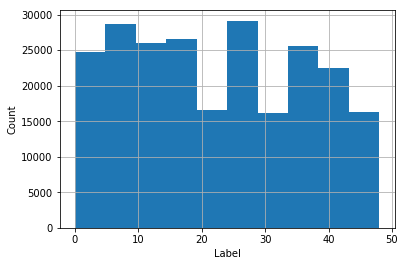

In [192]:
train_data['Label'].hist()
plt.xlabel('Label')
plt.ylabel('Count')

In [184]:
test_data['Label'].value_counts()

12    1000
38    1000
11    1000
10    1000
41    1000
9     1000
40    1000
39    1000
7     1000
6     1000
46    1000
37    1000
5     1000
4     1000
35    1000
34    1000
2     1000
1     1000
30    1000
0     1000
20    1000
21    1000
28    1000
15    1000
27    1000
47    1000
25    1000
24    1000
17    1000
18    1000
19    1000
26     836
8      767
13     678
14     629
48     574
33     552
31     498
16     418
23     399
43     390
42     348
22     336
29     324
32     280
36     260
3      126
44      68
45      64
Name: Label, dtype: int64

Text(0, 0.5, 'Count')

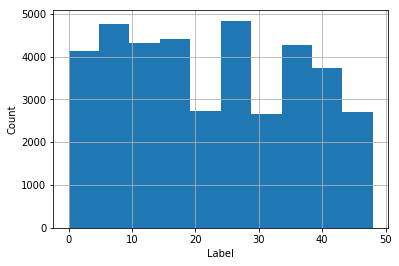

In [193]:
test_data['Label'].hist()
plt.xlabel('Label')
plt.ylabel('Count')

<b> Both the training and test set are somewhat imbalanced. The majority of labels have the same number of occurences but some labels have significantly less occurences. This is important to note and could affect training of the CNN later on.

<b> To visualize some of the images I created 3 samples below of 3 different labels, showing the unicode symbol and then plotting 20 examples of the hand drawn symbols.

In [162]:
sample1 = np.array(data[data['Label']==0].head(20).index)
sample2 = np.array(data[data['Label']==5].head(20).index)
sample3 = np.array(data[data['Label']==18].head(20).index)

## あ

100% |########################################################################|


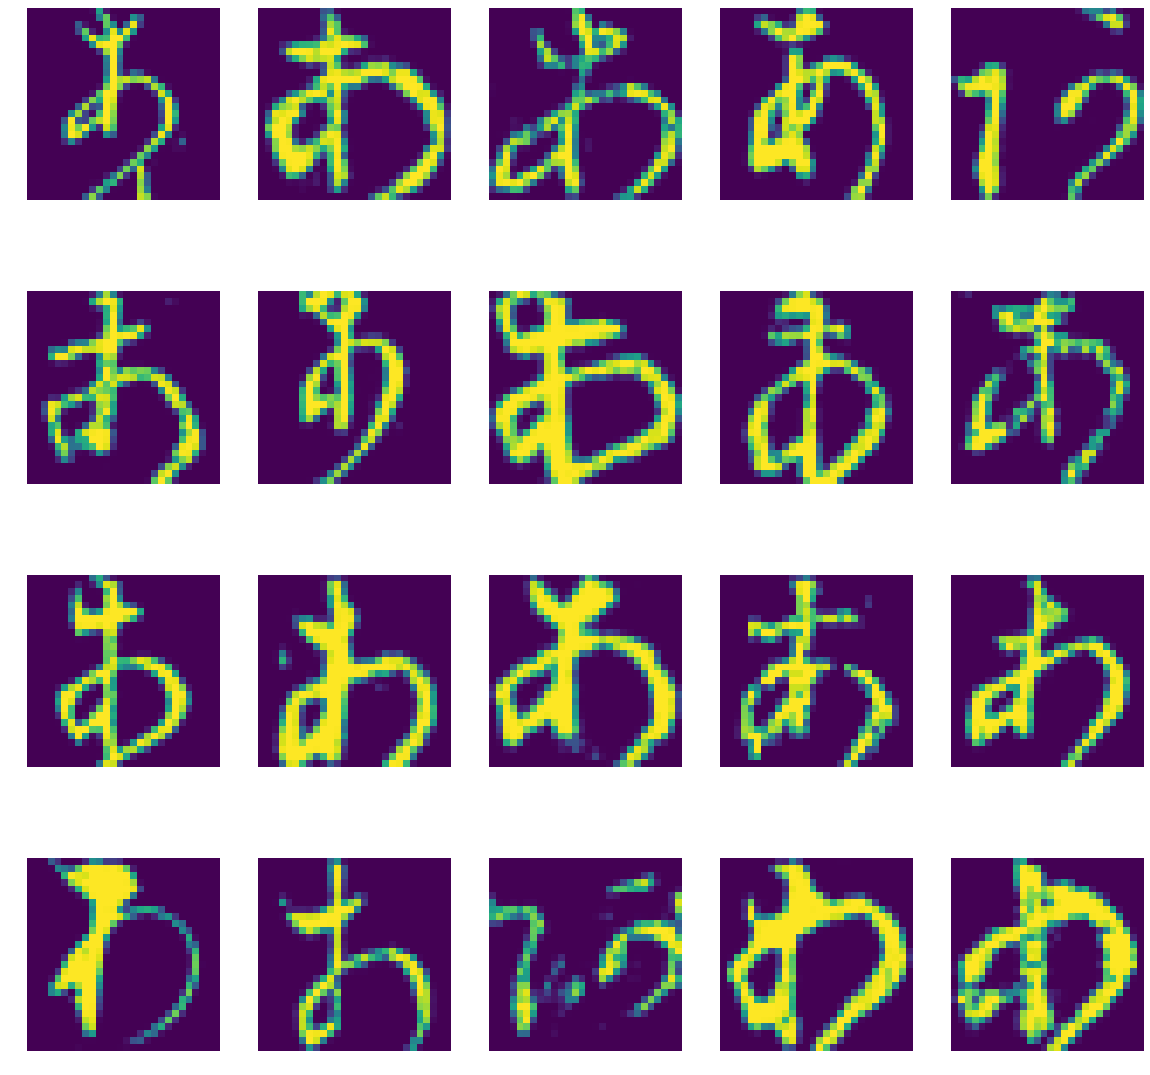

In [163]:
pbar = ProgressBar()
rows = 4
fig,axes = plt.subplots(figsize=(20,20))
for num, x in enumerate(pbar(sample1)):
    plt.subplot(rows,5,num+1)
    plt.axis('off')
    plt.imshow(images['arr_0'][x])

# か

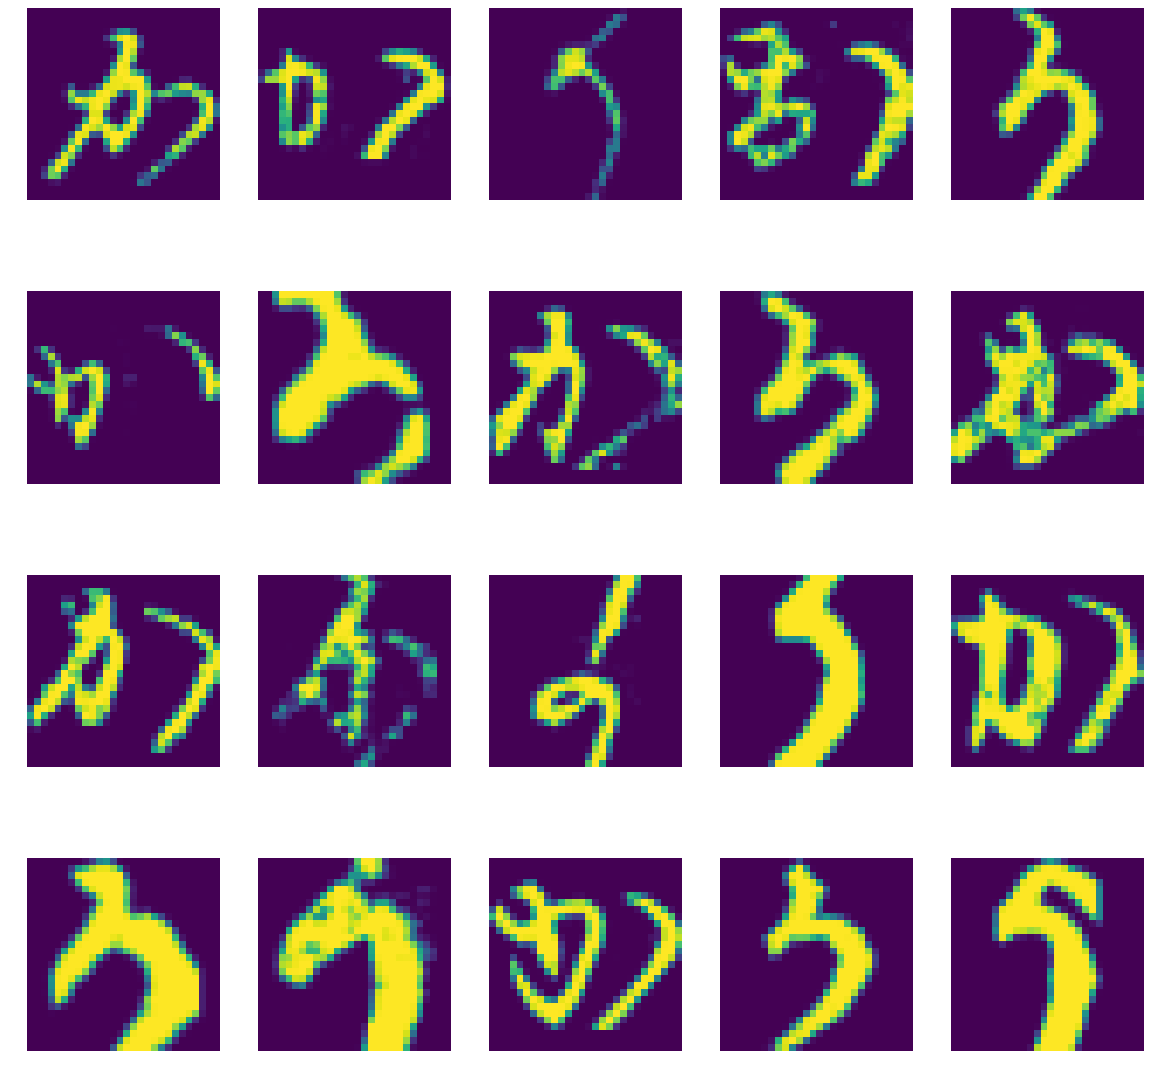

In [164]:
rows = 4
fig,axes = plt.subplots(figsize=(20,20))
for num, x in enumerate(sample2):
    plt.subplot(rows,5,num+1)
    plt.axis('off')
    plt.imshow(images['arr_0'][x])

# て

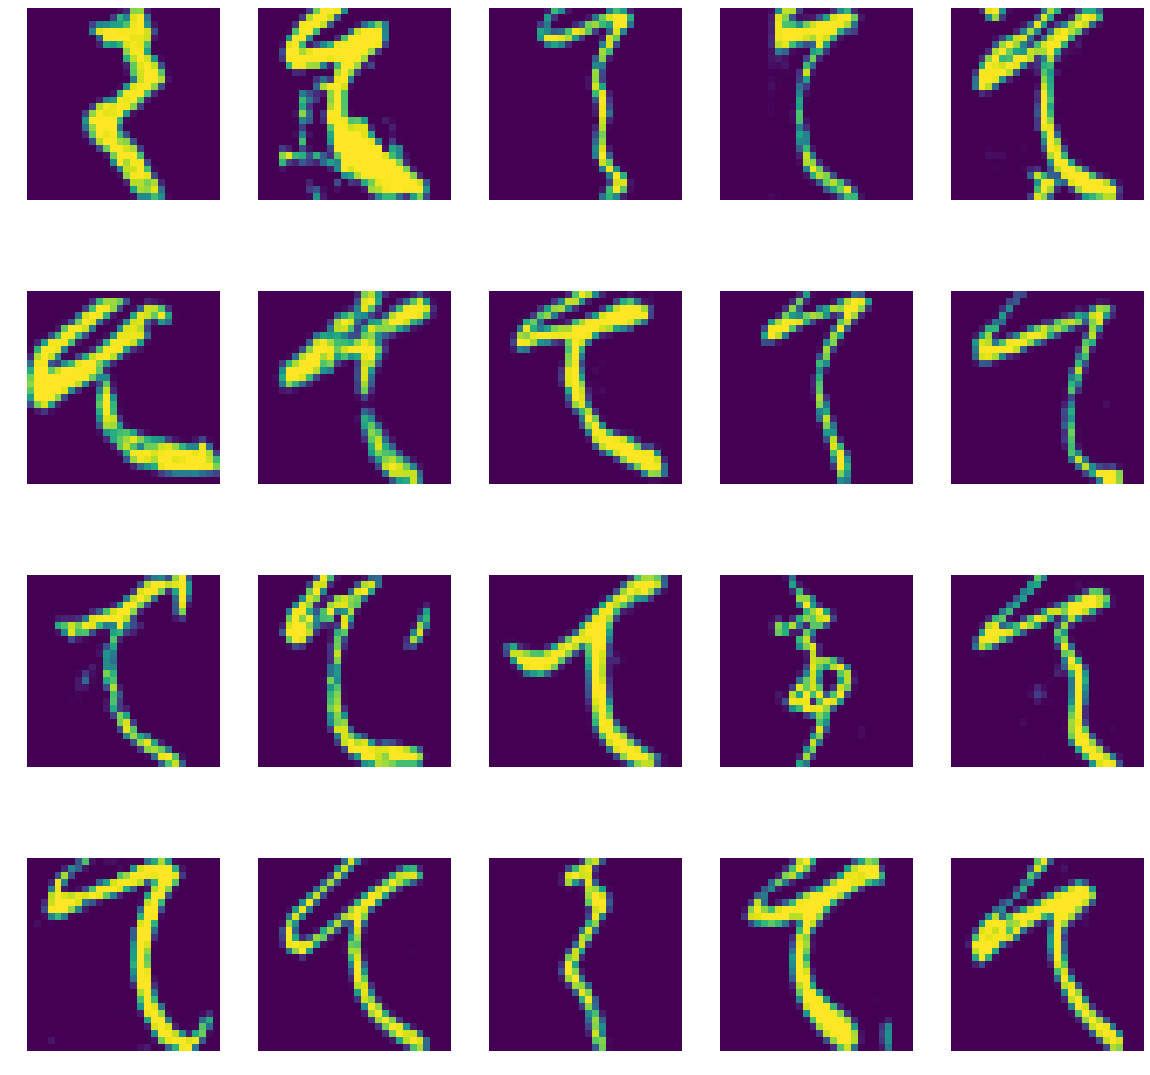

In [165]:
rows = 4
fig,axes = plt.subplots(figsize=(20,20))
for num, x in enumerate(sample3):
    plt.subplot(rows,5,num+1)
    plt.axis('off')
    plt.imshow(images['arr_0'][x])

<b> From the above we can see that for the most part, the drawn hiragana look nearly identical to the actual character. There are cases however where the drawn hiragana does differ somewhat substantially from the actual character.

<b> As another example, below I used the first sample and created an image with the average pixel values of each drawn character in the sample. The character definitely is recognizable as the correct hiragana character but is somewhat fuzzy. With more drawn characters included in the sample, the generated average character would most likely be much sharper.

In [166]:
pbar = ProgressBar()
averages = np.zeros((28,28))
for i in pbar(sample1):
    im = images['arr_0'][i]
    for index, x in np.ndenumerate(im):
        averages[index] = averages[index] + x

100% |########################################################################|


## あ

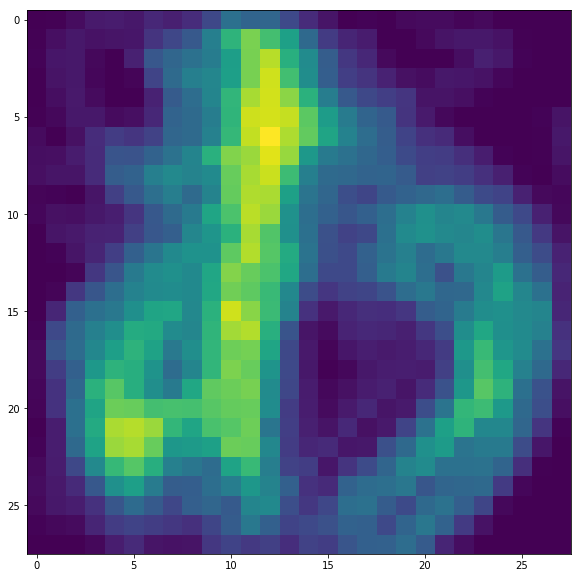

In [168]:
fig,axes = plt.subplots(figsize=(10,10))
plt.imshow(averages/20)

#### Lastly, we can use embedding to visualize the higher dimensional data. Since this is a computationally expensive process, I used a sample of 10,000 drawings.

In [112]:
idx = np.random.choice(len(train_images), size=10000, replace=False)
X_tsne = train_images.reshape(len(train_images), -1)[idx,:]
label_sample = train_labels[idx]
#embeddings = TSNE(n_components=49,verbose=2).fit_transform(X_tsne)

In [114]:
embeddings = TSNE(verbose=2).fit_transform(X_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.568s...
[t-SNE] Computed neighbors for 10000 samples in 120.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 554.857555
[t-SNE] Computed conditional probabilities in 0.916s
[t-SNE] Iteration 50: error = 95.7899017, gradient norm = 0.0207314 (50 iterations in 9.496s)
[t-SNE

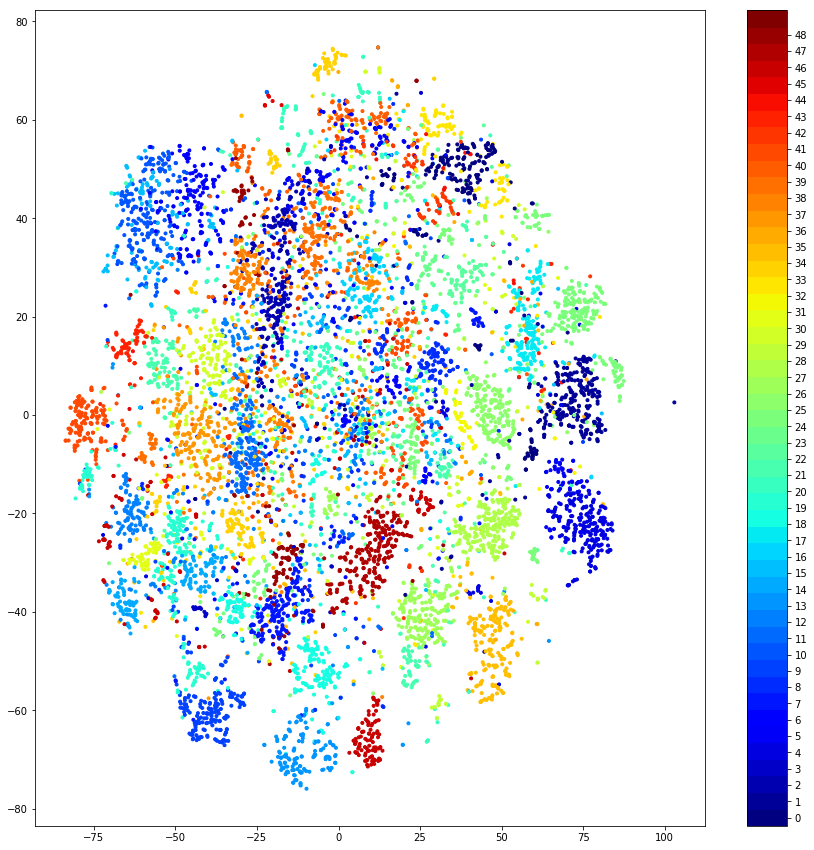

In [120]:
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(15,15))
plt.scatter(vis_x, vis_y, c=label_sample, cmap=plt.cm.get_cmap("jet", 49), marker='.')
plt.colorbar(ticks=range(49))
plt.clim(-0.5, 49.5)
plt.show()

#### From the above plot we can see that many of the labels are clustered togethered nicely and can be linearly seperated. However there is a lot of intermixing as well and some labels are not as clustered.

## Reshaping dataset 

#### In order to prepare the data for the CNN, I reshaped it and converted the labels to a categorical vector.

In [334]:
train_samples = train_images.shape[0]
test_samples = test_images.shape[0]
rows = train_images.shape[1]
columns = train_images.shape[2]

In [335]:
X_train = train_images.reshape(train_samples, rows, columns, 1)
y_train = to_categorical(train_labels, 49)

X_test = test_images.reshape(test_samples, rows, columns, 1)
y_test = to_categorical(test_labels, 49)

## Plotting function

#### Below is a function used later on to plot the accuracy and loss for the training.

In [110]:
def plot_training(mod):
# Plot training & validation accuracy values
    plt.plot(mod.history['acc'])
    plt.plot(mod.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# Plot training & validation loss values
    plt.plot(mod.history['loss'])
    plt.plot(mod.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

## Building an intial model

#### Initial model with two convolutional layers and two hidden layers

In [100]:
input_shape = (28,28,1)
num_classes = 49

model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(MaxPooling2D((2,2)))
model1.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               409856    
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
__________

In [101]:
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history1 = model1.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 29s 138us/step - loss: 0.7659 - acc: 0.8484 - val_loss: 0.2760 - val_acc: 0.9241
Epoch 2/5
209128/209128 [==============================] - 27s 128us/step - loss: 0.2226 - acc: 0.9373 - val_loss: 0.2472 - val_acc: 0.9305
Epoch 3/5
209128/209128 [==============================] - 27s 129us/step - loss: 0.1671 - acc: 0.9517 - val_loss: 0.2155 - val_acc: 0.9413
Epoch 4/5
209128/209128 [==============================] - 26s 123us/step - loss: 0.1360 - acc: 0.9600 - val_loss: 0.2190 - val_acc: 0.9421
Epoch 5/5
209128/209128 [==============================] - 25s 121us/step - loss: 0.1135 - acc: 0.9658 - val_loss: 0.2397 - val_acc: 0.9420


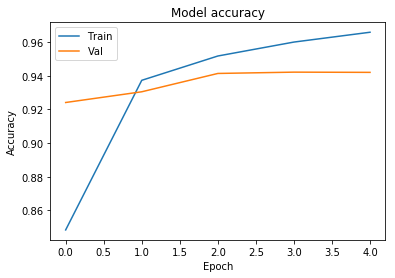

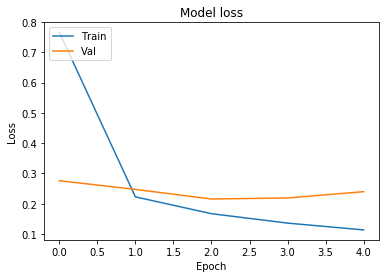

In [111]:
plot_training(history1)

In [104]:
model1.save('model_1.h5')

In [10]:
scores = model2.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

38547/38547 [==============================] - 17s 435us/step
acc: 90.40%


## Model 2

#### Adding addtional dense layers

In [117]:
input_shape = (28,28,1)
num_classes = 49

model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               819712    
_________________________________________________________________
dense_63 (Dense)             (None, 256)               131328    
__________

In [118]:
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history2 = model2.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 32s 153us/step - loss: 0.6229 - acc: 0.8519 - val_loss: 0.2654 - val_acc: 0.9284
Epoch 2/5
209128/209128 [==============================] - 30s 141us/step - loss: 0.2170 - acc: 0.9410 - val_loss: 0.2283 - val_acc: 0.9412
Epoch 3/5
209128/209128 [==============================] - 30s 142us/step - loss: 0.1637 - acc: 0.9551 - val_loss: 0.2267 - val_acc: 0.9435
Epoch 4/5
209128/209128 [==============================] - 29s 141us/step - loss: 0.1333 - acc: 0.9631 - val_loss: 0.2207 - val_acc: 0.9479
Epoch 5/5
209128/209128 [==============================] - 30s 141us/step - loss: 0.1140 - acc: 0.9685 - val_loss: 0.2291 - val_acc: 0.9463


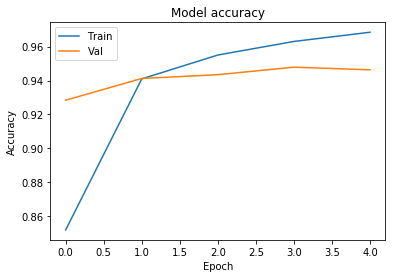

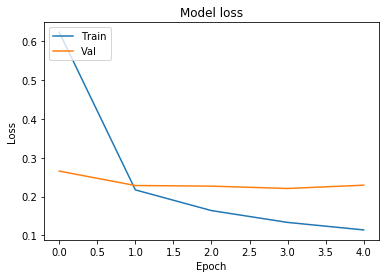

In [119]:
plot_training(history2)

In [120]:
model2.save('model_2.h5')

## Model 3

#### Adding dropout layers following dense layers

In [121]:
input_shape = (28,28,1)
num_classes = 49

model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model3.add(MaxPooling2D((2,2)))
model3.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model3.add(MaxPooling2D((2,2)))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               819712    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
__________

In [122]:
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history3 = model3.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 37s 175us/step - loss: 3.9136 - acc: 0.3575 - val_loss: 0.9580 - val_acc: 0.7714
Epoch 2/5
209128/209128 [==============================] - 30s 146us/step - loss: 1.0192 - acc: 0.7415 - val_loss: 0.4957 - val_acc: 0.8758
Epoch 3/5
209128/209128 [==============================] - 31s 146us/step - loss: 0.7320 - acc: 0.8197 - val_loss: 0.3952 - val_acc: 0.9037
Epoch 4/5
209128/209128 [==============================] - 31s 148us/step - loss: 0.6209 - acc: 0.8492 - val_loss: 0.3377 - val_acc: 0.9181
Epoch 5/5
209128/209128 [==============================] - 32s 152us/step - loss: 0.5537 - acc: 0.8669 - val_loss: 0.3111 - val_acc: 0.9259


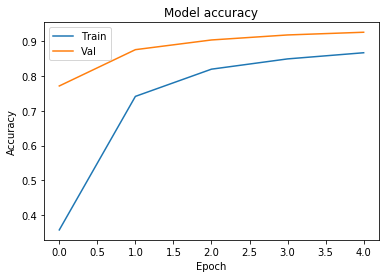

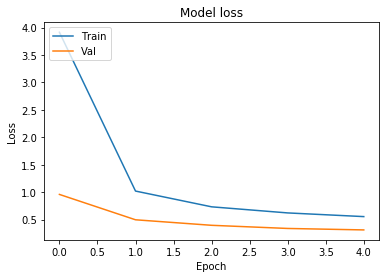

In [123]:
plot_training(history3)

In [124]:
model3.save('model_3.h5')

## Model 4

#### Decreasing dropout ratio

In [137]:
input_shape = (28,28,1)
num_classes = 49

model4 = Sequential()
model4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model4.add(MaxPooling2D((2,2)))
model4.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model4.add(MaxPooling2D((2,2)))
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 512)               819712    
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
__________

In [138]:
model4.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history4 = model4.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 30s 145us/step - loss: 1.3835 - acc: 0.7236 - val_loss: 0.3643 - val_acc: 0.9063
Epoch 2/5
209128/209128 [==============================] - 29s 139us/step - loss: 0.4244 - acc: 0.8911 - val_loss: 0.2779 - val_acc: 0.9297
Epoch 3/5
209128/209128 [==============================] - 27s 131us/step - loss: 0.3319 - acc: 0.9158 - val_loss: 0.2454 - val_acc: 0.9407
Epoch 4/5
209128/209128 [==============================] - 27s 131us/step - loss: 0.2855 - acc: 0.9272 - val_loss: 0.2250 - val_acc: 0.9455
Epoch 5/5
209128/209128 [==============================] - 26s 124us/step - loss: 0.2518 - acc: 0.9363 - val_loss: 0.2082 - val_acc: 0.9510


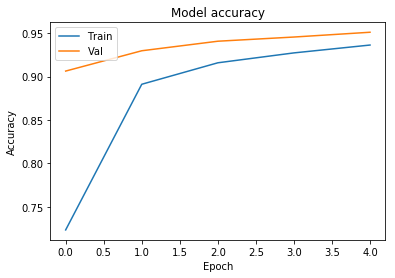

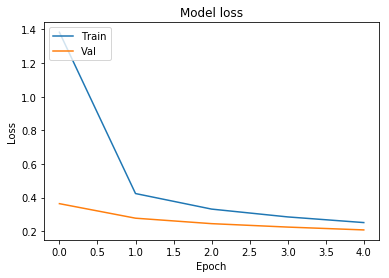

In [139]:
plot_training(history4)

In [140]:
model4.save('model_4.h5')

## Model 5

#### Adding dropout after convolutional layers

In [151]:
input_shape = (28,28,1)
num_classes = 49

model5 = Sequential()
model5.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(0.15))
model5.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model5.add(MaxPooling2D((2,2)))
model5.add(Dropout(0.15))
model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(num_classes, activation='softmax'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1600)              0         
__________

In [152]:
model5.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history5 = model5.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 34s 165us/step - loss: 1.5164 - acc: 0.6848 - val_loss: 0.3886 - val_acc: 0.9006
Epoch 2/5
209128/209128 [==============================] - 28s 135us/step - loss: 0.5098 - acc: 0.8699 - val_loss: 0.2780 - val_acc: 0.9285
Epoch 3/5
209128/209128 [==============================] - 30s 144us/step - loss: 0.4073 - acc: 0.8972 - val_loss: 0.2378 - val_acc: 0.9410
Epoch 4/5
209128/209128 [==============================] - 30s 142us/step - loss: 0.3493 - acc: 0.9128 - val_loss: 0.2131 - val_acc: 0.9486
Epoch 5/5
209128/209128 [==============================] - 30s 145us/step - loss: 0.3170 - acc: 0.9209 - val_loss: 0.1958 - val_acc: 0.9528


In [ ]:
plot_training(history5)

In [ ]:
model5.save('model_5.h5')

## Model 6

#### Adding convolution layers

In [160]:
input_shape = (28,28,1)
num_classes = 49

model6 = Sequential()
model6.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model6.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model6.add(MaxPooling2D((2,2)))
model6.add(Dropout(0.15))
model6.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model6.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model6.add(MaxPooling2D((2,2)))
model6.add(Dropout(0.15))
model6.add(Flatten())
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.25))
model6.add(Dense(64, activation='relu'))
model6.add(Dense(num_classes, activation='softmax'))
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 4, 4, 64)          0         
__________

In [161]:
model6.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history6 = model6.fit(x=X_train,y=y_train, epochs=5, batch_size=100, validation_split=0.10, shuffle=True)

Train on 209128 samples, validate on 23237 samples
Epoch 1/5
209128/209128 [==============================] - 43s 203us/step - loss: 1.1497 - acc: 0.7080 - val_loss: 0.3097 - val_acc: 0.9196
Epoch 2/5
209128/209128 [==============================] - 39s 186us/step - loss: 0.4129 - acc: 0.8950 - val_loss: 0.2142 - val_acc: 0.9468
Epoch 3/5
209128/209128 [==============================] - 40s 189us/step - loss: 0.3186 - acc: 0.9210 - val_loss: 0.1772 - val_acc: 0.9549
Epoch 4/5
209128/209128 [==============================] - 42s 199us/step - loss: 0.2719 - acc: 0.9320 - val_loss: 0.1741 - val_acc: 0.9574
Epoch 5/5
209128/209128 [==============================] - 42s 202us/step - loss: 0.2474 - acc: 0.9389 - val_loss: 0.1666 - val_acc: 0.9598


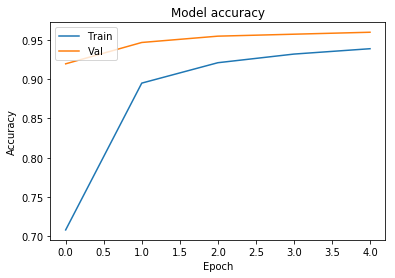

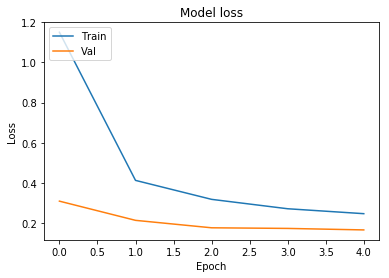

In [162]:
plot_training(history6)

In [163]:
model6.save('model_6')

## Hyperparameter tuning

#### Now that an architecture has been chosen, I will try to tune some parameters such as the optimizer function and learning rate.

#### Below is a function necessary for using the Talos library (https://github.com/autonomio/talos) to test out different parameters. It builds a model with the same architecture as Model6 from above.

In [316]:
# This function is used with Talos to build each model. It has the same architecture as Model6. 
def create_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=params['optimizer'], 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    
    out = model.fit(x_train, y_train, 
                        validation_split=0.1,
                        batch_size=100,
                        epochs=20,
                        verbose=1,
                        shuffle=True)
    
    return out, model

#### Below is a dictionary of optimizers that will be tested.

In [317]:
parameters = {'optimizer': ['adam', 'adadelta', 'rmsprop', 'sgd']}

#### Now we can use Talos to build and train a model using each of the different optimizers.

In [318]:
t = talos.Scan(X_train, y_train, parameters, create_model)



















  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 42600/146389 [=======>......................] - ETA: 1:08:14 - loss: 13.6257 - acc: 0.020 - ETA: 23:12 - loss: 11.6256 - acc: 0.0300  - ETA: 14:09 - loss: 9.0871 - acc: 0.034 - ETA: 9:02 - loss: 7.2431 - acc: 0.0312 - ETA: 6:43 - loss: 6.3481 - acc: 0.028 - ETA: 5:46 - loss: 5.9717 - acc: 0.027 - ETA: 5:05 - loss: 5.6980 - acc: 0.028 - ETA: 4:33 - loss: 5.4882 - acc: 0.030 - ETA: 4:08 - loss: 5.3212 - acc: 0.029 - ETA: 3:49 - loss: 5.1839 - acc: 0.030 - ETA: 3:32 - loss: 5.0682 - acc: 0.030 - ETA: 3:11 - loss: 4.9317 - acc: 0.029 - ETA: 3:01 - loss: 4.8560 - acc: 0.028 - ETA: 2:46 - loss: 4.7600 - acc: 0.028 - ETA: 2:38 - loss: 4.7048 - acc: 0.028 - ETA: 2:31 - loss: 4.6559 - acc: 0.028 - ETA: 2:25 - loss: 4.6145 - acc: 0.028 - ETA: 2:20 - loss: 4.5754 - acc: 0.029 - ETA: 2:15 - loss: 4.5407 - acc: 0.030 - ETA: 2:10 - loss: 4.5065 - acc: 0.031 - ETA: 2:06 - loss: 4.4763 - acc: 0.031 - ETA: 2:02 - loss: 4.4486 - acc: 0.032 - ETA: 1:59 - loss: 4.4217 - acc: 0.034 - ETA: 1:56 - loss: 4.3

131800/146389 [==========================>...] - ETA: 19s - loss: 1.7785 - acc: 0.54 - ETA: 19s - loss: 1.7768 - acc: 0.55 - ETA: 19s - loss: 1.7749 - acc: 0.55 - ETA: 19s - loss: 1.7726 - acc: 0.55 - ETA: 19s - loss: 1.7703 - acc: 0.55 - ETA: 18s - loss: 1.7677 - acc: 0.55 - ETA: 18s - loss: 1.7658 - acc: 0.55 - ETA: 18s - loss: 1.7636 - acc: 0.55 - ETA: 18s - loss: 1.7618 - acc: 0.55 - ETA: 18s - loss: 1.7596 - acc: 0.55 - ETA: 18s - loss: 1.7574 - acc: 0.55 - ETA: 18s - loss: 1.7553 - acc: 0.55 - ETA: 18s - loss: 1.7532 - acc: 0.55 - ETA: 18s - loss: 1.7510 - acc: 0.55 - ETA: 18s - loss: 1.7489 - acc: 0.55 - ETA: 18s - loss: 1.7459 - acc: 0.55 - ETA: 18s - loss: 1.7423 - acc: 0.55 - ETA: 18s - loss: 1.7404 - acc: 0.55 - ETA: 17s - loss: 1.7385 - acc: 0.55 - ETA: 17s - loss: 1.7366 - acc: 0.56 - ETA: 17s - loss: 1.7346 - acc: 0.56 - ETA: 17s - loss: 1.7327 - acc: 0.56 - ETA: 17s - loss: 1.7302 - acc: 0.56 - ETA: 17s - loss: 1.7286 - acc: 0.56 - ETA: 17s - loss: 1.7269 - acc: 0.56 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.4279 - acc: 0.637 - ETA: 4s - loss: 1.4269 - acc: 0.638 - ETA: 4s - loss: 1.4259 - acc: 0.638 - ETA: 4s - loss: 1.4247 - acc: 0.638 - ETA: 4s - loss: 1.4239 - acc: 0.639 - ETA: 4s - loss: 1.4225 - acc: 0.639 - ETA: 4s - loss: 1.4214 - acc: 0.639 - ETA: 4s - loss: 1.4203 - acc: 0.639 - ETA: 4s - loss: 1.4192 - acc: 0.640 - ETA: 3s - loss: 1.4182 - acc: 0.640 - ETA: 3s - loss: 1.4171 - acc: 0.640 - ETA: 3s - loss: 1.4160 - acc: 0.641 - ETA: 3s - loss: 1.4147 - acc: 0.641 - ETA: 3s - loss: 1.4134 - acc: 0.641 - ETA: 3s - loss: 1.4115 - acc: 0.642 - ETA: 3s - loss: 1.4099 - acc: 0.642 - ETA: 3s - loss: 1.4088 - acc: 0.642 - ETA: 3s - loss: 1.4071 - acc: 0.643 - ETA: 3s - loss: 1.4058 - acc: 0.643 - ETA: 3s - loss: 1.4046 - acc: 0.643 - ETA: 3s - loss: 1.4034 - acc: 0.644 - ETA: 3s - loss: 1.4026 - acc: 0.644 - ETA: 3s - loss: 1.4015 - acc: 0.644 - ETA: 3s - loss: 1.4005 - acc: 0.644 - ETA: 2s - loss: 1.3992 - acc: 0.645 - E

 43300/146389 [=======>......................] - ETA: 58s - loss: 0.7498 - acc: 0.83 - ETA: 50s - loss: 0.6260 - acc: 0.83 - ETA: 47s - loss: 0.6184 - acc: 0.83 - ETA: 42s - loss: 0.6257 - acc: 0.83 - ETA: 42s - loss: 0.5993 - acc: 0.84 - ETA: 42s - loss: 0.5845 - acc: 0.84 - ETA: 42s - loss: 0.5675 - acc: 0.84 - ETA: 42s - loss: 0.5645 - acc: 0.85 - ETA: 42s - loss: 0.5588 - acc: 0.85 - ETA: 42s - loss: 0.5544 - acc: 0.85 - ETA: 42s - loss: 0.5604 - acc: 0.84 - ETA: 42s - loss: 0.5580 - acc: 0.85 - ETA: 42s - loss: 0.5611 - acc: 0.85 - ETA: 42s - loss: 0.5638 - acc: 0.84 - ETA: 42s - loss: 0.5631 - acc: 0.85 - ETA: 42s - loss: 0.5583 - acc: 0.85 - ETA: 42s - loss: 0.5542 - acc: 0.85 - ETA: 42s - loss: 0.5512 - acc: 0.85 - ETA: 42s - loss: 0.5581 - acc: 0.85 - ETA: 42s - loss: 0.5628 - acc: 0.85 - ETA: 42s - loss: 0.5627 - acc: 0.85 - ETA: 42s - loss: 0.5564 - acc: 0.85 - ETA: 41s - loss: 0.5571 - acc: 0.85 - ETA: 41s - loss: 0.5586 - acc: 0.85 - ETA: 41s - loss: 0.5664 - acc: 0.85 - E

130700/146389 [=========================>....] - ETA: 17s - loss: 0.5080 - acc: 0.86 - ETA: 17s - loss: 0.5081 - acc: 0.86 - ETA: 17s - loss: 0.5080 - acc: 0.86 - ETA: 17s - loss: 0.5079 - acc: 0.86 - ETA: 17s - loss: 0.5077 - acc: 0.86 - ETA: 17s - loss: 0.5076 - acc: 0.86 - ETA: 17s - loss: 0.5072 - acc: 0.86 - ETA: 16s - loss: 0.5071 - acc: 0.86 - ETA: 16s - loss: 0.5071 - acc: 0.86 - ETA: 16s - loss: 0.5068 - acc: 0.86 - ETA: 16s - loss: 0.5066 - acc: 0.86 - ETA: 16s - loss: 0.5059 - acc: 0.86 - ETA: 16s - loss: 0.5060 - acc: 0.86 - ETA: 16s - loss: 0.5059 - acc: 0.86 - ETA: 16s - loss: 0.5057 - acc: 0.86 - ETA: 16s - loss: 0.5057 - acc: 0.86 - ETA: 16s - loss: 0.5058 - acc: 0.86 - ETA: 16s - loss: 0.5056 - acc: 0.86 - ETA: 16s - loss: 0.5055 - acc: 0.86 - ETA: 16s - loss: 0.5052 - acc: 0.86 - ETA: 16s - loss: 0.5048 - acc: 0.86 - ETA: 16s - loss: 0.5044 - acc: 0.87 - ETA: 16s - loss: 0.5042 - acc: 0.87 - ETA: 15s - loss: 0.5040 - acc: 0.87 - ETA: 15s - loss: 0.5037 - acc: 0.87 - E

146389/146389 [==============================] - ETA: 4s - loss: 0.4853 - acc: 0.875 - ETA: 4s - loss: 0.4851 - acc: 0.876 - ETA: 4s - loss: 0.4850 - acc: 0.876 - ETA: 4s - loss: 0.4847 - acc: 0.876 - ETA: 4s - loss: 0.4846 - acc: 0.876 - ETA: 4s - loss: 0.4846 - acc: 0.876 - ETA: 4s - loss: 0.4845 - acc: 0.876 - ETA: 4s - loss: 0.4843 - acc: 0.876 - ETA: 4s - loss: 0.4843 - acc: 0.876 - ETA: 4s - loss: 0.4844 - acc: 0.876 - ETA: 3s - loss: 0.4843 - acc: 0.876 - ETA: 3s - loss: 0.4842 - acc: 0.876 - ETA: 3s - loss: 0.4841 - acc: 0.876 - ETA: 3s - loss: 0.4841 - acc: 0.876 - ETA: 3s - loss: 0.4838 - acc: 0.876 - ETA: 3s - loss: 0.4836 - acc: 0.876 - ETA: 3s - loss: 0.4833 - acc: 0.876 - ETA: 3s - loss: 0.4831 - acc: 0.876 - ETA: 3s - loss: 0.4829 - acc: 0.876 - ETA: 3s - loss: 0.4830 - acc: 0.876 - ETA: 3s - loss: 0.4834 - acc: 0.876 - ETA: 3s - loss: 0.4832 - acc: 0.876 - ETA: 3s - loss: 0.4830 - acc: 0.876 - ETA: 3s - loss: 0.4831 - acc: 0.876 - ETA: 3s - loss: 0.4829 - acc: 0.876 - E

 43400/146389 [=======>......................] - ETA: 49s - loss: 0.2982 - acc: 0.90 - ETA: 37s - loss: 0.3460 - acc: 0.90 - ETA: 36s - loss: 0.3642 - acc: 0.90 - ETA: 35s - loss: 0.3702 - acc: 0.89 - ETA: 36s - loss: 0.3579 - acc: 0.90 - ETA: 36s - loss: 0.3383 - acc: 0.90 - ETA: 36s - loss: 0.3482 - acc: 0.90 - ETA: 37s - loss: 0.3373 - acc: 0.91 - ETA: 37s - loss: 0.3463 - acc: 0.90 - ETA: 38s - loss: 0.3399 - acc: 0.90 - ETA: 38s - loss: 0.3319 - acc: 0.90 - ETA: 38s - loss: 0.3351 - acc: 0.90 - ETA: 38s - loss: 0.3362 - acc: 0.90 - ETA: 39s - loss: 0.3389 - acc: 0.90 - ETA: 39s - loss: 0.3498 - acc: 0.90 - ETA: 39s - loss: 0.3466 - acc: 0.90 - ETA: 39s - loss: 0.3499 - acc: 0.90 - ETA: 39s - loss: 0.3561 - acc: 0.90 - ETA: 39s - loss: 0.3522 - acc: 0.90 - ETA: 39s - loss: 0.3539 - acc: 0.90 - ETA: 40s - loss: 0.3550 - acc: 0.90 - ETA: 40s - loss: 0.3558 - acc: 0.90 - ETA: 40s - loss: 0.3658 - acc: 0.90 - ETA: 40s - loss: 0.3650 - acc: 0.90 - ETA: 40s - loss: 0.3645 - acc: 0.90 - E

131700/146389 [=========================>....] - ETA: 17s - loss: 0.3684 - acc: 0.90 - ETA: 17s - loss: 0.3685 - acc: 0.90 - ETA: 17s - loss: 0.3686 - acc: 0.90 - ETA: 17s - loss: 0.3685 - acc: 0.90 - ETA: 17s - loss: 0.3685 - acc: 0.90 - ETA: 17s - loss: 0.3687 - acc: 0.90 - ETA: 17s - loss: 0.3686 - acc: 0.90 - ETA: 17s - loss: 0.3688 - acc: 0.90 - ETA: 17s - loss: 0.3687 - acc: 0.90 - ETA: 16s - loss: 0.3689 - acc: 0.90 - ETA: 16s - loss: 0.3690 - acc: 0.90 - ETA: 16s - loss: 0.3689 - acc: 0.90 - ETA: 16s - loss: 0.3688 - acc: 0.90 - ETA: 16s - loss: 0.3687 - acc: 0.90 - ETA: 16s - loss: 0.3691 - acc: 0.90 - ETA: 16s - loss: 0.3690 - acc: 0.90 - ETA: 16s - loss: 0.3690 - acc: 0.90 - ETA: 16s - loss: 0.3689 - acc: 0.90 - ETA: 16s - loss: 0.3686 - acc: 0.90 - ETA: 16s - loss: 0.3682 - acc: 0.90 - ETA: 16s - loss: 0.3681 - acc: 0.90 - ETA: 16s - loss: 0.3678 - acc: 0.90 - ETA: 16s - loss: 0.3675 - acc: 0.90 - ETA: 16s - loss: 0.3670 - acc: 0.90 - ETA: 16s - loss: 0.3669 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 4s - loss: 0.3586 - acc: 0.908 - ETA: 4s - loss: 0.3588 - acc: 0.908 - ETA: 4s - loss: 0.3587 - acc: 0.908 - ETA: 3s - loss: 0.3587 - acc: 0.908 - ETA: 3s - loss: 0.3583 - acc: 0.908 - ETA: 3s - loss: 0.3583 - acc: 0.908 - ETA: 3s - loss: 0.3583 - acc: 0.908 - ETA: 3s - loss: 0.3581 - acc: 0.909 - ETA: 3s - loss: 0.3578 - acc: 0.909 - ETA: 3s - loss: 0.3577 - acc: 0.909 - ETA: 3s - loss: 0.3578 - acc: 0.909 - ETA: 3s - loss: 0.3579 - acc: 0.909 - ETA: 3s - loss: 0.3579 - acc: 0.909 - ETA: 3s - loss: 0.3577 - acc: 0.909 - ETA: 2s - loss: 0.3576 - acc: 0.909 - ETA: 2s - loss: 0.3578 - acc: 0.909 - ETA: 2s - loss: 0.3579 - acc: 0.909 - ETA: 2s - loss: 0.3580 - acc: 0.909 - ETA: 2s - loss: 0.3580 - acc: 0.909 - ETA: 2s - loss: 0.3580 - acc: 0.909 - ETA: 2s - loss: 0.3582 - acc: 0.909 - ETA: 2s - loss: 0.3583 - acc: 0.909 - ETA: 2s - loss: 0.3583 - acc: 0.908 - ETA: 2s - loss: 0.3582 - acc: 0.909 - ETA: 2s - loss: 0.3582 - acc: 0.909 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1039 - acc: 0.97 - ETA: 30s - loss: 0.4039 - acc: 0.90 - ETA: 28s - loss: 0.3755 - acc: 0.90 - ETA: 27s - loss: 0.3888 - acc: 0.90 - ETA: 27s - loss: 0.3601 - acc: 0.91 - ETA: 27s - loss: 0.3503 - acc: 0.91 - ETA: 27s - loss: 0.3472 - acc: 0.91 - ETA: 26s - loss: 0.3359 - acc: 0.91 - ETA: 26s - loss: 0.3334 - acc: 0.91 - ETA: 26s - loss: 0.3350 - acc: 0.91 - ETA: 26s - loss: 0.3268 - acc: 0.91 - ETA: 26s - loss: 0.3188 - acc: 0.91 - ETA: 26s - loss: 0.3182 - acc: 0.91 - ETA: 26s - loss: 0.3174 - acc: 0.91 - ETA: 26s - loss: 0.3142 - acc: 0.91 - ETA: 26s - loss: 0.3171 - acc: 0.91 - ETA: 25s - loss: 0.3175 - acc: 0.91 - ETA: 25s - loss: 0.3207 - acc: 0.91 - ETA: 25s - loss: 0.3183 - acc: 0.91 - ETA: 25s - loss: 0.3216 - acc: 0.91 - ETA: 25s - loss: 0.3212 - acc: 0.91 - ETA: 25s - loss: 0.3200 - acc: 0.91 - ETA: 25s - loss: 0.3187 - acc: 0.91 - ETA: 25s - loss: 0.3171 - acc: 0.92 - ETA: 25s - loss: 0.3175 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3059 - acc: 0.923 - ETA: 3s - loss: 0.3059 - acc: 0.923 - ETA: 3s - loss: 0.3060 - acc: 0.923 - ETA: 2s - loss: 0.3059 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3060 - acc: 0.923 - ETA: 2s - loss: 0.3059 - acc: 0.923 - ETA: 2s - loss: 0.3063 - acc: 0.923 - ETA: 2s - loss: 0.3064 - acc: 0.923 - ETA: 2s - loss: 0.3062 - acc: 0.923 - ETA: 2s - loss: 0.3060 - acc: 0.923 - ETA: 2s - loss: 0.3062 - acc: 0.923 - ETA: 2s - loss: 0.3059 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3061 - acc: 0.923 - ETA: 2s - loss: 0.3059 - acc: 0.923 - ETA: 1s - loss: 0.3058 - acc: 0.923 - ETA: 1s - loss: 0.3054 - acc: 0.923 - ETA: 1s - loss: 0.3055 - acc: 0.923 - ETA: 1s - loss: 0.3057 - acc: 0.923 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.3654 - acc: 0.92 - ETA: 27s - loss: 0.2622 - acc: 0.94 - ETA: 26s - loss: 0.2565 - acc: 0.93 - ETA: 27s - loss: 0.2497 - acc: 0.94 - ETA: 26s - loss: 0.2415 - acc: 0.93 - ETA: 26s - loss: 0.2517 - acc: 0.93 - ETA: 26s - loss: 0.2468 - acc: 0.93 - ETA: 26s - loss: 0.2622 - acc: 0.93 - ETA: 26s - loss: 0.2584 - acc: 0.93 - ETA: 26s - loss: 0.2599 - acc: 0.93 - ETA: 26s - loss: 0.2598 - acc: 0.93 - ETA: 25s - loss: 0.2517 - acc: 0.93 - ETA: 25s - loss: 0.2500 - acc: 0.93 - ETA: 25s - loss: 0.2483 - acc: 0.93 - ETA: 25s - loss: 0.2467 - acc: 0.93 - ETA: 25s - loss: 0.2463 - acc: 0.93 - ETA: 25s - loss: 0.2468 - acc: 0.93 - ETA: 25s - loss: 0.2476 - acc: 0.93 - ETA: 25s - loss: 0.2504 - acc: 0.93 - ETA: 25s - loss: 0.2492 - acc: 0.93 - ETA: 25s - loss: 0.2525 - acc: 0.93 - ETA: 25s - loss: 0.2530 - acc: 0.93 - ETA: 25s - loss: 0.2552 - acc: 0.93 - ETA: 25s - loss: 0.2559 - acc: 0.93 - ETA: 25s - loss: 0.2584 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2696 - acc: 0.932 - ETA: 3s - loss: 0.2696 - acc: 0.932 - ETA: 3s - loss: 0.2695 - acc: 0.932 - ETA: 2s - loss: 0.2696 - acc: 0.932 - ETA: 2s - loss: 0.2696 - acc: 0.932 - ETA: 2s - loss: 0.2695 - acc: 0.932 - ETA: 2s - loss: 0.2695 - acc: 0.932 - ETA: 2s - loss: 0.2697 - acc: 0.932 - ETA: 2s - loss: 0.2698 - acc: 0.932 - ETA: 2s - loss: 0.2700 - acc: 0.932 - ETA: 2s - loss: 0.2699 - acc: 0.932 - ETA: 2s - loss: 0.2704 - acc: 0.932 - ETA: 2s - loss: 0.2704 - acc: 0.932 - ETA: 2s - loss: 0.2702 - acc: 0.932 - ETA: 2s - loss: 0.2702 - acc: 0.932 - ETA: 2s - loss: 0.2700 - acc: 0.932 - ETA: 2s - loss: 0.2697 - acc: 0.932 - ETA: 2s - loss: 0.2698 - acc: 0.932 - ETA: 2s - loss: 0.2698 - acc: 0.932 - ETA: 2s - loss: 0.2697 - acc: 0.932 - ETA: 2s - loss: 0.2695 - acc: 0.932 - ETA: 1s - loss: 0.2695 - acc: 0.932 - ETA: 1s - loss: 0.2693 - acc: 0.932 - ETA: 1s - loss: 0.2693 - acc: 0.932 - ETA: 1s - loss: 0.2690 - acc: 0.932 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.2367 - acc: 0.95 - ETA: 26s - loss: 0.2099 - acc: 0.94 - ETA: 26s - loss: 0.2087 - acc: 0.94 - ETA: 26s - loss: 0.2689 - acc: 0.93 - ETA: 26s - loss: 0.2541 - acc: 0.93 - ETA: 26s - loss: 0.2462 - acc: 0.93 - ETA: 26s - loss: 0.2490 - acc: 0.93 - ETA: 26s - loss: 0.2392 - acc: 0.93 - ETA: 26s - loss: 0.2311 - acc: 0.93 - ETA: 25s - loss: 0.2262 - acc: 0.93 - ETA: 25s - loss: 0.2288 - acc: 0.93 - ETA: 25s - loss: 0.2274 - acc: 0.93 - ETA: 25s - loss: 0.2330 - acc: 0.93 - ETA: 25s - loss: 0.2437 - acc: 0.93 - ETA: 25s - loss: 0.2491 - acc: 0.93 - ETA: 25s - loss: 0.2442 - acc: 0.93 - ETA: 25s - loss: 0.2389 - acc: 0.93 - ETA: 25s - loss: 0.2354 - acc: 0.93 - ETA: 25s - loss: 0.2370 - acc: 0.93 - ETA: 25s - loss: 0.2334 - acc: 0.93 - ETA: 25s - loss: 0.2309 - acc: 0.93 - ETA: 25s - loss: 0.2275 - acc: 0.93 - ETA: 25s - loss: 0.2291 - acc: 0.93 - ETA: 25s - loss: 0.2297 - acc: 0.93 - ETA: 24s - loss: 0.2299 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2430 - acc: 0.939 - ETA: 3s - loss: 0.2429 - acc: 0.939 - ETA: 3s - loss: 0.2427 - acc: 0.939 - ETA: 2s - loss: 0.2427 - acc: 0.939 - ETA: 2s - loss: 0.2426 - acc: 0.939 - ETA: 2s - loss: 0.2427 - acc: 0.939 - ETA: 2s - loss: 0.2428 - acc: 0.939 - ETA: 2s - loss: 0.2430 - acc: 0.939 - ETA: 2s - loss: 0.2430 - acc: 0.939 - ETA: 2s - loss: 0.2430 - acc: 0.939 - ETA: 2s - loss: 0.2431 - acc: 0.939 - ETA: 2s - loss: 0.2428 - acc: 0.939 - ETA: 2s - loss: 0.2427 - acc: 0.939 - ETA: 2s - loss: 0.2425 - acc: 0.939 - ETA: 2s - loss: 0.2425 - acc: 0.939 - ETA: 2s - loss: 0.2425 - acc: 0.939 - ETA: 2s - loss: 0.2426 - acc: 0.939 - ETA: 2s - loss: 0.2426 - acc: 0.939 - ETA: 2s - loss: 0.2428 - acc: 0.939 - ETA: 2s - loss: 0.2427 - acc: 0.939 - ETA: 2s - loss: 0.2426 - acc: 0.939 - ETA: 1s - loss: 0.2425 - acc: 0.939 - ETA: 1s - loss: 0.2426 - acc: 0.939 - ETA: 1s - loss: 0.2424 - acc: 0.939 - ETA: 1s - loss: 0.2425 - acc: 0.939 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.2737 - acc: 0.94 - ETA: 28s - loss: 0.2344 - acc: 0.93 - ETA: 28s - loss: 0.2177 - acc: 0.93 - ETA: 27s - loss: 0.2097 - acc: 0.94 - ETA: 26s - loss: 0.2160 - acc: 0.94 - ETA: 26s - loss: 0.2249 - acc: 0.94 - ETA: 26s - loss: 0.2147 - acc: 0.94 - ETA: 26s - loss: 0.2276 - acc: 0.94 - ETA: 26s - loss: 0.2312 - acc: 0.94 - ETA: 26s - loss: 0.2340 - acc: 0.94 - ETA: 26s - loss: 0.2304 - acc: 0.94 - ETA: 26s - loss: 0.2263 - acc: 0.94 - ETA: 26s - loss: 0.2265 - acc: 0.94 - ETA: 25s - loss: 0.2219 - acc: 0.94 - ETA: 25s - loss: 0.2183 - acc: 0.94 - ETA: 25s - loss: 0.2163 - acc: 0.94 - ETA: 25s - loss: 0.2207 - acc: 0.94 - ETA: 25s - loss: 0.2168 - acc: 0.94 - ETA: 25s - loss: 0.2136 - acc: 0.94 - ETA: 25s - loss: 0.2111 - acc: 0.94 - ETA: 25s - loss: 0.2122 - acc: 0.94 - ETA: 25s - loss: 0.2160 - acc: 0.94 - ETA: 25s - loss: 0.2181 - acc: 0.94 - ETA: 25s - loss: 0.2169 - acc: 0.94 - ETA: 25s - loss: 0.2149 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2263 - acc: 0.943 - ETA: 3s - loss: 0.2260 - acc: 0.943 - ETA: 3s - loss: 0.2259 - acc: 0.943 - ETA: 2s - loss: 0.2260 - acc: 0.943 - ETA: 2s - loss: 0.2259 - acc: 0.943 - ETA: 2s - loss: 0.2258 - acc: 0.943 - ETA: 2s - loss: 0.2258 - acc: 0.943 - ETA: 2s - loss: 0.2257 - acc: 0.943 - ETA: 2s - loss: 0.2258 - acc: 0.943 - ETA: 2s - loss: 0.2258 - acc: 0.943 - ETA: 2s - loss: 0.2262 - acc: 0.943 - ETA: 2s - loss: 0.2263 - acc: 0.943 - ETA: 2s - loss: 0.2265 - acc: 0.943 - ETA: 2s - loss: 0.2265 - acc: 0.943 - ETA: 2s - loss: 0.2267 - acc: 0.943 - ETA: 2s - loss: 0.2265 - acc: 0.943 - ETA: 2s - loss: 0.2266 - acc: 0.943 - ETA: 2s - loss: 0.2265 - acc: 0.943 - ETA: 2s - loss: 0.2265 - acc: 0.943 - ETA: 2s - loss: 0.2267 - acc: 0.943 - ETA: 2s - loss: 0.2267 - acc: 0.943 - ETA: 1s - loss: 0.2266 - acc: 0.943 - ETA: 1s - loss: 0.2267 - acc: 0.943 - ETA: 1s - loss: 0.2267 - acc: 0.943 - ETA: 1s - loss: 0.2267 - acc: 0.943 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.4061 - acc: 0.94 - ETA: 28s - loss: 0.2573 - acc: 0.93 - ETA: 27s - loss: 0.2151 - acc: 0.94 - ETA: 26s - loss: 0.2047 - acc: 0.94 - ETA: 26s - loss: 0.1824 - acc: 0.95 - ETA: 26s - loss: 0.1924 - acc: 0.94 - ETA: 26s - loss: 0.1912 - acc: 0.95 - ETA: 26s - loss: 0.1834 - acc: 0.95 - ETA: 26s - loss: 0.1883 - acc: 0.95 - ETA: 26s - loss: 0.1991 - acc: 0.94 - ETA: 26s - loss: 0.1968 - acc: 0.95 - ETA: 25s - loss: 0.1966 - acc: 0.95 - ETA: 25s - loss: 0.1895 - acc: 0.95 - ETA: 25s - loss: 0.1910 - acc: 0.95 - ETA: 25s - loss: 0.1926 - acc: 0.95 - ETA: 25s - loss: 0.1907 - acc: 0.95 - ETA: 25s - loss: 0.1873 - acc: 0.95 - ETA: 25s - loss: 0.1926 - acc: 0.95 - ETA: 25s - loss: 0.1941 - acc: 0.95 - ETA: 25s - loss: 0.1994 - acc: 0.95 - ETA: 25s - loss: 0.2031 - acc: 0.95 - ETA: 25s - loss: 0.2078 - acc: 0.94 - ETA: 25s - loss: 0.2052 - acc: 0.95 - ETA: 25s - loss: 0.2041 - acc: 0.95 - ETA: 25s - loss: 0.2027 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2108 - acc: 0.947 - ETA: 3s - loss: 0.2109 - acc: 0.947 - ETA: 3s - loss: 0.2109 - acc: 0.947 - ETA: 2s - loss: 0.2109 - acc: 0.947 - ETA: 2s - loss: 0.2107 - acc: 0.947 - ETA: 2s - loss: 0.2108 - acc: 0.947 - ETA: 2s - loss: 0.2109 - acc: 0.947 - ETA: 2s - loss: 0.2109 - acc: 0.947 - ETA: 2s - loss: 0.2109 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 2s - loss: 0.2108 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 2s - loss: 0.2111 - acc: 0.947 - ETA: 2s - loss: 0.2112 - acc: 0.947 - ETA: 2s - loss: 0.2112 - acc: 0.947 - ETA: 2s - loss: 0.2112 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 2s - loss: 0.2111 - acc: 0.947 - ETA: 2s - loss: 0.2110 - acc: 0.947 - ETA: 1s - loss: 0.2112 - acc: 0.947 - ETA: 1s - loss: 0.2113 - acc: 0.947 - ETA: 1s - loss: 0.2114 - acc: 0.947 - ETA: 1s - loss: 0.2116 - acc: 0.947 - E

 64300/146389 [============>.................] - ETA: 36s - loss: 0.1881 - acc: 0.93 - ETA: 30s - loss: 0.1992 - acc: 0.93 - ETA: 28s - loss: 0.1989 - acc: 0.94 - ETA: 28s - loss: 0.2095 - acc: 0.94 - ETA: 27s - loss: 0.2189 - acc: 0.94 - ETA: 27s - loss: 0.2106 - acc: 0.94 - ETA: 27s - loss: 0.2064 - acc: 0.94 - ETA: 27s - loss: 0.2020 - acc: 0.94 - ETA: 26s - loss: 0.2145 - acc: 0.94 - ETA: 26s - loss: 0.2053 - acc: 0.94 - ETA: 26s - loss: 0.2068 - acc: 0.94 - ETA: 26s - loss: 0.2128 - acc: 0.94 - ETA: 26s - loss: 0.2155 - acc: 0.94 - ETA: 26s - loss: 0.2122 - acc: 0.94 - ETA: 26s - loss: 0.2100 - acc: 0.94 - ETA: 26s - loss: 0.2194 - acc: 0.94 - ETA: 26s - loss: 0.2185 - acc: 0.94 - ETA: 25s - loss: 0.2145 - acc: 0.94 - ETA: 25s - loss: 0.2154 - acc: 0.94 - ETA: 25s - loss: 0.2121 - acc: 0.94 - ETA: 25s - loss: 0.2139 - acc: 0.94 - ETA: 25s - loss: 0.2119 - acc: 0.94 - ETA: 25s - loss: 0.2091 - acc: 0.94 - ETA: 25s - loss: 0.2084 - acc: 0.94 - ETA: 25s - loss: 0.2100 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2062 - acc: 0.948 - ETA: 3s - loss: 0.2063 - acc: 0.948 - ETA: 3s - loss: 0.2063 - acc: 0.948 - ETA: 2s - loss: 0.2061 - acc: 0.948 - ETA: 2s - loss: 0.2061 - acc: 0.948 - ETA: 2s - loss: 0.2062 - acc: 0.948 - ETA: 2s - loss: 0.2060 - acc: 0.948 - ETA: 2s - loss: 0.2059 - acc: 0.948 - ETA: 2s - loss: 0.2060 - acc: 0.948 - ETA: 2s - loss: 0.2058 - acc: 0.948 - ETA: 2s - loss: 0.2058 - acc: 0.948 - ETA: 2s - loss: 0.2061 - acc: 0.948 - ETA: 2s - loss: 0.2059 - acc: 0.948 - ETA: 2s - loss: 0.2058 - acc: 0.948 - ETA: 2s - loss: 0.2058 - acc: 0.948 - ETA: 2s - loss: 0.2057 - acc: 0.948 - ETA: 2s - loss: 0.2057 - acc: 0.948 - ETA: 2s - loss: 0.2057 - acc: 0.948 - ETA: 2s - loss: 0.2057 - acc: 0.948 - ETA: 2s - loss: 0.2056 - acc: 0.948 - ETA: 2s - loss: 0.2054 - acc: 0.948 - ETA: 1s - loss: 0.2054 - acc: 0.948 - ETA: 1s - loss: 0.2054 - acc: 0.948 - ETA: 1s - loss: 0.2054 - acc: 0.948 - ETA: 1s - loss: 0.2055 - acc: 0.948 - E

 64300/146389 [============>.................] - ETA: 31s - loss: 0.2638 - acc: 0.93 - ETA: 28s - loss: 0.1741 - acc: 0.95 - ETA: 27s - loss: 0.1544 - acc: 0.95 - ETA: 27s - loss: 0.1579 - acc: 0.95 - ETA: 26s - loss: 0.1652 - acc: 0.95 - ETA: 26s - loss: 0.1671 - acc: 0.95 - ETA: 26s - loss: 0.1807 - acc: 0.95 - ETA: 26s - loss: 0.1723 - acc: 0.95 - ETA: 26s - loss: 0.1736 - acc: 0.95 - ETA: 26s - loss: 0.1848 - acc: 0.95 - ETA: 26s - loss: 0.1886 - acc: 0.95 - ETA: 25s - loss: 0.1916 - acc: 0.95 - ETA: 25s - loss: 0.1912 - acc: 0.95 - ETA: 25s - loss: 0.1912 - acc: 0.94 - ETA: 25s - loss: 0.1891 - acc: 0.94 - ETA: 25s - loss: 0.1896 - acc: 0.94 - ETA: 25s - loss: 0.1902 - acc: 0.94 - ETA: 25s - loss: 0.1903 - acc: 0.95 - ETA: 25s - loss: 0.1921 - acc: 0.94 - ETA: 25s - loss: 0.1926 - acc: 0.94 - ETA: 25s - loss: 0.1933 - acc: 0.94 - ETA: 25s - loss: 0.1924 - acc: 0.94 - ETA: 25s - loss: 0.1915 - acc: 0.95 - ETA: 25s - loss: 0.1901 - acc: 0.94 - ETA: 25s - loss: 0.1897 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1920 - acc: 0.951 - ETA: 3s - loss: 0.1919 - acc: 0.951 - ETA: 3s - loss: 0.1919 - acc: 0.951 - ETA: 2s - loss: 0.1918 - acc: 0.951 - ETA: 2s - loss: 0.1918 - acc: 0.951 - ETA: 2s - loss: 0.1916 - acc: 0.951 - ETA: 2s - loss: 0.1918 - acc: 0.951 - ETA: 2s - loss: 0.1919 - acc: 0.951 - ETA: 2s - loss: 0.1919 - acc: 0.951 - ETA: 2s - loss: 0.1919 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1919 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1920 - acc: 0.951 - ETA: 2s - loss: 0.1923 - acc: 0.951 - ETA: 2s - loss: 0.1922 - acc: 0.951 - ETA: 2s - loss: 0.1921 - acc: 0.951 - ETA: 1s - loss: 0.1920 - acc: 0.951 - ETA: 1s - loss: 0.1921 - acc: 0.951 - ETA: 1s - loss: 0.1920 - acc: 0.951 - ETA: 1s - loss: 0.1920 - acc: 0.951 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.0317 - acc: 0.99 - ETA: 28s - loss: 0.1897 - acc: 0.94 - ETA: 27s - loss: 0.1786 - acc: 0.95 - ETA: 27s - loss: 0.2022 - acc: 0.94 - ETA: 26s - loss: 0.2252 - acc: 0.94 - ETA: 26s - loss: 0.2069 - acc: 0.94 - ETA: 26s - loss: 0.1915 - acc: 0.95 - ETA: 26s - loss: 0.2048 - acc: 0.94 - ETA: 26s - loss: 0.1969 - acc: 0.95 - ETA: 26s - loss: 0.1879 - acc: 0.95 - ETA: 26s - loss: 0.1837 - acc: 0.95 - ETA: 26s - loss: 0.1856 - acc: 0.95 - ETA: 26s - loss: 0.1856 - acc: 0.95 - ETA: 26s - loss: 0.1884 - acc: 0.95 - ETA: 26s - loss: 0.1842 - acc: 0.95 - ETA: 26s - loss: 0.1809 - acc: 0.95 - ETA: 26s - loss: 0.1824 - acc: 0.95 - ETA: 26s - loss: 0.1894 - acc: 0.95 - ETA: 26s - loss: 0.1842 - acc: 0.95 - ETA: 25s - loss: 0.1818 - acc: 0.95 - ETA: 25s - loss: 0.1786 - acc: 0.95 - ETA: 25s - loss: 0.1788 - acc: 0.95 - ETA: 25s - loss: 0.1811 - acc: 0.95 - ETA: 25s - loss: 0.1810 - acc: 0.95 - ETA: 25s - loss: 0.1847 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1857 - acc: 0.953 - ETA: 3s - loss: 0.1859 - acc: 0.953 - ETA: 3s - loss: 0.1858 - acc: 0.953 - ETA: 2s - loss: 0.1858 - acc: 0.953 - ETA: 2s - loss: 0.1858 - acc: 0.953 - ETA: 2s - loss: 0.1856 - acc: 0.953 - ETA: 2s - loss: 0.1858 - acc: 0.953 - ETA: 2s - loss: 0.1857 - acc: 0.953 - ETA: 2s - loss: 0.1857 - acc: 0.953 - ETA: 2s - loss: 0.1857 - acc: 0.953 - ETA: 2s - loss: 0.1856 - acc: 0.953 - ETA: 2s - loss: 0.1855 - acc: 0.953 - ETA: 2s - loss: 0.1855 - acc: 0.953 - ETA: 2s - loss: 0.1855 - acc: 0.953 - ETA: 2s - loss: 0.1855 - acc: 0.953 - ETA: 2s - loss: 0.1854 - acc: 0.953 - ETA: 2s - loss: 0.1854 - acc: 0.953 - ETA: 2s - loss: 0.1853 - acc: 0.953 - ETA: 2s - loss: 0.1853 - acc: 0.953 - ETA: 2s - loss: 0.1853 - acc: 0.953 - ETA: 2s - loss: 0.1853 - acc: 0.953 - ETA: 1s - loss: 0.1852 - acc: 0.954 - ETA: 1s - loss: 0.1852 - acc: 0.954 - ETA: 1s - loss: 0.1854 - acc: 0.953 - ETA: 1s - loss: 0.1854 - acc: 0.954 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.2233 - acc: 0.92 - ETA: 29s - loss: 0.1406 - acc: 0.96 - ETA: 27s - loss: 0.1565 - acc: 0.96 - ETA: 27s - loss: 0.1574 - acc: 0.95 - ETA: 26s - loss: 0.1502 - acc: 0.95 - ETA: 26s - loss: 0.1407 - acc: 0.96 - ETA: 26s - loss: 0.1531 - acc: 0.96 - ETA: 26s - loss: 0.1651 - acc: 0.96 - ETA: 26s - loss: 0.1663 - acc: 0.96 - ETA: 26s - loss: 0.1708 - acc: 0.95 - ETA: 26s - loss: 0.1687 - acc: 0.96 - ETA: 25s - loss: 0.1672 - acc: 0.96 - ETA: 25s - loss: 0.1682 - acc: 0.96 - ETA: 25s - loss: 0.1679 - acc: 0.96 - ETA: 25s - loss: 0.1640 - acc: 0.96 - ETA: 25s - loss: 0.1672 - acc: 0.96 - ETA: 25s - loss: 0.1706 - acc: 0.96 - ETA: 25s - loss: 0.1703 - acc: 0.96 - ETA: 25s - loss: 0.1699 - acc: 0.96 - ETA: 25s - loss: 0.1673 - acc: 0.96 - ETA: 25s - loss: 0.1686 - acc: 0.95 - ETA: 25s - loss: 0.1689 - acc: 0.95 - ETA: 25s - loss: 0.1711 - acc: 0.95 - ETA: 25s - loss: 0.1734 - acc: 0.95 - ETA: 25s - loss: 0.1745 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1783 - acc: 0.955 - ETA: 3s - loss: 0.1786 - acc: 0.955 - ETA: 3s - loss: 0.1788 - acc: 0.955 - ETA: 2s - loss: 0.1789 - acc: 0.955 - ETA: 2s - loss: 0.1787 - acc: 0.955 - ETA: 2s - loss: 0.1789 - acc: 0.955 - ETA: 2s - loss: 0.1790 - acc: 0.955 - ETA: 2s - loss: 0.1787 - acc: 0.955 - ETA: 2s - loss: 0.1788 - acc: 0.955 - ETA: 2s - loss: 0.1788 - acc: 0.955 - ETA: 2s - loss: 0.1788 - acc: 0.955 - ETA: 2s - loss: 0.1791 - acc: 0.955 - ETA: 2s - loss: 0.1791 - acc: 0.955 - ETA: 2s - loss: 0.1791 - acc: 0.955 - ETA: 2s - loss: 0.1791 - acc: 0.955 - ETA: 2s - loss: 0.1791 - acc: 0.955 - ETA: 2s - loss: 0.1790 - acc: 0.955 - ETA: 2s - loss: 0.1790 - acc: 0.955 - ETA: 2s - loss: 0.1789 - acc: 0.955 - ETA: 2s - loss: 0.1789 - acc: 0.955 - ETA: 2s - loss: 0.1788 - acc: 0.955 - ETA: 1s - loss: 0.1788 - acc: 0.955 - ETA: 1s - loss: 0.1788 - acc: 0.955 - ETA: 1s - loss: 0.1789 - acc: 0.955 - ETA: 1s - loss: 0.1789 - acc: 0.955 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1347 - acc: 0.97 - ETA: 28s - loss: 0.1792 - acc: 0.95 - ETA: 27s - loss: 0.1354 - acc: 0.96 - ETA: 27s - loss: 0.1447 - acc: 0.96 - ETA: 26s - loss: 0.1377 - acc: 0.96 - ETA: 26s - loss: 0.1345 - acc: 0.96 - ETA: 26s - loss: 0.1470 - acc: 0.96 - ETA: 26s - loss: 0.1484 - acc: 0.96 - ETA: 26s - loss: 0.1634 - acc: 0.96 - ETA: 26s - loss: 0.1687 - acc: 0.95 - ETA: 26s - loss: 0.1651 - acc: 0.95 - ETA: 26s - loss: 0.1706 - acc: 0.95 - ETA: 26s - loss: 0.1728 - acc: 0.95 - ETA: 26s - loss: 0.1734 - acc: 0.95 - ETA: 25s - loss: 0.1753 - acc: 0.95 - ETA: 25s - loss: 0.1703 - acc: 0.95 - ETA: 25s - loss: 0.1681 - acc: 0.95 - ETA: 25s - loss: 0.1709 - acc: 0.95 - ETA: 25s - loss: 0.1653 - acc: 0.95 - ETA: 25s - loss: 0.1640 - acc: 0.95 - ETA: 25s - loss: 0.1692 - acc: 0.95 - ETA: 25s - loss: 0.1675 - acc: 0.95 - ETA: 25s - loss: 0.1669 - acc: 0.95 - ETA: 25s - loss: 0.1639 - acc: 0.95 - ETA: 25s - loss: 0.1650 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1722 - acc: 0.957 - ETA: 3s - loss: 0.1722 - acc: 0.957 - ETA: 3s - loss: 0.1722 - acc: 0.957 - ETA: 2s - loss: 0.1722 - acc: 0.957 - ETA: 2s - loss: 0.1722 - acc: 0.957 - ETA: 2s - loss: 0.1722 - acc: 0.957 - ETA: 2s - loss: 0.1723 - acc: 0.957 - ETA: 2s - loss: 0.1728 - acc: 0.957 - ETA: 2s - loss: 0.1729 - acc: 0.957 - ETA: 2s - loss: 0.1727 - acc: 0.957 - ETA: 2s - loss: 0.1729 - acc: 0.957 - ETA: 2s - loss: 0.1729 - acc: 0.957 - ETA: 2s - loss: 0.1733 - acc: 0.957 - ETA: 2s - loss: 0.1734 - acc: 0.957 - ETA: 2s - loss: 0.1733 - acc: 0.957 - ETA: 2s - loss: 0.1734 - acc: 0.957 - ETA: 2s - loss: 0.1733 - acc: 0.957 - ETA: 2s - loss: 0.1732 - acc: 0.957 - ETA: 2s - loss: 0.1732 - acc: 0.957 - ETA: 2s - loss: 0.1734 - acc: 0.957 - ETA: 2s - loss: 0.1733 - acc: 0.957 - ETA: 1s - loss: 0.1732 - acc: 0.957 - ETA: 1s - loss: 0.1732 - acc: 0.957 - ETA: 1s - loss: 0.1733 - acc: 0.957 - ETA: 1s - loss: 0.1733 - acc: 0.957 - E

 64300/146389 [============>.................] - ETA: 31s - loss: 0.1758 - acc: 0.94 - ETA: 27s - loss: 0.1640 - acc: 0.95 - ETA: 27s - loss: 0.1755 - acc: 0.95 - ETA: 26s - loss: 0.1845 - acc: 0.95 - ETA: 26s - loss: 0.1842 - acc: 0.95 - ETA: 26s - loss: 0.1874 - acc: 0.94 - ETA: 26s - loss: 0.1798 - acc: 0.95 - ETA: 26s - loss: 0.1765 - acc: 0.95 - ETA: 26s - loss: 0.1745 - acc: 0.95 - ETA: 26s - loss: 0.1794 - acc: 0.95 - ETA: 25s - loss: 0.1778 - acc: 0.95 - ETA: 25s - loss: 0.1771 - acc: 0.95 - ETA: 25s - loss: 0.1774 - acc: 0.95 - ETA: 25s - loss: 0.1800 - acc: 0.95 - ETA: 25s - loss: 0.1800 - acc: 0.95 - ETA: 25s - loss: 0.1789 - acc: 0.95 - ETA: 25s - loss: 0.1754 - acc: 0.95 - ETA: 25s - loss: 0.1799 - acc: 0.95 - ETA: 25s - loss: 0.1784 - acc: 0.95 - ETA: 25s - loss: 0.1743 - acc: 0.95 - ETA: 25s - loss: 0.1728 - acc: 0.95 - ETA: 25s - loss: 0.1714 - acc: 0.95 - ETA: 25s - loss: 0.1717 - acc: 0.95 - ETA: 25s - loss: 0.1725 - acc: 0.95 - ETA: 25s - loss: 0.1711 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1666 - acc: 0.958 - ETA: 3s - loss: 0.1667 - acc: 0.958 - ETA: 3s - loss: 0.1666 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1667 - acc: 0.958 - ETA: 2s - loss: 0.1669 - acc: 0.958 - ETA: 2s - loss: 0.1668 - acc: 0.958 - ETA: 2s - loss: 0.1669 - acc: 0.958 - ETA: 2s - loss: 0.1669 - acc: 0.958 - ETA: 2s - loss: 0.1670 - acc: 0.958 - ETA: 2s - loss: 0.1670 - acc: 0.958 - ETA: 2s - loss: 0.1671 - acc: 0.958 - ETA: 2s - loss: 0.1674 - acc: 0.958 - ETA: 2s - loss: 0.1674 - acc: 0.958 - ETA: 2s - loss: 0.1674 - acc: 0.958 - ETA: 2s - loss: 0.1675 - acc: 0.958 - ETA: 2s - loss: 0.1674 - acc: 0.958 - ETA: 1s - loss: 0.1673 - acc: 0.958 - ETA: 1s - loss: 0.1673 - acc: 0.958 - ETA: 1s - loss: 0.1673 - acc: 0.958 - ETA: 1s - loss: 0.1671 - acc: 0.958 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1604 - acc: 0.95 - ETA: 29s - loss: 0.2220 - acc: 0.95 - ETA: 27s - loss: 0.1901 - acc: 0.95 - ETA: 27s - loss: 0.1651 - acc: 0.95 - ETA: 27s - loss: 0.1581 - acc: 0.96 - ETA: 26s - loss: 0.1446 - acc: 0.96 - ETA: 26s - loss: 0.1411 - acc: 0.96 - ETA: 26s - loss: 0.1407 - acc: 0.96 - ETA: 26s - loss: 0.1380 - acc: 0.96 - ETA: 26s - loss: 0.1414 - acc: 0.96 - ETA: 26s - loss: 0.1427 - acc: 0.96 - ETA: 26s - loss: 0.1431 - acc: 0.96 - ETA: 26s - loss: 0.1438 - acc: 0.96 - ETA: 25s - loss: 0.1504 - acc: 0.96 - ETA: 25s - loss: 0.1482 - acc: 0.96 - ETA: 25s - loss: 0.1546 - acc: 0.96 - ETA: 25s - loss: 0.1579 - acc: 0.95 - ETA: 25s - loss: 0.1589 - acc: 0.95 - ETA: 25s - loss: 0.1624 - acc: 0.95 - ETA: 25s - loss: 0.1628 - acc: 0.95 - ETA: 25s - loss: 0.1653 - acc: 0.95 - ETA: 25s - loss: 0.1662 - acc: 0.95 - ETA: 25s - loss: 0.1679 - acc: 0.95 - ETA: 25s - loss: 0.1694 - acc: 0.95 - ETA: 25s - loss: 0.1674 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1676 - acc: 0.957 - ETA: 3s - loss: 0.1677 - acc: 0.957 - ETA: 3s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1676 - acc: 0.957 - ETA: 2s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1673 - acc: 0.957 - ETA: 2s - loss: 0.1672 - acc: 0.957 - ETA: 2s - loss: 0.1673 - acc: 0.957 - ETA: 2s - loss: 0.1672 - acc: 0.957 - ETA: 2s - loss: 0.1671 - acc: 0.957 - ETA: 2s - loss: 0.1670 - acc: 0.957 - ETA: 2s - loss: 0.1671 - acc: 0.957 - ETA: 2s - loss: 0.1671 - acc: 0.957 - ETA: 2s - loss: 0.1672 - acc: 0.957 - ETA: 2s - loss: 0.1674 - acc: 0.957 - ETA: 2s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1675 - acc: 0.957 - ETA: 2s - loss: 0.1676 - acc: 0.957 - ETA: 2s - loss: 0.1676 - acc: 0.957 - ETA: 1s - loss: 0.1678 - acc: 0.957 - ETA: 1s - loss: 0.1678 - acc: 0.957 - ETA: 1s - loss: 0.1679 - acc: 0.957 - ETA: 1s - loss: 0.1680 - acc: 0.957 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.1939 - acc: 0.95 - ETA: 27s - loss: 0.1712 - acc: 0.96 - ETA: 26s - loss: 0.1286 - acc: 0.96 - ETA: 26s - loss: 0.1349 - acc: 0.96 - ETA: 26s - loss: 0.1556 - acc: 0.96 - ETA: 26s - loss: 0.1514 - acc: 0.96 - ETA: 26s - loss: 0.1511 - acc: 0.96 - ETA: 26s - loss: 0.1606 - acc: 0.95 - ETA: 26s - loss: 0.1513 - acc: 0.96 - ETA: 26s - loss: 0.1437 - acc: 0.96 - ETA: 26s - loss: 0.1424 - acc: 0.96 - ETA: 26s - loss: 0.1456 - acc: 0.96 - ETA: 25s - loss: 0.1467 - acc: 0.96 - ETA: 25s - loss: 0.1420 - acc: 0.96 - ETA: 25s - loss: 0.1433 - acc: 0.96 - ETA: 25s - loss: 0.1454 - acc: 0.96 - ETA: 25s - loss: 0.1483 - acc: 0.96 - ETA: 25s - loss: 0.1479 - acc: 0.96 - ETA: 25s - loss: 0.1462 - acc: 0.96 - ETA: 25s - loss: 0.1539 - acc: 0.96 - ETA: 25s - loss: 0.1531 - acc: 0.96 - ETA: 25s - loss: 0.1551 - acc: 0.96 - ETA: 25s - loss: 0.1575 - acc: 0.95 - ETA: 25s - loss: 0.1560 - acc: 0.95 - ETA: 25s - loss: 0.1584 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1605 - acc: 0.959 - ETA: 3s - loss: 0.1605 - acc: 0.959 - ETA: 3s - loss: 0.1605 - acc: 0.959 - ETA: 2s - loss: 0.1607 - acc: 0.959 - ETA: 2s - loss: 0.1604 - acc: 0.959 - ETA: 2s - loss: 0.1605 - acc: 0.959 - ETA: 2s - loss: 0.1604 - acc: 0.959 - ETA: 2s - loss: 0.1603 - acc: 0.959 - ETA: 2s - loss: 0.1605 - acc: 0.959 - ETA: 2s - loss: 0.1604 - acc: 0.959 - ETA: 2s - loss: 0.1604 - acc: 0.959 - ETA: 2s - loss: 0.1605 - acc: 0.959 - ETA: 2s - loss: 0.1606 - acc: 0.959 - ETA: 2s - loss: 0.1606 - acc: 0.959 - ETA: 2s - loss: 0.1608 - acc: 0.959 - ETA: 2s - loss: 0.1608 - acc: 0.959 - ETA: 2s - loss: 0.1609 - acc: 0.959 - ETA: 2s - loss: 0.1609 - acc: 0.959 - ETA: 2s - loss: 0.1609 - acc: 0.959 - ETA: 2s - loss: 0.1610 - acc: 0.959 - ETA: 2s - loss: 0.1611 - acc: 0.959 - ETA: 1s - loss: 0.1610 - acc: 0.959 - ETA: 1s - loss: 0.1611 - acc: 0.959 - ETA: 1s - loss: 0.1610 - acc: 0.959 - ETA: 1s - loss: 0.1610 - acc: 0.959 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.1179 - acc: 0.98 - ETA: 28s - loss: 0.1416 - acc: 0.95 - ETA: 27s - loss: 0.1401 - acc: 0.95 - ETA: 27s - loss: 0.1536 - acc: 0.95 - ETA: 26s - loss: 0.1481 - acc: 0.95 - ETA: 26s - loss: 0.1653 - acc: 0.95 - ETA: 26s - loss: 0.1608 - acc: 0.95 - ETA: 26s - loss: 0.1554 - acc: 0.95 - ETA: 26s - loss: 0.1501 - acc: 0.95 - ETA: 26s - loss: 0.1482 - acc: 0.96 - ETA: 26s - loss: 0.1444 - acc: 0.96 - ETA: 26s - loss: 0.1504 - acc: 0.96 - ETA: 25s - loss: 0.1499 - acc: 0.96 - ETA: 26s - loss: 0.1494 - acc: 0.96 - ETA: 26s - loss: 0.1518 - acc: 0.96 - ETA: 26s - loss: 0.1520 - acc: 0.96 - ETA: 26s - loss: 0.1498 - acc: 0.96 - ETA: 25s - loss: 0.1466 - acc: 0.96 - ETA: 25s - loss: 0.1436 - acc: 0.96 - ETA: 25s - loss: 0.1472 - acc: 0.96 - ETA: 25s - loss: 0.1459 - acc: 0.96 - ETA: 25s - loss: 0.1462 - acc: 0.96 - ETA: 25s - loss: 0.1464 - acc: 0.96 - ETA: 25s - loss: 0.1471 - acc: 0.96 - ETA: 25s - loss: 0.1481 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1620 - acc: 0.960 - ETA: 3s - loss: 0.1620 - acc: 0.960 - ETA: 3s - loss: 0.1620 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1617 - acc: 0.960 - ETA: 2s - loss: 0.1616 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1618 - acc: 0.960 - ETA: 2s - loss: 0.1620 - acc: 0.960 - ETA: 2s - loss: 0.1620 - acc: 0.960 - ETA: 2s - loss: 0.1621 - acc: 0.960 - ETA: 2s - loss: 0.1622 - acc: 0.960 - ETA: 2s - loss: 0.1623 - acc: 0.960 - ETA: 2s - loss: 0.1623 - acc: 0.960 - ETA: 2s - loss: 0.1621 - acc: 0.960 - ETA: 2s - loss: 0.1621 - acc: 0.960 - ETA: 2s - loss: 0.1620 - acc: 0.960 - ETA: 2s - loss: 0.1620 - acc: 0.960 - ETA: 1s - loss: 0.1619 - acc: 0.960 - ETA: 1s - loss: 0.1621 - acc: 0.960 - ETA: 1s - loss: 0.1621 - acc: 0.960 - ETA: 1s - loss: 0.1621 - acc: 0.960 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1259 - acc: 0.98 - ETA: 27s - loss: 0.1259 - acc: 0.97 - ETA: 26s - loss: 0.1517 - acc: 0.96 - ETA: 26s - loss: 0.1634 - acc: 0.95 - ETA: 26s - loss: 0.1653 - acc: 0.95 - ETA: 26s - loss: 0.1547 - acc: 0.95 - ETA: 26s - loss: 0.1516 - acc: 0.95 - ETA: 26s - loss: 0.1380 - acc: 0.96 - ETA: 26s - loss: 0.1387 - acc: 0.96 - ETA: 26s - loss: 0.1475 - acc: 0.96 - ETA: 26s - loss: 0.1426 - acc: 0.96 - ETA: 25s - loss: 0.1432 - acc: 0.96 - ETA: 25s - loss: 0.1392 - acc: 0.96 - ETA: 25s - loss: 0.1362 - acc: 0.96 - ETA: 25s - loss: 0.1402 - acc: 0.96 - ETA: 25s - loss: 0.1489 - acc: 0.96 - ETA: 25s - loss: 0.1442 - acc: 0.96 - ETA: 25s - loss: 0.1440 - acc: 0.96 - ETA: 25s - loss: 0.1449 - acc: 0.96 - ETA: 25s - loss: 0.1512 - acc: 0.96 - ETA: 25s - loss: 0.1490 - acc: 0.96 - ETA: 25s - loss: 0.1474 - acc: 0.96 - ETA: 25s - loss: 0.1469 - acc: 0.96 - ETA: 25s - loss: 0.1470 - acc: 0.96 - ETA: 25s - loss: 0.1458 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1574 - acc: 0.961 - ETA: 3s - loss: 0.1574 - acc: 0.961 - ETA: 3s - loss: 0.1575 - acc: 0.961 - ETA: 2s - loss: 0.1573 - acc: 0.961 - ETA: 2s - loss: 0.1571 - acc: 0.961 - ETA: 2s - loss: 0.1571 - acc: 0.961 - ETA: 2s - loss: 0.1570 - acc: 0.961 - ETA: 2s - loss: 0.1570 - acc: 0.961 - ETA: 2s - loss: 0.1570 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1570 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1570 - acc: 0.961 - ETA: 2s - loss: 0.1572 - acc: 0.961 - ETA: 2s - loss: 0.1573 - acc: 0.961 - ETA: 2s - loss: 0.1571 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1569 - acc: 0.961 - ETA: 2s - loss: 0.1568 - acc: 0.961 - ETA: 1s - loss: 0.1568 - acc: 0.961 - ETA: 1s - loss: 0.1568 - acc: 0.961 - ETA: 1s - loss: 0.1567 - acc: 0.961 - ETA: 1s - loss: 0.1566 - acc: 0.961 - E

 64300/146389 [============>.................] - ETA: 35s - loss: 0.0828 - acc: 0.98 - ETA: 28s - loss: 0.1465 - acc: 0.96 - ETA: 27s - loss: 0.1521 - acc: 0.96 - ETA: 27s - loss: 0.1576 - acc: 0.96 - ETA: 26s - loss: 0.1532 - acc: 0.96 - ETA: 26s - loss: 0.1519 - acc: 0.96 - ETA: 26s - loss: 0.1401 - acc: 0.96 - ETA: 26s - loss: 0.1379 - acc: 0.96 - ETA: 26s - loss: 0.1419 - acc: 0.96 - ETA: 26s - loss: 0.1437 - acc: 0.96 - ETA: 26s - loss: 0.1391 - acc: 0.96 - ETA: 25s - loss: 0.1405 - acc: 0.96 - ETA: 25s - loss: 0.1395 - acc: 0.96 - ETA: 25s - loss: 0.1380 - acc: 0.96 - ETA: 25s - loss: 0.1380 - acc: 0.96 - ETA: 25s - loss: 0.1400 - acc: 0.96 - ETA: 25s - loss: 0.1408 - acc: 0.96 - ETA: 25s - loss: 0.1427 - acc: 0.96 - ETA: 25s - loss: 0.1420 - acc: 0.96 - ETA: 25s - loss: 0.1398 - acc: 0.96 - ETA: 25s - loss: 0.1415 - acc: 0.96 - ETA: 25s - loss: 0.1407 - acc: 0.96 - ETA: 25s - loss: 0.1392 - acc: 0.96 - ETA: 25s - loss: 0.1391 - acc: 0.96 - ETA: 25s - loss: 0.1377 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1518 - acc: 0.962 - ETA: 3s - loss: 0.1519 - acc: 0.962 - ETA: 3s - loss: 0.1518 - acc: 0.962 - ETA: 2s - loss: 0.1519 - acc: 0.962 - ETA: 2s - loss: 0.1519 - acc: 0.962 - ETA: 2s - loss: 0.1519 - acc: 0.962 - ETA: 2s - loss: 0.1520 - acc: 0.962 - ETA: 2s - loss: 0.1521 - acc: 0.962 - ETA: 2s - loss: 0.1521 - acc: 0.962 - ETA: 2s - loss: 0.1522 - acc: 0.962 - ETA: 2s - loss: 0.1522 - acc: 0.962 - ETA: 2s - loss: 0.1523 - acc: 0.962 - ETA: 2s - loss: 0.1525 - acc: 0.962 - ETA: 2s - loss: 0.1528 - acc: 0.962 - ETA: 2s - loss: 0.1528 - acc: 0.962 - ETA: 2s - loss: 0.1529 - acc: 0.961 - ETA: 2s - loss: 0.1529 - acc: 0.962 - ETA: 2s - loss: 0.1527 - acc: 0.962 - ETA: 2s - loss: 0.1527 - acc: 0.962 - ETA: 2s - loss: 0.1527 - acc: 0.962 - ETA: 2s - loss: 0.1527 - acc: 0.962 - ETA: 1s - loss: 0.1528 - acc: 0.962 - ETA: 1s - loss: 0.1529 - acc: 0.962 - ETA: 1s - loss: 0.1527 - acc: 0.962 - ETA: 1s - loss: 0.1526 - acc: 0.962 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.0878 - acc: 0.97 - ETA: 27s - loss: 0.1218 - acc: 0.96 - ETA: 26s - loss: 0.1327 - acc: 0.96 - ETA: 26s - loss: 0.1331 - acc: 0.96 - ETA: 26s - loss: 0.1392 - acc: 0.96 - ETA: 26s - loss: 0.1401 - acc: 0.96 - ETA: 26s - loss: 0.1415 - acc: 0.96 - ETA: 26s - loss: 0.1417 - acc: 0.96 - ETA: 26s - loss: 0.1451 - acc: 0.96 - ETA: 25s - loss: 0.1512 - acc: 0.96 - ETA: 25s - loss: 0.1475 - acc: 0.96 - ETA: 25s - loss: 0.1505 - acc: 0.96 - ETA: 25s - loss: 0.1491 - acc: 0.96 - ETA: 25s - loss: 0.1476 - acc: 0.96 - ETA: 25s - loss: 0.1490 - acc: 0.96 - ETA: 25s - loss: 0.1469 - acc: 0.96 - ETA: 25s - loss: 0.1456 - acc: 0.96 - ETA: 25s - loss: 0.1513 - acc: 0.96 - ETA: 25s - loss: 0.1466 - acc: 0.96 - ETA: 25s - loss: 0.1432 - acc: 0.96 - ETA: 25s - loss: 0.1472 - acc: 0.96 - ETA: 25s - loss: 0.1457 - acc: 0.96 - ETA: 25s - loss: 0.1441 - acc: 0.96 - ETA: 25s - loss: 0.1457 - acc: 0.96 - ETA: 25s - loss: 0.1460 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1538 - acc: 0.962 - ETA: 3s - loss: 0.1542 - acc: 0.962 - ETA: 3s - loss: 0.1544 - acc: 0.962 - ETA: 2s - loss: 0.1546 - acc: 0.962 - ETA: 2s - loss: 0.1545 - acc: 0.962 - ETA: 2s - loss: 0.1546 - acc: 0.962 - ETA: 2s - loss: 0.1547 - acc: 0.962 - ETA: 2s - loss: 0.1545 - acc: 0.962 - ETA: 2s - loss: 0.1546 - acc: 0.962 - ETA: 2s - loss: 0.1545 - acc: 0.962 - ETA: 2s - loss: 0.1544 - acc: 0.962 - ETA: 2s - loss: 0.1543 - acc: 0.962 - ETA: 2s - loss: 0.1543 - acc: 0.962 - ETA: 2s - loss: 0.1543 - acc: 0.962 - ETA: 2s - loss: 0.1543 - acc: 0.962 - ETA: 2s - loss: 0.1542 - acc: 0.962 - ETA: 2s - loss: 0.1541 - acc: 0.962 - ETA: 2s - loss: 0.1542 - acc: 0.962 - ETA: 2s - loss: 0.1541 - acc: 0.962 - ETA: 2s - loss: 0.1542 - acc: 0.962 - ETA: 2s - loss: 0.1540 - acc: 0.962 - ETA: 1s - loss: 0.1540 - acc: 0.962 - ETA: 1s - loss: 0.1541 - acc: 0.962 - ETA: 1s - loss: 0.1542 - acc: 0.962 - ETA: 1s - loss: 0.1543 - acc: 0.962 - E



















 25%|████████████████████▊                                                              | 1/4 [10:01<30:03, 601.07s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 84100/146389 [================>.............] - ETA: 20:55 - loss: 14.8731 - acc: 0.030 - ETA: 4:29 - loss: 8.3855 - acc: 0.0260  - ETA: 2:39 - loss: 6.4694 - acc: 0.018 - ETA: 1:57 - loss: 5.6863 - acc: 0.018 - ETA: 1:34 - loss: 5.2763 - acc: 0.019 - ETA: 1:20 - loss: 5.0225 - acc: 0.020 - ETA: 1:11 - loss: 4.8440 - acc: 0.020 - ETA: 1:04 - loss: 4.7182 - acc: 0.018 - ETA: 59s - loss: 4.6199 - acc: 0.018 - ETA: 55s - loss: 4.5422 - acc: 0.01 - ETA: 51s - loss: 4.4800 - acc: 0.01 - ETA: 49s - loss: 4.4272 - acc: 0.02 - ETA: 46s - loss: 4.3841 - acc: 0.02 - ETA: 44s - loss: 4.3472 - acc: 0.02 - ETA: 43s - loss: 4.3143 - acc: 0.02 - ETA: 41s - loss: 4.2867 - acc: 0.02 - ETA: 40s - loss: 4.2622 - acc: 0.02 - ETA: 39s - loss: 4.2398 - acc: 0.02 - ETA: 38s - loss: 4.2198 - acc: 0.02 - ETA: 37s - loss: 4.2012 - acc: 0.02 - ETA: 36s - loss: 4.1848 - acc: 0.02 - ETA: 35s - loss: 4.1720 - acc: 0.02 - ETA: 34s - loss: 4.1588 - acc: 0.02 - ETA: 34s - loss: 4.1458 - acc: 0.02 - ETA: 33s - loss: 4

 85400/146389 [================>.............] - ETA: 29s - loss: 1.9079 - acc: 0.46 - ETA: 25s - loss: 1.8623 - acc: 0.49 - ETA: 24s - loss: 1.8231 - acc: 0.51 - ETA: 23s - loss: 1.8167 - acc: 0.50 - ETA: 23s - loss: 1.8072 - acc: 0.51 - ETA: 23s - loss: 1.8071 - acc: 0.51 - ETA: 23s - loss: 1.7859 - acc: 0.51 - ETA: 23s - loss: 1.7863 - acc: 0.51 - ETA: 22s - loss: 1.7866 - acc: 0.51 - ETA: 22s - loss: 1.8059 - acc: 0.51 - ETA: 22s - loss: 1.8062 - acc: 0.51 - ETA: 22s - loss: 1.8180 - acc: 0.51 - ETA: 22s - loss: 1.8195 - acc: 0.51 - ETA: 22s - loss: 1.8109 - acc: 0.51 - ETA: 22s - loss: 1.8056 - acc: 0.51 - ETA: 22s - loss: 1.8013 - acc: 0.51 - ETA: 22s - loss: 1.8026 - acc: 0.51 - ETA: 22s - loss: 1.8064 - acc: 0.51 - ETA: 21s - loss: 1.8119 - acc: 0.51 - ETA: 21s - loss: 1.8073 - acc: 0.51 - ETA: 21s - loss: 1.8115 - acc: 0.51 - ETA: 21s - loss: 1.8089 - acc: 0.51 - ETA: 21s - loss: 1.8091 - acc: 0.51 - ETA: 21s - loss: 1.8108 - acc: 0.51 - ETA: 21s - loss: 1.8111 - acc: 0.51 - E

146389/146389 [==============================] - ETA: 9s - loss: 1.5758 - acc: 0.575 - ETA: 9s - loss: 1.5747 - acc: 0.575 - ETA: 9s - loss: 1.5741 - acc: 0.575 - ETA: 9s - loss: 1.5737 - acc: 0.575 - ETA: 9s - loss: 1.5729 - acc: 0.576 - ETA: 9s - loss: 1.5720 - acc: 0.576 - ETA: 9s - loss: 1.5706 - acc: 0.576 - ETA: 9s - loss: 1.5690 - acc: 0.577 - ETA: 9s - loss: 1.5683 - acc: 0.577 - ETA: 9s - loss: 1.5677 - acc: 0.577 - ETA: 8s - loss: 1.5672 - acc: 0.577 - ETA: 8s - loss: 1.5662 - acc: 0.577 - ETA: 8s - loss: 1.5653 - acc: 0.577 - ETA: 8s - loss: 1.5655 - acc: 0.578 - ETA: 8s - loss: 1.5645 - acc: 0.578 - ETA: 8s - loss: 1.5637 - acc: 0.578 - ETA: 8s - loss: 1.5632 - acc: 0.578 - ETA: 8s - loss: 1.5626 - acc: 0.579 - ETA: 8s - loss: 1.5609 - acc: 0.579 - ETA: 8s - loss: 1.5599 - acc: 0.579 - ETA: 8s - loss: 1.5592 - acc: 0.580 - ETA: 8s - loss: 1.5579 - acc: 0.580 - ETA: 8s - loss: 1.5567 - acc: 0.580 - ETA: 8s - loss: 1.5559 - acc: 0.580 - ETA: 8s - loss: 1.5542 - acc: 0.581 - E

 84900/146389 [================>.............] - ETA: 30s - loss: 1.0124 - acc: 0.74 - ETA: 26s - loss: 1.1112 - acc: 0.71 - ETA: 24s - loss: 1.1721 - acc: 0.68 - ETA: 24s - loss: 1.1791 - acc: 0.67 - ETA: 23s - loss: 1.1922 - acc: 0.67 - ETA: 23s - loss: 1.1841 - acc: 0.67 - ETA: 23s - loss: 1.1849 - acc: 0.67 - ETA: 23s - loss: 1.1721 - acc: 0.68 - ETA: 22s - loss: 1.1508 - acc: 0.68 - ETA: 22s - loss: 1.1359 - acc: 0.69 - ETA: 22s - loss: 1.1338 - acc: 0.69 - ETA: 22s - loss: 1.1446 - acc: 0.68 - ETA: 22s - loss: 1.1515 - acc: 0.68 - ETA: 22s - loss: 1.1603 - acc: 0.68 - ETA: 22s - loss: 1.1491 - acc: 0.68 - ETA: 22s - loss: 1.1434 - acc: 0.69 - ETA: 22s - loss: 1.1411 - acc: 0.69 - ETA: 22s - loss: 1.1342 - acc: 0.69 - ETA: 21s - loss: 1.1366 - acc: 0.69 - ETA: 21s - loss: 1.1410 - acc: 0.69 - ETA: 21s - loss: 1.1495 - acc: 0.69 - ETA: 21s - loss: 1.1501 - acc: 0.69 - ETA: 21s - loss: 1.1513 - acc: 0.68 - ETA: 21s - loss: 1.1543 - acc: 0.68 - ETA: 21s - loss: 1.1575 - acc: 0.68 - E

 85100/146389 [================>.............] - ETA: 29s - loss: 0.9846 - acc: 0.75 - ETA: 23s - loss: 0.8839 - acc: 0.77 - ETA: 23s - loss: 0.9000 - acc: 0.77 - ETA: 23s - loss: 0.8875 - acc: 0.77 - ETA: 23s - loss: 0.8870 - acc: 0.77 - ETA: 22s - loss: 0.8773 - acc: 0.76 - ETA: 22s - loss: 0.8708 - acc: 0.76 - ETA: 22s - loss: 0.8673 - acc: 0.76 - ETA: 22s - loss: 0.8750 - acc: 0.76 - ETA: 22s - loss: 0.8759 - acc: 0.76 - ETA: 22s - loss: 0.8715 - acc: 0.76 - ETA: 22s - loss: 0.8694 - acc: 0.76 - ETA: 22s - loss: 0.8676 - acc: 0.76 - ETA: 22s - loss: 0.8695 - acc: 0.76 - ETA: 22s - loss: 0.8703 - acc: 0.76 - ETA: 22s - loss: 0.8729 - acc: 0.76 - ETA: 21s - loss: 0.8731 - acc: 0.76 - ETA: 21s - loss: 0.8768 - acc: 0.76 - ETA: 21s - loss: 0.8813 - acc: 0.76 - ETA: 21s - loss: 0.8770 - acc: 0.76 - ETA: 21s - loss: 0.8780 - acc: 0.76 - ETA: 21s - loss: 0.8785 - acc: 0.76 - ETA: 21s - loss: 0.8781 - acc: 0.76 - ETA: 21s - loss: 0.8766 - acc: 0.76 - ETA: 21s - loss: 0.8779 - acc: 0.76 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.8325 - acc: 0.775 - ETA: 9s - loss: 0.8328 - acc: 0.775 - ETA: 9s - loss: 0.8326 - acc: 0.775 - ETA: 9s - loss: 0.8327 - acc: 0.775 - ETA: 9s - loss: 0.8321 - acc: 0.775 - ETA: 9s - loss: 0.8319 - acc: 0.775 - ETA: 9s - loss: 0.8316 - acc: 0.775 - ETA: 9s - loss: 0.8316 - acc: 0.775 - ETA: 9s - loss: 0.8320 - acc: 0.775 - ETA: 8s - loss: 0.8319 - acc: 0.775 - ETA: 8s - loss: 0.8320 - acc: 0.775 - ETA: 8s - loss: 0.8317 - acc: 0.775 - ETA: 8s - loss: 0.8318 - acc: 0.775 - ETA: 8s - loss: 0.8317 - acc: 0.775 - ETA: 8s - loss: 0.8308 - acc: 0.775 - ETA: 8s - loss: 0.8304 - acc: 0.775 - ETA: 8s - loss: 0.8306 - acc: 0.775 - ETA: 8s - loss: 0.8301 - acc: 0.776 - ETA: 8s - loss: 0.8295 - acc: 0.776 - ETA: 8s - loss: 0.8292 - acc: 0.776 - ETA: 8s - loss: 0.8294 - acc: 0.776 - ETA: 8s - loss: 0.8291 - acc: 0.776 - ETA: 8s - loss: 0.8290 - acc: 0.776 - ETA: 8s - loss: 0.8288 - acc: 0.776 - ETA: 8s - loss: 0.8280 - acc: 0.776 - E

 85200/146389 [================>.............] - ETA: 32s - loss: 0.5069 - acc: 0.88 - ETA: 25s - loss: 0.7400 - acc: 0.80 - ETA: 23s - loss: 0.7464 - acc: 0.79 - ETA: 23s - loss: 0.7575 - acc: 0.80 - ETA: 23s - loss: 0.7375 - acc: 0.80 - ETA: 23s - loss: 0.7383 - acc: 0.79 - ETA: 22s - loss: 0.7386 - acc: 0.79 - ETA: 22s - loss: 0.7465 - acc: 0.79 - ETA: 22s - loss: 0.7347 - acc: 0.79 - ETA: 22s - loss: 0.7202 - acc: 0.80 - ETA: 22s - loss: 0.7224 - acc: 0.80 - ETA: 22s - loss: 0.7231 - acc: 0.80 - ETA: 22s - loss: 0.7281 - acc: 0.80 - ETA: 22s - loss: 0.7372 - acc: 0.79 - ETA: 22s - loss: 0.7314 - acc: 0.80 - ETA: 22s - loss: 0.7274 - acc: 0.80 - ETA: 22s - loss: 0.7248 - acc: 0.80 - ETA: 22s - loss: 0.7224 - acc: 0.80 - ETA: 21s - loss: 0.7198 - acc: 0.80 - ETA: 21s - loss: 0.7191 - acc: 0.80 - ETA: 21s - loss: 0.7150 - acc: 0.80 - ETA: 21s - loss: 0.7172 - acc: 0.80 - ETA: 21s - loss: 0.7248 - acc: 0.80 - ETA: 21s - loss: 0.7241 - acc: 0.80 - ETA: 21s - loss: 0.7211 - acc: 0.80 - E

 84700/146389 [================>.............] - ETA: 26s - loss: 0.5541 - acc: 0.89 - ETA: 26s - loss: 0.5276 - acc: 0.85 - ETA: 24s - loss: 0.6116 - acc: 0.83 - ETA: 24s - loss: 0.6015 - acc: 0.83 - ETA: 23s - loss: 0.5917 - acc: 0.83 - ETA: 23s - loss: 0.6219 - acc: 0.83 - ETA: 22s - loss: 0.6349 - acc: 0.83 - ETA: 22s - loss: 0.6298 - acc: 0.83 - ETA: 22s - loss: 0.6435 - acc: 0.83 - ETA: 22s - loss: 0.6392 - acc: 0.83 - ETA: 22s - loss: 0.6389 - acc: 0.83 - ETA: 22s - loss: 0.6314 - acc: 0.83 - ETA: 22s - loss: 0.6304 - acc: 0.83 - ETA: 22s - loss: 0.6246 - acc: 0.83 - ETA: 22s - loss: 0.6194 - acc: 0.83 - ETA: 22s - loss: 0.6209 - acc: 0.83 - ETA: 22s - loss: 0.6178 - acc: 0.83 - ETA: 21s - loss: 0.6157 - acc: 0.83 - ETA: 21s - loss: 0.6163 - acc: 0.83 - ETA: 21s - loss: 0.6124 - acc: 0.83 - ETA: 21s - loss: 0.6147 - acc: 0.83 - ETA: 21s - loss: 0.6143 - acc: 0.83 - ETA: 21s - loss: 0.6142 - acc: 0.83 - ETA: 21s - loss: 0.6105 - acc: 0.83 - ETA: 21s - loss: 0.6097 - acc: 0.83 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.5965 - acc: 0.839 - ETA: 9s - loss: 0.5962 - acc: 0.839 - ETA: 9s - loss: 0.5958 - acc: 0.839 - ETA: 9s - loss: 0.5956 - acc: 0.840 - ETA: 9s - loss: 0.5961 - acc: 0.839 - ETA: 9s - loss: 0.5954 - acc: 0.840 - ETA: 9s - loss: 0.5955 - acc: 0.840 - ETA: 9s - loss: 0.5953 - acc: 0.840 - ETA: 9s - loss: 0.5952 - acc: 0.840 - ETA: 9s - loss: 0.5951 - acc: 0.840 - ETA: 9s - loss: 0.5948 - acc: 0.840 - ETA: 8s - loss: 0.5945 - acc: 0.840 - ETA: 8s - loss: 0.5942 - acc: 0.840 - ETA: 8s - loss: 0.5945 - acc: 0.840 - ETA: 8s - loss: 0.5943 - acc: 0.840 - ETA: 8s - loss: 0.5943 - acc: 0.840 - ETA: 8s - loss: 0.5949 - acc: 0.840 - ETA: 8s - loss: 0.5956 - acc: 0.839 - ETA: 8s - loss: 0.5947 - acc: 0.840 - ETA: 8s - loss: 0.5947 - acc: 0.840 - ETA: 8s - loss: 0.5944 - acc: 0.840 - ETA: 8s - loss: 0.5937 - acc: 0.840 - ETA: 8s - loss: 0.5932 - acc: 0.840 - ETA: 8s - loss: 0.5932 - acc: 0.840 - ETA: 8s - loss: 0.5927 - acc: 0.840 - E

 85000/146389 [================>.............] - ETA: 27s - loss: 0.5885 - acc: 0.87 - ETA: 24s - loss: 0.5290 - acc: 0.86 - ETA: 23s - loss: 0.5540 - acc: 0.85 - ETA: 23s - loss: 0.5460 - acc: 0.85 - ETA: 22s - loss: 0.5350 - acc: 0.85 - ETA: 22s - loss: 0.5397 - acc: 0.85 - ETA: 22s - loss: 0.5343 - acc: 0.85 - ETA: 22s - loss: 0.5261 - acc: 0.85 - ETA: 22s - loss: 0.5389 - acc: 0.85 - ETA: 22s - loss: 0.5321 - acc: 0.85 - ETA: 22s - loss: 0.5340 - acc: 0.85 - ETA: 22s - loss: 0.5245 - acc: 0.85 - ETA: 22s - loss: 0.5282 - acc: 0.85 - ETA: 22s - loss: 0.5365 - acc: 0.85 - ETA: 22s - loss: 0.5398 - acc: 0.85 - ETA: 22s - loss: 0.5349 - acc: 0.85 - ETA: 22s - loss: 0.5404 - acc: 0.85 - ETA: 21s - loss: 0.5402 - acc: 0.85 - ETA: 21s - loss: 0.5346 - acc: 0.85 - ETA: 21s - loss: 0.5380 - acc: 0.85 - ETA: 21s - loss: 0.5383 - acc: 0.85 - ETA: 21s - loss: 0.5326 - acc: 0.85 - ETA: 21s - loss: 0.5348 - acc: 0.85 - ETA: 21s - loss: 0.5326 - acc: 0.85 - ETA: 21s - loss: 0.5360 - acc: 0.85 - E

 85300/146389 [================>.............] - ETA: 29s - loss: 0.3431 - acc: 0.88 - ETA: 27s - loss: 0.4297 - acc: 0.87 - ETA: 25s - loss: 0.4643 - acc: 0.86 - ETA: 24s - loss: 0.4551 - acc: 0.87 - ETA: 23s - loss: 0.4477 - acc: 0.87 - ETA: 23s - loss: 0.4735 - acc: 0.87 - ETA: 23s - loss: 0.4816 - acc: 0.87 - ETA: 23s - loss: 0.4786 - acc: 0.86 - ETA: 23s - loss: 0.4783 - acc: 0.87 - ETA: 22s - loss: 0.4769 - acc: 0.87 - ETA: 22s - loss: 0.4711 - acc: 0.87 - ETA: 22s - loss: 0.4751 - acc: 0.87 - ETA: 22s - loss: 0.4662 - acc: 0.87 - ETA: 22s - loss: 0.4700 - acc: 0.87 - ETA: 22s - loss: 0.4697 - acc: 0.87 - ETA: 22s - loss: 0.4635 - acc: 0.87 - ETA: 22s - loss: 0.4702 - acc: 0.87 - ETA: 22s - loss: 0.4739 - acc: 0.87 - ETA: 22s - loss: 0.4746 - acc: 0.87 - ETA: 22s - loss: 0.4762 - acc: 0.86 - ETA: 21s - loss: 0.4772 - acc: 0.86 - ETA: 21s - loss: 0.4778 - acc: 0.86 - ETA: 21s - loss: 0.4810 - acc: 0.86 - ETA: 21s - loss: 0.4810 - acc: 0.86 - ETA: 21s - loss: 0.4762 - acc: 0.86 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.4785 - acc: 0.869 - ETA: 9s - loss: 0.4784 - acc: 0.869 - ETA: 9s - loss: 0.4783 - acc: 0.869 - ETA: 9s - loss: 0.4779 - acc: 0.870 - ETA: 9s - loss: 0.4777 - acc: 0.870 - ETA: 9s - loss: 0.4773 - acc: 0.870 - ETA: 9s - loss: 0.4775 - acc: 0.870 - ETA: 9s - loss: 0.4776 - acc: 0.870 - ETA: 9s - loss: 0.4776 - acc: 0.870 - ETA: 8s - loss: 0.4775 - acc: 0.870 - ETA: 8s - loss: 0.4774 - acc: 0.870 - ETA: 8s - loss: 0.4767 - acc: 0.870 - ETA: 8s - loss: 0.4766 - acc: 0.870 - ETA: 8s - loss: 0.4762 - acc: 0.870 - ETA: 8s - loss: 0.4758 - acc: 0.870 - ETA: 8s - loss: 0.4764 - acc: 0.870 - ETA: 8s - loss: 0.4760 - acc: 0.870 - ETA: 8s - loss: 0.4764 - acc: 0.870 - ETA: 8s - loss: 0.4769 - acc: 0.870 - ETA: 8s - loss: 0.4773 - acc: 0.870 - ETA: 8s - loss: 0.4774 - acc: 0.870 - ETA: 8s - loss: 0.4774 - acc: 0.870 - ETA: 8s - loss: 0.4773 - acc: 0.870 - ETA: 8s - loss: 0.4773 - acc: 0.870 - ETA: 8s - loss: 0.4770 - acc: 0.870 - E

 85000/146389 [================>.............] - ETA: 30s - loss: 0.3640 - acc: 0.90 - ETA: 25s - loss: 0.4303 - acc: 0.88 - ETA: 23s - loss: 0.4235 - acc: 0.89 - ETA: 23s - loss: 0.3977 - acc: 0.89 - ETA: 23s - loss: 0.3866 - acc: 0.90 - ETA: 23s - loss: 0.4003 - acc: 0.89 - ETA: 23s - loss: 0.4116 - acc: 0.89 - ETA: 22s - loss: 0.4194 - acc: 0.88 - ETA: 22s - loss: 0.4293 - acc: 0.88 - ETA: 22s - loss: 0.4287 - acc: 0.88 - ETA: 22s - loss: 0.4365 - acc: 0.88 - ETA: 22s - loss: 0.4334 - acc: 0.88 - ETA: 22s - loss: 0.4360 - acc: 0.87 - ETA: 22s - loss: 0.4418 - acc: 0.87 - ETA: 22s - loss: 0.4355 - acc: 0.88 - ETA: 22s - loss: 0.4366 - acc: 0.88 - ETA: 22s - loss: 0.4333 - acc: 0.88 - ETA: 22s - loss: 0.4376 - acc: 0.88 - ETA: 22s - loss: 0.4367 - acc: 0.88 - ETA: 22s - loss: 0.4316 - acc: 0.88 - ETA: 22s - loss: 0.4286 - acc: 0.88 - ETA: 22s - loss: 0.4284 - acc: 0.88 - ETA: 21s - loss: 0.4296 - acc: 0.88 - ETA: 21s - loss: 0.4324 - acc: 0.88 - ETA: 21s - loss: 0.4333 - acc: 0.88 - E

 85100/146389 [================>.............] - ETA: 29s - loss: 0.3934 - acc: 0.90 - ETA: 24s - loss: 0.4708 - acc: 0.86 - ETA: 24s - loss: 0.4122 - acc: 0.87 - ETA: 23s - loss: 0.4026 - acc: 0.88 - ETA: 23s - loss: 0.4164 - acc: 0.88 - ETA: 23s - loss: 0.4183 - acc: 0.88 - ETA: 23s - loss: 0.4203 - acc: 0.88 - ETA: 22s - loss: 0.4199 - acc: 0.88 - ETA: 22s - loss: 0.4217 - acc: 0.88 - ETA: 22s - loss: 0.4074 - acc: 0.89 - ETA: 22s - loss: 0.4078 - acc: 0.88 - ETA: 22s - loss: 0.4071 - acc: 0.88 - ETA: 22s - loss: 0.4083 - acc: 0.88 - ETA: 22s - loss: 0.4116 - acc: 0.89 - ETA: 22s - loss: 0.4120 - acc: 0.89 - ETA: 22s - loss: 0.4189 - acc: 0.88 - ETA: 22s - loss: 0.4192 - acc: 0.88 - ETA: 21s - loss: 0.4197 - acc: 0.88 - ETA: 21s - loss: 0.4225 - acc: 0.88 - ETA: 21s - loss: 0.4198 - acc: 0.88 - ETA: 21s - loss: 0.4124 - acc: 0.88 - ETA: 21s - loss: 0.4147 - acc: 0.88 - ETA: 21s - loss: 0.4156 - acc: 0.88 - ETA: 21s - loss: 0.4172 - acc: 0.88 - ETA: 21s - loss: 0.4143 - acc: 0.88 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.4048 - acc: 0.890 - ETA: 9s - loss: 0.4047 - acc: 0.890 - ETA: 9s - loss: 0.4043 - acc: 0.890 - ETA: 9s - loss: 0.4038 - acc: 0.890 - ETA: 9s - loss: 0.4039 - acc: 0.890 - ETA: 9s - loss: 0.4041 - acc: 0.890 - ETA: 9s - loss: 0.4040 - acc: 0.890 - ETA: 9s - loss: 0.4042 - acc: 0.890 - ETA: 9s - loss: 0.4042 - acc: 0.890 - ETA: 8s - loss: 0.4043 - acc: 0.890 - ETA: 8s - loss: 0.4045 - acc: 0.890 - ETA: 8s - loss: 0.4044 - acc: 0.890 - ETA: 8s - loss: 0.4041 - acc: 0.890 - ETA: 8s - loss: 0.4039 - acc: 0.890 - ETA: 8s - loss: 0.4036 - acc: 0.890 - ETA: 8s - loss: 0.4036 - acc: 0.890 - ETA: 8s - loss: 0.4037 - acc: 0.890 - ETA: 8s - loss: 0.4035 - acc: 0.890 - ETA: 8s - loss: 0.4034 - acc: 0.890 - ETA: 8s - loss: 0.4032 - acc: 0.890 - ETA: 8s - loss: 0.4030 - acc: 0.890 - ETA: 8s - loss: 0.4030 - acc: 0.890 - ETA: 8s - loss: 0.4031 - acc: 0.890 - ETA: 8s - loss: 0.4032 - acc: 0.890 - ETA: 8s - loss: 0.4030 - acc: 0.890 - E

 84200/146389 [================>.............] - ETA: 29s - loss: 0.2682 - acc: 0.90 - ETA: 25s - loss: 0.4034 - acc: 0.88 - ETA: 24s - loss: 0.4150 - acc: 0.88 - ETA: 23s - loss: 0.3836 - acc: 0.89 - ETA: 23s - loss: 0.3966 - acc: 0.89 - ETA: 22s - loss: 0.4128 - acc: 0.88 - ETA: 22s - loss: 0.4142 - acc: 0.88 - ETA: 22s - loss: 0.4168 - acc: 0.88 - ETA: 22s - loss: 0.4080 - acc: 0.88 - ETA: 22s - loss: 0.3943 - acc: 0.88 - ETA: 22s - loss: 0.3813 - acc: 0.89 - ETA: 22s - loss: 0.3792 - acc: 0.89 - ETA: 22s - loss: 0.3725 - acc: 0.89 - ETA: 22s - loss: 0.3648 - acc: 0.89 - ETA: 22s - loss: 0.3685 - acc: 0.89 - ETA: 22s - loss: 0.3701 - acc: 0.89 - ETA: 22s - loss: 0.3703 - acc: 0.89 - ETA: 22s - loss: 0.3731 - acc: 0.89 - ETA: 22s - loss: 0.3780 - acc: 0.89 - ETA: 21s - loss: 0.3823 - acc: 0.89 - ETA: 21s - loss: 0.3847 - acc: 0.89 - ETA: 21s - loss: 0.3908 - acc: 0.89 - ETA: 21s - loss: 0.3924 - acc: 0.89 - ETA: 21s - loss: 0.3903 - acc: 0.89 - ETA: 21s - loss: 0.3904 - acc: 0.89 - E

 84900/146389 [================>.............] - ETA: 29s - loss: 0.2526 - acc: 0.94 - ETA: 26s - loss: 0.3771 - acc: 0.90 - ETA: 24s - loss: 0.3315 - acc: 0.90 - ETA: 23s - loss: 0.3601 - acc: 0.89 - ETA: 23s - loss: 0.3666 - acc: 0.89 - ETA: 23s - loss: 0.3668 - acc: 0.89 - ETA: 23s - loss: 0.3671 - acc: 0.89 - ETA: 22s - loss: 0.3640 - acc: 0.89 - ETA: 22s - loss: 0.3744 - acc: 0.89 - ETA: 22s - loss: 0.3631 - acc: 0.89 - ETA: 22s - loss: 0.3639 - acc: 0.89 - ETA: 22s - loss: 0.3595 - acc: 0.89 - ETA: 22s - loss: 0.3505 - acc: 0.90 - ETA: 22s - loss: 0.3543 - acc: 0.90 - ETA: 22s - loss: 0.3557 - acc: 0.90 - ETA: 22s - loss: 0.3625 - acc: 0.90 - ETA: 22s - loss: 0.3669 - acc: 0.89 - ETA: 22s - loss: 0.3706 - acc: 0.89 - ETA: 22s - loss: 0.3681 - acc: 0.89 - ETA: 21s - loss: 0.3641 - acc: 0.90 - ETA: 21s - loss: 0.3590 - acc: 0.90 - ETA: 21s - loss: 0.3566 - acc: 0.90 - ETA: 21s - loss: 0.3582 - acc: 0.90 - ETA: 21s - loss: 0.3586 - acc: 0.90 - ETA: 21s - loss: 0.3588 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.3507 - acc: 0.905 - ETA: 9s - loss: 0.3512 - acc: 0.904 - ETA: 9s - loss: 0.3512 - acc: 0.904 - ETA: 9s - loss: 0.3513 - acc: 0.904 - ETA: 9s - loss: 0.3510 - acc: 0.904 - ETA: 9s - loss: 0.3508 - acc: 0.905 - ETA: 9s - loss: 0.3510 - acc: 0.904 - ETA: 9s - loss: 0.3509 - acc: 0.905 - ETA: 9s - loss: 0.3510 - acc: 0.904 - ETA: 9s - loss: 0.3509 - acc: 0.905 - ETA: 8s - loss: 0.3506 - acc: 0.905 - ETA: 8s - loss: 0.3507 - acc: 0.905 - ETA: 8s - loss: 0.3504 - acc: 0.905 - ETA: 8s - loss: 0.3504 - acc: 0.905 - ETA: 8s - loss: 0.3501 - acc: 0.905 - ETA: 8s - loss: 0.3497 - acc: 0.905 - ETA: 8s - loss: 0.3495 - acc: 0.905 - ETA: 8s - loss: 0.3492 - acc: 0.905 - ETA: 8s - loss: 0.3495 - acc: 0.905 - ETA: 8s - loss: 0.3494 - acc: 0.905 - ETA: 8s - loss: 0.3492 - acc: 0.905 - ETA: 8s - loss: 0.3495 - acc: 0.905 - ETA: 8s - loss: 0.3493 - acc: 0.905 - ETA: 8s - loss: 0.3491 - acc: 0.905 - ETA: 8s - loss: 0.3489 - acc: 0.905 - E

 85000/146389 [================>.............] - ETA: 29s - loss: 0.2615 - acc: 0.92 - ETA: 26s - loss: 0.3474 - acc: 0.90 - ETA: 25s - loss: 0.3366 - acc: 0.90 - ETA: 24s - loss: 0.3392 - acc: 0.90 - ETA: 24s - loss: 0.3261 - acc: 0.91 - ETA: 24s - loss: 0.3208 - acc: 0.91 - ETA: 23s - loss: 0.3280 - acc: 0.91 - ETA: 23s - loss: 0.3349 - acc: 0.91 - ETA: 23s - loss: 0.3354 - acc: 0.91 - ETA: 23s - loss: 0.3310 - acc: 0.91 - ETA: 22s - loss: 0.3331 - acc: 0.91 - ETA: 22s - loss: 0.3349 - acc: 0.91 - ETA: 22s - loss: 0.3291 - acc: 0.91 - ETA: 22s - loss: 0.3314 - acc: 0.91 - ETA: 22s - loss: 0.3380 - acc: 0.91 - ETA: 22s - loss: 0.3351 - acc: 0.91 - ETA: 22s - loss: 0.3332 - acc: 0.91 - ETA: 22s - loss: 0.3350 - acc: 0.91 - ETA: 22s - loss: 0.3316 - acc: 0.91 - ETA: 22s - loss: 0.3310 - acc: 0.91 - ETA: 21s - loss: 0.3374 - acc: 0.91 - ETA: 21s - loss: 0.3347 - acc: 0.91 - ETA: 21s - loss: 0.3371 - acc: 0.91 - ETA: 21s - loss: 0.3391 - acc: 0.91 - ETA: 21s - loss: 0.3396 - acc: 0.91 - E

 82400/146389 [===============>..............] - ETA: 29s - loss: 0.3449 - acc: 0.92 - ETA: 27s - loss: 0.3145 - acc: 0.92 - ETA: 25s - loss: 0.3003 - acc: 0.92 - ETA: 24s - loss: 0.3544 - acc: 0.90 - ETA: 24s - loss: 0.3297 - acc: 0.91 - ETA: 23s - loss: 0.3327 - acc: 0.90 - ETA: 23s - loss: 0.3264 - acc: 0.90 - ETA: 23s - loss: 0.3271 - acc: 0.90 - ETA: 23s - loss: 0.3334 - acc: 0.90 - ETA: 23s - loss: 0.3259 - acc: 0.90 - ETA: 22s - loss: 0.3247 - acc: 0.90 - ETA: 22s - loss: 0.3204 - acc: 0.91 - ETA: 22s - loss: 0.3152 - acc: 0.91 - ETA: 22s - loss: 0.3147 - acc: 0.91 - ETA: 22s - loss: 0.3118 - acc: 0.91 - ETA: 22s - loss: 0.3133 - acc: 0.91 - ETA: 22s - loss: 0.3095 - acc: 0.91 - ETA: 22s - loss: 0.3095 - acc: 0.91 - ETA: 22s - loss: 0.3102 - acc: 0.91 - ETA: 22s - loss: 0.3132 - acc: 0.91 - ETA: 22s - loss: 0.3102 - acc: 0.91 - ETA: 22s - loss: 0.3110 - acc: 0.91 - ETA: 22s - loss: 0.3095 - acc: 0.91 - ETA: 22s - loss: 0.3079 - acc: 0.91 - ETA: 22s - loss: 0.3059 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 10s - loss: 0.3113 - acc: 0.91 - ETA: 10s - loss: 0.3109 - acc: 0.91 - ETA: 10s - loss: 0.3110 - acc: 0.91 - ETA: 9s - loss: 0.3112 - acc: 0.9150 - ETA: 9s - loss: 0.3109 - acc: 0.915 - ETA: 9s - loss: 0.3104 - acc: 0.915 - ETA: 9s - loss: 0.3104 - acc: 0.915 - ETA: 9s - loss: 0.3104 - acc: 0.915 - ETA: 9s - loss: 0.3107 - acc: 0.915 - ETA: 9s - loss: 0.3109 - acc: 0.915 - ETA: 9s - loss: 0.3111 - acc: 0.915 - ETA: 9s - loss: 0.3110 - acc: 0.915 - ETA: 9s - loss: 0.3107 - acc: 0.915 - ETA: 9s - loss: 0.3106 - acc: 0.915 - ETA: 9s - loss: 0.3109 - acc: 0.915 - ETA: 9s - loss: 0.3108 - acc: 0.915 - ETA: 9s - loss: 0.3111 - acc: 0.915 - ETA: 9s - loss: 0.3111 - acc: 0.915 - ETA: 8s - loss: 0.3113 - acc: 0.915 - ETA: 8s - loss: 0.3112 - acc: 0.915 - ETA: 8s - loss: 0.3110 - acc: 0.915 - ETA: 8s - loss: 0.3115 - acc: 0.915 - ETA: 8s - loss: 0.3115 - acc: 0.915 - ETA: 8s - loss: 0.3115 - acc: 0.915 - ETA: 8s - loss: 0.3115 - acc: 0.915 - 

 84000/146389 [================>.............] - ETA: 29s - loss: 0.1430 - acc: 0.96 - ETA: 23s - loss: 0.2543 - acc: 0.93 - ETA: 23s - loss: 0.2625 - acc: 0.93 - ETA: 23s - loss: 0.2670 - acc: 0.93 - ETA: 23s - loss: 0.2697 - acc: 0.92 - ETA: 23s - loss: 0.2651 - acc: 0.93 - ETA: 23s - loss: 0.2601 - acc: 0.92 - ETA: 22s - loss: 0.2750 - acc: 0.92 - ETA: 22s - loss: 0.2654 - acc: 0.92 - ETA: 22s - loss: 0.2650 - acc: 0.92 - ETA: 22s - loss: 0.2733 - acc: 0.92 - ETA: 22s - loss: 0.2731 - acc: 0.92 - ETA: 22s - loss: 0.2757 - acc: 0.92 - ETA: 22s - loss: 0.2809 - acc: 0.92 - ETA: 22s - loss: 0.2815 - acc: 0.92 - ETA: 22s - loss: 0.2831 - acc: 0.92 - ETA: 22s - loss: 0.2818 - acc: 0.92 - ETA: 22s - loss: 0.2865 - acc: 0.91 - ETA: 22s - loss: 0.2865 - acc: 0.91 - ETA: 22s - loss: 0.2875 - acc: 0.91 - ETA: 22s - loss: 0.2873 - acc: 0.91 - ETA: 22s - loss: 0.2817 - acc: 0.92 - ETA: 21s - loss: 0.2798 - acc: 0.92 - ETA: 21s - loss: 0.2801 - acc: 0.92 - ETA: 21s - loss: 0.2842 - acc: 0.92 - E

 84800/146389 [================>.............] - ETA: 30s - loss: 0.1944 - acc: 0.94 - ETA: 24s - loss: 0.2080 - acc: 0.93 - ETA: 23s - loss: 0.2940 - acc: 0.91 - ETA: 23s - loss: 0.3021 - acc: 0.91 - ETA: 23s - loss: 0.3190 - acc: 0.91 - ETA: 23s - loss: 0.3281 - acc: 0.91 - ETA: 22s - loss: 0.3148 - acc: 0.91 - ETA: 22s - loss: 0.3100 - acc: 0.91 - ETA: 22s - loss: 0.3045 - acc: 0.91 - ETA: 22s - loss: 0.2931 - acc: 0.92 - ETA: 22s - loss: 0.2895 - acc: 0.92 - ETA: 22s - loss: 0.2856 - acc: 0.92 - ETA: 22s - loss: 0.2831 - acc: 0.92 - ETA: 22s - loss: 0.2805 - acc: 0.92 - ETA: 22s - loss: 0.2887 - acc: 0.92 - ETA: 22s - loss: 0.2899 - acc: 0.92 - ETA: 22s - loss: 0.2880 - acc: 0.92 - ETA: 21s - loss: 0.2850 - acc: 0.92 - ETA: 21s - loss: 0.2855 - acc: 0.92 - ETA: 21s - loss: 0.2873 - acc: 0.92 - ETA: 21s - loss: 0.2908 - acc: 0.92 - ETA: 21s - loss: 0.2929 - acc: 0.92 - ETA: 21s - loss: 0.2905 - acc: 0.92 - ETA: 21s - loss: 0.2867 - acc: 0.92 - ETA: 21s - loss: 0.2875 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2861 - acc: 0.923 - ETA: 9s - loss: 0.2861 - acc: 0.923 - ETA: 9s - loss: 0.2859 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.922 - ETA: 9s - loss: 0.2866 - acc: 0.922 - ETA: 9s - loss: 0.2867 - acc: 0.922 - ETA: 9s - loss: 0.2864 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.923 - ETA: 9s - loss: 0.2867 - acc: 0.923 - ETA: 9s - loss: 0.2868 - acc: 0.923 - ETA: 9s - loss: 0.2868 - acc: 0.923 - ETA: 8s - loss: 0.2865 - acc: 0.923 - ETA: 8s - loss: 0.2870 - acc: 0.923 - ETA: 8s - loss: 0.2870 - acc: 0.923 - ETA: 8s - loss: 0.2869 - acc: 0.923 - ETA: 8s - loss: 0.2866 - acc: 0.923 - ETA: 8s - loss: 0.2867 - acc: 0.923 - ETA: 8s - loss: 0.2866 - acc: 0.923 - ETA: 8s - loss: 0.2867 - acc: 0.923 - ETA: 8s - loss: 0.2866 - acc: 0.923 - ETA: 8s - loss: 0.2865 - acc: 0.923 - ETA: 8s - loss: 0.2862 - acc: 0.923 - ETA: 8s - loss: 0.2859 - acc: 0.923 - ETA: 8s - loss: 0.2857 - acc: 0.923 - ETA: 8s - loss: 0.2857 - acc: 0.923 - E

 84900/146389 [================>.............] - ETA: 32s - loss: 0.1161 - acc: 0.95 - ETA: 26s - loss: 0.2866 - acc: 0.92 - ETA: 25s - loss: 0.2883 - acc: 0.91 - ETA: 24s - loss: 0.2767 - acc: 0.92 - ETA: 24s - loss: 0.2771 - acc: 0.92 - ETA: 23s - loss: 0.2835 - acc: 0.92 - ETA: 23s - loss: 0.2778 - acc: 0.92 - ETA: 23s - loss: 0.2718 - acc: 0.92 - ETA: 23s - loss: 0.2733 - acc: 0.92 - ETA: 23s - loss: 0.2750 - acc: 0.92 - ETA: 23s - loss: 0.2681 - acc: 0.92 - ETA: 22s - loss: 0.2659 - acc: 0.92 - ETA: 22s - loss: 0.2687 - acc: 0.92 - ETA: 22s - loss: 0.2666 - acc: 0.92 - ETA: 22s - loss: 0.2707 - acc: 0.92 - ETA: 22s - loss: 0.2713 - acc: 0.92 - ETA: 22s - loss: 0.2753 - acc: 0.92 - ETA: 22s - loss: 0.2737 - acc: 0.92 - ETA: 22s - loss: 0.2727 - acc: 0.92 - ETA: 22s - loss: 0.2767 - acc: 0.92 - ETA: 22s - loss: 0.2742 - acc: 0.92 - ETA: 21s - loss: 0.2741 - acc: 0.92 - ETA: 21s - loss: 0.2761 - acc: 0.92 - ETA: 21s - loss: 0.2737 - acc: 0.92 - ETA: 21s - loss: 0.2735 - acc: 0.92 - E

 84600/146389 [================>.............] - ETA: 29s - loss: 0.1610 - acc: 0.94 - ETA: 25s - loss: 0.2428 - acc: 0.92 - ETA: 24s - loss: 0.2559 - acc: 0.92 - ETA: 24s - loss: 0.2606 - acc: 0.92 - ETA: 23s - loss: 0.2752 - acc: 0.92 - ETA: 23s - loss: 0.2835 - acc: 0.92 - ETA: 23s - loss: 0.2917 - acc: 0.91 - ETA: 23s - loss: 0.2762 - acc: 0.92 - ETA: 22s - loss: 0.2758 - acc: 0.92 - ETA: 22s - loss: 0.2858 - acc: 0.91 - ETA: 22s - loss: 0.2820 - acc: 0.92 - ETA: 22s - loss: 0.2770 - acc: 0.92 - ETA: 22s - loss: 0.2739 - acc: 0.92 - ETA: 22s - loss: 0.2701 - acc: 0.92 - ETA: 22s - loss: 0.2716 - acc: 0.92 - ETA: 22s - loss: 0.2700 - acc: 0.92 - ETA: 22s - loss: 0.2683 - acc: 0.92 - ETA: 22s - loss: 0.2656 - acc: 0.92 - ETA: 22s - loss: 0.2633 - acc: 0.92 - ETA: 22s - loss: 0.2643 - acc: 0.92 - ETA: 22s - loss: 0.2628 - acc: 0.92 - ETA: 21s - loss: 0.2637 - acc: 0.92 - ETA: 21s - loss: 0.2658 - acc: 0.92 - ETA: 21s - loss: 0.2676 - acc: 0.92 - ETA: 21s - loss: 0.2664 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2582 - acc: 0.928 - ETA: 9s - loss: 0.2584 - acc: 0.928 - ETA: 9s - loss: 0.2581 - acc: 0.928 - ETA: 9s - loss: 0.2579 - acc: 0.928 - ETA: 9s - loss: 0.2579 - acc: 0.928 - ETA: 9s - loss: 0.2577 - acc: 0.928 - ETA: 9s - loss: 0.2581 - acc: 0.928 - ETA: 9s - loss: 0.2581 - acc: 0.928 - ETA: 9s - loss: 0.2584 - acc: 0.928 - ETA: 9s - loss: 0.2581 - acc: 0.928 - ETA: 9s - loss: 0.2586 - acc: 0.928 - ETA: 8s - loss: 0.2585 - acc: 0.928 - ETA: 8s - loss: 0.2586 - acc: 0.928 - ETA: 8s - loss: 0.2588 - acc: 0.928 - ETA: 8s - loss: 0.2588 - acc: 0.928 - ETA: 8s - loss: 0.2586 - acc: 0.928 - ETA: 8s - loss: 0.2589 - acc: 0.928 - ETA: 8s - loss: 0.2591 - acc: 0.928 - ETA: 8s - loss: 0.2592 - acc: 0.928 - ETA: 8s - loss: 0.2590 - acc: 0.928 - ETA: 8s - loss: 0.2592 - acc: 0.928 - ETA: 8s - loss: 0.2594 - acc: 0.928 - ETA: 8s - loss: 0.2594 - acc: 0.928 - ETA: 8s - loss: 0.2594 - acc: 0.928 - ETA: 8s - loss: 0.2594 - acc: 0.928 - E

 85100/146389 [================>.............] - ETA: 29s - loss: 0.0756 - acc: 0.99 - ETA: 24s - loss: 0.2390 - acc: 0.92 - ETA: 24s - loss: 0.2596 - acc: 0.91 - ETA: 23s - loss: 0.2393 - acc: 0.92 - ETA: 23s - loss: 0.2236 - acc: 0.93 - ETA: 23s - loss: 0.2178 - acc: 0.93 - ETA: 22s - loss: 0.2141 - acc: 0.93 - ETA: 22s - loss: 0.2127 - acc: 0.93 - ETA: 22s - loss: 0.2208 - acc: 0.93 - ETA: 22s - loss: 0.2362 - acc: 0.93 - ETA: 22s - loss: 0.2287 - acc: 0.93 - ETA: 22s - loss: 0.2334 - acc: 0.93 - ETA: 22s - loss: 0.2334 - acc: 0.93 - ETA: 22s - loss: 0.2364 - acc: 0.93 - ETA: 22s - loss: 0.2354 - acc: 0.93 - ETA: 22s - loss: 0.2406 - acc: 0.93 - ETA: 22s - loss: 0.2430 - acc: 0.93 - ETA: 21s - loss: 0.2428 - acc: 0.93 - ETA: 21s - loss: 0.2431 - acc: 0.93 - ETA: 21s - loss: 0.2443 - acc: 0.93 - ETA: 21s - loss: 0.2475 - acc: 0.93 - ETA: 21s - loss: 0.2551 - acc: 0.92 - ETA: 21s - loss: 0.2560 - acc: 0.92 - ETA: 21s - loss: 0.2551 - acc: 0.92 - ETA: 21s - loss: 0.2560 - acc: 0.92 - E

 85000/146389 [================>.............] - ETA: 29s - loss: 0.2630 - acc: 0.93 - ETA: 25s - loss: 0.2269 - acc: 0.93 - ETA: 24s - loss: 0.2872 - acc: 0.92 - ETA: 24s - loss: 0.2473 - acc: 0.93 - ETA: 23s - loss: 0.2430 - acc: 0.93 - ETA: 23s - loss: 0.2410 - acc: 0.92 - ETA: 23s - loss: 0.2420 - acc: 0.92 - ETA: 23s - loss: 0.2534 - acc: 0.92 - ETA: 22s - loss: 0.2526 - acc: 0.92 - ETA: 22s - loss: 0.2549 - acc: 0.92 - ETA: 22s - loss: 0.2514 - acc: 0.92 - ETA: 22s - loss: 0.2579 - acc: 0.92 - ETA: 22s - loss: 0.2599 - acc: 0.92 - ETA: 22s - loss: 0.2553 - acc: 0.92 - ETA: 22s - loss: 0.2525 - acc: 0.92 - ETA: 22s - loss: 0.2507 - acc: 0.93 - ETA: 22s - loss: 0.2497 - acc: 0.93 - ETA: 22s - loss: 0.2511 - acc: 0.93 - ETA: 22s - loss: 0.2521 - acc: 0.93 - ETA: 21s - loss: 0.2515 - acc: 0.93 - ETA: 21s - loss: 0.2521 - acc: 0.93 - ETA: 21s - loss: 0.2485 - acc: 0.93 - ETA: 21s - loss: 0.2451 - acc: 0.93 - ETA: 21s - loss: 0.2422 - acc: 0.93 - ETA: 21s - loss: 0.2411 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2384 - acc: 0.934 - ETA: 9s - loss: 0.2387 - acc: 0.934 - ETA: 9s - loss: 0.2389 - acc: 0.934 - ETA: 9s - loss: 0.2389 - acc: 0.934 - ETA: 9s - loss: 0.2396 - acc: 0.934 - ETA: 9s - loss: 0.2394 - acc: 0.934 - ETA: 9s - loss: 0.2392 - acc: 0.934 - ETA: 9s - loss: 0.2392 - acc: 0.934 - ETA: 9s - loss: 0.2390 - acc: 0.934 - ETA: 9s - loss: 0.2392 - acc: 0.934 - ETA: 8s - loss: 0.2389 - acc: 0.934 - ETA: 8s - loss: 0.2388 - acc: 0.934 - ETA: 8s - loss: 0.2388 - acc: 0.934 - ETA: 8s - loss: 0.2392 - acc: 0.934 - ETA: 8s - loss: 0.2395 - acc: 0.934 - ETA: 8s - loss: 0.2395 - acc: 0.934 - ETA: 8s - loss: 0.2395 - acc: 0.934 - ETA: 8s - loss: 0.2396 - acc: 0.934 - ETA: 8s - loss: 0.2399 - acc: 0.934 - ETA: 8s - loss: 0.2398 - acc: 0.934 - ETA: 8s - loss: 0.2399 - acc: 0.934 - ETA: 8s - loss: 0.2399 - acc: 0.934 - ETA: 8s - loss: 0.2401 - acc: 0.934 - ETA: 8s - loss: 0.2400 - acc: 0.934 - ETA: 8s - loss: 0.2400 - acc: 0.934 - E



















 50%|█████████████████████████████████████████▌                                         | 2/4 [17:59<18:48, 564.28s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 73800/146389 [==============>...............] - ETA: 12:15 - loss: 14.0374 - acc: 0.030 - ETA: 3:22 - loss: 9.0715 - acc: 0.0150  - ETA: 2:05 - loss: 6.8457 - acc: 0.025 - ETA: 1:28 - loss: 5.7709 - acc: 0.029 - ETA: 1:11 - loss: 5.2624 - acc: 0.031 - ETA: 1:00 - loss: 4.9671 - acc: 0.032 - ETA: 54s - loss: 4.7702 - acc: 0.033 - ETA: 50s - loss: 4.6576 - acc: 0.03 - ETA: 46s - loss: 4.5456 - acc: 0.03 - ETA: 44s - loss: 4.4530 - acc: 0.04 - ETA: 42s - loss: 4.3937 - acc: 0.04 - ETA: 40s - loss: 4.3242 - acc: 0.04 - ETA: 39s - loss: 4.2779 - acc: 0.04 - ETA: 38s - loss: 4.2361 - acc: 0.05 - ETA: 36s - loss: 4.1840 - acc: 0.05 - ETA: 35s - loss: 4.1220 - acc: 0.06 - ETA: 35s - loss: 4.0795 - acc: 0.06 - ETA: 34s - loss: 4.0435 - acc: 0.07 - ETA: 33s - loss: 3.9946 - acc: 0.07 - ETA: 33s - loss: 3.9601 - acc: 0.08 - ETA: 32s - loss: 3.9077 - acc: 0.09 - ETA: 32s - loss: 3.8740 - acc: 0.09 - ETA: 31s - loss: 3.8477 - acc: 0.10 - ETA: 31s - loss: 3.8136 - acc: 0.10 - ETA: 30s - loss: 3.783

 74100/146389 [==============>...............] - ETA: 29s - loss: 0.7659 - acc: 0.80 - ETA: 25s - loss: 0.6088 - acc: 0.84 - ETA: 25s - loss: 0.5894 - acc: 0.84 - ETA: 24s - loss: 0.5975 - acc: 0.84 - ETA: 24s - loss: 0.6399 - acc: 0.83 - ETA: 24s - loss: 0.6226 - acc: 0.83 - ETA: 24s - loss: 0.6104 - acc: 0.83 - ETA: 23s - loss: 0.6005 - acc: 0.84 - ETA: 23s - loss: 0.5960 - acc: 0.84 - ETA: 23s - loss: 0.5868 - acc: 0.85 - ETA: 23s - loss: 0.5820 - acc: 0.85 - ETA: 23s - loss: 0.5830 - acc: 0.85 - ETA: 23s - loss: 0.5790 - acc: 0.85 - ETA: 23s - loss: 0.5791 - acc: 0.85 - ETA: 23s - loss: 0.5725 - acc: 0.85 - ETA: 23s - loss: 0.5659 - acc: 0.85 - ETA: 23s - loss: 0.5736 - acc: 0.85 - ETA: 23s - loss: 0.5688 - acc: 0.85 - ETA: 23s - loss: 0.5671 - acc: 0.85 - ETA: 23s - loss: 0.5614 - acc: 0.85 - ETA: 23s - loss: 0.5545 - acc: 0.85 - ETA: 23s - loss: 0.5565 - acc: 0.85 - ETA: 23s - loss: 0.5565 - acc: 0.85 - ETA: 23s - loss: 0.5512 - acc: 0.85 - ETA: 22s - loss: 0.5524 - acc: 0.85 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.5049 - acc: 0.87 - ETA: 11s - loss: 0.5045 - acc: 0.87 - ETA: 11s - loss: 0.5043 - acc: 0.87 - ETA: 11s - loss: 0.5042 - acc: 0.87 - ETA: 11s - loss: 0.5037 - acc: 0.87 - ETA: 11s - loss: 0.5036 - acc: 0.87 - ETA: 11s - loss: 0.5035 - acc: 0.87 - ETA: 11s - loss: 0.5035 - acc: 0.87 - ETA: 11s - loss: 0.5032 - acc: 0.87 - ETA: 11s - loss: 0.5023 - acc: 0.87 - ETA: 11s - loss: 0.5017 - acc: 0.87 - ETA: 11s - loss: 0.5017 - acc: 0.87 - ETA: 11s - loss: 0.5020 - acc: 0.87 - ETA: 11s - loss: 0.5020 - acc: 0.87 - ETA: 11s - loss: 0.5023 - acc: 0.87 - ETA: 11s - loss: 0.5020 - acc: 0.87 - ETA: 11s - loss: 0.5022 - acc: 0.87 - ETA: 11s - loss: 0.5021 - acc: 0.87 - ETA: 10s - loss: 0.5016 - acc: 0.87 - ETA: 10s - loss: 0.5013 - acc: 0.87 - ETA: 10s - loss: 0.5006 - acc: 0.87 - ETA: 10s - loss: 0.5010 - acc: 0.87 - ETA: 10s - loss: 0.5010 - acc: 0.87 - ETA: 10s - loss: 0.5007 - acc: 0.87 - ETA: 10s - loss: 0.5009 - acc: 0.87 - E

 73800/146389 [==============>...............] - ETA: 29s - loss: 0.3590 - acc: 0.91 - ETA: 24s - loss: 0.3742 - acc: 0.90 - ETA: 24s - loss: 0.3921 - acc: 0.89 - ETA: 24s - loss: 0.3997 - acc: 0.89 - ETA: 24s - loss: 0.3826 - acc: 0.89 - ETA: 23s - loss: 0.3799 - acc: 0.89 - ETA: 23s - loss: 0.3828 - acc: 0.89 - ETA: 23s - loss: 0.3788 - acc: 0.89 - ETA: 23s - loss: 0.3772 - acc: 0.89 - ETA: 23s - loss: 0.3686 - acc: 0.89 - ETA: 23s - loss: 0.3696 - acc: 0.90 - ETA: 23s - loss: 0.3750 - acc: 0.89 - ETA: 23s - loss: 0.3697 - acc: 0.90 - ETA: 23s - loss: 0.3632 - acc: 0.90 - ETA: 23s - loss: 0.3574 - acc: 0.90 - ETA: 23s - loss: 0.3535 - acc: 0.90 - ETA: 23s - loss: 0.3551 - acc: 0.90 - ETA: 23s - loss: 0.3611 - acc: 0.90 - ETA: 23s - loss: 0.3616 - acc: 0.90 - ETA: 23s - loss: 0.3607 - acc: 0.90 - ETA: 23s - loss: 0.3643 - acc: 0.90 - ETA: 23s - loss: 0.3629 - acc: 0.90 - ETA: 23s - loss: 0.3636 - acc: 0.90 - ETA: 23s - loss: 0.3708 - acc: 0.90 - ETA: 22s - loss: 0.3679 - acc: 0.90 - E

 73800/146389 [==============>...............] - ETA: 30s - loss: 0.7572 - acc: 0.80 - ETA: 26s - loss: 0.4350 - acc: 0.89 - ETA: 24s - loss: 0.3742 - acc: 0.90 - ETA: 24s - loss: 0.3314 - acc: 0.91 - ETA: 24s - loss: 0.3403 - acc: 0.91 - ETA: 24s - loss: 0.3250 - acc: 0.91 - ETA: 24s - loss: 0.3291 - acc: 0.91 - ETA: 24s - loss: 0.3069 - acc: 0.92 - ETA: 23s - loss: 0.3107 - acc: 0.92 - ETA: 23s - loss: 0.2985 - acc: 0.92 - ETA: 23s - loss: 0.3026 - acc: 0.92 - ETA: 23s - loss: 0.3059 - acc: 0.92 - ETA: 23s - loss: 0.3067 - acc: 0.92 - ETA: 23s - loss: 0.3097 - acc: 0.92 - ETA: 23s - loss: 0.3110 - acc: 0.92 - ETA: 23s - loss: 0.3154 - acc: 0.92 - ETA: 23s - loss: 0.3166 - acc: 0.92 - ETA: 23s - loss: 0.3089 - acc: 0.92 - ETA: 23s - loss: 0.3047 - acc: 0.92 - ETA: 23s - loss: 0.3033 - acc: 0.92 - ETA: 23s - loss: 0.3058 - acc: 0.92 - ETA: 23s - loss: 0.3091 - acc: 0.92 - ETA: 23s - loss: 0.3103 - acc: 0.92 - ETA: 23s - loss: 0.3162 - acc: 0.92 - ETA: 23s - loss: 0.3163 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 12s - loss: 0.3182 - acc: 0.92 - ETA: 11s - loss: 0.3180 - acc: 0.92 - ETA: 11s - loss: 0.3181 - acc: 0.92 - ETA: 11s - loss: 0.3182 - acc: 0.92 - ETA: 11s - loss: 0.3179 - acc: 0.92 - ETA: 11s - loss: 0.3177 - acc: 0.92 - ETA: 11s - loss: 0.3176 - acc: 0.92 - ETA: 11s - loss: 0.3174 - acc: 0.92 - ETA: 11s - loss: 0.3171 - acc: 0.92 - ETA: 11s - loss: 0.3167 - acc: 0.92 - ETA: 11s - loss: 0.3167 - acc: 0.92 - ETA: 11s - loss: 0.3170 - acc: 0.92 - ETA: 11s - loss: 0.3168 - acc: 0.92 - ETA: 11s - loss: 0.3168 - acc: 0.92 - ETA: 11s - loss: 0.3171 - acc: 0.92 - ETA: 11s - loss: 0.3166 - acc: 0.92 - ETA: 11s - loss: 0.3171 - acc: 0.92 - ETA: 11s - loss: 0.3173 - acc: 0.92 - ETA: 11s - loss: 0.3172 - acc: 0.92 - ETA: 10s - loss: 0.3177 - acc: 0.92 - ETA: 10s - loss: 0.3180 - acc: 0.92 - ETA: 10s - loss: 0.3181 - acc: 0.92 - ETA: 10s - loss: 0.3179 - acc: 0.92 - ETA: 10s - loss: 0.3177 - acc: 0.92 - ETA: 10s - loss: 0.3181 - acc: 0.92 - E

 74000/146389 [==============>...............] - ETA: 30s - loss: 0.2333 - acc: 0.91 - ETA: 26s - loss: 0.2003 - acc: 0.93 - ETA: 25s - loss: 0.2435 - acc: 0.93 - ETA: 25s - loss: 0.2449 - acc: 0.93 - ETA: 24s - loss: 0.2338 - acc: 0.94 - ETA: 24s - loss: 0.2421 - acc: 0.93 - ETA: 24s - loss: 0.2577 - acc: 0.93 - ETA: 24s - loss: 0.2615 - acc: 0.93 - ETA: 24s - loss: 0.2589 - acc: 0.93 - ETA: 24s - loss: 0.2514 - acc: 0.93 - ETA: 24s - loss: 0.2558 - acc: 0.93 - ETA: 24s - loss: 0.2546 - acc: 0.93 - ETA: 24s - loss: 0.2548 - acc: 0.93 - ETA: 24s - loss: 0.2533 - acc: 0.93 - ETA: 24s - loss: 0.2536 - acc: 0.93 - ETA: 23s - loss: 0.2609 - acc: 0.93 - ETA: 23s - loss: 0.2564 - acc: 0.93 - ETA: 23s - loss: 0.2606 - acc: 0.93 - ETA: 23s - loss: 0.2593 - acc: 0.93 - ETA: 23s - loss: 0.2558 - acc: 0.93 - ETA: 23s - loss: 0.2599 - acc: 0.93 - ETA: 23s - loss: 0.2602 - acc: 0.93 - ETA: 23s - loss: 0.2623 - acc: 0.93 - ETA: 23s - loss: 0.2617 - acc: 0.93 - ETA: 23s - loss: 0.2715 - acc: 0.93 - E

 74600/146389 [==============>...............] - ETA: 30s - loss: 0.5219 - acc: 0.92 - ETA: 25s - loss: 0.3716 - acc: 0.92 - ETA: 24s - loss: 0.3188 - acc: 0.93 - ETA: 24s - loss: 0.3096 - acc: 0.93 - ETA: 23s - loss: 0.3093 - acc: 0.93 - ETA: 23s - loss: 0.3025 - acc: 0.93 - ETA: 23s - loss: 0.2886 - acc: 0.93 - ETA: 23s - loss: 0.2735 - acc: 0.93 - ETA: 23s - loss: 0.2807 - acc: 0.93 - ETA: 23s - loss: 0.2740 - acc: 0.93 - ETA: 23s - loss: 0.2677 - acc: 0.93 - ETA: 23s - loss: 0.2677 - acc: 0.93 - ETA: 23s - loss: 0.2676 - acc: 0.93 - ETA: 23s - loss: 0.2722 - acc: 0.93 - ETA: 23s - loss: 0.2703 - acc: 0.93 - ETA: 23s - loss: 0.2690 - acc: 0.93 - ETA: 23s - loss: 0.2660 - acc: 0.93 - ETA: 23s - loss: 0.2667 - acc: 0.93 - ETA: 23s - loss: 0.2637 - acc: 0.93 - ETA: 23s - loss: 0.2665 - acc: 0.93 - ETA: 23s - loss: 0.2691 - acc: 0.93 - ETA: 23s - loss: 0.2690 - acc: 0.93 - ETA: 23s - loss: 0.2700 - acc: 0.93 - ETA: 22s - loss: 0.2712 - acc: 0.93 - ETA: 22s - loss: 0.2703 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2787 - acc: 0.93 - ETA: 11s - loss: 0.2784 - acc: 0.93 - ETA: 11s - loss: 0.2785 - acc: 0.93 - ETA: 11s - loss: 0.2781 - acc: 0.93 - ETA: 11s - loss: 0.2778 - acc: 0.93 - ETA: 11s - loss: 0.2778 - acc: 0.93 - ETA: 11s - loss: 0.2783 - acc: 0.93 - ETA: 11s - loss: 0.2788 - acc: 0.93 - ETA: 11s - loss: 0.2786 - acc: 0.93 - ETA: 11s - loss: 0.2787 - acc: 0.93 - ETA: 11s - loss: 0.2787 - acc: 0.93 - ETA: 11s - loss: 0.2786 - acc: 0.93 - ETA: 11s - loss: 0.2783 - acc: 0.93 - ETA: 11s - loss: 0.2779 - acc: 0.93 - ETA: 11s - loss: 0.2781 - acc: 0.93 - ETA: 11s - loss: 0.2784 - acc: 0.93 - ETA: 11s - loss: 0.2787 - acc: 0.93 - ETA: 10s - loss: 0.2784 - acc: 0.93 - ETA: 10s - loss: 0.2786 - acc: 0.93 - ETA: 10s - loss: 0.2790 - acc: 0.93 - ETA: 10s - loss: 0.2791 - acc: 0.93 - ETA: 10s - loss: 0.2792 - acc: 0.93 - ETA: 10s - loss: 0.2791 - acc: 0.93 - ETA: 10s - loss: 0.2793 - acc: 0.93 - ETA: 10s - loss: 0.2797 - acc: 0.93 - E

 74300/146389 [==============>...............] - ETA: 30s - loss: 0.3766 - acc: 0.89 - ETA: 25s - loss: 0.2392 - acc: 0.93 - ETA: 24s - loss: 0.2403 - acc: 0.93 - ETA: 24s - loss: 0.2357 - acc: 0.93 - ETA: 24s - loss: 0.2476 - acc: 0.93 - ETA: 24s - loss: 0.2536 - acc: 0.93 - ETA: 24s - loss: 0.2649 - acc: 0.93 - ETA: 23s - loss: 0.2582 - acc: 0.93 - ETA: 23s - loss: 0.2554 - acc: 0.93 - ETA: 23s - loss: 0.2485 - acc: 0.93 - ETA: 23s - loss: 0.2533 - acc: 0.93 - ETA: 23s - loss: 0.2475 - acc: 0.93 - ETA: 23s - loss: 0.2470 - acc: 0.93 - ETA: 23s - loss: 0.2481 - acc: 0.93 - ETA: 23s - loss: 0.2500 - acc: 0.93 - ETA: 23s - loss: 0.2479 - acc: 0.93 - ETA: 23s - loss: 0.2445 - acc: 0.93 - ETA: 23s - loss: 0.2506 - acc: 0.93 - ETA: 23s - loss: 0.2549 - acc: 0.93 - ETA: 23s - loss: 0.2612 - acc: 0.93 - ETA: 23s - loss: 0.2593 - acc: 0.93 - ETA: 23s - loss: 0.2561 - acc: 0.93 - ETA: 23s - loss: 0.2520 - acc: 0.93 - ETA: 23s - loss: 0.2537 - acc: 0.93 - ETA: 22s - loss: 0.2543 - acc: 0.93 - E

 74400/146389 [==============>...............] - ETA: 30s - loss: 0.1176 - acc: 0.97 - ETA: 26s - loss: 0.2835 - acc: 0.93 - ETA: 25s - loss: 0.3423 - acc: 0.92 - ETA: 25s - loss: 0.3149 - acc: 0.93 - ETA: 25s - loss: 0.3256 - acc: 0.93 - ETA: 24s - loss: 0.3128 - acc: 0.93 - ETA: 24s - loss: 0.3034 - acc: 0.93 - ETA: 24s - loss: 0.2966 - acc: 0.93 - ETA: 24s - loss: 0.2916 - acc: 0.93 - ETA: 24s - loss: 0.2754 - acc: 0.93 - ETA: 24s - loss: 0.2700 - acc: 0.94 - ETA: 24s - loss: 0.2727 - acc: 0.93 - ETA: 24s - loss: 0.2722 - acc: 0.94 - ETA: 23s - loss: 0.2630 - acc: 0.94 - ETA: 23s - loss: 0.2653 - acc: 0.93 - ETA: 23s - loss: 0.2613 - acc: 0.94 - ETA: 23s - loss: 0.2615 - acc: 0.94 - ETA: 23s - loss: 0.2716 - acc: 0.93 - ETA: 23s - loss: 0.2761 - acc: 0.93 - ETA: 23s - loss: 0.2758 - acc: 0.93 - ETA: 23s - loss: 0.2719 - acc: 0.93 - ETA: 23s - loss: 0.2713 - acc: 0.93 - ETA: 23s - loss: 0.2704 - acc: 0.93 - ETA: 23s - loss: 0.2705 - acc: 0.93 - ETA: 23s - loss: 0.2711 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2711 - acc: 0.93 - ETA: 11s - loss: 0.2713 - acc: 0.93 - ETA: 11s - loss: 0.2715 - acc: 0.93 - ETA: 11s - loss: 0.2715 - acc: 0.93 - ETA: 11s - loss: 0.2718 - acc: 0.93 - ETA: 11s - loss: 0.2718 - acc: 0.93 - ETA: 11s - loss: 0.2720 - acc: 0.93 - ETA: 11s - loss: 0.2718 - acc: 0.93 - ETA: 11s - loss: 0.2717 - acc: 0.93 - ETA: 11s - loss: 0.2721 - acc: 0.93 - ETA: 11s - loss: 0.2723 - acc: 0.93 - ETA: 11s - loss: 0.2720 - acc: 0.93 - ETA: 11s - loss: 0.2718 - acc: 0.93 - ETA: 11s - loss: 0.2721 - acc: 0.93 - ETA: 11s - loss: 0.2719 - acc: 0.93 - ETA: 11s - loss: 0.2719 - acc: 0.93 - ETA: 11s - loss: 0.2719 - acc: 0.93 - ETA: 10s - loss: 0.2716 - acc: 0.93 - ETA: 10s - loss: 0.2722 - acc: 0.93 - ETA: 10s - loss: 0.2720 - acc: 0.93 - ETA: 10s - loss: 0.2714 - acc: 0.93 - ETA: 10s - loss: 0.2714 - acc: 0.93 - ETA: 10s - loss: 0.2712 - acc: 0.93 - ETA: 10s - loss: 0.2712 - acc: 0.93 - ETA: 10s - loss: 0.2712 - acc: 0.93 - E

 73700/146389 [==============>...............] - ETA: 30s - loss: 0.1394 - acc: 0.97 - ETA: 28s - loss: 0.2075 - acc: 0.95 - ETA: 26s - loss: 0.2823 - acc: 0.94 - ETA: 25s - loss: 0.2783 - acc: 0.94 - ETA: 25s - loss: 0.3117 - acc: 0.93 - ETA: 24s - loss: 0.3037 - acc: 0.93 - ETA: 24s - loss: 0.2972 - acc: 0.93 - ETA: 24s - loss: 0.2947 - acc: 0.93 - ETA: 24s - loss: 0.2901 - acc: 0.93 - ETA: 24s - loss: 0.2960 - acc: 0.93 - ETA: 24s - loss: 0.3000 - acc: 0.93 - ETA: 24s - loss: 0.3034 - acc: 0.93 - ETA: 23s - loss: 0.2977 - acc: 0.93 - ETA: 23s - loss: 0.2937 - acc: 0.93 - ETA: 23s - loss: 0.2836 - acc: 0.93 - ETA: 23s - loss: 0.2802 - acc: 0.93 - ETA: 23s - loss: 0.2756 - acc: 0.93 - ETA: 23s - loss: 0.2763 - acc: 0.93 - ETA: 23s - loss: 0.2704 - acc: 0.93 - ETA: 23s - loss: 0.2665 - acc: 0.93 - ETA: 23s - loss: 0.2676 - acc: 0.93 - ETA: 23s - loss: 0.2662 - acc: 0.93 - ETA: 23s - loss: 0.2725 - acc: 0.93 - ETA: 23s - loss: 0.2741 - acc: 0.93 - ETA: 23s - loss: 0.2750 - acc: 0.93 - E

 74400/146389 [==============>...............] - ETA: 32s - loss: 0.1491 - acc: 0.94 - ETA: 27s - loss: 0.1278 - acc: 0.95 - ETA: 25s - loss: 0.2148 - acc: 0.94 - ETA: 25s - loss: 0.2561 - acc: 0.93 - ETA: 24s - loss: 0.2535 - acc: 0.93 - ETA: 24s - loss: 0.2447 - acc: 0.94 - ETA: 24s - loss: 0.2522 - acc: 0.93 - ETA: 24s - loss: 0.2439 - acc: 0.93 - ETA: 24s - loss: 0.2465 - acc: 0.93 - ETA: 24s - loss: 0.2435 - acc: 0.93 - ETA: 24s - loss: 0.2434 - acc: 0.93 - ETA: 24s - loss: 0.2470 - acc: 0.93 - ETA: 24s - loss: 0.2416 - acc: 0.93 - ETA: 24s - loss: 0.2483 - acc: 0.93 - ETA: 23s - loss: 0.2543 - acc: 0.93 - ETA: 23s - loss: 0.2451 - acc: 0.94 - ETA: 23s - loss: 0.2567 - acc: 0.93 - ETA: 23s - loss: 0.2565 - acc: 0.94 - ETA: 23s - loss: 0.2532 - acc: 0.94 - ETA: 23s - loss: 0.2484 - acc: 0.94 - ETA: 23s - loss: 0.2486 - acc: 0.94 - ETA: 23s - loss: 0.2525 - acc: 0.94 - ETA: 23s - loss: 0.2567 - acc: 0.94 - ETA: 23s - loss: 0.2559 - acc: 0.94 - ETA: 23s - loss: 0.2558 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2752 - acc: 0.93 - ETA: 11s - loss: 0.2754 - acc: 0.93 - ETA: 11s - loss: 0.2754 - acc: 0.93 - ETA: 11s - loss: 0.2751 - acc: 0.93 - ETA: 11s - loss: 0.2753 - acc: 0.93 - ETA: 11s - loss: 0.2754 - acc: 0.93 - ETA: 11s - loss: 0.2754 - acc: 0.93 - ETA: 11s - loss: 0.2751 - acc: 0.93 - ETA: 11s - loss: 0.2747 - acc: 0.93 - ETA: 11s - loss: 0.2754 - acc: 0.93 - ETA: 11s - loss: 0.2756 - acc: 0.93 - ETA: 11s - loss: 0.2758 - acc: 0.93 - ETA: 11s - loss: 0.2757 - acc: 0.93 - ETA: 11s - loss: 0.2755 - acc: 0.93 - ETA: 11s - loss: 0.2758 - acc: 0.93 - ETA: 11s - loss: 0.2760 - acc: 0.93 - ETA: 11s - loss: 0.2760 - acc: 0.93 - ETA: 10s - loss: 0.2759 - acc: 0.93 - ETA: 10s - loss: 0.2760 - acc: 0.93 - ETA: 10s - loss: 0.2757 - acc: 0.93 - ETA: 10s - loss: 0.2758 - acc: 0.93 - ETA: 10s - loss: 0.2761 - acc: 0.93 - ETA: 10s - loss: 0.2759 - acc: 0.93 - ETA: 10s - loss: 0.2767 - acc: 0.93 - ETA: 10s - loss: 0.2765 - acc: 0.93 - E

 74200/146389 [==============>...............] - ETA: 27s - loss: 0.2476 - acc: 0.95 - ETA: 26s - loss: 0.2377 - acc: 0.95 - ETA: 25s - loss: 0.2570 - acc: 0.94 - ETA: 26s - loss: 0.2306 - acc: 0.94 - ETA: 26s - loss: 0.2136 - acc: 0.94 - ETA: 25s - loss: 0.2302 - acc: 0.94 - ETA: 25s - loss: 0.2368 - acc: 0.94 - ETA: 25s - loss: 0.2647 - acc: 0.93 - ETA: 25s - loss: 0.2659 - acc: 0.93 - ETA: 24s - loss: 0.2709 - acc: 0.93 - ETA: 24s - loss: 0.2685 - acc: 0.93 - ETA: 24s - loss: 0.2737 - acc: 0.93 - ETA: 24s - loss: 0.2726 - acc: 0.93 - ETA: 24s - loss: 0.2711 - acc: 0.93 - ETA: 24s - loss: 0.2754 - acc: 0.93 - ETA: 24s - loss: 0.2710 - acc: 0.93 - ETA: 23s - loss: 0.2758 - acc: 0.93 - ETA: 23s - loss: 0.2761 - acc: 0.93 - ETA: 23s - loss: 0.2717 - acc: 0.93 - ETA: 23s - loss: 0.2696 - acc: 0.93 - ETA: 23s - loss: 0.2693 - acc: 0.93 - ETA: 23s - loss: 0.2678 - acc: 0.93 - ETA: 23s - loss: 0.2714 - acc: 0.93 - ETA: 23s - loss: 0.2673 - acc: 0.93 - ETA: 23s - loss: 0.2618 - acc: 0.93 - E

 68200/146389 [============>.................] - ETA: 29s - loss: 0.2574 - acc: 0.93 - ETA: 28s - loss: 0.2382 - acc: 0.94 - ETA: 28s - loss: 0.2412 - acc: 0.94 - ETA: 28s - loss: 0.2486 - acc: 0.94 - ETA: 28s - loss: 0.2782 - acc: 0.94 - ETA: 27s - loss: 0.2576 - acc: 0.94 - ETA: 27s - loss: 0.2661 - acc: 0.93 - ETA: 27s - loss: 0.2572 - acc: 0.94 - ETA: 26s - loss: 0.2572 - acc: 0.94 - ETA: 26s - loss: 0.2523 - acc: 0.94 - ETA: 26s - loss: 0.2503 - acc: 0.94 - ETA: 26s - loss: 0.2640 - acc: 0.93 - ETA: 26s - loss: 0.2657 - acc: 0.93 - ETA: 26s - loss: 0.2671 - acc: 0.93 - ETA: 26s - loss: 0.2658 - acc: 0.93 - ETA: 26s - loss: 0.2664 - acc: 0.93 - ETA: 25s - loss: 0.2689 - acc: 0.93 - ETA: 25s - loss: 0.2643 - acc: 0.93 - ETA: 25s - loss: 0.2674 - acc: 0.93 - ETA: 25s - loss: 0.2637 - acc: 0.93 - ETA: 25s - loss: 0.2646 - acc: 0.93 - ETA: 25s - loss: 0.2642 - acc: 0.93 - ETA: 25s - loss: 0.2637 - acc: 0.93 - ETA: 24s - loss: 0.2613 - acc: 0.93 - ETA: 24s - loss: 0.2593 - acc: 0.93 - E

137200/146389 [===========================>..] - ETA: 13s - loss: 0.2792 - acc: 0.93 - ETA: 13s - loss: 0.2789 - acc: 0.93 - ETA: 13s - loss: 0.2788 - acc: 0.93 - ETA: 13s - loss: 0.2788 - acc: 0.93 - ETA: 13s - loss: 0.2791 - acc: 0.93 - ETA: 13s - loss: 0.2791 - acc: 0.93 - ETA: 13s - loss: 0.2792 - acc: 0.93 - ETA: 13s - loss: 0.2791 - acc: 0.93 - ETA: 13s - loss: 0.2794 - acc: 0.93 - ETA: 13s - loss: 0.2799 - acc: 0.93 - ETA: 12s - loss: 0.2800 - acc: 0.93 - ETA: 12s - loss: 0.2801 - acc: 0.93 - ETA: 12s - loss: 0.2804 - acc: 0.93 - ETA: 12s - loss: 0.2797 - acc: 0.93 - ETA: 12s - loss: 0.2800 - acc: 0.93 - ETA: 12s - loss: 0.2797 - acc: 0.93 - ETA: 12s - loss: 0.2796 - acc: 0.93 - ETA: 12s - loss: 0.2791 - acc: 0.93 - ETA: 12s - loss: 0.2791 - acc: 0.93 - ETA: 12s - loss: 0.2791 - acc: 0.93 - ETA: 12s - loss: 0.2794 - acc: 0.93 - ETA: 12s - loss: 0.2793 - acc: 0.93 - ETA: 12s - loss: 0.2793 - acc: 0.93 - ETA: 12s - loss: 0.2796 - acc: 0.93 - ETA: 12s - loss: 0.2790 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 1s - loss: 0.2778 - acc: 0.935 - ETA: 1s - loss: 0.2776 - acc: 0.935 - ETA: 1s - loss: 0.2776 - acc: 0.935 - ETA: 1s - loss: 0.2775 - acc: 0.935 - ETA: 1s - loss: 0.2775 - acc: 0.935 - ETA: 1s - loss: 0.2773 - acc: 0.935 - ETA: 1s - loss: 0.2772 - acc: 0.935 - ETA: 1s - loss: 0.2771 - acc: 0.935 - ETA: 1s - loss: 0.2772 - acc: 0.935 - ETA: 1s - loss: 0.2769 - acc: 0.935 - ETA: 0s - loss: 0.2770 - acc: 0.935 - ETA: 0s - loss: 0.2773 - acc: 0.935 - ETA: 0s - loss: 0.2778 - acc: 0.935 - ETA: 0s - loss: 0.2777 - acc: 0.935 - ETA: 0s - loss: 0.2779 - acc: 0.935 - ETA: 0s - loss: 0.2778 - acc: 0.935 - ETA: 0s - loss: 0.2775 - acc: 0.935 - ETA: 0s - loss: 0.2776 - acc: 0.935 - ETA: 0s - loss: 0.2776 - acc: 0.935 - ETA: 0s - loss: 0.2776 - acc: 0.935 - ETA: 0s - loss: 0.2776 - acc: 0.935 - ETA: 0s - loss: 0.2780 - acc: 0.935 - ETA: 0s - loss: 0.2781 - acc: 0.935 - ETA: 0s - loss: 0.2783 - acc: 0.935 - ETA: 0s - loss: 0.2782 - acc: 0.935 - E

 66200/146389 [============>.................] - ETA: 33s - loss: 0.5212 - acc: 0.90 - ETA: 27s - loss: 0.2895 - acc: 0.93 - ETA: 27s - loss: 0.2735 - acc: 0.94 - ETA: 27s - loss: 0.2946 - acc: 0.93 - ETA: 26s - loss: 0.2961 - acc: 0.93 - ETA: 26s - loss: 0.2832 - acc: 0.93 - ETA: 26s - loss: 0.2957 - acc: 0.93 - ETA: 26s - loss: 0.3095 - acc: 0.93 - ETA: 26s - loss: 0.3020 - acc: 0.93 - ETA: 26s - loss: 0.2998 - acc: 0.93 - ETA: 26s - loss: 0.2859 - acc: 0.93 - ETA: 26s - loss: 0.2801 - acc: 0.93 - ETA: 25s - loss: 0.2763 - acc: 0.93 - ETA: 25s - loss: 0.2718 - acc: 0.93 - ETA: 25s - loss: 0.2713 - acc: 0.93 - ETA: 25s - loss: 0.2675 - acc: 0.93 - ETA: 25s - loss: 0.2720 - acc: 0.93 - ETA: 25s - loss: 0.2762 - acc: 0.93 - ETA: 25s - loss: 0.2738 - acc: 0.93 - ETA: 25s - loss: 0.2721 - acc: 0.93 - ETA: 25s - loss: 0.2724 - acc: 0.93 - ETA: 25s - loss: 0.2755 - acc: 0.93 - ETA: 25s - loss: 0.2814 - acc: 0.93 - ETA: 25s - loss: 0.2840 - acc: 0.93 - ETA: 25s - loss: 0.2865 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 1s - loss: 0.2773 - acc: 0.935 - ETA: 1s - loss: 0.2775 - acc: 0.935 - ETA: 1s - loss: 0.2774 - acc: 0.935 - ETA: 1s - loss: 0.2774 - acc: 0.935 - ETA: 1s - loss: 0.2777 - acc: 0.935 - ETA: 1s - loss: 0.2776 - acc: 0.935 - ETA: 1s - loss: 0.2778 - acc: 0.935 - ETA: 1s - loss: 0.2781 - acc: 0.935 - ETA: 1s - loss: 0.2784 - acc: 0.935 - ETA: 1s - loss: 0.2785 - acc: 0.935 - ETA: 1s - loss: 0.2785 - acc: 0.935 - ETA: 0s - loss: 0.2786 - acc: 0.935 - ETA: 0s - loss: 0.2786 - acc: 0.935 - ETA: 0s - loss: 0.2787 - acc: 0.935 - ETA: 0s - loss: 0.2789 - acc: 0.935 - ETA: 0s - loss: 0.2788 - acc: 0.935 - ETA: 0s - loss: 0.2788 - acc: 0.935 - ETA: 0s - loss: 0.2787 - acc: 0.935 - ETA: 0s - loss: 0.2786 - acc: 0.935 - ETA: 0s - loss: 0.2785 - acc: 0.935 - ETA: 0s - loss: 0.2784 - acc: 0.935 - ETA: 0s - loss: 0.2784 - acc: 0.935 - ETA: 0s - loss: 0.2784 - acc: 0.935 - ETA: 0s - loss: 0.2784 - acc: 0.935 - ETA: 0s - loss: 0.2783 - acc: 0.935 - E

 70700/146389 [=============>................] - ETA: 29s - loss: 0.1929 - acc: 0.94 - ETA: 25s - loss: 0.2842 - acc: 0.93 - ETA: 24s - loss: 0.2580 - acc: 0.94 - ETA: 24s - loss: 0.2470 - acc: 0.94 - ETA: 24s - loss: 0.2496 - acc: 0.94 - ETA: 24s - loss: 0.2463 - acc: 0.94 - ETA: 24s - loss: 0.2489 - acc: 0.93 - ETA: 23s - loss: 0.2653 - acc: 0.93 - ETA: 23s - loss: 0.2593 - acc: 0.93 - ETA: 23s - loss: 0.2640 - acc: 0.93 - ETA: 23s - loss: 0.2667 - acc: 0.93 - ETA: 23s - loss: 0.2761 - acc: 0.93 - ETA: 23s - loss: 0.2763 - acc: 0.93 - ETA: 23s - loss: 0.2765 - acc: 0.93 - ETA: 23s - loss: 0.2714 - acc: 0.93 - ETA: 23s - loss: 0.2742 - acc: 0.93 - ETA: 23s - loss: 0.2740 - acc: 0.93 - ETA: 23s - loss: 0.2724 - acc: 0.93 - ETA: 23s - loss: 0.2705 - acc: 0.93 - ETA: 23s - loss: 0.2743 - acc: 0.93 - ETA: 23s - loss: 0.2757 - acc: 0.93 - ETA: 23s - loss: 0.2763 - acc: 0.93 - ETA: 23s - loss: 0.2763 - acc: 0.93 - ETA: 23s - loss: 0.2750 - acc: 0.93 - ETA: 22s - loss: 0.2768 - acc: 0.93 - E

146389/146389 [==============================] - 25s 173us/step - loss: 0.2806 - acc: 0.9348 - val_loss: 0.1823 - val_acc: 0.9586
Epoch 15/20


 74000/146389 [==============>...............] - ETA: 30s - loss: 0.1554 - acc: 0.95 - ETA: 26s - loss: 0.1822 - acc: 0.95 - ETA: 25s - loss: 0.2028 - acc: 0.94 - ETA: 25s - loss: 0.2314 - acc: 0.94 - ETA: 25s - loss: 0.2402 - acc: 0.93 - ETA: 24s - loss: 0.2504 - acc: 0.93 - ETA: 24s - loss: 0.2514 - acc: 0.93 - ETA: 24s - loss: 0.2656 - acc: 0.93 - ETA: 24s - loss: 0.2729 - acc: 0.93 - ETA: 24s - loss: 0.2736 - acc: 0.93 - ETA: 24s - loss: 0.2762 - acc: 0.93 - ETA: 24s - loss: 0.2771 - acc: 0.93 - ETA: 23s - loss: 0.2747 - acc: 0.93 - ETA: 23s - loss: 0.2791 - acc: 0.93 - ETA: 23s - loss: 0.2828 - acc: 0.93 - ETA: 23s - loss: 0.2823 - acc: 0.93 - ETA: 23s - loss: 0.2824 - acc: 0.93 - ETA: 23s - loss: 0.2815 - acc: 0.93 - ETA: 23s - loss: 0.2837 - acc: 0.93 - ETA: 23s - loss: 0.2810 - acc: 0.93 - ETA: 23s - loss: 0.2826 - acc: 0.93 - ETA: 23s - loss: 0.2835 - acc: 0.93 - ETA: 23s - loss: 0.2847 - acc: 0.93 - ETA: 23s - loss: 0.2844 - acc: 0.93 - ETA: 23s - loss: 0.2863 - acc: 0.93 - E

Epoch 16/20


 71700/146389 [=============>................] - ETA: 32s - loss: 0.2102 - acc: 0.95 - ETA: 25s - loss: 0.2966 - acc: 0.91 - ETA: 25s - loss: 0.2370 - acc: 0.93 - ETA: 25s - loss: 0.2393 - acc: 0.93 - ETA: 25s - loss: 0.2694 - acc: 0.93 - ETA: 25s - loss: 0.2681 - acc: 0.93 - ETA: 25s - loss: 0.2605 - acc: 0.93 - ETA: 25s - loss: 0.2582 - acc: 0.93 - ETA: 25s - loss: 0.2671 - acc: 0.93 - ETA: 24s - loss: 0.2677 - acc: 0.93 - ETA: 24s - loss: 0.2635 - acc: 0.93 - ETA: 24s - loss: 0.2679 - acc: 0.93 - ETA: 25s - loss: 0.2711 - acc: 0.93 - ETA: 25s - loss: 0.2682 - acc: 0.93 - ETA: 24s - loss: 0.2641 - acc: 0.93 - ETA: 24s - loss: 0.2684 - acc: 0.93 - ETA: 24s - loss: 0.2678 - acc: 0.93 - ETA: 24s - loss: 0.2695 - acc: 0.93 - ETA: 24s - loss: 0.2671 - acc: 0.93 - ETA: 24s - loss: 0.2752 - acc: 0.93 - ETA: 24s - loss: 0.2770 - acc: 0.93 - ETA: 24s - loss: 0.2757 - acc: 0.93 - ETA: 24s - loss: 0.2774 - acc: 0.93 - ETA: 24s - loss: 0.2844 - acc: 0.93 - ETA: 24s - loss: 0.2788 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 0s - loss: 0.2873 - acc: 0.933 - ETA: 0s - loss: 0.2875 - acc: 0.933 - ETA: 0s - loss: 0.2877 - acc: 0.933 - ETA: 0s - loss: 0.2877 - acc: 0.933 - ETA: 0s - loss: 0.2878 - acc: 0.933 - ETA: 0s - loss: 0.2881 - acc: 0.933 - ETA: 0s - loss: 0.2880 - acc: 0.933 - ETA: 0s - loss: 0.2882 - acc: 0.933 - ETA: 0s - loss: 0.2882 - acc: 0.933 - ETA: 0s - loss: 0.2881 - acc: 0.933 - ETA: 0s - loss: 0.2880 - acc: 0.933 - ETA: 0s - loss: 0.2881 - acc: 0.933 - ETA: 0s - loss: 0.2880 - acc: 0.933 - ETA: 0s - loss: 0.2879 - acc: 0.933 - ETA: 0s - loss: 0.2881 - acc: 0.933 - ETA: 0s - loss: 0.2880 - acc: 0.933 - ETA: 0s - loss: 0.2879 - acc: 0.933 - ETA: 0s - loss: 0.2882 - acc: 0.933 - 27s 184us/step - loss: 0.2883 - acc: 0.9334 - val_loss: 0.2037 - val_acc: 0.9530
Epoch 17/20


 66100/146389 [============>.................] - ETA: 30s - loss: 0.3313 - acc: 0.92 - ETA: 26s - loss: 0.2856 - acc: 0.94 - ETA: 25s - loss: 0.2702 - acc: 0.93 - ETA: 25s - loss: 0.2774 - acc: 0.93 - ETA: 27s - loss: 0.2681 - acc: 0.93 - ETA: 27s - loss: 0.2751 - acc: 0.93 - ETA: 27s - loss: 0.2626 - acc: 0.93 - ETA: 27s - loss: 0.2568 - acc: 0.93 - ETA: 26s - loss: 0.2602 - acc: 0.93 - ETA: 26s - loss: 0.2631 - acc: 0.93 - ETA: 26s - loss: 0.2560 - acc: 0.93 - ETA: 26s - loss: 0.2569 - acc: 0.93 - ETA: 25s - loss: 0.2515 - acc: 0.93 - ETA: 25s - loss: 0.2438 - acc: 0.93 - ETA: 26s - loss: 0.2464 - acc: 0.93 - ETA: 26s - loss: 0.2421 - acc: 0.94 - ETA: 26s - loss: 0.2461 - acc: 0.94 - ETA: 26s - loss: 0.2480 - acc: 0.94 - ETA: 25s - loss: 0.2474 - acc: 0.94 - ETA: 25s - loss: 0.2444 - acc: 0.94 - ETA: 25s - loss: 0.2516 - acc: 0.94 - ETA: 25s - loss: 0.2580 - acc: 0.93 - ETA: 25s - loss: 0.2568 - acc: 0.94 - ETA: 24s - loss: 0.2540 - acc: 0.94 - ETA: 24s - loss: 0.2533 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 2s - loss: 0.2918 - acc: 0.932 - ETA: 2s - loss: 0.2918 - acc: 0.933 - ETA: 2s - loss: 0.2922 - acc: 0.932 - ETA: 2s - loss: 0.2922 - acc: 0.932 - ETA: 2s - loss: 0.2925 - acc: 0.932 - ETA: 2s - loss: 0.2925 - acc: 0.932 - ETA: 2s - loss: 0.2926 - acc: 0.932 - ETA: 2s - loss: 0.2929 - acc: 0.932 - ETA: 2s - loss: 0.2929 - acc: 0.932 - ETA: 2s - loss: 0.2927 - acc: 0.932 - ETA: 2s - loss: 0.2929 - acc: 0.932 - ETA: 2s - loss: 0.2930 - acc: 0.932 - ETA: 2s - loss: 0.2930 - acc: 0.932 - ETA: 1s - loss: 0.2932 - acc: 0.932 - ETA: 1s - loss: 0.2934 - acc: 0.932 - ETA: 1s - loss: 0.2933 - acc: 0.932 - ETA: 1s - loss: 0.2935 - acc: 0.932 - ETA: 1s - loss: 0.2934 - acc: 0.932 - ETA: 1s - loss: 0.2936 - acc: 0.932 - ETA: 1s - loss: 0.2937 - acc: 0.932 - ETA: 1s - loss: 0.2936 - acc: 0.932 - ETA: 1s - loss: 0.2935 - acc: 0.932 - ETA: 1s - loss: 0.2935 - acc: 0.932 - ETA: 1s - loss: 0.2940 - acc: 0.932 - ETA: 1s - loss: 0.2942 - acc: 0.932 - E

 67600/146389 [============>.................] - ETA: 29s - loss: 0.2881 - acc: 0.94 - ETA: 27s - loss: 0.2740 - acc: 0.93 - ETA: 26s - loss: 0.3070 - acc: 0.92 - ETA: 25s - loss: 0.3097 - acc: 0.92 - ETA: 25s - loss: 0.2856 - acc: 0.93 - ETA: 25s - loss: 0.2848 - acc: 0.93 - ETA: 24s - loss: 0.2895 - acc: 0.93 - ETA: 24s - loss: 0.2959 - acc: 0.93 - ETA: 24s - loss: 0.3006 - acc: 0.93 - ETA: 24s - loss: 0.3058 - acc: 0.92 - ETA: 24s - loss: 0.3102 - acc: 0.92 - ETA: 24s - loss: 0.3121 - acc: 0.92 - ETA: 24s - loss: 0.3194 - acc: 0.92 - ETA: 24s - loss: 0.3130 - acc: 0.92 - ETA: 24s - loss: 0.3058 - acc: 0.93 - ETA: 24s - loss: 0.3106 - acc: 0.92 - ETA: 24s - loss: 0.3097 - acc: 0.92 - ETA: 24s - loss: 0.3151 - acc: 0.92 - ETA: 24s - loss: 0.3150 - acc: 0.92 - ETA: 24s - loss: 0.3125 - acc: 0.92 - ETA: 24s - loss: 0.3151 - acc: 0.92 - ETA: 23s - loss: 0.3173 - acc: 0.92 - ETA: 24s - loss: 0.3174 - acc: 0.92 - ETA: 23s - loss: 0.3136 - acc: 0.92 - ETA: 23s - loss: 0.3087 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 2s - loss: 0.2990 - acc: 0.931 - ETA: 1s - loss: 0.2988 - acc: 0.931 - ETA: 1s - loss: 0.2989 - acc: 0.931 - ETA: 1s - loss: 0.2989 - acc: 0.931 - ETA: 1s - loss: 0.2991 - acc: 0.931 - ETA: 1s - loss: 0.2995 - acc: 0.930 - ETA: 1s - loss: 0.2996 - acc: 0.930 - ETA: 1s - loss: 0.2997 - acc: 0.930 - ETA: 1s - loss: 0.3002 - acc: 0.930 - ETA: 1s - loss: 0.3001 - acc: 0.930 - ETA: 1s - loss: 0.3002 - acc: 0.930 - ETA: 1s - loss: 0.3006 - acc: 0.930 - ETA: 1s - loss: 0.3007 - acc: 0.930 - ETA: 1s - loss: 0.3007 - acc: 0.930 - ETA: 1s - loss: 0.3007 - acc: 0.930 - ETA: 1s - loss: 0.3005 - acc: 0.930 - ETA: 1s - loss: 0.3005 - acc: 0.930 - ETA: 1s - loss: 0.3005 - acc: 0.930 - ETA: 1s - loss: 0.3010 - acc: 0.930 - ETA: 0s - loss: 0.3008 - acc: 0.930 - ETA: 0s - loss: 0.3006 - acc: 0.930 - ETA: 0s - loss: 0.3005 - acc: 0.930 - ETA: 0s - loss: 0.3005 - acc: 0.930 - ETA: 0s - loss: 0.3004 - acc: 0.930 - ETA: 0s - loss: 0.3005 - acc: 0.930 - E

 72700/146389 [=============>................] - ETA: 29s - loss: 0.1092 - acc: 0.98 - ETA: 26s - loss: 0.3001 - acc: 0.94 - ETA: 25s - loss: 0.2785 - acc: 0.94 - ETA: 25s - loss: 0.3030 - acc: 0.93 - ETA: 25s - loss: 0.3257 - acc: 0.93 - ETA: 24s - loss: 0.3108 - acc: 0.93 - ETA: 24s - loss: 0.2980 - acc: 0.93 - ETA: 24s - loss: 0.2921 - acc: 0.93 - ETA: 24s - loss: 0.2910 - acc: 0.93 - ETA: 24s - loss: 0.2791 - acc: 0.93 - ETA: 24s - loss: 0.2711 - acc: 0.93 - ETA: 24s - loss: 0.2734 - acc: 0.93 - ETA: 24s - loss: 0.2676 - acc: 0.93 - ETA: 24s - loss: 0.2770 - acc: 0.93 - ETA: 24s - loss: 0.2874 - acc: 0.93 - ETA: 24s - loss: 0.2844 - acc: 0.93 - ETA: 24s - loss: 0.2895 - acc: 0.93 - ETA: 24s - loss: 0.2825 - acc: 0.93 - ETA: 24s - loss: 0.2833 - acc: 0.93 - ETA: 24s - loss: 0.2790 - acc: 0.93 - ETA: 24s - loss: 0.2742 - acc: 0.93 - ETA: 24s - loss: 0.2722 - acc: 0.93 - ETA: 24s - loss: 0.2773 - acc: 0.93 - ETA: 24s - loss: 0.2754 - acc: 0.93 - ETA: 24s - loss: 0.2762 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 1s - loss: 0.3059 - acc: 0.929 - ETA: 1s - loss: 0.3060 - acc: 0.929 - ETA: 1s - loss: 0.3061 - acc: 0.929 - ETA: 1s - loss: 0.3061 - acc: 0.929 - ETA: 1s - loss: 0.3060 - acc: 0.929 - ETA: 1s - loss: 0.3061 - acc: 0.929 - ETA: 1s - loss: 0.3060 - acc: 0.929 - ETA: 1s - loss: 0.3062 - acc: 0.929 - ETA: 1s - loss: 0.3061 - acc: 0.929 - ETA: 1s - loss: 0.3065 - acc: 0.929 - ETA: 1s - loss: 0.3066 - acc: 0.929 - ETA: 1s - loss: 0.3066 - acc: 0.929 - ETA: 1s - loss: 0.3066 - acc: 0.929 - ETA: 0s - loss: 0.3064 - acc: 0.929 - ETA: 0s - loss: 0.3066 - acc: 0.929 - ETA: 0s - loss: 0.3065 - acc: 0.929 - ETA: 0s - loss: 0.3064 - acc: 0.929 - ETA: 0s - loss: 0.3065 - acc: 0.929 - ETA: 0s - loss: 0.3065 - acc: 0.929 - ETA: 0s - loss: 0.3063 - acc: 0.929 - ETA: 0s - loss: 0.3065 - acc: 0.929 - ETA: 0s - loss: 0.3067 - acc: 0.929 - ETA: 0s - loss: 0.3067 - acc: 0.929 - ETA: 0s - loss: 0.3070 - acc: 0.929 - ETA: 0s - loss: 0.3071 - acc: 0.929 - E

 64400/146389 [============>.................] - ETA: 32s - loss: 0.3400 - acc: 0.94 - ETA: 27s - loss: 0.3908 - acc: 0.90 - ETA: 27s - loss: 0.3821 - acc: 0.90 - ETA: 26s - loss: 0.3583 - acc: 0.91 - ETA: 26s - loss: 0.3669 - acc: 0.91 - ETA: 26s - loss: 0.3340 - acc: 0.91 - ETA: 26s - loss: 0.3462 - acc: 0.92 - ETA: 26s - loss: 0.3530 - acc: 0.91 - ETA: 26s - loss: 0.3457 - acc: 0.91 - ETA: 26s - loss: 0.3292 - acc: 0.92 - ETA: 26s - loss: 0.3349 - acc: 0.92 - ETA: 25s - loss: 0.3194 - acc: 0.92 - ETA: 25s - loss: 0.3128 - acc: 0.92 - ETA: 25s - loss: 0.3098 - acc: 0.92 - ETA: 25s - loss: 0.3081 - acc: 0.92 - ETA: 25s - loss: 0.3024 - acc: 0.93 - ETA: 25s - loss: 0.3040 - acc: 0.92 - ETA: 26s - loss: 0.3051 - acc: 0.92 - ETA: 26s - loss: 0.3023 - acc: 0.92 - ETA: 26s - loss: 0.3051 - acc: 0.92 - ETA: 26s - loss: 0.3022 - acc: 0.93 - ETA: 26s - loss: 0.3061 - acc: 0.92 - ETA: 26s - loss: 0.3058 - acc: 0.93 - ETA: 26s - loss: 0.3051 - acc: 0.93 - ETA: 26s - loss: 0.3046 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 2s - loss: 0.3122 - acc: 0.929 - ETA: 2s - loss: 0.3122 - acc: 0.929 - ETA: 2s - loss: 0.3123 - acc: 0.929 - ETA: 2s - loss: 0.3120 - acc: 0.929 - ETA: 2s - loss: 0.3122 - acc: 0.929 - ETA: 2s - loss: 0.3119 - acc: 0.929 - ETA: 2s - loss: 0.3122 - acc: 0.929 - ETA: 2s - loss: 0.3121 - acc: 0.929 - ETA: 1s - loss: 0.3121 - acc: 0.929 - ETA: 1s - loss: 0.3120 - acc: 0.929 - ETA: 1s - loss: 0.3119 - acc: 0.929 - ETA: 1s - loss: 0.3122 - acc: 0.929 - ETA: 1s - loss: 0.3129 - acc: 0.929 - ETA: 1s - loss: 0.3129 - acc: 0.929 - ETA: 1s - loss: 0.3129 - acc: 0.929 - ETA: 1s - loss: 0.3131 - acc: 0.928 - ETA: 1s - loss: 0.3139 - acc: 0.928 - ETA: 1s - loss: 0.3141 - acc: 0.928 - ETA: 1s - loss: 0.3144 - acc: 0.928 - ETA: 1s - loss: 0.3144 - acc: 0.928 - ETA: 1s - loss: 0.3144 - acc: 0.928 - ETA: 1s - loss: 0.3142 - acc: 0.928 - ETA: 1s - loss: 0.3145 - acc: 0.928 - ETA: 1s - loss: 0.3144 - acc: 0.928 - ETA: 1s - loss: 0.3143 - acc: 0.928 - E



















 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [26:38<09:10, 550.74s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 62600/146389 [===========>..................] - ETA: 17:59 - loss: 15.2947 - acc: 0.030 - ETA: 4:49 - loss: 15.0855 - acc: 0.027 - ETA: 2:56 - loss: 12.1462 - acc: 0.03 - ETA: 2:11 - loss: 9.6943 - acc: 0.0290 - ETA: 1:47 - loss: 8.3620 - acc: 0.026 - ETA: 1:31 - loss: 7.5205 - acc: 0.026 - ETA: 1:21 - loss: 6.9509 - acc: 0.025 - ETA: 1:14 - loss: 6.5323 - acc: 0.026 - ETA: 1:10 - loss: 6.3108 - acc: 0.027 - ETA: 1:08 - loss: 6.1244 - acc: 0.027 - ETA: 1:03 - loss: 5.8936 - acc: 0.025 - ETA: 1:00 - loss: 5.7008 - acc: 0.026 - ETA: 57s - loss: 5.5403 - acc: 0.028 - ETA: 54s - loss: 5.4040 - acc: 0.03 - ETA: 52s - loss: 5.2886 - acc: 0.03 - ETA: 50s - loss: 5.1882 - acc: 0.03 - ETA: 49s - loss: 5.0981 - acc: 0.03 - ETA: 47s - loss: 5.0185 - acc: 0.03 - ETA: 46s - loss: 4.9485 - acc: 0.03 - ETA: 45s - loss: 4.8810 - acc: 0.04 - ETA: 45s - loss: 4.8390 - acc: 0.04 - ETA: 44s - loss: 4.7745 - acc: 0.04 - ETA: 43s - loss: 4.7133 - acc: 0.04 - ETA: 42s - loss: 4.6609 - acc: 0.05 - ETA: 41s -

146389/146389 [==============================] - ETA: 4s - loss: 1.4354 - acc: 0.640 - ETA: 4s - loss: 1.4335 - acc: 0.640 - ETA: 4s - loss: 1.4316 - acc: 0.641 - ETA: 4s - loss: 1.4298 - acc: 0.641 - ETA: 3s - loss: 1.4281 - acc: 0.642 - ETA: 3s - loss: 1.4265 - acc: 0.642 - ETA: 3s - loss: 1.4247 - acc: 0.643 - ETA: 3s - loss: 1.4228 - acc: 0.643 - ETA: 3s - loss: 1.4207 - acc: 0.644 - ETA: 3s - loss: 1.4191 - acc: 0.644 - ETA: 3s - loss: 1.4172 - acc: 0.644 - ETA: 3s - loss: 1.4154 - acc: 0.645 - ETA: 3s - loss: 1.4136 - acc: 0.645 - ETA: 3s - loss: 1.4118 - acc: 0.646 - ETA: 3s - loss: 1.4100 - acc: 0.646 - ETA: 3s - loss: 1.4087 - acc: 0.646 - ETA: 3s - loss: 1.4068 - acc: 0.647 - ETA: 3s - loss: 1.4051 - acc: 0.647 - ETA: 3s - loss: 1.4036 - acc: 0.648 - ETA: 3s - loss: 1.4022 - acc: 0.648 - ETA: 2s - loss: 1.4003 - acc: 0.648 - ETA: 2s - loss: 1.3983 - acc: 0.649 - ETA: 2s - loss: 1.3967 - acc: 0.649 - ETA: 2s - loss: 1.3951 - acc: 0.650 - ETA: 2s - loss: 1.3933 - acc: 0.650 - E

 64300/146389 [============>.................] - ETA: 35s - loss: 0.4955 - acc: 0.87 - ETA: 29s - loss: 0.4819 - acc: 0.86 - ETA: 28s - loss: 0.4708 - acc: 0.87 - ETA: 28s - loss: 0.5539 - acc: 0.85 - ETA: 28s - loss: 0.5390 - acc: 0.86 - ETA: 27s - loss: 0.5444 - acc: 0.85 - ETA: 27s - loss: 0.5719 - acc: 0.85 - ETA: 27s - loss: 0.5797 - acc: 0.85 - ETA: 27s - loss: 0.5841 - acc: 0.85 - ETA: 27s - loss: 0.5793 - acc: 0.85 - ETA: 27s - loss: 0.5808 - acc: 0.85 - ETA: 27s - loss: 0.5801 - acc: 0.85 - ETA: 27s - loss: 0.5869 - acc: 0.84 - ETA: 26s - loss: 0.5972 - acc: 0.84 - ETA: 26s - loss: 0.5940 - acc: 0.84 - ETA: 26s - loss: 0.6001 - acc: 0.84 - ETA: 26s - loss: 0.5945 - acc: 0.84 - ETA: 26s - loss: 0.6005 - acc: 0.84 - ETA: 26s - loss: 0.5964 - acc: 0.84 - ETA: 26s - loss: 0.5968 - acc: 0.84 - ETA: 26s - loss: 0.5929 - acc: 0.84 - ETA: 26s - loss: 0.5925 - acc: 0.84 - ETA: 26s - loss: 0.5849 - acc: 0.84 - ETA: 26s - loss: 0.5810 - acc: 0.85 - ETA: 26s - loss: 0.5725 - acc: 0.85 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.4724 - acc: 0.877 - ETA: 3s - loss: 0.4722 - acc: 0.877 - ETA: 3s - loss: 0.4722 - acc: 0.877 - ETA: 3s - loss: 0.4718 - acc: 0.877 - ETA: 2s - loss: 0.4715 - acc: 0.877 - ETA: 2s - loss: 0.4716 - acc: 0.877 - ETA: 2s - loss: 0.4713 - acc: 0.877 - ETA: 2s - loss: 0.4712 - acc: 0.878 - ETA: 2s - loss: 0.4713 - acc: 0.878 - ETA: 2s - loss: 0.4714 - acc: 0.878 - ETA: 2s - loss: 0.4715 - acc: 0.877 - ETA: 2s - loss: 0.4714 - acc: 0.878 - ETA: 2s - loss: 0.4713 - acc: 0.878 - ETA: 2s - loss: 0.4711 - acc: 0.878 - ETA: 2s - loss: 0.4707 - acc: 0.878 - ETA: 2s - loss: 0.4705 - acc: 0.878 - ETA: 2s - loss: 0.4701 - acc: 0.878 - ETA: 2s - loss: 0.4699 - acc: 0.878 - ETA: 2s - loss: 0.4698 - acc: 0.878 - ETA: 2s - loss: 0.4696 - acc: 0.878 - ETA: 2s - loss: 0.4694 - acc: 0.878 - ETA: 2s - loss: 0.4695 - acc: 0.878 - ETA: 1s - loss: 0.4694 - acc: 0.878 - ETA: 1s - loss: 0.4693 - acc: 0.878 - ETA: 1s - loss: 0.4688 - acc: 0.878 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.2003 - acc: 0.95 - ETA: 27s - loss: 0.2456 - acc: 0.93 - ETA: 26s - loss: 0.3205 - acc: 0.92 - ETA: 26s - loss: 0.3664 - acc: 0.91 - ETA: 26s - loss: 0.3601 - acc: 0.91 - ETA: 26s - loss: 0.3753 - acc: 0.91 - ETA: 26s - loss: 0.3640 - acc: 0.91 - ETA: 26s - loss: 0.3758 - acc: 0.91 - ETA: 26s - loss: 0.3663 - acc: 0.91 - ETA: 26s - loss: 0.3897 - acc: 0.90 - ETA: 26s - loss: 0.3894 - acc: 0.90 - ETA: 26s - loss: 0.3811 - acc: 0.91 - ETA: 26s - loss: 0.3788 - acc: 0.91 - ETA: 25s - loss: 0.3877 - acc: 0.90 - ETA: 25s - loss: 0.3929 - acc: 0.90 - ETA: 25s - loss: 0.3864 - acc: 0.90 - ETA: 25s - loss: 0.3866 - acc: 0.90 - ETA: 25s - loss: 0.3817 - acc: 0.90 - ETA: 25s - loss: 0.3775 - acc: 0.90 - ETA: 25s - loss: 0.3763 - acc: 0.90 - ETA: 25s - loss: 0.3770 - acc: 0.90 - ETA: 25s - loss: 0.3784 - acc: 0.90 - ETA: 25s - loss: 0.3784 - acc: 0.90 - ETA: 25s - loss: 0.3745 - acc: 0.90 - ETA: 25s - loss: 0.3763 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3378 - acc: 0.913 - ETA: 3s - loss: 0.3378 - acc: 0.913 - ETA: 3s - loss: 0.3376 - acc: 0.913 - ETA: 2s - loss: 0.3378 - acc: 0.912 - ETA: 2s - loss: 0.3377 - acc: 0.913 - ETA: 2s - loss: 0.3377 - acc: 0.913 - ETA: 2s - loss: 0.3377 - acc: 0.913 - ETA: 2s - loss: 0.3376 - acc: 0.913 - ETA: 2s - loss: 0.3375 - acc: 0.913 - ETA: 2s - loss: 0.3377 - acc: 0.913 - ETA: 2s - loss: 0.3375 - acc: 0.913 - ETA: 2s - loss: 0.3376 - acc: 0.913 - ETA: 2s - loss: 0.3377 - acc: 0.912 - ETA: 2s - loss: 0.3377 - acc: 0.912 - ETA: 2s - loss: 0.3374 - acc: 0.913 - ETA: 2s - loss: 0.3373 - acc: 0.913 - ETA: 2s - loss: 0.3371 - acc: 0.913 - ETA: 2s - loss: 0.3369 - acc: 0.913 - ETA: 2s - loss: 0.3369 - acc: 0.913 - ETA: 2s - loss: 0.3367 - acc: 0.913 - ETA: 2s - loss: 0.3366 - acc: 0.913 - ETA: 1s - loss: 0.3365 - acc: 0.913 - ETA: 1s - loss: 0.3362 - acc: 0.913 - ETA: 1s - loss: 0.3365 - acc: 0.913 - ETA: 1s - loss: 0.3363 - acc: 0.913 - E

 64300/146389 [============>.................] - ETA: 29s - loss: 0.3455 - acc: 0.91 - ETA: 26s - loss: 0.3012 - acc: 0.92 - ETA: 26s - loss: 0.2710 - acc: 0.93 - ETA: 26s - loss: 0.2911 - acc: 0.93 - ETA: 26s - loss: 0.2815 - acc: 0.93 - ETA: 26s - loss: 0.2703 - acc: 0.93 - ETA: 26s - loss: 0.2837 - acc: 0.93 - ETA: 26s - loss: 0.2891 - acc: 0.93 - ETA: 26s - loss: 0.2982 - acc: 0.93 - ETA: 26s - loss: 0.3035 - acc: 0.93 - ETA: 26s - loss: 0.2988 - acc: 0.93 - ETA: 25s - loss: 0.3011 - acc: 0.92 - ETA: 25s - loss: 0.3038 - acc: 0.92 - ETA: 25s - loss: 0.2995 - acc: 0.92 - ETA: 25s - loss: 0.2905 - acc: 0.93 - ETA: 25s - loss: 0.2901 - acc: 0.92 - ETA: 25s - loss: 0.2916 - acc: 0.92 - ETA: 25s - loss: 0.2926 - acc: 0.92 - ETA: 25s - loss: 0.2873 - acc: 0.92 - ETA: 25s - loss: 0.2841 - acc: 0.92 - ETA: 25s - loss: 0.2875 - acc: 0.92 - ETA: 25s - loss: 0.2846 - acc: 0.92 - ETA: 25s - loss: 0.2811 - acc: 0.92 - ETA: 25s - loss: 0.2816 - acc: 0.92 - ETA: 25s - loss: 0.2828 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2798 - acc: 0.927 - ETA: 3s - loss: 0.2798 - acc: 0.927 - ETA: 3s - loss: 0.2796 - acc: 0.927 - ETA: 2s - loss: 0.2797 - acc: 0.927 - ETA: 2s - loss: 0.2799 - acc: 0.927 - ETA: 2s - loss: 0.2799 - acc: 0.927 - ETA: 2s - loss: 0.2798 - acc: 0.927 - ETA: 2s - loss: 0.2798 - acc: 0.927 - ETA: 2s - loss: 0.2795 - acc: 0.927 - ETA: 2s - loss: 0.2796 - acc: 0.927 - ETA: 2s - loss: 0.2795 - acc: 0.927 - ETA: 2s - loss: 0.2794 - acc: 0.927 - ETA: 2s - loss: 0.2793 - acc: 0.927 - ETA: 2s - loss: 0.2795 - acc: 0.927 - ETA: 2s - loss: 0.2795 - acc: 0.927 - ETA: 2s - loss: 0.2798 - acc: 0.927 - ETA: 2s - loss: 0.2797 - acc: 0.927 - ETA: 2s - loss: 0.2798 - acc: 0.927 - ETA: 2s - loss: 0.2798 - acc: 0.927 - ETA: 2s - loss: 0.2797 - acc: 0.927 - ETA: 2s - loss: 0.2797 - acc: 0.927 - ETA: 1s - loss: 0.2796 - acc: 0.927 - ETA: 1s - loss: 0.2796 - acc: 0.927 - ETA: 1s - loss: 0.2794 - acc: 0.928 - ETA: 1s - loss: 0.2796 - acc: 0.927 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.2733 - acc: 0.94 - ETA: 26s - loss: 0.2869 - acc: 0.92 - ETA: 26s - loss: 0.2668 - acc: 0.93 - ETA: 26s - loss: 0.2906 - acc: 0.92 - ETA: 26s - loss: 0.2731 - acc: 0.93 - ETA: 26s - loss: 0.2649 - acc: 0.93 - ETA: 26s - loss: 0.2648 - acc: 0.93 - ETA: 26s - loss: 0.2619 - acc: 0.93 - ETA: 26s - loss: 0.2559 - acc: 0.93 - ETA: 26s - loss: 0.2612 - acc: 0.93 - ETA: 26s - loss: 0.2588 - acc: 0.93 - ETA: 26s - loss: 0.2546 - acc: 0.93 - ETA: 25s - loss: 0.2510 - acc: 0.93 - ETA: 25s - loss: 0.2517 - acc: 0.93 - ETA: 25s - loss: 0.2529 - acc: 0.93 - ETA: 25s - loss: 0.2462 - acc: 0.93 - ETA: 25s - loss: 0.2450 - acc: 0.93 - ETA: 25s - loss: 0.2441 - acc: 0.93 - ETA: 25s - loss: 0.2432 - acc: 0.93 - ETA: 25s - loss: 0.2390 - acc: 0.94 - ETA: 25s - loss: 0.2420 - acc: 0.93 - ETA: 25s - loss: 0.2434 - acc: 0.93 - ETA: 25s - loss: 0.2417 - acc: 0.93 - ETA: 25s - loss: 0.2374 - acc: 0.93 - ETA: 25s - loss: 0.2350 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2508 - acc: 0.936 - ETA: 3s - loss: 0.2508 - acc: 0.936 - ETA: 3s - loss: 0.2509 - acc: 0.936 - ETA: 3s - loss: 0.2510 - acc: 0.936 - ETA: 2s - loss: 0.2512 - acc: 0.935 - ETA: 2s - loss: 0.2511 - acc: 0.935 - ETA: 2s - loss: 0.2514 - acc: 0.935 - ETA: 2s - loss: 0.2513 - acc: 0.935 - ETA: 2s - loss: 0.2513 - acc: 0.935 - ETA: 2s - loss: 0.2512 - acc: 0.935 - ETA: 2s - loss: 0.2516 - acc: 0.935 - ETA: 2s - loss: 0.2515 - acc: 0.935 - ETA: 2s - loss: 0.2515 - acc: 0.935 - ETA: 2s - loss: 0.2514 - acc: 0.935 - ETA: 2s - loss: 0.2514 - acc: 0.935 - ETA: 2s - loss: 0.2515 - acc: 0.935 - ETA: 2s - loss: 0.2514 - acc: 0.935 - ETA: 2s - loss: 0.2512 - acc: 0.935 - ETA: 2s - loss: 0.2512 - acc: 0.935 - ETA: 2s - loss: 0.2510 - acc: 0.936 - ETA: 2s - loss: 0.2508 - acc: 0.936 - ETA: 2s - loss: 0.2506 - acc: 0.936 - ETA: 2s - loss: 0.2506 - acc: 0.936 - ETA: 1s - loss: 0.2504 - acc: 0.936 - ETA: 1s - loss: 0.2506 - acc: 0.936 - E

 58400/146389 [==========>...................] - ETA: 39s - loss: 0.3290 - acc: 0.94 - ETA: 30s - loss: 0.2441 - acc: 0.94 - ETA: 29s - loss: 0.2239 - acc: 0.94 - ETA: 30s - loss: 0.2035 - acc: 0.95 - ETA: 29s - loss: 0.2130 - acc: 0.94 - ETA: 29s - loss: 0.2195 - acc: 0.94 - ETA: 28s - loss: 0.2089 - acc: 0.94 - ETA: 28s - loss: 0.2096 - acc: 0.94 - ETA: 28s - loss: 0.2108 - acc: 0.94 - ETA: 27s - loss: 0.2195 - acc: 0.94 - ETA: 27s - loss: 0.2151 - acc: 0.94 - ETA: 27s - loss: 0.2138 - acc: 0.94 - ETA: 27s - loss: 0.2180 - acc: 0.94 - ETA: 27s - loss: 0.2192 - acc: 0.94 - ETA: 27s - loss: 0.2205 - acc: 0.94 - ETA: 27s - loss: 0.2207 - acc: 0.94 - ETA: 27s - loss: 0.2201 - acc: 0.94 - ETA: 27s - loss: 0.2211 - acc: 0.94 - ETA: 27s - loss: 0.2209 - acc: 0.94 - ETA: 27s - loss: 0.2222 - acc: 0.94 - ETA: 27s - loss: 0.2248 - acc: 0.94 - ETA: 26s - loss: 0.2231 - acc: 0.94 - ETA: 26s - loss: 0.2221 - acc: 0.94 - ETA: 26s - loss: 0.2228 - acc: 0.94 - ETA: 26s - loss: 0.2245 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 5s - loss: 0.2228 - acc: 0.942 - ETA: 4s - loss: 0.2227 - acc: 0.943 - ETA: 4s - loss: 0.2226 - acc: 0.943 - ETA: 4s - loss: 0.2226 - acc: 0.943 - ETA: 4s - loss: 0.2227 - acc: 0.943 - ETA: 4s - loss: 0.2228 - acc: 0.943 - ETA: 4s - loss: 0.2230 - acc: 0.942 - ETA: 4s - loss: 0.2230 - acc: 0.942 - ETA: 4s - loss: 0.2231 - acc: 0.942 - ETA: 4s - loss: 0.2230 - acc: 0.942 - ETA: 4s - loss: 0.2231 - acc: 0.942 - ETA: 4s - loss: 0.2231 - acc: 0.942 - ETA: 4s - loss: 0.2232 - acc: 0.942 - ETA: 4s - loss: 0.2232 - acc: 0.942 - ETA: 4s - loss: 0.2232 - acc: 0.942 - ETA: 4s - loss: 0.2233 - acc: 0.942 - ETA: 4s - loss: 0.2231 - acc: 0.942 - ETA: 4s - loss: 0.2233 - acc: 0.942 - ETA: 4s - loss: 0.2232 - acc: 0.942 - ETA: 4s - loss: 0.2234 - acc: 0.942 - ETA: 4s - loss: 0.2234 - acc: 0.942 - ETA: 4s - loss: 0.2233 - acc: 0.942 - ETA: 3s - loss: 0.2233 - acc: 0.942 - ETA: 3s - loss: 0.2233 - acc: 0.942 - ETA: 3s - loss: 0.2232 - acc: 0.942 - E

 61400/146389 [===========>..................] - ETA: 35s - loss: 0.2843 - acc: 0.94 - ETA: 30s - loss: 0.1627 - acc: 0.96 - ETA: 29s - loss: 0.2161 - acc: 0.94 - ETA: 30s - loss: 0.2141 - acc: 0.94 - ETA: 30s - loss: 0.2172 - acc: 0.94 - ETA: 30s - loss: 0.2085 - acc: 0.94 - ETA: 30s - loss: 0.1978 - acc: 0.94 - ETA: 30s - loss: 0.2058 - acc: 0.94 - ETA: 30s - loss: 0.2127 - acc: 0.94 - ETA: 29s - loss: 0.2099 - acc: 0.94 - ETA: 29s - loss: 0.2145 - acc: 0.94 - ETA: 29s - loss: 0.2128 - acc: 0.94 - ETA: 28s - loss: 0.2205 - acc: 0.94 - ETA: 28s - loss: 0.2158 - acc: 0.94 - ETA: 28s - loss: 0.2213 - acc: 0.94 - ETA: 28s - loss: 0.2184 - acc: 0.94 - ETA: 28s - loss: 0.2102 - acc: 0.94 - ETA: 28s - loss: 0.2117 - acc: 0.94 - ETA: 27s - loss: 0.2115 - acc: 0.94 - ETA: 27s - loss: 0.2133 - acc: 0.94 - ETA: 27s - loss: 0.2124 - acc: 0.94 - ETA: 27s - loss: 0.2086 - acc: 0.94 - ETA: 27s - loss: 0.2066 - acc: 0.94 - ETA: 27s - loss: 0.2077 - acc: 0.94 - ETA: 27s - loss: 0.2056 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 4s - loss: 0.2039 - acc: 0.947 - ETA: 4s - loss: 0.2040 - acc: 0.947 - ETA: 4s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2042 - acc: 0.947 - ETA: 3s - loss: 0.2043 - acc: 0.947 - ETA: 3s - loss: 0.2042 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2042 - acc: 0.947 - ETA: 3s - loss: 0.2042 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2040 - acc: 0.947 - ETA: 3s - loss: 0.2040 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2042 - acc: 0.947 - ETA: 3s - loss: 0.2041 - acc: 0.947 - ETA: 3s - loss: 0.2040 - acc: 0.947 - ETA: 2s - loss: 0.2043 - acc: 0.947 - ETA: 2s - loss: 0.2041 - acc: 0.947 - ETA: 2s - loss: 0.2044 - acc: 0.947 - ETA: 2s - loss: 0.2044 - acc: 0.947 - ETA: 2s - loss: 0.2043 - acc: 0.947 - E

 63500/146389 [============>.................] - ETA: 33s - loss: 0.3580 - acc: 0.95 - ETA: 29s - loss: 0.2691 - acc: 0.94 - ETA: 29s - loss: 0.2493 - acc: 0.94 - ETA: 28s - loss: 0.2268 - acc: 0.94 - ETA: 28s - loss: 0.2088 - acc: 0.94 - ETA: 28s - loss: 0.2076 - acc: 0.94 - ETA: 28s - loss: 0.2102 - acc: 0.94 - ETA: 28s - loss: 0.2016 - acc: 0.94 - ETA: 28s - loss: 0.1906 - acc: 0.94 - ETA: 28s - loss: 0.1830 - acc: 0.94 - ETA: 28s - loss: 0.1844 - acc: 0.94 - ETA: 28s - loss: 0.1822 - acc: 0.94 - ETA: 27s - loss: 0.1733 - acc: 0.95 - ETA: 27s - loss: 0.1852 - acc: 0.95 - ETA: 27s - loss: 0.1838 - acc: 0.95 - ETA: 27s - loss: 0.1834 - acc: 0.95 - ETA: 27s - loss: 0.1809 - acc: 0.95 - ETA: 27s - loss: 0.1797 - acc: 0.95 - ETA: 27s - loss: 0.1828 - acc: 0.95 - ETA: 27s - loss: 0.1870 - acc: 0.95 - ETA: 27s - loss: 0.1864 - acc: 0.95 - ETA: 27s - loss: 0.1838 - acc: 0.95 - ETA: 26s - loss: 0.1873 - acc: 0.95 - ETA: 26s - loss: 0.1843 - acc: 0.95 - ETA: 26s - loss: 0.1850 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1928 - acc: 0.951 - ETA: 3s - loss: 0.1928 - acc: 0.951 - ETA: 3s - loss: 0.1929 - acc: 0.951 - ETA: 3s - loss: 0.1931 - acc: 0.951 - ETA: 3s - loss: 0.1929 - acc: 0.951 - ETA: 3s - loss: 0.1929 - acc: 0.951 - ETA: 3s - loss: 0.1929 - acc: 0.951 - ETA: 3s - loss: 0.1930 - acc: 0.951 - ETA: 3s - loss: 0.1929 - acc: 0.951 - ETA: 3s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - ETA: 2s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - ETA: 2s - loss: 0.1929 - acc: 0.951 - ETA: 2s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1929 - acc: 0.951 - ETA: 2s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1932 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - ETA: 2s - loss: 0.1932 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - ETA: 2s - loss: 0.1930 - acc: 0.951 - ETA: 2s - loss: 0.1931 - acc: 0.951 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1509 - acc: 0.95 - ETA: 27s - loss: 0.1921 - acc: 0.94 - ETA: 26s - loss: 0.1571 - acc: 0.95 - ETA: 26s - loss: 0.1545 - acc: 0.95 - ETA: 26s - loss: 0.1560 - acc: 0.95 - ETA: 26s - loss: 0.1764 - acc: 0.95 - ETA: 26s - loss: 0.1642 - acc: 0.95 - ETA: 26s - loss: 0.1731 - acc: 0.95 - ETA: 26s - loss: 0.1822 - acc: 0.95 - ETA: 26s - loss: 0.1755 - acc: 0.95 - ETA: 26s - loss: 0.1790 - acc: 0.95 - ETA: 26s - loss: 0.1741 - acc: 0.95 - ETA: 26s - loss: 0.1730 - acc: 0.95 - ETA: 26s - loss: 0.1695 - acc: 0.95 - ETA: 25s - loss: 0.1686 - acc: 0.95 - ETA: 25s - loss: 0.1668 - acc: 0.95 - ETA: 25s - loss: 0.1656 - acc: 0.95 - ETA: 25s - loss: 0.1669 - acc: 0.95 - ETA: 25s - loss: 0.1657 - acc: 0.95 - ETA: 25s - loss: 0.1650 - acc: 0.95 - ETA: 25s - loss: 0.1657 - acc: 0.95 - ETA: 25s - loss: 0.1638 - acc: 0.95 - ETA: 25s - loss: 0.1628 - acc: 0.95 - ETA: 25s - loss: 0.1639 - acc: 0.95 - ETA: 25s - loss: 0.1658 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1785 - acc: 0.954 - ETA: 3s - loss: 0.1785 - acc: 0.954 - ETA: 3s - loss: 0.1785 - acc: 0.954 - ETA: 2s - loss: 0.1785 - acc: 0.954 - ETA: 2s - loss: 0.1784 - acc: 0.954 - ETA: 2s - loss: 0.1785 - acc: 0.954 - ETA: 2s - loss: 0.1785 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1788 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 2s - loss: 0.1788 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 2s - loss: 0.1787 - acc: 0.954 - ETA: 2s - loss: 0.1786 - acc: 0.954 - ETA: 1s - loss: 0.1785 - acc: 0.954 - ETA: 1s - loss: 0.1783 - acc: 0.954 - ETA: 1s - loss: 0.1783 - acc: 0.954 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.2854 - acc: 0.94 - ETA: 27s - loss: 0.1952 - acc: 0.94 - ETA: 27s - loss: 0.1580 - acc: 0.96 - ETA: 27s - loss: 0.1661 - acc: 0.96 - ETA: 26s - loss: 0.1672 - acc: 0.95 - ETA: 26s - loss: 0.1694 - acc: 0.95 - ETA: 26s - loss: 0.1610 - acc: 0.95 - ETA: 26s - loss: 0.1609 - acc: 0.95 - ETA: 26s - loss: 0.1611 - acc: 0.95 - ETA: 26s - loss: 0.1694 - acc: 0.95 - ETA: 26s - loss: 0.1627 - acc: 0.95 - ETA: 26s - loss: 0.1631 - acc: 0.95 - ETA: 25s - loss: 0.1625 - acc: 0.95 - ETA: 25s - loss: 0.1617 - acc: 0.95 - ETA: 25s - loss: 0.1714 - acc: 0.95 - ETA: 25s - loss: 0.1697 - acc: 0.95 - ETA: 25s - loss: 0.1681 - acc: 0.95 - ETA: 25s - loss: 0.1660 - acc: 0.95 - ETA: 25s - loss: 0.1662 - acc: 0.95 - ETA: 25s - loss: 0.1665 - acc: 0.95 - ETA: 25s - loss: 0.1663 - acc: 0.95 - ETA: 25s - loss: 0.1660 - acc: 0.95 - ETA: 25s - loss: 0.1651 - acc: 0.95 - ETA: 25s - loss: 0.1669 - acc: 0.95 - ETA: 25s - loss: 0.1652 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1715 - acc: 0.956 - ETA: 3s - loss: 0.1715 - acc: 0.956 - ETA: 3s - loss: 0.1713 - acc: 0.956 - ETA: 2s - loss: 0.1712 - acc: 0.956 - ETA: 2s - loss: 0.1711 - acc: 0.956 - ETA: 2s - loss: 0.1712 - acc: 0.956 - ETA: 2s - loss: 0.1714 - acc: 0.956 - ETA: 2s - loss: 0.1712 - acc: 0.956 - ETA: 2s - loss: 0.1713 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1717 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1716 - acc: 0.956 - ETA: 2s - loss: 0.1716 - acc: 0.956 - ETA: 2s - loss: 0.1716 - acc: 0.956 - ETA: 2s - loss: 0.1716 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1716 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1715 - acc: 0.956 - ETA: 2s - loss: 0.1713 - acc: 0.956 - ETA: 1s - loss: 0.1712 - acc: 0.956 - ETA: 1s - loss: 0.1711 - acc: 0.956 - ETA: 1s - loss: 0.1712 - acc: 0.956 - E

 63000/146389 [===========>..................] - ETA: 32s - loss: 0.1126 - acc: 0.98 - ETA: 27s - loss: 0.1568 - acc: 0.95 - ETA: 27s - loss: 0.1571 - acc: 0.95 - ETA: 27s - loss: 0.1677 - acc: 0.95 - ETA: 29s - loss: 0.1807 - acc: 0.95 - ETA: 30s - loss: 0.1645 - acc: 0.95 - ETA: 30s - loss: 0.1966 - acc: 0.95 - ETA: 29s - loss: 0.1928 - acc: 0.95 - ETA: 29s - loss: 0.1854 - acc: 0.95 - ETA: 29s - loss: 0.1818 - acc: 0.95 - ETA: 29s - loss: 0.1721 - acc: 0.95 - ETA: 28s - loss: 0.1787 - acc: 0.95 - ETA: 28s - loss: 0.1777 - acc: 0.95 - ETA: 28s - loss: 0.1787 - acc: 0.95 - ETA: 28s - loss: 0.1774 - acc: 0.95 - ETA: 28s - loss: 0.1793 - acc: 0.95 - ETA: 28s - loss: 0.1778 - acc: 0.95 - ETA: 28s - loss: 0.1749 - acc: 0.95 - ETA: 27s - loss: 0.1744 - acc: 0.95 - ETA: 27s - loss: 0.1711 - acc: 0.95 - ETA: 27s - loss: 0.1701 - acc: 0.95 - ETA: 27s - loss: 0.1652 - acc: 0.96 - ETA: 27s - loss: 0.1671 - acc: 0.96 - ETA: 27s - loss: 0.1640 - acc: 0.96 - ETA: 27s - loss: 0.1656 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1642 - acc: 0.957 - ETA: 3s - loss: 0.1641 - acc: 0.957 - ETA: 3s - loss: 0.1642 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1643 - acc: 0.957 - ETA: 3s - loss: 0.1643 - acc: 0.957 - ETA: 3s - loss: 0.1643 - acc: 0.957 - ETA: 3s - loss: 0.1643 - acc: 0.957 - ETA: 3s - loss: 0.1642 - acc: 0.957 - ETA: 3s - loss: 0.1643 - acc: 0.957 - ETA: 3s - loss: 0.1642 - acc: 0.957 - ETA: 3s - loss: 0.1642 - acc: 0.957 - ETA: 3s - loss: 0.1644 - acc: 0.957 - ETA: 3s - loss: 0.1645 - acc: 0.957 - ETA: 3s - loss: 0.1646 - acc: 0.957 - ETA: 3s - loss: 0.1646 - acc: 0.957 - ETA: 2s - loss: 0.1646 - acc: 0.957 - ETA: 2s - loss: 0.1646 - acc: 0.957 - ETA: 2s - loss: 0.1645 - acc: 0.957 - ETA: 2s - loss: 0.1645 - acc: 0.957 - ETA: 2s - loss: 0.1644 - acc: 0.957 - E

 63800/146389 [============>.................] - ETA: 35s - loss: 0.2462 - acc: 0.93 - ETA: 29s - loss: 0.1907 - acc: 0.94 - ETA: 28s - loss: 0.1656 - acc: 0.95 - ETA: 27s - loss: 0.1611 - acc: 0.95 - ETA: 27s - loss: 0.1603 - acc: 0.95 - ETA: 27s - loss: 0.1679 - acc: 0.95 - ETA: 27s - loss: 0.1633 - acc: 0.95 - ETA: 27s - loss: 0.1608 - acc: 0.95 - ETA: 27s - loss: 0.1684 - acc: 0.95 - ETA: 27s - loss: 0.1648 - acc: 0.95 - ETA: 27s - loss: 0.1601 - acc: 0.95 - ETA: 27s - loss: 0.1617 - acc: 0.95 - ETA: 27s - loss: 0.1567 - acc: 0.95 - ETA: 26s - loss: 0.1602 - acc: 0.95 - ETA: 26s - loss: 0.1593 - acc: 0.95 - ETA: 26s - loss: 0.1557 - acc: 0.95 - ETA: 26s - loss: 0.1577 - acc: 0.95 - ETA: 26s - loss: 0.1589 - acc: 0.95 - ETA: 26s - loss: 0.1568 - acc: 0.95 - ETA: 26s - loss: 0.1553 - acc: 0.95 - ETA: 26s - loss: 0.1526 - acc: 0.95 - ETA: 26s - loss: 0.1504 - acc: 0.96 - ETA: 26s - loss: 0.1502 - acc: 0.96 - ETA: 25s - loss: 0.1507 - acc: 0.96 - ETA: 25s - loss: 0.1514 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1576 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1574 - acc: 0.959 - ETA: 3s - loss: 0.1573 - acc: 0.959 - ETA: 3s - loss: 0.1573 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1576 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 3s - loss: 0.1575 - acc: 0.959 - ETA: 2s - loss: 0.1576 - acc: 0.959 - ETA: 2s - loss: 0.1578 - acc: 0.959 - ETA: 2s - loss: 0.1577 - acc: 0.959 - ETA: 2s - loss: 0.1577 - acc: 0.959 - ETA: 2s - loss: 0.1577 - acc: 0.959 - ETA: 2s - loss: 0.1577 - acc: 0.959 - ETA: 2s - loss: 0.1577 - acc: 0.959 - ETA: 2s - loss: 0.1575 - acc: 0.959 - ETA: 2s - loss: 0.1574 - acc: 0.959 - ETA: 2s - loss: 0.1574 - acc: 0.959 - ETA: 2s - loss: 0.1575 - acc: 0.959 - ETA: 2s - loss: 0.1575 - acc: 0.959 - ETA: 2s - loss: 0.1574 - acc: 0.959 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1586 - acc: 0.96 - ETA: 28s - loss: 0.1367 - acc: 0.97 - ETA: 27s - loss: 0.1365 - acc: 0.96 - ETA: 27s - loss: 0.1472 - acc: 0.96 - ETA: 27s - loss: 0.1575 - acc: 0.96 - ETA: 27s - loss: 0.1506 - acc: 0.96 - ETA: 27s - loss: 0.1420 - acc: 0.96 - ETA: 27s - loss: 0.1541 - acc: 0.96 - ETA: 27s - loss: 0.1529 - acc: 0.96 - ETA: 27s - loss: 0.1494 - acc: 0.96 - ETA: 26s - loss: 0.1405 - acc: 0.96 - ETA: 26s - loss: 0.1434 - acc: 0.96 - ETA: 26s - loss: 0.1394 - acc: 0.96 - ETA: 26s - loss: 0.1349 - acc: 0.96 - ETA: 26s - loss: 0.1377 - acc: 0.96 - ETA: 26s - loss: 0.1350 - acc: 0.96 - ETA: 26s - loss: 0.1334 - acc: 0.96 - ETA: 26s - loss: 0.1305 - acc: 0.96 - ETA: 26s - loss: 0.1313 - acc: 0.96 - ETA: 26s - loss: 0.1349 - acc: 0.96 - ETA: 26s - loss: 0.1350 - acc: 0.96 - ETA: 26s - loss: 0.1323 - acc: 0.96 - ETA: 26s - loss: 0.1321 - acc: 0.96 - ETA: 25s - loss: 0.1333 - acc: 0.96 - ETA: 25s - loss: 0.1341 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1531 - acc: 0.960 - ETA: 3s - loss: 0.1533 - acc: 0.960 - ETA: 3s - loss: 0.1533 - acc: 0.960 - ETA: 3s - loss: 0.1534 - acc: 0.960 - ETA: 2s - loss: 0.1535 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1534 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1534 - acc: 0.960 - ETA: 2s - loss: 0.1534 - acc: 0.960 - ETA: 2s - loss: 0.1533 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1535 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1535 - acc: 0.960 - ETA: 2s - loss: 0.1536 - acc: 0.960 - ETA: 2s - loss: 0.1537 - acc: 0.960 - ETA: 2s - loss: 0.1535 - acc: 0.960 - ETA: 2s - loss: 0.1535 - acc: 0.960 - ETA: 1s - loss: 0.1535 - acc: 0.960 - ETA: 1s - loss: 0.1537 - acc: 0.960 - ETA: 1s - loss: 0.1537 - acc: 0.960 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.1720 - acc: 0.98 - ETA: 28s - loss: 0.1639 - acc: 0.97 - ETA: 27s - loss: 0.1682 - acc: 0.96 - ETA: 27s - loss: 0.1538 - acc: 0.96 - ETA: 27s - loss: 0.1678 - acc: 0.96 - ETA: 27s - loss: 0.1687 - acc: 0.96 - ETA: 27s - loss: 0.1622 - acc: 0.96 - ETA: 26s - loss: 0.1701 - acc: 0.95 - ETA: 26s - loss: 0.1686 - acc: 0.95 - ETA: 26s - loss: 0.1606 - acc: 0.96 - ETA: 26s - loss: 0.1599 - acc: 0.96 - ETA: 26s - loss: 0.1579 - acc: 0.96 - ETA: 26s - loss: 0.1579 - acc: 0.96 - ETA: 26s - loss: 0.1552 - acc: 0.96 - ETA: 26s - loss: 0.1553 - acc: 0.96 - ETA: 26s - loss: 0.1604 - acc: 0.95 - ETA: 26s - loss: 0.1542 - acc: 0.96 - ETA: 26s - loss: 0.1556 - acc: 0.96 - ETA: 26s - loss: 0.1550 - acc: 0.96 - ETA: 26s - loss: 0.1524 - acc: 0.96 - ETA: 26s - loss: 0.1505 - acc: 0.96 - ETA: 26s - loss: 0.1499 - acc: 0.96 - ETA: 26s - loss: 0.1502 - acc: 0.96 - ETA: 26s - loss: 0.1500 - acc: 0.96 - ETA: 26s - loss: 0.1505 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1500 - acc: 0.961 - ETA: 3s - loss: 0.1499 - acc: 0.961 - ETA: 3s - loss: 0.1500 - acc: 0.961 - ETA: 3s - loss: 0.1500 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1500 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1498 - acc: 0.961 - ETA: 2s - loss: 0.1497 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1498 - acc: 0.961 - ETA: 2s - loss: 0.1499 - acc: 0.961 - ETA: 2s - loss: 0.1498 - acc: 0.961 - ETA: 2s - loss: 0.1497 - acc: 0.961 - ETA: 1s - loss: 0.1496 - acc: 0.961 - ETA: 1s - loss: 0.1498 - acc: 0.961 - ETA: 1s - loss: 0.1500 - acc: 0.961 - E

 63500/146389 [============>.................] - ETA: 46s - loss: 0.1027 - acc: 0.96 - ETA: 33s - loss: 0.1944 - acc: 0.96 - ETA: 32s - loss: 0.1697 - acc: 0.96 - ETA: 32s - loss: 0.1647 - acc: 0.96 - ETA: 33s - loss: 0.1616 - acc: 0.96 - ETA: 33s - loss: 0.1442 - acc: 0.96 - ETA: 33s - loss: 0.1455 - acc: 0.96 - ETA: 34s - loss: 0.1443 - acc: 0.96 - ETA: 35s - loss: 0.1441 - acc: 0.96 - ETA: 35s - loss: 0.1396 - acc: 0.96 - ETA: 36s - loss: 0.1359 - acc: 0.96 - ETA: 35s - loss: 0.1397 - acc: 0.96 - ETA: 36s - loss: 0.1357 - acc: 0.96 - ETA: 36s - loss: 0.1307 - acc: 0.96 - ETA: 35s - loss: 0.1278 - acc: 0.96 - ETA: 35s - loss: 0.1374 - acc: 0.96 - ETA: 34s - loss: 0.1377 - acc: 0.96 - ETA: 33s - loss: 0.1374 - acc: 0.96 - ETA: 33s - loss: 0.1373 - acc: 0.96 - ETA: 32s - loss: 0.1375 - acc: 0.96 - ETA: 32s - loss: 0.1402 - acc: 0.96 - ETA: 32s - loss: 0.1400 - acc: 0.96 - ETA: 31s - loss: 0.1376 - acc: 0.96 - ETA: 31s - loss: 0.1374 - acc: 0.96 - ETA: 31s - loss: 0.1376 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1425 - acc: 0.963 - ETA: 3s - loss: 0.1424 - acc: 0.963 - ETA: 3s - loss: 0.1423 - acc: 0.963 - ETA: 3s - loss: 0.1422 - acc: 0.963 - ETA: 3s - loss: 0.1423 - acc: 0.963 - ETA: 3s - loss: 0.1422 - acc: 0.963 - ETA: 3s - loss: 0.1422 - acc: 0.963 - ETA: 3s - loss: 0.1424 - acc: 0.963 - ETA: 3s - loss: 0.1426 - acc: 0.963 - ETA: 2s - loss: 0.1425 - acc: 0.963 - ETA: 2s - loss: 0.1423 - acc: 0.963 - ETA: 2s - loss: 0.1424 - acc: 0.963 - ETA: 2s - loss: 0.1423 - acc: 0.963 - ETA: 2s - loss: 0.1424 - acc: 0.963 - ETA: 2s - loss: 0.1424 - acc: 0.963 - ETA: 2s - loss: 0.1425 - acc: 0.963 - ETA: 2s - loss: 0.1425 - acc: 0.963 - ETA: 2s - loss: 0.1425 - acc: 0.963 - ETA: 2s - loss: 0.1425 - acc: 0.963 - ETA: 2s - loss: 0.1426 - acc: 0.963 - ETA: 2s - loss: 0.1424 - acc: 0.963 - ETA: 2s - loss: 0.1422 - acc: 0.963 - ETA: 2s - loss: 0.1423 - acc: 0.963 - ETA: 2s - loss: 0.1422 - acc: 0.963 - ETA: 2s - loss: 0.1421 - acc: 0.963 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.0958 - acc: 0.96 - ETA: 28s - loss: 0.1099 - acc: 0.97 - ETA: 27s - loss: 0.1304 - acc: 0.96 - ETA: 27s - loss: 0.1344 - acc: 0.96 - ETA: 27s - loss: 0.1584 - acc: 0.96 - ETA: 27s - loss: 0.1513 - acc: 0.96 - ETA: 27s - loss: 0.1386 - acc: 0.96 - ETA: 26s - loss: 0.1368 - acc: 0.96 - ETA: 26s - loss: 0.1427 - acc: 0.96 - ETA: 26s - loss: 0.1383 - acc: 0.96 - ETA: 26s - loss: 0.1423 - acc: 0.96 - ETA: 26s - loss: 0.1362 - acc: 0.96 - ETA: 26s - loss: 0.1320 - acc: 0.96 - ETA: 26s - loss: 0.1299 - acc: 0.96 - ETA: 26s - loss: 0.1397 - acc: 0.96 - ETA: 26s - loss: 0.1403 - acc: 0.96 - ETA: 26s - loss: 0.1365 - acc: 0.96 - ETA: 26s - loss: 0.1313 - acc: 0.96 - ETA: 26s - loss: 0.1383 - acc: 0.96 - ETA: 26s - loss: 0.1395 - acc: 0.96 - ETA: 26s - loss: 0.1400 - acc: 0.96 - ETA: 25s - loss: 0.1369 - acc: 0.96 - ETA: 25s - loss: 0.1366 - acc: 0.96 - ETA: 25s - loss: 0.1407 - acc: 0.96 - ETA: 25s - loss: 0.1401 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1399 - acc: 0.964 - ETA: 3s - loss: 0.1399 - acc: 0.964 - ETA: 3s - loss: 0.1398 - acc: 0.964 - ETA: 3s - loss: 0.1397 - acc: 0.964 - ETA: 2s - loss: 0.1397 - acc: 0.964 - ETA: 2s - loss: 0.1398 - acc: 0.964 - ETA: 2s - loss: 0.1396 - acc: 0.964 - ETA: 2s - loss: 0.1399 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1399 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1398 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1399 - acc: 0.964 - ETA: 2s - loss: 0.1399 - acc: 0.964 - ETA: 2s - loss: 0.1402 - acc: 0.964 - ETA: 2s - loss: 0.1402 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 2s - loss: 0.1400 - acc: 0.964 - ETA: 1s - loss: 0.1398 - acc: 0.964 - ETA: 1s - loss: 0.1398 - acc: 0.964 - ETA: 1s - loss: 0.1399 - acc: 0.964 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.1024 - acc: 0.98 - ETA: 28s - loss: 0.0937 - acc: 0.97 - ETA: 27s - loss: 0.1235 - acc: 0.97 - ETA: 27s - loss: 0.1296 - acc: 0.96 - ETA: 27s - loss: 0.1391 - acc: 0.96 - ETA: 26s - loss: 0.1327 - acc: 0.96 - ETA: 26s - loss: 0.1246 - acc: 0.97 - ETA: 26s - loss: 0.1215 - acc: 0.97 - ETA: 26s - loss: 0.1241 - acc: 0.96 - ETA: 26s - loss: 0.1213 - acc: 0.96 - ETA: 26s - loss: 0.1228 - acc: 0.96 - ETA: 26s - loss: 0.1266 - acc: 0.96 - ETA: 26s - loss: 0.1253 - acc: 0.96 - ETA: 26s - loss: 0.1309 - acc: 0.96 - ETA: 26s - loss: 0.1324 - acc: 0.96 - ETA: 26s - loss: 0.1328 - acc: 0.96 - ETA: 26s - loss: 0.1295 - acc: 0.96 - ETA: 26s - loss: 0.1331 - acc: 0.96 - ETA: 26s - loss: 0.1361 - acc: 0.96 - ETA: 26s - loss: 0.1370 - acc: 0.96 - ETA: 25s - loss: 0.1351 - acc: 0.96 - ETA: 25s - loss: 0.1341 - acc: 0.96 - ETA: 25s - loss: 0.1325 - acc: 0.96 - ETA: 25s - loss: 0.1314 - acc: 0.96 - ETA: 25s - loss: 0.1287 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1339 - acc: 0.965 - ETA: 3s - loss: 0.1339 - acc: 0.965 - ETA: 3s - loss: 0.1339 - acc: 0.965 - ETA: 3s - loss: 0.1340 - acc: 0.965 - ETA: 2s - loss: 0.1339 - acc: 0.965 - ETA: 2s - loss: 0.1341 - acc: 0.965 - ETA: 2s - loss: 0.1341 - acc: 0.965 - ETA: 2s - loss: 0.1341 - acc: 0.965 - ETA: 2s - loss: 0.1340 - acc: 0.965 - ETA: 2s - loss: 0.1339 - acc: 0.965 - ETA: 2s - loss: 0.1339 - acc: 0.965 - ETA: 2s - loss: 0.1340 - acc: 0.965 - ETA: 2s - loss: 0.1339 - acc: 0.965 - ETA: 2s - loss: 0.1338 - acc: 0.965 - ETA: 2s - loss: 0.1337 - acc: 0.965 - ETA: 2s - loss: 0.1337 - acc: 0.965 - ETA: 2s - loss: 0.1337 - acc: 0.965 - ETA: 2s - loss: 0.1336 - acc: 0.965 - ETA: 2s - loss: 0.1335 - acc: 0.965 - ETA: 2s - loss: 0.1335 - acc: 0.965 - ETA: 2s - loss: 0.1335 - acc: 0.965 - ETA: 2s - loss: 0.1334 - acc: 0.965 - ETA: 1s - loss: 0.1335 - acc: 0.965 - ETA: 1s - loss: 0.1337 - acc: 0.965 - ETA: 1s - loss: 0.1339 - acc: 0.965 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.0431 - acc: 0.99 - ETA: 28s - loss: 0.1173 - acc: 0.97 - ETA: 27s - loss: 0.1238 - acc: 0.97 - ETA: 27s - loss: 0.1097 - acc: 0.97 - ETA: 27s - loss: 0.1195 - acc: 0.97 - ETA: 26s - loss: 0.1188 - acc: 0.96 - ETA: 26s - loss: 0.1257 - acc: 0.96 - ETA: 26s - loss: 0.1216 - acc: 0.96 - ETA: 26s - loss: 0.1201 - acc: 0.96 - ETA: 26s - loss: 0.1161 - acc: 0.96 - ETA: 26s - loss: 0.1233 - acc: 0.96 - ETA: 26s - loss: 0.1231 - acc: 0.96 - ETA: 26s - loss: 0.1177 - acc: 0.96 - ETA: 26s - loss: 0.1252 - acc: 0.96 - ETA: 26s - loss: 0.1227 - acc: 0.96 - ETA: 26s - loss: 0.1206 - acc: 0.96 - ETA: 26s - loss: 0.1203 - acc: 0.96 - ETA: 26s - loss: 0.1193 - acc: 0.96 - ETA: 26s - loss: 0.1196 - acc: 0.96 - ETA: 26s - loss: 0.1211 - acc: 0.96 - ETA: 25s - loss: 0.1203 - acc: 0.96 - ETA: 25s - loss: 0.1214 - acc: 0.96 - ETA: 25s - loss: 0.1198 - acc: 0.96 - ETA: 25s - loss: 0.1177 - acc: 0.96 - ETA: 25s - loss: 0.1170 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1310 - acc: 0.966 - ETA: 3s - loss: 0.1310 - acc: 0.966 - ETA: 3s - loss: 0.1309 - acc: 0.966 - ETA: 3s - loss: 0.1308 - acc: 0.966 - ETA: 2s - loss: 0.1309 - acc: 0.966 - ETA: 2s - loss: 0.1312 - acc: 0.966 - ETA: 2s - loss: 0.1311 - acc: 0.966 - ETA: 2s - loss: 0.1313 - acc: 0.966 - ETA: 2s - loss: 0.1315 - acc: 0.966 - ETA: 2s - loss: 0.1315 - acc: 0.966 - ETA: 2s - loss: 0.1315 - acc: 0.966 - ETA: 2s - loss: 0.1314 - acc: 0.966 - ETA: 2s - loss: 0.1313 - acc: 0.966 - ETA: 2s - loss: 0.1313 - acc: 0.966 - ETA: 2s - loss: 0.1313 - acc: 0.966 - ETA: 2s - loss: 0.1313 - acc: 0.966 - ETA: 2s - loss: 0.1312 - acc: 0.966 - ETA: 2s - loss: 0.1312 - acc: 0.966 - ETA: 2s - loss: 0.1310 - acc: 0.966 - ETA: 2s - loss: 0.1311 - acc: 0.966 - ETA: 2s - loss: 0.1312 - acc: 0.966 - ETA: 2s - loss: 0.1312 - acc: 0.966 - ETA: 1s - loss: 0.1311 - acc: 0.966 - ETA: 1s - loss: 0.1311 - acc: 0.966 - ETA: 1s - loss: 0.1311 - acc: 0.966 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 0.1753 - acc: 0.95 - ETA: 29s - loss: 0.1259 - acc: 0.96 - ETA: 27s - loss: 0.1079 - acc: 0.97 - ETA: 27s - loss: 0.1116 - acc: 0.96 - ETA: 27s - loss: 0.0962 - acc: 0.97 - ETA: 27s - loss: 0.1029 - acc: 0.96 - ETA: 27s - loss: 0.1110 - acc: 0.96 - ETA: 27s - loss: 0.1172 - acc: 0.96 - ETA: 26s - loss: 0.1213 - acc: 0.96 - ETA: 26s - loss: 0.1146 - acc: 0.96 - ETA: 26s - loss: 0.1089 - acc: 0.96 - ETA: 26s - loss: 0.1112 - acc: 0.96 - ETA: 26s - loss: 0.1090 - acc: 0.96 - ETA: 26s - loss: 0.1091 - acc: 0.96 - ETA: 26s - loss: 0.1072 - acc: 0.96 - ETA: 26s - loss: 0.1160 - acc: 0.96 - ETA: 26s - loss: 0.1171 - acc: 0.96 - ETA: 26s - loss: 0.1170 - acc: 0.96 - ETA: 26s - loss: 0.1176 - acc: 0.96 - ETA: 26s - loss: 0.1166 - acc: 0.96 - ETA: 26s - loss: 0.1150 - acc: 0.96 - ETA: 26s - loss: 0.1161 - acc: 0.96 - ETA: 25s - loss: 0.1188 - acc: 0.96 - ETA: 25s - loss: 0.1198 - acc: 0.96 - ETA: 25s - loss: 0.1175 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1278 - acc: 0.967 - ETA: 3s - loss: 0.1278 - acc: 0.967 - ETA: 3s - loss: 0.1277 - acc: 0.967 - ETA: 3s - loss: 0.1276 - acc: 0.967 - ETA: 3s - loss: 0.1277 - acc: 0.967 - ETA: 2s - loss: 0.1278 - acc: 0.967 - ETA: 2s - loss: 0.1279 - acc: 0.967 - ETA: 2s - loss: 0.1279 - acc: 0.967 - ETA: 2s - loss: 0.1281 - acc: 0.967 - ETA: 2s - loss: 0.1280 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1284 - acc: 0.967 - ETA: 2s - loss: 0.1284 - acc: 0.967 - ETA: 2s - loss: 0.1283 - acc: 0.967 - ETA: 2s - loss: 0.1283 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1283 - acc: 0.967 - ETA: 2s - loss: 0.1283 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 2s - loss: 0.1282 - acc: 0.967 - ETA: 1s - loss: 0.1284 - acc: 0.967 - ETA: 1s - loss: 0.1285 - acc: 0.967 - E

 64300/146389 [============>.................] - ETA: 36s - loss: 0.0432 - acc: 0.98 - ETA: 30s - loss: 0.0727 - acc: 0.97 - ETA: 29s - loss: 0.0945 - acc: 0.97 - ETA: 28s - loss: 0.1095 - acc: 0.96 - ETA: 28s - loss: 0.1216 - acc: 0.96 - ETA: 28s - loss: 0.1206 - acc: 0.96 - ETA: 28s - loss: 0.1271 - acc: 0.96 - ETA: 28s - loss: 0.1282 - acc: 0.96 - ETA: 28s - loss: 0.1345 - acc: 0.96 - ETA: 28s - loss: 0.1294 - acc: 0.96 - ETA: 28s - loss: 0.1285 - acc: 0.96 - ETA: 28s - loss: 0.1268 - acc: 0.96 - ETA: 28s - loss: 0.1246 - acc: 0.96 - ETA: 28s - loss: 0.1221 - acc: 0.96 - ETA: 28s - loss: 0.1213 - acc: 0.96 - ETA: 27s - loss: 0.1235 - acc: 0.96 - ETA: 27s - loss: 0.1258 - acc: 0.96 - ETA: 27s - loss: 0.1250 - acc: 0.96 - ETA: 27s - loss: 0.1222 - acc: 0.96 - ETA: 27s - loss: 0.1201 - acc: 0.96 - ETA: 27s - loss: 0.1243 - acc: 0.96 - ETA: 27s - loss: 0.1237 - acc: 0.96 - ETA: 27s - loss: 0.1210 - acc: 0.96 - ETA: 27s - loss: 0.1223 - acc: 0.96 - ETA: 27s - loss: 0.1238 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1224 - acc: 0.968 - ETA: 3s - loss: 0.1224 - acc: 0.968 - ETA: 3s - loss: 0.1224 - acc: 0.968 - ETA: 3s - loss: 0.1225 - acc: 0.968 - ETA: 3s - loss: 0.1225 - acc: 0.968 - ETA: 3s - loss: 0.1224 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1225 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1227 - acc: 0.968 - ETA: 2s - loss: 0.1227 - acc: 0.968 - ETA: 2s - loss: 0.1228 - acc: 0.968 - ETA: 2s - loss: 0.1228 - acc: 0.968 - ETA: 2s - loss: 0.1227 - acc: 0.968 - ETA: 2s - loss: 0.1226 - acc: 0.968 - ETA: 2s - loss: 0.1228 - acc: 0.968 - ETA: 2s - loss: 0.1227 - acc: 0.968 - ETA: 2s - loss: 0.1227 - acc: 0.968 - ETA: 1s - loss: 0.1229 - acc: 0.968 - ETA: 1s - loss: 0.1230 - acc: 0.968 - E



















100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [36:14<00:00, 558.40s/it]



















Scan Finished!


#### Viewing the results of the training below, we can see that all 4 optimizers performed decently well - each acheiving a validation accuracy of approximately 96%.

In [319]:
t.data

round_epochs             val_loss             val_acc                 loss  \
0           20  0.14553251738653053  0.9685847861629328  0.15249694729410723   
1           20  0.15804367957364865   0.961268908545406   0.2417735350384513   
2           20  0.18230095600850627   0.958625356803356   0.2699310582908758   
3           20  0.13682332846199682  0.9684618263905388    0.123740727497497   

                  acc optimizer  
0  0.9621829564536413      adam  
1  0.9342027082041218       sgd  
2   0.935773865363527   rmsprop  
3  0.9679142625773133  adadelta

In [363]:
r = talos.Reporting(t)

In [365]:
r.best_params()

array([['adam', 0],
       ['adadelta', 1],
       ['sgd', 2],
       ['rmsprop', 3]], dtype=object)

#### Both the Adam and Adadelta optimizer performed the best with Adam having the highest validation accuracy and Adadelta having the lower validation loss score. Moving forward I decided to go with the Adam optimizer as it performed the best.

#### Now that an optimizer has been chosen I will again use the Talos library to test out different learning rates as well as the AMSGrad variant.

#### The function below is similar to the create_model function above but this one will allow for testing of learn rate and amsgrad.

In [338]:
# This function is used with Talos to build each model. It has the same architecture as Model6. 
def create_model_adam(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr = params['lr'], amsgrad = params['amsgrad']), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    
    out = model.fit(x_train, y_train, 
                        validation_split=0.1,
                        batch_size=100,
                        epochs=20,
                        verbose=1,
                        shuffle=True)
    
    return out, model

#### Below is a dictionary of parameters for testing 4 different learning rates and the True and False conditions of the amsgrad argument.

In [337]:
parameters_adam = {'lr': [0.00001, 0.0001, 0.001, 0.01],
             'amsgrad': [True, False],
             }

#### Now the 8 combinations of parameters can be tested and compared.

In [339]:
t2 = talos.Scan(X_train, y_train, parameters_adam, create_model_adam)



















  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 53500/146389 [=========>....................] - ETA: 12:54:56 - loss: 14.3323 - acc: 0.01 - ETA: 6:28:15 - loss: 14.3634 - acc: 0.0050 - ETA: 4:19:34 - loss: 14.2671 - acc: 0.010 - ETA: 2:35:50 - loss: 14.0738 - acc: 0.014 - ETA: 1:51:21 - loss: 13.9841 - acc: 0.011 - ETA: 1:37:38 - loss: 13.9455 - acc: 0.015 - ETA: 1:18:09 - loss: 14.0030 - acc: 0.015 - ETA: 1:00:07 - loss: 13.8755 - acc: 0.016 - ETA: 52:09 - loss: 13.7930 - acc: 0.0200  - ETA: 46:02 - loss: 13.7503 - acc: 0.019 - ETA: 41:13 - loss: 13.7136 - acc: 0.020 - ETA: 37:19 - loss: 13.7047 - acc: 0.021 - ETA: 34:05 - loss: 13.6305 - acc: 0.021 - ETA: 31:21 - loss: 13.5607 - acc: 0.022 - ETA: 29:04 - loss: 13.5262 - acc: 0.023 - ETA: 27:04 - loss: 13.4969 - acc: 0.023 - ETA: 25:19 - loss: 13.4405 - acc: 0.023 - ETA: 23:48 - loss: 13.4203 - acc: 0.023 - ETA: 22:27 - loss: 13.3975 - acc: 0.022 - ETA: 21:15 - loss: 13.3529 - acc: 0.022 - ETA: 20:10 - loss: 13.2908 - acc: 0.022 - ETA: 19:11 - loss: 13.2548 - acc: 0.022 - ETA: 18:

115200/146389 [======================>.......] - ETA: 1:16 - loss: 6.3001 - acc: 0.024 - ETA: 1:16 - loss: 6.2928 - acc: 0.024 - ETA: 1:16 - loss: 6.2848 - acc: 0.024 - ETA: 1:15 - loss: 6.2739 - acc: 0.024 - ETA: 1:15 - loss: 6.2627 - acc: 0.024 - ETA: 1:14 - loss: 6.2517 - acc: 0.024 - ETA: 1:14 - loss: 6.2442 - acc: 0.024 - ETA: 1:13 - loss: 6.2367 - acc: 0.024 - ETA: 1:13 - loss: 6.2260 - acc: 0.024 - ETA: 1:12 - loss: 6.2152 - acc: 0.024 - ETA: 1:12 - loss: 6.2039 - acc: 0.025 - ETA: 1:11 - loss: 6.1935 - acc: 0.025 - ETA: 1:11 - loss: 6.1830 - acc: 0.025 - ETA: 1:10 - loss: 6.1730 - acc: 0.025 - ETA: 1:10 - loss: 6.1625 - acc: 0.025 - ETA: 1:09 - loss: 6.1519 - acc: 0.025 - ETA: 1:09 - loss: 6.1415 - acc: 0.025 - ETA: 1:08 - loss: 6.1318 - acc: 0.025 - ETA: 1:08 - loss: 6.1219 - acc: 0.025 - ETA: 1:07 - loss: 6.1123 - acc: 0.025 - ETA: 1:07 - loss: 6.1023 - acc: 0.025 - ETA: 1:06 - loss: 6.0925 - acc: 0.025 - ETA: 1:06 - loss: 6.0832 - acc: 0.025 - ETA: 1:05 - loss: 6.0730 - acc:

146389/146389 [==============================] - ETA: 15s - loss: 5.1047 - acc: 0.02 - ETA: 15s - loss: 5.1016 - acc: 0.02 - ETA: 15s - loss: 5.0986 - acc: 0.02 - ETA: 15s - loss: 5.0958 - acc: 0.02 - ETA: 14s - loss: 5.0930 - acc: 0.02 - ETA: 14s - loss: 5.0901 - acc: 0.02 - ETA: 14s - loss: 5.0872 - acc: 0.02 - ETA: 14s - loss: 5.0845 - acc: 0.02 - ETA: 14s - loss: 5.0818 - acc: 0.02 - ETA: 14s - loss: 5.0790 - acc: 0.02 - ETA: 13s - loss: 5.0763 - acc: 0.02 - ETA: 13s - loss: 5.0735 - acc: 0.02 - ETA: 13s - loss: 5.0707 - acc: 0.02 - ETA: 13s - loss: 5.0679 - acc: 0.02 - ETA: 13s - loss: 5.0650 - acc: 0.02 - ETA: 13s - loss: 5.0621 - acc: 0.02 - ETA: 12s - loss: 5.0593 - acc: 0.02 - ETA: 12s - loss: 5.0565 - acc: 0.02 - ETA: 12s - loss: 5.0538 - acc: 0.02 - ETA: 12s - loss: 5.0512 - acc: 0.02 - ETA: 12s - loss: 5.0485 - acc: 0.02 - ETA: 12s - loss: 5.0457 - acc: 0.02 - ETA: 11s - loss: 5.0430 - acc: 0.02 - ETA: 11s - loss: 5.0403 - acc: 0.02 - ETA: 11s - loss: 5.0376 - acc: 0.02 - E

 64300/146389 [============>.................] - ETA: 1:07 - loss: 3.9308 - acc: 0.010 - ETA: 40s - loss: 3.9366 - acc: 0.020 - ETA: 36s - loss: 3.9021 - acc: 0.04 - ETA: 34s - loss: 3.9134 - acc: 0.04 - ETA: 33s - loss: 3.9073 - acc: 0.03 - ETA: 33s - loss: 3.9104 - acc: 0.03 - ETA: 32s - loss: 3.9201 - acc: 0.03 - ETA: 32s - loss: 3.9146 - acc: 0.03 - ETA: 32s - loss: 3.9121 - acc: 0.03 - ETA: 31s - loss: 3.9140 - acc: 0.03 - ETA: 31s - loss: 3.9118 - acc: 0.03 - ETA: 31s - loss: 3.9157 - acc: 0.03 - ETA: 31s - loss: 3.9173 - acc: 0.03 - ETA: 31s - loss: 3.9213 - acc: 0.03 - ETA: 31s - loss: 3.9192 - acc: 0.03 - ETA: 31s - loss: 3.9177 - acc: 0.03 - ETA: 31s - loss: 3.9173 - acc: 0.03 - ETA: 31s - loss: 3.9168 - acc: 0.03 - ETA: 30s - loss: 3.9149 - acc: 0.03 - ETA: 30s - loss: 3.9112 - acc: 0.03 - ETA: 30s - loss: 3.9103 - acc: 0.03 - ETA: 30s - loss: 3.9123 - acc: 0.03 - ETA: 30s - loss: 3.9098 - acc: 0.03 - ETA: 30s - loss: 3.9115 - acc: 0.03 - ETA: 30s - loss: 3.9115 - acc: 0.03 

127300/146389 [=========================>....] - ETA: 17s - loss: 3.8923 - acc: 0.03 - ETA: 17s - loss: 3.8921 - acc: 0.03 - ETA: 17s - loss: 3.8918 - acc: 0.03 - ETA: 17s - loss: 3.8915 - acc: 0.03 - ETA: 17s - loss: 3.8914 - acc: 0.03 - ETA: 17s - loss: 3.8913 - acc: 0.03 - ETA: 17s - loss: 3.8913 - acc: 0.03 - ETA: 17s - loss: 3.8913 - acc: 0.03 - ETA: 17s - loss: 3.8912 - acc: 0.03 - ETA: 17s - loss: 3.8911 - acc: 0.03 - ETA: 17s - loss: 3.8910 - acc: 0.03 - ETA: 17s - loss: 3.8908 - acc: 0.03 - ETA: 17s - loss: 3.8905 - acc: 0.03 - ETA: 17s - loss: 3.8904 - acc: 0.03 - ETA: 16s - loss: 3.8902 - acc: 0.03 - ETA: 16s - loss: 3.8903 - acc: 0.03 - ETA: 16s - loss: 3.8901 - acc: 0.03 - ETA: 16s - loss: 3.8901 - acc: 0.03 - ETA: 16s - loss: 3.8901 - acc: 0.03 - ETA: 16s - loss: 3.8900 - acc: 0.03 - ETA: 16s - loss: 3.8899 - acc: 0.03 - ETA: 16s - loss: 3.8898 - acc: 0.03 - ETA: 16s - loss: 3.8898 - acc: 0.03 - ETA: 16s - loss: 3.8894 - acc: 0.03 - ETA: 16s - loss: 3.8893 - acc: 0.03 - E

146389/146389 [==============================] - ETA: 4s - loss: 3.8670 - acc: 0.040 - ETA: 4s - loss: 3.8669 - acc: 0.040 - ETA: 3s - loss: 3.8668 - acc: 0.040 - ETA: 3s - loss: 3.8667 - acc: 0.040 - ETA: 3s - loss: 3.8665 - acc: 0.040 - ETA: 3s - loss: 3.8662 - acc: 0.040 - ETA: 3s - loss: 3.8661 - acc: 0.040 - ETA: 3s - loss: 3.8660 - acc: 0.040 - ETA: 3s - loss: 3.8659 - acc: 0.040 - ETA: 3s - loss: 3.8658 - acc: 0.040 - ETA: 3s - loss: 3.8656 - acc: 0.040 - ETA: 3s - loss: 3.8654 - acc: 0.041 - ETA: 3s - loss: 3.8652 - acc: 0.041 - ETA: 3s - loss: 3.8651 - acc: 0.041 - ETA: 3s - loss: 3.8651 - acc: 0.041 - ETA: 3s - loss: 3.8649 - acc: 0.041 - ETA: 3s - loss: 3.8648 - acc: 0.041 - ETA: 3s - loss: 3.8646 - acc: 0.041 - ETA: 2s - loss: 3.8645 - acc: 0.041 - ETA: 2s - loss: 3.8643 - acc: 0.041 - ETA: 2s - loss: 3.8643 - acc: 0.041 - ETA: 2s - loss: 3.8641 - acc: 0.041 - ETA: 2s - loss: 3.8639 - acc: 0.041 - ETA: 2s - loss: 3.8637 - acc: 0.041 - ETA: 2s - loss: 3.8636 - acc: 0.041 - E

 63000/146389 [===========>..................] - ETA: 40s - loss: 3.8010 - acc: 0.04 - ETA: 35s - loss: 3.8006 - acc: 0.04 - ETA: 33s - loss: 3.8259 - acc: 0.04 - ETA: 32s - loss: 3.8087 - acc: 0.04 - ETA: 32s - loss: 3.8010 - acc: 0.05 - ETA: 32s - loss: 3.7969 - acc: 0.05 - ETA: 32s - loss: 3.7926 - acc: 0.05 - ETA: 32s - loss: 3.7881 - acc: 0.05 - ETA: 32s - loss: 3.7840 - acc: 0.05 - ETA: 31s - loss: 3.7924 - acc: 0.05 - ETA: 31s - loss: 3.7938 - acc: 0.05 - ETA: 31s - loss: 3.7939 - acc: 0.05 - ETA: 31s - loss: 3.7975 - acc: 0.05 - ETA: 31s - loss: 3.7958 - acc: 0.05 - ETA: 31s - loss: 3.7960 - acc: 0.05 - ETA: 31s - loss: 3.7986 - acc: 0.05 - ETA: 30s - loss: 3.7985 - acc: 0.05 - ETA: 30s - loss: 3.7983 - acc: 0.05 - ETA: 30s - loss: 3.7985 - acc: 0.05 - ETA: 30s - loss: 3.7992 - acc: 0.05 - ETA: 30s - loss: 3.7985 - acc: 0.05 - ETA: 30s - loss: 3.7980 - acc: 0.05 - ETA: 30s - loss: 3.7983 - acc: 0.05 - ETA: 30s - loss: 3.7969 - acc: 0.05 - ETA: 30s - loss: 3.7964 - acc: 0.05 - E

124000/146389 [========================>.....] - ETA: 18s - loss: 3.7472 - acc: 0.06 - ETA: 18s - loss: 3.7469 - acc: 0.06 - ETA: 18s - loss: 3.7468 - acc: 0.06 - ETA: 18s - loss: 3.7463 - acc: 0.06 - ETA: 18s - loss: 3.7458 - acc: 0.06 - ETA: 18s - loss: 3.7455 - acc: 0.06 - ETA: 18s - loss: 3.7455 - acc: 0.06 - ETA: 18s - loss: 3.7452 - acc: 0.06 - ETA: 18s - loss: 3.7448 - acc: 0.06 - ETA: 18s - loss: 3.7448 - acc: 0.06 - ETA: 17s - loss: 3.7447 - acc: 0.06 - ETA: 17s - loss: 3.7443 - acc: 0.06 - ETA: 17s - loss: 3.7442 - acc: 0.06 - ETA: 17s - loss: 3.7443 - acc: 0.06 - ETA: 17s - loss: 3.7441 - acc: 0.06 - ETA: 17s - loss: 3.7439 - acc: 0.06 - ETA: 17s - loss: 3.7435 - acc: 0.06 - ETA: 17s - loss: 3.7432 - acc: 0.06 - ETA: 17s - loss: 3.7432 - acc: 0.06 - ETA: 17s - loss: 3.7431 - acc: 0.06 - ETA: 17s - loss: 3.7429 - acc: 0.06 - ETA: 17s - loss: 3.7428 - acc: 0.06 - ETA: 17s - loss: 3.7426 - acc: 0.06 - ETA: 17s - loss: 3.7423 - acc: 0.06 - ETA: 17s - loss: 3.7421 - acc: 0.06 - E

146389/146389 [==============================] - ETA: 4s - loss: 3.6713 - acc: 0.087 - ETA: 4s - loss: 3.6707 - acc: 0.087 - ETA: 4s - loss: 3.6703 - acc: 0.087 - ETA: 4s - loss: 3.6701 - acc: 0.087 - ETA: 4s - loss: 3.6698 - acc: 0.087 - ETA: 4s - loss: 3.6694 - acc: 0.087 - ETA: 4s - loss: 3.6690 - acc: 0.087 - ETA: 4s - loss: 3.6685 - acc: 0.087 - ETA: 4s - loss: 3.6681 - acc: 0.088 - ETA: 4s - loss: 3.6676 - acc: 0.088 - ETA: 4s - loss: 3.6672 - acc: 0.088 - ETA: 4s - loss: 3.6666 - acc: 0.088 - ETA: 4s - loss: 3.6659 - acc: 0.088 - ETA: 4s - loss: 3.6655 - acc: 0.088 - ETA: 3s - loss: 3.6649 - acc: 0.088 - ETA: 3s - loss: 3.6643 - acc: 0.088 - ETA: 3s - loss: 3.6640 - acc: 0.088 - ETA: 3s - loss: 3.6635 - acc: 0.088 - ETA: 3s - loss: 3.6631 - acc: 0.089 - ETA: 3s - loss: 3.6625 - acc: 0.089 - ETA: 3s - loss: 3.6622 - acc: 0.089 - ETA: 3s - loss: 3.6618 - acc: 0.089 - ETA: 3s - loss: 3.6614 - acc: 0.089 - ETA: 3s - loss: 3.6609 - acc: 0.089 - ETA: 3s - loss: 3.6604 - acc: 0.089 - E

 60500/146389 [===========>..................] - ETA: 45s - loss: 3.4496 - acc: 0.11 - ETA: 37s - loss: 3.3174 - acc: 0.15 - ETA: 37s - loss: 3.3479 - acc: 0.14 - ETA: 39s - loss: 3.3659 - acc: 0.14 - ETA: 39s - loss: 3.3956 - acc: 0.14 - ETA: 39s - loss: 3.4092 - acc: 0.14 - ETA: 41s - loss: 3.3929 - acc: 0.14 - ETA: 41s - loss: 3.3903 - acc: 0.14 - ETA: 41s - loss: 3.4008 - acc: 0.14 - ETA: 41s - loss: 3.3976 - acc: 0.14 - ETA: 41s - loss: 3.3987 - acc: 0.14 - ETA: 41s - loss: 3.3894 - acc: 0.14 - ETA: 41s - loss: 3.3959 - acc: 0.15 - ETA: 41s - loss: 3.4032 - acc: 0.14 - ETA: 41s - loss: 3.4044 - acc: 0.14 - ETA: 41s - loss: 3.3985 - acc: 0.14 - ETA: 41s - loss: 3.3964 - acc: 0.14 - ETA: 41s - loss: 3.4019 - acc: 0.14 - ETA: 41s - loss: 3.4064 - acc: 0.14 - ETA: 41s - loss: 3.4121 - acc: 0.14 - ETA: 41s - loss: 3.4180 - acc: 0.14 - ETA: 41s - loss: 3.4126 - acc: 0.14 - ETA: 41s - loss: 3.4171 - acc: 0.14 - ETA: 41s - loss: 3.4134 - acc: 0.14 - ETA: 41s - loss: 3.4112 - acc: 0.14 - E

122200/146389 [========================>.....] - ETA: 19s - loss: 3.3009 - acc: 0.17 - ETA: 19s - loss: 3.3011 - acc: 0.17 - ETA: 19s - loss: 3.3008 - acc: 0.17 - ETA: 19s - loss: 3.3005 - acc: 0.17 - ETA: 19s - loss: 3.3000 - acc: 0.17 - ETA: 19s - loss: 3.2994 - acc: 0.17 - ETA: 19s - loss: 3.2991 - acc: 0.17 - ETA: 19s - loss: 3.2988 - acc: 0.17 - ETA: 18s - loss: 3.2986 - acc: 0.17 - ETA: 18s - loss: 3.2984 - acc: 0.17 - ETA: 18s - loss: 3.2978 - acc: 0.17 - ETA: 18s - loss: 3.2969 - acc: 0.17 - ETA: 18s - loss: 3.2959 - acc: 0.17 - ETA: 18s - loss: 3.2955 - acc: 0.17 - ETA: 18s - loss: 3.2951 - acc: 0.17 - ETA: 18s - loss: 3.2944 - acc: 0.17 - ETA: 18s - loss: 3.2934 - acc: 0.17 - ETA: 18s - loss: 3.2921 - acc: 0.17 - ETA: 18s - loss: 3.2921 - acc: 0.17 - ETA: 18s - loss: 3.2921 - acc: 0.17 - ETA: 18s - loss: 3.2909 - acc: 0.17 - ETA: 18s - loss: 3.2905 - acc: 0.17 - ETA: 17s - loss: 3.2902 - acc: 0.17 - ETA: 17s - loss: 3.2897 - acc: 0.17 - ETA: 17s - loss: 3.2887 - acc: 0.17 - E

146389/146389 [==============================] - ETA: 5s - loss: 3.1948 - acc: 0.199 - ETA: 5s - loss: 3.1944 - acc: 0.200 - ETA: 5s - loss: 3.1939 - acc: 0.200 - ETA: 5s - loss: 3.1931 - acc: 0.200 - ETA: 4s - loss: 3.1925 - acc: 0.200 - ETA: 4s - loss: 3.1922 - acc: 0.200 - ETA: 4s - loss: 3.1916 - acc: 0.200 - ETA: 4s - loss: 3.1909 - acc: 0.200 - ETA: 4s - loss: 3.1905 - acc: 0.201 - ETA: 4s - loss: 3.1900 - acc: 0.201 - ETA: 4s - loss: 3.1895 - acc: 0.201 - ETA: 4s - loss: 3.1891 - acc: 0.201 - ETA: 4s - loss: 3.1888 - acc: 0.201 - ETA: 4s - loss: 3.1885 - acc: 0.201 - ETA: 4s - loss: 3.1880 - acc: 0.201 - ETA: 4s - loss: 3.1872 - acc: 0.201 - ETA: 4s - loss: 3.1866 - acc: 0.201 - ETA: 4s - loss: 3.1861 - acc: 0.202 - ETA: 4s - loss: 3.1856 - acc: 0.202 - ETA: 3s - loss: 3.1851 - acc: 0.202 - ETA: 3s - loss: 3.1846 - acc: 0.202 - ETA: 3s - loss: 3.1844 - acc: 0.202 - ETA: 3s - loss: 3.1834 - acc: 0.202 - ETA: 3s - loss: 3.1827 - acc: 0.202 - ETA: 3s - loss: 3.1825 - acc: 0.202 - E

 62000/146389 [===========>..................] - ETA: 40s - loss: 3.0589 - acc: 0.25 - ETA: 35s - loss: 2.9527 - acc: 0.26 - ETA: 37s - loss: 2.9317 - acc: 0.26 - ETA: 37s - loss: 2.9662 - acc: 0.25 - ETA: 37s - loss: 2.9643 - acc: 0.26 - ETA: 37s - loss: 2.9484 - acc: 0.26 - ETA: 36s - loss: 2.9552 - acc: 0.26 - ETA: 35s - loss: 2.9961 - acc: 0.25 - ETA: 34s - loss: 2.9971 - acc: 0.25 - ETA: 33s - loss: 2.9930 - acc: 0.25 - ETA: 33s - loss: 2.9851 - acc: 0.25 - ETA: 33s - loss: 2.9694 - acc: 0.25 - ETA: 33s - loss: 2.9590 - acc: 0.25 - ETA: 34s - loss: 2.9590 - acc: 0.25 - ETA: 33s - loss: 2.9572 - acc: 0.25 - ETA: 33s - loss: 2.9525 - acc: 0.25 - ETA: 32s - loss: 2.9596 - acc: 0.25 - ETA: 32s - loss: 2.9584 - acc: 0.26 - ETA: 31s - loss: 2.9640 - acc: 0.26 - ETA: 31s - loss: 2.9472 - acc: 0.26 - ETA: 31s - loss: 2.9454 - acc: 0.26 - ETA: 30s - loss: 2.9426 - acc: 0.26 - ETA: 30s - loss: 2.9399 - acc: 0.26 - ETA: 30s - loss: 2.9316 - acc: 0.26 - ETA: 30s - loss: 2.9341 - acc: 0.26 - E

126500/146389 [========================>.....] - ETA: 16s - loss: 2.8587 - acc: 0.27 - ETA: 16s - loss: 2.8582 - acc: 0.27 - ETA: 16s - loss: 2.8580 - acc: 0.27 - ETA: 16s - loss: 2.8573 - acc: 0.27 - ETA: 16s - loss: 2.8579 - acc: 0.27 - ETA: 16s - loss: 2.8569 - acc: 0.27 - ETA: 16s - loss: 2.8561 - acc: 0.27 - ETA: 16s - loss: 2.8555 - acc: 0.27 - ETA: 16s - loss: 2.8549 - acc: 0.27 - ETA: 16s - loss: 2.8544 - acc: 0.27 - ETA: 16s - loss: 2.8541 - acc: 0.27 - ETA: 16s - loss: 2.8541 - acc: 0.27 - ETA: 15s - loss: 2.8534 - acc: 0.27 - ETA: 15s - loss: 2.8536 - acc: 0.27 - ETA: 15s - loss: 2.8538 - acc: 0.27 - ETA: 15s - loss: 2.8535 - acc: 0.27 - ETA: 15s - loss: 2.8533 - acc: 0.27 - ETA: 15s - loss: 2.8524 - acc: 0.27 - ETA: 15s - loss: 2.8527 - acc: 0.27 - ETA: 15s - loss: 2.8527 - acc: 0.27 - ETA: 15s - loss: 2.8524 - acc: 0.28 - ETA: 15s - loss: 2.8527 - acc: 0.28 - ETA: 15s - loss: 2.8525 - acc: 0.28 - ETA: 15s - loss: 2.8522 - acc: 0.28 - ETA: 15s - loss: 2.8517 - acc: 0.28 - E

146389/146389 [==============================] - ETA: 3s - loss: 2.7875 - acc: 0.295 - ETA: 3s - loss: 2.7873 - acc: 0.296 - ETA: 3s - loss: 2.7870 - acc: 0.296 - ETA: 3s - loss: 2.7867 - acc: 0.296 - ETA: 3s - loss: 2.7866 - acc: 0.296 - ETA: 3s - loss: 2.7862 - acc: 0.296 - ETA: 3s - loss: 2.7856 - acc: 0.296 - ETA: 3s - loss: 2.7854 - acc: 0.296 - ETA: 3s - loss: 2.7848 - acc: 0.296 - ETA: 3s - loss: 2.7845 - acc: 0.296 - ETA: 3s - loss: 2.7844 - acc: 0.296 - ETA: 3s - loss: 2.7840 - acc: 0.296 - ETA: 3s - loss: 2.7834 - acc: 0.296 - ETA: 3s - loss: 2.7829 - acc: 0.297 - ETA: 2s - loss: 2.7827 - acc: 0.297 - ETA: 2s - loss: 2.7825 - acc: 0.297 - ETA: 2s - loss: 2.7820 - acc: 0.297 - ETA: 2s - loss: 2.7817 - acc: 0.297 - ETA: 2s - loss: 2.7815 - acc: 0.297 - ETA: 2s - loss: 2.7814 - acc: 0.297 - ETA: 2s - loss: 2.7808 - acc: 0.297 - ETA: 2s - loss: 2.7805 - acc: 0.297 - ETA: 2s - loss: 2.7799 - acc: 0.297 - ETA: 2s - loss: 2.7798 - acc: 0.297 - ETA: 2s - loss: 2.7793 - acc: 0.298 - E

 62900/146389 [===========>..................] - ETA: 33s - loss: 2.5111 - acc: 0.32 - ETA: 28s - loss: 2.6063 - acc: 0.30 - ETA: 27s - loss: 2.6023 - acc: 0.31 - ETA: 27s - loss: 2.5763 - acc: 0.33 - ETA: 27s - loss: 2.5449 - acc: 0.34 - ETA: 27s - loss: 2.5741 - acc: 0.34 - ETA: 27s - loss: 2.5616 - acc: 0.34 - ETA: 26s - loss: 2.5724 - acc: 0.35 - ETA: 26s - loss: 2.5782 - acc: 0.34 - ETA: 26s - loss: 2.5781 - acc: 0.34 - ETA: 26s - loss: 2.5699 - acc: 0.34 - ETA: 26s - loss: 2.5665 - acc: 0.35 - ETA: 26s - loss: 2.5662 - acc: 0.35 - ETA: 26s - loss: 2.5817 - acc: 0.35 - ETA: 26s - loss: 2.5847 - acc: 0.34 - ETA: 26s - loss: 2.5820 - acc: 0.34 - ETA: 26s - loss: 2.5907 - acc: 0.34 - ETA: 26s - loss: 2.5760 - acc: 0.34 - ETA: 26s - loss: 2.5745 - acc: 0.34 - ETA: 26s - loss: 2.5772 - acc: 0.34 - ETA: 26s - loss: 2.5774 - acc: 0.34 - ETA: 25s - loss: 2.5778 - acc: 0.34 - ETA: 25s - loss: 2.5757 - acc: 0.34 - ETA: 25s - loss: 2.5769 - acc: 0.34 - ETA: 25s - loss: 2.5786 - acc: 0.34 - E

127200/146389 [=========================>....] - ETA: 16s - loss: 2.5507 - acc: 0.35 - ETA: 16s - loss: 2.5514 - acc: 0.35 - ETA: 16s - loss: 2.5514 - acc: 0.35 - ETA: 16s - loss: 2.5507 - acc: 0.35 - ETA: 16s - loss: 2.5507 - acc: 0.35 - ETA: 16s - loss: 2.5506 - acc: 0.35 - ETA: 16s - loss: 2.5516 - acc: 0.35 - ETA: 15s - loss: 2.5510 - acc: 0.35 - ETA: 15s - loss: 2.5515 - acc: 0.35 - ETA: 15s - loss: 2.5523 - acc: 0.35 - ETA: 15s - loss: 2.5520 - acc: 0.35 - ETA: 15s - loss: 2.5520 - acc: 0.35 - ETA: 15s - loss: 2.5515 - acc: 0.35 - ETA: 15s - loss: 2.5504 - acc: 0.35 - ETA: 15s - loss: 2.5508 - acc: 0.35 - ETA: 15s - loss: 2.5502 - acc: 0.35 - ETA: 15s - loss: 2.5504 - acc: 0.35 - ETA: 15s - loss: 2.5497 - acc: 0.35 - ETA: 15s - loss: 2.5496 - acc: 0.35 - ETA: 15s - loss: 2.5497 - acc: 0.35 - ETA: 15s - loss: 2.5502 - acc: 0.35 - ETA: 15s - loss: 2.5498 - acc: 0.35 - ETA: 15s - loss: 2.5500 - acc: 0.35 - ETA: 15s - loss: 2.5493 - acc: 0.35 - ETA: 15s - loss: 2.5495 - acc: 0.35 - E

146389/146389 [==============================] - ETA: 3s - loss: 2.4947 - acc: 0.368 - ETA: 3s - loss: 2.4942 - acc: 0.368 - ETA: 3s - loss: 2.4938 - acc: 0.368 - ETA: 3s - loss: 2.4935 - acc: 0.368 - ETA: 3s - loss: 2.4931 - acc: 0.368 - ETA: 3s - loss: 2.4924 - acc: 0.368 - ETA: 3s - loss: 2.4917 - acc: 0.368 - ETA: 3s - loss: 2.4917 - acc: 0.368 - ETA: 3s - loss: 2.4917 - acc: 0.368 - ETA: 3s - loss: 2.4917 - acc: 0.368 - ETA: 3s - loss: 2.4915 - acc: 0.368 - ETA: 3s - loss: 2.4909 - acc: 0.368 - ETA: 3s - loss: 2.4909 - acc: 0.368 - ETA: 2s - loss: 2.4909 - acc: 0.368 - ETA: 2s - loss: 2.4907 - acc: 0.368 - ETA: 2s - loss: 2.4903 - acc: 0.369 - ETA: 2s - loss: 2.4903 - acc: 0.369 - ETA: 2s - loss: 2.4900 - acc: 0.369 - ETA: 2s - loss: 2.4896 - acc: 0.369 - ETA: 2s - loss: 2.4890 - acc: 0.369 - ETA: 2s - loss: 2.4886 - acc: 0.369 - ETA: 2s - loss: 2.4884 - acc: 0.369 - ETA: 2s - loss: 2.4883 - acc: 0.369 - ETA: 2s - loss: 2.4882 - acc: 0.369 - ETA: 2s - loss: 2.4876 - acc: 0.369 - E

 60800/146389 [===========>..................] - ETA: 48s - loss: 2.4102 - acc: 0.44 - ETA: 38s - loss: 2.3850 - acc: 0.39 - ETA: 34s - loss: 2.3414 - acc: 0.40 - ETA: 36s - loss: 2.3328 - acc: 0.40 - ETA: 37s - loss: 2.2986 - acc: 0.41 - ETA: 36s - loss: 2.2898 - acc: 0.40 - ETA: 34s - loss: 2.3272 - acc: 0.40 - ETA: 33s - loss: 2.3605 - acc: 0.39 - ETA: 33s - loss: 2.3491 - acc: 0.40 - ETA: 32s - loss: 2.3428 - acc: 0.40 - ETA: 32s - loss: 2.3581 - acc: 0.39 - ETA: 31s - loss: 2.3666 - acc: 0.39 - ETA: 31s - loss: 2.3644 - acc: 0.39 - ETA: 30s - loss: 2.3523 - acc: 0.39 - ETA: 30s - loss: 2.3486 - acc: 0.39 - ETA: 30s - loss: 2.3456 - acc: 0.40 - ETA: 31s - loss: 2.3487 - acc: 0.39 - ETA: 30s - loss: 2.3518 - acc: 0.40 - ETA: 30s - loss: 2.3492 - acc: 0.40 - ETA: 30s - loss: 2.3447 - acc: 0.40 - ETA: 30s - loss: 2.3441 - acc: 0.40 - ETA: 30s - loss: 2.3436 - acc: 0.40 - ETA: 30s - loss: 2.3488 - acc: 0.39 - ETA: 30s - loss: 2.3549 - acc: 0.39 - ETA: 30s - loss: 2.3550 - acc: 0.39 - E

123700/146389 [========================>.....] - ETA: 18s - loss: 2.3184 - acc: 0.40 - ETA: 18s - loss: 2.3178 - acc: 0.40 - ETA: 18s - loss: 2.3172 - acc: 0.40 - ETA: 18s - loss: 2.3168 - acc: 0.40 - ETA: 18s - loss: 2.3174 - acc: 0.40 - ETA: 18s - loss: 2.3169 - acc: 0.40 - ETA: 18s - loss: 2.3165 - acc: 0.40 - ETA: 18s - loss: 2.3161 - acc: 0.40 - ETA: 18s - loss: 2.3155 - acc: 0.40 - ETA: 18s - loss: 2.3149 - acc: 0.40 - ETA: 18s - loss: 2.3153 - acc: 0.40 - ETA: 17s - loss: 2.3145 - acc: 0.40 - ETA: 17s - loss: 2.3147 - acc: 0.40 - ETA: 17s - loss: 2.3137 - acc: 0.40 - ETA: 17s - loss: 2.3137 - acc: 0.40 - ETA: 17s - loss: 2.3131 - acc: 0.40 - ETA: 17s - loss: 2.3128 - acc: 0.40 - ETA: 17s - loss: 2.3127 - acc: 0.40 - ETA: 17s - loss: 2.3128 - acc: 0.40 - ETA: 17s - loss: 2.3128 - acc: 0.40 - ETA: 17s - loss: 2.3127 - acc: 0.41 - ETA: 17s - loss: 2.3127 - acc: 0.40 - ETA: 17s - loss: 2.3118 - acc: 0.41 - ETA: 17s - loss: 2.3119 - acc: 0.41 - ETA: 17s - loss: 2.3129 - acc: 0.41 - E

146389/146389 [==============================] - ETA: 4s - loss: 2.2688 - acc: 0.421 - ETA: 4s - loss: 2.2686 - acc: 0.421 - ETA: 4s - loss: 2.2685 - acc: 0.421 - ETA: 4s - loss: 2.2684 - acc: 0.421 - ETA: 4s - loss: 2.2680 - acc: 0.421 - ETA: 4s - loss: 2.2679 - acc: 0.421 - ETA: 4s - loss: 2.2677 - acc: 0.421 - ETA: 4s - loss: 2.2674 - acc: 0.421 - ETA: 4s - loss: 2.2675 - acc: 0.421 - ETA: 4s - loss: 2.2673 - acc: 0.421 - ETA: 4s - loss: 2.2672 - acc: 0.421 - ETA: 4s - loss: 2.2670 - acc: 0.421 - ETA: 3s - loss: 2.2670 - acc: 0.421 - ETA: 3s - loss: 2.2669 - acc: 0.421 - ETA: 3s - loss: 2.2667 - acc: 0.421 - ETA: 3s - loss: 2.2666 - acc: 0.421 - ETA: 3s - loss: 2.2662 - acc: 0.421 - ETA: 3s - loss: 2.2658 - acc: 0.421 - ETA: 3s - loss: 2.2655 - acc: 0.421 - ETA: 3s - loss: 2.2658 - acc: 0.421 - ETA: 3s - loss: 2.2654 - acc: 0.421 - ETA: 3s - loss: 2.2653 - acc: 0.421 - ETA: 3s - loss: 2.2652 - acc: 0.421 - ETA: 3s - loss: 2.2648 - acc: 0.421 - ETA: 3s - loss: 2.2646 - acc: 0.422 - E

 58200/146389 [==========>...................] - ETA: 37s - loss: 2.3330 - acc: 0.42 - ETA: 32s - loss: 2.1992 - acc: 0.45 - ETA: 31s - loss: 2.1001 - acc: 0.47 - ETA: 32s - loss: 2.0762 - acc: 0.46 - ETA: 32s - loss: 2.1217 - acc: 0.44 - ETA: 34s - loss: 2.0947 - acc: 0.45 - ETA: 34s - loss: 2.1017 - acc: 0.45 - ETA: 33s - loss: 2.0966 - acc: 0.45 - ETA: 34s - loss: 2.1107 - acc: 0.45 - ETA: 34s - loss: 2.1202 - acc: 0.45 - ETA: 34s - loss: 2.1296 - acc: 0.45 - ETA: 33s - loss: 2.1246 - acc: 0.45 - ETA: 33s - loss: 2.1251 - acc: 0.45 - ETA: 34s - loss: 2.1309 - acc: 0.45 - ETA: 34s - loss: 2.1174 - acc: 0.45 - ETA: 33s - loss: 2.1116 - acc: 0.46 - ETA: 33s - loss: 2.1087 - acc: 0.46 - ETA: 33s - loss: 2.1089 - acc: 0.46 - ETA: 32s - loss: 2.1206 - acc: 0.46 - ETA: 32s - loss: 2.1194 - acc: 0.46 - ETA: 32s - loss: 2.1218 - acc: 0.46 - ETA: 32s - loss: 2.1237 - acc: 0.46 - ETA: 32s - loss: 2.1166 - acc: 0.46 - ETA: 32s - loss: 2.1217 - acc: 0.46 - ETA: 31s - loss: 2.1224 - acc: 0.46 - E

120900/146389 [=======================>......] - ETA: 20s - loss: 2.1185 - acc: 0.45 - ETA: 20s - loss: 2.1184 - acc: 0.45 - ETA: 20s - loss: 2.1174 - acc: 0.45 - ETA: 20s - loss: 2.1181 - acc: 0.45 - ETA: 20s - loss: 2.1177 - acc: 0.45 - ETA: 20s - loss: 2.1175 - acc: 0.45 - ETA: 20s - loss: 2.1174 - acc: 0.45 - ETA: 19s - loss: 2.1173 - acc: 0.45 - ETA: 19s - loss: 2.1169 - acc: 0.45 - ETA: 19s - loss: 2.1171 - acc: 0.45 - ETA: 19s - loss: 2.1169 - acc: 0.45 - ETA: 19s - loss: 2.1167 - acc: 0.45 - ETA: 19s - loss: 2.1177 - acc: 0.45 - ETA: 19s - loss: 2.1175 - acc: 0.45 - ETA: 19s - loss: 2.1177 - acc: 0.45 - ETA: 19s - loss: 2.1180 - acc: 0.45 - ETA: 19s - loss: 2.1178 - acc: 0.45 - ETA: 19s - loss: 2.1171 - acc: 0.45 - ETA: 19s - loss: 2.1166 - acc: 0.45 - ETA: 19s - loss: 2.1170 - acc: 0.45 - ETA: 18s - loss: 2.1163 - acc: 0.45 - ETA: 18s - loss: 2.1153 - acc: 0.45 - ETA: 18s - loss: 2.1152 - acc: 0.45 - ETA: 18s - loss: 2.1158 - acc: 0.45 - ETA: 18s - loss: 2.1162 - acc: 0.45 - E

146389/146389 [==============================] - ETA: 5s - loss: 2.0758 - acc: 0.467 - ETA: 5s - loss: 2.0760 - acc: 0.467 - ETA: 5s - loss: 2.0760 - acc: 0.467 - ETA: 5s - loss: 2.0757 - acc: 0.467 - ETA: 5s - loss: 2.0756 - acc: 0.467 - ETA: 5s - loss: 2.0750 - acc: 0.467 - ETA: 5s - loss: 2.0750 - acc: 0.467 - ETA: 5s - loss: 2.0749 - acc: 0.467 - ETA: 5s - loss: 2.0748 - acc: 0.468 - ETA: 4s - loss: 2.0749 - acc: 0.467 - ETA: 4s - loss: 2.0748 - acc: 0.468 - ETA: 4s - loss: 2.0745 - acc: 0.468 - ETA: 4s - loss: 2.0743 - acc: 0.468 - ETA: 4s - loss: 2.0742 - acc: 0.468 - ETA: 4s - loss: 2.0737 - acc: 0.468 - ETA: 4s - loss: 2.0737 - acc: 0.468 - ETA: 4s - loss: 2.0735 - acc: 0.468 - ETA: 4s - loss: 2.0734 - acc: 0.468 - ETA: 4s - loss: 2.0732 - acc: 0.468 - ETA: 4s - loss: 2.0727 - acc: 0.468 - ETA: 4s - loss: 2.0723 - acc: 0.468 - ETA: 4s - loss: 2.0716 - acc: 0.468 - ETA: 4s - loss: 2.0714 - acc: 0.468 - ETA: 4s - loss: 2.0711 - acc: 0.469 - ETA: 4s - loss: 2.0705 - acc: 0.469 - E

 64200/146389 [============>.................] - ETA: 1:10 - loss: 1.8735 - acc: 0.560 - ETA: 39s - loss: 1.8502 - acc: 0.542 - ETA: 34s - loss: 1.8636 - acc: 0.52 - ETA: 32s - loss: 1.8698 - acc: 0.52 - ETA: 32s - loss: 1.9030 - acc: 0.51 - ETA: 32s - loss: 1.9164 - acc: 0.50 - ETA: 32s - loss: 1.9332 - acc: 0.50 - ETA: 32s - loss: 1.9286 - acc: 0.50 - ETA: 33s - loss: 1.9379 - acc: 0.49 - ETA: 33s - loss: 1.9633 - acc: 0.49 - ETA: 32s - loss: 1.9696 - acc: 0.49 - ETA: 32s - loss: 1.9634 - acc: 0.49 - ETA: 32s - loss: 1.9639 - acc: 0.49 - ETA: 32s - loss: 1.9766 - acc: 0.49 - ETA: 31s - loss: 1.9727 - acc: 0.49 - ETA: 31s - loss: 1.9684 - acc: 0.49 - ETA: 31s - loss: 1.9714 - acc: 0.49 - ETA: 30s - loss: 1.9763 - acc: 0.49 - ETA: 30s - loss: 1.9793 - acc: 0.49 - ETA: 30s - loss: 1.9857 - acc: 0.48 - ETA: 30s - loss: 1.9863 - acc: 0.48 - ETA: 29s - loss: 1.9794 - acc: 0.48 - ETA: 29s - loss: 1.9769 - acc: 0.48 - ETA: 29s - loss: 1.9830 - acc: 0.48 - ETA: 29s - loss: 1.9760 - acc: 0.49 

128700/146389 [=========================>....] - ETA: 15s - loss: 1.9470 - acc: 0.50 - ETA: 15s - loss: 1.9471 - acc: 0.50 - ETA: 15s - loss: 1.9472 - acc: 0.50 - ETA: 15s - loss: 1.9462 - acc: 0.50 - ETA: 15s - loss: 1.9465 - acc: 0.50 - ETA: 15s - loss: 1.9456 - acc: 0.50 - ETA: 15s - loss: 1.9454 - acc: 0.50 - ETA: 15s - loss: 1.9449 - acc: 0.50 - ETA: 15s - loss: 1.9451 - acc: 0.50 - ETA: 14s - loss: 1.9451 - acc: 0.50 - ETA: 14s - loss: 1.9446 - acc: 0.50 - ETA: 14s - loss: 1.9451 - acc: 0.50 - ETA: 14s - loss: 1.9451 - acc: 0.50 - ETA: 14s - loss: 1.9451 - acc: 0.50 - ETA: 14s - loss: 1.9454 - acc: 0.50 - ETA: 14s - loss: 1.9449 - acc: 0.50 - ETA: 14s - loss: 1.9438 - acc: 0.50 - ETA: 14s - loss: 1.9435 - acc: 0.50 - ETA: 14s - loss: 1.9434 - acc: 0.50 - ETA: 14s - loss: 1.9436 - acc: 0.50 - ETA: 14s - loss: 1.9432 - acc: 0.50 - ETA: 14s - loss: 1.9429 - acc: 0.50 - ETA: 14s - loss: 1.9434 - acc: 0.50 - ETA: 14s - loss: 1.9431 - acc: 0.50 - ETA: 14s - loss: 1.9423 - acc: 0.50 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.9105 - acc: 0.507 - ETA: 3s - loss: 1.9106 - acc: 0.507 - ETA: 3s - loss: 1.9107 - acc: 0.507 - ETA: 3s - loss: 1.9106 - acc: 0.507 - ETA: 3s - loss: 1.9105 - acc: 0.507 - ETA: 2s - loss: 1.9103 - acc: 0.507 - ETA: 2s - loss: 1.9098 - acc: 0.507 - ETA: 2s - loss: 1.9096 - acc: 0.507 - ETA: 2s - loss: 1.9093 - acc: 0.507 - ETA: 2s - loss: 1.9095 - acc: 0.507 - ETA: 2s - loss: 1.9094 - acc: 0.507 - ETA: 2s - loss: 1.9090 - acc: 0.507 - ETA: 2s - loss: 1.9088 - acc: 0.507 - ETA: 2s - loss: 1.9088 - acc: 0.507 - ETA: 2s - loss: 1.9087 - acc: 0.508 - ETA: 2s - loss: 1.9089 - acc: 0.507 - ETA: 2s - loss: 1.9088 - acc: 0.507 - ETA: 2s - loss: 1.9088 - acc: 0.507 - ETA: 2s - loss: 1.9090 - acc: 0.507 - ETA: 2s - loss: 1.9089 - acc: 0.507 - ETA: 2s - loss: 1.9083 - acc: 0.508 - ETA: 2s - loss: 1.9078 - acc: 0.508 - ETA: 2s - loss: 1.9076 - acc: 0.508 - ETA: 1s - loss: 1.9073 - acc: 0.508 - ETA: 1s - loss: 1.9075 - acc: 0.508 - E

 62700/146389 [===========>..................] - ETA: 32s - loss: 2.3151 - acc: 0.48 - ETA: 27s - loss: 1.8217 - acc: 0.55 - ETA: 27s - loss: 1.8271 - acc: 0.52 - ETA: 27s - loss: 1.8154 - acc: 0.53 - ETA: 26s - loss: 1.8039 - acc: 0.54 - ETA: 26s - loss: 1.8160 - acc: 0.53 - ETA: 26s - loss: 1.8310 - acc: 0.52 - ETA: 26s - loss: 1.8548 - acc: 0.51 - ETA: 26s - loss: 1.8650 - acc: 0.51 - ETA: 26s - loss: 1.8642 - acc: 0.51 - ETA: 26s - loss: 1.8574 - acc: 0.51 - ETA: 26s - loss: 1.8474 - acc: 0.51 - ETA: 26s - loss: 1.8469 - acc: 0.52 - ETA: 26s - loss: 1.8456 - acc: 0.51 - ETA: 26s - loss: 1.8525 - acc: 0.51 - ETA: 26s - loss: 1.8524 - acc: 0.51 - ETA: 26s - loss: 1.8623 - acc: 0.51 - ETA: 26s - loss: 1.8557 - acc: 0.51 - ETA: 26s - loss: 1.8580 - acc: 0.51 - ETA: 26s - loss: 1.8606 - acc: 0.51 - ETA: 26s - loss: 1.8612 - acc: 0.51 - ETA: 26s - loss: 1.8665 - acc: 0.51 - ETA: 26s - loss: 1.8561 - acc: 0.51 - ETA: 26s - loss: 1.8524 - acc: 0.51 - ETA: 26s - loss: 1.8519 - acc: 0.51 - E

126100/146389 [========================>.....] - ETA: 16s - loss: 1.8018 - acc: 0.53 - ETA: 16s - loss: 1.8023 - acc: 0.53 - ETA: 16s - loss: 1.8015 - acc: 0.53 - ETA: 16s - loss: 1.8020 - acc: 0.53 - ETA: 16s - loss: 1.8018 - acc: 0.53 - ETA: 16s - loss: 1.8021 - acc: 0.53 - ETA: 16s - loss: 1.8024 - acc: 0.53 - ETA: 15s - loss: 1.8022 - acc: 0.53 - ETA: 15s - loss: 1.8017 - acc: 0.53 - ETA: 15s - loss: 1.8022 - acc: 0.53 - ETA: 15s - loss: 1.8015 - acc: 0.53 - ETA: 15s - loss: 1.8012 - acc: 0.53 - ETA: 15s - loss: 1.8011 - acc: 0.53 - ETA: 15s - loss: 1.8011 - acc: 0.53 - ETA: 15s - loss: 1.8009 - acc: 0.53 - ETA: 15s - loss: 1.8005 - acc: 0.53 - ETA: 15s - loss: 1.8008 - acc: 0.53 - ETA: 15s - loss: 1.8015 - acc: 0.53 - ETA: 15s - loss: 1.8005 - acc: 0.53 - ETA: 15s - loss: 1.8007 - acc: 0.53 - ETA: 15s - loss: 1.8002 - acc: 0.53 - ETA: 15s - loss: 1.8003 - acc: 0.53 - ETA: 15s - loss: 1.8008 - acc: 0.53 - ETA: 14s - loss: 1.8004 - acc: 0.53 - ETA: 14s - loss: 1.8010 - acc: 0.53 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.7796 - acc: 0.540 - ETA: 3s - loss: 1.7794 - acc: 0.540 - ETA: 3s - loss: 1.7793 - acc: 0.540 - ETA: 3s - loss: 1.7792 - acc: 0.540 - ETA: 3s - loss: 1.7789 - acc: 0.541 - ETA: 3s - loss: 1.7789 - acc: 0.541 - ETA: 3s - loss: 1.7785 - acc: 0.541 - ETA: 3s - loss: 1.7785 - acc: 0.541 - ETA: 3s - loss: 1.7783 - acc: 0.541 - ETA: 3s - loss: 1.7780 - acc: 0.541 - ETA: 3s - loss: 1.7779 - acc: 0.541 - ETA: 3s - loss: 1.7778 - acc: 0.541 - ETA: 3s - loss: 1.7777 - acc: 0.541 - ETA: 3s - loss: 1.7776 - acc: 0.541 - ETA: 3s - loss: 1.7772 - acc: 0.541 - ETA: 3s - loss: 1.7774 - acc: 0.541 - ETA: 3s - loss: 1.7774 - acc: 0.541 - ETA: 3s - loss: 1.7771 - acc: 0.541 - ETA: 3s - loss: 1.7768 - acc: 0.541 - ETA: 3s - loss: 1.7766 - acc: 0.541 - ETA: 2s - loss: 1.7763 - acc: 0.541 - ETA: 2s - loss: 1.7760 - acc: 0.541 - ETA: 2s - loss: 1.7757 - acc: 0.541 - ETA: 2s - loss: 1.7753 - acc: 0.542 - ETA: 2s - loss: 1.7751 - acc: 0.542 - E

 62400/146389 [===========>..................] - ETA: 51s - loss: 1.5392 - acc: 0.58 - ETA: 41s - loss: 1.7441 - acc: 0.55 - ETA: 41s - loss: 1.7616 - acc: 0.56 - ETA: 40s - loss: 1.6961 - acc: 0.56 - ETA: 38s - loss: 1.6660 - acc: 0.56 - ETA: 36s - loss: 1.6766 - acc: 0.56 - ETA: 34s - loss: 1.6694 - acc: 0.56 - ETA: 33s - loss: 1.6498 - acc: 0.57 - ETA: 32s - loss: 1.6449 - acc: 0.57 - ETA: 31s - loss: 1.6570 - acc: 0.57 - ETA: 30s - loss: 1.6566 - acc: 0.57 - ETA: 31s - loss: 1.6671 - acc: 0.57 - ETA: 30s - loss: 1.6650 - acc: 0.57 - ETA: 30s - loss: 1.6652 - acc: 0.57 - ETA: 30s - loss: 1.6766 - acc: 0.56 - ETA: 29s - loss: 1.6886 - acc: 0.56 - ETA: 29s - loss: 1.6885 - acc: 0.56 - ETA: 29s - loss: 1.6929 - acc: 0.56 - ETA: 28s - loss: 1.6929 - acc: 0.56 - ETA: 28s - loss: 1.6998 - acc: 0.56 - ETA: 28s - loss: 1.6989 - acc: 0.56 - ETA: 28s - loss: 1.7020 - acc: 0.56 - ETA: 28s - loss: 1.7022 - acc: 0.56 - ETA: 28s - loss: 1.7063 - acc: 0.55 - ETA: 27s - loss: 1.7103 - acc: 0.55 - E

126400/146389 [========================>.....] - ETA: 16s - loss: 1.6814 - acc: 0.56 - ETA: 16s - loss: 1.6817 - acc: 0.56 - ETA: 16s - loss: 1.6814 - acc: 0.56 - ETA: 16s - loss: 1.6823 - acc: 0.56 - ETA: 16s - loss: 1.6827 - acc: 0.56 - ETA: 16s - loss: 1.6826 - acc: 0.56 - ETA: 16s - loss: 1.6832 - acc: 0.56 - ETA: 16s - loss: 1.6825 - acc: 0.56 - ETA: 16s - loss: 1.6824 - acc: 0.56 - ETA: 15s - loss: 1.6822 - acc: 0.56 - ETA: 15s - loss: 1.6816 - acc: 0.56 - ETA: 15s - loss: 1.6817 - acc: 0.56 - ETA: 15s - loss: 1.6814 - acc: 0.56 - ETA: 15s - loss: 1.6812 - acc: 0.56 - ETA: 15s - loss: 1.6807 - acc: 0.56 - ETA: 15s - loss: 1.6807 - acc: 0.56 - ETA: 15s - loss: 1.6811 - acc: 0.56 - ETA: 15s - loss: 1.6812 - acc: 0.56 - ETA: 15s - loss: 1.6808 - acc: 0.56 - ETA: 15s - loss: 1.6805 - acc: 0.56 - ETA: 15s - loss: 1.6808 - acc: 0.56 - ETA: 15s - loss: 1.6807 - acc: 0.56 - ETA: 15s - loss: 1.6801 - acc: 0.56 - ETA: 15s - loss: 1.6807 - acc: 0.56 - ETA: 15s - loss: 1.6811 - acc: 0.56 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.6529 - acc: 0.571 - ETA: 3s - loss: 1.6530 - acc: 0.571 - ETA: 3s - loss: 1.6527 - acc: 0.571 - ETA: 3s - loss: 1.6526 - acc: 0.571 - ETA: 3s - loss: 1.6528 - acc: 0.571 - ETA: 3s - loss: 1.6528 - acc: 0.571 - ETA: 3s - loss: 1.6530 - acc: 0.571 - ETA: 3s - loss: 1.6528 - acc: 0.571 - ETA: 3s - loss: 1.6526 - acc: 0.571 - ETA: 3s - loss: 1.6527 - acc: 0.571 - ETA: 3s - loss: 1.6527 - acc: 0.571 - ETA: 3s - loss: 1.6528 - acc: 0.571 - ETA: 3s - loss: 1.6525 - acc: 0.571 - ETA: 3s - loss: 1.6525 - acc: 0.571 - ETA: 2s - loss: 1.6526 - acc: 0.571 - ETA: 2s - loss: 1.6523 - acc: 0.571 - ETA: 2s - loss: 1.6523 - acc: 0.571 - ETA: 2s - loss: 1.6522 - acc: 0.571 - ETA: 2s - loss: 1.6518 - acc: 0.572 - ETA: 2s - loss: 1.6523 - acc: 0.572 - ETA: 2s - loss: 1.6525 - acc: 0.571 - ETA: 2s - loss: 1.6526 - acc: 0.571 - ETA: 2s - loss: 1.6526 - acc: 0.571 - ETA: 2s - loss: 1.6525 - acc: 0.571 - ETA: 2s - loss: 1.6526 - acc: 0.571 - E

 64000/146389 [============>.................] - ETA: 32s - loss: 1.7620 - acc: 0.56 - ETA: 27s - loss: 1.7118 - acc: 0.54 - ETA: 27s - loss: 1.7986 - acc: 0.53 - ETA: 26s - loss: 1.7428 - acc: 0.54 - ETA: 26s - loss: 1.7370 - acc: 0.54 - ETA: 26s - loss: 1.7046 - acc: 0.54 - ETA: 26s - loss: 1.6876 - acc: 0.55 - ETA: 26s - loss: 1.6746 - acc: 0.55 - ETA: 26s - loss: 1.6533 - acc: 0.56 - ETA: 26s - loss: 1.6396 - acc: 0.56 - ETA: 26s - loss: 1.6186 - acc: 0.57 - ETA: 26s - loss: 1.6126 - acc: 0.57 - ETA: 26s - loss: 1.6169 - acc: 0.57 - ETA: 26s - loss: 1.6003 - acc: 0.57 - ETA: 26s - loss: 1.6081 - acc: 0.57 - ETA: 25s - loss: 1.6002 - acc: 0.57 - ETA: 25s - loss: 1.6056 - acc: 0.57 - ETA: 25s - loss: 1.6095 - acc: 0.57 - ETA: 25s - loss: 1.6105 - acc: 0.57 - ETA: 25s - loss: 1.6094 - acc: 0.57 - ETA: 25s - loss: 1.6085 - acc: 0.57 - ETA: 25s - loss: 1.6118 - acc: 0.57 - ETA: 25s - loss: 1.6174 - acc: 0.57 - ETA: 25s - loss: 1.6156 - acc: 0.57 - ETA: 25s - loss: 1.6106 - acc: 0.57 - E

128200/146389 [=========================>....] - ETA: 15s - loss: 1.5729 - acc: 0.59 - ETA: 15s - loss: 1.5729 - acc: 0.59 - ETA: 15s - loss: 1.5732 - acc: 0.59 - ETA: 15s - loss: 1.5726 - acc: 0.59 - ETA: 15s - loss: 1.5729 - acc: 0.59 - ETA: 15s - loss: 1.5730 - acc: 0.59 - ETA: 14s - loss: 1.5732 - acc: 0.59 - ETA: 14s - loss: 1.5728 - acc: 0.59 - ETA: 14s - loss: 1.5722 - acc: 0.59 - ETA: 14s - loss: 1.5716 - acc: 0.59 - ETA: 14s - loss: 1.5717 - acc: 0.59 - ETA: 14s - loss: 1.5717 - acc: 0.59 - ETA: 14s - loss: 1.5714 - acc: 0.59 - ETA: 14s - loss: 1.5714 - acc: 0.59 - ETA: 14s - loss: 1.5710 - acc: 0.59 - ETA: 14s - loss: 1.5715 - acc: 0.59 - ETA: 14s - loss: 1.5720 - acc: 0.59 - ETA: 14s - loss: 1.5718 - acc: 0.59 - ETA: 14s - loss: 1.5724 - acc: 0.59 - ETA: 14s - loss: 1.5728 - acc: 0.59 - ETA: 14s - loss: 1.5733 - acc: 0.59 - ETA: 14s - loss: 1.5728 - acc: 0.59 - ETA: 14s - loss: 1.5724 - acc: 0.59 - ETA: 14s - loss: 1.5720 - acc: 0.59 - ETA: 14s - loss: 1.5717 - acc: 0.59 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.5521 - acc: 0.597 - ETA: 3s - loss: 1.5520 - acc: 0.597 - ETA: 3s - loss: 1.5519 - acc: 0.597 - ETA: 3s - loss: 1.5517 - acc: 0.597 - ETA: 3s - loss: 1.5517 - acc: 0.597 - ETA: 3s - loss: 1.5513 - acc: 0.597 - ETA: 3s - loss: 1.5516 - acc: 0.597 - ETA: 3s - loss: 1.5515 - acc: 0.597 - ETA: 3s - loss: 1.5513 - acc: 0.597 - ETA: 2s - loss: 1.5512 - acc: 0.597 - ETA: 2s - loss: 1.5509 - acc: 0.597 - ETA: 2s - loss: 1.5508 - acc: 0.597 - ETA: 2s - loss: 1.5510 - acc: 0.597 - ETA: 2s - loss: 1.5509 - acc: 0.597 - ETA: 2s - loss: 1.5507 - acc: 0.597 - ETA: 2s - loss: 1.5506 - acc: 0.597 - ETA: 2s - loss: 1.5506 - acc: 0.597 - ETA: 2s - loss: 1.5507 - acc: 0.597 - ETA: 2s - loss: 1.5509 - acc: 0.597 - ETA: 2s - loss: 1.5511 - acc: 0.597 - ETA: 2s - loss: 1.5509 - acc: 0.597 - ETA: 2s - loss: 1.5505 - acc: 0.597 - ETA: 2s - loss: 1.5506 - acc: 0.597 - ETA: 2s - loss: 1.5508 - acc: 0.597 - ETA: 2s - loss: 1.5507 - acc: 0.597 - E

 59300/146389 [===========>..................] - ETA: 49s - loss: 1.5618 - acc: 0.59 - ETA: 42s - loss: 1.3429 - acc: 0.66 - ETA: 38s - loss: 1.3259 - acc: 0.65 - ETA: 36s - loss: 1.4020 - acc: 0.63 - ETA: 34s - loss: 1.3523 - acc: 0.65 - ETA: 33s - loss: 1.3685 - acc: 0.64 - ETA: 34s - loss: 1.3815 - acc: 0.64 - ETA: 33s - loss: 1.3948 - acc: 0.63 - ETA: 32s - loss: 1.4086 - acc: 0.63 - ETA: 32s - loss: 1.4243 - acc: 0.63 - ETA: 32s - loss: 1.4336 - acc: 0.63 - ETA: 33s - loss: 1.4399 - acc: 0.62 - ETA: 33s - loss: 1.4418 - acc: 0.62 - ETA: 33s - loss: 1.4353 - acc: 0.62 - ETA: 33s - loss: 1.4420 - acc: 0.62 - ETA: 33s - loss: 1.4395 - acc: 0.62 - ETA: 33s - loss: 1.4357 - acc: 0.62 - ETA: 33s - loss: 1.4314 - acc: 0.62 - ETA: 33s - loss: 1.4235 - acc: 0.62 - ETA: 33s - loss: 1.4294 - acc: 0.62 - ETA: 33s - loss: 1.4261 - acc: 0.62 - ETA: 33s - loss: 1.4428 - acc: 0.62 - ETA: 33s - loss: 1.4348 - acc: 0.62 - ETA: 33s - loss: 1.4359 - acc: 0.62 - ETA: 33s - loss: 1.4291 - acc: 0.62 - E

123100/146389 [========================>.....] - ETA: 18s - loss: 1.4811 - acc: 0.61 - ETA: 18s - loss: 1.4809 - acc: 0.61 - ETA: 18s - loss: 1.4807 - acc: 0.61 - ETA: 18s - loss: 1.4806 - acc: 0.61 - ETA: 18s - loss: 1.4802 - acc: 0.61 - ETA: 18s - loss: 1.4799 - acc: 0.61 - ETA: 18s - loss: 1.4792 - acc: 0.61 - ETA: 18s - loss: 1.4784 - acc: 0.61 - ETA: 18s - loss: 1.4773 - acc: 0.61 - ETA: 18s - loss: 1.4772 - acc: 0.61 - ETA: 18s - loss: 1.4759 - acc: 0.61 - ETA: 17s - loss: 1.4757 - acc: 0.61 - ETA: 17s - loss: 1.4758 - acc: 0.61 - ETA: 17s - loss: 1.4759 - acc: 0.61 - ETA: 17s - loss: 1.4752 - acc: 0.61 - ETA: 17s - loss: 1.4757 - acc: 0.61 - ETA: 17s - loss: 1.4756 - acc: 0.61 - ETA: 17s - loss: 1.4759 - acc: 0.61 - ETA: 17s - loss: 1.4758 - acc: 0.61 - ETA: 17s - loss: 1.4765 - acc: 0.61 - ETA: 17s - loss: 1.4767 - acc: 0.61 - ETA: 17s - loss: 1.4767 - acc: 0.61 - ETA: 17s - loss: 1.4766 - acc: 0.61 - ETA: 17s - loss: 1.4764 - acc: 0.61 - ETA: 17s - loss: 1.4755 - acc: 0.61 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.4585 - acc: 0.620 - ETA: 4s - loss: 1.4581 - acc: 0.620 - ETA: 4s - loss: 1.4586 - acc: 0.620 - ETA: 4s - loss: 1.4589 - acc: 0.620 - ETA: 4s - loss: 1.4592 - acc: 0.620 - ETA: 4s - loss: 1.4590 - acc: 0.620 - ETA: 4s - loss: 1.4588 - acc: 0.620 - ETA: 4s - loss: 1.4589 - acc: 0.620 - ETA: 4s - loss: 1.4587 - acc: 0.620 - ETA: 4s - loss: 1.4585 - acc: 0.620 - ETA: 4s - loss: 1.4584 - acc: 0.620 - ETA: 4s - loss: 1.4585 - acc: 0.620 - ETA: 4s - loss: 1.4590 - acc: 0.620 - ETA: 4s - loss: 1.4585 - acc: 0.620 - ETA: 4s - loss: 1.4588 - acc: 0.620 - ETA: 3s - loss: 1.4588 - acc: 0.620 - ETA: 3s - loss: 1.4588 - acc: 0.620 - ETA: 3s - loss: 1.4587 - acc: 0.620 - ETA: 3s - loss: 1.4587 - acc: 0.620 - ETA: 3s - loss: 1.4585 - acc: 0.620 - ETA: 3s - loss: 1.4584 - acc: 0.620 - ETA: 3s - loss: 1.4584 - acc: 0.621 - ETA: 3s - loss: 1.4582 - acc: 0.621 - ETA: 3s - loss: 1.4577 - acc: 0.621 - ETA: 3s - loss: 1.4573 - acc: 0.621 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 1.6124 - acc: 0.60 - ETA: 29s - loss: 1.3913 - acc: 0.64 - ETA: 28s - loss: 1.3679 - acc: 0.65 - ETA: 28s - loss: 1.4159 - acc: 0.64 - ETA: 27s - loss: 1.4322 - acc: 0.63 - ETA: 27s - loss: 1.4063 - acc: 0.63 - ETA: 27s - loss: 1.4124 - acc: 0.63 - ETA: 27s - loss: 1.3898 - acc: 0.64 - ETA: 27s - loss: 1.3866 - acc: 0.64 - ETA: 27s - loss: 1.3813 - acc: 0.64 - ETA: 27s - loss: 1.3824 - acc: 0.64 - ETA: 27s - loss: 1.3870 - acc: 0.63 - ETA: 27s - loss: 1.3859 - acc: 0.64 - ETA: 27s - loss: 1.3855 - acc: 0.64 - ETA: 26s - loss: 1.3769 - acc: 0.64 - ETA: 26s - loss: 1.3777 - acc: 0.64 - ETA: 26s - loss: 1.3770 - acc: 0.64 - ETA: 26s - loss: 1.3789 - acc: 0.64 - ETA: 26s - loss: 1.3744 - acc: 0.64 - ETA: 26s - loss: 1.3702 - acc: 0.64 - ETA: 26s - loss: 1.3714 - acc: 0.64 - ETA: 26s - loss: 1.3711 - acc: 0.64 - ETA: 26s - loss: 1.3774 - acc: 0.64 - ETA: 26s - loss: 1.3793 - acc: 0.64 - ETA: 26s - loss: 1.3793 - acc: 0.64 - E

127500/146389 [=========================>....] - ETA: 15s - loss: 1.3895 - acc: 0.63 - ETA: 15s - loss: 1.3890 - acc: 0.63 - ETA: 15s - loss: 1.3887 - acc: 0.63 - ETA: 15s - loss: 1.3887 - acc: 0.63 - ETA: 15s - loss: 1.3889 - acc: 0.63 - ETA: 15s - loss: 1.3888 - acc: 0.63 - ETA: 15s - loss: 1.3895 - acc: 0.63 - ETA: 15s - loss: 1.3883 - acc: 0.63 - ETA: 15s - loss: 1.3892 - acc: 0.63 - ETA: 15s - loss: 1.3892 - acc: 0.63 - ETA: 15s - loss: 1.3896 - acc: 0.63 - ETA: 15s - loss: 1.3893 - acc: 0.63 - ETA: 14s - loss: 1.3895 - acc: 0.63 - ETA: 14s - loss: 1.3894 - acc: 0.63 - ETA: 14s - loss: 1.3894 - acc: 0.63 - ETA: 14s - loss: 1.3892 - acc: 0.63 - ETA: 14s - loss: 1.3887 - acc: 0.63 - ETA: 14s - loss: 1.3884 - acc: 0.63 - ETA: 14s - loss: 1.3888 - acc: 0.63 - ETA: 14s - loss: 1.3885 - acc: 0.63 - ETA: 14s - loss: 1.3889 - acc: 0.63 - ETA: 14s - loss: 1.3885 - acc: 0.63 - ETA: 14s - loss: 1.3885 - acc: 0.63 - ETA: 14s - loss: 1.3885 - acc: 0.63 - ETA: 14s - loss: 1.3890 - acc: 0.63 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.3749 - acc: 0.641 - ETA: 3s - loss: 1.3746 - acc: 0.641 - ETA: 3s - loss: 1.3746 - acc: 0.641 - ETA: 3s - loss: 1.3747 - acc: 0.641 - ETA: 3s - loss: 1.3746 - acc: 0.641 - ETA: 3s - loss: 1.3750 - acc: 0.641 - ETA: 3s - loss: 1.3745 - acc: 0.641 - ETA: 3s - loss: 1.3745 - acc: 0.641 - ETA: 3s - loss: 1.3743 - acc: 0.641 - ETA: 3s - loss: 1.3739 - acc: 0.641 - ETA: 3s - loss: 1.3742 - acc: 0.641 - ETA: 3s - loss: 1.3741 - acc: 0.641 - ETA: 2s - loss: 1.3741 - acc: 0.641 - ETA: 2s - loss: 1.3737 - acc: 0.641 - ETA: 2s - loss: 1.3737 - acc: 0.641 - ETA: 2s - loss: 1.3736 - acc: 0.641 - ETA: 2s - loss: 1.3735 - acc: 0.641 - ETA: 2s - loss: 1.3732 - acc: 0.641 - ETA: 2s - loss: 1.3733 - acc: 0.641 - ETA: 2s - loss: 1.3734 - acc: 0.641 - ETA: 2s - loss: 1.3733 - acc: 0.641 - ETA: 2s - loss: 1.3733 - acc: 0.641 - ETA: 2s - loss: 1.3732 - acc: 0.641 - ETA: 2s - loss: 1.3729 - acc: 0.641 - ETA: 2s - loss: 1.3728 - acc: 0.641 - E

 64300/146389 [============>.................] - ETA: 34s - loss: 1.5948 - acc: 0.61 - ETA: 29s - loss: 1.4352 - acc: 0.65 - ETA: 29s - loss: 1.3133 - acc: 0.67 - ETA: 28s - loss: 1.3091 - acc: 0.67 - ETA: 28s - loss: 1.3087 - acc: 0.67 - ETA: 28s - loss: 1.3309 - acc: 0.66 - ETA: 28s - loss: 1.3336 - acc: 0.66 - ETA: 28s - loss: 1.3450 - acc: 0.66 - ETA: 28s - loss: 1.3483 - acc: 0.66 - ETA: 27s - loss: 1.3534 - acc: 0.66 - ETA: 28s - loss: 1.3647 - acc: 0.65 - ETA: 27s - loss: 1.3777 - acc: 0.64 - ETA: 27s - loss: 1.3768 - acc: 0.64 - ETA: 27s - loss: 1.3732 - acc: 0.64 - ETA: 27s - loss: 1.3701 - acc: 0.65 - ETA: 27s - loss: 1.3543 - acc: 0.65 - ETA: 27s - loss: 1.3461 - acc: 0.65 - ETA: 27s - loss: 1.3526 - acc: 0.65 - ETA: 27s - loss: 1.3484 - acc: 0.65 - ETA: 27s - loss: 1.3561 - acc: 0.65 - ETA: 27s - loss: 1.3557 - acc: 0.65 - ETA: 27s - loss: 1.3601 - acc: 0.64 - ETA: 27s - loss: 1.3604 - acc: 0.64 - ETA: 27s - loss: 1.3667 - acc: 0.64 - ETA: 27s - loss: 1.3638 - acc: 0.64 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 1.3170 - acc: 0.65 - ETA: 15s - loss: 1.3165 - acc: 0.65 - ETA: 15s - loss: 1.3166 - acc: 0.65 - ETA: 15s - loss: 1.3161 - acc: 0.65 - ETA: 15s - loss: 1.3164 - acc: 0.65 - ETA: 15s - loss: 1.3171 - acc: 0.65 - ETA: 15s - loss: 1.3174 - acc: 0.65 - ETA: 15s - loss: 1.3166 - acc: 0.65 - ETA: 15s - loss: 1.3165 - acc: 0.65 - ETA: 15s - loss: 1.3180 - acc: 0.65 - ETA: 15s - loss: 1.3180 - acc: 0.65 - ETA: 15s - loss: 1.3170 - acc: 0.65 - ETA: 15s - loss: 1.3172 - acc: 0.65 - ETA: 15s - loss: 1.3174 - acc: 0.65 - ETA: 15s - loss: 1.3176 - acc: 0.65 - ETA: 15s - loss: 1.3177 - acc: 0.65 - ETA: 14s - loss: 1.3176 - acc: 0.65 - ETA: 14s - loss: 1.3168 - acc: 0.65 - ETA: 14s - loss: 1.3166 - acc: 0.65 - ETA: 14s - loss: 1.3167 - acc: 0.65 - ETA: 14s - loss: 1.3165 - acc: 0.65 - ETA: 14s - loss: 1.3166 - acc: 0.65 - ETA: 14s - loss: 1.3166 - acc: 0.65 - ETA: 14s - loss: 1.3171 - acc: 0.65 - ETA: 14s - loss: 1.3171 - acc: 0.65 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.3042 - acc: 0.657 - ETA: 3s - loss: 1.3044 - acc: 0.657 - ETA: 3s - loss: 1.3045 - acc: 0.657 - ETA: 3s - loss: 1.3042 - acc: 0.657 - ETA: 3s - loss: 1.3040 - acc: 0.657 - ETA: 3s - loss: 1.3041 - acc: 0.657 - ETA: 2s - loss: 1.3041 - acc: 0.657 - ETA: 2s - loss: 1.3040 - acc: 0.658 - ETA: 2s - loss: 1.3041 - acc: 0.658 - ETA: 2s - loss: 1.3042 - acc: 0.658 - ETA: 2s - loss: 1.3048 - acc: 0.657 - ETA: 2s - loss: 1.3049 - acc: 0.657 - ETA: 2s - loss: 1.3051 - acc: 0.657 - ETA: 2s - loss: 1.3050 - acc: 0.657 - ETA: 2s - loss: 1.3049 - acc: 0.657 - ETA: 2s - loss: 1.3051 - acc: 0.657 - ETA: 2s - loss: 1.3051 - acc: 0.657 - ETA: 2s - loss: 1.3049 - acc: 0.657 - ETA: 2s - loss: 1.3049 - acc: 0.657 - ETA: 2s - loss: 1.3050 - acc: 0.657 - ETA: 2s - loss: 1.3048 - acc: 0.657 - ETA: 2s - loss: 1.3048 - acc: 0.657 - ETA: 2s - loss: 1.3048 - acc: 0.658 - ETA: 1s - loss: 1.3047 - acc: 0.658 - ETA: 1s - loss: 1.3047 - acc: 0.658 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 1.5177 - acc: 0.63 - ETA: 29s - loss: 1.3016 - acc: 0.67 - ETA: 28s - loss: 1.2684 - acc: 0.66 - ETA: 28s - loss: 1.2631 - acc: 0.66 - ETA: 27s - loss: 1.2930 - acc: 0.65 - ETA: 27s - loss: 1.2515 - acc: 0.66 - ETA: 27s - loss: 1.2477 - acc: 0.67 - ETA: 27s - loss: 1.2438 - acc: 0.67 - ETA: 27s - loss: 1.2347 - acc: 0.67 - ETA: 27s - loss: 1.2356 - acc: 0.67 - ETA: 27s - loss: 1.2241 - acc: 0.67 - ETA: 27s - loss: 1.2262 - acc: 0.67 - ETA: 27s - loss: 1.2204 - acc: 0.67 - ETA: 27s - loss: 1.2263 - acc: 0.67 - ETA: 27s - loss: 1.2390 - acc: 0.67 - ETA: 27s - loss: 1.2380 - acc: 0.67 - ETA: 27s - loss: 1.2319 - acc: 0.67 - ETA: 27s - loss: 1.2278 - acc: 0.67 - ETA: 27s - loss: 1.2255 - acc: 0.67 - ETA: 26s - loss: 1.2252 - acc: 0.67 - ETA: 26s - loss: 1.2297 - acc: 0.67 - ETA: 26s - loss: 1.2328 - acc: 0.67 - ETA: 26s - loss: 1.2368 - acc: 0.67 - ETA: 26s - loss: 1.2397 - acc: 0.67 - ETA: 26s - loss: 1.2465 - acc: 0.67 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 1.2504 - acc: 0.67 - ETA: 15s - loss: 1.2498 - acc: 0.67 - ETA: 15s - loss: 1.2489 - acc: 0.67 - ETA: 15s - loss: 1.2487 - acc: 0.67 - ETA: 15s - loss: 1.2478 - acc: 0.67 - ETA: 15s - loss: 1.2471 - acc: 0.67 - ETA: 15s - loss: 1.2472 - acc: 0.67 - ETA: 15s - loss: 1.2469 - acc: 0.67 - ETA: 15s - loss: 1.2468 - acc: 0.67 - ETA: 15s - loss: 1.2478 - acc: 0.67 - ETA: 14s - loss: 1.2477 - acc: 0.67 - ETA: 14s - loss: 1.2481 - acc: 0.67 - ETA: 14s - loss: 1.2482 - acc: 0.67 - ETA: 14s - loss: 1.2482 - acc: 0.67 - ETA: 14s - loss: 1.2482 - acc: 0.67 - ETA: 14s - loss: 1.2485 - acc: 0.67 - ETA: 14s - loss: 1.2485 - acc: 0.67 - ETA: 14s - loss: 1.2490 - acc: 0.67 - ETA: 14s - loss: 1.2486 - acc: 0.67 - ETA: 14s - loss: 1.2482 - acc: 0.67 - ETA: 14s - loss: 1.2491 - acc: 0.67 - ETA: 14s - loss: 1.2486 - acc: 0.67 - ETA: 14s - loss: 1.2480 - acc: 0.67 - ETA: 14s - loss: 1.2480 - acc: 0.67 - ETA: 14s - loss: 1.2479 - acc: 0.67 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.2340 - acc: 0.676 - ETA: 3s - loss: 1.2339 - acc: 0.676 - ETA: 3s - loss: 1.2341 - acc: 0.676 - ETA: 3s - loss: 1.2338 - acc: 0.676 - ETA: 3s - loss: 1.2338 - acc: 0.676 - ETA: 3s - loss: 1.2337 - acc: 0.676 - ETA: 2s - loss: 1.2335 - acc: 0.676 - ETA: 2s - loss: 1.2336 - acc: 0.676 - ETA: 2s - loss: 1.2337 - acc: 0.676 - ETA: 2s - loss: 1.2341 - acc: 0.676 - ETA: 2s - loss: 1.2339 - acc: 0.676 - ETA: 2s - loss: 1.2337 - acc: 0.676 - ETA: 2s - loss: 1.2336 - acc: 0.676 - ETA: 2s - loss: 1.2335 - acc: 0.676 - ETA: 2s - loss: 1.2334 - acc: 0.676 - ETA: 2s - loss: 1.2333 - acc: 0.676 - ETA: 2s - loss: 1.2334 - acc: 0.676 - ETA: 2s - loss: 1.2332 - acc: 0.676 - ETA: 2s - loss: 1.2331 - acc: 0.676 - ETA: 2s - loss: 1.2327 - acc: 0.676 - ETA: 2s - loss: 1.2328 - acc: 0.676 - ETA: 2s - loss: 1.2326 - acc: 0.676 - ETA: 2s - loss: 1.2324 - acc: 0.676 - ETA: 1s - loss: 1.2322 - acc: 0.676 - ETA: 1s - loss: 1.2326 - acc: 0.676 - E

 61400/146389 [===========>..................] - ETA: 36s - loss: 1.1296 - acc: 0.68 - ETA: 30s - loss: 1.0830 - acc: 0.70 - ETA: 29s - loss: 1.0906 - acc: 0.70 - ETA: 28s - loss: 1.1130 - acc: 0.70 - ETA: 28s - loss: 1.1417 - acc: 0.70 - ETA: 28s - loss: 1.1620 - acc: 0.69 - ETA: 28s - loss: 1.1763 - acc: 0.69 - ETA: 28s - loss: 1.1804 - acc: 0.69 - ETA: 28s - loss: 1.1852 - acc: 0.69 - ETA: 28s - loss: 1.1727 - acc: 0.69 - ETA: 28s - loss: 1.1636 - acc: 0.70 - ETA: 29s - loss: 1.1636 - acc: 0.70 - ETA: 29s - loss: 1.1639 - acc: 0.70 - ETA: 29s - loss: 1.1486 - acc: 0.70 - ETA: 29s - loss: 1.1465 - acc: 0.70 - ETA: 29s - loss: 1.1532 - acc: 0.70 - ETA: 29s - loss: 1.1684 - acc: 0.69 - ETA: 29s - loss: 1.1717 - acc: 0.69 - ETA: 29s - loss: 1.1758 - acc: 0.69 - ETA: 29s - loss: 1.1735 - acc: 0.69 - ETA: 29s - loss: 1.1687 - acc: 0.69 - ETA: 29s - loss: 1.1651 - acc: 0.69 - ETA: 29s - loss: 1.1714 - acc: 0.69 - ETA: 29s - loss: 1.1779 - acc: 0.69 - ETA: 29s - loss: 1.1776 - acc: 0.69 - E

124300/146389 [========================>.....] - ETA: 17s - loss: 1.1892 - acc: 0.69 - ETA: 17s - loss: 1.1889 - acc: 0.69 - ETA: 17s - loss: 1.1887 - acc: 0.69 - ETA: 17s - loss: 1.1892 - acc: 0.69 - ETA: 17s - loss: 1.1889 - acc: 0.69 - ETA: 17s - loss: 1.1889 - acc: 0.69 - ETA: 17s - loss: 1.1886 - acc: 0.69 - ETA: 17s - loss: 1.1885 - acc: 0.69 - ETA: 17s - loss: 1.1885 - acc: 0.69 - ETA: 17s - loss: 1.1887 - acc: 0.69 - ETA: 17s - loss: 1.1887 - acc: 0.69 - ETA: 17s - loss: 1.1892 - acc: 0.69 - ETA: 17s - loss: 1.1899 - acc: 0.69 - ETA: 17s - loss: 1.1895 - acc: 0.69 - ETA: 17s - loss: 1.1888 - acc: 0.69 - ETA: 17s - loss: 1.1888 - acc: 0.69 - ETA: 17s - loss: 1.1888 - acc: 0.69 - ETA: 17s - loss: 1.1895 - acc: 0.69 - ETA: 17s - loss: 1.1890 - acc: 0.69 - ETA: 17s - loss: 1.1889 - acc: 0.69 - ETA: 16s - loss: 1.1883 - acc: 0.69 - ETA: 16s - loss: 1.1880 - acc: 0.69 - ETA: 16s - loss: 1.1886 - acc: 0.69 - ETA: 16s - loss: 1.1885 - acc: 0.69 - ETA: 16s - loss: 1.1879 - acc: 0.69 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.1728 - acc: 0.692 - ETA: 4s - loss: 1.1728 - acc: 0.693 - ETA: 4s - loss: 1.1725 - acc: 0.693 - ETA: 4s - loss: 1.1721 - acc: 0.693 - ETA: 4s - loss: 1.1719 - acc: 0.693 - ETA: 4s - loss: 1.1717 - acc: 0.693 - ETA: 4s - loss: 1.1717 - acc: 0.693 - ETA: 4s - loss: 1.1715 - acc: 0.693 - ETA: 4s - loss: 1.1715 - acc: 0.693 - ETA: 4s - loss: 1.1715 - acc: 0.693 - ETA: 3s - loss: 1.1712 - acc: 0.693 - ETA: 3s - loss: 1.1713 - acc: 0.693 - ETA: 3s - loss: 1.1715 - acc: 0.693 - ETA: 3s - loss: 1.1713 - acc: 0.693 - ETA: 3s - loss: 1.1713 - acc: 0.693 - ETA: 3s - loss: 1.1712 - acc: 0.693 - ETA: 3s - loss: 1.1712 - acc: 0.693 - ETA: 3s - loss: 1.1707 - acc: 0.693 - ETA: 3s - loss: 1.1707 - acc: 0.693 - ETA: 3s - loss: 1.1709 - acc: 0.693 - ETA: 3s - loss: 1.1709 - acc: 0.693 - ETA: 3s - loss: 1.1709 - acc: 0.693 - ETA: 3s - loss: 1.1709 - acc: 0.693 - ETA: 3s - loss: 1.1706 - acc: 0.693 - ETA: 3s - loss: 1.1706 - acc: 0.693 - E

 62100/146389 [===========>..................] - ETA: 48s - loss: 1.0888 - acc: 0.71 - ETA: 40s - loss: 1.0209 - acc: 0.74 - ETA: 39s - loss: 1.0913 - acc: 0.72 - ETA: 37s - loss: 1.1125 - acc: 0.72 - ETA: 42s - loss: 1.0888 - acc: 0.73 - ETA: 39s - loss: 1.1660 - acc: 0.70 - ETA: 39s - loss: 1.1572 - acc: 0.70 - ETA: 39s - loss: 1.1279 - acc: 0.70 - ETA: 39s - loss: 1.1146 - acc: 0.71 - ETA: 39s - loss: 1.1277 - acc: 0.71 - ETA: 39s - loss: 1.1103 - acc: 0.71 - ETA: 39s - loss: 1.1238 - acc: 0.71 - ETA: 38s - loss: 1.1281 - acc: 0.71 - ETA: 37s - loss: 1.1173 - acc: 0.71 - ETA: 37s - loss: 1.1132 - acc: 0.71 - ETA: 36s - loss: 1.1117 - acc: 0.71 - ETA: 35s - loss: 1.1141 - acc: 0.71 - ETA: 35s - loss: 1.1263 - acc: 0.71 - ETA: 34s - loss: 1.1287 - acc: 0.70 - ETA: 34s - loss: 1.1230 - acc: 0.71 - ETA: 33s - loss: 1.1232 - acc: 0.70 - ETA: 33s - loss: 1.1367 - acc: 0.70 - ETA: 33s - loss: 1.1373 - acc: 0.70 - ETA: 33s - loss: 1.1463 - acc: 0.70 - ETA: 32s - loss: 1.1483 - acc: 0.69 - E

123100/146389 [========================>.....] - ETA: 17s - loss: 1.1291 - acc: 0.70 - ETA: 17s - loss: 1.1293 - acc: 0.70 - ETA: 17s - loss: 1.1295 - acc: 0.70 - ETA: 17s - loss: 1.1293 - acc: 0.70 - ETA: 17s - loss: 1.1287 - acc: 0.70 - ETA: 17s - loss: 1.1286 - acc: 0.70 - ETA: 17s - loss: 1.1287 - acc: 0.70 - ETA: 17s - loss: 1.1289 - acc: 0.70 - ETA: 17s - loss: 1.1286 - acc: 0.70 - ETA: 17s - loss: 1.1281 - acc: 0.70 - ETA: 17s - loss: 1.1273 - acc: 0.70 - ETA: 17s - loss: 1.1267 - acc: 0.70 - ETA: 17s - loss: 1.1275 - acc: 0.70 - ETA: 17s - loss: 1.1278 - acc: 0.70 - ETA: 16s - loss: 1.1284 - acc: 0.70 - ETA: 16s - loss: 1.1285 - acc: 0.70 - ETA: 16s - loss: 1.1275 - acc: 0.70 - ETA: 16s - loss: 1.1269 - acc: 0.70 - ETA: 16s - loss: 1.1266 - acc: 0.70 - ETA: 16s - loss: 1.1267 - acc: 0.70 - ETA: 16s - loss: 1.1268 - acc: 0.70 - ETA: 16s - loss: 1.1265 - acc: 0.70 - ETA: 16s - loss: 1.1257 - acc: 0.70 - ETA: 16s - loss: 1.1253 - acc: 0.70 - ETA: 16s - loss: 1.1255 - acc: 0.70 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.1205 - acc: 0.706 - ETA: 4s - loss: 1.1205 - acc: 0.706 - ETA: 4s - loss: 1.1204 - acc: 0.706 - ETA: 4s - loss: 1.1205 - acc: 0.706 - ETA: 4s - loss: 1.1208 - acc: 0.706 - ETA: 4s - loss: 1.1206 - acc: 0.706 - ETA: 4s - loss: 1.1201 - acc: 0.706 - ETA: 4s - loss: 1.1205 - acc: 0.706 - ETA: 4s - loss: 1.1204 - acc: 0.706 - ETA: 4s - loss: 1.1205 - acc: 0.706 - ETA: 4s - loss: 1.1203 - acc: 0.706 - ETA: 4s - loss: 1.1201 - acc: 0.706 - ETA: 4s - loss: 1.1199 - acc: 0.706 - ETA: 4s - loss: 1.1199 - acc: 0.706 - ETA: 4s - loss: 1.1202 - acc: 0.706 - ETA: 4s - loss: 1.1202 - acc: 0.706 - ETA: 4s - loss: 1.1203 - acc: 0.706 - ETA: 4s - loss: 1.1202 - acc: 0.706 - ETA: 3s - loss: 1.1206 - acc: 0.706 - ETA: 3s - loss: 1.1205 - acc: 0.706 - ETA: 3s - loss: 1.1213 - acc: 0.706 - ETA: 3s - loss: 1.1212 - acc: 0.706 - ETA: 3s - loss: 1.1210 - acc: 0.706 - ETA: 3s - loss: 1.1212 - acc: 0.706 - ETA: 3s - loss: 1.1210 - acc: 0.706 - E

 51700/146389 [=========>....................] - ETA: 45s - loss: 1.1735 - acc: 0.68 - ETA: 35s - loss: 1.2016 - acc: 0.69 - ETA: 34s - loss: 1.1757 - acc: 0.70 - ETA: 32s - loss: 1.1222 - acc: 0.71 - ETA: 31s - loss: 1.1403 - acc: 0.70 - ETA: 30s - loss: 1.1191 - acc: 0.70 - ETA: 30s - loss: 1.1461 - acc: 0.70 - ETA: 31s - loss: 1.1486 - acc: 0.69 - ETA: 31s - loss: 1.1447 - acc: 0.69 - ETA: 32s - loss: 1.1310 - acc: 0.70 - ETA: 32s - loss: 1.1358 - acc: 0.70 - ETA: 33s - loss: 1.1320 - acc: 0.70 - ETA: 34s - loss: 1.1341 - acc: 0.70 - ETA: 34s - loss: 1.1276 - acc: 0.70 - ETA: 35s - loss: 1.1389 - acc: 0.69 - ETA: 35s - loss: 1.1370 - acc: 0.69 - ETA: 36s - loss: 1.1367 - acc: 0.69 - ETA: 36s - loss: 1.1348 - acc: 0.70 - ETA: 36s - loss: 1.1385 - acc: 0.70 - ETA: 37s - loss: 1.1289 - acc: 0.70 - ETA: 37s - loss: 1.1322 - acc: 0.70 - ETA: 37s - loss: 1.1246 - acc: 0.70 - ETA: 37s - loss: 1.1276 - acc: 0.70 - ETA: 37s - loss: 1.1298 - acc: 0.70 - ETA: 36s - loss: 1.1265 - acc: 0.70 - E

113100/146389 [======================>.......] - ETA: 23s - loss: 1.0888 - acc: 0.71 - ETA: 23s - loss: 1.0889 - acc: 0.71 - ETA: 23s - loss: 1.0878 - acc: 0.71 - ETA: 23s - loss: 1.0872 - acc: 0.71 - ETA: 23s - loss: 1.0869 - acc: 0.71 - ETA: 23s - loss: 1.0859 - acc: 0.71 - ETA: 23s - loss: 1.0856 - acc: 0.71 - ETA: 23s - loss: 1.0854 - acc: 0.71 - ETA: 22s - loss: 1.0843 - acc: 0.71 - ETA: 22s - loss: 1.0839 - acc: 0.71 - ETA: 22s - loss: 1.0833 - acc: 0.71 - ETA: 22s - loss: 1.0827 - acc: 0.71 - ETA: 22s - loss: 1.0825 - acc: 0.71 - ETA: 22s - loss: 1.0827 - acc: 0.71 - ETA: 22s - loss: 1.0830 - acc: 0.71 - ETA: 22s - loss: 1.0831 - acc: 0.71 - ETA: 22s - loss: 1.0833 - acc: 0.71 - ETA: 22s - loss: 1.0830 - acc: 0.71 - ETA: 22s - loss: 1.0836 - acc: 0.71 - ETA: 22s - loss: 1.0835 - acc: 0.71 - ETA: 22s - loss: 1.0833 - acc: 0.71 - ETA: 22s - loss: 1.0842 - acc: 0.71 - ETA: 21s - loss: 1.0840 - acc: 0.71 - ETA: 21s - loss: 1.0842 - acc: 0.71 - ETA: 21s - loss: 1.0839 - acc: 0.71 - E

146389/146389 [==============================] - ETA: 7s - loss: 1.0706 - acc: 0.718 - ETA: 7s - loss: 1.0704 - acc: 0.718 - ETA: 7s - loss: 1.0702 - acc: 0.718 - ETA: 7s - loss: 1.0703 - acc: 0.718 - ETA: 7s - loss: 1.0703 - acc: 0.718 - ETA: 7s - loss: 1.0704 - acc: 0.718 - ETA: 7s - loss: 1.0705 - acc: 0.718 - ETA: 7s - loss: 1.0707 - acc: 0.718 - ETA: 7s - loss: 1.0707 - acc: 0.718 - ETA: 7s - loss: 1.0705 - acc: 0.718 - ETA: 7s - loss: 1.0701 - acc: 0.718 - ETA: 6s - loss: 1.0702 - acc: 0.718 - ETA: 6s - loss: 1.0701 - acc: 0.718 - ETA: 6s - loss: 1.0701 - acc: 0.718 - ETA: 6s - loss: 1.0700 - acc: 0.718 - ETA: 6s - loss: 1.0696 - acc: 0.718 - ETA: 6s - loss: 1.0697 - acc: 0.718 - ETA: 6s - loss: 1.0695 - acc: 0.718 - ETA: 6s - loss: 1.0696 - acc: 0.719 - ETA: 6s - loss: 1.0693 - acc: 0.719 - ETA: 6s - loss: 1.0691 - acc: 0.719 - ETA: 6s - loss: 1.0691 - acc: 0.719 - ETA: 6s - loss: 1.0693 - acc: 0.719 - ETA: 6s - loss: 1.0698 - acc: 0.719 - ETA: 6s - loss: 1.0699 - acc: 0.719 - E

 61000/146389 [===========>..................] - ETA: 46s - loss: 1.0892 - acc: 0.70 - ETA: 34s - loss: 1.0290 - acc: 0.72 - ETA: 33s - loss: 1.0495 - acc: 0.72 - ETA: 33s - loss: 1.0274 - acc: 0.73 - ETA: 32s - loss: 0.9974 - acc: 0.73 - ETA: 32s - loss: 1.0132 - acc: 0.72 - ETA: 31s - loss: 1.0016 - acc: 0.72 - ETA: 32s - loss: 0.9899 - acc: 0.73 - ETA: 32s - loss: 1.0120 - acc: 0.73 - ETA: 32s - loss: 1.0157 - acc: 0.73 - ETA: 32s - loss: 1.0111 - acc: 0.73 - ETA: 32s - loss: 1.0076 - acc: 0.73 - ETA: 32s - loss: 1.0176 - acc: 0.72 - ETA: 32s - loss: 1.0134 - acc: 0.73 - ETA: 32s - loss: 1.0141 - acc: 0.73 - ETA: 32s - loss: 1.0200 - acc: 0.72 - ETA: 32s - loss: 1.0242 - acc: 0.72 - ETA: 32s - loss: 1.0228 - acc: 0.72 - ETA: 32s - loss: 1.0262 - acc: 0.72 - ETA: 32s - loss: 1.0308 - acc: 0.72 - ETA: 32s - loss: 1.0314 - acc: 0.72 - ETA: 32s - loss: 1.0334 - acc: 0.72 - ETA: 31s - loss: 1.0354 - acc: 0.72 - ETA: 31s - loss: 1.0428 - acc: 0.72 - ETA: 31s - loss: 1.0417 - acc: 0.72 - E

122500/146389 [========================>.....] - ETA: 19s - loss: 1.0300 - acc: 0.72 - ETA: 18s - loss: 1.0300 - acc: 0.72 - ETA: 18s - loss: 1.0297 - acc: 0.73 - ETA: 18s - loss: 1.0294 - acc: 0.73 - ETA: 18s - loss: 1.0291 - acc: 0.73 - ETA: 18s - loss: 1.0294 - acc: 0.73 - ETA: 18s - loss: 1.0292 - acc: 0.73 - ETA: 18s - loss: 1.0291 - acc: 0.73 - ETA: 18s - loss: 1.0285 - acc: 0.73 - ETA: 18s - loss: 1.0292 - acc: 0.72 - ETA: 18s - loss: 1.0296 - acc: 0.72 - ETA: 18s - loss: 1.0297 - acc: 0.72 - ETA: 18s - loss: 1.0297 - acc: 0.72 - ETA: 18s - loss: 1.0298 - acc: 0.72 - ETA: 18s - loss: 1.0293 - acc: 0.73 - ETA: 18s - loss: 1.0298 - acc: 0.72 - ETA: 17s - loss: 1.0295 - acc: 0.72 - ETA: 17s - loss: 1.0298 - acc: 0.72 - ETA: 17s - loss: 1.0295 - acc: 0.72 - ETA: 17s - loss: 1.0293 - acc: 0.72 - ETA: 17s - loss: 1.0295 - acc: 0.72 - ETA: 17s - loss: 1.0298 - acc: 0.72 - ETA: 17s - loss: 1.0289 - acc: 0.73 - ETA: 17s - loss: 1.0290 - acc: 0.73 - ETA: 17s - loss: 1.0287 - acc: 0.73 - E

146389/146389 [==============================] - ETA: 5s - loss: 1.0209 - acc: 0.732 - ETA: 5s - loss: 1.0213 - acc: 0.732 - ETA: 5s - loss: 1.0216 - acc: 0.732 - ETA: 4s - loss: 1.0217 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0217 - acc: 0.732 - ETA: 4s - loss: 1.0216 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0214 - acc: 0.732 - ETA: 4s - loss: 1.0216 - acc: 0.732 - ETA: 4s - loss: 1.0212 - acc: 0.732 - ETA: 4s - loss: 1.0212 - acc: 0.732 - ETA: 4s - loss: 1.0213 - acc: 0.732 - ETA: 4s - loss: 1.0214 - acc: 0.732 - ETA: 4s - loss: 1.0216 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0215 - acc: 0.732 - ETA: 4s - loss: 1.0216 - acc: 0.732 - ETA: 4s - loss: 1.0218 - acc: 0.732 - ETA: 4s - loss: 1.0220 - acc: 0.732 - ETA: 3s - loss: 1.0216 - acc: 0.732 - ETA: 3s - loss: 1.0216 - acc: 0.732 - ETA: 3s - loss: 1.0213 - acc: 0.732 - E



















 12%|██████████▏                                                                      | 1/8 [11:05<1:17:37, 665.30s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 56800/146389 [==========>...................] - ETA: 1:12:28 - loss: 13.4551 - acc: 0.030 - ETA: 24:33 - loss: 14.8815 - acc: 0.0233  - ETA: 15:00 - loss: 15.2298 - acc: 0.022 - ETA: 10:52 - loss: 15.2533 - acc: 0.030 - ETA: 8:35 - loss: 15.3560 - acc: 0.028 - ETA: 7:08 - loss: 15.4506 - acc: 0.02 - ETA: 6:08 - loss: 15.5037 - acc: 0.02 - ETA: 5:04 - loss: 15.4678 - acc: 0.03 - ETA: 4:21 - loss: 15.4771 - acc: 0.03 - ETA: 3:49 - loss: 15.5133 - acc: 0.03 - ETA: 3:25 - loss: 15.5149 - acc: 0.03 - ETA: 3:06 - loss: 15.5220 - acc: 0.03 - ETA: 2:56 - loss: 15.5402 - acc: 0.03 - ETA: 2:47 - loss: 15.5562 - acc: 0.02 - ETA: 2:39 - loss: 15.5798 - acc: 0.02 - ETA: 2:32 - loss: 15.6007 - acc: 0.02 - ETA: 2:22 - loss: 15.6116 - acc: 0.02 - ETA: 2:14 - loss: 15.6171 - acc: 0.02 - ETA: 2:07 - loss: 15.6433 - acc: 0.02 - ETA: 2:01 - loss: 15.6495 - acc: 0.02 - ETA: 1:55 - loss: 15.6644 - acc: 0.02 - ETA: 1:50 - loss: 15.6807 - acc: 0.02 - ETA: 1:45 - loss: 15.6867 - acc: 0.02 - ETA: 1:41 - loss: 

116900/146389 [======================>.......] - ETA: 24s - loss: 15.6889 - acc: 0.026 - ETA: 24s - loss: 15.6881 - acc: 0.026 - ETA: 23s - loss: 15.6878 - acc: 0.026 - ETA: 23s - loss: 15.6878 - acc: 0.026 - ETA: 23s - loss: 15.6881 - acc: 0.026 - ETA: 23s - loss: 15.6884 - acc: 0.026 - ETA: 23s - loss: 15.6890 - acc: 0.026 - ETA: 23s - loss: 15.6896 - acc: 0.026 - ETA: 23s - loss: 15.6907 - acc: 0.026 - ETA: 23s - loss: 15.6907 - acc: 0.026 - ETA: 23s - loss: 15.6920 - acc: 0.026 - ETA: 23s - loss: 15.6922 - acc: 0.026 - ETA: 22s - loss: 15.6927 - acc: 0.026 - ETA: 22s - loss: 15.6919 - acc: 0.026 - ETA: 22s - loss: 15.6927 - acc: 0.026 - ETA: 22s - loss: 15.6929 - acc: 0.026 - ETA: 22s - loss: 15.6937 - acc: 0.026 - ETA: 22s - loss: 15.6932 - acc: 0.026 - ETA: 22s - loss: 15.6942 - acc: 0.026 - ETA: 22s - loss: 15.6944 - acc: 0.026 - ETA: 22s - loss: 15.6946 - acc: 0.026 - ETA: 21s - loss: 15.6946 - acc: 0.026 - ETA: 21s - loss: 15.6930 - acc: 0.026 - ETA: 21s - loss: 15.6933 - acc:

146389/146389 [==============================] - ETA: 6s - loss: 15.6988 - acc: 0.02 - ETA: 6s - loss: 15.6994 - acc: 0.02 - ETA: 6s - loss: 15.6996 - acc: 0.02 - ETA: 6s - loss: 15.6996 - acc: 0.02 - ETA: 6s - loss: 15.6997 - acc: 0.02 - ETA: 6s - loss: 15.6999 - acc: 0.02 - ETA: 6s - loss: 15.6998 - acc: 0.02 - ETA: 6s - loss: 15.6997 - acc: 0.02 - ETA: 6s - loss: 15.7000 - acc: 0.02 - ETA: 6s - loss: 15.7001 - acc: 0.02 - ETA: 6s - loss: 15.7002 - acc: 0.02 - ETA: 6s - loss: 15.7003 - acc: 0.02 - ETA: 6s - loss: 15.7001 - acc: 0.02 - ETA: 5s - loss: 15.6998 - acc: 0.02 - ETA: 5s - loss: 15.6998 - acc: 0.02 - ETA: 5s - loss: 15.6999 - acc: 0.02 - ETA: 5s - loss: 15.6999 - acc: 0.02 - ETA: 5s - loss: 15.6998 - acc: 0.02 - ETA: 5s - loss: 15.6997 - acc: 0.02 - ETA: 5s - loss: 15.6998 - acc: 0.02 - ETA: 5s - loss: 15.7004 - acc: 0.02 - ETA: 5s - loss: 15.7006 - acc: 0.02 - ETA: 5s - loss: 15.7004 - acc: 0.02 - ETA: 5s - loss: 15.6999 - acc: 0.02 - ETA: 5s - loss: 15.7001 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 37s - loss: 15.7957 - acc: 0.020 - ETA: 30s - loss: 15.7151 - acc: 0.025 - ETA: 29s - loss: 15.6576 - acc: 0.028 - ETA: 28s - loss: 15.7313 - acc: 0.024 - ETA: 28s - loss: 15.7833 - acc: 0.020 - ETA: 28s - loss: 15.7756 - acc: 0.021 - ETA: 28s - loss: 15.7364 - acc: 0.023 - ETA: 28s - loss: 15.7371 - acc: 0.023 - ETA: 28s - loss: 15.7442 - acc: 0.023 - ETA: 28s - loss: 15.7554 - acc: 0.022 - ETA: 27s - loss: 15.7385 - acc: 0.023 - ETA: 27s - loss: 15.7436 - acc: 0.023 - ETA: 27s - loss: 15.7304 - acc: 0.024 - ETA: 27s - loss: 15.7433 - acc: 0.023 - ETA: 27s - loss: 15.7320 - acc: 0.024 - ETA: 27s - loss: 15.7292 - acc: 0.024 - ETA: 27s - loss: 15.7234 - acc: 0.024 - ETA: 27s - loss: 15.7337 - acc: 0.023 - ETA: 26s - loss: 15.7254 - acc: 0.024 - ETA: 26s - loss: 15.7346 - acc: 0.023 - ETA: 26s - loss: 15.7402 - acc: 0.023 - ETA: 26s - loss: 15.7454 - acc: 0.023 - ETA: 26s - loss: 15.7428 - acc: 0.023 - ETA: 26s - loss: 15.7382 - acc:

117600/146389 [=======================>......] - ETA: 15s - loss: 15.7045 - acc: 0.025 - ETA: 15s - loss: 15.7052 - acc: 0.025 - ETA: 15s - loss: 15.7043 - acc: 0.025 - ETA: 15s - loss: 15.7035 - acc: 0.025 - ETA: 15s - loss: 15.7047 - acc: 0.025 - ETA: 15s - loss: 15.7056 - acc: 0.025 - ETA: 15s - loss: 15.7048 - acc: 0.025 - ETA: 15s - loss: 15.7047 - acc: 0.025 - ETA: 15s - loss: 15.7059 - acc: 0.025 - ETA: 15s - loss: 15.7068 - acc: 0.025 - ETA: 15s - loss: 15.7072 - acc: 0.025 - ETA: 15s - loss: 15.7082 - acc: 0.025 - ETA: 15s - loss: 15.7083 - acc: 0.025 - ETA: 15s - loss: 15.7085 - acc: 0.025 - ETA: 15s - loss: 15.7084 - acc: 0.025 - ETA: 15s - loss: 15.7088 - acc: 0.025 - ETA: 15s - loss: 15.7067 - acc: 0.025 - ETA: 14s - loss: 15.7066 - acc: 0.025 - ETA: 14s - loss: 15.7066 - acc: 0.025 - ETA: 14s - loss: 15.7072 - acc: 0.025 - ETA: 14s - loss: 15.7076 - acc: 0.025 - ETA: 14s - loss: 15.7087 - acc: 0.025 - ETA: 14s - loss: 15.7093 - acc: 0.025 - ETA: 14s - loss: 15.7102 - acc:

146389/146389 [==============================] - ETA: 5s - loss: 15.7104 - acc: 0.02 - ETA: 5s - loss: 15.7102 - acc: 0.02 - ETA: 5s - loss: 15.7101 - acc: 0.02 - ETA: 5s - loss: 15.7097 - acc: 0.02 - ETA: 5s - loss: 15.7099 - acc: 0.02 - ETA: 5s - loss: 15.7105 - acc: 0.02 - ETA: 5s - loss: 15.7101 - acc: 0.02 - ETA: 5s - loss: 15.7097 - acc: 0.02 - ETA: 5s - loss: 15.7098 - acc: 0.02 - ETA: 5s - loss: 15.7090 - acc: 0.02 - ETA: 5s - loss: 15.7091 - acc: 0.02 - ETA: 5s - loss: 15.7093 - acc: 0.02 - ETA: 5s - loss: 15.7092 - acc: 0.02 - ETA: 5s - loss: 15.7089 - acc: 0.02 - ETA: 5s - loss: 15.7088 - acc: 0.02 - ETA: 5s - loss: 15.7089 - acc: 0.02 - ETA: 5s - loss: 15.7090 - acc: 0.02 - ETA: 4s - loss: 15.7094 - acc: 0.02 - ETA: 4s - loss: 15.7096 - acc: 0.02 - ETA: 4s - loss: 15.7098 - acc: 0.02 - ETA: 4s - loss: 15.7094 - acc: 0.02 - ETA: 4s - loss: 15.7094 - acc: 0.02 - ETA: 4s - loss: 15.7091 - acc: 0.02 - ETA: 4s - loss: 15.7087 - acc: 0.02 - ETA: 4s - loss: 15.7086 - acc: 0.02 - E

 56900/146389 [==========>...................] - ETA: 33s - loss: 15.6346 - acc: 0.030 - ETA: 59s - loss: 15.7957 - acc: 0.020 - ETA: 42s - loss: 15.8226 - acc: 0.018 - ETA: 37s - loss: 15.8316 - acc: 0.017 - ETA: 34s - loss: 15.8092 - acc: 0.019 - ETA: 32s - loss: 15.8172 - acc: 0.018 - ETA: 31s - loss: 15.7778 - acc: 0.021 - ETA: 31s - loss: 15.7957 - acc: 0.020 - ETA: 30s - loss: 15.7823 - acc: 0.020 - ETA: 29s - loss: 15.7719 - acc: 0.021 - ETA: 29s - loss: 15.7796 - acc: 0.021 - ETA: 28s - loss: 15.7762 - acc: 0.021 - ETA: 28s - loss: 15.7375 - acc: 0.023 - ETA: 28s - loss: 15.7213 - acc: 0.024 - ETA: 28s - loss: 15.7075 - acc: 0.025 - ETA: 27s - loss: 15.7026 - acc: 0.025 - ETA: 27s - loss: 15.7151 - acc: 0.025 - ETA: 27s - loss: 15.7199 - acc: 0.024 - ETA: 27s - loss: 15.7331 - acc: 0.023 - ETA: 27s - loss: 15.7324 - acc: 0.023 - ETA: 28s - loss: 15.7263 - acc: 0.024 - ETA: 28s - loss: 15.7232 - acc: 0.024 - ETA: 28s - loss: 15.7099 - acc: 0.025 - ETA: 29s - loss: 15.7101 - acc:

111000/146389 [=====================>........] - ETA: 18s - loss: 15.7102 - acc: 0.025 - ETA: 18s - loss: 15.7091 - acc: 0.025 - ETA: 18s - loss: 15.7090 - acc: 0.025 - ETA: 18s - loss: 15.7097 - acc: 0.025 - ETA: 18s - loss: 15.7099 - acc: 0.025 - ETA: 18s - loss: 15.7092 - acc: 0.025 - ETA: 18s - loss: 15.7077 - acc: 0.025 - ETA: 18s - loss: 15.7085 - acc: 0.025 - ETA: 18s - loss: 15.7086 - acc: 0.025 - ETA: 18s - loss: 15.7088 - acc: 0.025 - ETA: 17s - loss: 15.7095 - acc: 0.025 - ETA: 17s - loss: 15.7089 - acc: 0.025 - ETA: 17s - loss: 15.7085 - acc: 0.025 - ETA: 17s - loss: 15.7084 - acc: 0.025 - ETA: 17s - loss: 15.7083 - acc: 0.025 - ETA: 17s - loss: 15.7090 - acc: 0.025 - ETA: 17s - loss: 15.7102 - acc: 0.025 - ETA: 17s - loss: 15.7085 - acc: 0.025 - ETA: 17s - loss: 15.7066 - acc: 0.025 - ETA: 17s - loss: 15.7069 - acc: 0.025 - ETA: 17s - loss: 15.7069 - acc: 0.025 - ETA: 17s - loss: 15.7070 - acc: 0.025 - ETA: 17s - loss: 15.7079 - acc: 0.025 - ETA: 17s - loss: 15.7078 - acc:

146389/146389 [==============================] - ETA: 7s - loss: 15.7067 - acc: 0.02 - ETA: 7s - loss: 15.7069 - acc: 0.02 - ETA: 7s - loss: 15.7064 - acc: 0.02 - ETA: 7s - loss: 15.7065 - acc: 0.02 - ETA: 7s - loss: 15.7060 - acc: 0.02 - ETA: 7s - loss: 15.7061 - acc: 0.02 - ETA: 7s - loss: 15.7052 - acc: 0.02 - ETA: 7s - loss: 15.7052 - acc: 0.02 - ETA: 7s - loss: 15.7050 - acc: 0.02 - ETA: 6s - loss: 15.7054 - acc: 0.02 - ETA: 6s - loss: 15.7052 - acc: 0.02 - ETA: 6s - loss: 15.7057 - acc: 0.02 - ETA: 6s - loss: 15.7051 - acc: 0.02 - ETA: 6s - loss: 15.7055 - acc: 0.02 - ETA: 6s - loss: 15.7061 - acc: 0.02 - ETA: 6s - loss: 15.7062 - acc: 0.02 - ETA: 6s - loss: 15.7060 - acc: 0.02 - ETA: 6s - loss: 15.7066 - acc: 0.02 - ETA: 6s - loss: 15.7061 - acc: 0.02 - ETA: 6s - loss: 15.7065 - acc: 0.02 - ETA: 6s - loss: 15.7064 - acc: 0.02 - ETA: 6s - loss: 15.7069 - acc: 0.02 - ETA: 6s - loss: 15.7065 - acc: 0.02 - ETA: 6s - loss: 15.7064 - acc: 0.02 - ETA: 5s - loss: 15.7064 - acc: 0.02 - E

 48800/146389 [=========>....................] - ETA: 52s - loss: 15.6346 - acc: 0.030 - ETA: 41s - loss: 15.7151 - acc: 0.025 - ETA: 41s - loss: 15.8226 - acc: 0.018 - ETA: 40s - loss: 15.6950 - acc: 0.026 - ETA: 40s - loss: 15.6668 - acc: 0.028 - ETA: 38s - loss: 15.6470 - acc: 0.029 - ETA: 37s - loss: 15.6748 - acc: 0.027 - ETA: 36s - loss: 15.7024 - acc: 0.025 - ETA: 37s - loss: 15.7036 - acc: 0.025 - ETA: 36s - loss: 15.7084 - acc: 0.025 - ETA: 36s - loss: 15.7062 - acc: 0.025 - ETA: 35s - loss: 15.7151 - acc: 0.025 - ETA: 35s - loss: 15.6932 - acc: 0.026 - ETA: 34s - loss: 15.6883 - acc: 0.026 - ETA: 33s - loss: 15.6800 - acc: 0.027 - ETA: 33s - loss: 15.6806 - acc: 0.027 - ETA: 32s - loss: 15.6954 - acc: 0.026 - ETA: 32s - loss: 15.7051 - acc: 0.025 - ETA: 32s - loss: 15.7055 - acc: 0.025 - ETA: 32s - loss: 15.6954 - acc: 0.026 - ETA: 32s - loss: 15.6864 - acc: 0.026 - ETA: 32s - loss: 15.6783 - acc: 0.027 - ETA: 32s - loss: 15.6821 - acc: 0.027 - ETA: 32s - loss: 15.6883 - acc:

109800/146389 [=====================>........] - ETA: 23s - loss: 15.7156 - acc: 0.025 - ETA: 23s - loss: 15.7142 - acc: 0.025 - ETA: 23s - loss: 15.7147 - acc: 0.025 - ETA: 23s - loss: 15.7132 - acc: 0.025 - ETA: 23s - loss: 15.7131 - acc: 0.025 - ETA: 23s - loss: 15.7126 - acc: 0.025 - ETA: 23s - loss: 15.7140 - acc: 0.025 - ETA: 23s - loss: 15.7126 - acc: 0.025 - ETA: 23s - loss: 15.7112 - acc: 0.025 - ETA: 22s - loss: 15.7123 - acc: 0.025 - ETA: 22s - loss: 15.7119 - acc: 0.025 - ETA: 22s - loss: 15.7130 - acc: 0.025 - ETA: 22s - loss: 15.7128 - acc: 0.025 - ETA: 22s - loss: 15.7133 - acc: 0.025 - ETA: 22s - loss: 15.7133 - acc: 0.025 - ETA: 22s - loss: 15.7126 - acc: 0.025 - ETA: 22s - loss: 15.7129 - acc: 0.025 - ETA: 22s - loss: 15.7123 - acc: 0.025 - ETA: 22s - loss: 15.7131 - acc: 0.025 - ETA: 22s - loss: 15.7138 - acc: 0.025 - ETA: 22s - loss: 15.7131 - acc: 0.025 - ETA: 21s - loss: 15.7121 - acc: 0.025 - ETA: 21s - loss: 15.7131 - acc: 0.025 - ETA: 21s - loss: 15.7136 - acc:

146389/146389 [==============================] - ETA: 8s - loss: 15.7111 - acc: 0.02 - ETA: 7s - loss: 15.7115 - acc: 0.02 - ETA: 7s - loss: 15.7108 - acc: 0.02 - ETA: 7s - loss: 15.7111 - acc: 0.02 - ETA: 7s - loss: 15.7113 - acc: 0.02 - ETA: 7s - loss: 15.7111 - acc: 0.02 - ETA: 7s - loss: 15.7110 - acc: 0.02 - ETA: 7s - loss: 15.7111 - acc: 0.02 - ETA: 7s - loss: 15.7111 - acc: 0.02 - ETA: 7s - loss: 15.7103 - acc: 0.02 - ETA: 7s - loss: 15.7099 - acc: 0.02 - ETA: 7s - loss: 15.7099 - acc: 0.02 - ETA: 7s - loss: 15.7098 - acc: 0.02 - ETA: 7s - loss: 15.7092 - acc: 0.02 - ETA: 7s - loss: 15.7094 - acc: 0.02 - ETA: 7s - loss: 15.7095 - acc: 0.02 - ETA: 6s - loss: 15.7092 - acc: 0.02 - ETA: 6s - loss: 15.7087 - acc: 0.02 - ETA: 6s - loss: 15.7084 - acc: 0.02 - ETA: 6s - loss: 15.7073 - acc: 0.02 - ETA: 6s - loss: 15.7079 - acc: 0.02 - ETA: 6s - loss: 15.7078 - acc: 0.02 - ETA: 6s - loss: 15.7076 - acc: 0.02 - ETA: 6s - loss: 15.7078 - acc: 0.02 - ETA: 6s - loss: 15.7075 - acc: 0.02 - E

 60900/146389 [===========>..................] - ETA: 35s - loss: 15.7957 - acc: 0.020 - ETA: 30s - loss: 15.7554 - acc: 0.022 - ETA: 29s - loss: 15.7957 - acc: 0.020 - ETA: 29s - loss: 15.8280 - acc: 0.018 - ETA: 29s - loss: 15.8205 - acc: 0.018 - ETA: 29s - loss: 15.8159 - acc: 0.018 - ETA: 29s - loss: 15.8127 - acc: 0.018 - ETA: 29s - loss: 15.7738 - acc: 0.021 - ETA: 29s - loss: 15.7635 - acc: 0.022 - ETA: 29s - loss: 15.7612 - acc: 0.022 - ETA: 29s - loss: 15.7489 - acc: 0.022 - ETA: 29s - loss: 15.7436 - acc: 0.023 - ETA: 29s - loss: 15.7347 - acc: 0.023 - ETA: 29s - loss: 15.7313 - acc: 0.024 - ETA: 29s - loss: 15.7395 - acc: 0.023 - ETA: 29s - loss: 15.7397 - acc: 0.023 - ETA: 28s - loss: 15.7299 - acc: 0.024 - ETA: 28s - loss: 15.7213 - acc: 0.024 - ETA: 28s - loss: 15.7313 - acc: 0.024 - ETA: 28s - loss: 15.7290 - acc: 0.024 - ETA: 28s - loss: 15.7323 - acc: 0.023 - ETA: 28s - loss: 15.7328 - acc: 0.023 - ETA: 28s - loss: 15.7284 - acc: 0.024 - ETA: 27s - loss: 15.7244 - acc:

123500/146389 [========================>.....] - ETA: 16s - loss: 15.7049 - acc: 0.025 - ETA: 16s - loss: 15.7045 - acc: 0.025 - ETA: 16s - loss: 15.7042 - acc: 0.025 - ETA: 16s - loss: 15.7033 - acc: 0.025 - ETA: 16s - loss: 15.7033 - acc: 0.025 - ETA: 16s - loss: 15.7037 - acc: 0.025 - ETA: 16s - loss: 15.7044 - acc: 0.025 - ETA: 16s - loss: 15.7033 - acc: 0.025 - ETA: 16s - loss: 15.7017 - acc: 0.025 - ETA: 16s - loss: 15.7011 - acc: 0.025 - ETA: 16s - loss: 15.7016 - acc: 0.025 - ETA: 15s - loss: 15.7000 - acc: 0.025 - ETA: 15s - loss: 15.7012 - acc: 0.025 - ETA: 15s - loss: 15.7009 - acc: 0.025 - ETA: 15s - loss: 15.7018 - acc: 0.025 - ETA: 15s - loss: 15.7010 - acc: 0.025 - ETA: 15s - loss: 15.7007 - acc: 0.025 - ETA: 15s - loss: 15.7002 - acc: 0.025 - ETA: 15s - loss: 15.7009 - acc: 0.025 - ETA: 15s - loss: 15.7015 - acc: 0.025 - ETA: 15s - loss: 15.7017 - acc: 0.025 - ETA: 15s - loss: 15.7026 - acc: 0.025 - ETA: 15s - loss: 15.7023 - acc: 0.025 - ETA: 15s - loss: 15.7032 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7055 - acc: 0.02 - ETA: 4s - loss: 15.7052 - acc: 0.02 - ETA: 4s - loss: 15.7050 - acc: 0.02 - ETA: 4s - loss: 15.7055 - acc: 0.02 - ETA: 4s - loss: 15.7060 - acc: 0.02 - ETA: 4s - loss: 15.7059 - acc: 0.02 - ETA: 4s - loss: 15.7064 - acc: 0.02 - ETA: 4s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7064 - acc: 0.02 - ETA: 3s - loss: 15.7065 - acc: 0.02 - ETA: 3s - loss: 15.7072 - acc: 0.02 - ETA: 3s - loss: 15.7067 - acc: 0.02 - ETA: 3s - loss: 15.7071 - acc: 0.02 - ETA: 3s - loss: 15.7054 - acc: 0.02 - ETA: 3s - loss: 15.7055 - acc: 0.02 - ETA: 3s - loss: 15.7056 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7056 - acc: 0.02 - ETA: 3s - loss: 15.7059 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 32s - loss: 15.6346 - acc: 0.030 - ETA: 28s - loss: 15.8360 - acc: 0.017 - ETA: 28s - loss: 15.7497 - acc: 0.022 - ETA: 27s - loss: 15.7474 - acc: 0.023 - ETA: 27s - loss: 15.7337 - acc: 0.023 - ETA: 27s - loss: 15.7151 - acc: 0.025 - ETA: 27s - loss: 15.6855 - acc: 0.026 - ETA: 27s - loss: 15.6346 - acc: 0.030 - ETA: 27s - loss: 15.6539 - acc: 0.028 - ETA: 27s - loss: 15.6691 - acc: 0.027 - ETA: 27s - loss: 15.6553 - acc: 0.028 - ETA: 27s - loss: 15.6488 - acc: 0.029 - ETA: 27s - loss: 15.6607 - acc: 0.028 - ETA: 27s - loss: 15.6829 - acc: 0.027 - ETA: 27s - loss: 15.6908 - acc: 0.026 - ETA: 26s - loss: 15.6941 - acc: 0.026 - ETA: 26s - loss: 15.6938 - acc: 0.026 - ETA: 26s - loss: 15.7058 - acc: 0.025 - ETA: 26s - loss: 15.7049 - acc: 0.025 - ETA: 26s - loss: 15.7040 - acc: 0.025 - ETA: 26s - loss: 15.7112 - acc: 0.025 - ETA: 26s - loss: 15.7126 - acc: 0.025 - ETA: 26s - loss: 15.7067 - acc: 0.025 - ETA: 26s - loss: 15.7174 - acc:

120900/146389 [=======================>......] - ETA: 16s - loss: 15.7087 - acc: 0.025 - ETA: 16s - loss: 15.7089 - acc: 0.025 - ETA: 16s - loss: 15.7085 - acc: 0.025 - ETA: 15s - loss: 15.7094 - acc: 0.025 - ETA: 15s - loss: 15.7096 - acc: 0.025 - ETA: 15s - loss: 15.7087 - acc: 0.025 - ETA: 15s - loss: 15.7074 - acc: 0.025 - ETA: 15s - loss: 15.7073 - acc: 0.025 - ETA: 15s - loss: 15.7072 - acc: 0.025 - ETA: 15s - loss: 15.7066 - acc: 0.025 - ETA: 15s - loss: 15.7070 - acc: 0.025 - ETA: 15s - loss: 15.7072 - acc: 0.025 - ETA: 15s - loss: 15.7076 - acc: 0.025 - ETA: 15s - loss: 15.7082 - acc: 0.025 - ETA: 15s - loss: 15.7079 - acc: 0.025 - ETA: 15s - loss: 15.7073 - acc: 0.025 - ETA: 15s - loss: 15.7077 - acc: 0.025 - ETA: 15s - loss: 15.7076 - acc: 0.025 - ETA: 15s - loss: 15.7073 - acc: 0.025 - ETA: 15s - loss: 15.7074 - acc: 0.025 - ETA: 15s - loss: 15.7064 - acc: 0.025 - ETA: 14s - loss: 15.7068 - acc: 0.025 - ETA: 14s - loss: 15.7077 - acc: 0.025 - ETA: 14s - loss: 15.7069 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7093 - acc: 0.02 - ETA: 4s - loss: 15.7095 - acc: 0.02 - ETA: 4s - loss: 15.7097 - acc: 0.02 - ETA: 4s - loss: 15.7101 - acc: 0.02 - ETA: 4s - loss: 15.7100 - acc: 0.02 - ETA: 4s - loss: 15.7094 - acc: 0.02 - ETA: 4s - loss: 15.7095 - acc: 0.02 - ETA: 4s - loss: 15.7092 - acc: 0.02 - ETA: 4s - loss: 15.7097 - acc: 0.02 - ETA: 4s - loss: 15.7097 - acc: 0.02 - ETA: 4s - loss: 15.7098 - acc: 0.02 - ETA: 4s - loss: 15.7101 - acc: 0.02 - ETA: 4s - loss: 15.7098 - acc: 0.02 - ETA: 4s - loss: 15.7102 - acc: 0.02 - ETA: 4s - loss: 15.7098 - acc: 0.02 - ETA: 4s - loss: 15.7091 - acc: 0.02 - ETA: 4s - loss: 15.7085 - acc: 0.02 - ETA: 4s - loss: 15.7083 - acc: 0.02 - ETA: 4s - loss: 15.7082 - acc: 0.02 - ETA: 3s - loss: 15.7079 - acc: 0.02 - ETA: 3s - loss: 15.7080 - acc: 0.02 - ETA: 3s - loss: 15.7081 - acc: 0.02 - ETA: 3s - loss: 15.7087 - acc: 0.02 - ETA: 3s - loss: 15.7084 - acc: 0.02 - ETA: 3s - loss: 15.7087 - acc: 0.02 - E

 46700/146389 [========>.....................] - ETA: 40s - loss: 15.7957 - acc: 0.020 - ETA: 30s - loss: 15.6346 - acc: 0.030 - ETA: 28s - loss: 15.7497 - acc: 0.022 - ETA: 28s - loss: 15.7796 - acc: 0.021 - ETA: 27s - loss: 15.7585 - acc: 0.022 - ETA: 27s - loss: 15.7655 - acc: 0.021 - ETA: 27s - loss: 15.7788 - acc: 0.021 - ETA: 27s - loss: 15.7738 - acc: 0.021 - ETA: 26s - loss: 15.7635 - acc: 0.022 - ETA: 26s - loss: 15.7497 - acc: 0.022 - ETA: 26s - loss: 15.7437 - acc: 0.023 - ETA: 26s - loss: 15.7388 - acc: 0.023 - ETA: 26s - loss: 15.7217 - acc: 0.024 - ETA: 26s - loss: 15.7272 - acc: 0.024 - ETA: 26s - loss: 15.7433 - acc: 0.023 - ETA: 26s - loss: 15.7362 - acc: 0.023 - ETA: 26s - loss: 15.7201 - acc: 0.024 - ETA: 26s - loss: 15.7058 - acc: 0.025 - ETA: 26s - loss: 15.7166 - acc: 0.024 - ETA: 26s - loss: 15.7151 - acc: 0.025 - ETA: 26s - loss: 15.7112 - acc: 0.025 - ETA: 26s - loss: 15.7076 - acc: 0.025 - ETA: 26s - loss: 15.7067 - acc: 0.025 - ETA: 26s - loss: 15.7082 - acc:

 96100/146389 [==================>...........] - ETA: 27s - loss: 15.7055 - acc: 0.025 - ETA: 27s - loss: 15.7059 - acc: 0.025 - ETA: 27s - loss: 15.7061 - acc: 0.025 - ETA: 27s - loss: 15.7059 - acc: 0.025 - ETA: 27s - loss: 15.7056 - acc: 0.025 - ETA: 27s - loss: 15.7057 - acc: 0.025 - ETA: 27s - loss: 15.7064 - acc: 0.025 - ETA: 27s - loss: 15.7054 - acc: 0.025 - ETA: 27s - loss: 15.7061 - acc: 0.025 - ETA: 27s - loss: 15.7058 - acc: 0.025 - ETA: 26s - loss: 15.7059 - acc: 0.025 - ETA: 26s - loss: 15.7059 - acc: 0.025 - ETA: 26s - loss: 15.7053 - acc: 0.025 - ETA: 26s - loss: 15.7050 - acc: 0.025 - ETA: 26s - loss: 15.7037 - acc: 0.025 - ETA: 26s - loss: 15.7044 - acc: 0.025 - ETA: 26s - loss: 15.7038 - acc: 0.025 - ETA: 26s - loss: 15.7045 - acc: 0.025 - ETA: 26s - loss: 15.7055 - acc: 0.025 - ETA: 26s - loss: 15.7046 - acc: 0.025 - ETA: 26s - loss: 15.7032 - acc: 0.025 - ETA: 26s - loss: 15.7045 - acc: 0.025 - ETA: 26s - loss: 15.7032 - acc: 0.025 - ETA: 26s - loss: 15.7015 - acc:

146389/146389 [==============================] - ETA: 13s - loss: 15.7031 - acc: 0.025 - ETA: 13s - loss: 15.7031 - acc: 0.025 - ETA: 12s - loss: 15.7028 - acc: 0.025 - ETA: 12s - loss: 15.7028 - acc: 0.025 - ETA: 12s - loss: 15.7024 - acc: 0.025 - ETA: 12s - loss: 15.7024 - acc: 0.025 - ETA: 12s - loss: 15.7027 - acc: 0.025 - ETA: 12s - loss: 15.7021 - acc: 0.025 - ETA: 12s - loss: 15.7021 - acc: 0.025 - ETA: 12s - loss: 15.7016 - acc: 0.025 - ETA: 12s - loss: 15.7007 - acc: 0.025 - ETA: 12s - loss: 15.7012 - acc: 0.025 - ETA: 12s - loss: 15.7010 - acc: 0.025 - ETA: 11s - loss: 15.7011 - acc: 0.025 - ETA: 11s - loss: 15.7015 - acc: 0.025 - ETA: 11s - loss: 15.7013 - acc: 0.025 - ETA: 11s - loss: 15.7013 - acc: 0.025 - ETA: 11s - loss: 15.7011 - acc: 0.025 - ETA: 11s - loss: 15.7004 - acc: 0.025 - ETA: 11s - loss: 15.7002 - acc: 0.025 - ETA: 11s - loss: 15.7010 - acc: 0.025 - ETA: 11s - loss: 15.7005 - acc: 0.025 - ETA: 11s - loss: 15.7006 - acc: 0.025 - ETA: 11s - loss: 15.7007 - acc:

 61000/146389 [===========>..................] - ETA: 33s - loss: 15.1510 - acc: 0.060 - ETA: 28s - loss: 15.7151 - acc: 0.025 - ETA: 27s - loss: 15.7497 - acc: 0.022 - ETA: 27s - loss: 15.6668 - acc: 0.028 - ETA: 26s - loss: 15.6717 - acc: 0.027 - ETA: 26s - loss: 15.6748 - acc: 0.027 - ETA: 26s - loss: 15.6600 - acc: 0.028 - ETA: 26s - loss: 15.6785 - acc: 0.027 - ETA: 26s - loss: 15.7055 - acc: 0.025 - ETA: 26s - loss: 15.7324 - acc: 0.023 - ETA: 26s - loss: 15.7489 - acc: 0.022 - ETA: 26s - loss: 15.7341 - acc: 0.023 - ETA: 26s - loss: 15.7130 - acc: 0.025 - ETA: 26s - loss: 15.7192 - acc: 0.024 - ETA: 26s - loss: 15.7133 - acc: 0.025 - ETA: 25s - loss: 15.7186 - acc: 0.024 - ETA: 25s - loss: 15.7234 - acc: 0.024 - ETA: 25s - loss: 15.7089 - acc: 0.025 - ETA: 25s - loss: 15.7078 - acc: 0.025 - ETA: 25s - loss: 15.7040 - acc: 0.025 - ETA: 25s - loss: 15.7006 - acc: 0.025 - ETA: 25s - loss: 15.7126 - acc: 0.025 - ETA: 25s - loss: 15.7163 - acc: 0.024 - ETA: 25s - loss: 15.7128 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7079 - acc: 0.025 - ETA: 15s - loss: 15.7086 - acc: 0.025 - ETA: 15s - loss: 15.7101 - acc: 0.025 - ETA: 15s - loss: 15.7094 - acc: 0.025 - ETA: 15s - loss: 15.7091 - acc: 0.025 - ETA: 15s - loss: 15.7103 - acc: 0.025 - ETA: 15s - loss: 15.7091 - acc: 0.025 - ETA: 15s - loss: 15.7090 - acc: 0.025 - ETA: 15s - loss: 15.7067 - acc: 0.025 - ETA: 15s - loss: 15.7061 - acc: 0.025 - ETA: 15s - loss: 15.7060 - acc: 0.025 - ETA: 14s - loss: 15.7067 - acc: 0.025 - ETA: 14s - loss: 15.7073 - acc: 0.025 - ETA: 14s - loss: 15.7072 - acc: 0.025 - ETA: 14s - loss: 15.7079 - acc: 0.025 - ETA: 14s - loss: 15.7088 - acc: 0.025 - ETA: 14s - loss: 15.7087 - acc: 0.025 - ETA: 14s - loss: 15.7088 - acc: 0.025 - ETA: 14s - loss: 15.7087 - acc: 0.025 - ETA: 14s - loss: 15.7089 - acc: 0.025 - ETA: 14s - loss: 15.7086 - acc: 0.025 - ETA: 14s - loss: 15.7087 - acc: 0.025 - ETA: 14s - loss: 15.7072 - acc: 0.025 - ETA: 14s - loss: 15.7052 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7076 - acc: 0.02 - ETA: 4s - loss: 15.7083 - acc: 0.02 - ETA: 3s - loss: 15.7084 - acc: 0.02 - ETA: 3s - loss: 15.7086 - acc: 0.02 - ETA: 3s - loss: 15.7084 - acc: 0.02 - ETA: 3s - loss: 15.7088 - acc: 0.02 - ETA: 3s - loss: 15.7084 - acc: 0.02 - ETA: 3s - loss: 15.7084 - acc: 0.02 - ETA: 3s - loss: 15.7080 - acc: 0.02 - ETA: 3s - loss: 15.7080 - acc: 0.02 - ETA: 3s - loss: 15.7082 - acc: 0.02 - ETA: 3s - loss: 15.7085 - acc: 0.02 - ETA: 3s - loss: 15.7086 - acc: 0.02 - ETA: 3s - loss: 15.7087 - acc: 0.02 - ETA: 3s - loss: 15.7086 - acc: 0.02 - ETA: 3s - loss: 15.7089 - acc: 0.02 - ETA: 3s - loss: 15.7094 - acc: 0.02 - ETA: 3s - loss: 15.7092 - acc: 0.02 - ETA: 3s - loss: 15.7093 - acc: 0.02 - ETA: 3s - loss: 15.7097 - acc: 0.02 - ETA: 2s - loss: 15.7097 - acc: 0.02 - ETA: 2s - loss: 15.7094 - acc: 0.02 - ETA: 2s - loss: 15.7090 - acc: 0.02 - ETA: 2s - loss: 15.7086 - acc: 0.02 - ETA: 2s - loss: 15.7078 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 35s - loss: 15.9569 - acc: 0.010 - ETA: 28s - loss: 15.8360 - acc: 0.017 - ETA: 27s - loss: 15.8188 - acc: 0.018 - ETA: 26s - loss: 15.7313 - acc: 0.024 - ETA: 26s - loss: 15.7585 - acc: 0.022 - ETA: 26s - loss: 15.7857 - acc: 0.020 - ETA: 26s - loss: 15.7703 - acc: 0.021 - ETA: 26s - loss: 15.7444 - acc: 0.023 - ETA: 26s - loss: 15.7313 - acc: 0.024 - ETA: 26s - loss: 15.7324 - acc: 0.023 - ETA: 26s - loss: 15.7333 - acc: 0.023 - ETA: 26s - loss: 15.7009 - acc: 0.025 - ETA: 26s - loss: 15.6999 - acc: 0.025 - ETA: 26s - loss: 15.6748 - acc: 0.027 - ETA: 26s - loss: 15.6570 - acc: 0.028 - ETA: 26s - loss: 15.6626 - acc: 0.028 - ETA: 26s - loss: 15.6740 - acc: 0.027 - ETA: 25s - loss: 15.6686 - acc: 0.027 - ETA: 25s - loss: 15.6785 - acc: 0.027 - ETA: 25s - loss: 15.6818 - acc: 0.027 - ETA: 25s - loss: 15.6821 - acc: 0.027 - ETA: 25s - loss: 15.6673 - acc: 0.028 - ETA: 25s - loss: 15.6706 - acc: 0.027 - ETA: 25s - loss: 15.6783 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7100 - acc: 0.025 - ETA: 15s - loss: 15.7096 - acc: 0.025 - ETA: 15s - loss: 15.7098 - acc: 0.025 - ETA: 15s - loss: 15.7102 - acc: 0.025 - ETA: 15s - loss: 15.7106 - acc: 0.025 - ETA: 15s - loss: 15.7113 - acc: 0.025 - ETA: 15s - loss: 15.7114 - acc: 0.025 - ETA: 15s - loss: 15.7108 - acc: 0.025 - ETA: 15s - loss: 15.7107 - acc: 0.025 - ETA: 15s - loss: 15.7104 - acc: 0.025 - ETA: 15s - loss: 15.7093 - acc: 0.025 - ETA: 14s - loss: 15.7079 - acc: 0.025 - ETA: 14s - loss: 15.7068 - acc: 0.025 - ETA: 14s - loss: 15.7077 - acc: 0.025 - ETA: 14s - loss: 15.7071 - acc: 0.025 - ETA: 14s - loss: 15.7056 - acc: 0.025 - ETA: 14s - loss: 15.7055 - acc: 0.025 - ETA: 14s - loss: 15.7057 - acc: 0.025 - ETA: 14s - loss: 15.7044 - acc: 0.025 - ETA: 14s - loss: 15.7038 - acc: 0.025 - ETA: 14s - loss: 15.7045 - acc: 0.025 - ETA: 14s - loss: 15.7044 - acc: 0.025 - ETA: 14s - loss: 15.7046 - acc: 0.025 - ETA: 14s - loss: 15.7043 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.6977 - acc: 0.02 - ETA: 4s - loss: 15.6980 - acc: 0.02 - ETA: 3s - loss: 15.6983 - acc: 0.02 - ETA: 3s - loss: 15.6986 - acc: 0.02 - ETA: 3s - loss: 15.6985 - acc: 0.02 - ETA: 3s - loss: 15.6985 - acc: 0.02 - ETA: 3s - loss: 15.6985 - acc: 0.02 - ETA: 3s - loss: 15.6986 - acc: 0.02 - ETA: 3s - loss: 15.6987 - acc: 0.02 - ETA: 3s - loss: 15.6989 - acc: 0.02 - ETA: 3s - loss: 15.6993 - acc: 0.02 - ETA: 3s - loss: 15.6994 - acc: 0.02 - ETA: 3s - loss: 15.6992 - acc: 0.02 - ETA: 3s - loss: 15.6996 - acc: 0.02 - ETA: 3s - loss: 15.6996 - acc: 0.02 - ETA: 3s - loss: 15.7003 - acc: 0.02 - ETA: 3s - loss: 15.7006 - acc: 0.02 - ETA: 3s - loss: 15.7010 - acc: 0.02 - ETA: 3s - loss: 15.7014 - acc: 0.02 - ETA: 3s - loss: 15.7018 - acc: 0.02 - ETA: 2s - loss: 15.7024 - acc: 0.02 - ETA: 2s - loss: 15.7027 - acc: 0.02 - ETA: 2s - loss: 15.7029 - acc: 0.02 - ETA: 2s - loss: 15.7033 - acc: 0.02 - ETA: 2s - loss: 15.7033 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 32s - loss: 15.9569 - acc: 0.010 - ETA: 27s - loss: 15.8763 - acc: 0.015 - ETA: 27s - loss: 15.7957 - acc: 0.020 - ETA: 26s - loss: 15.7957 - acc: 0.020 - ETA: 26s - loss: 15.7833 - acc: 0.020 - ETA: 26s - loss: 15.7655 - acc: 0.021 - ETA: 26s - loss: 15.7703 - acc: 0.021 - ETA: 26s - loss: 15.7444 - acc: 0.023 - ETA: 26s - loss: 15.7377 - acc: 0.023 - ETA: 26s - loss: 15.7151 - acc: 0.025 - ETA: 26s - loss: 15.7177 - acc: 0.024 - ETA: 26s - loss: 15.7104 - acc: 0.025 - ETA: 26s - loss: 15.7086 - acc: 0.025 - ETA: 25s - loss: 15.6829 - acc: 0.027 - ETA: 25s - loss: 15.7020 - acc: 0.025 - ETA: 25s - loss: 15.6941 - acc: 0.026 - ETA: 25s - loss: 15.6872 - acc: 0.026 - ETA: 25s - loss: 15.6841 - acc: 0.026 - ETA: 25s - loss: 15.6873 - acc: 0.026 - ETA: 25s - loss: 15.6790 - acc: 0.027 - ETA: 25s - loss: 15.6795 - acc: 0.027 - ETA: 25s - loss: 15.6849 - acc: 0.026 - ETA: 25s - loss: 15.6706 - acc: 0.027 - ETA: 25s - loss: 15.6760 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7021 - acc: 0.025 - ETA: 15s - loss: 15.7026 - acc: 0.025 - ETA: 15s - loss: 15.7023 - acc: 0.025 - ETA: 15s - loss: 15.7011 - acc: 0.025 - ETA: 15s - loss: 15.7008 - acc: 0.025 - ETA: 15s - loss: 15.7008 - acc: 0.025 - ETA: 15s - loss: 15.7017 - acc: 0.025 - ETA: 15s - loss: 15.7022 - acc: 0.025 - ETA: 15s - loss: 15.7026 - acc: 0.025 - ETA: 15s - loss: 15.7028 - acc: 0.025 - ETA: 14s - loss: 15.7022 - acc: 0.025 - ETA: 14s - loss: 15.7024 - acc: 0.025 - ETA: 14s - loss: 15.7036 - acc: 0.025 - ETA: 14s - loss: 15.7030 - acc: 0.025 - ETA: 14s - loss: 15.7039 - acc: 0.025 - ETA: 14s - loss: 15.7039 - acc: 0.025 - ETA: 14s - loss: 15.7040 - acc: 0.025 - ETA: 14s - loss: 15.7049 - acc: 0.025 - ETA: 14s - loss: 15.7054 - acc: 0.025 - ETA: 14s - loss: 15.7065 - acc: 0.025 - ETA: 14s - loss: 15.7071 - acc: 0.025 - ETA: 14s - loss: 15.7063 - acc: 0.025 - ETA: 14s - loss: 15.7065 - acc: 0.025 - ETA: 14s - loss: 15.7069 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7033 - acc: 0.02 - ETA: 4s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7033 - acc: 0.02 - ETA: 3s - loss: 15.7037 - acc: 0.02 - ETA: 3s - loss: 15.7036 - acc: 0.02 - ETA: 3s - loss: 15.7035 - acc: 0.02 - ETA: 3s - loss: 15.7037 - acc: 0.02 - ETA: 3s - loss: 15.7033 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7028 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7030 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7032 - acc: 0.02 - ETA: 3s - loss: 15.7035 - acc: 0.02 - ETA: 3s - loss: 15.7035 - acc: 0.02 - ETA: 3s - loss: 15.7041 - acc: 0.02 - ETA: 3s - loss: 15.7039 - acc: 0.02 - ETA: 3s - loss: 15.7040 - acc: 0.02 - ETA: 2s - loss: 15.7037 - acc: 0.02 - ETA: 2s - loss: 15.7038 - acc: 0.02 - ETA: 2s - loss: 15.7040 - acc: 0.02 - ETA: 2s - loss: 15.7045 - acc: 0.02 - ETA: 2s - loss: 15.7052 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 33s - loss: 15.6346 - acc: 0.030 - ETA: 28s - loss: 15.6346 - acc: 0.030 - ETA: 27s - loss: 15.6576 - acc: 0.028 - ETA: 27s - loss: 15.6668 - acc: 0.028 - ETA: 26s - loss: 15.7089 - acc: 0.025 - ETA: 26s - loss: 15.7454 - acc: 0.023 - ETA: 26s - loss: 15.7109 - acc: 0.025 - ETA: 26s - loss: 15.7005 - acc: 0.025 - ETA: 26s - loss: 15.7184 - acc: 0.024 - ETA: 26s - loss: 15.6979 - acc: 0.026 - ETA: 26s - loss: 15.6969 - acc: 0.026 - ETA: 26s - loss: 15.7104 - acc: 0.025 - ETA: 26s - loss: 15.6999 - acc: 0.025 - ETA: 25s - loss: 15.6950 - acc: 0.026 - ETA: 25s - loss: 15.7095 - acc: 0.025 - ETA: 25s - loss: 15.7046 - acc: 0.025 - ETA: 25s - loss: 15.6971 - acc: 0.026 - ETA: 25s - loss: 15.7058 - acc: 0.025 - ETA: 25s - loss: 15.7107 - acc: 0.025 - ETA: 25s - loss: 15.7207 - acc: 0.024 - ETA: 25s - loss: 15.7270 - acc: 0.024 - ETA: 25s - loss: 15.7328 - acc: 0.023 - ETA: 25s - loss: 15.7284 - acc: 0.024 - ETA: 25s - loss: 15.7221 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7105 - acc: 0.025 - ETA: 15s - loss: 15.7102 - acc: 0.025 - ETA: 15s - loss: 15.7085 - acc: 0.025 - ETA: 15s - loss: 15.7084 - acc: 0.025 - ETA: 15s - loss: 15.7088 - acc: 0.025 - ETA: 15s - loss: 15.7080 - acc: 0.025 - ETA: 15s - loss: 15.7081 - acc: 0.025 - ETA: 15s - loss: 15.7078 - acc: 0.025 - ETA: 15s - loss: 15.7074 - acc: 0.025 - ETA: 15s - loss: 15.7068 - acc: 0.025 - ETA: 14s - loss: 15.7070 - acc: 0.025 - ETA: 14s - loss: 15.7074 - acc: 0.025 - ETA: 14s - loss: 15.7071 - acc: 0.025 - ETA: 14s - loss: 15.7077 - acc: 0.025 - ETA: 14s - loss: 15.7084 - acc: 0.025 - ETA: 14s - loss: 15.7088 - acc: 0.025 - ETA: 14s - loss: 15.7092 - acc: 0.025 - ETA: 14s - loss: 15.7098 - acc: 0.025 - ETA: 14s - loss: 15.7095 - acc: 0.025 - ETA: 14s - loss: 15.7084 - acc: 0.025 - ETA: 14s - loss: 15.7076 - acc: 0.025 - ETA: 14s - loss: 15.7082 - acc: 0.025 - ETA: 14s - loss: 15.7089 - acc: 0.025 - ETA: 14s - loss: 15.7083 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7072 - acc: 0.02 - ETA: 4s - loss: 15.7068 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7071 - acc: 0.02 - ETA: 3s - loss: 15.7070 - acc: 0.02 - ETA: 3s - loss: 15.7072 - acc: 0.02 - ETA: 3s - loss: 15.7072 - acc: 0.02 - ETA: 3s - loss: 15.7069 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7054 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7057 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7064 - acc: 0.02 - ETA: 3s - loss: 15.7068 - acc: 0.02 - ETA: 2s - loss: 15.7073 - acc: 0.02 - ETA: 2s - loss: 15.7077 - acc: 0.02 - ETA: 2s - loss: 15.7081 - acc: 0.02 - ETA: 2s - loss: 15.7072 - acc: 0.02 - ETA: 2s - loss: 15.7076 - acc: 0.02 - E

 60500/146389 [===========>..................] - ETA: 33s - loss: 15.9569 - acc: 0.010 - ETA: 27s - loss: 15.6748 - acc: 0.027 - ETA: 26s - loss: 15.6346 - acc: 0.030 - ETA: 26s - loss: 15.6346 - acc: 0.030 - ETA: 26s - loss: 15.6222 - acc: 0.030 - ETA: 26s - loss: 15.6547 - acc: 0.028 - ETA: 26s - loss: 15.6430 - acc: 0.029 - ETA: 26s - loss: 15.6492 - acc: 0.029 - ETA: 26s - loss: 15.6539 - acc: 0.028 - ETA: 26s - loss: 15.6461 - acc: 0.029 - ETA: 26s - loss: 15.6346 - acc: 0.030 - ETA: 26s - loss: 15.6440 - acc: 0.029 - ETA: 26s - loss: 15.6520 - acc: 0.028 - ETA: 25s - loss: 15.6507 - acc: 0.029 - ETA: 25s - loss: 15.6458 - acc: 0.029 - ETA: 25s - loss: 15.6416 - acc: 0.029 - ETA: 25s - loss: 15.6313 - acc: 0.030 - ETA: 25s - loss: 15.6315 - acc: 0.030 - ETA: 25s - loss: 15.6199 - acc: 0.030 - ETA: 25s - loss: 15.6068 - acc: 0.031 - ETA: 25s - loss: 15.6081 - acc: 0.031 - ETA: 25s - loss: 15.6144 - acc: 0.031 - ETA: 25s - loss: 15.6225 - acc: 0.030 - ETA: 25s - loss: 15.6253 - acc:

121700/146389 [=======================>......] - ETA: 16s - loss: 15.6966 - acc: 0.026 - ETA: 16s - loss: 15.6963 - acc: 0.026 - ETA: 16s - loss: 15.6970 - acc: 0.026 - ETA: 16s - loss: 15.6976 - acc: 0.026 - ETA: 16s - loss: 15.6978 - acc: 0.026 - ETA: 16s - loss: 15.6978 - acc: 0.026 - ETA: 16s - loss: 15.6973 - acc: 0.026 - ETA: 16s - loss: 15.6979 - acc: 0.026 - ETA: 16s - loss: 15.6978 - acc: 0.026 - ETA: 16s - loss: 15.6979 - acc: 0.026 - ETA: 16s - loss: 15.6981 - acc: 0.026 - ETA: 16s - loss: 15.6991 - acc: 0.026 - ETA: 16s - loss: 15.6994 - acc: 0.026 - ETA: 16s - loss: 15.6998 - acc: 0.026 - ETA: 16s - loss: 15.7005 - acc: 0.025 - ETA: 16s - loss: 15.7007 - acc: 0.025 - ETA: 16s - loss: 15.7002 - acc: 0.025 - ETA: 16s - loss: 15.7001 - acc: 0.025 - ETA: 16s - loss: 15.7020 - acc: 0.025 - ETA: 16s - loss: 15.7027 - acc: 0.025 - ETA: 16s - loss: 15.7029 - acc: 0.025 - ETA: 15s - loss: 15.7038 - acc: 0.025 - ETA: 15s - loss: 15.7035 - acc: 0.025 - ETA: 15s - loss: 15.7043 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7039 - acc: 0.02 - ETA: 4s - loss: 15.7039 - acc: 0.02 - ETA: 4s - loss: 15.7042 - acc: 0.02 - ETA: 4s - loss: 15.7045 - acc: 0.02 - ETA: 4s - loss: 15.7047 - acc: 0.02 - ETA: 4s - loss: 15.7045 - acc: 0.02 - ETA: 4s - loss: 15.7045 - acc: 0.02 - ETA: 4s - loss: 15.7043 - acc: 0.02 - ETA: 4s - loss: 15.7045 - acc: 0.02 - ETA: 4s - loss: 15.7051 - acc: 0.02 - ETA: 4s - loss: 15.7056 - acc: 0.02 - ETA: 4s - loss: 15.7053 - acc: 0.02 - ETA: 4s - loss: 15.7054 - acc: 0.02 - ETA: 4s - loss: 15.7047 - acc: 0.02 - ETA: 3s - loss: 15.7043 - acc: 0.02 - ETA: 3s - loss: 15.7046 - acc: 0.02 - ETA: 3s - loss: 15.7041 - acc: 0.02 - ETA: 3s - loss: 15.7039 - acc: 0.02 - ETA: 3s - loss: 15.7040 - acc: 0.02 - ETA: 3s - loss: 15.7038 - acc: 0.02 - ETA: 3s - loss: 15.7041 - acc: 0.02 - ETA: 3s - loss: 15.7036 - acc: 0.02 - ETA: 3s - loss: 15.7042 - acc: 0.02 - ETA: 3s - loss: 15.7043 - acc: 0.02 - ETA: 3s - loss: 15.7038 - acc: 0.02 - E

 60600/146389 [===========>..................] - ETA: 33s - loss: 15.1510 - acc: 0.060 - ETA: 27s - loss: 15.5540 - acc: 0.035 - ETA: 26s - loss: 15.6115 - acc: 0.031 - ETA: 26s - loss: 15.5862 - acc: 0.033 - ETA: 26s - loss: 15.6222 - acc: 0.030 - ETA: 26s - loss: 15.6043 - acc: 0.031 - ETA: 27s - loss: 15.6091 - acc: 0.031 - ETA: 28s - loss: 15.5979 - acc: 0.032 - ETA: 28s - loss: 15.5830 - acc: 0.033 - ETA: 28s - loss: 15.6058 - acc: 0.031 - ETA: 28s - loss: 15.6190 - acc: 0.031 - ETA: 28s - loss: 15.6298 - acc: 0.030 - ETA: 28s - loss: 15.6302 - acc: 0.030 - ETA: 28s - loss: 15.6426 - acc: 0.029 - ETA: 28s - loss: 15.6383 - acc: 0.029 - ETA: 27s - loss: 15.6310 - acc: 0.030 - ETA: 27s - loss: 15.6280 - acc: 0.030 - ETA: 27s - loss: 15.6470 - acc: 0.029 - ETA: 27s - loss: 15.6463 - acc: 0.029 - ETA: 27s - loss: 15.6568 - acc: 0.028 - ETA: 27s - loss: 15.6583 - acc: 0.028 - ETA: 27s - loss: 15.6597 - acc: 0.028 - ETA: 27s - loss: 15.6634 - acc: 0.028 - ETA: 27s - loss: 15.6668 - acc:

123300/146389 [========================>.....] - ETA: 16s - loss: 15.7113 - acc: 0.025 - ETA: 16s - loss: 15.7101 - acc: 0.025 - ETA: 16s - loss: 15.7098 - acc: 0.025 - ETA: 16s - loss: 15.7110 - acc: 0.025 - ETA: 16s - loss: 15.7111 - acc: 0.025 - ETA: 15s - loss: 15.7118 - acc: 0.025 - ETA: 15s - loss: 15.7112 - acc: 0.025 - ETA: 15s - loss: 15.7108 - acc: 0.025 - ETA: 15s - loss: 15.7120 - acc: 0.025 - ETA: 15s - loss: 15.7121 - acc: 0.025 - ETA: 15s - loss: 15.7120 - acc: 0.025 - ETA: 15s - loss: 15.7124 - acc: 0.025 - ETA: 15s - loss: 15.7128 - acc: 0.025 - ETA: 15s - loss: 15.7124 - acc: 0.025 - ETA: 15s - loss: 15.7125 - acc: 0.025 - ETA: 15s - loss: 15.7114 - acc: 0.025 - ETA: 15s - loss: 15.7108 - acc: 0.025 - ETA: 15s - loss: 15.7100 - acc: 0.025 - ETA: 15s - loss: 15.7097 - acc: 0.025 - ETA: 15s - loss: 15.7091 - acc: 0.025 - ETA: 15s - loss: 15.7078 - acc: 0.025 - ETA: 15s - loss: 15.7079 - acc: 0.025 - ETA: 14s - loss: 15.7076 - acc: 0.025 - ETA: 14s - loss: 15.7063 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7076 - acc: 0.02 - ETA: 4s - loss: 15.7075 - acc: 0.02 - ETA: 4s - loss: 15.7072 - acc: 0.02 - ETA: 4s - loss: 15.7072 - acc: 0.02 - ETA: 4s - loss: 15.7074 - acc: 0.02 - ETA: 3s - loss: 15.7075 - acc: 0.02 - ETA: 3s - loss: 15.7079 - acc: 0.02 - ETA: 3s - loss: 15.7078 - acc: 0.02 - ETA: 3s - loss: 15.7080 - acc: 0.02 - ETA: 3s - loss: 15.7087 - acc: 0.02 - ETA: 3s - loss: 15.7085 - acc: 0.02 - ETA: 3s - loss: 15.7085 - acc: 0.02 - ETA: 3s - loss: 15.7092 - acc: 0.02 - ETA: 3s - loss: 15.7093 - acc: 0.02 - ETA: 3s - loss: 15.7095 - acc: 0.02 - ETA: 3s - loss: 15.7094 - acc: 0.02 - ETA: 3s - loss: 15.7091 - acc: 0.02 - ETA: 3s - loss: 15.7094 - acc: 0.02 - ETA: 3s - loss: 15.7088 - acc: 0.02 - ETA: 3s - loss: 15.7086 - acc: 0.02 - ETA: 3s - loss: 15.7088 - acc: 0.02 - ETA: 3s - loss: 15.7086 - acc: 0.02 - ETA: 3s - loss: 15.7082 - acc: 0.02 - ETA: 2s - loss: 15.7082 - acc: 0.02 - ETA: 2s - loss: 15.7080 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 33s - loss: 15.4734 - acc: 0.040 - ETA: 27s - loss: 15.5943 - acc: 0.032 - ETA: 26s - loss: 15.7727 - acc: 0.021 - ETA: 26s - loss: 15.6668 - acc: 0.028 - ETA: 26s - loss: 15.6593 - acc: 0.028 - ETA: 26s - loss: 15.6950 - acc: 0.026 - ETA: 26s - loss: 15.6939 - acc: 0.026 - ETA: 26s - loss: 15.6639 - acc: 0.028 - ETA: 26s - loss: 15.6603 - acc: 0.028 - ETA: 25s - loss: 15.6633 - acc: 0.028 - ETA: 25s - loss: 15.6554 - acc: 0.028 - ETA: 25s - loss: 15.6535 - acc: 0.028 - ETA: 25s - loss: 15.6476 - acc: 0.029 - ETA: 25s - loss: 15.6507 - acc: 0.029 - ETA: 25s - loss: 15.6570 - acc: 0.028 - ETA: 25s - loss: 15.6591 - acc: 0.028 - ETA: 25s - loss: 15.6642 - acc: 0.028 - ETA: 25s - loss: 15.6748 - acc: 0.027 - ETA: 25s - loss: 15.6814 - acc: 0.027 - ETA: 25s - loss: 15.6874 - acc: 0.026 - ETA: 25s - loss: 15.6848 - acc: 0.026 - ETA: 25s - loss: 15.6799 - acc: 0.027 - ETA: 25s - loss: 15.6875 - acc: 0.026 - ETA: 25s - loss: 15.6875 - acc:

123200/146389 [========================>.....] - ETA: 15s - loss: 15.7037 - acc: 0.025 - ETA: 15s - loss: 15.7047 - acc: 0.025 - ETA: 15s - loss: 15.7030 - acc: 0.025 - ETA: 15s - loss: 15.7024 - acc: 0.025 - ETA: 15s - loss: 15.7019 - acc: 0.025 - ETA: 15s - loss: 15.7021 - acc: 0.025 - ETA: 15s - loss: 15.7025 - acc: 0.025 - ETA: 14s - loss: 15.7024 - acc: 0.025 - ETA: 14s - loss: 15.7024 - acc: 0.025 - ETA: 14s - loss: 15.7023 - acc: 0.025 - ETA: 14s - loss: 15.7025 - acc: 0.025 - ETA: 14s - loss: 15.7024 - acc: 0.025 - ETA: 14s - loss: 15.7026 - acc: 0.025 - ETA: 14s - loss: 15.7023 - acc: 0.025 - ETA: 14s - loss: 15.7025 - acc: 0.025 - ETA: 14s - loss: 15.7029 - acc: 0.025 - ETA: 14s - loss: 15.7031 - acc: 0.025 - ETA: 14s - loss: 15.7028 - acc: 0.025 - ETA: 14s - loss: 15.7022 - acc: 0.025 - ETA: 14s - loss: 15.7024 - acc: 0.025 - ETA: 14s - loss: 15.7014 - acc: 0.025 - ETA: 14s - loss: 15.7020 - acc: 0.025 - ETA: 14s - loss: 15.7020 - acc: 0.025 - ETA: 14s - loss: 15.7026 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7070 - acc: 0.02 - ETA: 4s - loss: 15.7070 - acc: 0.02 - ETA: 4s - loss: 15.7069 - acc: 0.02 - ETA: 4s - loss: 15.7068 - acc: 0.02 - ETA: 4s - loss: 15.7068 - acc: 0.02 - ETA: 4s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7064 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7062 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7064 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7067 - acc: 0.02 - ETA: 3s - loss: 15.7062 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7059 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7062 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7063 - acc: 0.02 - ETA: 3s - loss: 15.7062 - acc: 0.02 - ETA: 2s - loss: 15.7067 - acc: 0.02 - E

 59900/146389 [===========>..................] - ETA: 35s - loss: 15.4734 - acc: 0.040 - ETA: 30s - loss: 15.5943 - acc: 0.032 - ETA: 31s - loss: 15.7036 - acc: 0.025 - ETA: 30s - loss: 15.6990 - acc: 0.026 - ETA: 29s - loss: 15.6965 - acc: 0.026 - ETA: 29s - loss: 15.7353 - acc: 0.023 - ETA: 29s - loss: 15.7109 - acc: 0.025 - ETA: 29s - loss: 15.7151 - acc: 0.025 - ETA: 29s - loss: 15.7248 - acc: 0.024 - ETA: 29s - loss: 15.7209 - acc: 0.024 - ETA: 28s - loss: 15.7125 - acc: 0.025 - ETA: 29s - loss: 15.7127 - acc: 0.025 - ETA: 29s - loss: 15.7331 - acc: 0.023 - ETA: 29s - loss: 15.7461 - acc: 0.023 - ETA: 29s - loss: 15.7267 - acc: 0.024 - ETA: 29s - loss: 15.6990 - acc: 0.026 - ETA: 29s - loss: 15.7017 - acc: 0.025 - ETA: 28s - loss: 15.6946 - acc: 0.026 - ETA: 28s - loss: 15.7002 - acc: 0.025 - ETA: 28s - loss: 15.7137 - acc: 0.025 - ETA: 28s - loss: 15.7259 - acc: 0.024 - ETA: 28s - loss: 15.7318 - acc: 0.024 - ETA: 27s - loss: 15.7176 - acc: 0.024 - ETA: 27s - loss: 15.7140 - acc:

120900/146389 [=======================>......] - ETA: 17s - loss: 15.7034 - acc: 0.025 - ETA: 17s - loss: 15.7046 - acc: 0.025 - ETA: 17s - loss: 15.7048 - acc: 0.025 - ETA: 17s - loss: 15.7055 - acc: 0.025 - ETA: 17s - loss: 15.7057 - acc: 0.025 - ETA: 17s - loss: 15.7051 - acc: 0.025 - ETA: 17s - loss: 15.7047 - acc: 0.025 - ETA: 16s - loss: 15.7049 - acc: 0.025 - ETA: 16s - loss: 15.7054 - acc: 0.025 - ETA: 16s - loss: 15.7055 - acc: 0.025 - ETA: 16s - loss: 15.7057 - acc: 0.025 - ETA: 16s - loss: 15.7046 - acc: 0.025 - ETA: 16s - loss: 15.7053 - acc: 0.025 - ETA: 16s - loss: 15.7052 - acc: 0.025 - ETA: 16s - loss: 15.7054 - acc: 0.025 - ETA: 16s - loss: 15.7048 - acc: 0.025 - ETA: 16s - loss: 15.7047 - acc: 0.025 - ETA: 16s - loss: 15.7039 - acc: 0.025 - ETA: 16s - loss: 15.7046 - acc: 0.025 - ETA: 16s - loss: 15.7043 - acc: 0.025 - ETA: 16s - loss: 15.7037 - acc: 0.025 - ETA: 16s - loss: 15.7034 - acc: 0.025 - ETA: 16s - loss: 15.7031 - acc: 0.025 - ETA: 15s - loss: 15.7040 - acc:

146389/146389 [==============================] - ETA: 5s - loss: 15.7057 - acc: 0.02 - ETA: 5s - loss: 15.7057 - acc: 0.02 - ETA: 4s - loss: 15.7046 - acc: 0.02 - ETA: 4s - loss: 15.7050 - acc: 0.02 - ETA: 4s - loss: 15.7050 - acc: 0.02 - ETA: 4s - loss: 15.7050 - acc: 0.02 - ETA: 4s - loss: 15.7049 - acc: 0.02 - ETA: 4s - loss: 15.7053 - acc: 0.02 - ETA: 4s - loss: 15.7052 - acc: 0.02 - ETA: 4s - loss: 15.7056 - acc: 0.02 - ETA: 4s - loss: 15.7057 - acc: 0.02 - ETA: 4s - loss: 15.7056 - acc: 0.02 - ETA: 4s - loss: 15.7060 - acc: 0.02 - ETA: 4s - loss: 15.7063 - acc: 0.02 - ETA: 4s - loss: 15.7060 - acc: 0.02 - ETA: 4s - loss: 15.7055 - acc: 0.02 - ETA: 4s - loss: 15.7057 - acc: 0.02 - ETA: 4s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7059 - acc: 0.02 - ETA: 3s - loss: 15.7051 - acc: 0.02 - ETA: 3s - loss: 15.7056 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 36s - loss: 16.1181 - acc: 0.0000e+0 - ETA: 28s - loss: 15.7957 - acc: 0.0200    - ETA: 28s - loss: 15.7727 - acc: 0.021 - ETA: 27s - loss: 15.7796 - acc: 0.021 - ETA: 27s - loss: 15.7833 - acc: 0.020 - ETA: 27s - loss: 15.7957 - acc: 0.020 - ETA: 27s - loss: 15.7618 - acc: 0.022 - ETA: 27s - loss: 15.7811 - acc: 0.020 - ETA: 27s - loss: 15.7828 - acc: 0.020 - ETA: 27s - loss: 15.7785 - acc: 0.021 - ETA: 27s - loss: 15.7749 - acc: 0.021 - ETA: 27s - loss: 15.7578 - acc: 0.022 - ETA: 27s - loss: 15.7391 - acc: 0.023 - ETA: 27s - loss: 15.7433 - acc: 0.023 - ETA: 26s - loss: 15.7545 - acc: 0.022 - ETA: 26s - loss: 15.7502 - acc: 0.022 - ETA: 26s - loss: 15.7398 - acc: 0.023 - ETA: 26s - loss: 15.7461 - acc: 0.023 - ETA: 26s - loss: 15.7342 - acc: 0.023 - ETA: 26s - loss: 15.7346 - acc: 0.023 - ETA: 26s - loss: 15.7270 - acc: 0.024 - ETA: 26s - loss: 15.7252 - acc: 0.024 - ETA: 26s - loss: 15.7284 - acc: 0.024 - ETA: 26s - loss: 15.722

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7137 - acc: 0.025 - ETA: 15s - loss: 15.7141 - acc: 0.025 - ETA: 15s - loss: 15.7137 - acc: 0.025 - ETA: 15s - loss: 15.7133 - acc: 0.025 - ETA: 15s - loss: 15.7137 - acc: 0.025 - ETA: 15s - loss: 15.7133 - acc: 0.025 - ETA: 15s - loss: 15.7127 - acc: 0.025 - ETA: 15s - loss: 15.7118 - acc: 0.025 - ETA: 15s - loss: 15.7120 - acc: 0.025 - ETA: 15s - loss: 15.7119 - acc: 0.025 - ETA: 15s - loss: 15.7120 - acc: 0.025 - ETA: 15s - loss: 15.7119 - acc: 0.025 - ETA: 15s - loss: 15.7125 - acc: 0.025 - ETA: 15s - loss: 15.7129 - acc: 0.025 - ETA: 15s - loss: 15.7118 - acc: 0.025 - ETA: 15s - loss: 15.7124 - acc: 0.025 - ETA: 15s - loss: 15.7133 - acc: 0.025 - ETA: 14s - loss: 15.7144 - acc: 0.025 - ETA: 14s - loss: 15.7145 - acc: 0.025 - ETA: 14s - loss: 15.7151 - acc: 0.025 - ETA: 14s - loss: 15.7155 - acc: 0.025 - ETA: 14s - loss: 15.7154 - acc: 0.025 - ETA: 14s - loss: 15.7155 - acc: 0.025 - ETA: 14s - loss: 15.7154 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7077 - acc: 0.02 - ETA: 4s - loss: 15.7072 - acc: 0.02 - ETA: 4s - loss: 15.7069 - acc: 0.02 - ETA: 4s - loss: 15.7067 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7066 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7061 - acc: 0.02 - ETA: 3s - loss: 15.7059 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7062 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7060 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7058 - acc: 0.02 - ETA: 3s - loss: 15.7054 - acc: 0.02 - ETA: 3s - loss: 15.7055 - acc: 0.02 - ETA: 3s - loss: 15.7052 - acc: 0.02 - ETA: 3s - loss: 15.7054 - acc: 0.02 - ETA: 2s - loss: 15.7048 - acc: 0.02 - ETA: 2s - loss: 15.7045 - acc: 0.02 - ETA: 2s - loss: 15.7051 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 39s - loss: 16.1181 - acc: 0.0000e+0 - ETA: 31s - loss: 15.8763 - acc: 0.0150    - ETA: 29s - loss: 15.7727 - acc: 0.021 - ETA: 28s - loss: 15.7635 - acc: 0.022 - ETA: 28s - loss: 15.7709 - acc: 0.021 - ETA: 27s - loss: 15.7857 - acc: 0.020 - ETA: 27s - loss: 15.8127 - acc: 0.018 - ETA: 27s - loss: 15.7811 - acc: 0.020 - ETA: 27s - loss: 15.7893 - acc: 0.020 - ETA: 27s - loss: 15.7957 - acc: 0.020 - ETA: 27s - loss: 15.7749 - acc: 0.021 - ETA: 27s - loss: 15.7815 - acc: 0.020 - ETA: 26s - loss: 15.7914 - acc: 0.020 - ETA: 26s - loss: 15.7836 - acc: 0.020 - ETA: 26s - loss: 15.7657 - acc: 0.021 - ETA: 26s - loss: 15.7747 - acc: 0.021 - ETA: 26s - loss: 15.7595 - acc: 0.022 - ETA: 26s - loss: 15.7616 - acc: 0.022 - ETA: 26s - loss: 15.7694 - acc: 0.021 - ETA: 26s - loss: 15.7652 - acc: 0.021 - ETA: 26s - loss: 15.7693 - acc: 0.021 - ETA: 26s - loss: 15.7605 - acc: 0.022 - ETA: 26s - loss: 15.7669 - acc: 0.021 - ETA: 26s - loss: 15.772

123700/146389 [========================>.....] - ETA: 16s - loss: 15.7032 - acc: 0.025 - ETA: 16s - loss: 15.7023 - acc: 0.025 - ETA: 16s - loss: 15.7030 - acc: 0.025 - ETA: 16s - loss: 15.7027 - acc: 0.025 - ETA: 16s - loss: 15.7034 - acc: 0.025 - ETA: 16s - loss: 15.7033 - acc: 0.025 - ETA: 15s - loss: 15.7033 - acc: 0.025 - ETA: 15s - loss: 15.7027 - acc: 0.025 - ETA: 15s - loss: 15.7019 - acc: 0.025 - ETA: 15s - loss: 15.6993 - acc: 0.026 - ETA: 15s - loss: 15.7005 - acc: 0.025 - ETA: 15s - loss: 15.7014 - acc: 0.025 - ETA: 15s - loss: 15.7009 - acc: 0.025 - ETA: 15s - loss: 15.7003 - acc: 0.025 - ETA: 15s - loss: 15.7007 - acc: 0.025 - ETA: 15s - loss: 15.7000 - acc: 0.025 - ETA: 15s - loss: 15.7001 - acc: 0.025 - ETA: 15s - loss: 15.7003 - acc: 0.025 - ETA: 15s - loss: 15.7003 - acc: 0.025 - ETA: 15s - loss: 15.7012 - acc: 0.025 - ETA: 15s - loss: 15.7004 - acc: 0.025 - ETA: 15s - loss: 15.7006 - acc: 0.025 - ETA: 15s - loss: 15.7015 - acc: 0.025 - ETA: 15s - loss: 15.7019 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7040 - acc: 0.02 - ETA: 4s - loss: 15.7039 - acc: 0.02 - ETA: 4s - loss: 15.7030 - acc: 0.02 - ETA: 4s - loss: 15.7029 - acc: 0.02 - ETA: 4s - loss: 15.7028 - acc: 0.02 - ETA: 4s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7030 - acc: 0.02 - ETA: 3s - loss: 15.7030 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7028 - acc: 0.02 - ETA: 3s - loss: 15.7030 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7021 - acc: 0.02 - ETA: 3s - loss: 15.7023 - acc: 0.02 - ETA: 3s - loss: 15.7013 - acc: 0.02 - ETA: 3s - loss: 15.7019 - acc: 0.02 - ETA: 3s - loss: 15.7017 - acc: 0.02 - ETA: 3s - loss: 15.7013 - acc: 0.02 - ETA: 2s - loss: 15.7013 - acc: 0.02 - ETA: 2s - loss: 15.7008 - acc: 0.02 - E

 56700/146389 [==========>...................] - ETA: 42s - loss: 15.6346 - acc: 0.030 - ETA: 35s - loss: 15.5540 - acc: 0.035 - ETA: 38s - loss: 15.6614 - acc: 0.028 - ETA: 40s - loss: 15.6144 - acc: 0.031 - ETA: 38s - loss: 15.6346 - acc: 0.030 - ETA: 39s - loss: 15.6965 - acc: 0.026 - ETA: 39s - loss: 15.6990 - acc: 0.026 - ETA: 38s - loss: 15.6883 - acc: 0.026 - ETA: 40s - loss: 15.6685 - acc: 0.027 - ETA: 41s - loss: 15.6729 - acc: 0.027 - ETA: 39s - loss: 15.7017 - acc: 0.025 - ETA: 38s - loss: 15.6883 - acc: 0.026 - ETA: 37s - loss: 15.6614 - acc: 0.028 - ETA: 36s - loss: 15.6541 - acc: 0.028 - ETA: 35s - loss: 15.6569 - acc: 0.028 - ETA: 34s - loss: 15.6470 - acc: 0.029 - ETA: 34s - loss: 15.6614 - acc: 0.028 - ETA: 33s - loss: 15.6740 - acc: 0.027 - ETA: 33s - loss: 15.6782 - acc: 0.027 - ETA: 32s - loss: 15.6883 - acc: 0.026 - ETA: 32s - loss: 15.6972 - acc: 0.026 - ETA: 31s - loss: 15.6996 - acc: 0.026 - ETA: 31s - loss: 15.7017 - acc: 0.025 - ETA: 31s - loss: 15.7087 - acc:

109300/146389 [=====================>........] - ETA: 19s - loss: 15.6940 - acc: 0.026 - ETA: 19s - loss: 15.6933 - acc: 0.026 - ETA: 19s - loss: 15.6925 - acc: 0.026 - ETA: 19s - loss: 15.6926 - acc: 0.026 - ETA: 19s - loss: 15.6927 - acc: 0.026 - ETA: 19s - loss: 15.6933 - acc: 0.026 - ETA: 19s - loss: 15.6936 - acc: 0.026 - ETA: 19s - loss: 15.6923 - acc: 0.026 - ETA: 19s - loss: 15.6930 - acc: 0.026 - ETA: 19s - loss: 15.6929 - acc: 0.026 - ETA: 19s - loss: 15.6937 - acc: 0.026 - ETA: 19s - loss: 15.6941 - acc: 0.026 - ETA: 19s - loss: 15.6946 - acc: 0.026 - ETA: 19s - loss: 15.6935 - acc: 0.026 - ETA: 19s - loss: 15.6929 - acc: 0.026 - ETA: 18s - loss: 15.6932 - acc: 0.026 - ETA: 18s - loss: 15.6927 - acc: 0.026 - ETA: 18s - loss: 15.6930 - acc: 0.026 - ETA: 18s - loss: 15.6939 - acc: 0.026 - ETA: 18s - loss: 15.6937 - acc: 0.026 - ETA: 18s - loss: 15.6940 - acc: 0.026 - ETA: 18s - loss: 15.6948 - acc: 0.026 - ETA: 18s - loss: 15.6954 - acc: 0.026 - ETA: 18s - loss: 15.6967 - acc:

146389/146389 [==============================] - ETA: 8s - loss: 15.7078 - acc: 0.02 - ETA: 8s - loss: 15.7073 - acc: 0.02 - ETA: 8s - loss: 15.7068 - acc: 0.02 - ETA: 8s - loss: 15.7065 - acc: 0.02 - ETA: 8s - loss: 15.7064 - acc: 0.02 - ETA: 7s - loss: 15.7065 - acc: 0.02 - ETA: 7s - loss: 15.7060 - acc: 0.02 - ETA: 7s - loss: 15.7063 - acc: 0.02 - ETA: 7s - loss: 15.7062 - acc: 0.02 - ETA: 7s - loss: 15.7065 - acc: 0.02 - ETA: 7s - loss: 15.7071 - acc: 0.02 - ETA: 7s - loss: 15.7076 - acc: 0.02 - ETA: 7s - loss: 15.7079 - acc: 0.02 - ETA: 7s - loss: 15.7084 - acc: 0.02 - ETA: 7s - loss: 15.7089 - acc: 0.02 - ETA: 7s - loss: 15.7082 - acc: 0.02 - ETA: 7s - loss: 15.7077 - acc: 0.02 - ETA: 7s - loss: 15.7078 - acc: 0.02 - ETA: 7s - loss: 15.7079 - acc: 0.02 - ETA: 6s - loss: 15.7079 - acc: 0.02 - ETA: 6s - loss: 15.7076 - acc: 0.02 - ETA: 6s - loss: 15.7073 - acc: 0.02 - ETA: 6s - loss: 15.7071 - acc: 0.02 - ETA: 6s - loss: 15.7070 - acc: 0.02 - ETA: 6s - loss: 15.7076 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 35s - loss: 15.7957 - acc: 0.020 - ETA: 28s - loss: 15.7554 - acc: 0.022 - ETA: 27s - loss: 15.7267 - acc: 0.024 - ETA: 27s - loss: 15.6668 - acc: 0.028 - ETA: 27s - loss: 15.6717 - acc: 0.027 - ETA: 27s - loss: 15.6849 - acc: 0.026 - ETA: 27s - loss: 15.6515 - acc: 0.028 - ETA: 27s - loss: 15.6639 - acc: 0.028 - ETA: 26s - loss: 15.6539 - acc: 0.028 - ETA: 26s - loss: 15.6806 - acc: 0.027 - ETA: 26s - loss: 15.6761 - acc: 0.027 - ETA: 26s - loss: 15.6867 - acc: 0.026 - ETA: 26s - loss: 15.6738 - acc: 0.027 - ETA: 26s - loss: 15.6829 - acc: 0.027 - ETA: 26s - loss: 15.6945 - acc: 0.026 - ETA: 26s - loss: 15.6801 - acc: 0.027 - ETA: 26s - loss: 15.6806 - acc: 0.027 - ETA: 26s - loss: 15.6810 - acc: 0.027 - ETA: 26s - loss: 15.6902 - acc: 0.026 - ETA: 26s - loss: 15.6901 - acc: 0.026 - ETA: 25s - loss: 15.6848 - acc: 0.026 - ETA: 25s - loss: 15.6824 - acc: 0.027 - ETA: 25s - loss: 15.6803 - acc: 0.027 - ETA: 25s - loss: 15.6875 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.7050 - acc: 0.025 - ETA: 15s - loss: 15.7052 - acc: 0.025 - ETA: 15s - loss: 15.7049 - acc: 0.025 - ETA: 15s - loss: 15.7045 - acc: 0.025 - ETA: 15s - loss: 15.7052 - acc: 0.025 - ETA: 15s - loss: 15.7056 - acc: 0.025 - ETA: 15s - loss: 15.7058 - acc: 0.025 - ETA: 15s - loss: 15.7065 - acc: 0.025 - ETA: 15s - loss: 15.7064 - acc: 0.025 - ETA: 15s - loss: 15.7063 - acc: 0.025 - ETA: 15s - loss: 15.7072 - acc: 0.025 - ETA: 14s - loss: 15.7064 - acc: 0.025 - ETA: 14s - loss: 15.7056 - acc: 0.025 - ETA: 14s - loss: 15.7050 - acc: 0.025 - ETA: 14s - loss: 15.7042 - acc: 0.025 - ETA: 14s - loss: 15.7041 - acc: 0.025 - ETA: 14s - loss: 15.7048 - acc: 0.025 - ETA: 14s - loss: 15.7052 - acc: 0.025 - ETA: 14s - loss: 15.7054 - acc: 0.025 - ETA: 14s - loss: 15.7055 - acc: 0.025 - ETA: 14s - loss: 15.7059 - acc: 0.025 - ETA: 14s - loss: 15.7049 - acc: 0.025 - ETA: 14s - loss: 15.7046 - acc: 0.025 - ETA: 14s - loss: 15.7040 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7032 - acc: 0.02 - ETA: 4s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7036 - acc: 0.02 - ETA: 3s - loss: 15.7037 - acc: 0.02 - ETA: 3s - loss: 15.7033 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7034 - acc: 0.02 - ETA: 3s - loss: 15.7037 - acc: 0.02 - ETA: 3s - loss: 15.7044 - acc: 0.02 - ETA: 3s - loss: 15.7049 - acc: 0.02 - ETA: 3s - loss: 15.7050 - acc: 0.02 - ETA: 3s - loss: 15.7050 - acc: 0.02 - ETA: 3s - loss: 15.7049 - acc: 0.02 - ETA: 3s - loss: 15.7051 - acc: 0.02 - ETA: 3s - loss: 15.7048 - acc: 0.02 - ETA: 3s - loss: 15.7048 - acc: 0.02 - ETA: 3s - loss: 15.7053 - acc: 0.02 - ETA: 3s - loss: 15.7052 - acc: 0.02 - ETA: 3s - loss: 15.7047 - acc: 0.02 - ETA: 3s - loss: 15.7045 - acc: 0.02 - ETA: 2s - loss: 15.7042 - acc: 0.02 - ETA: 2s - loss: 15.7047 - acc: 0.02 - ETA: 2s - loss: 15.7040 - acc: 0.02 - ETA: 2s - loss: 15.7042 - acc: 0.02 - ETA: 2s - loss: 15.7045 - acc: 0.02 - E

 61000/146389 [===========>..................] - ETA: 35s - loss: 15.4734 - acc: 0.040 - ETA: 28s - loss: 15.7957 - acc: 0.020 - ETA: 27s - loss: 15.7957 - acc: 0.020 - ETA: 27s - loss: 15.7796 - acc: 0.021 - ETA: 26s - loss: 15.7585 - acc: 0.022 - ETA: 26s - loss: 15.6648 - acc: 0.028 - ETA: 26s - loss: 15.6600 - acc: 0.028 - ETA: 26s - loss: 15.6639 - acc: 0.028 - ETA: 26s - loss: 15.6603 - acc: 0.028 - ETA: 26s - loss: 15.6748 - acc: 0.027 - ETA: 26s - loss: 15.6657 - acc: 0.028 - ETA: 26s - loss: 15.6630 - acc: 0.028 - ETA: 26s - loss: 15.6825 - acc: 0.027 - ETA: 26s - loss: 15.6869 - acc: 0.026 - ETA: 26s - loss: 15.7133 - acc: 0.025 - ETA: 25s - loss: 15.7116 - acc: 0.025 - ETA: 25s - loss: 15.7201 - acc: 0.024 - ETA: 25s - loss: 15.7058 - acc: 0.025 - ETA: 25s - loss: 15.7049 - acc: 0.025 - ETA: 25s - loss: 15.7179 - acc: 0.024 - ETA: 25s - loss: 15.7165 - acc: 0.024 - ETA: 25s - loss: 15.7076 - acc: 0.025 - ETA: 25s - loss: 15.7019 - acc: 0.025 - ETA: 25s - loss: 15.7151 - acc:

123700/146389 [========================>.....] - ETA: 15s - loss: 15.6977 - acc: 0.026 - ETA: 15s - loss: 15.6971 - acc: 0.026 - ETA: 15s - loss: 15.6973 - acc: 0.026 - ETA: 15s - loss: 15.6965 - acc: 0.026 - ETA: 15s - loss: 15.6970 - acc: 0.026 - ETA: 15s - loss: 15.6964 - acc: 0.026 - ETA: 15s - loss: 15.6974 - acc: 0.026 - ETA: 15s - loss: 15.6979 - acc: 0.026 - ETA: 15s - loss: 15.6983 - acc: 0.026 - ETA: 14s - loss: 15.6965 - acc: 0.026 - ETA: 14s - loss: 15.6960 - acc: 0.026 - ETA: 14s - loss: 15.6952 - acc: 0.026 - ETA: 14s - loss: 15.6954 - acc: 0.026 - ETA: 14s - loss: 15.6951 - acc: 0.026 - ETA: 14s - loss: 15.6956 - acc: 0.026 - ETA: 14s - loss: 15.6955 - acc: 0.026 - ETA: 14s - loss: 15.6960 - acc: 0.026 - ETA: 14s - loss: 15.6965 - acc: 0.026 - ETA: 14s - loss: 15.6954 - acc: 0.026 - ETA: 14s - loss: 15.6945 - acc: 0.026 - ETA: 14s - loss: 15.6944 - acc: 0.026 - ETA: 14s - loss: 15.6944 - acc: 0.026 - ETA: 14s - loss: 15.6946 - acc: 0.026 - ETA: 14s - loss: 15.6941 - acc:

146389/146389 [==============================] - ETA: 4s - loss: 15.7011 - acc: 0.02 - ETA: 4s - loss: 15.7012 - acc: 0.02 - ETA: 3s - loss: 15.7010 - acc: 0.02 - ETA: 3s - loss: 15.7013 - acc: 0.02 - ETA: 3s - loss: 15.7011 - acc: 0.02 - ETA: 3s - loss: 15.7016 - acc: 0.02 - ETA: 3s - loss: 15.7016 - acc: 0.02 - ETA: 3s - loss: 15.7019 - acc: 0.02 - ETA: 3s - loss: 15.7021 - acc: 0.02 - ETA: 3s - loss: 15.7027 - acc: 0.02 - ETA: 3s - loss: 15.7028 - acc: 0.02 - ETA: 3s - loss: 15.7027 - acc: 0.02 - ETA: 3s - loss: 15.7029 - acc: 0.02 - ETA: 3s - loss: 15.7032 - acc: 0.02 - ETA: 3s - loss: 15.7035 - acc: 0.02 - ETA: 3s - loss: 15.7033 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7031 - acc: 0.02 - ETA: 3s - loss: 15.7030 - acc: 0.02 - ETA: 2s - loss: 15.7039 - acc: 0.02 - ETA: 2s - loss: 15.7035 - acc: 0.02 - ETA: 2s - loss: 15.7035 - acc: 0.02 - ETA: 2s - loss: 15.7039 - acc: 0.02 - ETA: 2s - loss: 15.7038 - acc: 0.02 - E



















 25%|████████████████████▎                                                            | 2/8 [21:05<1:04:34, 645.70s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 62800/146389 [===========>..................] - ETA: 37:49 - loss: 14.5787 - acc: 0.0000e+0 - ETA: 9:52 - loss: 9.3212 - acc: 0.0175      - ETA: 5:51 - loss: 7.1306 - acc: 0.024 - ETA: 4:14 - loss: 6.1790 - acc: 0.026 - ETA: 3:22 - loss: 5.6540 - acc: 0.025 - ETA: 2:49 - loss: 5.3233 - acc: 0.026 - ETA: 2:26 - loss: 5.0943 - acc: 0.027 - ETA: 2:10 - loss: 4.9283 - acc: 0.025 - ETA: 1:57 - loss: 4.8020 - acc: 0.028 - ETA: 1:47 - loss: 4.7020 - acc: 0.029 - ETA: 1:39 - loss: 4.6206 - acc: 0.030 - ETA: 1:32 - loss: 4.5540 - acc: 0.030 - ETA: 1:27 - loss: 4.4971 - acc: 0.030 - ETA: 1:22 - loss: 4.4464 - acc: 0.031 - ETA: 1:18 - loss: 4.4050 - acc: 0.031 - ETA: 1:14 - loss: 4.3656 - acc: 0.032 - ETA: 1:11 - loss: 4.3325 - acc: 0.032 - ETA: 1:09 - loss: 4.2995 - acc: 0.033 - ETA: 1:06 - loss: 4.2714 - acc: 0.034 - ETA: 1:04 - loss: 4.2454 - acc: 0.036 - ETA: 1:02 - loss: 4.2163 - acc: 0.038 - ETA: 1:00 - loss: 4.1905 - acc: 0.040 - ETA: 58s - loss: 4.1650 - acc: 0.042 - ETA: 57s - loss: 4.1

125900/146389 [========================>.....] - ETA: 18s - loss: 2.0585 - acc: 0.47 - ETA: 18s - loss: 2.0542 - acc: 0.48 - ETA: 17s - loss: 2.0498 - acc: 0.48 - ETA: 17s - loss: 2.0457 - acc: 0.48 - ETA: 17s - loss: 2.0408 - acc: 0.48 - ETA: 17s - loss: 2.0363 - acc: 0.48 - ETA: 17s - loss: 2.0319 - acc: 0.48 - ETA: 17s - loss: 2.0272 - acc: 0.48 - ETA: 17s - loss: 2.0222 - acc: 0.48 - ETA: 17s - loss: 2.0169 - acc: 0.48 - ETA: 17s - loss: 2.0127 - acc: 0.49 - ETA: 17s - loss: 2.0085 - acc: 0.49 - ETA: 17s - loss: 2.0042 - acc: 0.49 - ETA: 17s - loss: 1.9997 - acc: 0.49 - ETA: 17s - loss: 1.9956 - acc: 0.49 - ETA: 16s - loss: 1.9902 - acc: 0.49 - ETA: 16s - loss: 1.9861 - acc: 0.49 - ETA: 16s - loss: 1.9830 - acc: 0.49 - ETA: 16s - loss: 1.9789 - acc: 0.49 - ETA: 16s - loss: 1.9751 - acc: 0.49 - ETA: 16s - loss: 1.9718 - acc: 0.50 - ETA: 16s - loss: 1.9678 - acc: 0.50 - ETA: 16s - loss: 1.9638 - acc: 0.50 - ETA: 16s - loss: 1.9599 - acc: 0.50 - ETA: 16s - loss: 1.9564 - acc: 0.50 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.4625 - acc: 0.626 - ETA: 4s - loss: 1.4607 - acc: 0.626 - ETA: 4s - loss: 1.4591 - acc: 0.627 - ETA: 3s - loss: 1.4572 - acc: 0.627 - ETA: 3s - loss: 1.4555 - acc: 0.628 - ETA: 3s - loss: 1.4535 - acc: 0.628 - ETA: 3s - loss: 1.4517 - acc: 0.629 - ETA: 3s - loss: 1.4497 - acc: 0.629 - ETA: 3s - loss: 1.4479 - acc: 0.629 - ETA: 3s - loss: 1.4463 - acc: 0.630 - ETA: 3s - loss: 1.4449 - acc: 0.630 - ETA: 3s - loss: 1.4434 - acc: 0.631 - ETA: 3s - loss: 1.4413 - acc: 0.631 - ETA: 3s - loss: 1.4395 - acc: 0.632 - ETA: 3s - loss: 1.4377 - acc: 0.632 - ETA: 3s - loss: 1.4356 - acc: 0.633 - ETA: 3s - loss: 1.4337 - acc: 0.633 - ETA: 3s - loss: 1.4320 - acc: 0.634 - ETA: 3s - loss: 1.4303 - acc: 0.634 - ETA: 3s - loss: 1.4285 - acc: 0.634 - ETA: 2s - loss: 1.4267 - acc: 0.635 - ETA: 2s - loss: 1.4250 - acc: 0.635 - ETA: 2s - loss: 1.4234 - acc: 0.636 - ETA: 2s - loss: 1.4213 - acc: 0.636 - ETA: 2s - loss: 1.4204 - acc: 0.636 - E

 64200/146389 [============>.................] - ETA: 37s - loss: 0.3820 - acc: 0.88 - ETA: 30s - loss: 0.5268 - acc: 0.86 - ETA: 28s - loss: 0.5412 - acc: 0.85 - ETA: 29s - loss: 0.5631 - acc: 0.84 - ETA: 28s - loss: 0.5574 - acc: 0.84 - ETA: 28s - loss: 0.5769 - acc: 0.84 - ETA: 28s - loss: 0.5786 - acc: 0.84 - ETA: 28s - loss: 0.5787 - acc: 0.83 - ETA: 28s - loss: 0.5715 - acc: 0.83 - ETA: 27s - loss: 0.5745 - acc: 0.83 - ETA: 27s - loss: 0.5883 - acc: 0.83 - ETA: 27s - loss: 0.5816 - acc: 0.83 - ETA: 27s - loss: 0.5756 - acc: 0.83 - ETA: 27s - loss: 0.5846 - acc: 0.84 - ETA: 27s - loss: 0.5834 - acc: 0.84 - ETA: 27s - loss: 0.5897 - acc: 0.84 - ETA: 27s - loss: 0.5845 - acc: 0.84 - ETA: 27s - loss: 0.5901 - acc: 0.84 - ETA: 27s - loss: 0.5983 - acc: 0.84 - ETA: 27s - loss: 0.6004 - acc: 0.83 - ETA: 27s - loss: 0.6024 - acc: 0.83 - ETA: 27s - loss: 0.6023 - acc: 0.83 - ETA: 27s - loss: 0.6079 - acc: 0.83 - ETA: 27s - loss: 0.6126 - acc: 0.83 - ETA: 27s - loss: 0.6088 - acc: 0.83 - E

128700/146389 [=========================>....] - ETA: 15s - loss: 0.5666 - acc: 0.85 - ETA: 15s - loss: 0.5663 - acc: 0.85 - ETA: 15s - loss: 0.5659 - acc: 0.85 - ETA: 15s - loss: 0.5658 - acc: 0.85 - ETA: 15s - loss: 0.5655 - acc: 0.85 - ETA: 15s - loss: 0.5651 - acc: 0.85 - ETA: 15s - loss: 0.5651 - acc: 0.85 - ETA: 15s - loss: 0.5644 - acc: 0.85 - ETA: 15s - loss: 0.5639 - acc: 0.85 - ETA: 15s - loss: 0.5635 - acc: 0.85 - ETA: 15s - loss: 0.5630 - acc: 0.85 - ETA: 15s - loss: 0.5626 - acc: 0.85 - ETA: 15s - loss: 0.5625 - acc: 0.85 - ETA: 15s - loss: 0.5619 - acc: 0.85 - ETA: 14s - loss: 0.5611 - acc: 0.85 - ETA: 14s - loss: 0.5605 - acc: 0.85 - ETA: 14s - loss: 0.5601 - acc: 0.85 - ETA: 14s - loss: 0.5597 - acc: 0.85 - ETA: 14s - loss: 0.5594 - acc: 0.85 - ETA: 14s - loss: 0.5593 - acc: 0.85 - ETA: 14s - loss: 0.5590 - acc: 0.85 - ETA: 14s - loss: 0.5590 - acc: 0.85 - ETA: 14s - loss: 0.5586 - acc: 0.85 - ETA: 14s - loss: 0.5577 - acc: 0.85 - ETA: 14s - loss: 0.5581 - acc: 0.85 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.5222 - acc: 0.864 - ETA: 3s - loss: 0.5221 - acc: 0.864 - ETA: 3s - loss: 0.5220 - acc: 0.864 - ETA: 3s - loss: 0.5218 - acc: 0.864 - ETA: 3s - loss: 0.5213 - acc: 0.865 - ETA: 3s - loss: 0.5212 - acc: 0.865 - ETA: 2s - loss: 0.5211 - acc: 0.865 - ETA: 2s - loss: 0.5210 - acc: 0.865 - ETA: 2s - loss: 0.5208 - acc: 0.865 - ETA: 2s - loss: 0.5206 - acc: 0.865 - ETA: 2s - loss: 0.5205 - acc: 0.865 - ETA: 2s - loss: 0.5204 - acc: 0.865 - ETA: 2s - loss: 0.5206 - acc: 0.865 - ETA: 2s - loss: 0.5204 - acc: 0.865 - ETA: 2s - loss: 0.5205 - acc: 0.865 - ETA: 2s - loss: 0.5202 - acc: 0.865 - ETA: 2s - loss: 0.5203 - acc: 0.865 - ETA: 2s - loss: 0.5202 - acc: 0.865 - ETA: 2s - loss: 0.5201 - acc: 0.865 - ETA: 2s - loss: 0.5201 - acc: 0.865 - ETA: 2s - loss: 0.5200 - acc: 0.865 - ETA: 2s - loss: 0.5195 - acc: 0.865 - ETA: 2s - loss: 0.5194 - acc: 0.865 - ETA: 2s - loss: 0.5192 - acc: 0.865 - ETA: 1s - loss: 0.5190 - acc: 0.865 - E

 64300/146389 [============>.................] - ETA: 35s - loss: 0.2564 - acc: 0.90 - ETA: 29s - loss: 0.3931 - acc: 0.89 - ETA: 28s - loss: 0.3822 - acc: 0.89 - ETA: 28s - loss: 0.3751 - acc: 0.89 - ETA: 28s - loss: 0.3634 - acc: 0.89 - ETA: 28s - loss: 0.3482 - acc: 0.90 - ETA: 28s - loss: 0.3709 - acc: 0.89 - ETA: 27s - loss: 0.3844 - acc: 0.89 - ETA: 28s - loss: 0.3904 - acc: 0.89 - ETA: 27s - loss: 0.3897 - acc: 0.89 - ETA: 27s - loss: 0.3876 - acc: 0.89 - ETA: 27s - loss: 0.3920 - acc: 0.89 - ETA: 27s - loss: 0.3980 - acc: 0.89 - ETA: 27s - loss: 0.4102 - acc: 0.89 - ETA: 27s - loss: 0.4025 - acc: 0.89 - ETA: 27s - loss: 0.4099 - acc: 0.89 - ETA: 27s - loss: 0.4151 - acc: 0.89 - ETA: 26s - loss: 0.4110 - acc: 0.89 - ETA: 26s - loss: 0.4085 - acc: 0.89 - ETA: 26s - loss: 0.4113 - acc: 0.89 - ETA: 26s - loss: 0.4176 - acc: 0.88 - ETA: 26s - loss: 0.4194 - acc: 0.88 - ETA: 26s - loss: 0.4215 - acc: 0.88 - ETA: 26s - loss: 0.4161 - acc: 0.88 - ETA: 26s - loss: 0.4125 - acc: 0.89 - E

128500/146389 [=========================>....] - ETA: 15s - loss: 0.3908 - acc: 0.90 - ETA: 15s - loss: 0.3910 - acc: 0.90 - ETA: 15s - loss: 0.3910 - acc: 0.90 - ETA: 15s - loss: 0.3905 - acc: 0.90 - ETA: 15s - loss: 0.3908 - acc: 0.90 - ETA: 15s - loss: 0.3904 - acc: 0.90 - ETA: 15s - loss: 0.3907 - acc: 0.90 - ETA: 14s - loss: 0.3910 - acc: 0.90 - ETA: 14s - loss: 0.3908 - acc: 0.90 - ETA: 14s - loss: 0.3909 - acc: 0.90 - ETA: 14s - loss: 0.3910 - acc: 0.90 - ETA: 14s - loss: 0.3909 - acc: 0.90 - ETA: 14s - loss: 0.3908 - acc: 0.90 - ETA: 14s - loss: 0.3902 - acc: 0.90 - ETA: 14s - loss: 0.3901 - acc: 0.90 - ETA: 14s - loss: 0.3900 - acc: 0.90 - ETA: 14s - loss: 0.3899 - acc: 0.90 - ETA: 14s - loss: 0.3894 - acc: 0.90 - ETA: 14s - loss: 0.3896 - acc: 0.90 - ETA: 14s - loss: 0.3891 - acc: 0.90 - ETA: 14s - loss: 0.3892 - acc: 0.90 - ETA: 14s - loss: 0.3890 - acc: 0.90 - ETA: 14s - loss: 0.3887 - acc: 0.90 - ETA: 14s - loss: 0.3888 - acc: 0.90 - ETA: 14s - loss: 0.3889 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3807 - acc: 0.903 - ETA: 3s - loss: 0.3806 - acc: 0.903 - ETA: 3s - loss: 0.3805 - acc: 0.903 - ETA: 3s - loss: 0.3802 - acc: 0.903 - ETA: 3s - loss: 0.3802 - acc: 0.903 - ETA: 3s - loss: 0.3805 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3800 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3805 - acc: 0.903 - ETA: 2s - loss: 0.3803 - acc: 0.903 - ETA: 2s - loss: 0.3803 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3804 - acc: 0.903 - ETA: 2s - loss: 0.3803 - acc: 0.903 - ETA: 2s - loss: 0.3803 - acc: 0.903 - ETA: 2s - loss: 0.3802 - acc: 0.903 - ETA: 2s - loss: 0.3801 - acc: 0.903 - ETA: 2s - loss: 0.3803 - acc: 0.903 - ETA: 2s - loss: 0.3802 - acc: 0.903 - ETA: 2s - loss: 0.3801 - acc: 0.903 - ETA: 2s - loss: 0.3800 - acc: 0.903 - ETA: 2s - loss: 0.3799 - acc: 0.903 - E

 63700/146389 [============>.................] - ETA: 35s - loss: 0.1960 - acc: 0.92 - ETA: 28s - loss: 0.3748 - acc: 0.89 - ETA: 28s - loss: 0.3075 - acc: 0.92 - ETA: 28s - loss: 0.3317 - acc: 0.91 - ETA: 27s - loss: 0.3202 - acc: 0.91 - ETA: 27s - loss: 0.3104 - acc: 0.91 - ETA: 27s - loss: 0.3040 - acc: 0.91 - ETA: 27s - loss: 0.3122 - acc: 0.92 - ETA: 27s - loss: 0.3070 - acc: 0.92 - ETA: 27s - loss: 0.3110 - acc: 0.92 - ETA: 27s - loss: 0.3025 - acc: 0.92 - ETA: 27s - loss: 0.3003 - acc: 0.92 - ETA: 27s - loss: 0.3085 - acc: 0.92 - ETA: 27s - loss: 0.3209 - acc: 0.91 - ETA: 27s - loss: 0.3302 - acc: 0.91 - ETA: 27s - loss: 0.3284 - acc: 0.91 - ETA: 27s - loss: 0.3313 - acc: 0.91 - ETA: 27s - loss: 0.3328 - acc: 0.91 - ETA: 27s - loss: 0.3315 - acc: 0.91 - ETA: 27s - loss: 0.3329 - acc: 0.91 - ETA: 27s - loss: 0.3326 - acc: 0.91 - ETA: 28s - loss: 0.3297 - acc: 0.91 - ETA: 28s - loss: 0.3313 - acc: 0.91 - ETA: 28s - loss: 0.3297 - acc: 0.91 - ETA: 28s - loss: 0.3291 - acc: 0.91 - E

128000/146389 [=========================>....] - ETA: 15s - loss: 0.3210 - acc: 0.91 - ETA: 15s - loss: 0.3209 - acc: 0.91 - ETA: 15s - loss: 0.3208 - acc: 0.91 - ETA: 15s - loss: 0.3205 - acc: 0.91 - ETA: 15s - loss: 0.3202 - acc: 0.91 - ETA: 15s - loss: 0.3204 - acc: 0.91 - ETA: 15s - loss: 0.3204 - acc: 0.91 - ETA: 15s - loss: 0.3203 - acc: 0.91 - ETA: 15s - loss: 0.3206 - acc: 0.91 - ETA: 15s - loss: 0.3207 - acc: 0.91 - ETA: 15s - loss: 0.3206 - acc: 0.91 - ETA: 15s - loss: 0.3211 - acc: 0.91 - ETA: 15s - loss: 0.3210 - acc: 0.91 - ETA: 15s - loss: 0.3206 - acc: 0.91 - ETA: 15s - loss: 0.3203 - acc: 0.91 - ETA: 15s - loss: 0.3203 - acc: 0.91 - ETA: 15s - loss: 0.3195 - acc: 0.91 - ETA: 14s - loss: 0.3196 - acc: 0.91 - ETA: 14s - loss: 0.3197 - acc: 0.91 - ETA: 14s - loss: 0.3202 - acc: 0.91 - ETA: 14s - loss: 0.3204 - acc: 0.91 - ETA: 14s - loss: 0.3201 - acc: 0.91 - ETA: 14s - loss: 0.3201 - acc: 0.91 - ETA: 14s - loss: 0.3199 - acc: 0.91 - ETA: 14s - loss: 0.3198 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3210 - acc: 0.918 - ETA: 3s - loss: 0.3212 - acc: 0.918 - ETA: 3s - loss: 0.3212 - acc: 0.918 - ETA: 3s - loss: 0.3213 - acc: 0.917 - ETA: 3s - loss: 0.3212 - acc: 0.918 - ETA: 3s - loss: 0.3214 - acc: 0.917 - ETA: 3s - loss: 0.3213 - acc: 0.917 - ETA: 3s - loss: 0.3214 - acc: 0.918 - ETA: 2s - loss: 0.3213 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3210 - acc: 0.918 - ETA: 2s - loss: 0.3210 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3209 - acc: 0.918 - ETA: 2s - loss: 0.3210 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3210 - acc: 0.918 - ETA: 2s - loss: 0.3212 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3211 - acc: 0.918 - ETA: 2s - loss: 0.3213 - acc: 0.918 - ETA: 2s - loss: 0.3214 - acc: 0.918 - ETA: 2s - loss: 0.3214 - acc: 0.918 - ETA: 2s - loss: 0.3213 - acc: 0.918 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.2567 - acc: 0.91 - ETA: 27s - loss: 0.3391 - acc: 0.90 - ETA: 26s - loss: 0.2984 - acc: 0.92 - ETA: 26s - loss: 0.3160 - acc: 0.92 - ETA: 26s - loss: 0.2939 - acc: 0.92 - ETA: 26s - loss: 0.2872 - acc: 0.92 - ETA: 26s - loss: 0.2873 - acc: 0.92 - ETA: 26s - loss: 0.2945 - acc: 0.92 - ETA: 26s - loss: 0.2943 - acc: 0.92 - ETA: 26s - loss: 0.2965 - acc: 0.92 - ETA: 26s - loss: 0.2919 - acc: 0.92 - ETA: 26s - loss: 0.2894 - acc: 0.92 - ETA: 26s - loss: 0.2904 - acc: 0.92 - ETA: 26s - loss: 0.2904 - acc: 0.92 - ETA: 26s - loss: 0.2981 - acc: 0.91 - ETA: 26s - loss: 0.2883 - acc: 0.92 - ETA: 26s - loss: 0.2868 - acc: 0.92 - ETA: 26s - loss: 0.2814 - acc: 0.92 - ETA: 26s - loss: 0.2741 - acc: 0.92 - ETA: 25s - loss: 0.2680 - acc: 0.92 - ETA: 25s - loss: 0.2671 - acc: 0.92 - ETA: 25s - loss: 0.2632 - acc: 0.92 - ETA: 25s - loss: 0.2645 - acc: 0.93 - ETA: 25s - loss: 0.2680 - acc: 0.92 - ETA: 25s - loss: 0.2716 - acc: 0.92 - E

127800/146389 [=========================>....] - ETA: 15s - loss: 0.2840 - acc: 0.92 - ETA: 15s - loss: 0.2836 - acc: 0.92 - ETA: 15s - loss: 0.2835 - acc: 0.92 - ETA: 15s - loss: 0.2832 - acc: 0.92 - ETA: 15s - loss: 0.2833 - acc: 0.92 - ETA: 15s - loss: 0.2832 - acc: 0.92 - ETA: 14s - loss: 0.2831 - acc: 0.92 - ETA: 14s - loss: 0.2834 - acc: 0.92 - ETA: 14s - loss: 0.2833 - acc: 0.92 - ETA: 14s - loss: 0.2832 - acc: 0.92 - ETA: 14s - loss: 0.2833 - acc: 0.92 - ETA: 14s - loss: 0.2834 - acc: 0.92 - ETA: 14s - loss: 0.2835 - acc: 0.92 - ETA: 14s - loss: 0.2832 - acc: 0.92 - ETA: 14s - loss: 0.2831 - acc: 0.92 - ETA: 14s - loss: 0.2832 - acc: 0.92 - ETA: 14s - loss: 0.2833 - acc: 0.92 - ETA: 14s - loss: 0.2828 - acc: 0.92 - ETA: 14s - loss: 0.2827 - acc: 0.92 - ETA: 14s - loss: 0.2826 - acc: 0.92 - ETA: 14s - loss: 0.2827 - acc: 0.92 - ETA: 14s - loss: 0.2824 - acc: 0.92 - ETA: 14s - loss: 0.2822 - acc: 0.92 - ETA: 14s - loss: 0.2828 - acc: 0.92 - ETA: 13s - loss: 0.2826 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2869 - acc: 0.927 - ETA: 3s - loss: 0.2867 - acc: 0.927 - ETA: 3s - loss: 0.2864 - acc: 0.928 - ETA: 3s - loss: 0.2861 - acc: 0.928 - ETA: 3s - loss: 0.2859 - acc: 0.928 - ETA: 3s - loss: 0.2858 - acc: 0.928 - ETA: 3s - loss: 0.2856 - acc: 0.928 - ETA: 3s - loss: 0.2857 - acc: 0.928 - ETA: 3s - loss: 0.2856 - acc: 0.928 - ETA: 3s - loss: 0.2854 - acc: 0.928 - ETA: 2s - loss: 0.2852 - acc: 0.928 - ETA: 2s - loss: 0.2851 - acc: 0.928 - ETA: 2s - loss: 0.2852 - acc: 0.928 - ETA: 2s - loss: 0.2851 - acc: 0.928 - ETA: 2s - loss: 0.2848 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2845 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - ETA: 2s - loss: 0.2846 - acc: 0.928 - ETA: 2s - loss: 0.2846 - acc: 0.928 - ETA: 2s - loss: 0.2847 - acc: 0.928 - E

 63800/146389 [============>.................] - ETA: 43s - loss: 0.4264 - acc: 0.92 - ETA: 34s - loss: 0.2623 - acc: 0.93 - ETA: 33s - loss: 0.2679 - acc: 0.92 - ETA: 31s - loss: 0.2494 - acc: 0.93 - ETA: 29s - loss: 0.2382 - acc: 0.93 - ETA: 29s - loss: 0.2325 - acc: 0.93 - ETA: 28s - loss: 0.2189 - acc: 0.94 - ETA: 28s - loss: 0.2228 - acc: 0.94 - ETA: 28s - loss: 0.2327 - acc: 0.94 - ETA: 28s - loss: 0.2280 - acc: 0.94 - ETA: 28s - loss: 0.2239 - acc: 0.94 - ETA: 27s - loss: 0.2315 - acc: 0.94 - ETA: 27s - loss: 0.2286 - acc: 0.94 - ETA: 27s - loss: 0.2303 - acc: 0.93 - ETA: 27s - loss: 0.2317 - acc: 0.93 - ETA: 27s - loss: 0.2359 - acc: 0.93 - ETA: 27s - loss: 0.2329 - acc: 0.93 - ETA: 27s - loss: 0.2408 - acc: 0.93 - ETA: 26s - loss: 0.2452 - acc: 0.93 - ETA: 26s - loss: 0.2438 - acc: 0.93 - ETA: 26s - loss: 0.2435 - acc: 0.93 - ETA: 26s - loss: 0.2453 - acc: 0.93 - ETA: 26s - loss: 0.2482 - acc: 0.93 - ETA: 26s - loss: 0.2467 - acc: 0.93 - ETA: 26s - loss: 0.2465 - acc: 0.93 - E

128300/146389 [=========================>....] - ETA: 15s - loss: 0.2517 - acc: 0.93 - ETA: 15s - loss: 0.2517 - acc: 0.93 - ETA: 15s - loss: 0.2519 - acc: 0.93 - ETA: 15s - loss: 0.2522 - acc: 0.93 - ETA: 15s - loss: 0.2519 - acc: 0.93 - ETA: 15s - loss: 0.2519 - acc: 0.93 - ETA: 15s - loss: 0.2517 - acc: 0.93 - ETA: 15s - loss: 0.2516 - acc: 0.93 - ETA: 15s - loss: 0.2520 - acc: 0.93 - ETA: 15s - loss: 0.2522 - acc: 0.93 - ETA: 15s - loss: 0.2523 - acc: 0.93 - ETA: 15s - loss: 0.2521 - acc: 0.93 - ETA: 15s - loss: 0.2521 - acc: 0.93 - ETA: 15s - loss: 0.2523 - acc: 0.93 - ETA: 14s - loss: 0.2524 - acc: 0.93 - ETA: 14s - loss: 0.2521 - acc: 0.93 - ETA: 14s - loss: 0.2520 - acc: 0.93 - ETA: 14s - loss: 0.2518 - acc: 0.93 - ETA: 14s - loss: 0.2516 - acc: 0.93 - ETA: 14s - loss: 0.2519 - acc: 0.93 - ETA: 14s - loss: 0.2520 - acc: 0.93 - ETA: 14s - loss: 0.2520 - acc: 0.93 - ETA: 14s - loss: 0.2521 - acc: 0.93 - ETA: 14s - loss: 0.2523 - acc: 0.93 - ETA: 14s - loss: 0.2521 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2576 - acc: 0.934 - ETA: 3s - loss: 0.2577 - acc: 0.934 - ETA: 3s - loss: 0.2577 - acc: 0.934 - ETA: 3s - loss: 0.2576 - acc: 0.934 - ETA: 3s - loss: 0.2575 - acc: 0.934 - ETA: 3s - loss: 0.2574 - acc: 0.934 - ETA: 3s - loss: 0.2574 - acc: 0.934 - ETA: 3s - loss: 0.2572 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2572 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2574 - acc: 0.934 - ETA: 2s - loss: 0.2574 - acc: 0.934 - ETA: 2s - loss: 0.2575 - acc: 0.934 - ETA: 2s - loss: 0.2576 - acc: 0.934 - ETA: 2s - loss: 0.2575 - acc: 0.934 - ETA: 2s - loss: 0.2572 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2573 - acc: 0.934 - ETA: 2s - loss: 0.2575 - acc: 0.934 - ETA: 2s - loss: 0.2577 - acc: 0.934 - ETA: 2s - loss: 0.2578 - acc: 0.934 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.3397 - acc: 0.88 - ETA: 28s - loss: 0.3072 - acc: 0.91 - ETA: 27s - loss: 0.2726 - acc: 0.93 - ETA: 27s - loss: 0.2558 - acc: 0.92 - ETA: 26s - loss: 0.2547 - acc: 0.93 - ETA: 26s - loss: 0.2584 - acc: 0.93 - ETA: 26s - loss: 0.2568 - acc: 0.93 - ETA: 26s - loss: 0.2435 - acc: 0.93 - ETA: 26s - loss: 0.2451 - acc: 0.93 - ETA: 26s - loss: 0.2382 - acc: 0.93 - ETA: 26s - loss: 0.2325 - acc: 0.94 - ETA: 26s - loss: 0.2241 - acc: 0.94 - ETA: 26s - loss: 0.2154 - acc: 0.94 - ETA: 26s - loss: 0.2155 - acc: 0.94 - ETA: 26s - loss: 0.2123 - acc: 0.94 - ETA: 26s - loss: 0.2069 - acc: 0.94 - ETA: 26s - loss: 0.2091 - acc: 0.94 - ETA: 26s - loss: 0.2114 - acc: 0.94 - ETA: 26s - loss: 0.2117 - acc: 0.94 - ETA: 26s - loss: 0.2169 - acc: 0.94 - ETA: 26s - loss: 0.2165 - acc: 0.94 - ETA: 26s - loss: 0.2126 - acc: 0.94 - ETA: 26s - loss: 0.2118 - acc: 0.94 - ETA: 26s - loss: 0.2135 - acc: 0.94 - ETA: 26s - loss: 0.2141 - acc: 0.94 - E

128600/146389 [=========================>....] - ETA: 15s - loss: 0.2371 - acc: 0.93 - ETA: 15s - loss: 0.2373 - acc: 0.93 - ETA: 15s - loss: 0.2367 - acc: 0.93 - ETA: 15s - loss: 0.2367 - acc: 0.93 - ETA: 15s - loss: 0.2363 - acc: 0.93 - ETA: 14s - loss: 0.2366 - acc: 0.93 - ETA: 14s - loss: 0.2365 - acc: 0.93 - ETA: 14s - loss: 0.2362 - acc: 0.93 - ETA: 14s - loss: 0.2365 - acc: 0.93 - ETA: 14s - loss: 0.2369 - acc: 0.93 - ETA: 14s - loss: 0.2371 - acc: 0.93 - ETA: 14s - loss: 0.2376 - acc: 0.93 - ETA: 14s - loss: 0.2373 - acc: 0.93 - ETA: 14s - loss: 0.2375 - acc: 0.93 - ETA: 14s - loss: 0.2376 - acc: 0.93 - ETA: 14s - loss: 0.2377 - acc: 0.93 - ETA: 14s - loss: 0.2377 - acc: 0.93 - ETA: 14s - loss: 0.2382 - acc: 0.93 - ETA: 14s - loss: 0.2380 - acc: 0.93 - ETA: 14s - loss: 0.2380 - acc: 0.93 - ETA: 14s - loss: 0.2381 - acc: 0.93 - ETA: 14s - loss: 0.2378 - acc: 0.93 - ETA: 14s - loss: 0.2379 - acc: 0.93 - ETA: 13s - loss: 0.2381 - acc: 0.93 - ETA: 13s - loss: 0.2381 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2393 - acc: 0.939 - ETA: 3s - loss: 0.2394 - acc: 0.939 - ETA: 3s - loss: 0.2394 - acc: 0.939 - ETA: 3s - loss: 0.2395 - acc: 0.939 - ETA: 3s - loss: 0.2396 - acc: 0.939 - ETA: 2s - loss: 0.2397 - acc: 0.939 - ETA: 2s - loss: 0.2396 - acc: 0.939 - ETA: 2s - loss: 0.2397 - acc: 0.939 - ETA: 2s - loss: 0.2396 - acc: 0.939 - ETA: 2s - loss: 0.2395 - acc: 0.939 - ETA: 2s - loss: 0.2400 - acc: 0.939 - ETA: 2s - loss: 0.2398 - acc: 0.939 - ETA: 2s - loss: 0.2400 - acc: 0.939 - ETA: 2s - loss: 0.2400 - acc: 0.939 - ETA: 2s - loss: 0.2399 - acc: 0.939 - ETA: 2s - loss: 0.2400 - acc: 0.939 - ETA: 2s - loss: 0.2400 - acc: 0.939 - ETA: 2s - loss: 0.2401 - acc: 0.939 - ETA: 2s - loss: 0.2401 - acc: 0.939 - ETA: 2s - loss: 0.2401 - acc: 0.939 - ETA: 2s - loss: 0.2403 - acc: 0.939 - ETA: 2s - loss: 0.2404 - acc: 0.939 - ETA: 2s - loss: 0.2405 - acc: 0.938 - ETA: 1s - loss: 0.2404 - acc: 0.939 - ETA: 1s - loss: 0.2403 - acc: 0.939 - E

 64200/146389 [============>.................] - ETA: 33s - loss: 0.3376 - acc: 0.93 - ETA: 29s - loss: 0.3262 - acc: 0.92 - ETA: 29s - loss: 0.2638 - acc: 0.94 - ETA: 28s - loss: 0.2359 - acc: 0.94 - ETA: 29s - loss: 0.2283 - acc: 0.94 - ETA: 29s - loss: 0.2308 - acc: 0.94 - ETA: 29s - loss: 0.2249 - acc: 0.94 - ETA: 29s - loss: 0.2236 - acc: 0.94 - ETA: 29s - loss: 0.2225 - acc: 0.94 - ETA: 30s - loss: 0.2215 - acc: 0.94 - ETA: 30s - loss: 0.2347 - acc: 0.94 - ETA: 30s - loss: 0.2287 - acc: 0.94 - ETA: 30s - loss: 0.2336 - acc: 0.94 - ETA: 29s - loss: 0.2293 - acc: 0.94 - ETA: 29s - loss: 0.2304 - acc: 0.94 - ETA: 29s - loss: 0.2312 - acc: 0.94 - ETA: 29s - loss: 0.2301 - acc: 0.94 - ETA: 28s - loss: 0.2270 - acc: 0.94 - ETA: 28s - loss: 0.2312 - acc: 0.94 - ETA: 28s - loss: 0.2298 - acc: 0.94 - ETA: 28s - loss: 0.2308 - acc: 0.94 - ETA: 28s - loss: 0.2301 - acc: 0.94 - ETA: 27s - loss: 0.2311 - acc: 0.94 - ETA: 27s - loss: 0.2323 - acc: 0.94 - ETA: 27s - loss: 0.2337 - acc: 0.94 - E

128300/146389 [=========================>....] - ETA: 15s - loss: 0.2251 - acc: 0.94 - ETA: 15s - loss: 0.2251 - acc: 0.94 - ETA: 15s - loss: 0.2248 - acc: 0.94 - ETA: 15s - loss: 0.2245 - acc: 0.94 - ETA: 15s - loss: 0.2246 - acc: 0.94 - ETA: 14s - loss: 0.2245 - acc: 0.94 - ETA: 14s - loss: 0.2253 - acc: 0.94 - ETA: 14s - loss: 0.2251 - acc: 0.94 - ETA: 14s - loss: 0.2249 - acc: 0.94 - ETA: 14s - loss: 0.2252 - acc: 0.94 - ETA: 14s - loss: 0.2257 - acc: 0.94 - ETA: 14s - loss: 0.2252 - acc: 0.94 - ETA: 14s - loss: 0.2251 - acc: 0.94 - ETA: 14s - loss: 0.2249 - acc: 0.94 - ETA: 14s - loss: 0.2246 - acc: 0.94 - ETA: 14s - loss: 0.2245 - acc: 0.94 - ETA: 14s - loss: 0.2249 - acc: 0.94 - ETA: 14s - loss: 0.2244 - acc: 0.94 - ETA: 14s - loss: 0.2246 - acc: 0.94 - ETA: 14s - loss: 0.2244 - acc: 0.94 - ETA: 14s - loss: 0.2242 - acc: 0.94 - ETA: 14s - loss: 0.2243 - acc: 0.94 - ETA: 14s - loss: 0.2247 - acc: 0.94 - ETA: 13s - loss: 0.2245 - acc: 0.94 - ETA: 13s - loss: 0.2245 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2279 - acc: 0.942 - ETA: 3s - loss: 0.2280 - acc: 0.942 - ETA: 3s - loss: 0.2281 - acc: 0.942 - ETA: 3s - loss: 0.2281 - acc: 0.942 - ETA: 3s - loss: 0.2282 - acc: 0.942 - ETA: 3s - loss: 0.2281 - acc: 0.942 - ETA: 3s - loss: 0.2281 - acc: 0.942 - ETA: 2s - loss: 0.2281 - acc: 0.942 - ETA: 2s - loss: 0.2280 - acc: 0.942 - ETA: 2s - loss: 0.2278 - acc: 0.942 - ETA: 2s - loss: 0.2277 - acc: 0.942 - ETA: 2s - loss: 0.2277 - acc: 0.942 - ETA: 2s - loss: 0.2276 - acc: 0.942 - ETA: 2s - loss: 0.2273 - acc: 0.942 - ETA: 2s - loss: 0.2274 - acc: 0.942 - ETA: 2s - loss: 0.2273 - acc: 0.942 - ETA: 2s - loss: 0.2274 - acc: 0.942 - ETA: 2s - loss: 0.2274 - acc: 0.942 - ETA: 2s - loss: 0.2276 - acc: 0.942 - ETA: 2s - loss: 0.2278 - acc: 0.942 - ETA: 2s - loss: 0.2279 - acc: 0.942 - ETA: 2s - loss: 0.2278 - acc: 0.942 - ETA: 2s - loss: 0.2278 - acc: 0.942 - ETA: 2s - loss: 0.2279 - acc: 0.942 - ETA: 2s - loss: 0.2277 - acc: 0.942 - E

 63400/146389 [===========>..................] - ETA: 33s - loss: 0.1273 - acc: 0.96 - ETA: 28s - loss: 0.1566 - acc: 0.96 - ETA: 27s - loss: 0.1715 - acc: 0.95 - ETA: 26s - loss: 0.1867 - acc: 0.95 - ETA: 26s - loss: 0.2008 - acc: 0.94 - ETA: 26s - loss: 0.1977 - acc: 0.94 - ETA: 26s - loss: 0.2184 - acc: 0.94 - ETA: 26s - loss: 0.2078 - acc: 0.94 - ETA: 26s - loss: 0.1961 - acc: 0.94 - ETA: 26s - loss: 0.1941 - acc: 0.94 - ETA: 26s - loss: 0.1918 - acc: 0.94 - ETA: 26s - loss: 0.1900 - acc: 0.94 - ETA: 26s - loss: 0.1947 - acc: 0.94 - ETA: 26s - loss: 0.1984 - acc: 0.94 - ETA: 26s - loss: 0.1990 - acc: 0.94 - ETA: 26s - loss: 0.1957 - acc: 0.94 - ETA: 26s - loss: 0.1940 - acc: 0.94 - ETA: 25s - loss: 0.1940 - acc: 0.94 - ETA: 25s - loss: 0.1968 - acc: 0.94 - ETA: 25s - loss: 0.1934 - acc: 0.94 - ETA: 25s - loss: 0.1903 - acc: 0.95 - ETA: 25s - loss: 0.1896 - acc: 0.95 - ETA: 25s - loss: 0.1879 - acc: 0.95 - ETA: 26s - loss: 0.1937 - acc: 0.94 - ETA: 26s - loss: 0.1976 - acc: 0.94 - E

127900/146389 [=========================>....] - ETA: 15s - loss: 0.2080 - acc: 0.94 - ETA: 15s - loss: 0.2082 - acc: 0.94 - ETA: 15s - loss: 0.2087 - acc: 0.94 - ETA: 15s - loss: 0.2087 - acc: 0.94 - ETA: 15s - loss: 0.2088 - acc: 0.94 - ETA: 15s - loss: 0.2091 - acc: 0.94 - ETA: 15s - loss: 0.2093 - acc: 0.94 - ETA: 15s - loss: 0.2095 - acc: 0.94 - ETA: 15s - loss: 0.2095 - acc: 0.94 - ETA: 15s - loss: 0.2093 - acc: 0.94 - ETA: 15s - loss: 0.2094 - acc: 0.94 - ETA: 15s - loss: 0.2094 - acc: 0.94 - ETA: 15s - loss: 0.2091 - acc: 0.94 - ETA: 14s - loss: 0.2090 - acc: 0.94 - ETA: 14s - loss: 0.2093 - acc: 0.94 - ETA: 14s - loss: 0.2097 - acc: 0.94 - ETA: 14s - loss: 0.2097 - acc: 0.94 - ETA: 14s - loss: 0.2096 - acc: 0.94 - ETA: 14s - loss: 0.2099 - acc: 0.94 - ETA: 14s - loss: 0.2101 - acc: 0.94 - ETA: 14s - loss: 0.2099 - acc: 0.94 - ETA: 14s - loss: 0.2101 - acc: 0.94 - ETA: 14s - loss: 0.2101 - acc: 0.94 - ETA: 14s - loss: 0.2102 - acc: 0.94 - ETA: 14s - loss: 0.2103 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2110 - acc: 0.947 - ETA: 3s - loss: 0.2110 - acc: 0.947 - ETA: 3s - loss: 0.2110 - acc: 0.947 - ETA: 3s - loss: 0.2108 - acc: 0.947 - ETA: 3s - loss: 0.2109 - acc: 0.947 - ETA: 3s - loss: 0.2110 - acc: 0.947 - ETA: 3s - loss: 0.2112 - acc: 0.947 - ETA: 3s - loss: 0.2113 - acc: 0.947 - ETA: 2s - loss: 0.2114 - acc: 0.947 - ETA: 2s - loss: 0.2114 - acc: 0.947 - ETA: 2s - loss: 0.2115 - acc: 0.947 - ETA: 2s - loss: 0.2116 - acc: 0.947 - ETA: 2s - loss: 0.2116 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2116 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - ETA: 2s - loss: 0.2118 - acc: 0.947 - ETA: 2s - loss: 0.2118 - acc: 0.947 - ETA: 2s - loss: 0.2117 - acc: 0.947 - E

 62400/146389 [===========>..................] - ETA: 33s - loss: 0.1604 - acc: 0.96 - ETA: 28s - loss: 0.2029 - acc: 0.95 - ETA: 27s - loss: 0.1933 - acc: 0.95 - ETA: 27s - loss: 0.1794 - acc: 0.95 - ETA: 28s - loss: 0.1890 - acc: 0.95 - ETA: 30s - loss: 0.1749 - acc: 0.95 - ETA: 30s - loss: 0.1724 - acc: 0.95 - ETA: 30s - loss: 0.1755 - acc: 0.95 - ETA: 30s - loss: 0.1668 - acc: 0.95 - ETA: 31s - loss: 0.1654 - acc: 0.95 - ETA: 31s - loss: 0.1611 - acc: 0.95 - ETA: 30s - loss: 0.1669 - acc: 0.95 - ETA: 30s - loss: 0.1734 - acc: 0.95 - ETA: 29s - loss: 0.1693 - acc: 0.95 - ETA: 29s - loss: 0.1695 - acc: 0.95 - ETA: 29s - loss: 0.1809 - acc: 0.95 - ETA: 29s - loss: 0.1788 - acc: 0.95 - ETA: 28s - loss: 0.1780 - acc: 0.95 - ETA: 28s - loss: 0.1787 - acc: 0.95 - ETA: 28s - loss: 0.1774 - acc: 0.95 - ETA: 28s - loss: 0.1750 - acc: 0.95 - ETA: 28s - loss: 0.1783 - acc: 0.95 - ETA: 27s - loss: 0.1766 - acc: 0.95 - ETA: 27s - loss: 0.1764 - acc: 0.95 - ETA: 27s - loss: 0.1738 - acc: 0.95 - E

126800/146389 [========================>.....] - ETA: 16s - loss: 0.1932 - acc: 0.95 - ETA: 16s - loss: 0.1934 - acc: 0.95 - ETA: 16s - loss: 0.1932 - acc: 0.95 - ETA: 16s - loss: 0.1930 - acc: 0.95 - ETA: 16s - loss: 0.1931 - acc: 0.95 - ETA: 16s - loss: 0.1935 - acc: 0.95 - ETA: 16s - loss: 0.1934 - acc: 0.95 - ETA: 16s - loss: 0.1933 - acc: 0.95 - ETA: 15s - loss: 0.1932 - acc: 0.95 - ETA: 15s - loss: 0.1932 - acc: 0.95 - ETA: 15s - loss: 0.1934 - acc: 0.95 - ETA: 15s - loss: 0.1943 - acc: 0.95 - ETA: 15s - loss: 0.1946 - acc: 0.95 - ETA: 15s - loss: 0.1945 - acc: 0.95 - ETA: 15s - loss: 0.1946 - acc: 0.95 - ETA: 15s - loss: 0.1945 - acc: 0.95 - ETA: 15s - loss: 0.1946 - acc: 0.95 - ETA: 15s - loss: 0.1949 - acc: 0.95 - ETA: 15s - loss: 0.1949 - acc: 0.95 - ETA: 15s - loss: 0.1947 - acc: 0.95 - ETA: 15s - loss: 0.1950 - acc: 0.95 - ETA: 15s - loss: 0.1954 - acc: 0.95 - ETA: 15s - loss: 0.1952 - acc: 0.95 - ETA: 15s - loss: 0.1949 - acc: 0.95 - ETA: 14s - loss: 0.1949 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.2010 - acc: 0.949 - ETA: 3s - loss: 0.2010 - acc: 0.949 - ETA: 3s - loss: 0.2008 - acc: 0.949 - ETA: 3s - loss: 0.2010 - acc: 0.949 - ETA: 3s - loss: 0.2010 - acc: 0.949 - ETA: 3s - loss: 0.2011 - acc: 0.949 - ETA: 3s - loss: 0.2012 - acc: 0.949 - ETA: 3s - loss: 0.2010 - acc: 0.949 - ETA: 3s - loss: 0.2008 - acc: 0.949 - ETA: 3s - loss: 0.2008 - acc: 0.949 - ETA: 3s - loss: 0.2006 - acc: 0.949 - ETA: 3s - loss: 0.2005 - acc: 0.949 - ETA: 2s - loss: 0.2006 - acc: 0.949 - ETA: 2s - loss: 0.2008 - acc: 0.949 - ETA: 2s - loss: 0.2007 - acc: 0.949 - ETA: 2s - loss: 0.2008 - acc: 0.949 - ETA: 2s - loss: 0.2008 - acc: 0.949 - ETA: 2s - loss: 0.2009 - acc: 0.949 - ETA: 2s - loss: 0.2009 - acc: 0.949 - ETA: 2s - loss: 0.2007 - acc: 0.949 - ETA: 2s - loss: 0.2005 - acc: 0.949 - ETA: 2s - loss: 0.2003 - acc: 0.949 - ETA: 2s - loss: 0.2002 - acc: 0.949 - ETA: 2s - loss: 0.2004 - acc: 0.949 - ETA: 2s - loss: 0.2003 - acc: 0.949 - E

 63300/146389 [===========>..................] - ETA: 33s - loss: 0.1308 - acc: 0.94 - ETA: 27s - loss: 0.1751 - acc: 0.95 - ETA: 27s - loss: 0.1911 - acc: 0.94 - ETA: 27s - loss: 0.1620 - acc: 0.95 - ETA: 27s - loss: 0.1638 - acc: 0.95 - ETA: 26s - loss: 0.1633 - acc: 0.95 - ETA: 27s - loss: 0.1653 - acc: 0.95 - ETA: 26s - loss: 0.1621 - acc: 0.95 - ETA: 26s - loss: 0.1590 - acc: 0.95 - ETA: 26s - loss: 0.1593 - acc: 0.95 - ETA: 26s - loss: 0.1592 - acc: 0.95 - ETA: 26s - loss: 0.1594 - acc: 0.95 - ETA: 26s - loss: 0.1609 - acc: 0.95 - ETA: 26s - loss: 0.1664 - acc: 0.95 - ETA: 26s - loss: 0.1683 - acc: 0.95 - ETA: 26s - loss: 0.1698 - acc: 0.95 - ETA: 26s - loss: 0.1741 - acc: 0.95 - ETA: 26s - loss: 0.1777 - acc: 0.95 - ETA: 26s - loss: 0.1790 - acc: 0.95 - ETA: 26s - loss: 0.1851 - acc: 0.95 - ETA: 26s - loss: 0.1830 - acc: 0.95 - ETA: 26s - loss: 0.1888 - acc: 0.95 - ETA: 26s - loss: 0.1919 - acc: 0.95 - ETA: 26s - loss: 0.1923 - acc: 0.95 - ETA: 26s - loss: 0.1901 - acc: 0.95 - E

127800/146389 [=========================>....] - ETA: 16s - loss: 0.1940 - acc: 0.95 - ETA: 15s - loss: 0.1938 - acc: 0.95 - ETA: 15s - loss: 0.1934 - acc: 0.95 - ETA: 15s - loss: 0.1932 - acc: 0.95 - ETA: 15s - loss: 0.1933 - acc: 0.95 - ETA: 15s - loss: 0.1936 - acc: 0.95 - ETA: 15s - loss: 0.1937 - acc: 0.95 - ETA: 15s - loss: 0.1937 - acc: 0.95 - ETA: 15s - loss: 0.1943 - acc: 0.95 - ETA: 15s - loss: 0.1944 - acc: 0.95 - ETA: 15s - loss: 0.1950 - acc: 0.95 - ETA: 15s - loss: 0.1956 - acc: 0.95 - ETA: 15s - loss: 0.1953 - acc: 0.95 - ETA: 15s - loss: 0.1952 - acc: 0.95 - ETA: 15s - loss: 0.1953 - acc: 0.95 - ETA: 15s - loss: 0.1953 - acc: 0.95 - ETA: 15s - loss: 0.1955 - acc: 0.95 - ETA: 15s - loss: 0.1955 - acc: 0.95 - ETA: 14s - loss: 0.1955 - acc: 0.95 - ETA: 14s - loss: 0.1956 - acc: 0.95 - ETA: 14s - loss: 0.1954 - acc: 0.95 - ETA: 14s - loss: 0.1955 - acc: 0.95 - ETA: 14s - loss: 0.1952 - acc: 0.95 - ETA: 14s - loss: 0.1951 - acc: 0.95 - ETA: 14s - loss: 0.1949 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1970 - acc: 0.950 - ETA: 3s - loss: 0.1971 - acc: 0.950 - ETA: 3s - loss: 0.1970 - acc: 0.950 - ETA: 3s - loss: 0.1968 - acc: 0.950 - ETA: 3s - loss: 0.1971 - acc: 0.950 - ETA: 3s - loss: 0.1972 - acc: 0.950 - ETA: 3s - loss: 0.1972 - acc: 0.950 - ETA: 3s - loss: 0.1971 - acc: 0.950 - ETA: 3s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1967 - acc: 0.950 - ETA: 2s - loss: 0.1968 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1969 - acc: 0.950 - ETA: 2s - loss: 0.1968 - acc: 0.950 - ETA: 2s - loss: 0.1968 - acc: 0.950 - ETA: 2s - loss: 0.1967 - acc: 0.950 - ETA: 2s - loss: 0.1966 - acc: 0.950 - ETA: 2s - loss: 0.1966 - acc: 0.950 - ETA: 2s - loss: 0.1966 - acc: 0.950 - ETA: 2s - loss: 0.1966 - acc: 0.950 - E

 64200/146389 [============>.................] - ETA: 32s - loss: 0.5202 - acc: 0.89 - ETA: 28s - loss: 0.2543 - acc: 0.94 - ETA: 27s - loss: 0.2024 - acc: 0.94 - ETA: 27s - loss: 0.2086 - acc: 0.94 - ETA: 27s - loss: 0.1888 - acc: 0.95 - ETA: 27s - loss: 0.1866 - acc: 0.94 - ETA: 27s - loss: 0.2103 - acc: 0.94 - ETA: 27s - loss: 0.2046 - acc: 0.94 - ETA: 27s - loss: 0.2050 - acc: 0.94 - ETA: 27s - loss: 0.2003 - acc: 0.94 - ETA: 26s - loss: 0.1997 - acc: 0.94 - ETA: 26s - loss: 0.1982 - acc: 0.94 - ETA: 26s - loss: 0.2008 - acc: 0.94 - ETA: 26s - loss: 0.1964 - acc: 0.94 - ETA: 26s - loss: 0.1894 - acc: 0.94 - ETA: 27s - loss: 0.1859 - acc: 0.94 - ETA: 27s - loss: 0.1845 - acc: 0.94 - ETA: 27s - loss: 0.1821 - acc: 0.94 - ETA: 27s - loss: 0.1799 - acc: 0.94 - ETA: 27s - loss: 0.1816 - acc: 0.94 - ETA: 27s - loss: 0.1824 - acc: 0.94 - ETA: 27s - loss: 0.1776 - acc: 0.94 - ETA: 27s - loss: 0.1766 - acc: 0.95 - ETA: 27s - loss: 0.1747 - acc: 0.95 - ETA: 27s - loss: 0.1763 - acc: 0.95 - E

128400/146389 [=========================>....] - ETA: 15s - loss: 0.1857 - acc: 0.95 - ETA: 15s - loss: 0.1858 - acc: 0.95 - ETA: 15s - loss: 0.1856 - acc: 0.95 - ETA: 15s - loss: 0.1858 - acc: 0.95 - ETA: 15s - loss: 0.1859 - acc: 0.95 - ETA: 15s - loss: 0.1858 - acc: 0.95 - ETA: 15s - loss: 0.1859 - acc: 0.95 - ETA: 14s - loss: 0.1863 - acc: 0.95 - ETA: 14s - loss: 0.1862 - acc: 0.95 - ETA: 14s - loss: 0.1860 - acc: 0.95 - ETA: 14s - loss: 0.1861 - acc: 0.95 - ETA: 14s - loss: 0.1860 - acc: 0.95 - ETA: 14s - loss: 0.1861 - acc: 0.95 - ETA: 14s - loss: 0.1862 - acc: 0.95 - ETA: 14s - loss: 0.1864 - acc: 0.95 - ETA: 14s - loss: 0.1865 - acc: 0.95 - ETA: 14s - loss: 0.1864 - acc: 0.95 - ETA: 14s - loss: 0.1864 - acc: 0.95 - ETA: 14s - loss: 0.1861 - acc: 0.95 - ETA: 14s - loss: 0.1862 - acc: 0.95 - ETA: 14s - loss: 0.1859 - acc: 0.95 - ETA: 14s - loss: 0.1857 - acc: 0.95 - ETA: 14s - loss: 0.1859 - acc: 0.95 - ETA: 14s - loss: 0.1856 - acc: 0.95 - ETA: 14s - loss: 0.1853 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1880 - acc: 0.952 - ETA: 3s - loss: 0.1880 - acc: 0.952 - ETA: 3s - loss: 0.1878 - acc: 0.952 - ETA: 3s - loss: 0.1880 - acc: 0.952 - ETA: 3s - loss: 0.1879 - acc: 0.952 - ETA: 3s - loss: 0.1879 - acc: 0.952 - ETA: 3s - loss: 0.1880 - acc: 0.952 - ETA: 3s - loss: 0.1879 - acc: 0.952 - ETA: 2s - loss: 0.1878 - acc: 0.952 - ETA: 2s - loss: 0.1878 - acc: 0.952 - ETA: 2s - loss: 0.1877 - acc: 0.952 - ETA: 2s - loss: 0.1879 - acc: 0.952 - ETA: 2s - loss: 0.1878 - acc: 0.952 - ETA: 2s - loss: 0.1879 - acc: 0.952 - ETA: 2s - loss: 0.1880 - acc: 0.952 - ETA: 2s - loss: 0.1880 - acc: 0.952 - ETA: 2s - loss: 0.1880 - acc: 0.952 - ETA: 2s - loss: 0.1881 - acc: 0.952 - ETA: 2s - loss: 0.1882 - acc: 0.952 - ETA: 2s - loss: 0.1882 - acc: 0.952 - ETA: 2s - loss: 0.1883 - acc: 0.952 - ETA: 2s - loss: 0.1882 - acc: 0.952 - ETA: 2s - loss: 0.1881 - acc: 0.952 - ETA: 2s - loss: 0.1881 - acc: 0.952 - ETA: 2s - loss: 0.1880 - acc: 0.952 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.0833 - acc: 0.98 - ETA: 28s - loss: 0.1322 - acc: 0.96 - ETA: 27s - loss: 0.1717 - acc: 0.94 - ETA: 27s - loss: 0.1597 - acc: 0.95 - ETA: 27s - loss: 0.1649 - acc: 0.95 - ETA: 26s - loss: 0.1540 - acc: 0.95 - ETA: 26s - loss: 0.1545 - acc: 0.95 - ETA: 26s - loss: 0.1522 - acc: 0.95 - ETA: 26s - loss: 0.1491 - acc: 0.95 - ETA: 26s - loss: 0.1525 - acc: 0.95 - ETA: 26s - loss: 0.1481 - acc: 0.96 - ETA: 26s - loss: 0.1533 - acc: 0.95 - ETA: 26s - loss: 0.1528 - acc: 0.95 - ETA: 26s - loss: 0.1515 - acc: 0.95 - ETA: 26s - loss: 0.1593 - acc: 0.95 - ETA: 25s - loss: 0.1575 - acc: 0.95 - ETA: 25s - loss: 0.1614 - acc: 0.95 - ETA: 25s - loss: 0.1582 - acc: 0.95 - ETA: 25s - loss: 0.1563 - acc: 0.95 - ETA: 25s - loss: 0.1556 - acc: 0.96 - ETA: 25s - loss: 0.1558 - acc: 0.96 - ETA: 25s - loss: 0.1558 - acc: 0.96 - ETA: 25s - loss: 0.1598 - acc: 0.95 - ETA: 25s - loss: 0.1610 - acc: 0.95 - ETA: 25s - loss: 0.1613 - acc: 0.95 - E

128700/146389 [=========================>....] - ETA: 15s - loss: 0.1780 - acc: 0.95 - ETA: 15s - loss: 0.1782 - acc: 0.95 - ETA: 14s - loss: 0.1783 - acc: 0.95 - ETA: 14s - loss: 0.1783 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1786 - acc: 0.95 - ETA: 14s - loss: 0.1786 - acc: 0.95 - ETA: 14s - loss: 0.1788 - acc: 0.95 - ETA: 14s - loss: 0.1788 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1785 - acc: 0.95 - ETA: 14s - loss: 0.1789 - acc: 0.95 - ETA: 14s - loss: 0.1790 - acc: 0.95 - ETA: 14s - loss: 0.1792 - acc: 0.95 - ETA: 14s - loss: 0.1793 - acc: 0.95 - ETA: 14s - loss: 0.1795 - acc: 0.95 - ETA: 14s - loss: 0.1797 - acc: 0.95 - ETA: 13s - loss: 0.1795 - acc: 0.95 - ETA: 13s - loss: 0.1798 - acc: 0.95 - ETA: 13s - loss: 0.1799 - acc: 0.95 - ETA: 13s - loss: 0.1797 - acc: 0.95 - ETA: 13s - loss: 0.1797 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1824 - acc: 0.954 - ETA: 3s - loss: 0.1824 - acc: 0.954 - ETA: 3s - loss: 0.1823 - acc: 0.954 - ETA: 3s - loss: 0.1823 - acc: 0.954 - ETA: 3s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1823 - acc: 0.954 - ETA: 2s - loss: 0.1823 - acc: 0.954 - ETA: 2s - loss: 0.1821 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1821 - acc: 0.954 - ETA: 2s - loss: 0.1821 - acc: 0.954 - ETA: 2s - loss: 0.1820 - acc: 0.954 - ETA: 2s - loss: 0.1818 - acc: 0.954 - ETA: 2s - loss: 0.1819 - acc: 0.954 - ETA: 2s - loss: 0.1820 - acc: 0.954 - ETA: 2s - loss: 0.1820 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1821 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1822 - acc: 0.954 - ETA: 2s - loss: 0.1821 - acc: 0.954 - ETA: 1s - loss: 0.1821 - acc: 0.954 - ETA: 1s - loss: 0.1821 - acc: 0.954 - E

 64300/146389 [============>.................] - ETA: 36s - loss: 0.1684 - acc: 0.95 - ETA: 29s - loss: 0.1903 - acc: 0.95 - ETA: 28s - loss: 0.1583 - acc: 0.95 - ETA: 27s - loss: 0.1542 - acc: 0.95 - ETA: 27s - loss: 0.1589 - acc: 0.95 - ETA: 27s - loss: 0.1643 - acc: 0.95 - ETA: 27s - loss: 0.1566 - acc: 0.96 - ETA: 27s - loss: 0.1515 - acc: 0.96 - ETA: 27s - loss: 0.1513 - acc: 0.96 - ETA: 27s - loss: 0.1508 - acc: 0.95 - ETA: 27s - loss: 0.1514 - acc: 0.95 - ETA: 27s - loss: 0.1475 - acc: 0.96 - ETA: 26s - loss: 0.1458 - acc: 0.96 - ETA: 26s - loss: 0.1485 - acc: 0.96 - ETA: 26s - loss: 0.1553 - acc: 0.95 - ETA: 26s - loss: 0.1583 - acc: 0.95 - ETA: 26s - loss: 0.1568 - acc: 0.95 - ETA: 26s - loss: 0.1561 - acc: 0.95 - ETA: 26s - loss: 0.1574 - acc: 0.95 - ETA: 26s - loss: 0.1557 - acc: 0.96 - ETA: 26s - loss: 0.1584 - acc: 0.95 - ETA: 26s - loss: 0.1628 - acc: 0.95 - ETA: 26s - loss: 0.1627 - acc: 0.95 - ETA: 26s - loss: 0.1641 - acc: 0.95 - ETA: 26s - loss: 0.1627 - acc: 0.95 - E

128200/146389 [=========================>....] - ETA: 15s - loss: 0.1727 - acc: 0.95 - ETA: 15s - loss: 0.1727 - acc: 0.95 - ETA: 15s - loss: 0.1728 - acc: 0.95 - ETA: 15s - loss: 0.1729 - acc: 0.95 - ETA: 15s - loss: 0.1727 - acc: 0.95 - ETA: 15s - loss: 0.1726 - acc: 0.95 - ETA: 15s - loss: 0.1727 - acc: 0.95 - ETA: 15s - loss: 0.1726 - acc: 0.95 - ETA: 14s - loss: 0.1727 - acc: 0.95 - ETA: 14s - loss: 0.1726 - acc: 0.95 - ETA: 14s - loss: 0.1726 - acc: 0.95 - ETA: 14s - loss: 0.1723 - acc: 0.95 - ETA: 14s - loss: 0.1722 - acc: 0.95 - ETA: 14s - loss: 0.1720 - acc: 0.95 - ETA: 14s - loss: 0.1721 - acc: 0.95 - ETA: 14s - loss: 0.1721 - acc: 0.95 - ETA: 14s - loss: 0.1719 - acc: 0.95 - ETA: 14s - loss: 0.1721 - acc: 0.95 - ETA: 14s - loss: 0.1721 - acc: 0.95 - ETA: 14s - loss: 0.1722 - acc: 0.95 - ETA: 14s - loss: 0.1721 - acc: 0.95 - ETA: 14s - loss: 0.1718 - acc: 0.95 - ETA: 14s - loss: 0.1718 - acc: 0.95 - ETA: 14s - loss: 0.1716 - acc: 0.95 - ETA: 14s - loss: 0.1718 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1744 - acc: 0.955 - ETA: 3s - loss: 0.1749 - acc: 0.955 - ETA: 3s - loss: 0.1748 - acc: 0.955 - ETA: 3s - loss: 0.1749 - acc: 0.955 - ETA: 3s - loss: 0.1749 - acc: 0.955 - ETA: 3s - loss: 0.1750 - acc: 0.955 - ETA: 3s - loss: 0.1753 - acc: 0.955 - ETA: 3s - loss: 0.1753 - acc: 0.955 - ETA: 3s - loss: 0.1753 - acc: 0.955 - ETA: 2s - loss: 0.1753 - acc: 0.955 - ETA: 2s - loss: 0.1754 - acc: 0.955 - ETA: 2s - loss: 0.1754 - acc: 0.955 - ETA: 2s - loss: 0.1756 - acc: 0.955 - ETA: 2s - loss: 0.1756 - acc: 0.955 - ETA: 2s - loss: 0.1758 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1758 - acc: 0.955 - ETA: 2s - loss: 0.1760 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1757 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - ETA: 2s - loss: 0.1759 - acc: 0.955 - E

 64300/146389 [============>.................] - ETA: 42s - loss: 0.0214 - acc: 1.00 - ETA: 35s - loss: 0.1247 - acc: 0.97 - ETA: 32s - loss: 0.1803 - acc: 0.95 - ETA: 31s - loss: 0.1819 - acc: 0.95 - ETA: 30s - loss: 0.1825 - acc: 0.95 - ETA: 29s - loss: 0.1830 - acc: 0.95 - ETA: 29s - loss: 0.1874 - acc: 0.95 - ETA: 28s - loss: 0.1798 - acc: 0.95 - ETA: 28s - loss: 0.1856 - acc: 0.95 - ETA: 28s - loss: 0.1884 - acc: 0.95 - ETA: 28s - loss: 0.1957 - acc: 0.95 - ETA: 27s - loss: 0.1936 - acc: 0.95 - ETA: 27s - loss: 0.1946 - acc: 0.95 - ETA: 27s - loss: 0.2004 - acc: 0.95 - ETA: 27s - loss: 0.1928 - acc: 0.95 - ETA: 27s - loss: 0.1876 - acc: 0.95 - ETA: 27s - loss: 0.1883 - acc: 0.95 - ETA: 27s - loss: 0.1846 - acc: 0.95 - ETA: 27s - loss: 0.1815 - acc: 0.95 - ETA: 26s - loss: 0.1804 - acc: 0.95 - ETA: 26s - loss: 0.1795 - acc: 0.95 - ETA: 26s - loss: 0.1794 - acc: 0.95 - ETA: 26s - loss: 0.1808 - acc: 0.95 - ETA: 26s - loss: 0.1765 - acc: 0.95 - ETA: 26s - loss: 0.1743 - acc: 0.95 - E

128300/146389 [=========================>....] - ETA: 15s - loss: 0.1693 - acc: 0.95 - ETA: 15s - loss: 0.1691 - acc: 0.95 - ETA: 15s - loss: 0.1690 - acc: 0.95 - ETA: 15s - loss: 0.1687 - acc: 0.95 - ETA: 15s - loss: 0.1686 - acc: 0.95 - ETA: 15s - loss: 0.1684 - acc: 0.95 - ETA: 14s - loss: 0.1686 - acc: 0.95 - ETA: 14s - loss: 0.1688 - acc: 0.95 - ETA: 14s - loss: 0.1688 - acc: 0.95 - ETA: 14s - loss: 0.1685 - acc: 0.95 - ETA: 14s - loss: 0.1687 - acc: 0.95 - ETA: 14s - loss: 0.1684 - acc: 0.95 - ETA: 14s - loss: 0.1683 - acc: 0.95 - ETA: 14s - loss: 0.1687 - acc: 0.95 - ETA: 14s - loss: 0.1687 - acc: 0.95 - ETA: 14s - loss: 0.1690 - acc: 0.95 - ETA: 14s - loss: 0.1691 - acc: 0.95 - ETA: 14s - loss: 0.1691 - acc: 0.95 - ETA: 14s - loss: 0.1693 - acc: 0.95 - ETA: 14s - loss: 0.1693 - acc: 0.95 - ETA: 14s - loss: 0.1689 - acc: 0.95 - ETA: 14s - loss: 0.1691 - acc: 0.95 - ETA: 14s - loss: 0.1692 - acc: 0.95 - ETA: 14s - loss: 0.1693 - acc: 0.95 - ETA: 14s - loss: 0.1694 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1707 - acc: 0.957 - ETA: 3s - loss: 0.1707 - acc: 0.957 - ETA: 3s - loss: 0.1707 - acc: 0.957 - ETA: 3s - loss: 0.1706 - acc: 0.957 - ETA: 3s - loss: 0.1707 - acc: 0.957 - ETA: 3s - loss: 0.1706 - acc: 0.957 - ETA: 2s - loss: 0.1705 - acc: 0.957 - ETA: 2s - loss: 0.1704 - acc: 0.957 - ETA: 2s - loss: 0.1704 - acc: 0.957 - ETA: 2s - loss: 0.1702 - acc: 0.957 - ETA: 2s - loss: 0.1703 - acc: 0.957 - ETA: 2s - loss: 0.1703 - acc: 0.957 - ETA: 2s - loss: 0.1702 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1702 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1702 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1701 - acc: 0.957 - ETA: 2s - loss: 0.1700 - acc: 0.957 - ETA: 2s - loss: 0.1700 - acc: 0.957 - ETA: 1s - loss: 0.1702 - acc: 0.957 - E

 64100/146389 [============>.................] - ETA: 32s - loss: 0.0988 - acc: 0.96 - ETA: 27s - loss: 0.1030 - acc: 0.96 - ETA: 26s - loss: 0.1146 - acc: 0.96 - ETA: 26s - loss: 0.1282 - acc: 0.95 - ETA: 26s - loss: 0.1451 - acc: 0.95 - ETA: 26s - loss: 0.1360 - acc: 0.96 - ETA: 26s - loss: 0.1289 - acc: 0.96 - ETA: 26s - loss: 0.1248 - acc: 0.96 - ETA: 26s - loss: 0.1219 - acc: 0.96 - ETA: 26s - loss: 0.1266 - acc: 0.96 - ETA: 26s - loss: 0.1376 - acc: 0.96 - ETA: 25s - loss: 0.1455 - acc: 0.96 - ETA: 25s - loss: 0.1444 - acc: 0.96 - ETA: 25s - loss: 0.1398 - acc: 0.96 - ETA: 25s - loss: 0.1405 - acc: 0.96 - ETA: 25s - loss: 0.1386 - acc: 0.96 - ETA: 25s - loss: 0.1368 - acc: 0.96 - ETA: 25s - loss: 0.1390 - acc: 0.96 - ETA: 25s - loss: 0.1365 - acc: 0.96 - ETA: 25s - loss: 0.1383 - acc: 0.96 - ETA: 25s - loss: 0.1445 - acc: 0.96 - ETA: 25s - loss: 0.1471 - acc: 0.96 - ETA: 25s - loss: 0.1494 - acc: 0.96 - ETA: 25s - loss: 0.1496 - acc: 0.96 - ETA: 25s - loss: 0.1501 - acc: 0.96 - E

128500/146389 [=========================>....] - ETA: 15s - loss: 0.1606 - acc: 0.95 - ETA: 15s - loss: 0.1608 - acc: 0.95 - ETA: 15s - loss: 0.1609 - acc: 0.95 - ETA: 15s - loss: 0.1613 - acc: 0.95 - ETA: 15s - loss: 0.1618 - acc: 0.95 - ETA: 15s - loss: 0.1616 - acc: 0.95 - ETA: 15s - loss: 0.1621 - acc: 0.95 - ETA: 14s - loss: 0.1620 - acc: 0.95 - ETA: 14s - loss: 0.1623 - acc: 0.95 - ETA: 14s - loss: 0.1628 - acc: 0.95 - ETA: 14s - loss: 0.1629 - acc: 0.95 - ETA: 14s - loss: 0.1629 - acc: 0.95 - ETA: 14s - loss: 0.1627 - acc: 0.95 - ETA: 14s - loss: 0.1627 - acc: 0.95 - ETA: 14s - loss: 0.1627 - acc: 0.95 - ETA: 14s - loss: 0.1626 - acc: 0.95 - ETA: 14s - loss: 0.1628 - acc: 0.95 - ETA: 14s - loss: 0.1630 - acc: 0.95 - ETA: 14s - loss: 0.1629 - acc: 0.95 - ETA: 14s - loss: 0.1630 - acc: 0.95 - ETA: 14s - loss: 0.1629 - acc: 0.95 - ETA: 14s - loss: 0.1628 - acc: 0.95 - ETA: 14s - loss: 0.1627 - acc: 0.95 - ETA: 14s - loss: 0.1627 - acc: 0.95 - ETA: 13s - loss: 0.1630 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1656 - acc: 0.958 - ETA: 3s - loss: 0.1658 - acc: 0.958 - ETA: 3s - loss: 0.1658 - acc: 0.958 - ETA: 3s - loss: 0.1660 - acc: 0.957 - ETA: 3s - loss: 0.1661 - acc: 0.957 - ETA: 3s - loss: 0.1660 - acc: 0.958 - ETA: 2s - loss: 0.1660 - acc: 0.958 - ETA: 2s - loss: 0.1659 - acc: 0.958 - ETA: 2s - loss: 0.1662 - acc: 0.957 - ETA: 2s - loss: 0.1661 - acc: 0.957 - ETA: 2s - loss: 0.1662 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1663 - acc: 0.957 - ETA: 2s - loss: 0.1663 - acc: 0.957 - ETA: 2s - loss: 0.1663 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1666 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.957 - ETA: 2s - loss: 0.1664 - acc: 0.958 - ETA: 2s - loss: 0.1665 - acc: 0.957 - ETA: 2s - loss: 0.1665 - acc: 0.957 - ETA: 1s - loss: 0.1665 - acc: 0.957 - E

 64300/146389 [============>.................] - ETA: 37s - loss: 0.2167 - acc: 0.96 - ETA: 30s - loss: 0.1168 - acc: 0.97 - ETA: 28s - loss: 0.1480 - acc: 0.96 - ETA: 28s - loss: 0.1457 - acc: 0.96 - ETA: 27s - loss: 0.1523 - acc: 0.96 - ETA: 27s - loss: 0.1458 - acc: 0.96 - ETA: 27s - loss: 0.1439 - acc: 0.96 - ETA: 27s - loss: 0.1412 - acc: 0.96 - ETA: 27s - loss: 0.1434 - acc: 0.96 - ETA: 27s - loss: 0.1403 - acc: 0.96 - ETA: 27s - loss: 0.1448 - acc: 0.96 - ETA: 26s - loss: 0.1433 - acc: 0.96 - ETA: 26s - loss: 0.1455 - acc: 0.96 - ETA: 26s - loss: 0.1443 - acc: 0.96 - ETA: 26s - loss: 0.1440 - acc: 0.96 - ETA: 26s - loss: 0.1430 - acc: 0.96 - ETA: 26s - loss: 0.1434 - acc: 0.96 - ETA: 26s - loss: 0.1453 - acc: 0.96 - ETA: 26s - loss: 0.1443 - acc: 0.96 - ETA: 26s - loss: 0.1449 - acc: 0.96 - ETA: 26s - loss: 0.1443 - acc: 0.96 - ETA: 26s - loss: 0.1437 - acc: 0.96 - ETA: 26s - loss: 0.1488 - acc: 0.96 - ETA: 26s - loss: 0.1469 - acc: 0.96 - ETA: 26s - loss: 0.1470 - acc: 0.96 - E

128700/146389 [=========================>....] - ETA: 15s - loss: 0.1587 - acc: 0.96 - ETA: 15s - loss: 0.1589 - acc: 0.96 - ETA: 15s - loss: 0.1592 - acc: 0.96 - ETA: 15s - loss: 0.1595 - acc: 0.96 - ETA: 14s - loss: 0.1593 - acc: 0.96 - ETA: 14s - loss: 0.1594 - acc: 0.96 - ETA: 14s - loss: 0.1597 - acc: 0.96 - ETA: 14s - loss: 0.1602 - acc: 0.96 - ETA: 14s - loss: 0.1606 - acc: 0.96 - ETA: 14s - loss: 0.1609 - acc: 0.96 - ETA: 14s - loss: 0.1607 - acc: 0.96 - ETA: 14s - loss: 0.1606 - acc: 0.96 - ETA: 14s - loss: 0.1607 - acc: 0.96 - ETA: 14s - loss: 0.1607 - acc: 0.96 - ETA: 14s - loss: 0.1605 - acc: 0.96 - ETA: 14s - loss: 0.1602 - acc: 0.96 - ETA: 14s - loss: 0.1601 - acc: 0.96 - ETA: 14s - loss: 0.1602 - acc: 0.96 - ETA: 14s - loss: 0.1601 - acc: 0.96 - ETA: 14s - loss: 0.1602 - acc: 0.96 - ETA: 14s - loss: 0.1602 - acc: 0.96 - ETA: 14s - loss: 0.1605 - acc: 0.96 - ETA: 13s - loss: 0.1607 - acc: 0.96 - ETA: 13s - loss: 0.1607 - acc: 0.96 - ETA: 13s - loss: 0.1606 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1615 - acc: 0.959 - ETA: 3s - loss: 0.1614 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1616 - acc: 0.959 - ETA: 2s - loss: 0.1616 - acc: 0.959 - ETA: 2s - loss: 0.1615 - acc: 0.959 - ETA: 2s - loss: 0.1614 - acc: 0.959 - E

 62400/146389 [===========>..................] - ETA: 42s - loss: 0.0553 - acc: 0.98 - ETA: 34s - loss: 0.0952 - acc: 0.97 - ETA: 33s - loss: 0.1182 - acc: 0.96 - ETA: 33s - loss: 0.1245 - acc: 0.96 - ETA: 32s - loss: 0.1285 - acc: 0.96 - ETA: 31s - loss: 0.1410 - acc: 0.96 - ETA: 31s - loss: 0.1402 - acc: 0.96 - ETA: 30s - loss: 0.1351 - acc: 0.96 - ETA: 30s - loss: 0.1353 - acc: 0.96 - ETA: 29s - loss: 0.1395 - acc: 0.96 - ETA: 29s - loss: 0.1381 - acc: 0.96 - ETA: 28s - loss: 0.1394 - acc: 0.96 - ETA: 28s - loss: 0.1415 - acc: 0.96 - ETA: 28s - loss: 0.1426 - acc: 0.96 - ETA: 28s - loss: 0.1411 - acc: 0.96 - ETA: 28s - loss: 0.1456 - acc: 0.96 - ETA: 27s - loss: 0.1544 - acc: 0.95 - ETA: 27s - loss: 0.1569 - acc: 0.95 - ETA: 27s - loss: 0.1588 - acc: 0.96 - ETA: 27s - loss: 0.1584 - acc: 0.96 - ETA: 27s - loss: 0.1562 - acc: 0.96 - ETA: 27s - loss: 0.1578 - acc: 0.96 - ETA: 27s - loss: 0.1612 - acc: 0.95 - ETA: 27s - loss: 0.1623 - acc: 0.95 - ETA: 27s - loss: 0.1627 - acc: 0.95 - E

126400/146389 [========================>.....] - ETA: 17s - loss: 0.1591 - acc: 0.96 - ETA: 17s - loss: 0.1594 - acc: 0.96 - ETA: 17s - loss: 0.1595 - acc: 0.96 - ETA: 17s - loss: 0.1597 - acc: 0.96 - ETA: 16s - loss: 0.1594 - acc: 0.96 - ETA: 16s - loss: 0.1592 - acc: 0.96 - ETA: 16s - loss: 0.1591 - acc: 0.96 - ETA: 16s - loss: 0.1593 - acc: 0.96 - ETA: 16s - loss: 0.1593 - acc: 0.95 - ETA: 16s - loss: 0.1595 - acc: 0.95 - ETA: 16s - loss: 0.1593 - acc: 0.95 - ETA: 16s - loss: 0.1594 - acc: 0.95 - ETA: 16s - loss: 0.1595 - acc: 0.95 - ETA: 16s - loss: 0.1594 - acc: 0.95 - ETA: 16s - loss: 0.1593 - acc: 0.95 - ETA: 16s - loss: 0.1593 - acc: 0.95 - ETA: 16s - loss: 0.1592 - acc: 0.95 - ETA: 16s - loss: 0.1592 - acc: 0.95 - ETA: 16s - loss: 0.1590 - acc: 0.95 - ETA: 16s - loss: 0.1589 - acc: 0.95 - ETA: 15s - loss: 0.1588 - acc: 0.96 - ETA: 15s - loss: 0.1587 - acc: 0.96 - ETA: 15s - loss: 0.1585 - acc: 0.96 - ETA: 15s - loss: 0.1587 - acc: 0.96 - ETA: 15s - loss: 0.1586 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1622 - acc: 0.959 - ETA: 3s - loss: 0.1621 - acc: 0.959 - ETA: 3s - loss: 0.1620 - acc: 0.959 - ETA: 3s - loss: 0.1618 - acc: 0.959 - ETA: 3s - loss: 0.1617 - acc: 0.959 - ETA: 3s - loss: 0.1615 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1614 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 3s - loss: 0.1616 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - ETA: 2s - loss: 0.1619 - acc: 0.959 - ETA: 2s - loss: 0.1620 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1618 - acc: 0.959 - ETA: 2s - loss: 0.1617 - acc: 0.959 - E

 64300/146389 [============>.................] - ETA: 32s - loss: 0.0669 - acc: 0.98 - ETA: 27s - loss: 0.0866 - acc: 0.97 - ETA: 26s - loss: 0.1285 - acc: 0.97 - ETA: 26s - loss: 0.1591 - acc: 0.96 - ETA: 26s - loss: 0.1579 - acc: 0.96 - ETA: 26s - loss: 0.1649 - acc: 0.96 - ETA: 26s - loss: 0.1610 - acc: 0.96 - ETA: 26s - loss: 0.1613 - acc: 0.96 - ETA: 26s - loss: 0.1569 - acc: 0.96 - ETA: 26s - loss: 0.1522 - acc: 0.96 - ETA: 26s - loss: 0.1540 - acc: 0.96 - ETA: 26s - loss: 0.1550 - acc: 0.95 - ETA: 26s - loss: 0.1519 - acc: 0.95 - ETA: 26s - loss: 0.1489 - acc: 0.96 - ETA: 25s - loss: 0.1458 - acc: 0.96 - ETA: 25s - loss: 0.1479 - acc: 0.96 - ETA: 25s - loss: 0.1460 - acc: 0.96 - ETA: 25s - loss: 0.1431 - acc: 0.96 - ETA: 25s - loss: 0.1412 - acc: 0.96 - ETA: 25s - loss: 0.1424 - acc: 0.96 - ETA: 25s - loss: 0.1446 - acc: 0.96 - ETA: 25s - loss: 0.1442 - acc: 0.96 - ETA: 25s - loss: 0.1443 - acc: 0.96 - ETA: 25s - loss: 0.1426 - acc: 0.96 - ETA: 25s - loss: 0.1449 - acc: 0.96 - E

128500/146389 [=========================>....] - ETA: 14s - loss: 0.1543 - acc: 0.96 - ETA: 14s - loss: 0.1548 - acc: 0.96 - ETA: 14s - loss: 0.1549 - acc: 0.96 - ETA: 14s - loss: 0.1549 - acc: 0.96 - ETA: 14s - loss: 0.1547 - acc: 0.96 - ETA: 14s - loss: 0.1548 - acc: 0.96 - ETA: 14s - loss: 0.1550 - acc: 0.96 - ETA: 14s - loss: 0.1548 - acc: 0.96 - ETA: 14s - loss: 0.1546 - acc: 0.96 - ETA: 14s - loss: 0.1545 - acc: 0.96 - ETA: 14s - loss: 0.1545 - acc: 0.96 - ETA: 14s - loss: 0.1546 - acc: 0.96 - ETA: 14s - loss: 0.1544 - acc: 0.96 - ETA: 14s - loss: 0.1545 - acc: 0.96 - ETA: 14s - loss: 0.1542 - acc: 0.96 - ETA: 14s - loss: 0.1541 - acc: 0.96 - ETA: 13s - loss: 0.1541 - acc: 0.96 - ETA: 13s - loss: 0.1540 - acc: 0.96 - ETA: 13s - loss: 0.1540 - acc: 0.96 - ETA: 13s - loss: 0.1543 - acc: 0.96 - ETA: 13s - loss: 0.1544 - acc: 0.96 - ETA: 13s - loss: 0.1545 - acc: 0.96 - ETA: 13s - loss: 0.1545 - acc: 0.96 - ETA: 13s - loss: 0.1543 - acc: 0.96 - ETA: 13s - loss: 0.1545 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1564 - acc: 0.961 - ETA: 3s - loss: 0.1563 - acc: 0.961 - ETA: 3s - loss: 0.1562 - acc: 0.961 - ETA: 3s - loss: 0.1563 - acc: 0.961 - ETA: 3s - loss: 0.1563 - acc: 0.961 - ETA: 2s - loss: 0.1561 - acc: 0.961 - ETA: 2s - loss: 0.1562 - acc: 0.961 - ETA: 2s - loss: 0.1564 - acc: 0.961 - ETA: 2s - loss: 0.1563 - acc: 0.961 - ETA: 2s - loss: 0.1562 - acc: 0.961 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1561 - acc: 0.961 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1562 - acc: 0.960 - ETA: 2s - loss: 0.1564 - acc: 0.960 - ETA: 2s - loss: 0.1564 - acc: 0.960 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1562 - acc: 0.961 - ETA: 2s - loss: 0.1561 - acc: 0.961 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1563 - acc: 0.960 - ETA: 2s - loss: 0.1565 - acc: 0.960 - ETA: 1s - loss: 0.1566 - acc: 0.960 - ETA: 1s - loss: 0.1568 - acc: 0.960 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.1636 - acc: 0.96 - ETA: 27s - loss: 0.0967 - acc: 0.97 - ETA: 26s - loss: 0.1067 - acc: 0.97 - ETA: 26s - loss: 0.1613 - acc: 0.96 - ETA: 26s - loss: 0.1438 - acc: 0.96 - ETA: 26s - loss: 0.1449 - acc: 0.96 - ETA: 26s - loss: 0.1598 - acc: 0.96 - ETA: 26s - loss: 0.1495 - acc: 0.96 - ETA: 26s - loss: 0.1443 - acc: 0.96 - ETA: 26s - loss: 0.1445 - acc: 0.96 - ETA: 26s - loss: 0.1425 - acc: 0.96 - ETA: 26s - loss: 0.1395 - acc: 0.96 - ETA: 26s - loss: 0.1417 - acc: 0.96 - ETA: 25s - loss: 0.1411 - acc: 0.96 - ETA: 25s - loss: 0.1391 - acc: 0.96 - ETA: 25s - loss: 0.1377 - acc: 0.96 - ETA: 25s - loss: 0.1398 - acc: 0.96 - ETA: 25s - loss: 0.1363 - acc: 0.96 - ETA: 25s - loss: 0.1338 - acc: 0.96 - ETA: 25s - loss: 0.1324 - acc: 0.96 - ETA: 25s - loss: 0.1306 - acc: 0.96 - ETA: 25s - loss: 0.1322 - acc: 0.96 - ETA: 25s - loss: 0.1322 - acc: 0.96 - ETA: 25s - loss: 0.1320 - acc: 0.96 - ETA: 25s - loss: 0.1331 - acc: 0.96 - E

128800/146389 [=========================>....] - ETA: 14s - loss: 0.1442 - acc: 0.96 - ETA: 14s - loss: 0.1445 - acc: 0.96 - ETA: 14s - loss: 0.1448 - acc: 0.96 - ETA: 14s - loss: 0.1455 - acc: 0.96 - ETA: 14s - loss: 0.1456 - acc: 0.96 - ETA: 14s - loss: 0.1457 - acc: 0.96 - ETA: 14s - loss: 0.1458 - acc: 0.96 - ETA: 14s - loss: 0.1459 - acc: 0.96 - ETA: 14s - loss: 0.1459 - acc: 0.96 - ETA: 14s - loss: 0.1459 - acc: 0.96 - ETA: 14s - loss: 0.1457 - acc: 0.96 - ETA: 14s - loss: 0.1457 - acc: 0.96 - ETA: 14s - loss: 0.1461 - acc: 0.96 - ETA: 14s - loss: 0.1464 - acc: 0.96 - ETA: 14s - loss: 0.1465 - acc: 0.96 - ETA: 13s - loss: 0.1468 - acc: 0.96 - ETA: 13s - loss: 0.1465 - acc: 0.96 - ETA: 13s - loss: 0.1467 - acc: 0.96 - ETA: 13s - loss: 0.1465 - acc: 0.96 - ETA: 13s - loss: 0.1467 - acc: 0.96 - ETA: 13s - loss: 0.1468 - acc: 0.96 - ETA: 13s - loss: 0.1470 - acc: 0.96 - ETA: 13s - loss: 0.1470 - acc: 0.96 - ETA: 13s - loss: 0.1469 - acc: 0.96 - ETA: 13s - loss: 0.1471 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.1535 - acc: 0.961 - ETA: 3s - loss: 0.1536 - acc: 0.961 - ETA: 3s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1539 - acc: 0.961 - ETA: 2s - loss: 0.1538 - acc: 0.961 - ETA: 2s - loss: 0.1537 - acc: 0.961 - ETA: 1s - loss: 0.1537 - acc: 0.961 - ETA: 1s - loss: 0.1538 - acc: 0.961 - ETA: 1s - loss: 0.1537 - acc: 0.961 - ETA: 1s - loss: 0.1538 - acc: 0.961 - E



















 38%|███████████████████████████████▏                                                   | 3/8 [31:37<53:28, 641.77s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 63200/146389 [===========>..................] - ETA: 27:03 - loss: 13.4251 - acc: 0.0000e+0 - ETA: 7:07 - loss: 13.3233 - acc: 0.0125    - ETA: 4:16 - loss: 12.7242 - acc: 0.01 - ETA: 3:07 - loss: 11.8606 - acc: 0.01 - ETA: 2:30 - loss: 11.0368 - acc: 0.01 - ETA: 2:07 - loss: 10.2110 - acc: 0.01 - ETA: 1:51 - loss: 9.5442 - acc: 0.0189 - ETA: 1:40 - loss: 8.9605 - acc: 0.020 - ETA: 1:31 - loss: 8.4712 - acc: 0.021 - ETA: 1:23 - loss: 8.0605 - acc: 0.022 - ETA: 1:18 - loss: 7.7217 - acc: 0.022 - ETA: 1:13 - loss: 7.4234 - acc: 0.024 - ETA: 1:09 - loss: 7.1704 - acc: 0.024 - ETA: 1:06 - loss: 6.9459 - acc: 0.024 - ETA: 1:03 - loss: 6.7530 - acc: 0.026 - ETA: 1:00 - loss: 6.5842 - acc: 0.026 - ETA: 58s - loss: 6.4304 - acc: 0.027 - ETA: 56s - loss: 6.2945 - acc: 0.02 - ETA: 54s - loss: 6.1723 - acc: 0.03 - ETA: 53s - loss: 6.0640 - acc: 0.03 - ETA: 53s - loss: 5.9644 - acc: 0.03 - ETA: 51s - loss: 5.8693 - acc: 0.03 - ETA: 50s - loss: 5.7849 - acc: 0.03 - ETA: 49s - loss: 5.7087 - acc: 0

127700/146389 [=========================>....] - ETA: 17s - loss: 3.8425 - acc: 0.08 - ETA: 17s - loss: 3.8387 - acc: 0.08 - ETA: 17s - loss: 3.8353 - acc: 0.08 - ETA: 17s - loss: 3.8318 - acc: 0.08 - ETA: 17s - loss: 3.8282 - acc: 0.08 - ETA: 17s - loss: 3.8248 - acc: 0.09 - ETA: 17s - loss: 3.8214 - acc: 0.09 - ETA: 16s - loss: 3.8182 - acc: 0.09 - ETA: 16s - loss: 3.8149 - acc: 0.09 - ETA: 16s - loss: 3.8111 - acc: 0.09 - ETA: 16s - loss: 3.8068 - acc: 0.09 - ETA: 16s - loss: 3.8030 - acc: 0.09 - ETA: 16s - loss: 3.7992 - acc: 0.09 - ETA: 16s - loss: 3.7950 - acc: 0.09 - ETA: 16s - loss: 3.7907 - acc: 0.09 - ETA: 16s - loss: 3.7872 - acc: 0.09 - ETA: 16s - loss: 3.7830 - acc: 0.09 - ETA: 16s - loss: 3.7791 - acc: 0.09 - ETA: 16s - loss: 3.7745 - acc: 0.10 - ETA: 16s - loss: 3.7709 - acc: 0.10 - ETA: 16s - loss: 3.7674 - acc: 0.10 - ETA: 15s - loss: 3.7632 - acc: 0.10 - ETA: 15s - loss: 3.7597 - acc: 0.10 - ETA: 15s - loss: 3.7556 - acc: 0.10 - ETA: 15s - loss: 3.7515 - acc: 0.10 - E

146389/146389 [==============================] - ETA: 3s - loss: 3.1280 - acc: 0.234 - ETA: 3s - loss: 3.1259 - acc: 0.234 - ETA: 3s - loss: 3.1231 - acc: 0.235 - ETA: 3s - loss: 3.1209 - acc: 0.236 - ETA: 3s - loss: 3.1188 - acc: 0.236 - ETA: 3s - loss: 3.1165 - acc: 0.236 - ETA: 3s - loss: 3.1139 - acc: 0.237 - ETA: 3s - loss: 3.1113 - acc: 0.238 - ETA: 3s - loss: 3.1087 - acc: 0.238 - ETA: 3s - loss: 3.1058 - acc: 0.239 - ETA: 3s - loss: 3.1033 - acc: 0.239 - ETA: 2s - loss: 3.1009 - acc: 0.240 - ETA: 2s - loss: 3.0984 - acc: 0.240 - ETA: 2s - loss: 3.0958 - acc: 0.241 - ETA: 2s - loss: 3.0935 - acc: 0.242 - ETA: 2s - loss: 3.0907 - acc: 0.242 - ETA: 2s - loss: 3.0882 - acc: 0.243 - ETA: 2s - loss: 3.0853 - acc: 0.243 - ETA: 2s - loss: 3.0830 - acc: 0.244 - ETA: 2s - loss: 3.0802 - acc: 0.244 - ETA: 2s - loss: 3.0771 - acc: 0.245 - ETA: 2s - loss: 3.0747 - acc: 0.246 - ETA: 2s - loss: 3.0721 - acc: 0.246 - ETA: 2s - loss: 3.0698 - acc: 0.247 - ETA: 2s - loss: 3.0672 - acc: 0.247 - E

 64300/146389 [============>.................] - ETA: 39s - loss: 1.5001 - acc: 0.58 - ETA: 31s - loss: 1.6834 - acc: 0.55 - ETA: 30s - loss: 1.7961 - acc: 0.52 - ETA: 30s - loss: 1.8299 - acc: 0.52 - ETA: 30s - loss: 1.8554 - acc: 0.51 - ETA: 30s - loss: 1.8356 - acc: 0.52 - ETA: 30s - loss: 1.8250 - acc: 0.53 - ETA: 30s - loss: 1.8364 - acc: 0.52 - ETA: 30s - loss: 1.8140 - acc: 0.52 - ETA: 30s - loss: 1.8342 - acc: 0.52 - ETA: 30s - loss: 1.8207 - acc: 0.52 - ETA: 29s - loss: 1.8118 - acc: 0.52 - ETA: 29s - loss: 1.8013 - acc: 0.52 - ETA: 29s - loss: 1.8126 - acc: 0.52 - ETA: 28s - loss: 1.8046 - acc: 0.52 - ETA: 28s - loss: 1.7981 - acc: 0.52 - ETA: 28s - loss: 1.7908 - acc: 0.52 - ETA: 28s - loss: 1.7851 - acc: 0.52 - ETA: 28s - loss: 1.7936 - acc: 0.52 - ETA: 28s - loss: 1.7875 - acc: 0.52 - ETA: 27s - loss: 1.7793 - acc: 0.53 - ETA: 27s - loss: 1.7753 - acc: 0.53 - ETA: 27s - loss: 1.7711 - acc: 0.53 - ETA: 27s - loss: 1.7696 - acc: 0.53 - ETA: 27s - loss: 1.7740 - acc: 0.53 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 1.6045 - acc: 0.58 - ETA: 15s - loss: 1.6039 - acc: 0.58 - ETA: 15s - loss: 1.6033 - acc: 0.58 - ETA: 15s - loss: 1.6025 - acc: 0.58 - ETA: 15s - loss: 1.6011 - acc: 0.58 - ETA: 15s - loss: 1.6009 - acc: 0.58 - ETA: 14s - loss: 1.5993 - acc: 0.58 - ETA: 14s - loss: 1.5985 - acc: 0.58 - ETA: 14s - loss: 1.5977 - acc: 0.58 - ETA: 14s - loss: 1.5974 - acc: 0.58 - ETA: 14s - loss: 1.5965 - acc: 0.58 - ETA: 14s - loss: 1.5956 - acc: 0.58 - ETA: 14s - loss: 1.5949 - acc: 0.58 - ETA: 14s - loss: 1.5950 - acc: 0.58 - ETA: 14s - loss: 1.5952 - acc: 0.58 - ETA: 14s - loss: 1.5945 - acc: 0.58 - ETA: 14s - loss: 1.5936 - acc: 0.58 - ETA: 14s - loss: 1.5928 - acc: 0.58 - ETA: 14s - loss: 1.5909 - acc: 0.58 - ETA: 14s - loss: 1.5894 - acc: 0.58 - ETA: 14s - loss: 1.5891 - acc: 0.58 - ETA: 14s - loss: 1.5884 - acc: 0.58 - ETA: 14s - loss: 1.5876 - acc: 0.58 - ETA: 14s - loss: 1.5862 - acc: 0.58 - ETA: 13s - loss: 1.5858 - acc: 0.58 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.4445 - acc: 0.625 - ETA: 3s - loss: 1.4435 - acc: 0.625 - ETA: 3s - loss: 1.4427 - acc: 0.625 - ETA: 3s - loss: 1.4420 - acc: 0.625 - ETA: 2s - loss: 1.4415 - acc: 0.625 - ETA: 2s - loss: 1.4404 - acc: 0.626 - ETA: 2s - loss: 1.4400 - acc: 0.626 - ETA: 2s - loss: 1.4393 - acc: 0.626 - ETA: 2s - loss: 1.4388 - acc: 0.626 - ETA: 2s - loss: 1.4380 - acc: 0.626 - ETA: 2s - loss: 1.4374 - acc: 0.626 - ETA: 2s - loss: 1.4367 - acc: 0.627 - ETA: 2s - loss: 1.4364 - acc: 0.627 - ETA: 2s - loss: 1.4362 - acc: 0.627 - ETA: 2s - loss: 1.4358 - acc: 0.627 - ETA: 2s - loss: 1.4355 - acc: 0.627 - ETA: 2s - loss: 1.4347 - acc: 0.627 - ETA: 2s - loss: 1.4341 - acc: 0.627 - ETA: 2s - loss: 1.4337 - acc: 0.627 - ETA: 2s - loss: 1.4332 - acc: 0.628 - ETA: 2s - loss: 1.4326 - acc: 0.628 - ETA: 2s - loss: 1.4320 - acc: 0.628 - ETA: 1s - loss: 1.4311 - acc: 0.628 - ETA: 1s - loss: 1.4303 - acc: 0.628 - ETA: 1s - loss: 1.4299 - acc: 0.628 - E

 63500/146389 [============>.................] - ETA: 33s - loss: 1.0705 - acc: 0.70 - ETA: 28s - loss: 1.0559 - acc: 0.72 - ETA: 28s - loss: 1.0851 - acc: 0.71 - ETA: 28s - loss: 1.0759 - acc: 0.72 - ETA: 28s - loss: 1.0519 - acc: 0.72 - ETA: 28s - loss: 1.0516 - acc: 0.72 - ETA: 28s - loss: 1.0789 - acc: 0.72 - ETA: 29s - loss: 1.0817 - acc: 0.72 - ETA: 29s - loss: 1.0964 - acc: 0.71 - ETA: 29s - loss: 1.1059 - acc: 0.71 - ETA: 28s - loss: 1.1106 - acc: 0.71 - ETA: 28s - loss: 1.1176 - acc: 0.71 - ETA: 28s - loss: 1.1181 - acc: 0.71 - ETA: 28s - loss: 1.1149 - acc: 0.71 - ETA: 28s - loss: 1.1171 - acc: 0.71 - ETA: 28s - loss: 1.1210 - acc: 0.71 - ETA: 28s - loss: 1.1202 - acc: 0.71 - ETA: 28s - loss: 1.1107 - acc: 0.71 - ETA: 28s - loss: 1.1009 - acc: 0.71 - ETA: 28s - loss: 1.0955 - acc: 0.71 - ETA: 28s - loss: 1.0974 - acc: 0.71 - ETA: 27s - loss: 1.0980 - acc: 0.71 - ETA: 27s - loss: 1.0980 - acc: 0.71 - ETA: 27s - loss: 1.1013 - acc: 0.71 - ETA: 27s - loss: 1.0949 - acc: 0.71 - E

127900/146389 [=========================>....] - ETA: 16s - loss: 1.0431 - acc: 0.72 - ETA: 16s - loss: 1.0427 - acc: 0.72 - ETA: 16s - loss: 1.0423 - acc: 0.72 - ETA: 16s - loss: 1.0415 - acc: 0.72 - ETA: 16s - loss: 1.0408 - acc: 0.72 - ETA: 16s - loss: 1.0410 - acc: 0.72 - ETA: 16s - loss: 1.0401 - acc: 0.72 - ETA: 16s - loss: 1.0395 - acc: 0.72 - ETA: 15s - loss: 1.0387 - acc: 0.72 - ETA: 15s - loss: 1.0381 - acc: 0.72 - ETA: 15s - loss: 1.0377 - acc: 0.72 - ETA: 15s - loss: 1.0374 - acc: 0.72 - ETA: 15s - loss: 1.0378 - acc: 0.72 - ETA: 15s - loss: 1.0371 - acc: 0.72 - ETA: 15s - loss: 1.0374 - acc: 0.72 - ETA: 15s - loss: 1.0376 - acc: 0.72 - ETA: 15s - loss: 1.0378 - acc: 0.72 - ETA: 15s - loss: 1.0374 - acc: 0.72 - ETA: 15s - loss: 1.0373 - acc: 0.72 - ETA: 15s - loss: 1.0369 - acc: 0.72 - ETA: 15s - loss: 1.0368 - acc: 0.72 - ETA: 15s - loss: 1.0365 - acc: 0.72 - ETA: 15s - loss: 1.0363 - acc: 0.72 - ETA: 15s - loss: 1.0356 - acc: 0.72 - ETA: 14s - loss: 1.0357 - acc: 0.72 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.9885 - acc: 0.741 - ETA: 3s - loss: 0.9883 - acc: 0.741 - ETA: 3s - loss: 0.9879 - acc: 0.741 - ETA: 3s - loss: 0.9876 - acc: 0.742 - ETA: 3s - loss: 0.9872 - acc: 0.742 - ETA: 3s - loss: 0.9870 - acc: 0.742 - ETA: 3s - loss: 0.9865 - acc: 0.742 - ETA: 3s - loss: 0.9863 - acc: 0.742 - ETA: 3s - loss: 0.9862 - acc: 0.742 - ETA: 3s - loss: 0.9858 - acc: 0.742 - ETA: 3s - loss: 0.9855 - acc: 0.742 - ETA: 2s - loss: 0.9852 - acc: 0.742 - ETA: 2s - loss: 0.9851 - acc: 0.742 - ETA: 2s - loss: 0.9851 - acc: 0.742 - ETA: 2s - loss: 0.9846 - acc: 0.742 - ETA: 2s - loss: 0.9843 - acc: 0.742 - ETA: 2s - loss: 0.9844 - acc: 0.742 - ETA: 2s - loss: 0.9838 - acc: 0.742 - ETA: 2s - loss: 0.9836 - acc: 0.742 - ETA: 2s - loss: 0.9834 - acc: 0.743 - ETA: 2s - loss: 0.9829 - acc: 0.743 - ETA: 2s - loss: 0.9826 - acc: 0.743 - ETA: 2s - loss: 0.9820 - acc: 0.743 - ETA: 2s - loss: 0.9819 - acc: 0.743 - ETA: 2s - loss: 0.9817 - acc: 0.743 - E

 64000/146389 [============>.................] - ETA: 36s - loss: 0.9446 - acc: 0.77 - ETA: 30s - loss: 0.8864 - acc: 0.78 - ETA: 29s - loss: 0.8302 - acc: 0.77 - ETA: 29s - loss: 0.8696 - acc: 0.76 - ETA: 28s - loss: 0.8682 - acc: 0.77 - ETA: 29s - loss: 0.8665 - acc: 0.77 - ETA: 28s - loss: 0.8531 - acc: 0.77 - ETA: 28s - loss: 0.8407 - acc: 0.77 - ETA: 28s - loss: 0.8337 - acc: 0.77 - ETA: 28s - loss: 0.8546 - acc: 0.77 - ETA: 28s - loss: 0.8529 - acc: 0.77 - ETA: 28s - loss: 0.8527 - acc: 0.77 - ETA: 28s - loss: 0.8543 - acc: 0.77 - ETA: 28s - loss: 0.8538 - acc: 0.77 - ETA: 28s - loss: 0.8435 - acc: 0.77 - ETA: 27s - loss: 0.8332 - acc: 0.77 - ETA: 27s - loss: 0.8299 - acc: 0.78 - ETA: 27s - loss: 0.8296 - acc: 0.78 - ETA: 27s - loss: 0.8188 - acc: 0.78 - ETA: 27s - loss: 0.8178 - acc: 0.78 - ETA: 27s - loss: 0.8162 - acc: 0.78 - ETA: 27s - loss: 0.8219 - acc: 0.78 - ETA: 27s - loss: 0.8260 - acc: 0.78 - ETA: 27s - loss: 0.8231 - acc: 0.78 - ETA: 27s - loss: 0.8200 - acc: 0.78 - E

128300/146389 [=========================>....] - ETA: 16s - loss: 0.7969 - acc: 0.79 - ETA: 16s - loss: 0.7968 - acc: 0.79 - ETA: 16s - loss: 0.7965 - acc: 0.79 - ETA: 16s - loss: 0.7969 - acc: 0.79 - ETA: 16s - loss: 0.7966 - acc: 0.79 - ETA: 15s - loss: 0.7959 - acc: 0.79 - ETA: 15s - loss: 0.7961 - acc: 0.79 - ETA: 15s - loss: 0.7959 - acc: 0.79 - ETA: 15s - loss: 0.7952 - acc: 0.79 - ETA: 15s - loss: 0.7955 - acc: 0.79 - ETA: 15s - loss: 0.7954 - acc: 0.79 - ETA: 15s - loss: 0.7952 - acc: 0.79 - ETA: 15s - loss: 0.7948 - acc: 0.79 - ETA: 15s - loss: 0.7946 - acc: 0.79 - ETA: 15s - loss: 0.7950 - acc: 0.79 - ETA: 15s - loss: 0.7946 - acc: 0.79 - ETA: 15s - loss: 0.7951 - acc: 0.79 - ETA: 15s - loss: 0.7946 - acc: 0.79 - ETA: 15s - loss: 0.7940 - acc: 0.79 - ETA: 15s - loss: 0.7932 - acc: 0.79 - ETA: 15s - loss: 0.7934 - acc: 0.79 - ETA: 15s - loss: 0.7932 - acc: 0.79 - ETA: 15s - loss: 0.7922 - acc: 0.79 - ETA: 14s - loss: 0.7921 - acc: 0.79 - ETA: 14s - loss: 0.7908 - acc: 0.79 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.7635 - acc: 0.800 - ETA: 3s - loss: 0.7631 - acc: 0.800 - ETA: 3s - loss: 0.7630 - acc: 0.800 - ETA: 3s - loss: 0.7628 - acc: 0.800 - ETA: 3s - loss: 0.7629 - acc: 0.800 - ETA: 3s - loss: 0.7628 - acc: 0.800 - ETA: 3s - loss: 0.7628 - acc: 0.800 - ETA: 3s - loss: 0.7627 - acc: 0.800 - ETA: 3s - loss: 0.7625 - acc: 0.801 - ETA: 3s - loss: 0.7626 - acc: 0.801 - ETA: 2s - loss: 0.7624 - acc: 0.801 - ETA: 2s - loss: 0.7623 - acc: 0.801 - ETA: 2s - loss: 0.7621 - acc: 0.801 - ETA: 2s - loss: 0.7620 - acc: 0.801 - ETA: 2s - loss: 0.7617 - acc: 0.801 - ETA: 2s - loss: 0.7616 - acc: 0.801 - ETA: 2s - loss: 0.7616 - acc: 0.801 - ETA: 2s - loss: 0.7613 - acc: 0.801 - ETA: 2s - loss: 0.7612 - acc: 0.801 - ETA: 2s - loss: 0.7610 - acc: 0.801 - ETA: 2s - loss: 0.7613 - acc: 0.801 - ETA: 2s - loss: 0.7611 - acc: 0.801 - ETA: 2s - loss: 0.7612 - acc: 0.801 - ETA: 2s - loss: 0.7608 - acc: 0.801 - ETA: 2s - loss: 0.7608 - acc: 0.801 - E

 64300/146389 [============>.................] - ETA: 36s - loss: 0.5888 - acc: 0.86 - ETA: 30s - loss: 0.7970 - acc: 0.81 - ETA: 29s - loss: 0.7447 - acc: 0.82 - ETA: 28s - loss: 0.7012 - acc: 0.83 - ETA: 28s - loss: 0.7244 - acc: 0.82 - ETA: 28s - loss: 0.6978 - acc: 0.82 - ETA: 28s - loss: 0.7042 - acc: 0.82 - ETA: 28s - loss: 0.6934 - acc: 0.82 - ETA: 27s - loss: 0.6875 - acc: 0.82 - ETA: 27s - loss: 0.6844 - acc: 0.82 - ETA: 27s - loss: 0.6822 - acc: 0.82 - ETA: 27s - loss: 0.6750 - acc: 0.82 - ETA: 27s - loss: 0.6647 - acc: 0.82 - ETA: 27s - loss: 0.6659 - acc: 0.82 - ETA: 27s - loss: 0.6760 - acc: 0.82 - ETA: 27s - loss: 0.6717 - acc: 0.82 - ETA: 27s - loss: 0.6685 - acc: 0.82 - ETA: 27s - loss: 0.6667 - acc: 0.82 - ETA: 27s - loss: 0.6826 - acc: 0.82 - ETA: 27s - loss: 0.6838 - acc: 0.82 - ETA: 27s - loss: 0.6849 - acc: 0.82 - ETA: 27s - loss: 0.6807 - acc: 0.82 - ETA: 27s - loss: 0.6865 - acc: 0.82 - ETA: 26s - loss: 0.6851 - acc: 0.82 - ETA: 26s - loss: 0.6814 - acc: 0.82 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 0.6575 - acc: 0.82 - ETA: 15s - loss: 0.6577 - acc: 0.82 - ETA: 15s - loss: 0.6579 - acc: 0.82 - ETA: 15s - loss: 0.6581 - acc: 0.82 - ETA: 15s - loss: 0.6582 - acc: 0.82 - ETA: 15s - loss: 0.6576 - acc: 0.82 - ETA: 15s - loss: 0.6572 - acc: 0.82 - ETA: 15s - loss: 0.6570 - acc: 0.82 - ETA: 15s - loss: 0.6563 - acc: 0.82 - ETA: 15s - loss: 0.6562 - acc: 0.82 - ETA: 15s - loss: 0.6552 - acc: 0.82 - ETA: 15s - loss: 0.6551 - acc: 0.82 - ETA: 15s - loss: 0.6548 - acc: 0.82 - ETA: 14s - loss: 0.6545 - acc: 0.82 - ETA: 14s - loss: 0.6545 - acc: 0.82 - ETA: 14s - loss: 0.6541 - acc: 0.82 - ETA: 14s - loss: 0.6539 - acc: 0.82 - ETA: 14s - loss: 0.6535 - acc: 0.82 - ETA: 14s - loss: 0.6531 - acc: 0.82 - ETA: 14s - loss: 0.6529 - acc: 0.82 - ETA: 14s - loss: 0.6530 - acc: 0.82 - ETA: 14s - loss: 0.6524 - acc: 0.82 - ETA: 14s - loss: 0.6526 - acc: 0.82 - ETA: 14s - loss: 0.6529 - acc: 0.82 - ETA: 14s - loss: 0.6529 - acc: 0.82 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.6271 - acc: 0.833 - ETA: 3s - loss: 0.6269 - acc: 0.833 - ETA: 3s - loss: 0.6268 - acc: 0.833 - ETA: 3s - loss: 0.6267 - acc: 0.833 - ETA: 3s - loss: 0.6265 - acc: 0.834 - ETA: 3s - loss: 0.6264 - acc: 0.834 - ETA: 2s - loss: 0.6263 - acc: 0.834 - ETA: 2s - loss: 0.6262 - acc: 0.834 - ETA: 2s - loss: 0.6260 - acc: 0.834 - ETA: 2s - loss: 0.6256 - acc: 0.834 - ETA: 2s - loss: 0.6254 - acc: 0.834 - ETA: 2s - loss: 0.6253 - acc: 0.834 - ETA: 2s - loss: 0.6252 - acc: 0.834 - ETA: 2s - loss: 0.6247 - acc: 0.834 - ETA: 2s - loss: 0.6245 - acc: 0.834 - ETA: 2s - loss: 0.6245 - acc: 0.834 - ETA: 2s - loss: 0.6242 - acc: 0.834 - ETA: 2s - loss: 0.6238 - acc: 0.834 - ETA: 2s - loss: 0.6234 - acc: 0.834 - ETA: 2s - loss: 0.6231 - acc: 0.834 - ETA: 2s - loss: 0.6232 - acc: 0.834 - ETA: 2s - loss: 0.6231 - acc: 0.834 - ETA: 2s - loss: 0.6231 - acc: 0.834 - ETA: 1s - loss: 0.6228 - acc: 0.834 - ETA: 1s - loss: 0.6228 - acc: 0.834 - E

 64300/146389 [============>.................] - ETA: 37s - loss: 0.6379 - acc: 0.84 - ETA: 30s - loss: 0.5622 - acc: 0.83 - ETA: 29s - loss: 0.5773 - acc: 0.83 - ETA: 28s - loss: 0.5668 - acc: 0.84 - ETA: 28s - loss: 0.5942 - acc: 0.83 - ETA: 27s - loss: 0.6002 - acc: 0.83 - ETA: 27s - loss: 0.5870 - acc: 0.84 - ETA: 27s - loss: 0.5893 - acc: 0.84 - ETA: 27s - loss: 0.5822 - acc: 0.84 - ETA: 27s - loss: 0.5879 - acc: 0.84 - ETA: 27s - loss: 0.5807 - acc: 0.84 - ETA: 27s - loss: 0.5861 - acc: 0.84 - ETA: 27s - loss: 0.5809 - acc: 0.84 - ETA: 27s - loss: 0.5825 - acc: 0.84 - ETA: 27s - loss: 0.5815 - acc: 0.84 - ETA: 27s - loss: 0.5796 - acc: 0.84 - ETA: 27s - loss: 0.5807 - acc: 0.84 - ETA: 27s - loss: 0.5767 - acc: 0.84 - ETA: 27s - loss: 0.5704 - acc: 0.85 - ETA: 27s - loss: 0.5739 - acc: 0.85 - ETA: 27s - loss: 0.5677 - acc: 0.85 - ETA: 26s - loss: 0.5637 - acc: 0.85 - ETA: 26s - loss: 0.5666 - acc: 0.85 - ETA: 26s - loss: 0.5663 - acc: 0.85 - ETA: 26s - loss: 0.5661 - acc: 0.85 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 0.5401 - acc: 0.85 - ETA: 15s - loss: 0.5398 - acc: 0.85 - ETA: 15s - loss: 0.5396 - acc: 0.85 - ETA: 15s - loss: 0.5399 - acc: 0.85 - ETA: 15s - loss: 0.5401 - acc: 0.85 - ETA: 15s - loss: 0.5396 - acc: 0.85 - ETA: 15s - loss: 0.5397 - acc: 0.85 - ETA: 15s - loss: 0.5395 - acc: 0.85 - ETA: 15s - loss: 0.5390 - acc: 0.85 - ETA: 15s - loss: 0.5391 - acc: 0.85 - ETA: 15s - loss: 0.5393 - acc: 0.85 - ETA: 15s - loss: 0.5396 - acc: 0.85 - ETA: 14s - loss: 0.5397 - acc: 0.85 - ETA: 14s - loss: 0.5400 - acc: 0.85 - ETA: 14s - loss: 0.5402 - acc: 0.85 - ETA: 14s - loss: 0.5400 - acc: 0.85 - ETA: 14s - loss: 0.5399 - acc: 0.85 - ETA: 14s - loss: 0.5393 - acc: 0.85 - ETA: 14s - loss: 0.5384 - acc: 0.85 - ETA: 14s - loss: 0.5385 - acc: 0.85 - ETA: 14s - loss: 0.5380 - acc: 0.85 - ETA: 14s - loss: 0.5379 - acc: 0.85 - ETA: 14s - loss: 0.5377 - acc: 0.85 - ETA: 14s - loss: 0.5379 - acc: 0.85 - ETA: 14s - loss: 0.5379 - acc: 0.85 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.5313 - acc: 0.859 - ETA: 3s - loss: 0.5309 - acc: 0.859 - ETA: 3s - loss: 0.5308 - acc: 0.859 - ETA: 3s - loss: 0.5309 - acc: 0.859 - ETA: 3s - loss: 0.5312 - acc: 0.858 - ETA: 3s - loss: 0.5312 - acc: 0.858 - ETA: 2s - loss: 0.5309 - acc: 0.859 - ETA: 2s - loss: 0.5311 - acc: 0.858 - ETA: 2s - loss: 0.5309 - acc: 0.859 - ETA: 2s - loss: 0.5307 - acc: 0.859 - ETA: 2s - loss: 0.5305 - acc: 0.859 - ETA: 2s - loss: 0.5308 - acc: 0.859 - ETA: 2s - loss: 0.5306 - acc: 0.859 - ETA: 2s - loss: 0.5308 - acc: 0.859 - ETA: 2s - loss: 0.5304 - acc: 0.859 - ETA: 2s - loss: 0.5304 - acc: 0.859 - ETA: 2s - loss: 0.5304 - acc: 0.859 - ETA: 2s - loss: 0.5304 - acc: 0.859 - ETA: 2s - loss: 0.5301 - acc: 0.859 - ETA: 2s - loss: 0.5301 - acc: 0.859 - ETA: 2s - loss: 0.5302 - acc: 0.859 - ETA: 2s - loss: 0.5301 - acc: 0.859 - ETA: 2s - loss: 0.5302 - acc: 0.859 - ETA: 1s - loss: 0.5302 - acc: 0.859 - ETA: 1s - loss: 0.5301 - acc: 0.859 - E

 64300/146389 [============>.................] - ETA: 35s - loss: 0.4813 - acc: 0.86 - ETA: 30s - loss: 0.4419 - acc: 0.87 - ETA: 29s - loss: 0.4481 - acc: 0.88 - ETA: 29s - loss: 0.4769 - acc: 0.88 - ETA: 28s - loss: 0.4642 - acc: 0.88 - ETA: 28s - loss: 0.4509 - acc: 0.88 - ETA: 28s - loss: 0.4526 - acc: 0.87 - ETA: 28s - loss: 0.4604 - acc: 0.87 - ETA: 28s - loss: 0.4740 - acc: 0.87 - ETA: 28s - loss: 0.4792 - acc: 0.87 - ETA: 28s - loss: 0.4869 - acc: 0.87 - ETA: 28s - loss: 0.4835 - acc: 0.87 - ETA: 28s - loss: 0.4828 - acc: 0.87 - ETA: 27s - loss: 0.4801 - acc: 0.87 - ETA: 27s - loss: 0.4868 - acc: 0.87 - ETA: 27s - loss: 0.4912 - acc: 0.87 - ETA: 27s - loss: 0.4932 - acc: 0.87 - ETA: 27s - loss: 0.4862 - acc: 0.87 - ETA: 27s - loss: 0.4878 - acc: 0.87 - ETA: 27s - loss: 0.4853 - acc: 0.87 - ETA: 27s - loss: 0.4845 - acc: 0.87 - ETA: 27s - loss: 0.4865 - acc: 0.87 - ETA: 27s - loss: 0.4884 - acc: 0.87 - ETA: 27s - loss: 0.4925 - acc: 0.87 - ETA: 27s - loss: 0.4911 - acc: 0.87 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 0.4715 - acc: 0.87 - ETA: 15s - loss: 0.4710 - acc: 0.87 - ETA: 15s - loss: 0.4707 - acc: 0.87 - ETA: 15s - loss: 0.4714 - acc: 0.87 - ETA: 15s - loss: 0.4714 - acc: 0.87 - ETA: 15s - loss: 0.4721 - acc: 0.87 - ETA: 15s - loss: 0.4718 - acc: 0.87 - ETA: 15s - loss: 0.4720 - acc: 0.87 - ETA: 15s - loss: 0.4723 - acc: 0.87 - ETA: 15s - loss: 0.4721 - acc: 0.87 - ETA: 15s - loss: 0.4716 - acc: 0.87 - ETA: 15s - loss: 0.4712 - acc: 0.87 - ETA: 15s - loss: 0.4711 - acc: 0.87 - ETA: 14s - loss: 0.4717 - acc: 0.87 - ETA: 14s - loss: 0.4716 - acc: 0.87 - ETA: 14s - loss: 0.4718 - acc: 0.87 - ETA: 14s - loss: 0.4718 - acc: 0.87 - ETA: 14s - loss: 0.4715 - acc: 0.87 - ETA: 14s - loss: 0.4714 - acc: 0.87 - ETA: 14s - loss: 0.4716 - acc: 0.87 - ETA: 14s - loss: 0.4712 - acc: 0.87 - ETA: 14s - loss: 0.4707 - acc: 0.87 - ETA: 14s - loss: 0.4709 - acc: 0.87 - ETA: 14s - loss: 0.4703 - acc: 0.87 - ETA: 14s - loss: 0.4701 - acc: 0.87 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.4666 - acc: 0.875 - ETA: 3s - loss: 0.4666 - acc: 0.875 - ETA: 3s - loss: 0.4667 - acc: 0.875 - ETA: 3s - loss: 0.4666 - acc: 0.875 - ETA: 3s - loss: 0.4665 - acc: 0.876 - ETA: 3s - loss: 0.4664 - acc: 0.876 - ETA: 2s - loss: 0.4663 - acc: 0.876 - ETA: 2s - loss: 0.4663 - acc: 0.876 - ETA: 2s - loss: 0.4662 - acc: 0.876 - ETA: 2s - loss: 0.4663 - acc: 0.876 - ETA: 2s - loss: 0.4662 - acc: 0.876 - ETA: 2s - loss: 0.4661 - acc: 0.876 - ETA: 2s - loss: 0.4659 - acc: 0.876 - ETA: 2s - loss: 0.4658 - acc: 0.876 - ETA: 2s - loss: 0.4659 - acc: 0.876 - ETA: 2s - loss: 0.4658 - acc: 0.876 - ETA: 2s - loss: 0.4657 - acc: 0.876 - ETA: 2s - loss: 0.4657 - acc: 0.876 - ETA: 2s - loss: 0.4657 - acc: 0.876 - ETA: 2s - loss: 0.4657 - acc: 0.876 - ETA: 2s - loss: 0.4656 - acc: 0.876 - ETA: 2s - loss: 0.4657 - acc: 0.876 - ETA: 2s - loss: 0.4658 - acc: 0.876 - ETA: 2s - loss: 0.4659 - acc: 0.876 - ETA: 1s - loss: 0.4661 - acc: 0.876 - E

 64100/146389 [============>.................] - ETA: 39s - loss: 0.5601 - acc: 0.85 - ETA: 32s - loss: 0.4586 - acc: 0.88 - ETA: 31s - loss: 0.4395 - acc: 0.89 - ETA: 31s - loss: 0.4678 - acc: 0.88 - ETA: 31s - loss: 0.4536 - acc: 0.88 - ETA: 31s - loss: 0.4509 - acc: 0.88 - ETA: 31s - loss: 0.4256 - acc: 0.88 - ETA: 30s - loss: 0.4290 - acc: 0.88 - ETA: 30s - loss: 0.4274 - acc: 0.88 - ETA: 30s - loss: 0.4219 - acc: 0.88 - ETA: 30s - loss: 0.4176 - acc: 0.88 - ETA: 30s - loss: 0.4207 - acc: 0.88 - ETA: 30s - loss: 0.4145 - acc: 0.88 - ETA: 30s - loss: 0.4260 - acc: 0.88 - ETA: 30s - loss: 0.4262 - acc: 0.88 - ETA: 30s - loss: 0.4343 - acc: 0.88 - ETA: 30s - loss: 0.4446 - acc: 0.87 - ETA: 29s - loss: 0.4478 - acc: 0.87 - ETA: 30s - loss: 0.4446 - acc: 0.87 - ETA: 29s - loss: 0.4471 - acc: 0.87 - ETA: 29s - loss: 0.4438 - acc: 0.87 - ETA: 29s - loss: 0.4447 - acc: 0.87 - ETA: 29s - loss: 0.4412 - acc: 0.88 - ETA: 29s - loss: 0.4419 - acc: 0.87 - ETA: 29s - loss: 0.4409 - acc: 0.87 - E

123800/146389 [========================>.....] - ETA: 15s - loss: 0.4236 - acc: 0.88 - ETA: 15s - loss: 0.4235 - acc: 0.88 - ETA: 15s - loss: 0.4239 - acc: 0.88 - ETA: 15s - loss: 0.4239 - acc: 0.88 - ETA: 15s - loss: 0.4239 - acc: 0.88 - ETA: 15s - loss: 0.4243 - acc: 0.88 - ETA: 15s - loss: 0.4239 - acc: 0.88 - ETA: 15s - loss: 0.4236 - acc: 0.88 - ETA: 15s - loss: 0.4236 - acc: 0.88 - ETA: 15s - loss: 0.4233 - acc: 0.88 - ETA: 15s - loss: 0.4230 - acc: 0.88 - ETA: 15s - loss: 0.4227 - acc: 0.88 - ETA: 15s - loss: 0.4224 - acc: 0.88 - ETA: 14s - loss: 0.4227 - acc: 0.88 - ETA: 14s - loss: 0.4223 - acc: 0.88 - ETA: 14s - loss: 0.4216 - acc: 0.88 - ETA: 14s - loss: 0.4215 - acc: 0.88 - ETA: 14s - loss: 0.4220 - acc: 0.88 - ETA: 14s - loss: 0.4219 - acc: 0.88 - ETA: 14s - loss: 0.4218 - acc: 0.88 - ETA: 14s - loss: 0.4218 - acc: 0.88 - ETA: 14s - loss: 0.4221 - acc: 0.88 - ETA: 14s - loss: 0.4227 - acc: 0.88 - ETA: 14s - loss: 0.4227 - acc: 0.88 - ETA: 14s - loss: 0.4226 - acc: 0.88 - E

146389/146389 [==============================] - ETA: 4s - loss: 0.4189 - acc: 0.888 - ETA: 4s - loss: 0.4192 - acc: 0.888 - ETA: 4s - loss: 0.4190 - acc: 0.888 - ETA: 4s - loss: 0.4193 - acc: 0.888 - ETA: 4s - loss: 0.4192 - acc: 0.888 - ETA: 4s - loss: 0.4193 - acc: 0.887 - ETA: 4s - loss: 0.4193 - acc: 0.888 - ETA: 4s - loss: 0.4192 - acc: 0.888 - ETA: 4s - loss: 0.4191 - acc: 0.888 - ETA: 4s - loss: 0.4192 - acc: 0.888 - ETA: 4s - loss: 0.4189 - acc: 0.888 - ETA: 4s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4186 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4186 - acc: 0.888 - ETA: 3s - loss: 0.4185 - acc: 0.888 - ETA: 3s - loss: 0.4186 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4186 - acc: 0.888 - ETA: 3s - loss: 0.4187 - acc: 0.888 - ETA: 3s - loss: 0.4189 - acc: 0.888 - ETA: 3s - loss: 0.4190 - acc: 0.888 - E

 64300/146389 [============>.................] - ETA: 45s - loss: 0.1760 - acc: 0.94 - ETA: 36s - loss: 0.3671 - acc: 0.90 - ETA: 34s - loss: 0.3714 - acc: 0.90 - ETA: 34s - loss: 0.3392 - acc: 0.91 - ETA: 33s - loss: 0.3739 - acc: 0.90 - ETA: 32s - loss: 0.3893 - acc: 0.90 - ETA: 32s - loss: 0.3935 - acc: 0.90 - ETA: 32s - loss: 0.3853 - acc: 0.90 - ETA: 31s - loss: 0.3869 - acc: 0.90 - ETA: 31s - loss: 0.3918 - acc: 0.90 - ETA: 31s - loss: 0.3960 - acc: 0.90 - ETA: 30s - loss: 0.3933 - acc: 0.89 - ETA: 30s - loss: 0.3938 - acc: 0.89 - ETA: 30s - loss: 0.3939 - acc: 0.89 - ETA: 30s - loss: 0.3957 - acc: 0.89 - ETA: 30s - loss: 0.3973 - acc: 0.89 - ETA: 30s - loss: 0.3971 - acc: 0.89 - ETA: 30s - loss: 0.3958 - acc: 0.89 - ETA: 29s - loss: 0.3900 - acc: 0.89 - ETA: 29s - loss: 0.3913 - acc: 0.89 - ETA: 29s - loss: 0.3870 - acc: 0.89 - ETA: 29s - loss: 0.3908 - acc: 0.89 - ETA: 29s - loss: 0.3899 - acc: 0.89 - ETA: 29s - loss: 0.3918 - acc: 0.89 - ETA: 29s - loss: 0.3932 - acc: 0.89 - E

127600/146389 [=========================>....] - ETA: 16s - loss: 0.3828 - acc: 0.89 - ETA: 16s - loss: 0.3826 - acc: 0.89 - ETA: 16s - loss: 0.3824 - acc: 0.89 - ETA: 16s - loss: 0.3825 - acc: 0.89 - ETA: 15s - loss: 0.3824 - acc: 0.89 - ETA: 15s - loss: 0.3825 - acc: 0.89 - ETA: 15s - loss: 0.3821 - acc: 0.89 - ETA: 15s - loss: 0.3821 - acc: 0.89 - ETA: 15s - loss: 0.3824 - acc: 0.89 - ETA: 15s - loss: 0.3820 - acc: 0.89 - ETA: 15s - loss: 0.3818 - acc: 0.89 - ETA: 15s - loss: 0.3819 - acc: 0.89 - ETA: 15s - loss: 0.3827 - acc: 0.89 - ETA: 15s - loss: 0.3829 - acc: 0.89 - ETA: 15s - loss: 0.3824 - acc: 0.89 - ETA: 15s - loss: 0.3820 - acc: 0.89 - ETA: 15s - loss: 0.3821 - acc: 0.89 - ETA: 15s - loss: 0.3819 - acc: 0.89 - ETA: 15s - loss: 0.3816 - acc: 0.89 - ETA: 15s - loss: 0.3811 - acc: 0.89 - ETA: 15s - loss: 0.3811 - acc: 0.89 - ETA: 15s - loss: 0.3809 - acc: 0.89 - ETA: 14s - loss: 0.3813 - acc: 0.89 - ETA: 14s - loss: 0.3813 - acc: 0.89 - ETA: 14s - loss: 0.3813 - acc: 0.89 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3803 - acc: 0.898 - ETA: 3s - loss: 0.3802 - acc: 0.898 - ETA: 3s - loss: 0.3804 - acc: 0.898 - ETA: 3s - loss: 0.3805 - acc: 0.898 - ETA: 3s - loss: 0.3802 - acc: 0.898 - ETA: 3s - loss: 0.3802 - acc: 0.898 - ETA: 3s - loss: 0.3802 - acc: 0.898 - ETA: 3s - loss: 0.3801 - acc: 0.898 - ETA: 3s - loss: 0.3800 - acc: 0.898 - ETA: 3s - loss: 0.3801 - acc: 0.898 - ETA: 3s - loss: 0.3799 - acc: 0.898 - ETA: 3s - loss: 0.3798 - acc: 0.898 - ETA: 2s - loss: 0.3797 - acc: 0.898 - ETA: 2s - loss: 0.3796 - acc: 0.898 - ETA: 2s - loss: 0.3795 - acc: 0.898 - ETA: 2s - loss: 0.3797 - acc: 0.898 - ETA: 2s - loss: 0.3796 - acc: 0.898 - ETA: 2s - loss: 0.3797 - acc: 0.898 - ETA: 2s - loss: 0.3798 - acc: 0.898 - ETA: 2s - loss: 0.3800 - acc: 0.898 - ETA: 2s - loss: 0.3799 - acc: 0.898 - ETA: 2s - loss: 0.3798 - acc: 0.898 - ETA: 2s - loss: 0.3801 - acc: 0.898 - ETA: 2s - loss: 0.3799 - acc: 0.898 - ETA: 2s - loss: 0.3800 - acc: 0.898 - E

 60000/146389 [===========>..................] - ETA: 35s - loss: 0.4945 - acc: 0.85 - ETA: 29s - loss: 0.4177 - acc: 0.89 - ETA: 28s - loss: 0.3446 - acc: 0.90 - ETA: 28s - loss: 0.3496 - acc: 0.90 - ETA: 28s - loss: 0.3470 - acc: 0.90 - ETA: 28s - loss: 0.3537 - acc: 0.90 - ETA: 28s - loss: 0.3465 - acc: 0.90 - ETA: 27s - loss: 0.3678 - acc: 0.90 - ETA: 27s - loss: 0.3834 - acc: 0.89 - ETA: 27s - loss: 0.3746 - acc: 0.90 - ETA: 27s - loss: 0.3765 - acc: 0.90 - ETA: 27s - loss: 0.3712 - acc: 0.90 - ETA: 27s - loss: 0.3722 - acc: 0.90 - ETA: 27s - loss: 0.3914 - acc: 0.89 - ETA: 27s - loss: 0.3907 - acc: 0.89 - ETA: 27s - loss: 0.3845 - acc: 0.89 - ETA: 27s - loss: 0.3755 - acc: 0.90 - ETA: 26s - loss: 0.3725 - acc: 0.90 - ETA: 26s - loss: 0.3724 - acc: 0.90 - ETA: 26s - loss: 0.3734 - acc: 0.90 - ETA: 26s - loss: 0.3749 - acc: 0.89 - ETA: 26s - loss: 0.3765 - acc: 0.89 - ETA: 26s - loss: 0.3717 - acc: 0.90 - ETA: 26s - loss: 0.3704 - acc: 0.90 - ETA: 26s - loss: 0.3730 - acc: 0.90 - E

120400/146389 [=======================>......] - ETA: 18s - loss: 0.3480 - acc: 0.90 - ETA: 18s - loss: 0.3486 - acc: 0.90 - ETA: 18s - loss: 0.3489 - acc: 0.90 - ETA: 18s - loss: 0.3493 - acc: 0.90 - ETA: 18s - loss: 0.3499 - acc: 0.90 - ETA: 18s - loss: 0.3499 - acc: 0.90 - ETA: 17s - loss: 0.3498 - acc: 0.90 - ETA: 17s - loss: 0.3495 - acc: 0.90 - ETA: 17s - loss: 0.3493 - acc: 0.90 - ETA: 17s - loss: 0.3497 - acc: 0.90 - ETA: 17s - loss: 0.3499 - acc: 0.90 - ETA: 17s - loss: 0.3498 - acc: 0.90 - ETA: 17s - loss: 0.3499 - acc: 0.90 - ETA: 17s - loss: 0.3500 - acc: 0.90 - ETA: 17s - loss: 0.3502 - acc: 0.90 - ETA: 17s - loss: 0.3506 - acc: 0.90 - ETA: 17s - loss: 0.3506 - acc: 0.90 - ETA: 17s - loss: 0.3508 - acc: 0.90 - ETA: 17s - loss: 0.3511 - acc: 0.90 - ETA: 17s - loss: 0.3512 - acc: 0.90 - ETA: 17s - loss: 0.3511 - acc: 0.90 - ETA: 17s - loss: 0.3508 - acc: 0.90 - ETA: 17s - loss: 0.3506 - acc: 0.90 - ETA: 17s - loss: 0.3501 - acc: 0.90 - ETA: 17s - loss: 0.3499 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 5s - loss: 0.3491 - acc: 0.906 - ETA: 5s - loss: 0.3492 - acc: 0.906 - ETA: 5s - loss: 0.3493 - acc: 0.906 - ETA: 5s - loss: 0.3493 - acc: 0.906 - ETA: 5s - loss: 0.3496 - acc: 0.906 - ETA: 5s - loss: 0.3496 - acc: 0.906 - ETA: 5s - loss: 0.3497 - acc: 0.906 - ETA: 4s - loss: 0.3497 - acc: 0.906 - ETA: 4s - loss: 0.3497 - acc: 0.906 - ETA: 4s - loss: 0.3498 - acc: 0.906 - ETA: 4s - loss: 0.3496 - acc: 0.907 - ETA: 4s - loss: 0.3496 - acc: 0.907 - ETA: 4s - loss: 0.3496 - acc: 0.907 - ETA: 4s - loss: 0.3496 - acc: 0.907 - ETA: 4s - loss: 0.3495 - acc: 0.906 - ETA: 4s - loss: 0.3494 - acc: 0.907 - ETA: 4s - loss: 0.3495 - acc: 0.906 - ETA: 4s - loss: 0.3494 - acc: 0.906 - ETA: 4s - loss: 0.3494 - acc: 0.906 - ETA: 4s - loss: 0.3494 - acc: 0.906 - ETA: 4s - loss: 0.3493 - acc: 0.906 - ETA: 4s - loss: 0.3492 - acc: 0.906 - ETA: 3s - loss: 0.3491 - acc: 0.906 - ETA: 3s - loss: 0.3490 - acc: 0.907 - ETA: 3s - loss: 0.3490 - acc: 0.906 - E

 64300/146389 [============>.................] - ETA: 33s - loss: 0.2975 - acc: 0.92 - ETA: 28s - loss: 0.2590 - acc: 0.92 - ETA: 28s - loss: 0.2690 - acc: 0.91 - ETA: 27s - loss: 0.2877 - acc: 0.91 - ETA: 27s - loss: 0.2972 - acc: 0.91 - ETA: 27s - loss: 0.2954 - acc: 0.91 - ETA: 27s - loss: 0.3053 - acc: 0.91 - ETA: 27s - loss: 0.3129 - acc: 0.91 - ETA: 27s - loss: 0.3205 - acc: 0.90 - ETA: 27s - loss: 0.3174 - acc: 0.91 - ETA: 27s - loss: 0.3159 - acc: 0.91 - ETA: 27s - loss: 0.3247 - acc: 0.91 - ETA: 26s - loss: 0.3236 - acc: 0.91 - ETA: 26s - loss: 0.3235 - acc: 0.91 - ETA: 26s - loss: 0.3188 - acc: 0.91 - ETA: 26s - loss: 0.3157 - acc: 0.91 - ETA: 26s - loss: 0.3164 - acc: 0.91 - ETA: 26s - loss: 0.3155 - acc: 0.91 - ETA: 26s - loss: 0.3201 - acc: 0.91 - ETA: 26s - loss: 0.3176 - acc: 0.91 - ETA: 26s - loss: 0.3182 - acc: 0.91 - ETA: 26s - loss: 0.3210 - acc: 0.91 - ETA: 26s - loss: 0.3236 - acc: 0.91 - ETA: 26s - loss: 0.3250 - acc: 0.91 - ETA: 26s - loss: 0.3236 - acc: 0.91 - E

128700/146389 [=========================>....] - ETA: 15s - loss: 0.3254 - acc: 0.91 - ETA: 15s - loss: 0.3256 - acc: 0.91 - ETA: 15s - loss: 0.3258 - acc: 0.91 - ETA: 15s - loss: 0.3261 - acc: 0.91 - ETA: 15s - loss: 0.3263 - acc: 0.91 - ETA: 15s - loss: 0.3264 - acc: 0.91 - ETA: 15s - loss: 0.3267 - acc: 0.91 - ETA: 15s - loss: 0.3267 - acc: 0.91 - ETA: 14s - loss: 0.3269 - acc: 0.91 - ETA: 14s - loss: 0.3272 - acc: 0.91 - ETA: 14s - loss: 0.3276 - acc: 0.91 - ETA: 14s - loss: 0.3275 - acc: 0.91 - ETA: 14s - loss: 0.3274 - acc: 0.91 - ETA: 14s - loss: 0.3273 - acc: 0.91 - ETA: 14s - loss: 0.3272 - acc: 0.91 - ETA: 14s - loss: 0.3268 - acc: 0.91 - ETA: 14s - loss: 0.3265 - acc: 0.91 - ETA: 14s - loss: 0.3264 - acc: 0.91 - ETA: 14s - loss: 0.3265 - acc: 0.91 - ETA: 14s - loss: 0.3264 - acc: 0.91 - ETA: 14s - loss: 0.3259 - acc: 0.91 - ETA: 14s - loss: 0.3263 - acc: 0.91 - ETA: 14s - loss: 0.3264 - acc: 0.91 - ETA: 14s - loss: 0.3263 - acc: 0.91 - ETA: 14s - loss: 0.3261 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3232 - acc: 0.914 - ETA: 3s - loss: 0.3233 - acc: 0.914 - ETA: 3s - loss: 0.3232 - acc: 0.914 - ETA: 3s - loss: 0.3235 - acc: 0.914 - ETA: 3s - loss: 0.3235 - acc: 0.914 - ETA: 3s - loss: 0.3233 - acc: 0.914 - ETA: 2s - loss: 0.3239 - acc: 0.914 - ETA: 2s - loss: 0.3239 - acc: 0.914 - ETA: 2s - loss: 0.3239 - acc: 0.914 - ETA: 2s - loss: 0.3238 - acc: 0.914 - ETA: 2s - loss: 0.3237 - acc: 0.914 - ETA: 2s - loss: 0.3238 - acc: 0.914 - ETA: 2s - loss: 0.3237 - acc: 0.914 - ETA: 2s - loss: 0.3236 - acc: 0.914 - ETA: 2s - loss: 0.3237 - acc: 0.914 - ETA: 2s - loss: 0.3236 - acc: 0.914 - ETA: 2s - loss: 0.3236 - acc: 0.914 - ETA: 2s - loss: 0.3236 - acc: 0.914 - ETA: 2s - loss: 0.3234 - acc: 0.914 - ETA: 2s - loss: 0.3232 - acc: 0.914 - ETA: 2s - loss: 0.3233 - acc: 0.914 - ETA: 2s - loss: 0.3237 - acc: 0.914 - ETA: 2s - loss: 0.3234 - acc: 0.914 - ETA: 1s - loss: 0.3232 - acc: 0.914 - ETA: 1s - loss: 0.3232 - acc: 0.914 - E

 64300/146389 [============>.................] - ETA: 36s - loss: 0.3378 - acc: 0.92 - ETA: 28s - loss: 0.2964 - acc: 0.92 - ETA: 28s - loss: 0.2801 - acc: 0.92 - ETA: 28s - loss: 0.2766 - acc: 0.92 - ETA: 28s - loss: 0.2946 - acc: 0.92 - ETA: 27s - loss: 0.2948 - acc: 0.92 - ETA: 27s - loss: 0.2956 - acc: 0.92 - ETA: 27s - loss: 0.2954 - acc: 0.92 - ETA: 27s - loss: 0.3108 - acc: 0.91 - ETA: 27s - loss: 0.3164 - acc: 0.91 - ETA: 27s - loss: 0.3233 - acc: 0.91 - ETA: 27s - loss: 0.3180 - acc: 0.91 - ETA: 27s - loss: 0.3101 - acc: 0.91 - ETA: 26s - loss: 0.3121 - acc: 0.91 - ETA: 26s - loss: 0.3114 - acc: 0.91 - ETA: 26s - loss: 0.3148 - acc: 0.91 - ETA: 26s - loss: 0.3220 - acc: 0.91 - ETA: 26s - loss: 0.3195 - acc: 0.91 - ETA: 26s - loss: 0.3144 - acc: 0.91 - ETA: 26s - loss: 0.3141 - acc: 0.91 - ETA: 26s - loss: 0.3164 - acc: 0.91 - ETA: 26s - loss: 0.3187 - acc: 0.91 - ETA: 26s - loss: 0.3203 - acc: 0.91 - ETA: 26s - loss: 0.3227 - acc: 0.91 - ETA: 26s - loss: 0.3232 - acc: 0.91 - E

128800/146389 [=========================>....] - ETA: 15s - loss: 0.3127 - acc: 0.91 - ETA: 15s - loss: 0.3122 - acc: 0.91 - ETA: 15s - loss: 0.3121 - acc: 0.91 - ETA: 15s - loss: 0.3121 - acc: 0.91 - ETA: 15s - loss: 0.3121 - acc: 0.91 - ETA: 15s - loss: 0.3120 - acc: 0.91 - ETA: 15s - loss: 0.3121 - acc: 0.91 - ETA: 15s - loss: 0.3116 - acc: 0.91 - ETA: 14s - loss: 0.3114 - acc: 0.91 - ETA: 14s - loss: 0.3113 - acc: 0.91 - ETA: 14s - loss: 0.3118 - acc: 0.91 - ETA: 14s - loss: 0.3118 - acc: 0.91 - ETA: 14s - loss: 0.3117 - acc: 0.91 - ETA: 14s - loss: 0.3119 - acc: 0.91 - ETA: 14s - loss: 0.3119 - acc: 0.91 - ETA: 14s - loss: 0.3120 - acc: 0.91 - ETA: 14s - loss: 0.3120 - acc: 0.91 - ETA: 14s - loss: 0.3121 - acc: 0.91 - ETA: 14s - loss: 0.3120 - acc: 0.91 - ETA: 14s - loss: 0.3119 - acc: 0.91 - ETA: 14s - loss: 0.3124 - acc: 0.91 - ETA: 14s - loss: 0.3125 - acc: 0.91 - ETA: 14s - loss: 0.3123 - acc: 0.91 - ETA: 14s - loss: 0.3120 - acc: 0.91 - ETA: 14s - loss: 0.3120 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 3s - loss: 0.3053 - acc: 0.918 - ETA: 3s - loss: 0.3054 - acc: 0.918 - ETA: 3s - loss: 0.3053 - acc: 0.918 - ETA: 3s - loss: 0.3053 - acc: 0.918 - ETA: 3s - loss: 0.3054 - acc: 0.918 - ETA: 2s - loss: 0.3056 - acc: 0.918 - ETA: 2s - loss: 0.3054 - acc: 0.918 - ETA: 2s - loss: 0.3054 - acc: 0.918 - ETA: 2s - loss: 0.3054 - acc: 0.918 - ETA: 2s - loss: 0.3053 - acc: 0.918 - ETA: 2s - loss: 0.3053 - acc: 0.918 - ETA: 2s - loss: 0.3052 - acc: 0.918 - ETA: 2s - loss: 0.3053 - acc: 0.918 - ETA: 2s - loss: 0.3052 - acc: 0.918 - ETA: 2s - loss: 0.3050 - acc: 0.918 - ETA: 2s - loss: 0.3049 - acc: 0.918 - ETA: 2s - loss: 0.3051 - acc: 0.918 - ETA: 2s - loss: 0.3050 - acc: 0.918 - ETA: 2s - loss: 0.3050 - acc: 0.918 - ETA: 2s - loss: 0.3047 - acc: 0.918 - ETA: 1s - loss: 0.3048 - acc: 0.918 - ETA: 1s - loss: 0.3048 - acc: 0.918 - ETA: 1s - loss: 0.3048 - acc: 0.918 - ETA: 1s - loss: 0.3046 - acc: 0.918 - ETA: 1s - loss: 0.3045 - acc: 0.918 - E

 85700/146389 [================>.............] - ETA: 27s - loss: 0.3024 - acc: 0.94 - ETA: 23s - loss: 0.2407 - acc: 0.93 - ETA: 23s - loss: 0.3025 - acc: 0.92 - ETA: 23s - loss: 0.3003 - acc: 0.92 - ETA: 23s - loss: 0.3072 - acc: 0.91 - ETA: 22s - loss: 0.2953 - acc: 0.92 - ETA: 22s - loss: 0.2925 - acc: 0.92 - ETA: 22s - loss: 0.2887 - acc: 0.92 - ETA: 22s - loss: 0.2888 - acc: 0.92 - ETA: 22s - loss: 0.2900 - acc: 0.92 - ETA: 22s - loss: 0.2895 - acc: 0.92 - ETA: 22s - loss: 0.2958 - acc: 0.92 - ETA: 22s - loss: 0.3039 - acc: 0.92 - ETA: 22s - loss: 0.2982 - acc: 0.92 - ETA: 22s - loss: 0.2948 - acc: 0.92 - ETA: 22s - loss: 0.2905 - acc: 0.92 - ETA: 22s - loss: 0.2909 - acc: 0.92 - ETA: 22s - loss: 0.2901 - acc: 0.92 - ETA: 21s - loss: 0.2933 - acc: 0.92 - ETA: 21s - loss: 0.2955 - acc: 0.92 - ETA: 21s - loss: 0.2967 - acc: 0.92 - ETA: 21s - loss: 0.2948 - acc: 0.92 - ETA: 21s - loss: 0.2954 - acc: 0.92 - ETA: 21s - loss: 0.2937 - acc: 0.92 - ETA: 21s - loss: 0.2912 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2867 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.923 - ETA: 9s - loss: 0.2868 - acc: 0.923 - ETA: 9s - loss: 0.2868 - acc: 0.923 - ETA: 9s - loss: 0.2867 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.923 - ETA: 9s - loss: 0.2866 - acc: 0.923 - ETA: 9s - loss: 0.2868 - acc: 0.923 - ETA: 9s - loss: 0.2870 - acc: 0.923 - ETA: 9s - loss: 0.2872 - acc: 0.923 - ETA: 9s - loss: 0.2871 - acc: 0.923 - ETA: 9s - loss: 0.2873 - acc: 0.923 - ETA: 8s - loss: 0.2873 - acc: 0.923 - ETA: 8s - loss: 0.2875 - acc: 0.923 - ETA: 8s - loss: 0.2873 - acc: 0.923 - ETA: 8s - loss: 0.2871 - acc: 0.923 - ETA: 8s - loss: 0.2869 - acc: 0.923 - ETA: 8s - loss: 0.2869 - acc: 0.923 - ETA: 8s - loss: 0.2869 - acc: 0.923 - ETA: 8s - loss: 0.2870 - acc: 0.923 - ETA: 8s - loss: 0.2868 - acc: 0.923 - ETA: 8s - loss: 0.2867 - acc: 0.923 - ETA: 8s - loss: 0.2863 - acc: 0.923 - ETA: 8s - loss: 0.2864 - acc: 0.923 - E

 73600/146389 [==============>...............] - ETA: 27s - loss: 0.1636 - acc: 0.93 - ETA: 25s - loss: 0.2706 - acc: 0.92 - ETA: 24s - loss: 0.2519 - acc: 0.93 - ETA: 24s - loss: 0.2461 - acc: 0.93 - ETA: 24s - loss: 0.2700 - acc: 0.92 - ETA: 24s - loss: 0.2638 - acc: 0.92 - ETA: 24s - loss: 0.2643 - acc: 0.92 - ETA: 24s - loss: 0.2687 - acc: 0.92 - ETA: 24s - loss: 0.2705 - acc: 0.92 - ETA: 24s - loss: 0.2817 - acc: 0.92 - ETA: 24s - loss: 0.2866 - acc: 0.92 - ETA: 24s - loss: 0.2837 - acc: 0.92 - ETA: 23s - loss: 0.2831 - acc: 0.92 - ETA: 23s - loss: 0.2835 - acc: 0.92 - ETA: 23s - loss: 0.2883 - acc: 0.92 - ETA: 23s - loss: 0.2851 - acc: 0.92 - ETA: 23s - loss: 0.2823 - acc: 0.92 - ETA: 23s - loss: 0.2809 - acc: 0.92 - ETA: 23s - loss: 0.2772 - acc: 0.92 - ETA: 23s - loss: 0.2772 - acc: 0.92 - ETA: 23s - loss: 0.2755 - acc: 0.92 - ETA: 23s - loss: 0.2750 - acc: 0.92 - ETA: 23s - loss: 0.2791 - acc: 0.92 - ETA: 23s - loss: 0.2795 - acc: 0.92 - ETA: 23s - loss: 0.2789 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 12s - loss: 0.2733 - acc: 0.92 - ETA: 12s - loss: 0.2731 - acc: 0.92 - ETA: 12s - loss: 0.2732 - acc: 0.92 - ETA: 12s - loss: 0.2731 - acc: 0.92 - ETA: 11s - loss: 0.2729 - acc: 0.92 - ETA: 11s - loss: 0.2729 - acc: 0.92 - ETA: 11s - loss: 0.2729 - acc: 0.92 - ETA: 11s - loss: 0.2734 - acc: 0.92 - ETA: 11s - loss: 0.2736 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - ETA: 11s - loss: 0.2740 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2739 - acc: 0.92 - ETA: 11s - loss: 0.2737 - acc: 0.92 - ETA: 11s - loss: 0.2737 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - ETA: 11s - loss: 0.2737 - acc: 0.92 - ETA: 11s - loss: 0.2738 - acc: 0.92 - E

 69000/146389 [=============>................] - ETA: 27s - loss: 0.2745 - acc: 0.95 - ETA: 23s - loss: 0.2745 - acc: 0.92 - ETA: 23s - loss: 0.2342 - acc: 0.93 - ETA: 23s - loss: 0.2411 - acc: 0.92 - ETA: 23s - loss: 0.2429 - acc: 0.93 - ETA: 22s - loss: 0.2306 - acc: 0.93 - ETA: 22s - loss: 0.2417 - acc: 0.93 - ETA: 22s - loss: 0.2453 - acc: 0.93 - ETA: 22s - loss: 0.2573 - acc: 0.93 - ETA: 22s - loss: 0.2574 - acc: 0.93 - ETA: 23s - loss: 0.2652 - acc: 0.93 - ETA: 23s - loss: 0.2636 - acc: 0.92 - ETA: 22s - loss: 0.2659 - acc: 0.92 - ETA: 22s - loss: 0.2701 - acc: 0.92 - ETA: 22s - loss: 0.2639 - acc: 0.93 - ETA: 22s - loss: 0.2658 - acc: 0.93 - ETA: 22s - loss: 0.2646 - acc: 0.93 - ETA: 22s - loss: 0.2632 - acc: 0.93 - ETA: 22s - loss: 0.2626 - acc: 0.93 - ETA: 22s - loss: 0.2633 - acc: 0.93 - ETA: 22s - loss: 0.2662 - acc: 0.93 - ETA: 22s - loss: 0.2631 - acc: 0.93 - ETA: 22s - loss: 0.2660 - acc: 0.93 - ETA: 22s - loss: 0.2666 - acc: 0.93 - ETA: 22s - loss: 0.2665 - acc: 0.93 - E

140000/146389 [===========================>..] - ETA: 14s - loss: 0.2586 - acc: 0.93 - ETA: 14s - loss: 0.2588 - acc: 0.93 - ETA: 14s - loss: 0.2587 - acc: 0.93 - ETA: 13s - loss: 0.2584 - acc: 0.93 - ETA: 13s - loss: 0.2585 - acc: 0.93 - ETA: 13s - loss: 0.2584 - acc: 0.93 - ETA: 13s - loss: 0.2586 - acc: 0.93 - ETA: 13s - loss: 0.2585 - acc: 0.93 - ETA: 13s - loss: 0.2583 - acc: 0.93 - ETA: 13s - loss: 0.2581 - acc: 0.93 - ETA: 13s - loss: 0.2581 - acc: 0.93 - ETA: 13s - loss: 0.2577 - acc: 0.93 - ETA: 13s - loss: 0.2581 - acc: 0.93 - ETA: 13s - loss: 0.2584 - acc: 0.93 - ETA: 13s - loss: 0.2585 - acc: 0.93 - ETA: 13s - loss: 0.2585 - acc: 0.93 - ETA: 13s - loss: 0.2587 - acc: 0.93 - ETA: 13s - loss: 0.2590 - acc: 0.93 - ETA: 12s - loss: 0.2589 - acc: 0.93 - ETA: 12s - loss: 0.2587 - acc: 0.93 - ETA: 12s - loss: 0.2585 - acc: 0.93 - ETA: 12s - loss: 0.2585 - acc: 0.93 - ETA: 12s - loss: 0.2583 - acc: 0.93 - ETA: 12s - loss: 0.2585 - acc: 0.93 - ETA: 12s - loss: 0.2584 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 1s - loss: 0.2582 - acc: 0.930 - ETA: 1s - loss: 0.2581 - acc: 0.930 - ETA: 0s - loss: 0.2583 - acc: 0.930 - ETA: 0s - loss: 0.2583 - acc: 0.930 - ETA: 0s - loss: 0.2582 - acc: 0.930 - ETA: 0s - loss: 0.2581 - acc: 0.930 - ETA: 0s - loss: 0.2581 - acc: 0.930 - ETA: 0s - loss: 0.2581 - acc: 0.930 - ETA: 0s - loss: 0.2580 - acc: 0.930 - ETA: 0s - loss: 0.2579 - acc: 0.930 - ETA: 0s - loss: 0.2579 - acc: 0.930 - ETA: 0s - loss: 0.2578 - acc: 0.930 - ETA: 0s - loss: 0.2578 - acc: 0.930 - ETA: 0s - loss: 0.2576 - acc: 0.930 - ETA: 0s - loss: 0.2576 - acc: 0.930 - ETA: 0s - loss: 0.2577 - acc: 0.930 - ETA: 0s - loss: 0.2576 - acc: 0.930 - ETA: 0s - loss: 0.2577 - acc: 0.930 - ETA: 0s - loss: 0.2578 - acc: 0.930 - ETA: 0s - loss: 0.2579 - acc: 0.930 - ETA: 0s - loss: 0.2578 - acc: 0.930 - ETA: 0s - loss: 0.2579 - acc: 0.930 - 28s 189us/step - loss: 0.2579 - acc: 0.9309 - val_loss: 0.1742 - val_acc: 0.9557
Epoch 16/20


 64000/146389 [============>.................] - ETA: 33s - loss: 0.2028 - acc: 0.92 - ETA: 30s - loss: 0.3301 - acc: 0.91 - ETA: 31s - loss: 0.3013 - acc: 0.93 - ETA: 31s - loss: 0.2842 - acc: 0.93 - ETA: 33s - loss: 0.2770 - acc: 0.93 - ETA: 33s - loss: 0.2919 - acc: 0.92 - ETA: 34s - loss: 0.2875 - acc: 0.92 - ETA: 35s - loss: 0.2770 - acc: 0.93 - ETA: 35s - loss: 0.2747 - acc: 0.93 - ETA: 34s - loss: 0.2667 - acc: 0.93 - ETA: 33s - loss: 0.2657 - acc: 0.93 - ETA: 32s - loss: 0.2635 - acc: 0.93 - ETA: 31s - loss: 0.2680 - acc: 0.93 - ETA: 31s - loss: 0.2712 - acc: 0.93 - ETA: 30s - loss: 0.2691 - acc: 0.93 - ETA: 30s - loss: 0.2669 - acc: 0.93 - ETA: 29s - loss: 0.2654 - acc: 0.93 - ETA: 29s - loss: 0.2631 - acc: 0.93 - ETA: 28s - loss: 0.2639 - acc: 0.93 - ETA: 28s - loss: 0.2618 - acc: 0.93 - ETA: 27s - loss: 0.2582 - acc: 0.93 - ETA: 27s - loss: 0.2571 - acc: 0.93 - ETA: 26s - loss: 0.2536 - acc: 0.93 - ETA: 26s - loss: 0.2543 - acc: 0.93 - ETA: 26s - loss: 0.2509 - acc: 0.93 - E

132400/146389 [==========================>...] - ETA: 16s - loss: 0.2473 - acc: 0.93 - ETA: 16s - loss: 0.2474 - acc: 0.93 - ETA: 16s - loss: 0.2474 - acc: 0.93 - ETA: 16s - loss: 0.2475 - acc: 0.93 - ETA: 16s - loss: 0.2475 - acc: 0.93 - ETA: 15s - loss: 0.2477 - acc: 0.93 - ETA: 15s - loss: 0.2481 - acc: 0.93 - ETA: 15s - loss: 0.2479 - acc: 0.93 - ETA: 15s - loss: 0.2480 - acc: 0.93 - ETA: 15s - loss: 0.2478 - acc: 0.93 - ETA: 15s - loss: 0.2477 - acc: 0.93 - ETA: 15s - loss: 0.2475 - acc: 0.93 - ETA: 15s - loss: 0.2473 - acc: 0.93 - ETA: 15s - loss: 0.2473 - acc: 0.93 - ETA: 15s - loss: 0.2474 - acc: 0.93 - ETA: 15s - loss: 0.2476 - acc: 0.93 - ETA: 15s - loss: 0.2478 - acc: 0.93 - ETA: 15s - loss: 0.2481 - acc: 0.93 - ETA: 15s - loss: 0.2482 - acc: 0.93 - ETA: 14s - loss: 0.2480 - acc: 0.93 - ETA: 14s - loss: 0.2478 - acc: 0.93 - ETA: 14s - loss: 0.2479 - acc: 0.93 - ETA: 14s - loss: 0.2481 - acc: 0.93 - ETA: 14s - loss: 0.2481 - acc: 0.93 - ETA: 14s - loss: 0.2481 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 2s - loss: 0.2437 - acc: 0.934 - ETA: 2s - loss: 0.2436 - acc: 0.934 - ETA: 2s - loss: 0.2437 - acc: 0.934 - ETA: 2s - loss: 0.2435 - acc: 0.934 - ETA: 2s - loss: 0.2435 - acc: 0.934 - ETA: 2s - loss: 0.2436 - acc: 0.934 - ETA: 2s - loss: 0.2437 - acc: 0.934 - ETA: 2s - loss: 0.2435 - acc: 0.934 - ETA: 2s - loss: 0.2435 - acc: 0.934 - ETA: 2s - loss: 0.2434 - acc: 0.934 - ETA: 2s - loss: 0.2433 - acc: 0.934 - ETA: 1s - loss: 0.2431 - acc: 0.934 - ETA: 1s - loss: 0.2431 - acc: 0.934 - ETA: 1s - loss: 0.2433 - acc: 0.934 - ETA: 1s - loss: 0.2433 - acc: 0.934 - ETA: 1s - loss: 0.2431 - acc: 0.934 - ETA: 1s - loss: 0.2430 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2427 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - ETA: 1s - loss: 0.2428 - acc: 0.934 - E

 69100/146389 [=============>................] - ETA: 30s - loss: 0.2946 - acc: 0.89 - ETA: 25s - loss: 0.2725 - acc: 0.91 - ETA: 27s - loss: 0.2712 - acc: 0.92 - ETA: 27s - loss: 0.2704 - acc: 0.91 - ETA: 27s - loss: 0.2499 - acc: 0.92 - ETA: 27s - loss: 0.2466 - acc: 0.92 - ETA: 27s - loss: 0.2344 - acc: 0.93 - ETA: 28s - loss: 0.2312 - acc: 0.93 - ETA: 28s - loss: 0.2206 - acc: 0.93 - ETA: 28s - loss: 0.2271 - acc: 0.93 - ETA: 28s - loss: 0.2255 - acc: 0.93 - ETA: 28s - loss: 0.2214 - acc: 0.93 - ETA: 28s - loss: 0.2176 - acc: 0.94 - ETA: 28s - loss: 0.2168 - acc: 0.94 - ETA: 28s - loss: 0.2220 - acc: 0.93 - ETA: 28s - loss: 0.2197 - acc: 0.94 - ETA: 28s - loss: 0.2194 - acc: 0.94 - ETA: 28s - loss: 0.2206 - acc: 0.94 - ETA: 28s - loss: 0.2232 - acc: 0.94 - ETA: 28s - loss: 0.2227 - acc: 0.93 - ETA: 28s - loss: 0.2189 - acc: 0.94 - ETA: 28s - loss: 0.2196 - acc: 0.94 - ETA: 28s - loss: 0.2195 - acc: 0.94 - ETA: 28s - loss: 0.2186 - acc: 0.94 - ETA: 28s - loss: 0.2165 - acc: 0.94 - E

143100/146389 [============================>.] - ETA: 13s - loss: 0.2295 - acc: 0.93 - ETA: 13s - loss: 0.2296 - acc: 0.93 - ETA: 13s - loss: 0.2293 - acc: 0.93 - ETA: 13s - loss: 0.2294 - acc: 0.93 - ETA: 13s - loss: 0.2292 - acc: 0.93 - ETA: 13s - loss: 0.2298 - acc: 0.93 - ETA: 13s - loss: 0.2298 - acc: 0.93 - ETA: 13s - loss: 0.2292 - acc: 0.93 - ETA: 13s - loss: 0.2292 - acc: 0.93 - ETA: 13s - loss: 0.2289 - acc: 0.93 - ETA: 13s - loss: 0.2289 - acc: 0.93 - ETA: 13s - loss: 0.2289 - acc: 0.93 - ETA: 12s - loss: 0.2288 - acc: 0.93 - ETA: 12s - loss: 0.2289 - acc: 0.93 - ETA: 12s - loss: 0.2289 - acc: 0.93 - ETA: 12s - loss: 0.2291 - acc: 0.93 - ETA: 12s - loss: 0.2292 - acc: 0.93 - ETA: 12s - loss: 0.2287 - acc: 0.93 - ETA: 12s - loss: 0.2286 - acc: 0.93 - ETA: 12s - loss: 0.2288 - acc: 0.93 - ETA: 12s - loss: 0.2292 - acc: 0.93 - ETA: 12s - loss: 0.2290 - acc: 0.93 - ETA: 12s - loss: 0.2293 - acc: 0.93 - ETA: 12s - loss: 0.2295 - acc: 0.93 - ETA: 12s - loss: 0.2298 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 0s - loss: 0.2329 - acc: 0.937 - ETA: 0s - loss: 0.2330 - acc: 0.937 - ETA: 0s - loss: 0.2328 - acc: 0.937 - ETA: 0s - loss: 0.2330 - acc: 0.937 - ETA: 0s - loss: 0.2330 - acc: 0.937 - ETA: 0s - loss: 0.2329 - acc: 0.937 - ETA: 0s - loss: 0.2328 - acc: 0.937 - ETA: 0s - loss: 0.2327 - acc: 0.937 - ETA: 0s - loss: 0.2328 - acc: 0.937 - ETA: 0s - loss: 0.2327 - acc: 0.937 - ETA: 0s - loss: 0.2328 - acc: 0.937 - 27s 182us/step - loss: 0.2329 - acc: 0.9376 - val_loss: 0.1619 - val_acc: 0.9600
Epoch 18/20


 85600/146389 [================>.............] - ETA: 29s - loss: 0.1188 - acc: 0.97 - ETA: 24s - loss: 0.1560 - acc: 0.96 - ETA: 23s - loss: 0.2000 - acc: 0.94 - ETA: 23s - loss: 0.1818 - acc: 0.95 - ETA: 23s - loss: 0.1974 - acc: 0.94 - ETA: 23s - loss: 0.2147 - acc: 0.93 - ETA: 22s - loss: 0.2151 - acc: 0.94 - ETA: 22s - loss: 0.2146 - acc: 0.94 - ETA: 22s - loss: 0.2165 - acc: 0.94 - ETA: 22s - loss: 0.2136 - acc: 0.94 - ETA: 22s - loss: 0.2156 - acc: 0.94 - ETA: 22s - loss: 0.2150 - acc: 0.94 - ETA: 22s - loss: 0.2186 - acc: 0.94 - ETA: 22s - loss: 0.2165 - acc: 0.94 - ETA: 22s - loss: 0.2209 - acc: 0.94 - ETA: 22s - loss: 0.2218 - acc: 0.94 - ETA: 22s - loss: 0.2267 - acc: 0.94 - ETA: 21s - loss: 0.2323 - acc: 0.93 - ETA: 21s - loss: 0.2329 - acc: 0.93 - ETA: 21s - loss: 0.2306 - acc: 0.93 - ETA: 21s - loss: 0.2308 - acc: 0.93 - ETA: 21s - loss: 0.2299 - acc: 0.93 - ETA: 21s - loss: 0.2317 - acc: 0.93 - ETA: 21s - loss: 0.2328 - acc: 0.93 - ETA: 21s - loss: 0.2350 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2284 - acc: 0.939 - ETA: 9s - loss: 0.2283 - acc: 0.939 - ETA: 9s - loss: 0.2280 - acc: 0.939 - ETA: 9s - loss: 0.2280 - acc: 0.939 - ETA: 9s - loss: 0.2277 - acc: 0.939 - ETA: 9s - loss: 0.2282 - acc: 0.939 - ETA: 9s - loss: 0.2282 - acc: 0.939 - ETA: 9s - loss: 0.2278 - acc: 0.939 - ETA: 8s - loss: 0.2280 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - ETA: 8s - loss: 0.2279 - acc: 0.939 - ETA: 8s - loss: 0.2279 - acc: 0.939 - ETA: 8s - loss: 0.2281 - acc: 0.939 - ETA: 8s - loss: 0.2283 - acc: 0.939 - ETA: 8s - loss: 0.2281 - acc: 0.939 - ETA: 8s - loss: 0.2283 - acc: 0.939 - ETA: 8s - loss: 0.2283 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - ETA: 8s - loss: 0.2281 - acc: 0.939 - ETA: 8s - loss: 0.2280 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - ETA: 8s - loss: 0.2286 - acc: 0.939 - ETA: 8s - loss: 0.2282 - acc: 0.939 - E

 75000/146389 [==============>...............] - ETA: 29s - loss: 0.2282 - acc: 0.93 - ETA: 26s - loss: 0.2444 - acc: 0.94 - ETA: 27s - loss: 0.1963 - acc: 0.94 - ETA: 27s - loss: 0.1939 - acc: 0.94 - ETA: 27s - loss: 0.2321 - acc: 0.94 - ETA: 26s - loss: 0.2123 - acc: 0.94 - ETA: 26s - loss: 0.2130 - acc: 0.94 - ETA: 25s - loss: 0.2170 - acc: 0.94 - ETA: 25s - loss: 0.2177 - acc: 0.94 - ETA: 26s - loss: 0.2137 - acc: 0.94 - ETA: 26s - loss: 0.2122 - acc: 0.94 - ETA: 26s - loss: 0.2110 - acc: 0.94 - ETA: 26s - loss: 0.2181 - acc: 0.94 - ETA: 26s - loss: 0.2166 - acc: 0.94 - ETA: 26s - loss: 0.2144 - acc: 0.94 - ETA: 25s - loss: 0.2161 - acc: 0.94 - ETA: 25s - loss: 0.2170 - acc: 0.94 - ETA: 25s - loss: 0.2156 - acc: 0.94 - ETA: 25s - loss: 0.2137 - acc: 0.94 - ETA: 25s - loss: 0.2116 - acc: 0.94 - ETA: 25s - loss: 0.2123 - acc: 0.94 - ETA: 24s - loss: 0.2093 - acc: 0.94 - ETA: 24s - loss: 0.2062 - acc: 0.94 - ETA: 24s - loss: 0.2098 - acc: 0.94 - ETA: 24s - loss: 0.2103 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 12s - loss: 0.2179 - acc: 0.94 - ETA: 11s - loss: 0.2184 - acc: 0.94 - ETA: 11s - loss: 0.2181 - acc: 0.94 - ETA: 11s - loss: 0.2179 - acc: 0.94 - ETA: 11s - loss: 0.2179 - acc: 0.94 - ETA: 11s - loss: 0.2181 - acc: 0.94 - ETA: 11s - loss: 0.2187 - acc: 0.94 - ETA: 11s - loss: 0.2187 - acc: 0.94 - ETA: 11s - loss: 0.2187 - acc: 0.94 - ETA: 11s - loss: 0.2183 - acc: 0.94 - ETA: 11s - loss: 0.2183 - acc: 0.94 - ETA: 11s - loss: 0.2180 - acc: 0.94 - ETA: 11s - loss: 0.2183 - acc: 0.94 - ETA: 11s - loss: 0.2181 - acc: 0.94 - ETA: 11s - loss: 0.2181 - acc: 0.94 - ETA: 11s - loss: 0.2180 - acc: 0.94 - ETA: 11s - loss: 0.2180 - acc: 0.94 - ETA: 11s - loss: 0.2180 - acc: 0.94 - ETA: 10s - loss: 0.2181 - acc: 0.94 - ETA: 10s - loss: 0.2182 - acc: 0.94 - ETA: 10s - loss: 0.2180 - acc: 0.94 - ETA: 10s - loss: 0.2178 - acc: 0.94 - ETA: 10s - loss: 0.2176 - acc: 0.94 - ETA: 10s - loss: 0.2182 - acc: 0.94 - ETA: 10s - loss: 0.2185 - acc: 0.94 - E

 65600/146389 [============>.................] - ETA: 27s - loss: 0.1732 - acc: 0.94 - ETA: 23s - loss: 0.2157 - acc: 0.92 - ETA: 22s - loss: 0.1906 - acc: 0.93 - ETA: 23s - loss: 0.2083 - acc: 0.93 - ETA: 22s - loss: 0.1929 - acc: 0.94 - ETA: 22s - loss: 0.1994 - acc: 0.94 - ETA: 22s - loss: 0.2036 - acc: 0.94 - ETA: 22s - loss: 0.2012 - acc: 0.94 - ETA: 22s - loss: 0.2023 - acc: 0.94 - ETA: 22s - loss: 0.1989 - acc: 0.94 - ETA: 22s - loss: 0.2085 - acc: 0.94 - ETA: 22s - loss: 0.2094 - acc: 0.94 - ETA: 22s - loss: 0.2074 - acc: 0.94 - ETA: 22s - loss: 0.2127 - acc: 0.94 - ETA: 22s - loss: 0.2120 - acc: 0.94 - ETA: 22s - loss: 0.2129 - acc: 0.94 - ETA: 22s - loss: 0.2118 - acc: 0.94 - ETA: 22s - loss: 0.2121 - acc: 0.94 - ETA: 22s - loss: 0.2101 - acc: 0.94 - ETA: 22s - loss: 0.2085 - acc: 0.94 - ETA: 22s - loss: 0.2086 - acc: 0.94 - ETA: 22s - loss: 0.2121 - acc: 0.94 - ETA: 22s - loss: 0.2111 - acc: 0.94 - ETA: 23s - loss: 0.2091 - acc: 0.94 - ETA: 23s - loss: 0.2085 - acc: 0.94 - E

136600/146389 [==========================>...] - ETA: 16s - loss: 0.2036 - acc: 0.94 - ETA: 15s - loss: 0.2034 - acc: 0.94 - ETA: 15s - loss: 0.2031 - acc: 0.94 - ETA: 15s - loss: 0.2032 - acc: 0.94 - ETA: 15s - loss: 0.2030 - acc: 0.94 - ETA: 15s - loss: 0.2038 - acc: 0.94 - ETA: 15s - loss: 0.2037 - acc: 0.94 - ETA: 15s - loss: 0.2037 - acc: 0.94 - ETA: 15s - loss: 0.2034 - acc: 0.94 - ETA: 15s - loss: 0.2035 - acc: 0.94 - ETA: 15s - loss: 0.2038 - acc: 0.94 - ETA: 15s - loss: 0.2038 - acc: 0.94 - ETA: 15s - loss: 0.2037 - acc: 0.94 - ETA: 15s - loss: 0.2035 - acc: 0.94 - ETA: 15s - loss: 0.2036 - acc: 0.94 - ETA: 14s - loss: 0.2036 - acc: 0.94 - ETA: 14s - loss: 0.2040 - acc: 0.94 - ETA: 14s - loss: 0.2039 - acc: 0.94 - ETA: 14s - loss: 0.2042 - acc: 0.94 - ETA: 14s - loss: 0.2039 - acc: 0.94 - ETA: 14s - loss: 0.2036 - acc: 0.94 - ETA: 14s - loss: 0.2036 - acc: 0.94 - ETA: 14s - loss: 0.2036 - acc: 0.94 - ETA: 14s - loss: 0.2037 - acc: 0.94 - ETA: 14s - loss: 0.2034 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 1s - loss: 0.2084 - acc: 0.943 - ETA: 1s - loss: 0.2084 - acc: 0.943 - ETA: 1s - loss: 0.2084 - acc: 0.943 - ETA: 1s - loss: 0.2084 - acc: 0.943 - ETA: 1s - loss: 0.2083 - acc: 0.943 - ETA: 1s - loss: 0.2082 - acc: 0.943 - ETA: 1s - loss: 0.2081 - acc: 0.943 - ETA: 1s - loss: 0.2080 - acc: 0.943 - ETA: 1s - loss: 0.2080 - acc: 0.943 - ETA: 1s - loss: 0.2080 - acc: 0.943 - ETA: 1s - loss: 0.2080 - acc: 0.943 - ETA: 0s - loss: 0.2078 - acc: 0.943 - ETA: 0s - loss: 0.2078 - acc: 0.943 - ETA: 0s - loss: 0.2079 - acc: 0.943 - ETA: 0s - loss: 0.2079 - acc: 0.943 - ETA: 0s - loss: 0.2080 - acc: 0.943 - ETA: 0s - loss: 0.2079 - acc: 0.944 - ETA: 0s - loss: 0.2078 - acc: 0.944 - ETA: 0s - loss: 0.2077 - acc: 0.944 - ETA: 0s - loss: 0.2077 - acc: 0.944 - ETA: 0s - loss: 0.2078 - acc: 0.944 - ETA: 0s - loss: 0.2077 - acc: 0.944 - ETA: 0s - loss: 0.2076 - acc: 0.944 - ETA: 0s - loss: 0.2078 - acc: 0.944 - ETA: 0s - loss: 0.2078 - acc: 0.944 - E



















 50%|█████████████████████████████████████████▌                                         | 4/8 [41:05<41:17, 619.43s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 74900/146389 [==============>...............] - ETA: 20:58 - loss: 13.3260 - acc: 0.0000e+0 - ETA: 4:29 - loss: 8.1167 - acc: 0.0140      - ETA: 2:40 - loss: 6.3075 - acc: 0.017 - ETA: 1:57 - loss: 5.5571 - acc: 0.020 - ETA: 1:35 - loss: 5.1615 - acc: 0.020 - ETA: 1:21 - loss: 4.9133 - acc: 0.020 - ETA: 1:11 - loss: 4.7436 - acc: 0.021 - ETA: 1:06 - loss: 4.6470 - acc: 0.023 - ETA: 1:02 - loss: 4.5681 - acc: 0.023 - ETA: 58s - loss: 4.5010 - acc: 0.025 - ETA: 55s - loss: 4.4267 - acc: 0.02 - ETA: 52s - loss: 4.3754 - acc: 0.02 - ETA: 50s - loss: 4.3354 - acc: 0.03 - ETA: 48s - loss: 4.2892 - acc: 0.03 - ETA: 46s - loss: 4.2561 - acc: 0.03 - ETA: 44s - loss: 4.2194 - acc: 0.03 - ETA: 43s - loss: 4.1837 - acc: 0.03 - ETA: 41s - loss: 4.1484 - acc: 0.04 - ETA: 40s - loss: 4.1179 - acc: 0.04 - ETA: 39s - loss: 4.0880 - acc: 0.04 - ETA: 38s - loss: 4.0664 - acc: 0.04 - ETA: 37s - loss: 4.0387 - acc: 0.04 - ETA: 37s - loss: 4.0210 - acc: 0.05 - ETA: 36s - loss: 3.9936 - acc: 0.05 - ETA: 35s

146389/146389 [==============================] - ETA: 12s - loss: 1.8868 - acc: 0.51 - ETA: 12s - loss: 1.8818 - acc: 0.51 - ETA: 12s - loss: 1.8763 - acc: 0.51 - ETA: 12s - loss: 1.8717 - acc: 0.51 - ETA: 12s - loss: 1.8683 - acc: 0.51 - ETA: 12s - loss: 1.8636 - acc: 0.52 - ETA: 12s - loss: 1.8589 - acc: 0.52 - ETA: 12s - loss: 1.8554 - acc: 0.52 - ETA: 12s - loss: 1.8520 - acc: 0.52 - ETA: 12s - loss: 1.8471 - acc: 0.52 - ETA: 11s - loss: 1.8431 - acc: 0.52 - ETA: 11s - loss: 1.8383 - acc: 0.52 - ETA: 11s - loss: 1.8348 - acc: 0.52 - ETA: 11s - loss: 1.8310 - acc: 0.52 - ETA: 11s - loss: 1.8273 - acc: 0.52 - ETA: 11s - loss: 1.8232 - acc: 0.53 - ETA: 11s - loss: 1.8181 - acc: 0.53 - ETA: 11s - loss: 1.8134 - acc: 0.53 - ETA: 11s - loss: 1.8089 - acc: 0.53 - ETA: 11s - loss: 1.8040 - acc: 0.53 - ETA: 11s - loss: 1.8008 - acc: 0.53 - ETA: 11s - loss: 1.7979 - acc: 0.53 - ETA: 11s - loss: 1.7937 - acc: 0.53 - ETA: 11s - loss: 1.7894 - acc: 0.53 - ETA: 11s - loss: 1.7846 - acc: 0.54 - E

 74800/146389 [==============>...............] - ETA: 29s - loss: 0.5741 - acc: 0.85 - ETA: 24s - loss: 0.5802 - acc: 0.85 - ETA: 24s - loss: 0.6014 - acc: 0.85 - ETA: 24s - loss: 0.6091 - acc: 0.84 - ETA: 24s - loss: 0.6152 - acc: 0.84 - ETA: 24s - loss: 0.6117 - acc: 0.84 - ETA: 24s - loss: 0.6042 - acc: 0.84 - ETA: 23s - loss: 0.6027 - acc: 0.84 - ETA: 23s - loss: 0.6025 - acc: 0.84 - ETA: 23s - loss: 0.6041 - acc: 0.84 - ETA: 23s - loss: 0.6045 - acc: 0.84 - ETA: 23s - loss: 0.6065 - acc: 0.84 - ETA: 23s - loss: 0.5998 - acc: 0.84 - ETA: 23s - loss: 0.5924 - acc: 0.84 - ETA: 23s - loss: 0.5958 - acc: 0.84 - ETA: 23s - loss: 0.5938 - acc: 0.84 - ETA: 23s - loss: 0.5981 - acc: 0.84 - ETA: 23s - loss: 0.5991 - acc: 0.84 - ETA: 23s - loss: 0.5976 - acc: 0.84 - ETA: 23s - loss: 0.5943 - acc: 0.84 - ETA: 23s - loss: 0.5926 - acc: 0.84 - ETA: 23s - loss: 0.5929 - acc: 0.84 - ETA: 23s - loss: 0.5917 - acc: 0.84 - ETA: 22s - loss: 0.5891 - acc: 0.84 - ETA: 22s - loss: 0.5850 - acc: 0.84 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.5350 - acc: 0.85 - ETA: 11s - loss: 0.5347 - acc: 0.85 - ETA: 11s - loss: 0.5345 - acc: 0.86 - ETA: 11s - loss: 0.5343 - acc: 0.86 - ETA: 11s - loss: 0.5337 - acc: 0.86 - ETA: 11s - loss: 0.5330 - acc: 0.86 - ETA: 11s - loss: 0.5326 - acc: 0.86 - ETA: 11s - loss: 0.5324 - acc: 0.86 - ETA: 11s - loss: 0.5325 - acc: 0.86 - ETA: 11s - loss: 0.5320 - acc: 0.86 - ETA: 11s - loss: 0.5319 - acc: 0.86 - ETA: 11s - loss: 0.5315 - acc: 0.86 - ETA: 11s - loss: 0.5316 - acc: 0.86 - ETA: 11s - loss: 0.5312 - acc: 0.86 - ETA: 11s - loss: 0.5313 - acc: 0.86 - ETA: 11s - loss: 0.5315 - acc: 0.86 - ETA: 11s - loss: 0.5306 - acc: 0.86 - ETA: 10s - loss: 0.5303 - acc: 0.86 - ETA: 10s - loss: 0.5298 - acc: 0.86 - ETA: 10s - loss: 0.5298 - acc: 0.86 - ETA: 10s - loss: 0.5299 - acc: 0.86 - ETA: 10s - loss: 0.5299 - acc: 0.86 - ETA: 10s - loss: 0.5296 - acc: 0.86 - ETA: 10s - loss: 0.5294 - acc: 0.86 - ETA: 10s - loss: 0.5290 - acc: 0.86 - E

 80700/146389 [===============>..............] - ETA: 34s - loss: 0.2636 - acc: 0.94 - ETA: 26s - loss: 0.3363 - acc: 0.91 - ETA: 25s - loss: 0.3241 - acc: 0.92 - ETA: 25s - loss: 0.3357 - acc: 0.91 - ETA: 25s - loss: 0.3347 - acc: 0.91 - ETA: 25s - loss: 0.3485 - acc: 0.91 - ETA: 24s - loss: 0.3502 - acc: 0.91 - ETA: 24s - loss: 0.3490 - acc: 0.90 - ETA: 24s - loss: 0.3616 - acc: 0.90 - ETA: 24s - loss: 0.3659 - acc: 0.90 - ETA: 24s - loss: 0.3691 - acc: 0.90 - ETA: 24s - loss: 0.3706 - acc: 0.90 - ETA: 24s - loss: 0.3703 - acc: 0.90 - ETA: 23s - loss: 0.3821 - acc: 0.90 - ETA: 23s - loss: 0.3850 - acc: 0.89 - ETA: 23s - loss: 0.3888 - acc: 0.89 - ETA: 23s - loss: 0.3918 - acc: 0.89 - ETA: 23s - loss: 0.3982 - acc: 0.89 - ETA: 23s - loss: 0.3992 - acc: 0.89 - ETA: 23s - loss: 0.4017 - acc: 0.89 - ETA: 23s - loss: 0.3989 - acc: 0.89 - ETA: 23s - loss: 0.3966 - acc: 0.89 - ETA: 23s - loss: 0.3953 - acc: 0.89 - ETA: 23s - loss: 0.3918 - acc: 0.89 - ETA: 23s - loss: 0.3909 - acc: 0.89 - E

146389/146389 [==============================] - ETA: 10s - loss: 0.3755 - acc: 0.90 - ETA: 10s - loss: 0.3754 - acc: 0.90 - ETA: 10s - loss: 0.3754 - acc: 0.90 - ETA: 10s - loss: 0.3751 - acc: 0.90 - ETA: 10s - loss: 0.3748 - acc: 0.90 - ETA: 10s - loss: 0.3746 - acc: 0.90 - ETA: 10s - loss: 0.3743 - acc: 0.90 - ETA: 10s - loss: 0.3741 - acc: 0.90 - ETA: 10s - loss: 0.3741 - acc: 0.90 - ETA: 10s - loss: 0.3736 - acc: 0.90 - ETA: 10s - loss: 0.3736 - acc: 0.90 - ETA: 10s - loss: 0.3737 - acc: 0.90 - ETA: 9s - loss: 0.3736 - acc: 0.9027 - ETA: 9s - loss: 0.3738 - acc: 0.902 - ETA: 9s - loss: 0.3738 - acc: 0.902 - ETA: 9s - loss: 0.3738 - acc: 0.902 - ETA: 9s - loss: 0.3736 - acc: 0.902 - ETA: 9s - loss: 0.3735 - acc: 0.902 - ETA: 9s - loss: 0.3733 - acc: 0.902 - ETA: 9s - loss: 0.3733 - acc: 0.902 - ETA: 9s - loss: 0.3732 - acc: 0.902 - ETA: 9s - loss: 0.3734 - acc: 0.902 - ETA: 9s - loss: 0.3735 - acc: 0.902 - ETA: 9s - loss: 0.3734 - acc: 0.902 - ETA: 9s - loss: 0.3738 - acc: 0.902 - 

 68100/146389 [============>.................] - ETA: 43s - loss: 0.3032 - acc: 0.93 - ETA: 33s - loss: 0.2666 - acc: 0.92 - ETA: 31s - loss: 0.2984 - acc: 0.91 - ETA: 28s - loss: 0.2897 - acc: 0.92 - ETA: 27s - loss: 0.2975 - acc: 0.91 - ETA: 26s - loss: 0.3048 - acc: 0.91 - ETA: 26s - loss: 0.2944 - acc: 0.92 - ETA: 26s - loss: 0.2800 - acc: 0.92 - ETA: 25s - loss: 0.2728 - acc: 0.92 - ETA: 25s - loss: 0.2729 - acc: 0.92 - ETA: 24s - loss: 0.2747 - acc: 0.92 - ETA: 24s - loss: 0.2859 - acc: 0.92 - ETA: 24s - loss: 0.2901 - acc: 0.92 - ETA: 24s - loss: 0.2854 - acc: 0.92 - ETA: 24s - loss: 0.2779 - acc: 0.92 - ETA: 23s - loss: 0.2743 - acc: 0.92 - ETA: 23s - loss: 0.2786 - acc: 0.92 - ETA: 23s - loss: 0.2794 - acc: 0.92 - ETA: 23s - loss: 0.2827 - acc: 0.92 - ETA: 23s - loss: 0.2810 - acc: 0.92 - ETA: 23s - loss: 0.2832 - acc: 0.92 - ETA: 23s - loss: 0.2858 - acc: 0.92 - ETA: 23s - loss: 0.2883 - acc: 0.92 - ETA: 23s - loss: 0.2940 - acc: 0.92 - ETA: 24s - loss: 0.2961 - acc: 0.92 - E

142200/146389 [============================>.] - ETA: 14s - loss: 0.3095 - acc: 0.91 - ETA: 14s - loss: 0.3096 - acc: 0.91 - ETA: 14s - loss: 0.3097 - acc: 0.91 - ETA: 14s - loss: 0.3100 - acc: 0.91 - ETA: 13s - loss: 0.3102 - acc: 0.91 - ETA: 13s - loss: 0.3101 - acc: 0.91 - ETA: 13s - loss: 0.3100 - acc: 0.91 - ETA: 13s - loss: 0.3101 - acc: 0.91 - ETA: 13s - loss: 0.3104 - acc: 0.91 - ETA: 13s - loss: 0.3109 - acc: 0.91 - ETA: 13s - loss: 0.3113 - acc: 0.91 - ETA: 13s - loss: 0.3115 - acc: 0.91 - ETA: 13s - loss: 0.3115 - acc: 0.91 - ETA: 13s - loss: 0.3116 - acc: 0.91 - ETA: 13s - loss: 0.3114 - acc: 0.91 - ETA: 13s - loss: 0.3112 - acc: 0.91 - ETA: 13s - loss: 0.3108 - acc: 0.91 - ETA: 13s - loss: 0.3110 - acc: 0.91 - ETA: 13s - loss: 0.3108 - acc: 0.91 - ETA: 13s - loss: 0.3109 - acc: 0.91 - ETA: 13s - loss: 0.3107 - acc: 0.91 - ETA: 13s - loss: 0.3108 - acc: 0.91 - ETA: 13s - loss: 0.3106 - acc: 0.91 - ETA: 13s - loss: 0.3104 - acc: 0.91 - ETA: 13s - loss: 0.3103 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.922 - ETA: 0s - loss: 0.3017 - acc: 0.922 - ETA: 0s - loss: 0.3014 - acc: 0.922 - ETA: 0s - loss: 0.3013 - acc: 0.922 - ETA: 0s - loss: 0.3011 - acc: 0.922 - ETA: 0s - loss: 0.3009 - acc: 0.922 - ETA: 0s - loss: 0.3006 - acc: 0.922 - ETA: 0s - loss: 0.3005 - acc: 0.922 - ETA: 0s - loss: 0.3003 - acc: 0.922 - ETA: 0s - loss: 0.3002 - acc: 0.922 - 27s 184us/step - loss: 0.3001 - acc: 0.9230 - val_loss: 0.1866 - val_acc: 0.9533
Epoch 5/20


 85000/146389 [================>.............] - ETA: 27s - loss: 0.2688 - acc: 0.93 - ETA: 23s - loss: 0.2079 - acc: 0.94 - ETA: 23s - loss: 0.2284 - acc: 0.94 - ETA: 23s - loss: 0.2319 - acc: 0.94 - ETA: 23s - loss: 0.2415 - acc: 0.93 - ETA: 23s - loss: 0.2397 - acc: 0.93 - ETA: 23s - loss: 0.2354 - acc: 0.93 - ETA: 22s - loss: 0.2277 - acc: 0.93 - ETA: 22s - loss: 0.2260 - acc: 0.93 - ETA: 22s - loss: 0.2322 - acc: 0.93 - ETA: 22s - loss: 0.2343 - acc: 0.93 - ETA: 22s - loss: 0.2376 - acc: 0.93 - ETA: 22s - loss: 0.2325 - acc: 0.94 - ETA: 22s - loss: 0.2322 - acc: 0.93 - ETA: 22s - loss: 0.2371 - acc: 0.93 - ETA: 22s - loss: 0.2370 - acc: 0.93 - ETA: 22s - loss: 0.2428 - acc: 0.93 - ETA: 22s - loss: 0.2428 - acc: 0.93 - ETA: 22s - loss: 0.2405 - acc: 0.93 - ETA: 22s - loss: 0.2423 - acc: 0.93 - ETA: 21s - loss: 0.2458 - acc: 0.93 - ETA: 21s - loss: 0.2434 - acc: 0.93 - ETA: 21s - loss: 0.2435 - acc: 0.93 - ETA: 21s - loss: 0.2469 - acc: 0.93 - ETA: 21s - loss: 0.2483 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2639 - acc: 0.933 - ETA: 9s - loss: 0.2641 - acc: 0.933 - ETA: 9s - loss: 0.2649 - acc: 0.932 - ETA: 9s - loss: 0.2645 - acc: 0.933 - ETA: 9s - loss: 0.2647 - acc: 0.933 - ETA: 9s - loss: 0.2653 - acc: 0.932 - ETA: 9s - loss: 0.2648 - acc: 0.933 - ETA: 9s - loss: 0.2647 - acc: 0.933 - ETA: 9s - loss: 0.2648 - acc: 0.933 - ETA: 9s - loss: 0.2652 - acc: 0.932 - ETA: 9s - loss: 0.2653 - acc: 0.932 - ETA: 8s - loss: 0.2652 - acc: 0.932 - ETA: 8s - loss: 0.2653 - acc: 0.932 - ETA: 8s - loss: 0.2655 - acc: 0.932 - ETA: 8s - loss: 0.2653 - acc: 0.932 - ETA: 8s - loss: 0.2654 - acc: 0.932 - ETA: 8s - loss: 0.2660 - acc: 0.932 - ETA: 8s - loss: 0.2658 - acc: 0.932 - ETA: 8s - loss: 0.2658 - acc: 0.932 - ETA: 8s - loss: 0.2657 - acc: 0.932 - ETA: 8s - loss: 0.2656 - acc: 0.932 - ETA: 8s - loss: 0.2653 - acc: 0.932 - ETA: 8s - loss: 0.2650 - acc: 0.932 - ETA: 8s - loss: 0.2652 - acc: 0.932 - ETA: 8s - loss: 0.2653 - acc: 0.932 - E

 85600/146389 [================>.............] - ETA: 29s - loss: 0.1766 - acc: 0.96 - ETA: 23s - loss: 0.2980 - acc: 0.93 - ETA: 23s - loss: 0.2621 - acc: 0.93 - ETA: 23s - loss: 0.2749 - acc: 0.93 - ETA: 22s - loss: 0.2602 - acc: 0.93 - ETA: 22s - loss: 0.2512 - acc: 0.93 - ETA: 22s - loss: 0.2514 - acc: 0.93 - ETA: 22s - loss: 0.2511 - acc: 0.93 - ETA: 22s - loss: 0.2550 - acc: 0.93 - ETA: 22s - loss: 0.2513 - acc: 0.93 - ETA: 22s - loss: 0.2488 - acc: 0.93 - ETA: 22s - loss: 0.2497 - acc: 0.93 - ETA: 22s - loss: 0.2454 - acc: 0.93 - ETA: 22s - loss: 0.2474 - acc: 0.93 - ETA: 22s - loss: 0.2436 - acc: 0.93 - ETA: 22s - loss: 0.2391 - acc: 0.93 - ETA: 22s - loss: 0.2393 - acc: 0.93 - ETA: 21s - loss: 0.2343 - acc: 0.94 - ETA: 21s - loss: 0.2343 - acc: 0.94 - ETA: 21s - loss: 0.2354 - acc: 0.94 - ETA: 21s - loss: 0.2371 - acc: 0.94 - ETA: 21s - loss: 0.2355 - acc: 0.94 - ETA: 21s - loss: 0.2342 - acc: 0.94 - ETA: 21s - loss: 0.2327 - acc: 0.94 - ETA: 21s - loss: 0.2311 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2367 - acc: 0.938 - ETA: 9s - loss: 0.2368 - acc: 0.938 - ETA: 9s - loss: 0.2366 - acc: 0.938 - ETA: 9s - loss: 0.2363 - acc: 0.938 - ETA: 9s - loss: 0.2362 - acc: 0.938 - ETA: 9s - loss: 0.2362 - acc: 0.938 - ETA: 9s - loss: 0.2366 - acc: 0.938 - ETA: 9s - loss: 0.2366 - acc: 0.938 - ETA: 8s - loss: 0.2363 - acc: 0.938 - ETA: 8s - loss: 0.2365 - acc: 0.938 - ETA: 8s - loss: 0.2366 - acc: 0.938 - ETA: 8s - loss: 0.2366 - acc: 0.938 - ETA: 8s - loss: 0.2368 - acc: 0.938 - ETA: 8s - loss: 0.2372 - acc: 0.938 - ETA: 8s - loss: 0.2373 - acc: 0.938 - ETA: 8s - loss: 0.2371 - acc: 0.938 - ETA: 8s - loss: 0.2371 - acc: 0.938 - ETA: 8s - loss: 0.2370 - acc: 0.938 - ETA: 8s - loss: 0.2371 - acc: 0.938 - ETA: 8s - loss: 0.2370 - acc: 0.938 - ETA: 8s - loss: 0.2372 - acc: 0.938 - ETA: 8s - loss: 0.2373 - acc: 0.938 - ETA: 8s - loss: 0.2372 - acc: 0.938 - ETA: 8s - loss: 0.2373 - acc: 0.938 - ETA: 7s - loss: 0.2375 - acc: 0.938 - E

 85700/146389 [================>.............] - ETA: 27s - loss: 0.1023 - acc: 0.96 - ETA: 23s - loss: 0.1763 - acc: 0.94 - ETA: 23s - loss: 0.1990 - acc: 0.94 - ETA: 23s - loss: 0.1907 - acc: 0.94 - ETA: 23s - loss: 0.2013 - acc: 0.94 - ETA: 22s - loss: 0.2002 - acc: 0.94 - ETA: 22s - loss: 0.2072 - acc: 0.94 - ETA: 22s - loss: 0.2039 - acc: 0.94 - ETA: 22s - loss: 0.2000 - acc: 0.94 - ETA: 22s - loss: 0.2008 - acc: 0.94 - ETA: 22s - loss: 0.1997 - acc: 0.94 - ETA: 22s - loss: 0.1961 - acc: 0.94 - ETA: 22s - loss: 0.2013 - acc: 0.94 - ETA: 22s - loss: 0.2068 - acc: 0.94 - ETA: 22s - loss: 0.2083 - acc: 0.94 - ETA: 22s - loss: 0.2022 - acc: 0.94 - ETA: 22s - loss: 0.2035 - acc: 0.94 - ETA: 21s - loss: 0.2092 - acc: 0.94 - ETA: 21s - loss: 0.2086 - acc: 0.94 - ETA: 21s - loss: 0.2088 - acc: 0.94 - ETA: 21s - loss: 0.2100 - acc: 0.94 - ETA: 21s - loss: 0.2089 - acc: 0.94 - ETA: 21s - loss: 0.2096 - acc: 0.94 - ETA: 21s - loss: 0.2108 - acc: 0.94 - ETA: 21s - loss: 0.2095 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2149 - acc: 0.944 - ETA: 9s - loss: 0.2148 - acc: 0.943 - ETA: 9s - loss: 0.2145 - acc: 0.944 - ETA: 9s - loss: 0.2148 - acc: 0.944 - ETA: 9s - loss: 0.2145 - acc: 0.944 - ETA: 9s - loss: 0.2142 - acc: 0.944 - ETA: 9s - loss: 0.2146 - acc: 0.944 - ETA: 9s - loss: 0.2144 - acc: 0.944 - ETA: 8s - loss: 0.2145 - acc: 0.944 - ETA: 8s - loss: 0.2145 - acc: 0.944 - ETA: 8s - loss: 0.2148 - acc: 0.943 - ETA: 8s - loss: 0.2150 - acc: 0.943 - ETA: 8s - loss: 0.2150 - acc: 0.943 - ETA: 8s - loss: 0.2147 - acc: 0.944 - ETA: 8s - loss: 0.2144 - acc: 0.944 - ETA: 8s - loss: 0.2143 - acc: 0.944 - ETA: 8s - loss: 0.2147 - acc: 0.944 - ETA: 8s - loss: 0.2147 - acc: 0.944 - ETA: 8s - loss: 0.2147 - acc: 0.944 - ETA: 8s - loss: 0.2145 - acc: 0.944 - ETA: 8s - loss: 0.2151 - acc: 0.944 - ETA: 8s - loss: 0.2151 - acc: 0.944 - ETA: 8s - loss: 0.2152 - acc: 0.944 - ETA: 8s - loss: 0.2155 - acc: 0.943 - ETA: 7s - loss: 0.2154 - acc: 0.943 - E

 85600/146389 [================>.............] - ETA: 29s - loss: 0.1652 - acc: 0.94 - ETA: 23s - loss: 0.1468 - acc: 0.95 - ETA: 23s - loss: 0.1477 - acc: 0.95 - ETA: 23s - loss: 0.1549 - acc: 0.95 - ETA: 22s - loss: 0.1966 - acc: 0.95 - ETA: 22s - loss: 0.2041 - acc: 0.94 - ETA: 22s - loss: 0.1980 - acc: 0.95 - ETA: 22s - loss: 0.1942 - acc: 0.95 - ETA: 22s - loss: 0.1952 - acc: 0.95 - ETA: 22s - loss: 0.1914 - acc: 0.95 - ETA: 22s - loss: 0.1909 - acc: 0.95 - ETA: 22s - loss: 0.1916 - acc: 0.95 - ETA: 22s - loss: 0.1919 - acc: 0.95 - ETA: 22s - loss: 0.1948 - acc: 0.95 - ETA: 22s - loss: 0.1928 - acc: 0.95 - ETA: 22s - loss: 0.1942 - acc: 0.95 - ETA: 22s - loss: 0.1934 - acc: 0.95 - ETA: 21s - loss: 0.1945 - acc: 0.94 - ETA: 21s - loss: 0.1942 - acc: 0.94 - ETA: 21s - loss: 0.1940 - acc: 0.94 - ETA: 21s - loss: 0.1913 - acc: 0.95 - ETA: 21s - loss: 0.1946 - acc: 0.94 - ETA: 21s - loss: 0.1961 - acc: 0.95 - ETA: 21s - loss: 0.1993 - acc: 0.94 - ETA: 21s - loss: 0.1981 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.2008 - acc: 0.948 - ETA: 9s - loss: 0.2010 - acc: 0.948 - ETA: 9s - loss: 0.2014 - acc: 0.948 - ETA: 9s - loss: 0.2011 - acc: 0.948 - ETA: 9s - loss: 0.2013 - acc: 0.948 - ETA: 9s - loss: 0.2014 - acc: 0.948 - ETA: 9s - loss: 0.2015 - acc: 0.948 - ETA: 9s - loss: 0.2015 - acc: 0.948 - ETA: 8s - loss: 0.2015 - acc: 0.948 - ETA: 8s - loss: 0.2010 - acc: 0.948 - ETA: 8s - loss: 0.2007 - acc: 0.948 - ETA: 8s - loss: 0.2008 - acc: 0.948 - ETA: 8s - loss: 0.2011 - acc: 0.948 - ETA: 8s - loss: 0.2010 - acc: 0.948 - ETA: 8s - loss: 0.2013 - acc: 0.948 - ETA: 8s - loss: 0.2016 - acc: 0.948 - ETA: 8s - loss: 0.2014 - acc: 0.948 - ETA: 8s - loss: 0.2015 - acc: 0.948 - ETA: 8s - loss: 0.2014 - acc: 0.948 - ETA: 8s - loss: 0.2015 - acc: 0.948 - ETA: 8s - loss: 0.2018 - acc: 0.948 - ETA: 8s - loss: 0.2021 - acc: 0.948 - ETA: 8s - loss: 0.2018 - acc: 0.948 - ETA: 8s - loss: 0.2015 - acc: 0.948 - ETA: 7s - loss: 0.2017 - acc: 0.948 - E

 85400/146389 [================>.............] - ETA: 27s - loss: 0.3120 - acc: 0.92 - ETA: 23s - loss: 0.1980 - acc: 0.95 - ETA: 23s - loss: 0.1834 - acc: 0.95 - ETA: 23s - loss: 0.1821 - acc: 0.95 - ETA: 23s - loss: 0.1800 - acc: 0.95 - ETA: 22s - loss: 0.1857 - acc: 0.94 - ETA: 22s - loss: 0.1842 - acc: 0.94 - ETA: 22s - loss: 0.1953 - acc: 0.95 - ETA: 22s - loss: 0.1920 - acc: 0.95 - ETA: 22s - loss: 0.1831 - acc: 0.95 - ETA: 22s - loss: 0.1746 - acc: 0.95 - ETA: 22s - loss: 0.1672 - acc: 0.95 - ETA: 22s - loss: 0.1707 - acc: 0.95 - ETA: 22s - loss: 0.1673 - acc: 0.95 - ETA: 22s - loss: 0.1689 - acc: 0.95 - ETA: 22s - loss: 0.1683 - acc: 0.95 - ETA: 22s - loss: 0.1681 - acc: 0.95 - ETA: 21s - loss: 0.1662 - acc: 0.95 - ETA: 21s - loss: 0.1687 - acc: 0.95 - ETA: 21s - loss: 0.1719 - acc: 0.95 - ETA: 21s - loss: 0.1719 - acc: 0.95 - ETA: 21s - loss: 0.1732 - acc: 0.95 - ETA: 21s - loss: 0.1735 - acc: 0.95 - ETA: 21s - loss: 0.1750 - acc: 0.95 - ETA: 21s - loss: 0.1751 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1830 - acc: 0.953 - ETA: 9s - loss: 0.1827 - acc: 0.953 - ETA: 9s - loss: 0.1826 - acc: 0.953 - ETA: 9s - loss: 0.1827 - acc: 0.953 - ETA: 9s - loss: 0.1824 - acc: 0.953 - ETA: 9s - loss: 0.1828 - acc: 0.953 - ETA: 9s - loss: 0.1827 - acc: 0.953 - ETA: 9s - loss: 0.1829 - acc: 0.953 - ETA: 9s - loss: 0.1829 - acc: 0.953 - ETA: 8s - loss: 0.1830 - acc: 0.953 - ETA: 8s - loss: 0.1830 - acc: 0.953 - ETA: 8s - loss: 0.1832 - acc: 0.953 - ETA: 8s - loss: 0.1831 - acc: 0.953 - ETA: 8s - loss: 0.1832 - acc: 0.953 - ETA: 8s - loss: 0.1831 - acc: 0.953 - ETA: 8s - loss: 0.1830 - acc: 0.953 - ETA: 8s - loss: 0.1831 - acc: 0.953 - ETA: 8s - loss: 0.1828 - acc: 0.953 - ETA: 8s - loss: 0.1829 - acc: 0.953 - ETA: 8s - loss: 0.1828 - acc: 0.953 - ETA: 8s - loss: 0.1827 - acc: 0.953 - ETA: 8s - loss: 0.1829 - acc: 0.953 - ETA: 8s - loss: 0.1830 - acc: 0.953 - ETA: 8s - loss: 0.1833 - acc: 0.953 - ETA: 8s - loss: 0.1831 - acc: 0.953 - E

 85600/146389 [================>.............] - ETA: 27s - loss: 0.2162 - acc: 0.95 - ETA: 23s - loss: 0.1608 - acc: 0.96 - ETA: 23s - loss: 0.1648 - acc: 0.95 - ETA: 22s - loss: 0.1744 - acc: 0.95 - ETA: 22s - loss: 0.1619 - acc: 0.95 - ETA: 22s - loss: 0.1630 - acc: 0.95 - ETA: 22s - loss: 0.1585 - acc: 0.96 - ETA: 22s - loss: 0.1554 - acc: 0.96 - ETA: 22s - loss: 0.1617 - acc: 0.95 - ETA: 22s - loss: 0.1623 - acc: 0.95 - ETA: 22s - loss: 0.1609 - acc: 0.95 - ETA: 22s - loss: 0.1632 - acc: 0.95 - ETA: 22s - loss: 0.1654 - acc: 0.95 - ETA: 22s - loss: 0.1661 - acc: 0.95 - ETA: 22s - loss: 0.1676 - acc: 0.95 - ETA: 22s - loss: 0.1722 - acc: 0.95 - ETA: 21s - loss: 0.1711 - acc: 0.95 - ETA: 21s - loss: 0.1711 - acc: 0.95 - ETA: 21s - loss: 0.1705 - acc: 0.95 - ETA: 21s - loss: 0.1687 - acc: 0.95 - ETA: 21s - loss: 0.1675 - acc: 0.95 - ETA: 21s - loss: 0.1652 - acc: 0.95 - ETA: 21s - loss: 0.1628 - acc: 0.95 - ETA: 21s - loss: 0.1614 - acc: 0.95 - ETA: 21s - loss: 0.1628 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1726 - acc: 0.955 - ETA: 9s - loss: 0.1727 - acc: 0.955 - ETA: 9s - loss: 0.1726 - acc: 0.955 - ETA: 9s - loss: 0.1726 - acc: 0.955 - ETA: 9s - loss: 0.1727 - acc: 0.955 - ETA: 9s - loss: 0.1726 - acc: 0.955 - ETA: 9s - loss: 0.1728 - acc: 0.955 - ETA: 9s - loss: 0.1730 - acc: 0.955 - ETA: 8s - loss: 0.1733 - acc: 0.955 - ETA: 8s - loss: 0.1731 - acc: 0.955 - ETA: 8s - loss: 0.1733 - acc: 0.955 - ETA: 8s - loss: 0.1732 - acc: 0.955 - ETA: 8s - loss: 0.1731 - acc: 0.955 - ETA: 8s - loss: 0.1731 - acc: 0.955 - ETA: 8s - loss: 0.1730 - acc: 0.955 - ETA: 8s - loss: 0.1729 - acc: 0.955 - ETA: 8s - loss: 0.1729 - acc: 0.955 - ETA: 8s - loss: 0.1726 - acc: 0.955 - ETA: 8s - loss: 0.1729 - acc: 0.955 - ETA: 8s - loss: 0.1728 - acc: 0.955 - ETA: 8s - loss: 0.1728 - acc: 0.955 - ETA: 8s - loss: 0.1728 - acc: 0.955 - ETA: 8s - loss: 0.1727 - acc: 0.955 - ETA: 8s - loss: 0.1729 - acc: 0.955 - ETA: 8s - loss: 0.1733 - acc: 0.955 - E

 83800/146389 [================>.............] - ETA: 30s - loss: 0.2151 - acc: 0.96 - ETA: 28s - loss: 0.1868 - acc: 0.95 - ETA: 26s - loss: 0.1877 - acc: 0.94 - ETA: 25s - loss: 0.1960 - acc: 0.95 - ETA: 25s - loss: 0.1824 - acc: 0.95 - ETA: 25s - loss: 0.1695 - acc: 0.96 - ETA: 24s - loss: 0.1604 - acc: 0.96 - ETA: 24s - loss: 0.1559 - acc: 0.96 - ETA: 24s - loss: 0.1638 - acc: 0.95 - ETA: 24s - loss: 0.1699 - acc: 0.95 - ETA: 24s - loss: 0.1729 - acc: 0.95 - ETA: 24s - loss: 0.1742 - acc: 0.95 - ETA: 24s - loss: 0.1732 - acc: 0.95 - ETA: 23s - loss: 0.1662 - acc: 0.95 - ETA: 23s - loss: 0.1653 - acc: 0.95 - ETA: 23s - loss: 0.1657 - acc: 0.95 - ETA: 23s - loss: 0.1618 - acc: 0.95 - ETA: 23s - loss: 0.1618 - acc: 0.95 - ETA: 23s - loss: 0.1584 - acc: 0.95 - ETA: 23s - loss: 0.1597 - acc: 0.95 - ETA: 23s - loss: 0.1603 - acc: 0.95 - ETA: 22s - loss: 0.1648 - acc: 0.95 - ETA: 22s - loss: 0.1632 - acc: 0.95 - ETA: 22s - loss: 0.1642 - acc: 0.95 - ETA: 22s - loss: 0.1625 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1645 - acc: 0.956 - ETA: 9s - loss: 0.1645 - acc: 0.956 - ETA: 9s - loss: 0.1641 - acc: 0.956 - ETA: 9s - loss: 0.1639 - acc: 0.956 - ETA: 9s - loss: 0.1638 - acc: 0.956 - ETA: 9s - loss: 0.1640 - acc: 0.956 - ETA: 9s - loss: 0.1643 - acc: 0.956 - ETA: 9s - loss: 0.1645 - acc: 0.956 - ETA: 9s - loss: 0.1645 - acc: 0.956 - ETA: 9s - loss: 0.1644 - acc: 0.956 - ETA: 9s - loss: 0.1642 - acc: 0.956 - ETA: 9s - loss: 0.1641 - acc: 0.956 - ETA: 9s - loss: 0.1641 - acc: 0.956 - ETA: 9s - loss: 0.1642 - acc: 0.956 - ETA: 9s - loss: 0.1640 - acc: 0.956 - ETA: 8s - loss: 0.1638 - acc: 0.956 - ETA: 8s - loss: 0.1637 - acc: 0.956 - ETA: 8s - loss: 0.1635 - acc: 0.956 - ETA: 8s - loss: 0.1633 - acc: 0.956 - ETA: 8s - loss: 0.1636 - acc: 0.956 - ETA: 8s - loss: 0.1640 - acc: 0.956 - ETA: 8s - loss: 0.1643 - acc: 0.956 - ETA: 8s - loss: 0.1641 - acc: 0.956 - ETA: 8s - loss: 0.1643 - acc: 0.956 - ETA: 8s - loss: 0.1646 - acc: 0.956 - E

 82900/146389 [===============>..............] - ETA: 29s - loss: 0.2368 - acc: 0.94 - ETA: 24s - loss: 0.1513 - acc: 0.95 - ETA: 24s - loss: 0.1523 - acc: 0.95 - ETA: 25s - loss: 0.1480 - acc: 0.95 - ETA: 25s - loss: 0.1522 - acc: 0.95 - ETA: 24s - loss: 0.1521 - acc: 0.95 - ETA: 24s - loss: 0.1503 - acc: 0.95 - ETA: 24s - loss: 0.1431 - acc: 0.96 - ETA: 24s - loss: 0.1543 - acc: 0.96 - ETA: 24s - loss: 0.1498 - acc: 0.96 - ETA: 24s - loss: 0.1528 - acc: 0.96 - ETA: 23s - loss: 0.1534 - acc: 0.96 - ETA: 23s - loss: 0.1545 - acc: 0.96 - ETA: 23s - loss: 0.1539 - acc: 0.96 - ETA: 23s - loss: 0.1545 - acc: 0.96 - ETA: 23s - loss: 0.1522 - acc: 0.96 - ETA: 23s - loss: 0.1502 - acc: 0.96 - ETA: 23s - loss: 0.1498 - acc: 0.96 - ETA: 23s - loss: 0.1485 - acc: 0.96 - ETA: 23s - loss: 0.1479 - acc: 0.96 - ETA: 23s - loss: 0.1461 - acc: 0.96 - ETA: 23s - loss: 0.1459 - acc: 0.96 - ETA: 23s - loss: 0.1493 - acc: 0.96 - ETA: 23s - loss: 0.1494 - acc: 0.96 - ETA: 23s - loss: 0.1496 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 10s - loss: 0.1542 - acc: 0.96 - ETA: 10s - loss: 0.1545 - acc: 0.96 - ETA: 10s - loss: 0.1545 - acc: 0.96 - ETA: 10s - loss: 0.1545 - acc: 0.96 - ETA: 9s - loss: 0.1546 - acc: 0.9602 - ETA: 9s - loss: 0.1549 - acc: 0.960 - ETA: 9s - loss: 0.1547 - acc: 0.960 - ETA: 9s - loss: 0.1549 - acc: 0.960 - ETA: 9s - loss: 0.1547 - acc: 0.960 - ETA: 9s - loss: 0.1547 - acc: 0.960 - ETA: 9s - loss: 0.1549 - acc: 0.960 - ETA: 9s - loss: 0.1547 - acc: 0.960 - ETA: 9s - loss: 0.1550 - acc: 0.960 - ETA: 9s - loss: 0.1551 - acc: 0.960 - ETA: 9s - loss: 0.1550 - acc: 0.960 - ETA: 9s - loss: 0.1551 - acc: 0.960 - ETA: 9s - loss: 0.1552 - acc: 0.960 - ETA: 9s - loss: 0.1554 - acc: 0.960 - ETA: 9s - loss: 0.1556 - acc: 0.960 - ETA: 8s - loss: 0.1553 - acc: 0.960 - ETA: 8s - loss: 0.1555 - acc: 0.960 - ETA: 8s - loss: 0.1556 - acc: 0.960 - ETA: 8s - loss: 0.1555 - acc: 0.960 - ETA: 8s - loss: 0.1553 - acc: 0.960 - ETA: 8s - loss: 0.1552 - acc: 0.960 - 

 85700/146389 [================>.............] - ETA: 27s - loss: 0.1167 - acc: 0.97 - ETA: 23s - loss: 0.0764 - acc: 0.98 - ETA: 23s - loss: 0.1348 - acc: 0.96 - ETA: 23s - loss: 0.1358 - acc: 0.96 - ETA: 23s - loss: 0.1322 - acc: 0.96 - ETA: 23s - loss: 0.1423 - acc: 0.96 - ETA: 22s - loss: 0.1381 - acc: 0.96 - ETA: 22s - loss: 0.1345 - acc: 0.96 - ETA: 22s - loss: 0.1313 - acc: 0.96 - ETA: 22s - loss: 0.1290 - acc: 0.96 - ETA: 22s - loss: 0.1286 - acc: 0.96 - ETA: 22s - loss: 0.1389 - acc: 0.96 - ETA: 22s - loss: 0.1382 - acc: 0.96 - ETA: 22s - loss: 0.1416 - acc: 0.96 - ETA: 22s - loss: 0.1442 - acc: 0.96 - ETA: 22s - loss: 0.1432 - acc: 0.96 - ETA: 22s - loss: 0.1509 - acc: 0.96 - ETA: 22s - loss: 0.1513 - acc: 0.96 - ETA: 21s - loss: 0.1519 - acc: 0.96 - ETA: 21s - loss: 0.1535 - acc: 0.95 - ETA: 21s - loss: 0.1532 - acc: 0.96 - ETA: 21s - loss: 0.1582 - acc: 0.95 - ETA: 21s - loss: 0.1578 - acc: 0.95 - ETA: 21s - loss: 0.1565 - acc: 0.95 - ETA: 21s - loss: 0.1570 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1509 - acc: 0.960 - ETA: 9s - loss: 0.1510 - acc: 0.960 - ETA: 9s - loss: 0.1510 - acc: 0.960 - ETA: 9s - loss: 0.1509 - acc: 0.960 - ETA: 9s - loss: 0.1512 - acc: 0.960 - ETA: 9s - loss: 0.1511 - acc: 0.960 - ETA: 9s - loss: 0.1511 - acc: 0.960 - ETA: 9s - loss: 0.1511 - acc: 0.960 - ETA: 8s - loss: 0.1514 - acc: 0.960 - ETA: 8s - loss: 0.1512 - acc: 0.960 - ETA: 8s - loss: 0.1513 - acc: 0.960 - ETA: 8s - loss: 0.1514 - acc: 0.960 - ETA: 8s - loss: 0.1515 - acc: 0.960 - ETA: 8s - loss: 0.1519 - acc: 0.960 - ETA: 8s - loss: 0.1518 - acc: 0.960 - ETA: 8s - loss: 0.1517 - acc: 0.960 - ETA: 8s - loss: 0.1516 - acc: 0.960 - ETA: 8s - loss: 0.1513 - acc: 0.960 - ETA: 8s - loss: 0.1514 - acc: 0.960 - ETA: 8s - loss: 0.1514 - acc: 0.960 - ETA: 8s - loss: 0.1518 - acc: 0.960 - ETA: 8s - loss: 0.1515 - acc: 0.960 - ETA: 8s - loss: 0.1513 - acc: 0.960 - ETA: 8s - loss: 0.1514 - acc: 0.960 - ETA: 7s - loss: 0.1514 - acc: 0.960 - E

 74600/146389 [==============>...............] - ETA: 32s - loss: 0.2160 - acc: 0.96 - ETA: 25s - loss: 0.1261 - acc: 0.96 - ETA: 25s - loss: 0.1405 - acc: 0.96 - ETA: 24s - loss: 0.1412 - acc: 0.95 - ETA: 24s - loss: 0.1387 - acc: 0.96 - ETA: 24s - loss: 0.1409 - acc: 0.96 - ETA: 24s - loss: 0.1337 - acc: 0.96 - ETA: 24s - loss: 0.1429 - acc: 0.96 - ETA: 24s - loss: 0.1411 - acc: 0.96 - ETA: 24s - loss: 0.1426 - acc: 0.96 - ETA: 24s - loss: 0.1388 - acc: 0.96 - ETA: 23s - loss: 0.1406 - acc: 0.96 - ETA: 23s - loss: 0.1433 - acc: 0.96 - ETA: 23s - loss: 0.1420 - acc: 0.96 - ETA: 23s - loss: 0.1428 - acc: 0.96 - ETA: 23s - loss: 0.1413 - acc: 0.96 - ETA: 23s - loss: 0.1420 - acc: 0.96 - ETA: 23s - loss: 0.1430 - acc: 0.96 - ETA: 23s - loss: 0.1434 - acc: 0.96 - ETA: 23s - loss: 0.1463 - acc: 0.96 - ETA: 23s - loss: 0.1457 - acc: 0.96 - ETA: 23s - loss: 0.1446 - acc: 0.96 - ETA: 23s - loss: 0.1448 - acc: 0.96 - ETA: 23s - loss: 0.1444 - acc: 0.96 - ETA: 23s - loss: 0.1456 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1413 - acc: 0.96 - ETA: 11s - loss: 0.1418 - acc: 0.96 - ETA: 11s - loss: 0.1418 - acc: 0.96 - ETA: 11s - loss: 0.1417 - acc: 0.96 - ETA: 11s - loss: 0.1420 - acc: 0.96 - ETA: 11s - loss: 0.1418 - acc: 0.96 - ETA: 11s - loss: 0.1418 - acc: 0.96 - ETA: 11s - loss: 0.1420 - acc: 0.96 - ETA: 11s - loss: 0.1417 - acc: 0.96 - ETA: 11s - loss: 0.1420 - acc: 0.96 - ETA: 11s - loss: 0.1421 - acc: 0.96 - ETA: 11s - loss: 0.1423 - acc: 0.96 - ETA: 11s - loss: 0.1426 - acc: 0.96 - ETA: 11s - loss: 0.1422 - acc: 0.96 - ETA: 11s - loss: 0.1425 - acc: 0.96 - ETA: 11s - loss: 0.1427 - acc: 0.96 - ETA: 10s - loss: 0.1431 - acc: 0.96 - ETA: 10s - loss: 0.1434 - acc: 0.96 - ETA: 10s - loss: 0.1434 - acc: 0.96 - ETA: 10s - loss: 0.1436 - acc: 0.96 - ETA: 10s - loss: 0.1439 - acc: 0.96 - ETA: 10s - loss: 0.1437 - acc: 0.96 - ETA: 10s - loss: 0.1436 - acc: 0.96 - ETA: 10s - loss: 0.1437 - acc: 0.96 - ETA: 10s - loss: 0.1438 - acc: 0.96 - E

 75100/146389 [==============>...............] - ETA: 29s - loss: 0.0950 - acc: 0.97 - ETA: 24s - loss: 0.1134 - acc: 0.97 - ETA: 23s - loss: 0.1581 - acc: 0.96 - ETA: 23s - loss: 0.1515 - acc: 0.96 - ETA: 23s - loss: 0.1445 - acc: 0.96 - ETA: 23s - loss: 0.1415 - acc: 0.96 - ETA: 23s - loss: 0.1395 - acc: 0.96 - ETA: 23s - loss: 0.1423 - acc: 0.96 - ETA: 23s - loss: 0.1341 - acc: 0.96 - ETA: 23s - loss: 0.1366 - acc: 0.96 - ETA: 23s - loss: 0.1322 - acc: 0.96 - ETA: 23s - loss: 0.1310 - acc: 0.96 - ETA: 23s - loss: 0.1299 - acc: 0.96 - ETA: 23s - loss: 0.1319 - acc: 0.96 - ETA: 23s - loss: 0.1296 - acc: 0.96 - ETA: 23s - loss: 0.1271 - acc: 0.96 - ETA: 23s - loss: 0.1281 - acc: 0.96 - ETA: 23s - loss: 0.1309 - acc: 0.96 - ETA: 23s - loss: 0.1307 - acc: 0.96 - ETA: 23s - loss: 0.1318 - acc: 0.96 - ETA: 23s - loss: 0.1370 - acc: 0.96 - ETA: 23s - loss: 0.1356 - acc: 0.96 - ETA: 22s - loss: 0.1351 - acc: 0.96 - ETA: 22s - loss: 0.1328 - acc: 0.96 - ETA: 22s - loss: 0.1322 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1385 - acc: 0.96 - ETA: 11s - loss: 0.1392 - acc: 0.96 - ETA: 11s - loss: 0.1394 - acc: 0.96 - ETA: 11s - loss: 0.1394 - acc: 0.96 - ETA: 11s - loss: 0.1392 - acc: 0.96 - ETA: 11s - loss: 0.1389 - acc: 0.96 - ETA: 11s - loss: 0.1388 - acc: 0.96 - ETA: 11s - loss: 0.1388 - acc: 0.96 - ETA: 11s - loss: 0.1386 - acc: 0.96 - ETA: 11s - loss: 0.1386 - acc: 0.96 - ETA: 11s - loss: 0.1388 - acc: 0.96 - ETA: 11s - loss: 0.1387 - acc: 0.96 - ETA: 11s - loss: 0.1387 - acc: 0.96 - ETA: 11s - loss: 0.1386 - acc: 0.96 - ETA: 10s - loss: 0.1385 - acc: 0.96 - ETA: 10s - loss: 0.1384 - acc: 0.96 - ETA: 10s - loss: 0.1385 - acc: 0.96 - ETA: 10s - loss: 0.1384 - acc: 0.96 - ETA: 10s - loss: 0.1384 - acc: 0.96 - ETA: 10s - loss: 0.1386 - acc: 0.96 - ETA: 10s - loss: 0.1386 - acc: 0.96 - ETA: 10s - loss: 0.1388 - acc: 0.96 - ETA: 10s - loss: 0.1387 - acc: 0.96 - ETA: 10s - loss: 0.1388 - acc: 0.96 - ETA: 10s - loss: 0.1386 - acc: 0.96 - E

 75900/146389 [==============>...............] - ETA: 27s - loss: 0.1042 - acc: 0.98 - ETA: 25s - loss: 0.1577 - acc: 0.97 - ETA: 24s - loss: 0.1226 - acc: 0.97 - ETA: 24s - loss: 0.1293 - acc: 0.97 - ETA: 24s - loss: 0.1290 - acc: 0.96 - ETA: 24s - loss: 0.1206 - acc: 0.96 - ETA: 24s - loss: 0.1291 - acc: 0.96 - ETA: 24s - loss: 0.1243 - acc: 0.96 - ETA: 24s - loss: 0.1267 - acc: 0.96 - ETA: 24s - loss: 0.1230 - acc: 0.96 - ETA: 24s - loss: 0.1211 - acc: 0.96 - ETA: 23s - loss: 0.1367 - acc: 0.96 - ETA: 23s - loss: 0.1315 - acc: 0.96 - ETA: 23s - loss: 0.1326 - acc: 0.96 - ETA: 23s - loss: 0.1374 - acc: 0.96 - ETA: 23s - loss: 0.1327 - acc: 0.96 - ETA: 23s - loss: 0.1372 - acc: 0.96 - ETA: 23s - loss: 0.1367 - acc: 0.96 - ETA: 23s - loss: 0.1342 - acc: 0.96 - ETA: 23s - loss: 0.1362 - acc: 0.96 - ETA: 23s - loss: 0.1353 - acc: 0.96 - ETA: 23s - loss: 0.1362 - acc: 0.96 - ETA: 23s - loss: 0.1341 - acc: 0.96 - ETA: 23s - loss: 0.1347 - acc: 0.96 - ETA: 23s - loss: 0.1323 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1365 - acc: 0.96 - ETA: 11s - loss: 0.1363 - acc: 0.96 - ETA: 11s - loss: 0.1363 - acc: 0.96 - ETA: 11s - loss: 0.1362 - acc: 0.96 - ETA: 11s - loss: 0.1361 - acc: 0.96 - ETA: 11s - loss: 0.1361 - acc: 0.96 - ETA: 11s - loss: 0.1360 - acc: 0.96 - ETA: 11s - loss: 0.1360 - acc: 0.96 - ETA: 11s - loss: 0.1362 - acc: 0.96 - ETA: 11s - loss: 0.1362 - acc: 0.96 - ETA: 11s - loss: 0.1359 - acc: 0.96 - ETA: 10s - loss: 0.1360 - acc: 0.96 - ETA: 10s - loss: 0.1359 - acc: 0.96 - ETA: 10s - loss: 0.1360 - acc: 0.96 - ETA: 10s - loss: 0.1360 - acc: 0.96 - ETA: 10s - loss: 0.1360 - acc: 0.96 - ETA: 10s - loss: 0.1362 - acc: 0.96 - ETA: 10s - loss: 0.1361 - acc: 0.96 - ETA: 10s - loss: 0.1362 - acc: 0.96 - ETA: 10s - loss: 0.1363 - acc: 0.96 - ETA: 10s - loss: 0.1363 - acc: 0.96 - ETA: 10s - loss: 0.1364 - acc: 0.96 - ETA: 10s - loss: 0.1363 - acc: 0.96 - ETA: 10s - loss: 0.1363 - acc: 0.96 - ETA: 10s - loss: 0.1363 - acc: 0.96 - E

 75400/146389 [==============>...............] - ETA: 29s - loss: 0.1099 - acc: 0.96 - ETA: 24s - loss: 0.1051 - acc: 0.97 - ETA: 23s - loss: 0.1145 - acc: 0.97 - ETA: 23s - loss: 0.1396 - acc: 0.96 - ETA: 23s - loss: 0.1363 - acc: 0.96 - ETA: 23s - loss: 0.1361 - acc: 0.96 - ETA: 23s - loss: 0.1350 - acc: 0.96 - ETA: 23s - loss: 0.1275 - acc: 0.96 - ETA: 23s - loss: 0.1250 - acc: 0.96 - ETA: 23s - loss: 0.1233 - acc: 0.96 - ETA: 23s - loss: 0.1260 - acc: 0.96 - ETA: 23s - loss: 0.1250 - acc: 0.96 - ETA: 23s - loss: 0.1244 - acc: 0.96 - ETA: 23s - loss: 0.1199 - acc: 0.96 - ETA: 22s - loss: 0.1250 - acc: 0.96 - ETA: 22s - loss: 0.1247 - acc: 0.96 - ETA: 22s - loss: 0.1276 - acc: 0.96 - ETA: 22s - loss: 0.1275 - acc: 0.96 - ETA: 22s - loss: 0.1264 - acc: 0.96 - ETA: 22s - loss: 0.1271 - acc: 0.96 - ETA: 22s - loss: 0.1288 - acc: 0.96 - ETA: 22s - loss: 0.1257 - acc: 0.96 - ETA: 22s - loss: 0.1252 - acc: 0.96 - ETA: 22s - loss: 0.1235 - acc: 0.96 - ETA: 22s - loss: 0.1224 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1273 - acc: 0.96 - ETA: 11s - loss: 0.1273 - acc: 0.96 - ETA: 11s - loss: 0.1273 - acc: 0.96 - ETA: 11s - loss: 0.1271 - acc: 0.96 - ETA: 11s - loss: 0.1270 - acc: 0.96 - ETA: 11s - loss: 0.1270 - acc: 0.96 - ETA: 11s - loss: 0.1272 - acc: 0.96 - ETA: 11s - loss: 0.1271 - acc: 0.96 - ETA: 11s - loss: 0.1271 - acc: 0.96 - ETA: 11s - loss: 0.1268 - acc: 0.96 - ETA: 11s - loss: 0.1268 - acc: 0.96 - ETA: 11s - loss: 0.1268 - acc: 0.96 - ETA: 11s - loss: 0.1270 - acc: 0.96 - ETA: 10s - loss: 0.1270 - acc: 0.96 - ETA: 10s - loss: 0.1269 - acc: 0.96 - ETA: 10s - loss: 0.1268 - acc: 0.96 - ETA: 10s - loss: 0.1272 - acc: 0.96 - ETA: 10s - loss: 0.1273 - acc: 0.96 - ETA: 10s - loss: 0.1272 - acc: 0.96 - ETA: 10s - loss: 0.1270 - acc: 0.96 - ETA: 10s - loss: 0.1270 - acc: 0.96 - ETA: 10s - loss: 0.1271 - acc: 0.96 - ETA: 10s - loss: 0.1275 - acc: 0.96 - ETA: 10s - loss: 0.1273 - acc: 0.96 - ETA: 10s - loss: 0.1273 - acc: 0.96 - E

 79000/146389 [===============>..............] - ETA: 29s - loss: 0.0857 - acc: 0.98 - ETA: 26s - loss: 0.1356 - acc: 0.97 - ETA: 24s - loss: 0.0969 - acc: 0.97 - ETA: 24s - loss: 0.0970 - acc: 0.97 - ETA: 25s - loss: 0.0904 - acc: 0.97 - ETA: 24s - loss: 0.0925 - acc: 0.97 - ETA: 24s - loss: 0.1030 - acc: 0.96 - ETA: 24s - loss: 0.1052 - acc: 0.96 - ETA: 24s - loss: 0.1173 - acc: 0.96 - ETA: 24s - loss: 0.1160 - acc: 0.96 - ETA: 24s - loss: 0.1167 - acc: 0.96 - ETA: 23s - loss: 0.1215 - acc: 0.96 - ETA: 23s - loss: 0.1225 - acc: 0.96 - ETA: 23s - loss: 0.1198 - acc: 0.96 - ETA: 23s - loss: 0.1236 - acc: 0.96 - ETA: 23s - loss: 0.1224 - acc: 0.96 - ETA: 23s - loss: 0.1255 - acc: 0.96 - ETA: 23s - loss: 0.1237 - acc: 0.96 - ETA: 23s - loss: 0.1212 - acc: 0.96 - ETA: 23s - loss: 0.1221 - acc: 0.96 - ETA: 23s - loss: 0.1206 - acc: 0.96 - ETA: 23s - loss: 0.1185 - acc: 0.96 - ETA: 23s - loss: 0.1194 - acc: 0.96 - ETA: 23s - loss: 0.1193 - acc: 0.96 - ETA: 23s - loss: 0.1199 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1278 - acc: 0.96 - ETA: 10s - loss: 0.1281 - acc: 0.96 - ETA: 10s - loss: 0.1282 - acc: 0.96 - ETA: 10s - loss: 0.1284 - acc: 0.96 - ETA: 10s - loss: 0.1281 - acc: 0.96 - ETA: 10s - loss: 0.1280 - acc: 0.96 - ETA: 10s - loss: 0.1280 - acc: 0.96 - ETA: 10s - loss: 0.1279 - acc: 0.96 - ETA: 10s - loss: 0.1278 - acc: 0.96 - ETA: 10s - loss: 0.1281 - acc: 0.96 - ETA: 10s - loss: 0.1279 - acc: 0.96 - ETA: 10s - loss: 0.1278 - acc: 0.96 - ETA: 10s - loss: 0.1276 - acc: 0.96 - ETA: 10s - loss: 0.1278 - acc: 0.96 - ETA: 10s - loss: 0.1278 - acc: 0.96 - ETA: 9s - loss: 0.1279 - acc: 0.9665 - ETA: 9s - loss: 0.1276 - acc: 0.966 - ETA: 9s - loss: 0.1273 - acc: 0.966 - ETA: 9s - loss: 0.1274 - acc: 0.966 - ETA: 9s - loss: 0.1274 - acc: 0.966 - ETA: 9s - loss: 0.1277 - acc: 0.966 - ETA: 9s - loss: 0.1278 - acc: 0.966 - ETA: 9s - loss: 0.1280 - acc: 0.966 - ETA: 9s - loss: 0.1283 - acc: 0.966 - ETA: 9s - loss: 0.1285 - acc: 0.966 - 

 85700/146389 [================>.............] - ETA: 27s - loss: 0.0158 - acc: 1.00 - ETA: 23s - loss: 0.0717 - acc: 0.98 - ETA: 23s - loss: 0.1185 - acc: 0.97 - ETA: 23s - loss: 0.1029 - acc: 0.97 - ETA: 22s - loss: 0.1116 - acc: 0.97 - ETA: 22s - loss: 0.0998 - acc: 0.97 - ETA: 22s - loss: 0.1024 - acc: 0.97 - ETA: 22s - loss: 0.0991 - acc: 0.97 - ETA: 22s - loss: 0.1022 - acc: 0.97 - ETA: 22s - loss: 0.1038 - acc: 0.97 - ETA: 22s - loss: 0.1072 - acc: 0.97 - ETA: 22s - loss: 0.1085 - acc: 0.97 - ETA: 22s - loss: 0.1093 - acc: 0.97 - ETA: 22s - loss: 0.1104 - acc: 0.97 - ETA: 22s - loss: 0.1078 - acc: 0.97 - ETA: 22s - loss: 0.1105 - acc: 0.97 - ETA: 21s - loss: 0.1097 - acc: 0.97 - ETA: 21s - loss: 0.1101 - acc: 0.97 - ETA: 21s - loss: 0.1114 - acc: 0.97 - ETA: 21s - loss: 0.1147 - acc: 0.97 - ETA: 21s - loss: 0.1160 - acc: 0.96 - ETA: 21s - loss: 0.1152 - acc: 0.96 - ETA: 21s - loss: 0.1142 - acc: 0.97 - ETA: 21s - loss: 0.1134 - acc: 0.97 - ETA: 21s - loss: 0.1138 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1230 - acc: 0.967 - ETA: 9s - loss: 0.1230 - acc: 0.967 - ETA: 9s - loss: 0.1232 - acc: 0.967 - ETA: 9s - loss: 0.1230 - acc: 0.967 - ETA: 9s - loss: 0.1234 - acc: 0.967 - ETA: 9s - loss: 0.1237 - acc: 0.967 - ETA: 9s - loss: 0.1237 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1241 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1239 - acc: 0.967 - ETA: 8s - loss: 0.1242 - acc: 0.967 - ETA: 8s - loss: 0.1242 - acc: 0.967 - ETA: 8s - loss: 0.1243 - acc: 0.967 - ETA: 8s - loss: 0.1243 - acc: 0.967 - ETA: 8s - loss: 0.1243 - acc: 0.967 - ETA: 8s - loss: 0.1245 - acc: 0.967 - ETA: 8s - loss: 0.1246 - acc: 0.967 - ETA: 8s - loss: 0.1247 - acc: 0.967 - ETA: 8s - loss: 0.1245 - acc: 0.967 - ETA: 7s - loss: 0.1248 - acc: 0.967 - ETA: 7s - loss: 0.1245 - acc: 0.967 - E

 66400/146389 [============>.................] - ETA: 27s - loss: 0.0816 - acc: 0.98 - ETA: 23s - loss: 0.0910 - acc: 0.97 - ETA: 23s - loss: 0.1145 - acc: 0.97 - ETA: 23s - loss: 0.1295 - acc: 0.96 - ETA: 23s - loss: 0.1313 - acc: 0.96 - ETA: 22s - loss: 0.1246 - acc: 0.96 - ETA: 22s - loss: 0.1209 - acc: 0.96 - ETA: 22s - loss: 0.1242 - acc: 0.96 - ETA: 22s - loss: 0.1276 - acc: 0.96 - ETA: 22s - loss: 0.1264 - acc: 0.96 - ETA: 22s - loss: 0.1259 - acc: 0.96 - ETA: 22s - loss: 0.1256 - acc: 0.96 - ETA: 22s - loss: 0.1229 - acc: 0.96 - ETA: 22s - loss: 0.1228 - acc: 0.96 - ETA: 22s - loss: 0.1232 - acc: 0.96 - ETA: 22s - loss: 0.1244 - acc: 0.96 - ETA: 22s - loss: 0.1253 - acc: 0.96 - ETA: 22s - loss: 0.1244 - acc: 0.96 - ETA: 21s - loss: 0.1262 - acc: 0.96 - ETA: 21s - loss: 0.1245 - acc: 0.96 - ETA: 21s - loss: 0.1251 - acc: 0.96 - ETA: 21s - loss: 0.1259 - acc: 0.96 - ETA: 21s - loss: 0.1251 - acc: 0.96 - ETA: 21s - loss: 0.1243 - acc: 0.96 - ETA: 21s - loss: 0.1246 - acc: 0.96 - E

131400/146389 [=========================>....] - ETA: 15s - loss: 0.1198 - acc: 0.96 - ETA: 15s - loss: 0.1198 - acc: 0.96 - ETA: 15s - loss: 0.1198 - acc: 0.96 - ETA: 15s - loss: 0.1197 - acc: 0.96 - ETA: 15s - loss: 0.1196 - acc: 0.96 - ETA: 15s - loss: 0.1200 - acc: 0.96 - ETA: 15s - loss: 0.1197 - acc: 0.96 - ETA: 15s - loss: 0.1196 - acc: 0.96 - ETA: 15s - loss: 0.1194 - acc: 0.96 - ETA: 15s - loss: 0.1194 - acc: 0.96 - ETA: 15s - loss: 0.1194 - acc: 0.96 - ETA: 15s - loss: 0.1194 - acc: 0.96 - ETA: 14s - loss: 0.1194 - acc: 0.96 - ETA: 14s - loss: 0.1195 - acc: 0.96 - ETA: 14s - loss: 0.1197 - acc: 0.96 - ETA: 14s - loss: 0.1200 - acc: 0.96 - ETA: 14s - loss: 0.1200 - acc: 0.96 - ETA: 14s - loss: 0.1199 - acc: 0.96 - ETA: 14s - loss: 0.1196 - acc: 0.96 - ETA: 14s - loss: 0.1196 - acc: 0.96 - ETA: 14s - loss: 0.1198 - acc: 0.96 - ETA: 14s - loss: 0.1197 - acc: 0.96 - ETA: 14s - loss: 0.1198 - acc: 0.96 - ETA: 14s - loss: 0.1197 - acc: 0.96 - ETA: 14s - loss: 0.1197 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1214 - acc: 0.968 - ETA: 2s - loss: 0.1214 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1216 - acc: 0.968 - ETA: 2s - loss: 0.1216 - acc: 0.968 - ETA: 2s - loss: 0.1216 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1215 - acc: 0.968 - ETA: 2s - loss: 0.1214 - acc: 0.968 - ETA: 2s - loss: 0.1218 - acc: 0.968 - ETA: 2s - loss: 0.1218 - acc: 0.968 - ETA: 1s - loss: 0.1218 - acc: 0.968 - ETA: 1s - loss: 0.1219 - acc: 0.967 - ETA: 1s - loss: 0.1219 - acc: 0.968 - ETA: 1s - loss: 0.1219 - acc: 0.967 - ETA: 1s - loss: 0.1219 - acc: 0.968 - ETA: 1s - loss: 0.1220 - acc: 0.967 - ETA: 1s - loss: 0.1219 - acc: 0.968 - ETA: 1s - loss: 0.1218 - acc: 0.968 - ETA: 1s - loss: 0.1218 - acc: 0.968 - ETA: 1s - loss: 0.1217 - acc: 0.968 - ETA: 1s - loss: 0.1217 - acc: 0.968 - E



















 62%|███████████████████████████████████████████████████▉                               | 5/8 [49:25<29:11, 583.79s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 70400/146389 [=============>................] - ETA: 19:16 - loss: 14.8483 - acc: 0.0000e+0 - ETA: 5:10 - loss: 14.1953 - acc: 0.0050    - ETA: 3:11 - loss: 13.5119 - acc: 0.01 - ETA: 2:37 - loss: 13.0184 - acc: 0.00 - ETA: 2:04 - loss: 12.1706 - acc: 0.01 - ETA: 1:39 - loss: 11.1223 - acc: 0.01 - ETA: 1:28 - loss: 10.3726 - acc: 0.01 - ETA: 1:20 - loss: 9.7232 - acc: 0.0150 - ETA: 1:16 - loss: 9.3542 - acc: 0.016 - ETA: 1:11 - loss: 8.8501 - acc: 0.018 - ETA: 1:06 - loss: 8.4349 - acc: 0.017 - ETA: 1:02 - loss: 8.0754 - acc: 0.018 - ETA: 58s - loss: 7.6671 - acc: 0.018 - ETA: 55s - loss: 7.4082 - acc: 0.01 - ETA: 53s - loss: 7.1815 - acc: 0.01 - ETA: 51s - loss: 6.9786 - acc: 0.01 - ETA: 49s - loss: 6.7472 - acc: 0.01 - ETA: 47s - loss: 6.5949 - acc: 0.02 - ETA: 46s - loss: 6.4613 - acc: 0.02 - ETA: 44s - loss: 6.2971 - acc: 0.02 - ETA: 43s - loss: 6.1852 - acc: 0.02 - ETA: 42s - loss: 6.0532 - acc: 0.02 - ETA: 41s - loss: 5.9391 - acc: 0.02 - ETA: 40s - loss: 5.8336 - acc: 0.02 - ET

146389/146389 [==============================] - ETA: 14s - loss: 3.7258 - acc: 0.11 - ETA: 14s - loss: 3.7230 - acc: 0.11 - ETA: 14s - loss: 3.7193 - acc: 0.11 - ETA: 14s - loss: 3.7138 - acc: 0.11 - ETA: 14s - loss: 3.7099 - acc: 0.11 - ETA: 14s - loss: 3.7060 - acc: 0.11 - ETA: 13s - loss: 3.7024 - acc: 0.11 - ETA: 13s - loss: 3.6987 - acc: 0.11 - ETA: 13s - loss: 3.6946 - acc: 0.12 - ETA: 13s - loss: 3.6893 - acc: 0.12 - ETA: 13s - loss: 3.6850 - acc: 0.12 - ETA: 13s - loss: 3.6796 - acc: 0.12 - ETA: 13s - loss: 3.6745 - acc: 0.12 - ETA: 13s - loss: 3.6695 - acc: 0.12 - ETA: 13s - loss: 3.6648 - acc: 0.12 - ETA: 13s - loss: 3.6602 - acc: 0.12 - ETA: 13s - loss: 3.6557 - acc: 0.12 - ETA: 13s - loss: 3.6505 - acc: 0.12 - ETA: 12s - loss: 3.6459 - acc: 0.12 - ETA: 12s - loss: 3.6407 - acc: 0.13 - ETA: 12s - loss: 3.6360 - acc: 0.13 - ETA: 12s - loss: 3.6320 - acc: 0.13 - ETA: 12s - loss: 3.6276 - acc: 0.13 - ETA: 12s - loss: 3.6219 - acc: 0.13 - ETA: 12s - loss: 3.6167 - acc: 0.13 - E

 84000/146389 [================>.............] - ETA: 27s - loss: 1.9870 - acc: 0.51 - ETA: 23s - loss: 1.9394 - acc: 0.50 - ETA: 22s - loss: 1.8698 - acc: 0.52 - ETA: 22s - loss: 1.8526 - acc: 0.52 - ETA: 22s - loss: 1.8439 - acc: 0.52 - ETA: 22s - loss: 1.8592 - acc: 0.52 - ETA: 22s - loss: 1.8569 - acc: 0.52 - ETA: 22s - loss: 1.8333 - acc: 0.53 - ETA: 22s - loss: 1.8327 - acc: 0.53 - ETA: 22s - loss: 1.8077 - acc: 0.53 - ETA: 22s - loss: 1.8131 - acc: 0.53 - ETA: 21s - loss: 1.8128 - acc: 0.53 - ETA: 21s - loss: 1.8077 - acc: 0.53 - ETA: 21s - loss: 1.8182 - acc: 0.53 - ETA: 21s - loss: 1.8150 - acc: 0.53 - ETA: 21s - loss: 1.8194 - acc: 0.53 - ETA: 21s - loss: 1.8240 - acc: 0.53 - ETA: 21s - loss: 1.8108 - acc: 0.53 - ETA: 21s - loss: 1.8080 - acc: 0.53 - ETA: 21s - loss: 1.8014 - acc: 0.53 - ETA: 21s - loss: 1.8006 - acc: 0.53 - ETA: 21s - loss: 1.8057 - acc: 0.53 - ETA: 21s - loss: 1.8011 - acc: 0.53 - ETA: 21s - loss: 1.7966 - acc: 0.53 - ETA: 21s - loss: 1.7985 - acc: 0.53 - E

146389/146389 [==============================] - ETA: 9s - loss: 1.5445 - acc: 0.598 - ETA: 9s - loss: 1.5433 - acc: 0.599 - ETA: 9s - loss: 1.5425 - acc: 0.599 - ETA: 9s - loss: 1.5417 - acc: 0.599 - ETA: 9s - loss: 1.5408 - acc: 0.599 - ETA: 9s - loss: 1.5401 - acc: 0.600 - ETA: 9s - loss: 1.5395 - acc: 0.600 - ETA: 9s - loss: 1.5386 - acc: 0.600 - ETA: 9s - loss: 1.5373 - acc: 0.600 - ETA: 9s - loss: 1.5364 - acc: 0.600 - ETA: 9s - loss: 1.5353 - acc: 0.601 - ETA: 9s - loss: 1.5346 - acc: 0.601 - ETA: 8s - loss: 1.5339 - acc: 0.601 - ETA: 8s - loss: 1.5332 - acc: 0.601 - ETA: 8s - loss: 1.5321 - acc: 0.601 - ETA: 8s - loss: 1.5308 - acc: 0.602 - ETA: 8s - loss: 1.5296 - acc: 0.602 - ETA: 8s - loss: 1.5286 - acc: 0.602 - ETA: 8s - loss: 1.5271 - acc: 0.603 - ETA: 8s - loss: 1.5257 - acc: 0.603 - ETA: 8s - loss: 1.5250 - acc: 0.603 - ETA: 8s - loss: 1.5239 - acc: 0.604 - ETA: 8s - loss: 1.5231 - acc: 0.604 - ETA: 8s - loss: 1.5221 - acc: 0.604 - ETA: 8s - loss: 1.5210 - acc: 0.604 - E

 81100/146389 [===============>..............] - ETA: 27s - loss: 1.0223 - acc: 0.73 - ETA: 23s - loss: 1.1021 - acc: 0.71 - ETA: 22s - loss: 1.1125 - acc: 0.70 - ETA: 22s - loss: 1.0989 - acc: 0.71 - ETA: 22s - loss: 1.0956 - acc: 0.71 - ETA: 22s - loss: 1.1113 - acc: 0.71 - ETA: 22s - loss: 1.1017 - acc: 0.71 - ETA: 22s - loss: 1.0976 - acc: 0.71 - ETA: 23s - loss: 1.0784 - acc: 0.72 - ETA: 23s - loss: 1.0641 - acc: 0.72 - ETA: 23s - loss: 1.0460 - acc: 0.72 - ETA: 23s - loss: 1.0501 - acc: 0.72 - ETA: 23s - loss: 1.0418 - acc: 0.73 - ETA: 23s - loss: 1.0416 - acc: 0.73 - ETA: 24s - loss: 1.0490 - acc: 0.72 - ETA: 24s - loss: 1.0498 - acc: 0.72 - ETA: 23s - loss: 1.0483 - acc: 0.72 - ETA: 23s - loss: 1.0542 - acc: 0.72 - ETA: 23s - loss: 1.0576 - acc: 0.72 - ETA: 23s - loss: 1.0532 - acc: 0.72 - ETA: 23s - loss: 1.0561 - acc: 0.72 - ETA: 23s - loss: 1.0598 - acc: 0.72 - ETA: 22s - loss: 1.0615 - acc: 0.72 - ETA: 22s - loss: 1.0591 - acc: 0.72 - ETA: 22s - loss: 1.0608 - acc: 0.72 - E

146389/146389 [==============================] - ETA: 10s - loss: 0.9750 - acc: 0.74 - ETA: 10s - loss: 0.9749 - acc: 0.74 - ETA: 10s - loss: 0.9745 - acc: 0.74 - ETA: 10s - loss: 0.9743 - acc: 0.74 - ETA: 10s - loss: 0.9742 - acc: 0.74 - ETA: 10s - loss: 0.9736 - acc: 0.74 - ETA: 10s - loss: 0.9732 - acc: 0.74 - ETA: 10s - loss: 0.9731 - acc: 0.74 - ETA: 10s - loss: 0.9731 - acc: 0.74 - ETA: 10s - loss: 0.9726 - acc: 0.74 - ETA: 10s - loss: 0.9729 - acc: 0.74 - ETA: 9s - loss: 0.9727 - acc: 0.7435 - ETA: 9s - loss: 0.9727 - acc: 0.743 - ETA: 9s - loss: 0.9721 - acc: 0.743 - ETA: 9s - loss: 0.9713 - acc: 0.743 - ETA: 9s - loss: 0.9707 - acc: 0.744 - ETA: 9s - loss: 0.9704 - acc: 0.744 - ETA: 9s - loss: 0.9703 - acc: 0.744 - ETA: 9s - loss: 0.9705 - acc: 0.744 - ETA: 9s - loss: 0.9704 - acc: 0.744 - ETA: 9s - loss: 0.9698 - acc: 0.744 - ETA: 9s - loss: 0.9694 - acc: 0.744 - ETA: 9s - loss: 0.9693 - acc: 0.744 - ETA: 9s - loss: 0.9687 - acc: 0.744 - ETA: 9s - loss: 0.9683 - acc: 0.744 - 

 73300/146389 [==============>...............] - ETA: 26s - loss: 0.6112 - acc: 0.82 - ETA: 23s - loss: 0.6144 - acc: 0.83 - ETA: 22s - loss: 0.6738 - acc: 0.81 - ETA: 22s - loss: 0.6646 - acc: 0.82 - ETA: 22s - loss: 0.6878 - acc: 0.81 - ETA: 22s - loss: 0.7058 - acc: 0.81 - ETA: 22s - loss: 0.7433 - acc: 0.80 - ETA: 22s - loss: 0.7500 - acc: 0.80 - ETA: 22s - loss: 0.7442 - acc: 0.80 - ETA: 22s - loss: 0.7436 - acc: 0.80 - ETA: 22s - loss: 0.7540 - acc: 0.80 - ETA: 22s - loss: 0.7617 - acc: 0.80 - ETA: 22s - loss: 0.7565 - acc: 0.80 - ETA: 21s - loss: 0.7585 - acc: 0.80 - ETA: 21s - loss: 0.7625 - acc: 0.79 - ETA: 21s - loss: 0.7657 - acc: 0.79 - ETA: 21s - loss: 0.7697 - acc: 0.79 - ETA: 21s - loss: 0.7591 - acc: 0.79 - ETA: 21s - loss: 0.7586 - acc: 0.79 - ETA: 21s - loss: 0.7614 - acc: 0.79 - ETA: 21s - loss: 0.7718 - acc: 0.79 - ETA: 21s - loss: 0.7677 - acc: 0.79 - ETA: 21s - loss: 0.7695 - acc: 0.79 - ETA: 21s - loss: 0.7708 - acc: 0.79 - ETA: 21s - loss: 0.7723 - acc: 0.79 - E

145000/146389 [============================>.] - ETA: 13s - loss: 0.7226 - acc: 0.80 - ETA: 12s - loss: 0.7229 - acc: 0.80 - ETA: 12s - loss: 0.7226 - acc: 0.80 - ETA: 12s - loss: 0.7229 - acc: 0.80 - ETA: 12s - loss: 0.7224 - acc: 0.80 - ETA: 12s - loss: 0.7220 - acc: 0.80 - ETA: 12s - loss: 0.7218 - acc: 0.80 - ETA: 12s - loss: 0.7223 - acc: 0.80 - ETA: 12s - loss: 0.7218 - acc: 0.80 - ETA: 12s - loss: 0.7209 - acc: 0.80 - ETA: 12s - loss: 0.7210 - acc: 0.80 - ETA: 12s - loss: 0.7206 - acc: 0.80 - ETA: 12s - loss: 0.7209 - acc: 0.80 - ETA: 12s - loss: 0.7206 - acc: 0.80 - ETA: 12s - loss: 0.7201 - acc: 0.80 - ETA: 12s - loss: 0.7204 - acc: 0.80 - ETA: 11s - loss: 0.7203 - acc: 0.80 - ETA: 11s - loss: 0.7197 - acc: 0.80 - ETA: 11s - loss: 0.7192 - acc: 0.80 - ETA: 11s - loss: 0.7191 - acc: 0.80 - ETA: 11s - loss: 0.7195 - acc: 0.80 - ETA: 11s - loss: 0.7188 - acc: 0.81 - ETA: 11s - loss: 0.7192 - acc: 0.81 - ETA: 11s - loss: 0.7190 - acc: 0.81 - ETA: 11s - loss: 0.7186 - acc: 0.81 - E

146389/146389 [==============================] - ETA: 0s - loss: 0.6853 - acc: 0.819 - ETA: 0s - loss: 0.6854 - acc: 0.819 - ETA: 0s - loss: 0.6852 - acc: 0.819 - ETA: 0s - loss: 0.6851 - acc: 0.819 - 27s 185us/step - loss: 0.6849 - acc: 0.8195 - val_loss: 0.3758 - val_acc: 0.9024
Epoch 5/20


 75600/146389 [==============>...............] - ETA: 30s - loss: 0.5866 - acc: 0.86 - ETA: 25s - loss: 0.7052 - acc: 0.83 - ETA: 24s - loss: 0.6307 - acc: 0.84 - ETA: 24s - loss: 0.6104 - acc: 0.84 - ETA: 24s - loss: 0.6038 - acc: 0.84 - ETA: 24s - loss: 0.6088 - acc: 0.83 - ETA: 24s - loss: 0.6066 - acc: 0.83 - ETA: 24s - loss: 0.5976 - acc: 0.84 - ETA: 24s - loss: 0.6034 - acc: 0.83 - ETA: 24s - loss: 0.6150 - acc: 0.83 - ETA: 23s - loss: 0.6198 - acc: 0.83 - ETA: 23s - loss: 0.6107 - acc: 0.83 - ETA: 23s - loss: 0.6122 - acc: 0.83 - ETA: 23s - loss: 0.6005 - acc: 0.84 - ETA: 23s - loss: 0.6001 - acc: 0.84 - ETA: 23s - loss: 0.5982 - acc: 0.84 - ETA: 23s - loss: 0.5939 - acc: 0.84 - ETA: 23s - loss: 0.5948 - acc: 0.84 - ETA: 23s - loss: 0.5992 - acc: 0.84 - ETA: 23s - loss: 0.5997 - acc: 0.84 - ETA: 23s - loss: 0.5926 - acc: 0.84 - ETA: 23s - loss: 0.5911 - acc: 0.84 - ETA: 23s - loss: 0.5896 - acc: 0.84 - ETA: 23s - loss: 0.5923 - acc: 0.84 - ETA: 23s - loss: 0.5950 - acc: 0.84 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.5707 - acc: 0.84 - ETA: 11s - loss: 0.5700 - acc: 0.84 - ETA: 11s - loss: 0.5703 - acc: 0.84 - ETA: 11s - loss: 0.5704 - acc: 0.84 - ETA: 11s - loss: 0.5704 - acc: 0.84 - ETA: 11s - loss: 0.5704 - acc: 0.84 - ETA: 11s - loss: 0.5699 - acc: 0.84 - ETA: 11s - loss: 0.5701 - acc: 0.84 - ETA: 11s - loss: 0.5701 - acc: 0.84 - ETA: 11s - loss: 0.5701 - acc: 0.84 - ETA: 11s - loss: 0.5695 - acc: 0.84 - ETA: 11s - loss: 0.5694 - acc: 0.84 - ETA: 11s - loss: 0.5698 - acc: 0.84 - ETA: 11s - loss: 0.5693 - acc: 0.84 - ETA: 11s - loss: 0.5691 - acc: 0.84 - ETA: 11s - loss: 0.5687 - acc: 0.84 - ETA: 11s - loss: 0.5682 - acc: 0.85 - ETA: 10s - loss: 0.5679 - acc: 0.85 - ETA: 10s - loss: 0.5678 - acc: 0.85 - ETA: 10s - loss: 0.5674 - acc: 0.85 - ETA: 10s - loss: 0.5676 - acc: 0.85 - ETA: 10s - loss: 0.5675 - acc: 0.85 - ETA: 10s - loss: 0.5672 - acc: 0.85 - ETA: 10s - loss: 0.5665 - acc: 0.85 - ETA: 10s - loss: 0.5667 - acc: 0.85 - E

 75700/146389 [==============>...............] - ETA: 27s - loss: 0.3787 - acc: 0.89 - ETA: 24s - loss: 0.4652 - acc: 0.87 - ETA: 24s - loss: 0.4428 - acc: 0.88 - ETA: 24s - loss: 0.4652 - acc: 0.87 - ETA: 24s - loss: 0.4712 - acc: 0.87 - ETA: 24s - loss: 0.4683 - acc: 0.87 - ETA: 23s - loss: 0.4593 - acc: 0.88 - ETA: 23s - loss: 0.4624 - acc: 0.88 - ETA: 23s - loss: 0.4621 - acc: 0.87 - ETA: 23s - loss: 0.4644 - acc: 0.87 - ETA: 23s - loss: 0.4658 - acc: 0.87 - ETA: 23s - loss: 0.4703 - acc: 0.87 - ETA: 23s - loss: 0.4701 - acc: 0.87 - ETA: 23s - loss: 0.4725 - acc: 0.87 - ETA: 23s - loss: 0.4752 - acc: 0.87 - ETA: 23s - loss: 0.4835 - acc: 0.87 - ETA: 23s - loss: 0.4848 - acc: 0.87 - ETA: 23s - loss: 0.4863 - acc: 0.87 - ETA: 23s - loss: 0.4854 - acc: 0.87 - ETA: 23s - loss: 0.4841 - acc: 0.87 - ETA: 23s - loss: 0.4813 - acc: 0.87 - ETA: 23s - loss: 0.4802 - acc: 0.87 - ETA: 23s - loss: 0.4826 - acc: 0.87 - ETA: 22s - loss: 0.4837 - acc: 0.87 - ETA: 22s - loss: 0.4823 - acc: 0.87 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.4673 - acc: 0.87 - ETA: 11s - loss: 0.4674 - acc: 0.87 - ETA: 11s - loss: 0.4674 - acc: 0.87 - ETA: 11s - loss: 0.4674 - acc: 0.87 - ETA: 11s - loss: 0.4676 - acc: 0.87 - ETA: 11s - loss: 0.4673 - acc: 0.87 - ETA: 11s - loss: 0.4678 - acc: 0.87 - ETA: 11s - loss: 0.4681 - acc: 0.87 - ETA: 11s - loss: 0.4680 - acc: 0.87 - ETA: 11s - loss: 0.4675 - acc: 0.87 - ETA: 11s - loss: 0.4679 - acc: 0.87 - ETA: 11s - loss: 0.4680 - acc: 0.87 - ETA: 11s - loss: 0.4680 - acc: 0.87 - ETA: 11s - loss: 0.4683 - acc: 0.87 - ETA: 10s - loss: 0.4682 - acc: 0.87 - ETA: 10s - loss: 0.4682 - acc: 0.87 - ETA: 10s - loss: 0.4685 - acc: 0.87 - ETA: 10s - loss: 0.4689 - acc: 0.87 - ETA: 10s - loss: 0.4691 - acc: 0.87 - ETA: 10s - loss: 0.4688 - acc: 0.87 - ETA: 10s - loss: 0.4685 - acc: 0.87 - ETA: 10s - loss: 0.4684 - acc: 0.87 - ETA: 10s - loss: 0.4680 - acc: 0.87 - ETA: 10s - loss: 0.4675 - acc: 0.87 - ETA: 10s - loss: 0.4673 - acc: 0.87 - E

 78100/146389 [===============>..............] - ETA: 27s - loss: 0.4091 - acc: 0.89 - ETA: 24s - loss: 0.4131 - acc: 0.87 - ETA: 24s - loss: 0.4013 - acc: 0.88 - ETA: 24s - loss: 0.3921 - acc: 0.88 - ETA: 24s - loss: 0.3857 - acc: 0.89 - ETA: 24s - loss: 0.3878 - acc: 0.89 - ETA: 24s - loss: 0.3936 - acc: 0.89 - ETA: 24s - loss: 0.3988 - acc: 0.89 - ETA: 23s - loss: 0.3913 - acc: 0.89 - ETA: 23s - loss: 0.4007 - acc: 0.89 - ETA: 23s - loss: 0.3964 - acc: 0.89 - ETA: 23s - loss: 0.4015 - acc: 0.89 - ETA: 23s - loss: 0.4008 - acc: 0.89 - ETA: 23s - loss: 0.3919 - acc: 0.89 - ETA: 23s - loss: 0.4015 - acc: 0.89 - ETA: 23s - loss: 0.3941 - acc: 0.89 - ETA: 23s - loss: 0.3938 - acc: 0.89 - ETA: 23s - loss: 0.4009 - acc: 0.89 - ETA: 23s - loss: 0.4018 - acc: 0.89 - ETA: 23s - loss: 0.4021 - acc: 0.89 - ETA: 23s - loss: 0.4024 - acc: 0.89 - ETA: 23s - loss: 0.4002 - acc: 0.89 - ETA: 23s - loss: 0.3974 - acc: 0.89 - ETA: 23s - loss: 0.3959 - acc: 0.89 - ETA: 23s - loss: 0.3933 - acc: 0.89 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.4050 - acc: 0.89 - ETA: 11s - loss: 0.4055 - acc: 0.89 - ETA: 11s - loss: 0.4052 - acc: 0.89 - ETA: 11s - loss: 0.4055 - acc: 0.89 - ETA: 11s - loss: 0.4056 - acc: 0.89 - ETA: 11s - loss: 0.4057 - acc: 0.89 - ETA: 10s - loss: 0.4055 - acc: 0.89 - ETA: 10s - loss: 0.4054 - acc: 0.89 - ETA: 10s - loss: 0.4051 - acc: 0.89 - ETA: 10s - loss: 0.4048 - acc: 0.89 - ETA: 10s - loss: 0.4049 - acc: 0.89 - ETA: 10s - loss: 0.4046 - acc: 0.89 - ETA: 10s - loss: 0.4046 - acc: 0.89 - ETA: 10s - loss: 0.4048 - acc: 0.89 - ETA: 10s - loss: 0.4046 - acc: 0.89 - ETA: 10s - loss: 0.4043 - acc: 0.89 - ETA: 10s - loss: 0.4036 - acc: 0.89 - ETA: 10s - loss: 0.4032 - acc: 0.89 - ETA: 10s - loss: 0.4029 - acc: 0.89 - ETA: 10s - loss: 0.4026 - acc: 0.89 - ETA: 10s - loss: 0.4029 - acc: 0.89 - ETA: 10s - loss: 0.4028 - acc: 0.89 - ETA: 10s - loss: 0.4027 - acc: 0.89 - ETA: 10s - loss: 0.4024 - acc: 0.89 - ETA: 10s - loss: 0.4021 - acc: 0.89 - E

 74800/146389 [==============>...............] - ETA: 27s - loss: 0.1815 - acc: 0.94 - ETA: 24s - loss: 0.2586 - acc: 0.92 - ETA: 23s - loss: 0.2974 - acc: 0.91 - ETA: 23s - loss: 0.3113 - acc: 0.91 - ETA: 24s - loss: 0.3270 - acc: 0.91 - ETA: 23s - loss: 0.3243 - acc: 0.90 - ETA: 23s - loss: 0.3400 - acc: 0.90 - ETA: 23s - loss: 0.3473 - acc: 0.90 - ETA: 23s - loss: 0.3480 - acc: 0.90 - ETA: 23s - loss: 0.3431 - acc: 0.90 - ETA: 23s - loss: 0.3444 - acc: 0.90 - ETA: 23s - loss: 0.3453 - acc: 0.90 - ETA: 23s - loss: 0.3417 - acc: 0.90 - ETA: 23s - loss: 0.3411 - acc: 0.90 - ETA: 23s - loss: 0.3455 - acc: 0.90 - ETA: 23s - loss: 0.3386 - acc: 0.90 - ETA: 23s - loss: 0.3461 - acc: 0.90 - ETA: 23s - loss: 0.3487 - acc: 0.90 - ETA: 23s - loss: 0.3550 - acc: 0.90 - ETA: 23s - loss: 0.3586 - acc: 0.90 - ETA: 23s - loss: 0.3572 - acc: 0.90 - ETA: 23s - loss: 0.3553 - acc: 0.90 - ETA: 22s - loss: 0.3526 - acc: 0.90 - ETA: 22s - loss: 0.3519 - acc: 0.90 - ETA: 22s - loss: 0.3503 - acc: 0.90 - E

146389/146389 [==============================] - ETA: 12s - loss: 0.3551 - acc: 0.90 - ETA: 12s - loss: 0.3554 - acc: 0.90 - ETA: 12s - loss: 0.3553 - acc: 0.90 - ETA: 11s - loss: 0.3553 - acc: 0.90 - ETA: 11s - loss: 0.3551 - acc: 0.90 - ETA: 11s - loss: 0.3553 - acc: 0.90 - ETA: 11s - loss: 0.3553 - acc: 0.90 - ETA: 11s - loss: 0.3550 - acc: 0.90 - ETA: 11s - loss: 0.3553 - acc: 0.90 - ETA: 11s - loss: 0.3555 - acc: 0.90 - ETA: 11s - loss: 0.3552 - acc: 0.90 - ETA: 11s - loss: 0.3558 - acc: 0.90 - ETA: 11s - loss: 0.3559 - acc: 0.90 - ETA: 11s - loss: 0.3557 - acc: 0.90 - ETA: 11s - loss: 0.3556 - acc: 0.90 - ETA: 11s - loss: 0.3556 - acc: 0.90 - ETA: 11s - loss: 0.3558 - acc: 0.90 - ETA: 11s - loss: 0.3558 - acc: 0.90 - ETA: 10s - loss: 0.3557 - acc: 0.90 - ETA: 10s - loss: 0.3553 - acc: 0.90 - ETA: 10s - loss: 0.3550 - acc: 0.90 - ETA: 10s - loss: 0.3553 - acc: 0.90 - ETA: 10s - loss: 0.3553 - acc: 0.90 - ETA: 10s - loss: 0.3555 - acc: 0.90 - ETA: 10s - loss: 0.3554 - acc: 0.90 - E

 72700/146389 [=============>................] - ETA: 30s - loss: 0.4507 - acc: 0.88 - ETA: 24s - loss: 0.4202 - acc: 0.88 - ETA: 24s - loss: 0.3949 - acc: 0.89 - ETA: 24s - loss: 0.3871 - acc: 0.89 - ETA: 24s - loss: 0.3753 - acc: 0.89 - ETA: 24s - loss: 0.3569 - acc: 0.90 - ETA: 24s - loss: 0.3520 - acc: 0.90 - ETA: 23s - loss: 0.3580 - acc: 0.90 - ETA: 23s - loss: 0.3564 - acc: 0.90 - ETA: 23s - loss: 0.3562 - acc: 0.90 - ETA: 23s - loss: 0.3529 - acc: 0.90 - ETA: 23s - loss: 0.3521 - acc: 0.90 - ETA: 23s - loss: 0.3499 - acc: 0.90 - ETA: 23s - loss: 0.3455 - acc: 0.90 - ETA: 23s - loss: 0.3386 - acc: 0.90 - ETA: 23s - loss: 0.3346 - acc: 0.91 - ETA: 23s - loss: 0.3326 - acc: 0.91 - ETA: 23s - loss: 0.3307 - acc: 0.91 - ETA: 23s - loss: 0.3289 - acc: 0.91 - ETA: 23s - loss: 0.3313 - acc: 0.91 - ETA: 23s - loss: 0.3298 - acc: 0.91 - ETA: 23s - loss: 0.3292 - acc: 0.91 - ETA: 23s - loss: 0.3304 - acc: 0.91 - ETA: 22s - loss: 0.3339 - acc: 0.90 - ETA: 22s - loss: 0.3325 - acc: 0.90 - E

145500/146389 [============================>.] - ETA: 13s - loss: 0.3211 - acc: 0.91 - ETA: 12s - loss: 0.3211 - acc: 0.91 - ETA: 12s - loss: 0.3207 - acc: 0.91 - ETA: 12s - loss: 0.3207 - acc: 0.91 - ETA: 12s - loss: 0.3208 - acc: 0.91 - ETA: 12s - loss: 0.3208 - acc: 0.91 - ETA: 12s - loss: 0.3207 - acc: 0.91 - ETA: 12s - loss: 0.3211 - acc: 0.91 - ETA: 12s - loss: 0.3206 - acc: 0.91 - ETA: 12s - loss: 0.3207 - acc: 0.91 - ETA: 12s - loss: 0.3208 - acc: 0.91 - ETA: 12s - loss: 0.3207 - acc: 0.91 - ETA: 12s - loss: 0.3203 - acc: 0.91 - ETA: 12s - loss: 0.3202 - acc: 0.91 - ETA: 12s - loss: 0.3202 - acc: 0.91 - ETA: 12s - loss: 0.3204 - acc: 0.91 - ETA: 11s - loss: 0.3204 - acc: 0.91 - ETA: 11s - loss: 0.3202 - acc: 0.91 - ETA: 11s - loss: 0.3203 - acc: 0.91 - ETA: 11s - loss: 0.3205 - acc: 0.91 - ETA: 11s - loss: 0.3206 - acc: 0.91 - ETA: 11s - loss: 0.3206 - acc: 0.91 - ETA: 11s - loss: 0.3205 - acc: 0.91 - ETA: 11s - loss: 0.3203 - acc: 0.91 - ETA: 11s - loss: 0.3204 - acc: 0.91 - E

146389/146389 [==============================] - ETA: 0s - loss: 0.3134 - acc: 0.917 - ETA: 0s - loss: 0.3134 - acc: 0.917 - 27s 182us/step - loss: 0.3134 - acc: 0.9177 - val_loss: 0.1971 - val_acc: 0.9495
Epoch 10/20


 74900/146389 [==============>...............] - ETA: 27s - loss: 0.1867 - acc: 0.94 - ETA: 23s - loss: 0.3034 - acc: 0.91 - ETA: 23s - loss: 0.3543 - acc: 0.91 - ETA: 23s - loss: 0.3270 - acc: 0.91 - ETA: 23s - loss: 0.3288 - acc: 0.91 - ETA: 23s - loss: 0.3311 - acc: 0.91 - ETA: 24s - loss: 0.3218 - acc: 0.91 - ETA: 24s - loss: 0.3112 - acc: 0.92 - ETA: 24s - loss: 0.3027 - acc: 0.92 - ETA: 25s - loss: 0.3039 - acc: 0.92 - ETA: 25s - loss: 0.3026 - acc: 0.92 - ETA: 25s - loss: 0.3054 - acc: 0.92 - ETA: 25s - loss: 0.3058 - acc: 0.92 - ETA: 24s - loss: 0.3106 - acc: 0.92 - ETA: 24s - loss: 0.3139 - acc: 0.92 - ETA: 24s - loss: 0.3091 - acc: 0.92 - ETA: 24s - loss: 0.3101 - acc: 0.92 - ETA: 24s - loss: 0.3123 - acc: 0.92 - ETA: 24s - loss: 0.3133 - acc: 0.92 - ETA: 24s - loss: 0.3129 - acc: 0.92 - ETA: 24s - loss: 0.3151 - acc: 0.91 - ETA: 24s - loss: 0.3147 - acc: 0.91 - ETA: 24s - loss: 0.3121 - acc: 0.91 - ETA: 23s - loss: 0.3063 - acc: 0.92 - ETA: 23s - loss: 0.3059 - acc: 0.92 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2896 - acc: 0.92 - ETA: 11s - loss: 0.2896 - acc: 0.92 - ETA: 11s - loss: 0.2899 - acc: 0.92 - ETA: 11s - loss: 0.2899 - acc: 0.92 - ETA: 11s - loss: 0.2898 - acc: 0.92 - ETA: 11s - loss: 0.2895 - acc: 0.92 - ETA: 11s - loss: 0.2890 - acc: 0.92 - ETA: 11s - loss: 0.2891 - acc: 0.92 - ETA: 11s - loss: 0.2887 - acc: 0.92 - ETA: 11s - loss: 0.2891 - acc: 0.92 - ETA: 11s - loss: 0.2889 - acc: 0.92 - ETA: 11s - loss: 0.2889 - acc: 0.92 - ETA: 11s - loss: 0.2888 - acc: 0.92 - ETA: 11s - loss: 0.2885 - acc: 0.92 - ETA: 11s - loss: 0.2889 - acc: 0.92 - ETA: 11s - loss: 0.2889 - acc: 0.92 - ETA: 10s - loss: 0.2892 - acc: 0.92 - ETA: 10s - loss: 0.2893 - acc: 0.92 - ETA: 10s - loss: 0.2892 - acc: 0.92 - ETA: 10s - loss: 0.2888 - acc: 0.92 - ETA: 10s - loss: 0.2888 - acc: 0.92 - ETA: 10s - loss: 0.2884 - acc: 0.92 - ETA: 10s - loss: 0.2889 - acc: 0.92 - ETA: 10s - loss: 0.2889 - acc: 0.92 - ETA: 10s - loss: 0.2893 - acc: 0.92 - E

 75700/146389 [==============>...............] - ETA: 32s - loss: 0.3168 - acc: 0.92 - ETA: 25s - loss: 0.3575 - acc: 0.92 - ETA: 25s - loss: 0.3357 - acc: 0.92 - ETA: 24s - loss: 0.3480 - acc: 0.92 - ETA: 24s - loss: 0.3172 - acc: 0.92 - ETA: 24s - loss: 0.3018 - acc: 0.92 - ETA: 24s - loss: 0.2818 - acc: 0.93 - ETA: 24s - loss: 0.2789 - acc: 0.93 - ETA: 24s - loss: 0.2768 - acc: 0.93 - ETA: 24s - loss: 0.2741 - acc: 0.93 - ETA: 24s - loss: 0.2727 - acc: 0.93 - ETA: 23s - loss: 0.2690 - acc: 0.93 - ETA: 23s - loss: 0.2656 - acc: 0.93 - ETA: 23s - loss: 0.2631 - acc: 0.93 - ETA: 23s - loss: 0.2681 - acc: 0.92 - ETA: 23s - loss: 0.2688 - acc: 0.92 - ETA: 23s - loss: 0.2669 - acc: 0.92 - ETA: 23s - loss: 0.2640 - acc: 0.92 - ETA: 23s - loss: 0.2592 - acc: 0.93 - ETA: 23s - loss: 0.2543 - acc: 0.93 - ETA: 23s - loss: 0.2545 - acc: 0.93 - ETA: 23s - loss: 0.2509 - acc: 0.93 - ETA: 23s - loss: 0.2510 - acc: 0.93 - ETA: 23s - loss: 0.2513 - acc: 0.93 - ETA: 23s - loss: 0.2518 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2583 - acc: 0.93 - ETA: 11s - loss: 0.2588 - acc: 0.93 - ETA: 11s - loss: 0.2590 - acc: 0.93 - ETA: 11s - loss: 0.2591 - acc: 0.93 - ETA: 11s - loss: 0.2595 - acc: 0.92 - ETA: 11s - loss: 0.2593 - acc: 0.93 - ETA: 11s - loss: 0.2592 - acc: 0.93 - ETA: 11s - loss: 0.2589 - acc: 0.93 - ETA: 11s - loss: 0.2589 - acc: 0.93 - ETA: 11s - loss: 0.2589 - acc: 0.93 - ETA: 11s - loss: 0.2584 - acc: 0.93 - ETA: 11s - loss: 0.2583 - acc: 0.93 - ETA: 11s - loss: 0.2582 - acc: 0.93 - ETA: 11s - loss: 0.2582 - acc: 0.93 - ETA: 10s - loss: 0.2584 - acc: 0.93 - ETA: 10s - loss: 0.2588 - acc: 0.93 - ETA: 10s - loss: 0.2592 - acc: 0.93 - ETA: 10s - loss: 0.2592 - acc: 0.93 - ETA: 10s - loss: 0.2593 - acc: 0.93 - ETA: 10s - loss: 0.2592 - acc: 0.93 - ETA: 10s - loss: 0.2594 - acc: 0.93 - ETA: 10s - loss: 0.2594 - acc: 0.93 - ETA: 10s - loss: 0.2592 - acc: 0.93 - ETA: 10s - loss: 0.2594 - acc: 0.93 - ETA: 10s - loss: 0.2598 - acc: 0.93 - E

 75500/146389 [==============>...............] - ETA: 32s - loss: 0.2419 - acc: 0.97 - ETA: 25s - loss: 0.2825 - acc: 0.93 - ETA: 24s - loss: 0.2850 - acc: 0.93 - ETA: 24s - loss: 0.2677 - acc: 0.93 - ETA: 24s - loss: 0.2626 - acc: 0.93 - ETA: 24s - loss: 0.2614 - acc: 0.93 - ETA: 24s - loss: 0.2488 - acc: 0.93 - ETA: 24s - loss: 0.2468 - acc: 0.93 - ETA: 24s - loss: 0.2443 - acc: 0.93 - ETA: 24s - loss: 0.2475 - acc: 0.93 - ETA: 24s - loss: 0.2475 - acc: 0.93 - ETA: 24s - loss: 0.2482 - acc: 0.93 - ETA: 24s - loss: 0.2450 - acc: 0.93 - ETA: 24s - loss: 0.2452 - acc: 0.93 - ETA: 24s - loss: 0.2421 - acc: 0.93 - ETA: 24s - loss: 0.2428 - acc: 0.93 - ETA: 24s - loss: 0.2472 - acc: 0.93 - ETA: 24s - loss: 0.2440 - acc: 0.93 - ETA: 24s - loss: 0.2444 - acc: 0.93 - ETA: 24s - loss: 0.2417 - acc: 0.93 - ETA: 23s - loss: 0.2425 - acc: 0.93 - ETA: 23s - loss: 0.2404 - acc: 0.93 - ETA: 23s - loss: 0.2427 - acc: 0.93 - ETA: 23s - loss: 0.2468 - acc: 0.93 - ETA: 23s - loss: 0.2455 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2457 - acc: 0.93 - ETA: 11s - loss: 0.2454 - acc: 0.93 - ETA: 11s - loss: 0.2455 - acc: 0.93 - ETA: 11s - loss: 0.2455 - acc: 0.93 - ETA: 11s - loss: 0.2453 - acc: 0.93 - ETA: 11s - loss: 0.2454 - acc: 0.93 - ETA: 11s - loss: 0.2453 - acc: 0.93 - ETA: 11s - loss: 0.2450 - acc: 0.93 - ETA: 11s - loss: 0.2447 - acc: 0.93 - ETA: 11s - loss: 0.2449 - acc: 0.93 - ETA: 11s - loss: 0.2446 - acc: 0.93 - ETA: 11s - loss: 0.2444 - acc: 0.93 - ETA: 11s - loss: 0.2444 - acc: 0.93 - ETA: 11s - loss: 0.2444 - acc: 0.93 - ETA: 10s - loss: 0.2442 - acc: 0.93 - ETA: 10s - loss: 0.2438 - acc: 0.93 - ETA: 10s - loss: 0.2435 - acc: 0.93 - ETA: 10s - loss: 0.2431 - acc: 0.93 - ETA: 10s - loss: 0.2429 - acc: 0.93 - ETA: 10s - loss: 0.2428 - acc: 0.93 - ETA: 10s - loss: 0.2425 - acc: 0.93 - ETA: 10s - loss: 0.2424 - acc: 0.93 - ETA: 10s - loss: 0.2425 - acc: 0.93 - ETA: 10s - loss: 0.2423 - acc: 0.93 - ETA: 10s - loss: 0.2424 - acc: 0.93 - E

 75200/146389 [==============>...............] - ETA: 29s - loss: 0.2766 - acc: 0.91 - ETA: 24s - loss: 0.1986 - acc: 0.94 - ETA: 23s - loss: 0.2230 - acc: 0.94 - ETA: 23s - loss: 0.2407 - acc: 0.93 - ETA: 23s - loss: 0.2398 - acc: 0.93 - ETA: 23s - loss: 0.2228 - acc: 0.94 - ETA: 23s - loss: 0.2330 - acc: 0.94 - ETA: 23s - loss: 0.2256 - acc: 0.94 - ETA: 23s - loss: 0.2275 - acc: 0.94 - ETA: 23s - loss: 0.2290 - acc: 0.94 - ETA: 23s - loss: 0.2223 - acc: 0.94 - ETA: 23s - loss: 0.2217 - acc: 0.94 - ETA: 23s - loss: 0.2239 - acc: 0.94 - ETA: 23s - loss: 0.2217 - acc: 0.94 - ETA: 23s - loss: 0.2200 - acc: 0.94 - ETA: 23s - loss: 0.2220 - acc: 0.94 - ETA: 22s - loss: 0.2232 - acc: 0.94 - ETA: 22s - loss: 0.2310 - acc: 0.94 - ETA: 22s - loss: 0.2304 - acc: 0.94 - ETA: 22s - loss: 0.2291 - acc: 0.94 - ETA: 22s - loss: 0.2292 - acc: 0.94 - ETA: 22s - loss: 0.2310 - acc: 0.94 - ETA: 22s - loss: 0.2285 - acc: 0.94 - ETA: 22s - loss: 0.2321 - acc: 0.93 - ETA: 22s - loss: 0.2303 - acc: 0.93 - E

146389/146389 [==============================] - ETA: 12s - loss: 0.2278 - acc: 0.93 - ETA: 12s - loss: 0.2284 - acc: 0.93 - ETA: 11s - loss: 0.2287 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 11s - loss: 0.2287 - acc: 0.93 - ETA: 11s - loss: 0.2287 - acc: 0.93 - ETA: 11s - loss: 0.2287 - acc: 0.93 - ETA: 11s - loss: 0.2284 - acc: 0.93 - ETA: 11s - loss: 0.2289 - acc: 0.93 - ETA: 11s - loss: 0.2291 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 11s - loss: 0.2290 - acc: 0.93 - ETA: 11s - loss: 0.2288 - acc: 0.93 - ETA: 10s - loss: 0.2288 - acc: 0.93 - ETA: 10s - loss: 0.2288 - acc: 0.93 - ETA: 10s - loss: 0.2291 - acc: 0.93 - ETA: 10s - loss: 0.2291 - acc: 0.93 - ETA: 10s - loss: 0.2289 - acc: 0.93 - ETA: 10s - loss: 0.2290 - acc: 0.93 - ETA: 10s - loss: 0.2287 - acc: 0.93 - ETA: 10s - loss: 0.2285 - acc: 0.93 - ETA: 10s - loss: 0.2283 - acc: 0.93 - E

 76100/146389 [==============>...............] - ETA: 30s - loss: 0.2370 - acc: 0.94 - ETA: 24s - loss: 0.2262 - acc: 0.93 - ETA: 23s - loss: 0.1969 - acc: 0.94 - ETA: 23s - loss: 0.2173 - acc: 0.94 - ETA: 23s - loss: 0.2252 - acc: 0.94 - ETA: 22s - loss: 0.2141 - acc: 0.94 - ETA: 22s - loss: 0.2114 - acc: 0.94 - ETA: 22s - loss: 0.2220 - acc: 0.93 - ETA: 22s - loss: 0.2225 - acc: 0.93 - ETA: 22s - loss: 0.2220 - acc: 0.93 - ETA: 22s - loss: 0.2182 - acc: 0.93 - ETA: 22s - loss: 0.2145 - acc: 0.94 - ETA: 22s - loss: 0.2144 - acc: 0.94 - ETA: 22s - loss: 0.2128 - acc: 0.94 - ETA: 22s - loss: 0.2143 - acc: 0.94 - ETA: 22s - loss: 0.2114 - acc: 0.94 - ETA: 22s - loss: 0.2100 - acc: 0.94 - ETA: 22s - loss: 0.2113 - acc: 0.94 - ETA: 22s - loss: 0.2135 - acc: 0.94 - ETA: 22s - loss: 0.2111 - acc: 0.94 - ETA: 22s - loss: 0.2125 - acc: 0.94 - ETA: 22s - loss: 0.2128 - acc: 0.94 - ETA: 22s - loss: 0.2112 - acc: 0.94 - ETA: 22s - loss: 0.2107 - acc: 0.94 - ETA: 22s - loss: 0.2119 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.2063 - acc: 0.94 - ETA: 11s - loss: 0.2064 - acc: 0.94 - ETA: 11s - loss: 0.2063 - acc: 0.94 - ETA: 11s - loss: 0.2065 - acc: 0.94 - ETA: 11s - loss: 0.2066 - acc: 0.94 - ETA: 11s - loss: 0.2066 - acc: 0.94 - ETA: 11s - loss: 0.2069 - acc: 0.94 - ETA: 11s - loss: 0.2069 - acc: 0.94 - ETA: 11s - loss: 0.2072 - acc: 0.94 - ETA: 11s - loss: 0.2071 - acc: 0.94 - ETA: 11s - loss: 0.2072 - acc: 0.94 - ETA: 11s - loss: 0.2072 - acc: 0.94 - ETA: 11s - loss: 0.2072 - acc: 0.94 - ETA: 11s - loss: 0.2071 - acc: 0.94 - ETA: 11s - loss: 0.2070 - acc: 0.94 - ETA: 11s - loss: 0.2069 - acc: 0.94 - ETA: 11s - loss: 0.2069 - acc: 0.94 - ETA: 11s - loss: 0.2069 - acc: 0.94 - ETA: 11s - loss: 0.2070 - acc: 0.94 - ETA: 11s - loss: 0.2071 - acc: 0.94 - ETA: 10s - loss: 0.2071 - acc: 0.94 - ETA: 10s - loss: 0.2071 - acc: 0.94 - ETA: 10s - loss: 0.2070 - acc: 0.94 - ETA: 10s - loss: 0.2070 - acc: 0.94 - ETA: 10s - loss: 0.2072 - acc: 0.94 - E

 83200/146389 [================>.............] - ETA: 29s - loss: 0.2273 - acc: 0.92 - ETA: 25s - loss: 0.2014 - acc: 0.94 - ETA: 25s - loss: 0.1825 - acc: 0.94 - ETA: 25s - loss: 0.1865 - acc: 0.94 - ETA: 24s - loss: 0.2136 - acc: 0.93 - ETA: 24s - loss: 0.2126 - acc: 0.93 - ETA: 24s - loss: 0.2003 - acc: 0.94 - ETA: 23s - loss: 0.2083 - acc: 0.93 - ETA: 23s - loss: 0.2191 - acc: 0.93 - ETA: 23s - loss: 0.2201 - acc: 0.93 - ETA: 23s - loss: 0.2129 - acc: 0.94 - ETA: 23s - loss: 0.2095 - acc: 0.94 - ETA: 23s - loss: 0.2118 - acc: 0.94 - ETA: 24s - loss: 0.2158 - acc: 0.94 - ETA: 24s - loss: 0.2193 - acc: 0.94 - ETA: 24s - loss: 0.2193 - acc: 0.94 - ETA: 24s - loss: 0.2211 - acc: 0.94 - ETA: 24s - loss: 0.2179 - acc: 0.94 - ETA: 24s - loss: 0.2194 - acc: 0.94 - ETA: 24s - loss: 0.2212 - acc: 0.94 - ETA: 24s - loss: 0.2203 - acc: 0.94 - ETA: 24s - loss: 0.2183 - acc: 0.94 - ETA: 24s - loss: 0.2159 - acc: 0.94 - ETA: 24s - loss: 0.2144 - acc: 0.94 - ETA: 24s - loss: 0.2153 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1958 - acc: 0.9472 - ETA: 9s - loss: 0.1964 - acc: 0.947 - ETA: 9s - loss: 0.1963 - acc: 0.947 - ETA: 9s - loss: 0.1961 - acc: 0.947 - ETA: 9s - loss: 0.1961 - acc: 0.947 - ETA: 9s - loss: 0.1961 - acc: 0.947 - ETA: 9s - loss: 0.1965 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1967 - acc: 0.947 - ETA: 9s - loss: 0.1968 - acc: 0.947 - ETA: 9s - loss: 0.1970 - acc: 0.946 - ETA: 8s - loss: 0.1968 - acc: 0.946 - ETA: 8s - loss: 0.1967 - acc: 0.947 - ETA: 8s - loss: 0.1968 - acc: 0.947 - ETA: 8s - loss: 0.1965 - acc: 0.947 - ETA: 8s - loss: 0.1962 - acc: 0.947 - ETA: 8s - loss: 0.1961 - acc: 0.947 - ETA: 8s - loss: 0.1961 - acc: 0.947 - ETA: 8s - loss: 0.1960 - acc: 0.947 - ETA: 8s - loss: 0.1960 - acc: 0.947 - ETA: 8s - loss: 0.1961 - acc: 0.947 - 

 82900/146389 [===============>..............] - ETA: 27s - loss: 0.3554 - acc: 0.91 - ETA: 23s - loss: 0.2498 - acc: 0.94 - ETA: 23s - loss: 0.2204 - acc: 0.93 - ETA: 22s - loss: 0.2073 - acc: 0.94 - ETA: 22s - loss: 0.1964 - acc: 0.94 - ETA: 22s - loss: 0.1979 - acc: 0.94 - ETA: 22s - loss: 0.2013 - acc: 0.94 - ETA: 22s - loss: 0.1953 - acc: 0.94 - ETA: 22s - loss: 0.1857 - acc: 0.95 - ETA: 22s - loss: 0.1830 - acc: 0.95 - ETA: 22s - loss: 0.1861 - acc: 0.94 - ETA: 22s - loss: 0.1830 - acc: 0.94 - ETA: 21s - loss: 0.1790 - acc: 0.95 - ETA: 21s - loss: 0.1834 - acc: 0.95 - ETA: 21s - loss: 0.1810 - acc: 0.95 - ETA: 21s - loss: 0.1773 - acc: 0.95 - ETA: 21s - loss: 0.1786 - acc: 0.95 - ETA: 21s - loss: 0.1766 - acc: 0.95 - ETA: 21s - loss: 0.1752 - acc: 0.95 - ETA: 21s - loss: 0.1774 - acc: 0.95 - ETA: 21s - loss: 0.1793 - acc: 0.95 - ETA: 21s - loss: 0.1777 - acc: 0.95 - ETA: 21s - loss: 0.1742 - acc: 0.95 - ETA: 21s - loss: 0.1751 - acc: 0.95 - ETA: 21s - loss: 0.1749 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 10s - loss: 0.1821 - acc: 0.95 - ETA: 10s - loss: 0.1824 - acc: 0.95 - ETA: 9s - loss: 0.1824 - acc: 0.9512 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1824 - acc: 0.951 - ETA: 9s - loss: 0.1824 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1827 - acc: 0.951 - ETA: 9s - loss: 0.1828 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1825 - acc: 0.951 - ETA: 9s - loss: 0.1824 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1826 - acc: 0.951 - ETA: 9s - loss: 0.1827 - acc: 0.951 - ETA: 9s - loss: 0.1827 - acc: 0.951 - ETA: 9s - loss: 0.1830 - acc: 0.951 - ETA: 9s - loss: 0.1829 - acc: 0.951 - 

 84700/146389 [================>.............] - ETA: 26s - loss: 0.1322 - acc: 0.94 - ETA: 23s - loss: 0.2069 - acc: 0.92 - ETA: 23s - loss: 0.1777 - acc: 0.94 - ETA: 23s - loss: 0.1978 - acc: 0.94 - ETA: 23s - loss: 0.1906 - acc: 0.94 - ETA: 23s - loss: 0.1834 - acc: 0.94 - ETA: 23s - loss: 0.1780 - acc: 0.94 - ETA: 23s - loss: 0.1738 - acc: 0.95 - ETA: 22s - loss: 0.1838 - acc: 0.94 - ETA: 22s - loss: 0.1797 - acc: 0.94 - ETA: 22s - loss: 0.1779 - acc: 0.94 - ETA: 22s - loss: 0.1765 - acc: 0.94 - ETA: 22s - loss: 0.1776 - acc: 0.94 - ETA: 22s - loss: 0.1707 - acc: 0.95 - ETA: 22s - loss: 0.1744 - acc: 0.95 - ETA: 22s - loss: 0.1734 - acc: 0.95 - ETA: 22s - loss: 0.1742 - acc: 0.95 - ETA: 22s - loss: 0.1744 - acc: 0.95 - ETA: 21s - loss: 0.1743 - acc: 0.95 - ETA: 21s - loss: 0.1739 - acc: 0.95 - ETA: 21s - loss: 0.1747 - acc: 0.94 - ETA: 21s - loss: 0.1763 - acc: 0.94 - ETA: 21s - loss: 0.1757 - acc: 0.94 - ETA: 21s - loss: 0.1747 - acc: 0.94 - ETA: 21s - loss: 0.1762 - acc: 0.94 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1759 - acc: 0.951 - ETA: 9s - loss: 0.1761 - acc: 0.951 - ETA: 9s - loss: 0.1763 - acc: 0.951 - ETA: 9s - loss: 0.1761 - acc: 0.951 - ETA: 9s - loss: 0.1760 - acc: 0.951 - ETA: 9s - loss: 0.1760 - acc: 0.951 - ETA: 9s - loss: 0.1758 - acc: 0.951 - ETA: 9s - loss: 0.1758 - acc: 0.951 - ETA: 9s - loss: 0.1761 - acc: 0.951 - ETA: 9s - loss: 0.1760 - acc: 0.951 - ETA: 9s - loss: 0.1762 - acc: 0.951 - ETA: 9s - loss: 0.1760 - acc: 0.951 - ETA: 9s - loss: 0.1759 - acc: 0.951 - ETA: 9s - loss: 0.1756 - acc: 0.951 - ETA: 9s - loss: 0.1755 - acc: 0.951 - ETA: 9s - loss: 0.1755 - acc: 0.951 - ETA: 9s - loss: 0.1754 - acc: 0.951 - ETA: 8s - loss: 0.1756 - acc: 0.951 - ETA: 8s - loss: 0.1753 - acc: 0.951 - ETA: 8s - loss: 0.1754 - acc: 0.951 - ETA: 8s - loss: 0.1754 - acc: 0.951 - ETA: 8s - loss: 0.1753 - acc: 0.951 - ETA: 8s - loss: 0.1752 - acc: 0.951 - ETA: 8s - loss: 0.1750 - acc: 0.951 - ETA: 8s - loss: 0.1751 - acc: 0.951 - E

 67000/146389 [============>.................] - ETA: 33s - loss: 0.1715 - acc: 0.97 - ETA: 26s - loss: 0.1661 - acc: 0.94 - ETA: 26s - loss: 0.1513 - acc: 0.95 - ETA: 26s - loss: 0.1320 - acc: 0.96 - ETA: 27s - loss: 0.1392 - acc: 0.96 - ETA: 27s - loss: 0.1489 - acc: 0.95 - ETA: 27s - loss: 0.1603 - acc: 0.95 - ETA: 27s - loss: 0.1580 - acc: 0.95 - ETA: 26s - loss: 0.1628 - acc: 0.95 - ETA: 26s - loss: 0.1646 - acc: 0.95 - ETA: 26s - loss: 0.1778 - acc: 0.95 - ETA: 26s - loss: 0.1798 - acc: 0.95 - ETA: 26s - loss: 0.1828 - acc: 0.95 - ETA: 26s - loss: 0.1839 - acc: 0.94 - ETA: 26s - loss: 0.1805 - acc: 0.95 - ETA: 26s - loss: 0.1812 - acc: 0.95 - ETA: 26s - loss: 0.1808 - acc: 0.95 - ETA: 25s - loss: 0.1790 - acc: 0.95 - ETA: 25s - loss: 0.1775 - acc: 0.95 - ETA: 25s - loss: 0.1782 - acc: 0.95 - ETA: 25s - loss: 0.1769 - acc: 0.95 - ETA: 25s - loss: 0.1771 - acc: 0.95 - ETA: 25s - loss: 0.1745 - acc: 0.95 - ETA: 25s - loss: 0.1741 - acc: 0.95 - ETA: 25s - loss: 0.1727 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 14s - loss: 0.1665 - acc: 0.95 - ETA: 14s - loss: 0.1663 - acc: 0.95 - ETA: 14s - loss: 0.1669 - acc: 0.95 - ETA: 14s - loss: 0.1668 - acc: 0.95 - ETA: 14s - loss: 0.1666 - acc: 0.95 - ETA: 14s - loss: 0.1666 - acc: 0.95 - ETA: 14s - loss: 0.1666 - acc: 0.95 - ETA: 14s - loss: 0.1666 - acc: 0.95 - ETA: 14s - loss: 0.1664 - acc: 0.95 - ETA: 14s - loss: 0.1665 - acc: 0.95 - ETA: 14s - loss: 0.1665 - acc: 0.95 - ETA: 14s - loss: 0.1664 - acc: 0.95 - ETA: 14s - loss: 0.1662 - acc: 0.95 - ETA: 14s - loss: 0.1663 - acc: 0.95 - ETA: 14s - loss: 0.1662 - acc: 0.95 - ETA: 14s - loss: 0.1663 - acc: 0.95 - ETA: 14s - loss: 0.1666 - acc: 0.95 - ETA: 14s - loss: 0.1669 - acc: 0.95 - ETA: 14s - loss: 0.1667 - acc: 0.95 - ETA: 14s - loss: 0.1668 - acc: 0.95 - ETA: 14s - loss: 0.1668 - acc: 0.95 - ETA: 14s - loss: 0.1665 - acc: 0.95 - ETA: 14s - loss: 0.1663 - acc: 0.95 - ETA: 13s - loss: 0.1664 - acc: 0.95 - ETA: 13s - loss: 0.1662 - acc: 0.95 - E

 84500/146389 [================>.............] - ETA: 27s - loss: 0.1508 - acc: 0.94 - ETA: 23s - loss: 0.1537 - acc: 0.95 - ETA: 22s - loss: 0.1342 - acc: 0.96 - ETA: 22s - loss: 0.1422 - acc: 0.95 - ETA: 22s - loss: 0.1600 - acc: 0.95 - ETA: 22s - loss: 0.1751 - acc: 0.95 - ETA: 22s - loss: 0.1673 - acc: 0.95 - ETA: 22s - loss: 0.1586 - acc: 0.95 - ETA: 22s - loss: 0.1601 - acc: 0.95 - ETA: 22s - loss: 0.1598 - acc: 0.95 - ETA: 22s - loss: 0.1540 - acc: 0.96 - ETA: 22s - loss: 0.1508 - acc: 0.96 - ETA: 22s - loss: 0.1488 - acc: 0.96 - ETA: 21s - loss: 0.1458 - acc: 0.96 - ETA: 21s - loss: 0.1490 - acc: 0.96 - ETA: 21s - loss: 0.1502 - acc: 0.96 - ETA: 21s - loss: 0.1489 - acc: 0.96 - ETA: 21s - loss: 0.1477 - acc: 0.96 - ETA: 21s - loss: 0.1465 - acc: 0.96 - ETA: 21s - loss: 0.1487 - acc: 0.96 - ETA: 21s - loss: 0.1477 - acc: 0.96 - ETA: 21s - loss: 0.1484 - acc: 0.96 - ETA: 21s - loss: 0.1472 - acc: 0.96 - ETA: 21s - loss: 0.1487 - acc: 0.96 - ETA: 21s - loss: 0.1499 - acc: 0.96 - E

146389/146389 [==============================] - ETA: 9s - loss: 0.1611 - acc: 0.956 - ETA: 9s - loss: 0.1608 - acc: 0.956 - ETA: 9s - loss: 0.1611 - acc: 0.956 - ETA: 9s - loss: 0.1610 - acc: 0.956 - ETA: 9s - loss: 0.1611 - acc: 0.956 - ETA: 9s - loss: 0.1609 - acc: 0.956 - ETA: 9s - loss: 0.1609 - acc: 0.956 - ETA: 9s - loss: 0.1610 - acc: 0.956 - ETA: 9s - loss: 0.1611 - acc: 0.956 - ETA: 9s - loss: 0.1611 - acc: 0.956 - ETA: 9s - loss: 0.1608 - acc: 0.956 - ETA: 8s - loss: 0.1608 - acc: 0.956 - ETA: 8s - loss: 0.1607 - acc: 0.956 - ETA: 8s - loss: 0.1609 - acc: 0.956 - ETA: 8s - loss: 0.1609 - acc: 0.956 - ETA: 8s - loss: 0.1608 - acc: 0.956 - ETA: 8s - loss: 0.1609 - acc: 0.956 - ETA: 8s - loss: 0.1606 - acc: 0.956 - ETA: 8s - loss: 0.1610 - acc: 0.956 - ETA: 8s - loss: 0.1610 - acc: 0.956 - ETA: 8s - loss: 0.1612 - acc: 0.956 - ETA: 8s - loss: 0.1610 - acc: 0.956 - ETA: 8s - loss: 0.1612 - acc: 0.956 - ETA: 8s - loss: 0.1612 - acc: 0.956 - ETA: 8s - loss: 0.1612 - acc: 0.956 - E

 76800/146389 [==============>...............] - ETA: 29s - loss: 0.1464 - acc: 0.96 - ETA: 24s - loss: 0.0970 - acc: 0.97 - ETA: 23s - loss: 0.1045 - acc: 0.96 - ETA: 23s - loss: 0.1148 - acc: 0.96 - ETA: 22s - loss: 0.1113 - acc: 0.96 - ETA: 22s - loss: 0.1180 - acc: 0.96 - ETA: 23s - loss: 0.1196 - acc: 0.96 - ETA: 22s - loss: 0.1230 - acc: 0.96 - ETA: 22s - loss: 0.1262 - acc: 0.96 - ETA: 22s - loss: 0.1308 - acc: 0.96 - ETA: 22s - loss: 0.1312 - acc: 0.96 - ETA: 22s - loss: 0.1330 - acc: 0.96 - ETA: 22s - loss: 0.1357 - acc: 0.96 - ETA: 22s - loss: 0.1366 - acc: 0.96 - ETA: 22s - loss: 0.1376 - acc: 0.96 - ETA: 22s - loss: 0.1409 - acc: 0.96 - ETA: 22s - loss: 0.1373 - acc: 0.96 - ETA: 21s - loss: 0.1414 - acc: 0.96 - ETA: 21s - loss: 0.1427 - acc: 0.96 - ETA: 21s - loss: 0.1467 - acc: 0.95 - ETA: 21s - loss: 0.1462 - acc: 0.95 - ETA: 21s - loss: 0.1480 - acc: 0.95 - ETA: 21s - loss: 0.1477 - acc: 0.95 - ETA: 21s - loss: 0.1486 - acc: 0.95 - ETA: 21s - loss: 0.1481 - acc: 0.95 - E

146389/146389 [==============================] - ETA: 11s - loss: 0.1494 - acc: 0.95 - ETA: 11s - loss: 0.1493 - acc: 0.95 - ETA: 11s - loss: 0.1496 - acc: 0.95 - ETA: 11s - loss: 0.1498 - acc: 0.95 - ETA: 11s - loss: 0.1497 - acc: 0.95 - ETA: 11s - loss: 0.1496 - acc: 0.95 - ETA: 11s - loss: 0.1495 - acc: 0.95 - ETA: 11s - loss: 0.1495 - acc: 0.95 - ETA: 11s - loss: 0.1497 - acc: 0.95 - ETA: 11s - loss: 0.1496 - acc: 0.95 - ETA: 11s - loss: 0.1497 - acc: 0.95 - ETA: 11s - loss: 0.1497 - acc: 0.95 - ETA: 11s - loss: 0.1496 - acc: 0.95 - ETA: 11s - loss: 0.1495 - acc: 0.95 - ETA: 11s - loss: 0.1495 - acc: 0.95 - ETA: 11s - loss: 0.1495 - acc: 0.95 - ETA: 10s - loss: 0.1493 - acc: 0.95 - ETA: 10s - loss: 0.1493 - acc: 0.95 - ETA: 10s - loss: 0.1496 - acc: 0.95 - ETA: 10s - loss: 0.1498 - acc: 0.95 - ETA: 10s - loss: 0.1497 - acc: 0.95 - ETA: 10s - loss: 0.1495 - acc: 0.95 - ETA: 10s - loss: 0.1497 - acc: 0.95 - ETA: 10s - loss: 0.1497 - acc: 0.95 - ETA: 10s - loss: 0.1496 - acc: 0.95 - E



















 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [57:57<18:44, 562.29s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 60700/146389 [===========>..................] - ETA: 26:28 - loss: 14.5805 - acc: 0.040 - ETA: 5:35 - loss: 14.7849 - acc: 0.046 - ETA: 3:18 - loss: 10.9262 - acc: 0.03 - ETA: 2:35 - loss: 9.1633 - acc: 0.0367 - ETA: 2:09 - loss: 8.1053 - acc: 0.035 - ETA: 1:52 - loss: 7.4018 - acc: 0.034 - ETA: 1:39 - loss: 6.8959 - acc: 0.032 - ETA: 1:34 - loss: 6.6317 - acc: 0.030 - ETA: 1:26 - loss: 6.3128 - acc: 0.028 - ETA: 1:20 - loss: 6.0565 - acc: 0.027 - ETA: 1:15 - loss: 5.8475 - acc: 0.027 - ETA: 1:10 - loss: 5.6741 - acc: 0.026 - ETA: 1:07 - loss: 5.5276 - acc: 0.026 - ETA: 1:04 - loss: 5.4007 - acc: 0.025 - ETA: 1:01 - loss: 5.2922 - acc: 0.025 - ETA: 59s - loss: 5.1979 - acc: 0.026 - ETA: 57s - loss: 5.1161 - acc: 0.02 - ETA: 55s - loss: 5.0430 - acc: 0.02 - ETA: 54s - loss: 4.9778 - acc: 0.02 - ETA: 52s - loss: 4.9180 - acc: 0.02 - ETA: 51s - loss: 4.8652 - acc: 0.02 - ETA: 50s - loss: 4.8164 - acc: 0.02 - ETA: 49s - loss: 4.7707 - acc: 0.02 - ETA: 48s - loss: 4.7299 - acc: 0.02 - ETA:

132000/146389 [==========================>...] - ETA: 19s - loss: 3.9072 - acc: 0.02 - ETA: 19s - loss: 3.9069 - acc: 0.02 - ETA: 19s - loss: 3.9065 - acc: 0.02 - ETA: 18s - loss: 3.9061 - acc: 0.02 - ETA: 18s - loss: 3.9054 - acc: 0.02 - ETA: 18s - loss: 3.9049 - acc: 0.02 - ETA: 18s - loss: 3.9044 - acc: 0.02 - ETA: 18s - loss: 3.9038 - acc: 0.02 - ETA: 18s - loss: 3.9032 - acc: 0.02 - ETA: 18s - loss: 3.9028 - acc: 0.02 - ETA: 18s - loss: 3.9024 - acc: 0.02 - ETA: 18s - loss: 3.9017 - acc: 0.02 - ETA: 18s - loss: 3.9012 - acc: 0.02 - ETA: 18s - loss: 3.9008 - acc: 0.02 - ETA: 18s - loss: 3.9004 - acc: 0.02 - ETA: 17s - loss: 3.9000 - acc: 0.02 - ETA: 17s - loss: 3.8995 - acc: 0.02 - ETA: 17s - loss: 3.8989 - acc: 0.02 - ETA: 17s - loss: 3.8985 - acc: 0.02 - ETA: 17s - loss: 3.8982 - acc: 0.02 - ETA: 17s - loss: 3.8979 - acc: 0.02 - ETA: 17s - loss: 3.8973 - acc: 0.02 - ETA: 17s - loss: 3.8969 - acc: 0.02 - ETA: 17s - loss: 3.8966 - acc: 0.02 - ETA: 17s - loss: 3.8959 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 2s - loss: 3.8491 - acc: 0.025 - ETA: 2s - loss: 3.8489 - acc: 0.025 - ETA: 2s - loss: 3.8488 - acc: 0.025 - ETA: 2s - loss: 3.8487 - acc: 0.025 - ETA: 2s - loss: 3.8485 - acc: 0.025 - ETA: 2s - loss: 3.8483 - acc: 0.025 - ETA: 2s - loss: 3.8482 - acc: 0.025 - ETA: 2s - loss: 3.8482 - acc: 0.025 - ETA: 2s - loss: 3.8482 - acc: 0.025 - ETA: 2s - loss: 3.8480 - acc: 0.025 - ETA: 2s - loss: 3.8478 - acc: 0.025 - ETA: 2s - loss: 3.8477 - acc: 0.025 - ETA: 2s - loss: 3.8475 - acc: 0.025 - ETA: 1s - loss: 3.8474 - acc: 0.025 - ETA: 1s - loss: 3.8472 - acc: 0.025 - ETA: 1s - loss: 3.8469 - acc: 0.025 - ETA: 1s - loss: 3.8468 - acc: 0.025 - ETA: 1s - loss: 3.8468 - acc: 0.025 - ETA: 1s - loss: 3.8467 - acc: 0.025 - ETA: 1s - loss: 3.8467 - acc: 0.025 - ETA: 1s - loss: 3.8465 - acc: 0.025 - ETA: 1s - loss: 3.8465 - acc: 0.025 - ETA: 1s - loss: 3.8463 - acc: 0.025 - ETA: 1s - loss: 3.8463 - acc: 0.025 - ETA: 1s - loss: 3.8462 - acc: 0.025 - E

 77100/146389 [==============>...............] - ETA: 33s - loss: 3.7788 - acc: 0.07 - ETA: 28s - loss: 3.8096 - acc: 0.04 - ETA: 28s - loss: 3.8030 - acc: 0.03 - ETA: 27s - loss: 3.7991 - acc: 0.02 - ETA: 26s - loss: 3.7987 - acc: 0.02 - ETA: 26s - loss: 3.7994 - acc: 0.02 - ETA: 26s - loss: 3.7988 - acc: 0.02 - ETA: 26s - loss: 3.7972 - acc: 0.02 - ETA: 26s - loss: 3.7940 - acc: 0.02 - ETA: 26s - loss: 3.7921 - acc: 0.02 - ETA: 26s - loss: 3.7934 - acc: 0.02 - ETA: 26s - loss: 3.7945 - acc: 0.02 - ETA: 26s - loss: 3.7954 - acc: 0.02 - ETA: 26s - loss: 3.7963 - acc: 0.02 - ETA: 26s - loss: 3.7974 - acc: 0.02 - ETA: 26s - loss: 3.7977 - acc: 0.02 - ETA: 26s - loss: 3.7981 - acc: 0.02 - ETA: 26s - loss: 3.7978 - acc: 0.02 - ETA: 26s - loss: 3.7975 - acc: 0.02 - ETA: 25s - loss: 3.7964 - acc: 0.02 - ETA: 25s - loss: 3.7976 - acc: 0.02 - ETA: 25s - loss: 3.7989 - acc: 0.02 - ETA: 25s - loss: 3.7995 - acc: 0.02 - ETA: 25s - loss: 3.8009 - acc: 0.02 - ETA: 25s - loss: 3.8000 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 11s - loss: 3.7965 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7968 - acc: 0.02 - ETA: 11s - loss: 3.7969 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7969 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 9s - loss: 3.7972 - acc: 0.0261 - 

 80200/146389 [===============>..............] - ETA: 29s - loss: 3.7549 - acc: 0.03 - ETA: 24s - loss: 3.7649 - acc: 0.02 - ETA: 23s - loss: 3.7813 - acc: 0.02 - ETA: 24s - loss: 3.7918 - acc: 0.02 - ETA: 23s - loss: 3.7891 - acc: 0.02 - ETA: 23s - loss: 3.7920 - acc: 0.02 - ETA: 23s - loss: 3.7912 - acc: 0.02 - ETA: 23s - loss: 3.7937 - acc: 0.02 - ETA: 23s - loss: 3.7924 - acc: 0.02 - ETA: 23s - loss: 3.7908 - acc: 0.02 - ETA: 23s - loss: 3.7908 - acc: 0.02 - ETA: 23s - loss: 3.7918 - acc: 0.02 - ETA: 23s - loss: 3.7915 - acc: 0.02 - ETA: 23s - loss: 3.7905 - acc: 0.02 - ETA: 22s - loss: 3.7889 - acc: 0.02 - ETA: 22s - loss: 3.7918 - acc: 0.02 - ETA: 22s - loss: 3.7922 - acc: 0.02 - ETA: 22s - loss: 3.7919 - acc: 0.02 - ETA: 22s - loss: 3.7923 - acc: 0.02 - ETA: 22s - loss: 3.7932 - acc: 0.02 - ETA: 22s - loss: 3.7928 - acc: 0.02 - ETA: 22s - loss: 3.7930 - acc: 0.02 - ETA: 22s - loss: 3.7932 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7951 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7966 - acc: 0.02 - ETA: 10s - loss: 3.7966 - acc: 0.02 - ETA: 10s - loss: 3.7968 - acc: 0.02 - ETA: 10s - loss: 3.7968 - acc: 0.02 - ETA: 10s - loss: 3.7968 - acc: 0.02 - ETA: 10s - loss: 3.7968 - acc: 0.02 - ETA: 10s - loss: 3.7969 - acc: 0.02 - ETA: 10s - loss: 3.7967 - acc: 0.02 - ETA: 10s - loss: 3.7967 - acc: 0.02 - ETA: 10s - loss: 3.7967 - acc: 0.02 - ETA: 10s - loss: 3.7967 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 9s - loss: 3.7970 - acc: 0.0256 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - 

 74400/146389 [==============>...............] - ETA: 29s - loss: 3.8907 - acc: 0.01 - ETA: 25s - loss: 3.8126 - acc: 0.03 - ETA: 25s - loss: 3.8012 - acc: 0.02 - ETA: 25s - loss: 3.8086 - acc: 0.02 - ETA: 24s - loss: 3.8069 - acc: 0.02 - ETA: 24s - loss: 3.8016 - acc: 0.02 - ETA: 24s - loss: 3.7988 - acc: 0.02 - ETA: 24s - loss: 3.7977 - acc: 0.02 - ETA: 24s - loss: 3.7962 - acc: 0.02 - ETA: 24s - loss: 3.7938 - acc: 0.02 - ETA: 24s - loss: 3.7925 - acc: 0.02 - ETA: 24s - loss: 3.7906 - acc: 0.02 - ETA: 23s - loss: 3.7949 - acc: 0.02 - ETA: 23s - loss: 3.7969 - acc: 0.02 - ETA: 23s - loss: 3.7941 - acc: 0.02 - ETA: 23s - loss: 3.7918 - acc: 0.02 - ETA: 23s - loss: 3.7941 - acc: 0.02 - ETA: 23s - loss: 3.7934 - acc: 0.02 - ETA: 23s - loss: 3.7946 - acc: 0.02 - ETA: 23s - loss: 3.7941 - acc: 0.02 - ETA: 23s - loss: 3.7949 - acc: 0.02 - ETA: 23s - loss: 3.7945 - acc: 0.02 - ETA: 23s - loss: 3.7939 - acc: 0.02 - ETA: 23s - loss: 3.7934 - acc: 0.02 - ETA: 22s - loss: 3.7935 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 12s - loss: 3.7970 - acc: 0.02 - ETA: 12s - loss: 3.7971 - acc: 0.02 - ETA: 11s - loss: 3.7968 - acc: 0.02 - ETA: 11s - loss: 3.7970 - acc: 0.02 - ETA: 11s - loss: 3.7970 - acc: 0.02 - ETA: 11s - loss: 3.7971 - acc: 0.02 - ETA: 11s - loss: 3.7968 - acc: 0.02 - ETA: 11s - loss: 3.7967 - acc: 0.02 - ETA: 11s - loss: 3.7966 - acc: 0.02 - ETA: 11s - loss: 3.7966 - acc: 0.02 - ETA: 11s - loss: 3.7964 - acc: 0.02 - ETA: 11s - loss: 3.7965 - acc: 0.02 - ETA: 11s - loss: 3.7964 - acc: 0.02 - ETA: 11s - loss: 3.7963 - acc: 0.02 - ETA: 11s - loss: 3.7963 - acc: 0.02 - ETA: 11s - loss: 3.7964 - acc: 0.02 - ETA: 11s - loss: 3.7962 - acc: 0.02 - ETA: 11s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7962 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7964 - acc: 0.02 - ETA: 10s - loss: 3.7965 - acc: 0.02 - ETA: 10s - loss: 3.7965 - acc: 0.02 - ETA: 10s - loss: 3.7965 - acc: 0.02 - E

 82500/146389 [===============>..............] - ETA: 29s - loss: 3.8168 - acc: 0.05 - ETA: 24s - loss: 3.8097 - acc: 0.03 - ETA: 24s - loss: 3.8068 - acc: 0.02 - ETA: 23s - loss: 3.7985 - acc: 0.02 - ETA: 23s - loss: 3.7945 - acc: 0.02 - ETA: 23s - loss: 3.7971 - acc: 0.02 - ETA: 23s - loss: 3.8002 - acc: 0.02 - ETA: 23s - loss: 3.8003 - acc: 0.02 - ETA: 23s - loss: 3.8002 - acc: 0.02 - ETA: 23s - loss: 3.8010 - acc: 0.02 - ETA: 23s - loss: 3.8002 - acc: 0.02 - ETA: 23s - loss: 3.7998 - acc: 0.02 - ETA: 23s - loss: 3.7998 - acc: 0.02 - ETA: 22s - loss: 3.8023 - acc: 0.02 - ETA: 22s - loss: 3.8021 - acc: 0.02 - ETA: 22s - loss: 3.8020 - acc: 0.02 - ETA: 22s - loss: 3.8017 - acc: 0.02 - ETA: 22s - loss: 3.8008 - acc: 0.02 - ETA: 22s - loss: 3.8001 - acc: 0.02 - ETA: 22s - loss: 3.8001 - acc: 0.02 - ETA: 22s - loss: 3.7986 - acc: 0.02 - ETA: 22s - loss: 3.7987 - acc: 0.02 - ETA: 22s - loss: 3.7993 - acc: 0.02 - ETA: 22s - loss: 3.8001 - acc: 0.02 - ETA: 22s - loss: 3.7996 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7969 - acc: 0.02 - ETA: 9s - loss: 3.7969 - acc: 0.0264 - ETA: 9s - loss: 3.7971 - acc: 0.026 - ETA: 9s - loss: 3.7970 - acc: 0.026 - ETA: 9s - loss: 3.7971 - acc: 0.026 - ETA: 9s - loss: 3.7972 - acc: 0.026 - ETA: 9s - loss: 3.7973 - acc: 0.026 - ETA: 9s - loss: 3.7974 - acc: 0.026 - ETA: 9s - loss: 3.7974 - acc: 0.026 - ETA: 9s - loss: 3.7975 - acc: 0.026 - ETA: 9s - loss: 3.7975 - acc: 0.026 - ETA: 9s - loss: 3.7975 - acc: 0.026 - ETA: 9s - loss: 3.7975 - acc: 0.026 - ETA: 9s - loss: 3.7975 - acc: 0.026 - ETA: 9s - loss: 3.7974 - acc: 0.026 - ETA: 9s - loss: 3.7974 - acc: 0.026 - ETA: 9s - loss: 3.7973 - acc: 0.026 - ETA: 9s - loss: 3.7974 - acc: 0.026 - ETA: 8s - loss: 3.7974 - acc: 0.026 - ETA: 8s - loss: 3.7974 - acc: 0.026 - ETA: 8s - loss: 3.7974 - acc: 0.026 - 

 76500/146389 [==============>...............] - ETA: 29s - loss: 3.7943 - acc: 0.02 - ETA: 24s - loss: 3.7892 - acc: 0.01 - ETA: 24s - loss: 3.7929 - acc: 0.02 - ETA: 23s - loss: 3.7958 - acc: 0.02 - ETA: 24s - loss: 3.7922 - acc: 0.02 - ETA: 24s - loss: 3.7881 - acc: 0.02 - ETA: 24s - loss: 3.7858 - acc: 0.02 - ETA: 23s - loss: 3.7883 - acc: 0.02 - ETA: 23s - loss: 3.7868 - acc: 0.02 - ETA: 23s - loss: 3.7874 - acc: 0.02 - ETA: 23s - loss: 3.7882 - acc: 0.02 - ETA: 23s - loss: 3.7850 - acc: 0.02 - ETA: 23s - loss: 3.7865 - acc: 0.02 - ETA: 23s - loss: 3.7874 - acc: 0.02 - ETA: 23s - loss: 3.7873 - acc: 0.02 - ETA: 23s - loss: 3.7877 - acc: 0.02 - ETA: 23s - loss: 3.7889 - acc: 0.02 - ETA: 23s - loss: 3.7901 - acc: 0.02 - ETA: 23s - loss: 3.7906 - acc: 0.02 - ETA: 23s - loss: 3.7919 - acc: 0.02 - ETA: 23s - loss: 3.7936 - acc: 0.02 - ETA: 23s - loss: 3.7939 - acc: 0.02 - ETA: 22s - loss: 3.7939 - acc: 0.02 - ETA: 22s - loss: 3.7947 - acc: 0.02 - ETA: 22s - loss: 3.7948 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 11s - loss: 3.7958 - acc: 0.02 - ETA: 11s - loss: 3.7958 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7960 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 11s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7958 - acc: 0.02 - ETA: 10s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7959 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - ETA: 10s - loss: 3.7961 - acc: 0.02 - ETA: 10s - loss: 3.7961 - acc: 0.02 - ETA: 10s - loss: 3.7960 - acc: 0.02 - E

 80500/146389 [===============>..............] - ETA: 29s - loss: 3.7543 - acc: 0.02 - ETA: 24s - loss: 3.7895 - acc: 0.01 - ETA: 24s - loss: 3.7939 - acc: 0.02 - ETA: 24s - loss: 3.7944 - acc: 0.02 - ETA: 24s - loss: 3.7928 - acc: 0.02 - ETA: 24s - loss: 3.7905 - acc: 0.03 - ETA: 24s - loss: 3.7947 - acc: 0.02 - ETA: 23s - loss: 3.7937 - acc: 0.02 - ETA: 23s - loss: 3.7949 - acc: 0.02 - ETA: 23s - loss: 3.7922 - acc: 0.02 - ETA: 23s - loss: 3.7941 - acc: 0.02 - ETA: 23s - loss: 3.7949 - acc: 0.02 - ETA: 23s - loss: 3.7949 - acc: 0.02 - ETA: 23s - loss: 3.7965 - acc: 0.02 - ETA: 23s - loss: 3.7956 - acc: 0.02 - ETA: 23s - loss: 3.7955 - acc: 0.02 - ETA: 23s - loss: 3.7960 - acc: 0.02 - ETA: 23s - loss: 3.7942 - acc: 0.02 - ETA: 22s - loss: 3.7946 - acc: 0.02 - ETA: 22s - loss: 3.7967 - acc: 0.02 - ETA: 22s - loss: 3.7969 - acc: 0.02 - ETA: 22s - loss: 3.7944 - acc: 0.02 - ETA: 22s - loss: 3.7948 - acc: 0.02 - ETA: 22s - loss: 3.7960 - acc: 0.02 - ETA: 22s - loss: 3.7935 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 9s - loss: 3.7970 - acc: 0.0256 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7968 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - ETA: 9s - loss: 3.7968 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7968 - acc: 0.025 - ETA: 9s - loss: 3.7968 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - 

 79400/146389 [===============>..............] - ETA: 29s - loss: 3.7781 - acc: 0.01 - ETA: 24s - loss: 3.7684 - acc: 0.02 - ETA: 24s - loss: 3.7722 - acc: 0.02 - ETA: 23s - loss: 3.7796 - acc: 0.02 - ETA: 23s - loss: 3.7897 - acc: 0.03 - ETA: 23s - loss: 3.7922 - acc: 0.03 - ETA: 23s - loss: 3.7882 - acc: 0.02 - ETA: 23s - loss: 3.7859 - acc: 0.03 - ETA: 23s - loss: 3.7895 - acc: 0.02 - ETA: 23s - loss: 3.7931 - acc: 0.03 - ETA: 23s - loss: 3.7945 - acc: 0.03 - ETA: 23s - loss: 3.7929 - acc: 0.02 - ETA: 23s - loss: 3.7925 - acc: 0.02 - ETA: 23s - loss: 3.7908 - acc: 0.03 - ETA: 23s - loss: 3.7895 - acc: 0.03 - ETA: 22s - loss: 3.7900 - acc: 0.03 - ETA: 22s - loss: 3.7895 - acc: 0.02 - ETA: 22s - loss: 3.7899 - acc: 0.03 - ETA: 22s - loss: 3.7915 - acc: 0.03 - ETA: 22s - loss: 3.7927 - acc: 0.03 - ETA: 22s - loss: 3.7942 - acc: 0.02 - ETA: 22s - loss: 3.7948 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7940 - acc: 0.02 - ETA: 22s - loss: 3.7946 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7982 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7981 - acc: 0.02 - ETA: 10s - loss: 3.7981 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7982 - acc: 0.02 - ETA: 10s - loss: 3.7981 - acc: 0.02 - ETA: 10s - loss: 3.7983 - acc: 0.02 - ETA: 10s - loss: 3.7982 - acc: 0.02 - ETA: 10s - loss: 3.7979 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7980 - acc: 0.02 - ETA: 10s - loss: 3.7979 - acc: 0.02 - ETA: 10s - loss: 3.7979 - acc: 0.02 - ETA: 9s - loss: 3.7979 - acc: 0.0253 - ETA: 9s - loss: 3.7978 - acc: 0.025 - ETA: 9s - loss: 3.7978 - acc: 0.025 - ETA: 9s - loss: 3.7979 - acc: 0.025 - ETA: 9s - loss: 3.7979 - acc: 0.025 - ETA: 9s - loss: 3.7976 - acc: 0.025 - ETA: 9s - loss: 3.7976 - acc: 0.025 - ETA: 9s - loss: 3.7977 - acc: 0.025 - ETA: 9s - loss: 3.7977 - acc: 0.025 - 

 82900/146389 [===============>..............] - ETA: 27s - loss: 3.7918 - acc: 0.0000e+ - ETA: 24s - loss: 3.7914 - acc: 0.0240   - ETA: 23s - loss: 3.7912 - acc: 0.02 - ETA: 23s - loss: 3.7956 - acc: 0.02 - ETA: 23s - loss: 3.7947 - acc: 0.02 - ETA: 23s - loss: 3.7948 - acc: 0.02 - ETA: 23s - loss: 3.7942 - acc: 0.03 - ETA: 23s - loss: 3.7928 - acc: 0.03 - ETA: 23s - loss: 3.7947 - acc: 0.03 - ETA: 23s - loss: 3.7926 - acc: 0.03 - ETA: 22s - loss: 3.7901 - acc: 0.03 - ETA: 22s - loss: 3.7904 - acc: 0.03 - ETA: 22s - loss: 3.7911 - acc: 0.02 - ETA: 22s - loss: 3.7932 - acc: 0.02 - ETA: 22s - loss: 3.7933 - acc: 0.02 - ETA: 22s - loss: 3.7922 - acc: 0.02 - ETA: 22s - loss: 3.7914 - acc: 0.02 - ETA: 22s - loss: 3.7924 - acc: 0.02 - ETA: 22s - loss: 3.7909 - acc: 0.02 - ETA: 22s - loss: 3.7910 - acc: 0.02 - ETA: 22s - loss: 3.7919 - acc: 0.02 - ETA: 22s - loss: 3.7931 - acc: 0.02 - ETA: 22s - loss: 3.7962 - acc: 0.02 - ETA: 22s - loss: 3.7971 - acc: 0.02 - ETA: 22s - loss: 3.7969 - acc: 

146389/146389 [==============================] - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 9s - loss: 3.7972 - acc: 0.0273 - ETA: 9s - loss: 3.7972 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7972 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7971 - acc: 0.027 - ETA: 9s - loss: 3.7972 - acc: 0.027 - ETA: 9s - loss: 3.7972 - acc: 0.027 - ETA: 9s - loss: 3.7973 - acc: 0.027 - ETA: 9s - loss: 3.7973 - acc: 0.027 - ETA: 9s - loss: 3.7973 - acc: 0.027 - ETA: 8s - loss: 3.7972 - acc: 0.027 - ETA: 8s - loss: 3.7971 - acc: 0.027 - ETA: 8s - loss: 3.7971 - acc: 0.027 - ETA: 8s - loss: 3.7971 - acc: 0.027 - ETA: 8s - loss: 3.7971 - acc: 0.027 - 

 82900/146389 [===============>..............] - ETA: 29s - loss: 3.8079 - acc: 0.02 - ETA: 24s - loss: 3.8017 - acc: 0.02 - ETA: 24s - loss: 3.7892 - acc: 0.02 - ETA: 24s - loss: 3.7880 - acc: 0.02 - ETA: 24s - loss: 3.7916 - acc: 0.01 - ETA: 24s - loss: 3.7931 - acc: 0.02 - ETA: 23s - loss: 3.8001 - acc: 0.02 - ETA: 23s - loss: 3.8021 - acc: 0.02 - ETA: 23s - loss: 3.8013 - acc: 0.02 - ETA: 23s - loss: 3.8018 - acc: 0.02 - ETA: 23s - loss: 3.8018 - acc: 0.02 - ETA: 23s - loss: 3.8007 - acc: 0.02 - ETA: 23s - loss: 3.8006 - acc: 0.02 - ETA: 23s - loss: 3.8000 - acc: 0.02 - ETA: 23s - loss: 3.7984 - acc: 0.02 - ETA: 23s - loss: 3.7976 - acc: 0.02 - ETA: 23s - loss: 3.7974 - acc: 0.02 - ETA: 22s - loss: 3.7970 - acc: 0.02 - ETA: 22s - loss: 3.7966 - acc: 0.02 - ETA: 22s - loss: 3.7968 - acc: 0.02 - ETA: 22s - loss: 3.7968 - acc: 0.02 - ETA: 22s - loss: 3.7985 - acc: 0.02 - ETA: 22s - loss: 3.7976 - acc: 0.02 - ETA: 22s - loss: 3.7971 - acc: 0.02 - ETA: 22s - loss: 3.7966 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7969 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7970 - acc: 0.02 - ETA: 10s - loss: 3.7971 - acc: 0.02 - ETA: 10s - loss: 3.7972 - acc: 0.02 - ETA: 9s - loss: 3.7971 - acc: 0.0254 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7968 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - 

 68900/146389 [=============>................] - ETA: 27s - loss: 3.7440 - acc: 0.02 - ETA: 26s - loss: 3.7588 - acc: 0.03 - ETA: 27s - loss: 3.7865 - acc: 0.02 - ETA: 26s - loss: 3.7911 - acc: 0.03 - ETA: 25s - loss: 3.7886 - acc: 0.02 - ETA: 25s - loss: 3.7941 - acc: 0.02 - ETA: 24s - loss: 3.7964 - acc: 0.02 - ETA: 24s - loss: 3.7926 - acc: 0.02 - ETA: 24s - loss: 3.7937 - acc: 0.02 - ETA: 24s - loss: 3.7942 - acc: 0.02 - ETA: 24s - loss: 3.7948 - acc: 0.02 - ETA: 24s - loss: 3.7928 - acc: 0.02 - ETA: 24s - loss: 3.7903 - acc: 0.02 - ETA: 24s - loss: 3.7896 - acc: 0.02 - ETA: 23s - loss: 3.7917 - acc: 0.02 - ETA: 23s - loss: 3.7922 - acc: 0.02 - ETA: 23s - loss: 3.7920 - acc: 0.02 - ETA: 23s - loss: 3.7925 - acc: 0.02 - ETA: 23s - loss: 3.7936 - acc: 0.02 - ETA: 23s - loss: 3.7940 - acc: 0.02 - ETA: 23s - loss: 3.7961 - acc: 0.02 - ETA: 23s - loss: 3.7962 - acc: 0.02 - ETA: 23s - loss: 3.7959 - acc: 0.02 - ETA: 23s - loss: 3.7960 - acc: 0.02 - ETA: 23s - loss: 3.7951 - acc: 0.02 - E

144000/146389 [============================>.] - ETA: 14s - loss: 3.7959 - acc: 0.02 - ETA: 14s - loss: 3.7960 - acc: 0.02 - ETA: 14s - loss: 3.7959 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7959 - acc: 0.02 - ETA: 13s - loss: 3.7960 - acc: 0.02 - ETA: 13s - loss: 3.7960 - acc: 0.02 - ETA: 13s - loss: 3.7960 - acc: 0.02 - ETA: 13s - loss: 3.7959 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7959 - acc: 0.02 - ETA: 13s - loss: 3.7959 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7957 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7958 - acc: 0.02 - ETA: 13s - loss: 3.7957 - acc: 0.02 - ETA: 12s - loss: 3.7957 - acc: 0.02 - ETA: 12s - loss: 3.7958 - acc: 0.02 - ETA: 12s - loss: 3.7959 - acc: 0.02 - ETA: 12s - loss: 3.7960 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 0s - loss: 3.7966 - acc: 0.026 - ETA: 0s - loss: 3.7966 - acc: 0.026 - ETA: 0s - loss: 3.7967 - acc: 0.026 - ETA: 0s - loss: 3.7967 - acc: 0.026 - ETA: 0s - loss: 3.7966 - acc: 0.026 - ETA: 0s - loss: 3.7966 - acc: 0.026 - ETA: 0s - loss: 3.7967 - acc: 0.026 - 27s 184us/step - loss: 3.7967 - acc: 0.0261 - val_loss: 3.8012 - val_acc: 0.0259
Epoch 12/20


 81800/146389 [===============>..............] - ETA: 29s - loss: 3.7262 - acc: 0.05 - ETA: 24s - loss: 3.7561 - acc: 0.02 - ETA: 23s - loss: 3.7700 - acc: 0.02 - ETA: 23s - loss: 3.7793 - acc: 0.02 - ETA: 23s - loss: 3.7842 - acc: 0.02 - ETA: 23s - loss: 3.7839 - acc: 0.02 - ETA: 23s - loss: 3.7862 - acc: 0.02 - ETA: 23s - loss: 3.7875 - acc: 0.02 - ETA: 23s - loss: 3.7881 - acc: 0.02 - ETA: 22s - loss: 3.7882 - acc: 0.02 - ETA: 22s - loss: 3.7898 - acc: 0.02 - ETA: 22s - loss: 3.7917 - acc: 0.02 - ETA: 22s - loss: 3.7928 - acc: 0.02 - ETA: 22s - loss: 3.7939 - acc: 0.02 - ETA: 22s - loss: 3.7939 - acc: 0.02 - ETA: 22s - loss: 3.7951 - acc: 0.02 - ETA: 22s - loss: 3.7931 - acc: 0.02 - ETA: 22s - loss: 3.7932 - acc: 0.02 - ETA: 22s - loss: 3.7933 - acc: 0.02 - ETA: 22s - loss: 3.7934 - acc: 0.02 - ETA: 22s - loss: 3.7929 - acc: 0.02 - ETA: 22s - loss: 3.7926 - acc: 0.02 - ETA: 22s - loss: 3.7920 - acc: 0.02 - ETA: 21s - loss: 3.7915 - acc: 0.02 - ETA: 21s - loss: 3.7926 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7964 - acc: 0.02 - ETA: 10s - loss: 3.7965 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7963 - acc: 0.02 - ETA: 10s - loss: 3.7965 - acc: 0.02 - ETA: 9s - loss: 3.7965 - acc: 0.0254 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7966 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - 

 76300/146389 [==============>...............] - ETA: 29s - loss: 3.7948 - acc: 0.01 - ETA: 25s - loss: 3.8088 - acc: 0.02 - ETA: 24s - loss: 3.7882 - acc: 0.02 - ETA: 24s - loss: 3.7855 - acc: 0.02 - ETA: 24s - loss: 3.7862 - acc: 0.02 - ETA: 24s - loss: 3.7886 - acc: 0.02 - ETA: 24s - loss: 3.7899 - acc: 0.02 - ETA: 24s - loss: 3.7879 - acc: 0.02 - ETA: 24s - loss: 3.7910 - acc: 0.02 - ETA: 24s - loss: 3.7887 - acc: 0.02 - ETA: 24s - loss: 3.7892 - acc: 0.02 - ETA: 24s - loss: 3.7897 - acc: 0.02 - ETA: 23s - loss: 3.7940 - acc: 0.02 - ETA: 23s - loss: 3.7923 - acc: 0.02 - ETA: 23s - loss: 3.7943 - acc: 0.02 - ETA: 23s - loss: 3.7956 - acc: 0.02 - ETA: 23s - loss: 3.7964 - acc: 0.02 - ETA: 23s - loss: 3.7968 - acc: 0.02 - ETA: 23s - loss: 3.7971 - acc: 0.02 - ETA: 22s - loss: 3.7971 - acc: 0.02 - ETA: 22s - loss: 3.7987 - acc: 0.02 - ETA: 22s - loss: 3.7985 - acc: 0.02 - ETA: 22s - loss: 3.7972 - acc: 0.02 - ETA: 22s - loss: 3.7965 - acc: 0.02 - ETA: 22s - loss: 3.7963 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 11s - loss: 3.7957 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 11s - loss: 3.7957 - acc: 0.02 - ETA: 11s - loss: 3.7958 - acc: 0.02 - ETA: 11s - loss: 3.7958 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 11s - loss: 3.7956 - acc: 0.02 - ETA: 10s - loss: 3.7955 - acc: 0.02 - ETA: 10s - loss: 3.7956 - acc: 0.02 - ETA: 10s - loss: 3.7956 - acc: 0.02 - ETA: 10s - loss: 3.7956 - acc: 0.02 - ETA: 10s - loss: 3.7955 - acc: 0.02 - ETA: 10s - loss: 3.7955 - acc: 0.02 - ETA: 10s - loss: 3.7956 - acc: 0.02 - ETA: 10s - loss: 3.7955 - acc: 0.02 - ETA: 10s - loss: 3.7955 - acc: 0.02 - ETA: 10s - loss: 3.7957 - acc: 0.02 - ETA: 10s - loss: 3.7958 - acc: 0.02 - ETA: 10s - loss: 3.7958 - acc: 0.02 - ETA: 10s - loss: 3.7958 - acc: 0.02 - ETA: 10s - loss: 3.7958 - acc: 0.02 - ETA: 10s - loss: 3.7957 - acc: 0.02 - E

 85300/146389 [================>.............] - ETA: 30s - loss: 3.8322 - acc: 0.01 - ETA: 24s - loss: 3.8027 - acc: 0.01 - ETA: 24s - loss: 3.8043 - acc: 0.01 - ETA: 23s - loss: 3.8018 - acc: 0.01 - ETA: 23s - loss: 3.7999 - acc: 0.01 - ETA: 23s - loss: 3.7970 - acc: 0.01 - ETA: 23s - loss: 3.7945 - acc: 0.01 - ETA: 23s - loss: 3.7920 - acc: 0.02 - ETA: 22s - loss: 3.7894 - acc: 0.02 - ETA: 22s - loss: 3.7904 - acc: 0.02 - ETA: 22s - loss: 3.7895 - acc: 0.02 - ETA: 22s - loss: 3.7913 - acc: 0.02 - ETA: 22s - loss: 3.7906 - acc: 0.02 - ETA: 22s - loss: 3.7908 - acc: 0.02 - ETA: 22s - loss: 3.7938 - acc: 0.02 - ETA: 22s - loss: 3.7952 - acc: 0.02 - ETA: 22s - loss: 3.7959 - acc: 0.02 - ETA: 22s - loss: 3.7973 - acc: 0.02 - ETA: 22s - loss: 3.7989 - acc: 0.02 - ETA: 22s - loss: 3.7978 - acc: 0.02 - ETA: 22s - loss: 3.7981 - acc: 0.02 - ETA: 21s - loss: 3.7983 - acc: 0.02 - ETA: 21s - loss: 3.7989 - acc: 0.02 - ETA: 21s - loss: 3.7994 - acc: 0.02 - ETA: 21s - loss: 3.7977 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7971 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7970 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 9s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7969 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - E

 85100/146389 [================>.............] - ETA: 27s - loss: 3.7863 - acc: 0.02 - ETA: 24s - loss: 3.7896 - acc: 0.02 - ETA: 23s - loss: 3.7952 - acc: 0.02 - ETA: 23s - loss: 3.8029 - acc: 0.02 - ETA: 23s - loss: 3.7995 - acc: 0.02 - ETA: 23s - loss: 3.7964 - acc: 0.02 - ETA: 23s - loss: 3.7935 - acc: 0.02 - ETA: 23s - loss: 3.7940 - acc: 0.02 - ETA: 22s - loss: 3.7950 - acc: 0.02 - ETA: 22s - loss: 3.7980 - acc: 0.02 - ETA: 22s - loss: 3.7972 - acc: 0.02 - ETA: 22s - loss: 3.7959 - acc: 0.02 - ETA: 22s - loss: 3.7953 - acc: 0.02 - ETA: 22s - loss: 3.7956 - acc: 0.02 - ETA: 22s - loss: 3.7949 - acc: 0.02 - ETA: 22s - loss: 3.7966 - acc: 0.02 - ETA: 22s - loss: 3.7974 - acc: 0.02 - ETA: 22s - loss: 3.7994 - acc: 0.02 - ETA: 22s - loss: 3.7994 - acc: 0.02 - ETA: 22s - loss: 3.7986 - acc: 0.02 - ETA: 22s - loss: 3.7994 - acc: 0.02 - ETA: 22s - loss: 3.7996 - acc: 0.02 - ETA: 22s - loss: 3.7994 - acc: 0.02 - ETA: 21s - loss: 3.7991 - acc: 0.02 - ETA: 21s - loss: 3.7991 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7966 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7966 - acc: 0.025 - ETA: 8s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7966 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7966 - acc: 0.025 - E

 83600/146389 [================>.............] - ETA: 29s - loss: 3.8587 - acc: 0.01 - ETA: 24s - loss: 3.8113 - acc: 0.02 - ETA: 23s - loss: 3.8063 - acc: 0.02 - ETA: 23s - loss: 3.8085 - acc: 0.02 - ETA: 23s - loss: 3.8076 - acc: 0.02 - ETA: 23s - loss: 3.8063 - acc: 0.02 - ETA: 22s - loss: 3.8017 - acc: 0.02 - ETA: 22s - loss: 3.7974 - acc: 0.02 - ETA: 22s - loss: 3.7976 - acc: 0.02 - ETA: 22s - loss: 3.7989 - acc: 0.02 - ETA: 22s - loss: 3.8008 - acc: 0.02 - ETA: 22s - loss: 3.7984 - acc: 0.02 - ETA: 22s - loss: 3.7960 - acc: 0.02 - ETA: 22s - loss: 3.7992 - acc: 0.02 - ETA: 22s - loss: 3.7989 - acc: 0.02 - ETA: 22s - loss: 3.7987 - acc: 0.02 - ETA: 22s - loss: 3.7978 - acc: 0.02 - ETA: 22s - loss: 3.7963 - acc: 0.02 - ETA: 22s - loss: 3.7949 - acc: 0.02 - ETA: 22s - loss: 3.7953 - acc: 0.02 - ETA: 22s - loss: 3.7955 - acc: 0.02 - ETA: 22s - loss: 3.7951 - acc: 0.02 - ETA: 21s - loss: 3.7955 - acc: 0.02 - ETA: 21s - loss: 3.7945 - acc: 0.02 - ETA: 21s - loss: 3.7937 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.7961 - acc: 0.02 - ETA: 9s - loss: 3.7961 - acc: 0.0252 - ETA: 9s - loss: 3.7961 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7964 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7967 - acc: 0.025 - ETA: 9s - loss: 3.7966 - acc: 0.025 - ETA: 9s - loss: 3.7966 - acc: 0.025 - ETA: 9s - loss: 3.7966 - acc: 0.025 - ETA: 9s - loss: 3.7966 - acc: 0.025 - ETA: 8s - loss: 3.7966 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.024 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7967 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - ETA: 8s - loss: 3.7968 - acc: 0.025 - 

 84600/146389 [================>.............] - ETA: 27s - loss: 3.7884 - acc: 0.01 - ETA: 23s - loss: 3.7792 - acc: 0.02 - ETA: 23s - loss: 3.7748 - acc: 0.02 - ETA: 23s - loss: 3.7839 - acc: 0.02 - ETA: 23s - loss: 3.7816 - acc: 0.02 - ETA: 23s - loss: 3.7857 - acc: 0.02 - ETA: 23s - loss: 3.7867 - acc: 0.02 - ETA: 22s - loss: 3.7895 - acc: 0.02 - ETA: 22s - loss: 3.7911 - acc: 0.02 - ETA: 22s - loss: 3.7934 - acc: 0.02 - ETA: 22s - loss: 3.7930 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7943 - acc: 0.02 - ETA: 22s - loss: 3.7950 - acc: 0.02 - ETA: 22s - loss: 3.7946 - acc: 0.02 - ETA: 22s - loss: 3.7953 - acc: 0.02 - ETA: 22s - loss: 3.7973 - acc: 0.02 - ETA: 22s - loss: 3.7985 - acc: 0.02 - ETA: 22s - loss: 3.7976 - acc: 0.02 - ETA: 22s - loss: 3.7972 - acc: 0.02 - ETA: 21s - loss: 3.7979 - acc: 0.02 - ETA: 21s - loss: 3.7992 - acc: 0.02 - ETA: 21s - loss: 3.7982 - acc: 0.02 - ETA: 21s - loss: 3.7997 - acc: 0.02 - ETA: 21s - loss: 3.7997 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7979 - acc: 0.025 - ETA: 9s - loss: 3.7978 - acc: 0.025 - ETA: 9s - loss: 3.7978 - acc: 0.025 - ETA: 9s - loss: 3.7976 - acc: 0.025 - ETA: 9s - loss: 3.7975 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7972 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7972 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 9s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7970 - acc: 0.025 - E

 85000/146389 [================>.............] - ETA: 27s - loss: 3.7856 - acc: 0.02 - ETA: 23s - loss: 3.7959 - acc: 0.03 - ETA: 23s - loss: 3.8007 - acc: 0.03 - ETA: 23s - loss: 3.7971 - acc: 0.02 - ETA: 22s - loss: 3.7933 - acc: 0.03 - ETA: 22s - loss: 3.7987 - acc: 0.02 - ETA: 22s - loss: 3.7963 - acc: 0.02 - ETA: 22s - loss: 3.7981 - acc: 0.02 - ETA: 22s - loss: 3.8008 - acc: 0.02 - ETA: 22s - loss: 3.7988 - acc: 0.02 - ETA: 22s - loss: 3.7973 - acc: 0.02 - ETA: 22s - loss: 3.7987 - acc: 0.02 - ETA: 22s - loss: 3.7993 - acc: 0.02 - ETA: 22s - loss: 3.7995 - acc: 0.02 - ETA: 22s - loss: 3.7980 - acc: 0.02 - ETA: 22s - loss: 3.7981 - acc: 0.02 - ETA: 22s - loss: 3.7995 - acc: 0.02 - ETA: 22s - loss: 3.7993 - acc: 0.02 - ETA: 22s - loss: 3.7997 - acc: 0.02 - ETA: 22s - loss: 3.8000 - acc: 0.02 - ETA: 22s - loss: 3.8004 - acc: 0.02 - ETA: 22s - loss: 3.8009 - acc: 0.02 - ETA: 22s - loss: 3.8006 - acc: 0.02 - ETA: 22s - loss: 3.7998 - acc: 0.02 - ETA: 22s - loss: 3.7989 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7974 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7975 - acc: 0.024 - ETA: 9s - loss: 3.7974 - acc: 0.024 - ETA: 9s - loss: 3.7972 - acc: 0.024 - ETA: 9s - loss: 3.7971 - acc: 0.024 - ETA: 8s - loss: 3.7970 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7971 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7972 - acc: 0.025 - ETA: 8s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7973 - acc: 0.025 - ETA: 8s - loss: 3.7974 - acc: 0.025 - E

 85100/146389 [================>.............] - ETA: 30s - loss: 3.7996 - acc: 0.04 - ETA: 24s - loss: 3.7942 - acc: 0.03 - ETA: 24s - loss: 3.7823 - acc: 0.03 - ETA: 24s - loss: 3.7851 - acc: 0.03 - ETA: 23s - loss: 3.7868 - acc: 0.03 - ETA: 23s - loss: 3.7944 - acc: 0.03 - ETA: 23s - loss: 3.7929 - acc: 0.03 - ETA: 23s - loss: 3.7926 - acc: 0.03 - ETA: 23s - loss: 3.7912 - acc: 0.02 - ETA: 23s - loss: 3.7914 - acc: 0.02 - ETA: 23s - loss: 3.7920 - acc: 0.02 - ETA: 23s - loss: 3.7919 - acc: 0.02 - ETA: 23s - loss: 3.7916 - acc: 0.02 - ETA: 23s - loss: 3.7951 - acc: 0.02 - ETA: 22s - loss: 3.7942 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7944 - acc: 0.02 - ETA: 22s - loss: 3.7929 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7927 - acc: 0.02 - ETA: 22s - loss: 3.7934 - acc: 0.02 - ETA: 22s - loss: 3.7935 - acc: 0.02 - ETA: 22s - loss: 3.7939 - acc: 0.02 - ETA: 22s - loss: 3.7938 - acc: 0.02 - ETA: 22s - loss: 3.7938 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7963 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7961 - acc: 0.025 - ETA: 9s - loss: 3.7962 - acc: 0.025 - ETA: 9s - loss: 3.7961 - acc: 0.025 - ETA: 9s - loss: 3.7960 - acc: 0.025 - ETA: 9s - loss: 3.7959 - acc: 0.025 - ETA: 9s - loss: 3.7959 - acc: 0.025 - ETA: 9s - loss: 3.7959 - acc: 0.025 - ETA: 8s - loss: 3.7960 - acc: 0.025 - ETA: 8s - loss: 3.7961 - acc: 0.025 - ETA: 8s - loss: 3.7961 - acc: 0.025 - ETA: 8s - loss: 3.7960 - acc: 0.025 - ETA: 8s - loss: 3.7962 - acc: 0.025 - ETA: 8s - loss: 3.7962 - acc: 0.025 - ETA: 8s - loss: 3.7963 - acc: 0.025 - ETA: 8s - loss: 3.7963 - acc: 0.025 - ETA: 8s - loss: 3.7962 - acc: 0.025 - ETA: 8s - loss: 3.7963 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7963 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - E

 83600/146389 [================>.............] - ETA: 27s - loss: 3.7874 - acc: 0.02 - ETA: 23s - loss: 3.8081 - acc: 0.02 - ETA: 23s - loss: 3.8015 - acc: 0.01 - ETA: 23s - loss: 3.8048 - acc: 0.01 - ETA: 23s - loss: 3.8024 - acc: 0.02 - ETA: 22s - loss: 3.7988 - acc: 0.02 - ETA: 22s - loss: 3.7994 - acc: 0.02 - ETA: 22s - loss: 3.7992 - acc: 0.02 - ETA: 22s - loss: 3.8005 - acc: 0.02 - ETA: 22s - loss: 3.7992 - acc: 0.02 - ETA: 22s - loss: 3.7966 - acc: 0.02 - ETA: 22s - loss: 3.7963 - acc: 0.02 - ETA: 22s - loss: 3.7970 - acc: 0.02 - ETA: 22s - loss: 3.7965 - acc: 0.02 - ETA: 22s - loss: 3.7963 - acc: 0.02 - ETA: 22s - loss: 3.7962 - acc: 0.02 - ETA: 22s - loss: 3.7962 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7941 - acc: 0.02 - ETA: 22s - loss: 3.7958 - acc: 0.02 - ETA: 21s - loss: 3.7952 - acc: 0.02 - ETA: 21s - loss: 3.7954 - acc: 0.02 - ETA: 21s - loss: 3.7944 - acc: 0.02 - ETA: 21s - loss: 3.7949 - acc: 0.02 - ETA: 21s - loss: 3.7951 - acc: 0.02 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7965 - acc: 0.0248 - ETA: 9s - loss: 3.7967 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7963 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7964 - acc: 0.024 - ETA: 9s - loss: 3.7966 - acc: 0.024 - ETA: 9s - loss: 3.7965 - acc: 0.024 - ETA: 9s - loss: 3.7965 - acc: 0.024 - ETA: 9s - loss: 3.7966 - acc: 0.024 - ETA: 9s - loss: 3.7965 - acc: 0.024 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 9s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.024 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7965 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - ETA: 8s - loss: 3.7964 - acc: 0.025 - 



















 88%|██████████████████████████████████████████████████████████████████████▉          | 7/8 [1:06:19<09:04, 544.09s/it]

Train on 146389 samples, validate on 16266 samples
Epoch 1/20


 83600/146389 [================>.............] - ETA: 21:42 - loss: 12.2106 - acc: 0.040 - ETA: 4:38 - loss: 12.4487 - acc: 0.028 - ETA: 2:44 - loss: 12.3333 - acc: 0.03 - ETA: 2:00 - loss: 12.1833 - acc: 0.03 - ETA: 1:37 - loss: 12.0792 - acc: 0.03 - ETA: 1:26 - loss: 11.9505 - acc: 0.03 - ETA: 1:18 - loss: 11.8854 - acc: 0.03 - ETA: 1:09 - loss: 11.8045 - acc: 0.03 - ETA: 1:03 - loss: 11.6407 - acc: 0.03 - ETA: 58s - loss: 11.4933 - acc: 0.0311 - ETA: 54s - loss: 11.3165 - acc: 0.030 - ETA: 51s - loss: 11.1996 - acc: 0.030 - ETA: 49s - loss: 11.0569 - acc: 0.028 - ETA: 46s - loss: 10.9473 - acc: 0.027 - ETA: 44s - loss: 10.8018 - acc: 0.027 - ETA: 43s - loss: 10.6489 - acc: 0.028 - ETA: 41s - loss: 10.4993 - acc: 0.027 - ETA: 40s - loss: 10.3471 - acc: 0.027 - ETA: 39s - loss: 10.2079 - acc: 0.027 - ETA: 38s - loss: 10.0501 - acc: 0.028 - ETA: 37s - loss: 9.9138 - acc: 0.028 - ETA: 36s - loss: 9.7805 - acc: 0.02 - ETA: 35s - loss: 9.6478 - acc: 0.02 - ETA: 35s - loss: 9.5259 - acc: 0

146389/146389 [==============================] - ETA: 10s - loss: 4.9175 - acc: 0.02 - ETA: 10s - loss: 4.9132 - acc: 0.02 - ETA: 10s - loss: 4.9086 - acc: 0.02 - ETA: 10s - loss: 4.9037 - acc: 0.02 - ETA: 10s - loss: 4.8994 - acc: 0.02 - ETA: 10s - loss: 4.8949 - acc: 0.02 - ETA: 10s - loss: 4.8907 - acc: 0.02 - ETA: 10s - loss: 4.8865 - acc: 0.02 - ETA: 10s - loss: 4.8822 - acc: 0.02 - ETA: 9s - loss: 4.8780 - acc: 0.0282 - ETA: 9s - loss: 4.8736 - acc: 0.028 - ETA: 9s - loss: 4.8695 - acc: 0.028 - ETA: 9s - loss: 4.8654 - acc: 0.028 - ETA: 9s - loss: 4.8625 - acc: 0.028 - ETA: 9s - loss: 4.8593 - acc: 0.028 - ETA: 9s - loss: 4.8552 - acc: 0.028 - ETA: 9s - loss: 4.8521 - acc: 0.028 - ETA: 9s - loss: 4.8493 - acc: 0.028 - ETA: 9s - loss: 4.8455 - acc: 0.028 - ETA: 9s - loss: 4.8414 - acc: 0.028 - ETA: 9s - loss: 4.8386 - acc: 0.028 - ETA: 9s - loss: 4.8346 - acc: 0.028 - ETA: 9s - loss: 4.8307 - acc: 0.028 - ETA: 9s - loss: 4.8268 - acc: 0.028 - ETA: 9s - loss: 4.8240 - acc: 0.028 - 

 85400/146389 [================>.............] - ETA: 29s - loss: 3.7889 - acc: 0.02 - ETA: 24s - loss: 3.8221 - acc: 0.02 - ETA: 23s - loss: 3.8505 - acc: 0.03 - ETA: 23s - loss: 3.8542 - acc: 0.03 - ETA: 23s - loss: 3.8645 - acc: 0.03 - ETA: 22s - loss: 3.8667 - acc: 0.04 - ETA: 22s - loss: 3.8630 - acc: 0.04 - ETA: 22s - loss: 3.8688 - acc: 0.04 - ETA: 22s - loss: 3.8682 - acc: 0.04 - ETA: 22s - loss: 3.8634 - acc: 0.04 - ETA: 22s - loss: 3.8559 - acc: 0.04 - ETA: 22s - loss: 3.8533 - acc: 0.04 - ETA: 22s - loss: 3.8563 - acc: 0.04 - ETA: 22s - loss: 3.8556 - acc: 0.04 - ETA: 22s - loss: 3.8555 - acc: 0.04 - ETA: 22s - loss: 3.8569 - acc: 0.04 - ETA: 22s - loss: 3.8551 - acc: 0.04 - ETA: 22s - loss: 3.8550 - acc: 0.04 - ETA: 22s - loss: 3.8560 - acc: 0.04 - ETA: 21s - loss: 3.8548 - acc: 0.04 - ETA: 21s - loss: 3.8530 - acc: 0.04 - ETA: 21s - loss: 3.8521 - acc: 0.04 - ETA: 21s - loss: 3.8538 - acc: 0.04 - ETA: 21s - loss: 3.8519 - acc: 0.04 - ETA: 21s - loss: 3.8521 - acc: 0.04 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.7994 - acc: 0.050 - ETA: 9s - loss: 3.7992 - acc: 0.050 - ETA: 9s - loss: 3.7992 - acc: 0.050 - ETA: 9s - loss: 3.7990 - acc: 0.050 - ETA: 9s - loss: 3.7986 - acc: 0.050 - ETA: 9s - loss: 3.7984 - acc: 0.050 - ETA: 9s - loss: 3.7981 - acc: 0.050 - ETA: 9s - loss: 3.7978 - acc: 0.050 - ETA: 9s - loss: 3.7977 - acc: 0.050 - ETA: 9s - loss: 3.7975 - acc: 0.050 - ETA: 8s - loss: 3.7973 - acc: 0.050 - ETA: 8s - loss: 3.7970 - acc: 0.050 - ETA: 8s - loss: 3.7967 - acc: 0.051 - ETA: 8s - loss: 3.7963 - acc: 0.051 - ETA: 8s - loss: 3.7962 - acc: 0.051 - ETA: 8s - loss: 3.7958 - acc: 0.051 - ETA: 8s - loss: 3.7954 - acc: 0.051 - ETA: 8s - loss: 3.7954 - acc: 0.051 - ETA: 8s - loss: 3.7951 - acc: 0.051 - ETA: 8s - loss: 3.7947 - acc: 0.051 - ETA: 8s - loss: 3.7943 - acc: 0.051 - ETA: 8s - loss: 3.7941 - acc: 0.051 - ETA: 8s - loss: 3.7938 - acc: 0.051 - ETA: 8s - loss: 3.7935 - acc: 0.051 - ETA: 8s - loss: 3.7934 - acc: 0.051 - E

 85500/146389 [================>.............] - ETA: 27s - loss: 3.6829 - acc: 0.04 - ETA: 23s - loss: 3.6385 - acc: 0.08 - ETA: 23s - loss: 3.6610 - acc: 0.07 - ETA: 23s - loss: 3.6697 - acc: 0.08 - ETA: 23s - loss: 3.6582 - acc: 0.08 - ETA: 22s - loss: 3.6501 - acc: 0.09 - ETA: 22s - loss: 3.6456 - acc: 0.09 - ETA: 22s - loss: 3.6571 - acc: 0.08 - ETA: 22s - loss: 3.6562 - acc: 0.08 - ETA: 22s - loss: 3.6523 - acc: 0.08 - ETA: 22s - loss: 3.6511 - acc: 0.08 - ETA: 22s - loss: 3.6503 - acc: 0.08 - ETA: 22s - loss: 3.6494 - acc: 0.08 - ETA: 22s - loss: 3.6527 - acc: 0.08 - ETA: 22s - loss: 3.6523 - acc: 0.08 - ETA: 22s - loss: 3.6525 - acc: 0.08 - ETA: 22s - loss: 3.6486 - acc: 0.08 - ETA: 22s - loss: 3.6460 - acc: 0.08 - ETA: 22s - loss: 3.6497 - acc: 0.08 - ETA: 22s - loss: 3.6483 - acc: 0.08 - ETA: 22s - loss: 3.6443 - acc: 0.08 - ETA: 21s - loss: 3.6391 - acc: 0.08 - ETA: 21s - loss: 3.6375 - acc: 0.08 - ETA: 21s - loss: 3.6398 - acc: 0.08 - ETA: 21s - loss: 3.6396 - acc: 0.08 - E

146389/146389 [==============================] - ETA: 9s - loss: 3.5686 - acc: 0.102 - ETA: 9s - loss: 3.5684 - acc: 0.102 - ETA: 9s - loss: 3.5683 - acc: 0.102 - ETA: 9s - loss: 3.5682 - acc: 0.102 - ETA: 9s - loss: 3.5674 - acc: 0.102 - ETA: 9s - loss: 3.5669 - acc: 0.103 - ETA: 9s - loss: 3.5665 - acc: 0.103 - ETA: 9s - loss: 3.5663 - acc: 0.103 - ETA: 9s - loss: 3.5664 - acc: 0.103 - ETA: 9s - loss: 3.5659 - acc: 0.103 - ETA: 8s - loss: 3.5657 - acc: 0.103 - ETA: 8s - loss: 3.5655 - acc: 0.103 - ETA: 8s - loss: 3.5653 - acc: 0.103 - ETA: 8s - loss: 3.5647 - acc: 0.103 - ETA: 8s - loss: 3.5645 - acc: 0.103 - ETA: 8s - loss: 3.5640 - acc: 0.103 - ETA: 8s - loss: 3.5638 - acc: 0.103 - ETA: 8s - loss: 3.5632 - acc: 0.104 - ETA: 8s - loss: 3.5631 - acc: 0.104 - ETA: 8s - loss: 3.5628 - acc: 0.104 - ETA: 8s - loss: 3.5624 - acc: 0.104 - ETA: 8s - loss: 3.5619 - acc: 0.104 - ETA: 8s - loss: 3.5613 - acc: 0.104 - ETA: 8s - loss: 3.5608 - acc: 0.104 - ETA: 8s - loss: 3.5606 - acc: 0.104 - E

 83500/146389 [================>.............] - ETA: 29s - loss: 3.2808 - acc: 0.16 - ETA: 24s - loss: 3.3595 - acc: 0.12 - ETA: 23s - loss: 3.3294 - acc: 0.14 - ETA: 23s - loss: 3.3422 - acc: 0.14 - ETA: 23s - loss: 3.3580 - acc: 0.14 - ETA: 23s - loss: 3.3686 - acc: 0.14 - ETA: 23s - loss: 3.3440 - acc: 0.14 - ETA: 23s - loss: 3.3515 - acc: 0.14 - ETA: 23s - loss: 3.3408 - acc: 0.14 - ETA: 22s - loss: 3.3425 - acc: 0.14 - ETA: 22s - loss: 3.3470 - acc: 0.14 - ETA: 22s - loss: 3.3499 - acc: 0.14 - ETA: 22s - loss: 3.3454 - acc: 0.14 - ETA: 22s - loss: 3.3479 - acc: 0.14 - ETA: 22s - loss: 3.3485 - acc: 0.14 - ETA: 22s - loss: 3.3430 - acc: 0.14 - ETA: 22s - loss: 3.3477 - acc: 0.14 - ETA: 22s - loss: 3.3479 - acc: 0.14 - ETA: 22s - loss: 3.3461 - acc: 0.14 - ETA: 22s - loss: 3.3485 - acc: 0.14 - ETA: 22s - loss: 3.3449 - acc: 0.14 - ETA: 22s - loss: 3.3433 - acc: 0.14 - ETA: 22s - loss: 3.3404 - acc: 0.15 - ETA: 21s - loss: 3.3459 - acc: 0.14 - ETA: 21s - loss: 3.3456 - acc: 0.15 - E

146389/146389 [==============================] - ETA: 10s - loss: 3.2711 - acc: 0.17 - ETA: 9s - loss: 3.2699 - acc: 0.1763 - ETA: 9s - loss: 3.2688 - acc: 0.176 - ETA: 9s - loss: 3.2681 - acc: 0.176 - ETA: 9s - loss: 3.2674 - acc: 0.176 - ETA: 9s - loss: 3.2675 - acc: 0.176 - ETA: 9s - loss: 3.2667 - acc: 0.177 - ETA: 9s - loss: 3.2666 - acc: 0.177 - ETA: 9s - loss: 3.2662 - acc: 0.177 - ETA: 9s - loss: 3.2660 - acc: 0.177 - ETA: 9s - loss: 3.2656 - acc: 0.177 - ETA: 9s - loss: 3.2656 - acc: 0.177 - ETA: 9s - loss: 3.2649 - acc: 0.177 - ETA: 9s - loss: 3.2644 - acc: 0.177 - ETA: 9s - loss: 3.2644 - acc: 0.177 - ETA: 9s - loss: 3.2639 - acc: 0.177 - ETA: 9s - loss: 3.2638 - acc: 0.177 - ETA: 8s - loss: 3.2630 - acc: 0.177 - ETA: 8s - loss: 3.2631 - acc: 0.177 - ETA: 8s - loss: 3.2627 - acc: 0.178 - ETA: 8s - loss: 3.2620 - acc: 0.178 - ETA: 8s - loss: 3.2620 - acc: 0.178 - ETA: 8s - loss: 3.2618 - acc: 0.178 - ETA: 8s - loss: 3.2618 - acc: 0.178 - ETA: 8s - loss: 3.2615 - acc: 0.178 - 

 83300/146389 [================>.............] - ETA: 27s - loss: 3.0454 - acc: 0.21 - ETA: 23s - loss: 3.1478 - acc: 0.22 - ETA: 23s - loss: 3.0694 - acc: 0.24 - ETA: 22s - loss: 3.0688 - acc: 0.23 - ETA: 22s - loss: 3.0582 - acc: 0.23 - ETA: 22s - loss: 3.0610 - acc: 0.23 - ETA: 22s - loss: 3.0551 - acc: 0.23 - ETA: 22s - loss: 3.0478 - acc: 0.23 - ETA: 22s - loss: 3.0465 - acc: 0.23 - ETA: 22s - loss: 3.0461 - acc: 0.23 - ETA: 22s - loss: 3.0477 - acc: 0.23 - ETA: 22s - loss: 3.0410 - acc: 0.23 - ETA: 22s - loss: 3.0365 - acc: 0.23 - ETA: 22s - loss: 3.0377 - acc: 0.22 - ETA: 22s - loss: 3.0350 - acc: 0.22 - ETA: 22s - loss: 3.0309 - acc: 0.23 - ETA: 22s - loss: 3.0328 - acc: 0.23 - ETA: 22s - loss: 3.0316 - acc: 0.23 - ETA: 21s - loss: 3.0345 - acc: 0.23 - ETA: 21s - loss: 3.0384 - acc: 0.23 - ETA: 21s - loss: 3.0365 - acc: 0.23 - ETA: 21s - loss: 3.0451 - acc: 0.23 - ETA: 21s - loss: 3.0464 - acc: 0.23 - ETA: 21s - loss: 3.0467 - acc: 0.23 - ETA: 21s - loss: 3.0462 - acc: 0.23 - E

146389/146389 [==============================] - ETA: 10s - loss: 2.9802 - acc: 0.25 - ETA: 10s - loss: 2.9797 - acc: 0.25 - ETA: 9s - loss: 2.9800 - acc: 0.2509 - ETA: 9s - loss: 2.9801 - acc: 0.250 - ETA: 9s - loss: 2.9797 - acc: 0.251 - ETA: 9s - loss: 2.9792 - acc: 0.251 - ETA: 9s - loss: 2.9789 - acc: 0.251 - ETA: 9s - loss: 2.9782 - acc: 0.251 - ETA: 9s - loss: 2.9780 - acc: 0.251 - ETA: 9s - loss: 2.9783 - acc: 0.251 - ETA: 9s - loss: 2.9779 - acc: 0.251 - ETA: 9s - loss: 2.9769 - acc: 0.251 - ETA: 9s - loss: 2.9769 - acc: 0.251 - ETA: 9s - loss: 2.9764 - acc: 0.252 - ETA: 9s - loss: 2.9759 - acc: 0.252 - ETA: 9s - loss: 2.9753 - acc: 0.252 - ETA: 9s - loss: 2.9752 - acc: 0.252 - ETA: 8s - loss: 2.9751 - acc: 0.252 - ETA: 8s - loss: 2.9746 - acc: 0.252 - ETA: 8s - loss: 2.9737 - acc: 0.252 - ETA: 8s - loss: 2.9731 - acc: 0.252 - ETA: 8s - loss: 2.9725 - acc: 0.252 - ETA: 8s - loss: 2.9721 - acc: 0.252 - ETA: 8s - loss: 2.9720 - acc: 0.252 - ETA: 8s - loss: 2.9716 - acc: 0.253 - 

 85200/146389 [================>.............] - ETA: 29s - loss: 2.8441 - acc: 0.26 - ETA: 24s - loss: 2.7996 - acc: 0.28 - ETA: 23s - loss: 2.8182 - acc: 0.29 - ETA: 23s - loss: 2.7824 - acc: 0.29 - ETA: 23s - loss: 2.7521 - acc: 0.30 - ETA: 23s - loss: 2.7736 - acc: 0.30 - ETA: 23s - loss: 2.7871 - acc: 0.29 - ETA: 22s - loss: 2.7843 - acc: 0.29 - ETA: 22s - loss: 2.7834 - acc: 0.29 - ETA: 22s - loss: 2.7932 - acc: 0.28 - ETA: 22s - loss: 2.7899 - acc: 0.28 - ETA: 22s - loss: 2.7957 - acc: 0.28 - ETA: 22s - loss: 2.7903 - acc: 0.28 - ETA: 22s - loss: 2.7918 - acc: 0.28 - ETA: 22s - loss: 2.7922 - acc: 0.28 - ETA: 22s - loss: 2.7951 - acc: 0.28 - ETA: 22s - loss: 2.7954 - acc: 0.29 - ETA: 22s - loss: 2.7924 - acc: 0.29 - ETA: 21s - loss: 2.7943 - acc: 0.28 - ETA: 21s - loss: 2.7952 - acc: 0.28 - ETA: 21s - loss: 2.8002 - acc: 0.28 - ETA: 21s - loss: 2.8044 - acc: 0.28 - ETA: 21s - loss: 2.8002 - acc: 0.28 - ETA: 21s - loss: 2.8011 - acc: 0.29 - ETA: 21s - loss: 2.8010 - acc: 0.29 - E

146389/146389 [==============================] - ETA: 9s - loss: 2.7362 - acc: 0.308 - ETA: 9s - loss: 2.7359 - acc: 0.308 - ETA: 9s - loss: 2.7354 - acc: 0.308 - ETA: 9s - loss: 2.7351 - acc: 0.308 - ETA: 9s - loss: 2.7343 - acc: 0.308 - ETA: 9s - loss: 2.7342 - acc: 0.308 - ETA: 9s - loss: 2.7343 - acc: 0.308 - ETA: 9s - loss: 2.7336 - acc: 0.308 - ETA: 9s - loss: 2.7336 - acc: 0.308 - ETA: 9s - loss: 2.7337 - acc: 0.308 - ETA: 8s - loss: 2.7337 - acc: 0.308 - ETA: 8s - loss: 2.7334 - acc: 0.309 - ETA: 8s - loss: 2.7329 - acc: 0.309 - ETA: 8s - loss: 2.7328 - acc: 0.309 - ETA: 8s - loss: 2.7320 - acc: 0.309 - ETA: 8s - loss: 2.7319 - acc: 0.309 - ETA: 8s - loss: 2.7316 - acc: 0.309 - ETA: 8s - loss: 2.7312 - acc: 0.309 - ETA: 8s - loss: 2.7308 - acc: 0.309 - ETA: 8s - loss: 2.7308 - acc: 0.310 - ETA: 8s - loss: 2.7299 - acc: 0.310 - ETA: 8s - loss: 2.7294 - acc: 0.310 - ETA: 8s - loss: 2.7294 - acc: 0.310 - ETA: 8s - loss: 2.7282 - acc: 0.310 - ETA: 8s - loss: 2.7279 - acc: 0.310 - E

 84800/146389 [================>.............] - ETA: 27s - loss: 2.2890 - acc: 0.42 - ETA: 23s - loss: 2.5814 - acc: 0.36 - ETA: 23s - loss: 2.5653 - acc: 0.36 - ETA: 23s - loss: 2.5545 - acc: 0.36 - ETA: 23s - loss: 2.5560 - acc: 0.36 - ETA: 23s - loss: 2.5306 - acc: 0.36 - ETA: 22s - loss: 2.5426 - acc: 0.35 - ETA: 22s - loss: 2.5433 - acc: 0.35 - ETA: 22s - loss: 2.5455 - acc: 0.35 - ETA: 22s - loss: 2.5540 - acc: 0.35 - ETA: 22s - loss: 2.5454 - acc: 0.35 - ETA: 22s - loss: 2.5503 - acc: 0.35 - ETA: 22s - loss: 2.5456 - acc: 0.35 - ETA: 22s - loss: 2.5435 - acc: 0.35 - ETA: 22s - loss: 2.5408 - acc: 0.35 - ETA: 22s - loss: 2.5434 - acc: 0.35 - ETA: 22s - loss: 2.5487 - acc: 0.35 - ETA: 22s - loss: 2.5560 - acc: 0.35 - ETA: 22s - loss: 2.5546 - acc: 0.35 - ETA: 22s - loss: 2.5589 - acc: 0.34 - ETA: 21s - loss: 2.5607 - acc: 0.35 - ETA: 21s - loss: 2.5574 - acc: 0.35 - ETA: 21s - loss: 2.5574 - acc: 0.35 - ETA: 21s - loss: 2.5549 - acc: 0.35 - ETA: 21s - loss: 2.5513 - acc: 0.35 - E

146389/146389 [==============================] - ETA: 9s - loss: 2.5177 - acc: 0.360 - ETA: 9s - loss: 2.5177 - acc: 0.360 - ETA: 9s - loss: 2.5175 - acc: 0.360 - ETA: 9s - loss: 2.5173 - acc: 0.360 - ETA: 9s - loss: 2.5169 - acc: 0.360 - ETA: 9s - loss: 2.5170 - acc: 0.360 - ETA: 9s - loss: 2.5172 - acc: 0.360 - ETA: 9s - loss: 2.5166 - acc: 0.360 - ETA: 9s - loss: 2.5167 - acc: 0.360 - ETA: 9s - loss: 2.5163 - acc: 0.360 - ETA: 9s - loss: 2.5156 - acc: 0.360 - ETA: 9s - loss: 2.5154 - acc: 0.360 - ETA: 8s - loss: 2.5156 - acc: 0.360 - ETA: 8s - loss: 2.5153 - acc: 0.360 - ETA: 8s - loss: 2.5145 - acc: 0.360 - ETA: 8s - loss: 2.5148 - acc: 0.360 - ETA: 8s - loss: 2.5137 - acc: 0.361 - ETA: 8s - loss: 2.5133 - acc: 0.361 - ETA: 8s - loss: 2.5132 - acc: 0.361 - ETA: 8s - loss: 2.5130 - acc: 0.361 - ETA: 8s - loss: 2.5128 - acc: 0.361 - ETA: 8s - loss: 2.5120 - acc: 0.361 - ETA: 8s - loss: 2.5112 - acc: 0.361 - ETA: 8s - loss: 2.5112 - acc: 0.361 - ETA: 8s - loss: 2.5114 - acc: 0.361 - E

 84300/146389 [================>.............] - ETA: 27s - loss: 2.5969 - acc: 0.36 - ETA: 23s - loss: 2.4220 - acc: 0.37 - ETA: 23s - loss: 2.3782 - acc: 0.38 - ETA: 23s - loss: 2.3772 - acc: 0.38 - ETA: 23s - loss: 2.4059 - acc: 0.38 - ETA: 22s - loss: 2.3834 - acc: 0.38 - ETA: 22s - loss: 2.3997 - acc: 0.38 - ETA: 22s - loss: 2.4098 - acc: 0.38 - ETA: 22s - loss: 2.3958 - acc: 0.38 - ETA: 22s - loss: 2.4137 - acc: 0.38 - ETA: 22s - loss: 2.4059 - acc: 0.38 - ETA: 22s - loss: 2.3890 - acc: 0.39 - ETA: 22s - loss: 2.3870 - acc: 0.39 - ETA: 22s - loss: 2.3778 - acc: 0.39 - ETA: 22s - loss: 2.3817 - acc: 0.39 - ETA: 22s - loss: 2.3865 - acc: 0.39 - ETA: 22s - loss: 2.3836 - acc: 0.39 - ETA: 22s - loss: 2.3865 - acc: 0.39 - ETA: 22s - loss: 2.3748 - acc: 0.39 - ETA: 21s - loss: 2.3728 - acc: 0.39 - ETA: 21s - loss: 2.3704 - acc: 0.39 - ETA: 21s - loss: 2.3717 - acc: 0.39 - ETA: 21s - loss: 2.3735 - acc: 0.39 - ETA: 21s - loss: 2.3687 - acc: 0.39 - ETA: 21s - loss: 2.3669 - acc: 0.39 - E

146389/146389 [==============================] - ETA: 9s - loss: 2.3438 - acc: 0.403 - ETA: 9s - loss: 2.3435 - acc: 0.403 - ETA: 9s - loss: 2.3433 - acc: 0.403 - ETA: 9s - loss: 2.3433 - acc: 0.403 - ETA: 9s - loss: 2.3435 - acc: 0.403 - ETA: 9s - loss: 2.3433 - acc: 0.403 - ETA: 9s - loss: 2.3438 - acc: 0.403 - ETA: 9s - loss: 2.3429 - acc: 0.403 - ETA: 9s - loss: 2.3428 - acc: 0.403 - ETA: 9s - loss: 2.3426 - acc: 0.404 - ETA: 9s - loss: 2.3427 - acc: 0.403 - ETA: 9s - loss: 2.3425 - acc: 0.403 - ETA: 9s - loss: 2.3427 - acc: 0.403 - ETA: 9s - loss: 2.3420 - acc: 0.404 - ETA: 9s - loss: 2.3416 - acc: 0.404 - ETA: 9s - loss: 2.3418 - acc: 0.404 - ETA: 9s - loss: 2.3418 - acc: 0.404 - ETA: 8s - loss: 2.3421 - acc: 0.403 - ETA: 8s - loss: 2.3415 - acc: 0.404 - ETA: 8s - loss: 2.3418 - acc: 0.404 - ETA: 8s - loss: 2.3412 - acc: 0.404 - ETA: 8s - loss: 2.3414 - acc: 0.404 - ETA: 8s - loss: 2.3414 - acc: 0.404 - ETA: 8s - loss: 2.3418 - acc: 0.404 - ETA: 8s - loss: 2.3420 - acc: 0.404 - E

 75500/146389 [==============>...............] - ETA: 27s - loss: 2.1457 - acc: 0.43 - ETA: 25s - loss: 2.1497 - acc: 0.41 - ETA: 24s - loss: 2.1748 - acc: 0.44 - ETA: 24s - loss: 2.2490 - acc: 0.43 - ETA: 24s - loss: 2.2473 - acc: 0.43 - ETA: 23s - loss: 2.2462 - acc: 0.43 - ETA: 23s - loss: 2.2285 - acc: 0.42 - ETA: 23s - loss: 2.2273 - acc: 0.42 - ETA: 23s - loss: 2.2461 - acc: 0.42 - ETA: 23s - loss: 2.2414 - acc: 0.42 - ETA: 23s - loss: 2.2246 - acc: 0.42 - ETA: 23s - loss: 2.2219 - acc: 0.42 - ETA: 23s - loss: 2.2326 - acc: 0.42 - ETA: 23s - loss: 2.2309 - acc: 0.42 - ETA: 23s - loss: 2.2342 - acc: 0.42 - ETA: 22s - loss: 2.2376 - acc: 0.42 - ETA: 22s - loss: 2.2417 - acc: 0.42 - ETA: 22s - loss: 2.2335 - acc: 0.42 - ETA: 22s - loss: 2.2349 - acc: 0.42 - ETA: 22s - loss: 2.2342 - acc: 0.42 - ETA: 22s - loss: 2.2340 - acc: 0.42 - ETA: 22s - loss: 2.2334 - acc: 0.42 - ETA: 22s - loss: 2.2289 - acc: 0.42 - ETA: 22s - loss: 2.2293 - acc: 0.42 - ETA: 22s - loss: 2.2303 - acc: 0.42 - E

144200/146389 [============================>.] - ETA: 11s - loss: 2.2013 - acc: 0.43 - ETA: 11s - loss: 2.2008 - acc: 0.43 - ETA: 11s - loss: 2.2012 - acc: 0.43 - ETA: 11s - loss: 2.2017 - acc: 0.43 - ETA: 11s - loss: 2.2008 - acc: 0.43 - ETA: 11s - loss: 2.2006 - acc: 0.43 - ETA: 11s - loss: 2.2004 - acc: 0.43 - ETA: 11s - loss: 2.2003 - acc: 0.43 - ETA: 11s - loss: 2.2006 - acc: 0.43 - ETA: 11s - loss: 2.2002 - acc: 0.43 - ETA: 11s - loss: 2.1992 - acc: 0.43 - ETA: 11s - loss: 2.1983 - acc: 0.43 - ETA: 11s - loss: 2.1979 - acc: 0.43 - ETA: 11s - loss: 2.1976 - acc: 0.43 - ETA: 11s - loss: 2.1974 - acc: 0.43 - ETA: 11s - loss: 2.1967 - acc: 0.43 - ETA: 11s - loss: 2.1965 - acc: 0.43 - ETA: 10s - loss: 2.1965 - acc: 0.43 - ETA: 10s - loss: 2.1965 - acc: 0.43 - ETA: 10s - loss: 2.1963 - acc: 0.43 - ETA: 10s - loss: 2.1960 - acc: 0.43 - ETA: 10s - loss: 2.1955 - acc: 0.43 - ETA: 10s - loss: 2.1950 - acc: 0.43 - ETA: 10s - loss: 2.1952 - acc: 0.43 - ETA: 10s - loss: 2.1950 - acc: 0.43 - E

146389/146389 [==============================] - ETA: 0s - loss: 2.1648 - acc: 0.442 - ETA: 0s - loss: 2.1644 - acc: 0.442 - ETA: 0s - loss: 2.1644 - acc: 0.442 - ETA: 0s - loss: 2.1646 - acc: 0.442 - ETA: 0s - loss: 2.1646 - acc: 0.442 - ETA: 0s - loss: 2.1643 - acc: 0.442 - ETA: 0s - loss: 2.1645 - acc: 0.442 - ETA: 0s - loss: 2.1643 - acc: 0.442 - 27s 183us/step - loss: 2.1643 - acc: 0.4428 - val_loss: 1.6597 - val_acc: 0.5987
Epoch 10/20


 62300/146389 [===========>..................] - ETA: 35s - loss: 2.4092 - acc: 0.43 - ETA: 29s - loss: 2.1721 - acc: 0.47 - ETA: 29s - loss: 2.1364 - acc: 0.46 - ETA: 28s - loss: 2.1447 - acc: 0.44 - ETA: 28s - loss: 2.1570 - acc: 0.44 - ETA: 27s - loss: 2.1739 - acc: 0.43 - ETA: 27s - loss: 2.1516 - acc: 0.44 - ETA: 26s - loss: 2.1573 - acc: 0.44 - ETA: 26s - loss: 2.1260 - acc: 0.45 - ETA: 26s - loss: 2.1104 - acc: 0.45 - ETA: 26s - loss: 2.1116 - acc: 0.45 - ETA: 27s - loss: 2.1176 - acc: 0.44 - ETA: 28s - loss: 2.1042 - acc: 0.45 - ETA: 30s - loss: 2.1104 - acc: 0.45 - ETA: 31s - loss: 2.1201 - acc: 0.45 - ETA: 31s - loss: 2.1116 - acc: 0.45 - ETA: 31s - loss: 2.1072 - acc: 0.45 - ETA: 31s - loss: 2.1150 - acc: 0.45 - ETA: 30s - loss: 2.1086 - acc: 0.45 - ETA: 30s - loss: 2.1006 - acc: 0.45 - ETA: 30s - loss: 2.1002 - acc: 0.45 - ETA: 29s - loss: 2.0999 - acc: 0.45 - ETA: 29s - loss: 2.1056 - acc: 0.45 - ETA: 29s - loss: 2.0966 - acc: 0.45 - ETA: 29s - loss: 2.0938 - acc: 0.45 - E

129200/146389 [=========================>....] - ETA: 16s - loss: 2.0762 - acc: 0.46 - ETA: 16s - loss: 2.0768 - acc: 0.46 - ETA: 16s - loss: 2.0762 - acc: 0.46 - ETA: 16s - loss: 2.0762 - acc: 0.46 - ETA: 16s - loss: 2.0768 - acc: 0.46 - ETA: 16s - loss: 2.0767 - acc: 0.46 - ETA: 16s - loss: 2.0763 - acc: 0.46 - ETA: 16s - loss: 2.0765 - acc: 0.46 - ETA: 16s - loss: 2.0760 - acc: 0.46 - ETA: 16s - loss: 2.0758 - acc: 0.46 - ETA: 16s - loss: 2.0756 - acc: 0.46 - ETA: 16s - loss: 2.0754 - acc: 0.46 - ETA: 16s - loss: 2.0757 - acc: 0.46 - ETA: 16s - loss: 2.0755 - acc: 0.46 - ETA: 16s - loss: 2.0751 - acc: 0.46 - ETA: 16s - loss: 2.0748 - acc: 0.46 - ETA: 15s - loss: 2.0746 - acc: 0.46 - ETA: 15s - loss: 2.0737 - acc: 0.46 - ETA: 15s - loss: 2.0737 - acc: 0.46 - ETA: 15s - loss: 2.0731 - acc: 0.46 - ETA: 15s - loss: 2.0731 - acc: 0.46 - ETA: 15s - loss: 2.0730 - acc: 0.46 - ETA: 15s - loss: 2.0724 - acc: 0.46 - ETA: 15s - loss: 2.0729 - acc: 0.46 - ETA: 15s - loss: 2.0727 - acc: 0.46 - E

146389/146389 [==============================] - ETA: 3s - loss: 2.0498 - acc: 0.470 - ETA: 3s - loss: 2.0493 - acc: 0.470 - ETA: 3s - loss: 2.0495 - acc: 0.470 - ETA: 3s - loss: 2.0495 - acc: 0.470 - ETA: 2s - loss: 2.0494 - acc: 0.470 - ETA: 2s - loss: 2.0495 - acc: 0.470 - ETA: 2s - loss: 2.0488 - acc: 0.471 - ETA: 2s - loss: 2.0487 - acc: 0.471 - ETA: 2s - loss: 2.0481 - acc: 0.471 - ETA: 2s - loss: 2.0481 - acc: 0.471 - ETA: 2s - loss: 2.0484 - acc: 0.471 - ETA: 2s - loss: 2.0483 - acc: 0.471 - ETA: 2s - loss: 2.0481 - acc: 0.471 - ETA: 2s - loss: 2.0478 - acc: 0.471 - ETA: 2s - loss: 2.0474 - acc: 0.471 - ETA: 2s - loss: 2.0470 - acc: 0.471 - ETA: 2s - loss: 2.0467 - acc: 0.471 - ETA: 2s - loss: 2.0464 - acc: 0.471 - ETA: 2s - loss: 2.0466 - acc: 0.471 - ETA: 1s - loss: 2.0464 - acc: 0.471 - ETA: 1s - loss: 2.0461 - acc: 0.471 - ETA: 1s - loss: 2.0457 - acc: 0.471 - ETA: 1s - loss: 2.0453 - acc: 0.471 - ETA: 1s - loss: 2.0453 - acc: 0.471 - ETA: 1s - loss: 2.0451 - acc: 0.471 - E

 77200/146389 [==============>...............] - ETA: 33s - loss: 2.2714 - acc: 0.45 - ETA: 26s - loss: 2.0914 - acc: 0.46 - ETA: 25s - loss: 2.0568 - acc: 0.47 - ETA: 24s - loss: 1.9869 - acc: 0.48 - ETA: 28s - loss: 1.9943 - acc: 0.48 - ETA: 29s - loss: 1.9951 - acc: 0.48 - ETA: 29s - loss: 1.9968 - acc: 0.48 - ETA: 29s - loss: 1.9868 - acc: 0.48 - ETA: 28s - loss: 1.9938 - acc: 0.48 - ETA: 28s - loss: 1.9900 - acc: 0.48 - ETA: 27s - loss: 1.9962 - acc: 0.48 - ETA: 27s - loss: 1.9940 - acc: 0.48 - ETA: 28s - loss: 1.9787 - acc: 0.48 - ETA: 29s - loss: 1.9872 - acc: 0.48 - ETA: 29s - loss: 1.9758 - acc: 0.49 - ETA: 29s - loss: 1.9740 - acc: 0.48 - ETA: 29s - loss: 1.9771 - acc: 0.48 - ETA: 28s - loss: 1.9760 - acc: 0.48 - ETA: 28s - loss: 1.9718 - acc: 0.48 - ETA: 29s - loss: 1.9697 - acc: 0.48 - ETA: 29s - loss: 1.9652 - acc: 0.48 - ETA: 28s - loss: 1.9715 - acc: 0.48 - ETA: 28s - loss: 1.9685 - acc: 0.48 - ETA: 28s - loss: 1.9696 - acc: 0.49 - ETA: 28s - loss: 1.9704 - acc: 0.48 - E

146389/146389 [==============================] - ETA: 11s - loss: 1.9532 - acc: 0.49 - ETA: 11s - loss: 1.9533 - acc: 0.49 - ETA: 11s - loss: 1.9523 - acc: 0.49 - ETA: 11s - loss: 1.9518 - acc: 0.49 - ETA: 11s - loss: 1.9518 - acc: 0.49 - ETA: 11s - loss: 1.9519 - acc: 0.49 - ETA: 11s - loss: 1.9517 - acc: 0.49 - ETA: 11s - loss: 1.9510 - acc: 0.49 - ETA: 11s - loss: 1.9510 - acc: 0.49 - ETA: 11s - loss: 1.9510 - acc: 0.49 - ETA: 11s - loss: 1.9506 - acc: 0.49 - ETA: 11s - loss: 1.9500 - acc: 0.49 - ETA: 10s - loss: 1.9496 - acc: 0.49 - ETA: 10s - loss: 1.9498 - acc: 0.49 - ETA: 10s - loss: 1.9500 - acc: 0.49 - ETA: 10s - loss: 1.9507 - acc: 0.49 - ETA: 10s - loss: 1.9507 - acc: 0.49 - ETA: 10s - loss: 1.9510 - acc: 0.49 - ETA: 10s - loss: 1.9512 - acc: 0.49 - ETA: 10s - loss: 1.9509 - acc: 0.49 - ETA: 10s - loss: 1.9505 - acc: 0.49 - ETA: 10s - loss: 1.9495 - acc: 0.49 - ETA: 10s - loss: 1.9498 - acc: 0.49 - ETA: 10s - loss: 1.9497 - acc: 0.49 - ETA: 10s - loss: 1.9498 - acc: 0.49 - E

 64300/146389 [============>.................] - ETA: 30s - loss: 1.8817 - acc: 0.50 - ETA: 24s - loss: 1.8375 - acc: 0.49 - ETA: 25s - loss: 1.8907 - acc: 0.48 - ETA: 25s - loss: 1.8533 - acc: 0.50 - ETA: 24s - loss: 1.8672 - acc: 0.49 - ETA: 24s - loss: 1.8890 - acc: 0.49 - ETA: 24s - loss: 1.8771 - acc: 0.50 - ETA: 24s - loss: 1.8784 - acc: 0.50 - ETA: 23s - loss: 1.8697 - acc: 0.51 - ETA: 23s - loss: 1.8573 - acc: 0.51 - ETA: 23s - loss: 1.8640 - acc: 0.51 - ETA: 23s - loss: 1.8654 - acc: 0.51 - ETA: 24s - loss: 1.8639 - acc: 0.51 - ETA: 24s - loss: 1.8707 - acc: 0.51 - ETA: 24s - loss: 1.8810 - acc: 0.51 - ETA: 23s - loss: 1.8885 - acc: 0.51 - ETA: 23s - loss: 1.8877 - acc: 0.51 - ETA: 23s - loss: 1.8876 - acc: 0.51 - ETA: 23s - loss: 1.8808 - acc: 0.51 - ETA: 23s - loss: 1.8790 - acc: 0.51 - ETA: 23s - loss: 1.8739 - acc: 0.51 - ETA: 23s - loss: 1.8748 - acc: 0.51 - ETA: 23s - loss: 1.8781 - acc: 0.51 - ETA: 23s - loss: 1.8829 - acc: 0.51 - ETA: 23s - loss: 1.8811 - acc: 0.51 - E

142600/146389 [============================>.] - ETA: 16s - loss: 1.8482 - acc: 0.52 - ETA: 16s - loss: 1.8481 - acc: 0.52 - ETA: 16s - loss: 1.8483 - acc: 0.52 - ETA: 16s - loss: 1.8477 - acc: 0.52 - ETA: 16s - loss: 1.8482 - acc: 0.52 - ETA: 16s - loss: 1.8483 - acc: 0.52 - ETA: 16s - loss: 1.8481 - acc: 0.52 - ETA: 16s - loss: 1.8483 - acc: 0.52 - ETA: 16s - loss: 1.8487 - acc: 0.52 - ETA: 16s - loss: 1.8491 - acc: 0.52 - ETA: 15s - loss: 1.8487 - acc: 0.52 - ETA: 15s - loss: 1.8480 - acc: 0.52 - ETA: 15s - loss: 1.8484 - acc: 0.52 - ETA: 15s - loss: 1.8485 - acc: 0.52 - ETA: 15s - loss: 1.8492 - acc: 0.52 - ETA: 15s - loss: 1.8498 - acc: 0.52 - ETA: 15s - loss: 1.8492 - acc: 0.52 - ETA: 15s - loss: 1.8499 - acc: 0.52 - ETA: 15s - loss: 1.8500 - acc: 0.52 - ETA: 15s - loss: 1.8494 - acc: 0.52 - ETA: 15s - loss: 1.8496 - acc: 0.52 - ETA: 15s - loss: 1.8498 - acc: 0.52 - ETA: 15s - loss: 1.8498 - acc: 0.52 - ETA: 14s - loss: 1.8494 - acc: 0.52 - ETA: 14s - loss: 1.8486 - acc: 0.52 - E

146389/146389 [==============================] - ETA: 0s - loss: 1.8288 - acc: 0.526 - ETA: 0s - loss: 1.8284 - acc: 0.526 - ETA: 0s - loss: 1.8284 - acc: 0.526 - ETA: 0s - loss: 1.8285 - acc: 0.526 - ETA: 0s - loss: 1.8284 - acc: 0.526 - ETA: 0s - loss: 1.8283 - acc: 0.526 - ETA: 0s - loss: 1.8280 - acc: 0.526 - ETA: 0s - loss: 1.8280 - acc: 0.526 - ETA: 0s - loss: 1.8283 - acc: 0.526 - ETA: 0s - loss: 1.8280 - acc: 0.526 - 28s 188us/step - loss: 1.8277 - acc: 0.5267 - val_loss: 1.3480 - val_acc: 0.6600
Epoch 13/20


 75700/146389 [==============>...............] - ETA: 29s - loss: 1.5342 - acc: 0.60 - ETA: 26s - loss: 1.7529 - acc: 0.53 - ETA: 25s - loss: 1.7560 - acc: 0.54 - ETA: 25s - loss: 1.8218 - acc: 0.52 - ETA: 24s - loss: 1.8161 - acc: 0.53 - ETA: 24s - loss: 1.7885 - acc: 0.53 - ETA: 24s - loss: 1.7660 - acc: 0.53 - ETA: 24s - loss: 1.7535 - acc: 0.53 - ETA: 23s - loss: 1.7575 - acc: 0.54 - ETA: 23s - loss: 1.7399 - acc: 0.54 - ETA: 23s - loss: 1.7603 - acc: 0.53 - ETA: 23s - loss: 1.7427 - acc: 0.54 - ETA: 23s - loss: 1.7404 - acc: 0.54 - ETA: 23s - loss: 1.7392 - acc: 0.54 - ETA: 23s - loss: 1.7324 - acc: 0.54 - ETA: 23s - loss: 1.7282 - acc: 0.54 - ETA: 23s - loss: 1.7290 - acc: 0.54 - ETA: 23s - loss: 1.7313 - acc: 0.54 - ETA: 23s - loss: 1.7315 - acc: 0.54 - ETA: 23s - loss: 1.7269 - acc: 0.54 - ETA: 22s - loss: 1.7360 - acc: 0.54 - ETA: 22s - loss: 1.7328 - acc: 0.54 - ETA: 22s - loss: 1.7375 - acc: 0.54 - ETA: 22s - loss: 1.7336 - acc: 0.54 - ETA: 22s - loss: 1.7335 - acc: 0.54 - E

146389/146389 [==============================] - ETA: 11s - loss: 1.7484 - acc: 0.54 - ETA: 11s - loss: 1.7483 - acc: 0.54 - ETA: 11s - loss: 1.7481 - acc: 0.54 - ETA: 11s - loss: 1.7483 - acc: 0.54 - ETA: 11s - loss: 1.7493 - acc: 0.54 - ETA: 11s - loss: 1.7494 - acc: 0.54 - ETA: 11s - loss: 1.7492 - acc: 0.54 - ETA: 11s - loss: 1.7492 - acc: 0.54 - ETA: 11s - loss: 1.7489 - acc: 0.54 - ETA: 11s - loss: 1.7489 - acc: 0.54 - ETA: 11s - loss: 1.7485 - acc: 0.54 - ETA: 11s - loss: 1.7491 - acc: 0.54 - ETA: 10s - loss: 1.7490 - acc: 0.54 - ETA: 10s - loss: 1.7489 - acc: 0.54 - ETA: 10s - loss: 1.7488 - acc: 0.54 - ETA: 10s - loss: 1.7485 - acc: 0.54 - ETA: 10s - loss: 1.7485 - acc: 0.54 - ETA: 10s - loss: 1.7483 - acc: 0.54 - ETA: 10s - loss: 1.7488 - acc: 0.54 - ETA: 10s - loss: 1.7490 - acc: 0.54 - ETA: 10s - loss: 1.7489 - acc: 0.54 - ETA: 10s - loss: 1.7490 - acc: 0.54 - ETA: 10s - loss: 1.7492 - acc: 0.54 - ETA: 10s - loss: 1.7493 - acc: 0.54 - ETA: 10s - loss: 1.7488 - acc: 0.54 - E

 60100/146389 [===========>..................] - ETA: 30s - loss: 1.4091 - acc: 0.64 - ETA: 24s - loss: 1.3891 - acc: 0.65 - ETA: 23s - loss: 1.4887 - acc: 0.62 - ETA: 23s - loss: 1.5281 - acc: 0.61 - ETA: 23s - loss: 1.5366 - acc: 0.60 - ETA: 23s - loss: 1.5587 - acc: 0.60 - ETA: 23s - loss: 1.5635 - acc: 0.60 - ETA: 23s - loss: 1.5803 - acc: 0.59 - ETA: 22s - loss: 1.6066 - acc: 0.58 - ETA: 23s - loss: 1.6202 - acc: 0.58 - ETA: 23s - loss: 1.6350 - acc: 0.57 - ETA: 22s - loss: 1.6340 - acc: 0.57 - ETA: 22s - loss: 1.6382 - acc: 0.57 - ETA: 22s - loss: 1.6425 - acc: 0.57 - ETA: 22s - loss: 1.6409 - acc: 0.57 - ETA: 22s - loss: 1.6319 - acc: 0.57 - ETA: 22s - loss: 1.6418 - acc: 0.57 - ETA: 22s - loss: 1.6399 - acc: 0.57 - ETA: 22s - loss: 1.6439 - acc: 0.57 - ETA: 22s - loss: 1.6450 - acc: 0.57 - ETA: 22s - loss: 1.6473 - acc: 0.57 - ETA: 22s - loss: 1.6563 - acc: 0.57 - ETA: 22s - loss: 1.6585 - acc: 0.57 - ETA: 22s - loss: 1.6635 - acc: 0.57 - ETA: 22s - loss: 1.6627 - acc: 0.57 - E

124600/146389 [========================>.....] - ETA: 20s - loss: 1.6697 - acc: 0.56 - ETA: 20s - loss: 1.6699 - acc: 0.56 - ETA: 20s - loss: 1.6695 - acc: 0.56 - ETA: 20s - loss: 1.6693 - acc: 0.56 - ETA: 20s - loss: 1.6685 - acc: 0.56 - ETA: 20s - loss: 1.6685 - acc: 0.56 - ETA: 20s - loss: 1.6681 - acc: 0.56 - ETA: 19s - loss: 1.6685 - acc: 0.56 - ETA: 19s - loss: 1.6686 - acc: 0.56 - ETA: 19s - loss: 1.6682 - acc: 0.56 - ETA: 19s - loss: 1.6681 - acc: 0.56 - ETA: 19s - loss: 1.6680 - acc: 0.56 - ETA: 19s - loss: 1.6674 - acc: 0.56 - ETA: 19s - loss: 1.6673 - acc: 0.56 - ETA: 19s - loss: 1.6681 - acc: 0.56 - ETA: 19s - loss: 1.6677 - acc: 0.56 - ETA: 19s - loss: 1.6669 - acc: 0.56 - ETA: 19s - loss: 1.6682 - acc: 0.56 - ETA: 19s - loss: 1.6678 - acc: 0.56 - ETA: 19s - loss: 1.6677 - acc: 0.56 - ETA: 18s - loss: 1.6672 - acc: 0.56 - ETA: 18s - loss: 1.6670 - acc: 0.56 - ETA: 18s - loss: 1.6661 - acc: 0.56 - ETA: 18s - loss: 1.6654 - acc: 0.56 - ETA: 18s - loss: 1.6651 - acc: 0.56 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.6576 - acc: 0.568 - ETA: 4s - loss: 1.6573 - acc: 0.568 - ETA: 4s - loss: 1.6570 - acc: 0.568 - ETA: 4s - loss: 1.6572 - acc: 0.568 - ETA: 4s - loss: 1.6574 - acc: 0.568 - ETA: 4s - loss: 1.6572 - acc: 0.568 - ETA: 4s - loss: 1.6573 - acc: 0.568 - ETA: 4s - loss: 1.6575 - acc: 0.568 - ETA: 4s - loss: 1.6575 - acc: 0.568 - ETA: 4s - loss: 1.6572 - acc: 0.568 - ETA: 4s - loss: 1.6572 - acc: 0.568 - ETA: 4s - loss: 1.6569 - acc: 0.568 - ETA: 4s - loss: 1.6571 - acc: 0.568 - ETA: 4s - loss: 1.6572 - acc: 0.568 - ETA: 3s - loss: 1.6572 - acc: 0.568 - ETA: 3s - loss: 1.6568 - acc: 0.568 - ETA: 3s - loss: 1.6565 - acc: 0.568 - ETA: 3s - loss: 1.6567 - acc: 0.568 - ETA: 3s - loss: 1.6566 - acc: 0.568 - ETA: 3s - loss: 1.6564 - acc: 0.568 - ETA: 3s - loss: 1.6564 - acc: 0.568 - ETA: 3s - loss: 1.6563 - acc: 0.568 - ETA: 3s - loss: 1.6565 - acc: 0.568 - ETA: 3s - loss: 1.6566 - acc: 0.568 - ETA: 3s - loss: 1.6561 - acc: 0.568 - E

 64300/146389 [============>.................] - ETA: 40s - loss: 1.3227 - acc: 0.60 - ETA: 35s - loss: 1.6886 - acc: 0.55 - ETA: 34s - loss: 1.7427 - acc: 0.55 - ETA: 33s - loss: 1.6818 - acc: 0.56 - ETA: 33s - loss: 1.6588 - acc: 0.57 - ETA: 32s - loss: 1.6126 - acc: 0.58 - ETA: 32s - loss: 1.6098 - acc: 0.58 - ETA: 32s - loss: 1.6261 - acc: 0.58 - ETA: 32s - loss: 1.6206 - acc: 0.58 - ETA: 32s - loss: 1.6287 - acc: 0.58 - ETA: 32s - loss: 1.6245 - acc: 0.58 - ETA: 31s - loss: 1.6230 - acc: 0.58 - ETA: 31s - loss: 1.6281 - acc: 0.57 - ETA: 31s - loss: 1.6357 - acc: 0.57 - ETA: 31s - loss: 1.6290 - acc: 0.57 - ETA: 31s - loss: 1.6222 - acc: 0.57 - ETA: 31s - loss: 1.6216 - acc: 0.57 - ETA: 31s - loss: 1.6314 - acc: 0.57 - ETA: 31s - loss: 1.6369 - acc: 0.57 - ETA: 31s - loss: 1.6475 - acc: 0.57 - ETA: 31s - loss: 1.6397 - acc: 0.57 - ETA: 30s - loss: 1.6430 - acc: 0.57 - ETA: 30s - loss: 1.6499 - acc: 0.57 - ETA: 30s - loss: 1.6428 - acc: 0.57 - ETA: 30s - loss: 1.6290 - acc: 0.57 - E

128800/146389 [=========================>....] - ETA: 18s - loss: 1.5976 - acc: 0.58 - ETA: 18s - loss: 1.5972 - acc: 0.58 - ETA: 17s - loss: 1.5977 - acc: 0.58 - ETA: 17s - loss: 1.5974 - acc: 0.58 - ETA: 17s - loss: 1.5970 - acc: 0.58 - ETA: 17s - loss: 1.5974 - acc: 0.58 - ETA: 17s - loss: 1.5975 - acc: 0.58 - ETA: 17s - loss: 1.5973 - acc: 0.58 - ETA: 17s - loss: 1.5982 - acc: 0.58 - ETA: 17s - loss: 1.5984 - acc: 0.58 - ETA: 17s - loss: 1.5982 - acc: 0.58 - ETA: 17s - loss: 1.5989 - acc: 0.58 - ETA: 17s - loss: 1.5979 - acc: 0.58 - ETA: 17s - loss: 1.5981 - acc: 0.58 - ETA: 17s - loss: 1.5987 - acc: 0.58 - ETA: 17s - loss: 1.5981 - acc: 0.58 - ETA: 17s - loss: 1.5977 - acc: 0.58 - ETA: 16s - loss: 1.5975 - acc: 0.58 - ETA: 16s - loss: 1.5971 - acc: 0.58 - ETA: 16s - loss: 1.5969 - acc: 0.58 - ETA: 16s - loss: 1.5969 - acc: 0.58 - ETA: 16s - loss: 1.5965 - acc: 0.58 - ETA: 16s - loss: 1.5965 - acc: 0.58 - ETA: 16s - loss: 1.5969 - acc: 0.58 - ETA: 16s - loss: 1.5972 - acc: 0.58 - E

146389/146389 [==============================] - ETA: 3s - loss: 1.5861 - acc: 0.586 - ETA: 3s - loss: 1.5858 - acc: 0.586 - ETA: 3s - loss: 1.5856 - acc: 0.586 - ETA: 3s - loss: 1.5856 - acc: 0.586 - ETA: 3s - loss: 1.5853 - acc: 0.586 - ETA: 3s - loss: 1.5854 - acc: 0.586 - ETA: 3s - loss: 1.5853 - acc: 0.586 - ETA: 3s - loss: 1.5851 - acc: 0.586 - ETA: 3s - loss: 1.5852 - acc: 0.586 - ETA: 3s - loss: 1.5851 - acc: 0.586 - ETA: 3s - loss: 1.5848 - acc: 0.586 - ETA: 3s - loss: 1.5849 - acc: 0.586 - ETA: 3s - loss: 1.5852 - acc: 0.586 - ETA: 2s - loss: 1.5849 - acc: 0.586 - ETA: 2s - loss: 1.5849 - acc: 0.586 - ETA: 2s - loss: 1.5847 - acc: 0.586 - ETA: 2s - loss: 1.5845 - acc: 0.586 - ETA: 2s - loss: 1.5846 - acc: 0.586 - ETA: 2s - loss: 1.5841 - acc: 0.586 - ETA: 2s - loss: 1.5844 - acc: 0.586 - ETA: 2s - loss: 1.5848 - acc: 0.586 - ETA: 2s - loss: 1.5849 - acc: 0.586 - ETA: 2s - loss: 1.5852 - acc: 0.586 - ETA: 2s - loss: 1.5850 - acc: 0.586 - ETA: 2s - loss: 1.5850 - acc: 0.586 - E

 60900/146389 [===========>..................] - ETA: 42s - loss: 1.6106 - acc: 0.57 - ETA: 34s - loss: 1.5558 - acc: 0.59 - ETA: 33s - loss: 1.5725 - acc: 0.59 - ETA: 32s - loss: 1.5667 - acc: 0.60 - ETA: 32s - loss: 1.5599 - acc: 0.60 - ETA: 32s - loss: 1.5540 - acc: 0.60 - ETA: 32s - loss: 1.5449 - acc: 0.59 - ETA: 32s - loss: 1.5411 - acc: 0.60 - ETA: 32s - loss: 1.5339 - acc: 0.60 - ETA: 31s - loss: 1.5250 - acc: 0.60 - ETA: 31s - loss: 1.5375 - acc: 0.60 - ETA: 31s - loss: 1.5373 - acc: 0.60 - ETA: 31s - loss: 1.5404 - acc: 0.60 - ETA: 31s - loss: 1.5417 - acc: 0.60 - ETA: 31s - loss: 1.5395 - acc: 0.60 - ETA: 31s - loss: 1.5570 - acc: 0.59 - ETA: 31s - loss: 1.5500 - acc: 0.59 - ETA: 31s - loss: 1.5432 - acc: 0.59 - ETA: 31s - loss: 1.5471 - acc: 0.59 - ETA: 31s - loss: 1.5467 - acc: 0.60 - ETA: 31s - loss: 1.5475 - acc: 0.59 - ETA: 30s - loss: 1.5514 - acc: 0.59 - ETA: 30s - loss: 1.5524 - acc: 0.59 - ETA: 30s - loss: 1.5458 - acc: 0.59 - ETA: 30s - loss: 1.5434 - acc: 0.60 - E

119500/146389 [=======================>......] - ETA: 19s - loss: 1.5335 - acc: 0.60 - ETA: 19s - loss: 1.5336 - acc: 0.60 - ETA: 19s - loss: 1.5339 - acc: 0.60 - ETA: 19s - loss: 1.5339 - acc: 0.60 - ETA: 19s - loss: 1.5346 - acc: 0.60 - ETA: 19s - loss: 1.5346 - acc: 0.60 - ETA: 19s - loss: 1.5351 - acc: 0.60 - ETA: 19s - loss: 1.5359 - acc: 0.60 - ETA: 19s - loss: 1.5355 - acc: 0.60 - ETA: 19s - loss: 1.5352 - acc: 0.60 - ETA: 19s - loss: 1.5360 - acc: 0.60 - ETA: 18s - loss: 1.5354 - acc: 0.60 - ETA: 18s - loss: 1.5357 - acc: 0.60 - ETA: 18s - loss: 1.5350 - acc: 0.60 - ETA: 18s - loss: 1.5347 - acc: 0.60 - ETA: 18s - loss: 1.5346 - acc: 0.60 - ETA: 18s - loss: 1.5345 - acc: 0.60 - ETA: 18s - loss: 1.5344 - acc: 0.60 - ETA: 18s - loss: 1.5343 - acc: 0.60 - ETA: 18s - loss: 1.5341 - acc: 0.60 - ETA: 18s - loss: 1.5336 - acc: 0.60 - ETA: 18s - loss: 1.5336 - acc: 0.60 - ETA: 18s - loss: 1.5338 - acc: 0.60 - ETA: 18s - loss: 1.5339 - acc: 0.60 - ETA: 18s - loss: 1.5338 - acc: 0.60 - E

146389/146389 [==============================] - ETA: 6s - loss: 1.5171 - acc: 0.605 - ETA: 6s - loss: 1.5171 - acc: 0.605 - ETA: 6s - loss: 1.5164 - acc: 0.606 - ETA: 5s - loss: 1.5160 - acc: 0.606 - ETA: 5s - loss: 1.5164 - acc: 0.606 - ETA: 5s - loss: 1.5160 - acc: 0.606 - ETA: 5s - loss: 1.5158 - acc: 0.606 - ETA: 5s - loss: 1.5155 - acc: 0.606 - ETA: 5s - loss: 1.5157 - acc: 0.606 - ETA: 5s - loss: 1.5158 - acc: 0.606 - ETA: 5s - loss: 1.5153 - acc: 0.606 - ETA: 5s - loss: 1.5150 - acc: 0.606 - ETA: 5s - loss: 1.5150 - acc: 0.606 - ETA: 5s - loss: 1.5149 - acc: 0.606 - ETA: 5s - loss: 1.5149 - acc: 0.606 - ETA: 5s - loss: 1.5145 - acc: 0.606 - ETA: 5s - loss: 1.5146 - acc: 0.606 - ETA: 5s - loss: 1.5146 - acc: 0.606 - ETA: 5s - loss: 1.5146 - acc: 0.606 - ETA: 4s - loss: 1.5150 - acc: 0.606 - ETA: 4s - loss: 1.5152 - acc: 0.606 - ETA: 4s - loss: 1.5155 - acc: 0.606 - ETA: 4s - loss: 1.5153 - acc: 0.606 - ETA: 4s - loss: 1.5153 - acc: 0.606 - ETA: 4s - loss: 1.5150 - acc: 0.606 - E

 58000/146389 [==========>...................] - ETA: 39s - loss: 1.3562 - acc: 0.69 - ETA: 33s - loss: 1.4696 - acc: 0.61 - ETA: 32s - loss: 1.4369 - acc: 0.61 - ETA: 31s - loss: 1.4643 - acc: 0.61 - ETA: 32s - loss: 1.4889 - acc: 0.60 - ETA: 33s - loss: 1.5001 - acc: 0.60 - ETA: 33s - loss: 1.5012 - acc: 0.60 - ETA: 33s - loss: 1.5285 - acc: 0.59 - ETA: 34s - loss: 1.5208 - acc: 0.60 - ETA: 34s - loss: 1.5114 - acc: 0.60 - ETA: 34s - loss: 1.4905 - acc: 0.61 - ETA: 34s - loss: 1.4986 - acc: 0.61 - ETA: 34s - loss: 1.5033 - acc: 0.61 - ETA: 34s - loss: 1.5075 - acc: 0.61 - ETA: 34s - loss: 1.5108 - acc: 0.61 - ETA: 33s - loss: 1.5000 - acc: 0.61 - ETA: 33s - loss: 1.4962 - acc: 0.61 - ETA: 33s - loss: 1.5052 - acc: 0.61 - ETA: 33s - loss: 1.5025 - acc: 0.61 - ETA: 33s - loss: 1.4949 - acc: 0.61 - ETA: 32s - loss: 1.5076 - acc: 0.61 - ETA: 32s - loss: 1.5041 - acc: 0.61 - ETA: 32s - loss: 1.4923 - acc: 0.61 - ETA: 32s - loss: 1.4872 - acc: 0.61 - ETA: 32s - loss: 1.4911 - acc: 0.61 - E

115100/146389 [======================>.......] - ETA: 20s - loss: 1.4650 - acc: 0.61 - ETA: 20s - loss: 1.4645 - acc: 0.61 - ETA: 20s - loss: 1.4643 - acc: 0.61 - ETA: 20s - loss: 1.4643 - acc: 0.61 - ETA: 20s - loss: 1.4640 - acc: 0.61 - ETA: 20s - loss: 1.4639 - acc: 0.61 - ETA: 20s - loss: 1.4647 - acc: 0.61 - ETA: 20s - loss: 1.4641 - acc: 0.61 - ETA: 19s - loss: 1.4648 - acc: 0.61 - ETA: 19s - loss: 1.4651 - acc: 0.61 - ETA: 19s - loss: 1.4650 - acc: 0.61 - ETA: 19s - loss: 1.4644 - acc: 0.61 - ETA: 19s - loss: 1.4641 - acc: 0.61 - ETA: 19s - loss: 1.4638 - acc: 0.61 - ETA: 19s - loss: 1.4639 - acc: 0.61 - ETA: 19s - loss: 1.4637 - acc: 0.61 - ETA: 19s - loss: 1.4636 - acc: 0.61 - ETA: 19s - loss: 1.4639 - acc: 0.61 - ETA: 19s - loss: 1.4641 - acc: 0.61 - ETA: 19s - loss: 1.4640 - acc: 0.61 - ETA: 19s - loss: 1.4628 - acc: 0.61 - ETA: 18s - loss: 1.4631 - acc: 0.61 - ETA: 18s - loss: 1.4639 - acc: 0.61 - ETA: 18s - loss: 1.4639 - acc: 0.61 - ETA: 18s - loss: 1.4643 - acc: 0.61 - E

146389/146389 [==============================] - ETA: 7s - loss: 1.4531 - acc: 0.621 - ETA: 7s - loss: 1.4534 - acc: 0.621 - ETA: 7s - loss: 1.4536 - acc: 0.621 - ETA: 7s - loss: 1.4533 - acc: 0.621 - ETA: 7s - loss: 1.4530 - acc: 0.621 - ETA: 7s - loss: 1.4529 - acc: 0.621 - ETA: 7s - loss: 1.4526 - acc: 0.621 - ETA: 6s - loss: 1.4524 - acc: 0.621 - ETA: 6s - loss: 1.4521 - acc: 0.621 - ETA: 6s - loss: 1.4521 - acc: 0.621 - ETA: 6s - loss: 1.4520 - acc: 0.621 - ETA: 6s - loss: 1.4517 - acc: 0.621 - ETA: 6s - loss: 1.4519 - acc: 0.621 - ETA: 6s - loss: 1.4522 - acc: 0.621 - ETA: 6s - loss: 1.4521 - acc: 0.621 - ETA: 6s - loss: 1.4523 - acc: 0.621 - ETA: 6s - loss: 1.4522 - acc: 0.621 - ETA: 6s - loss: 1.4518 - acc: 0.621 - ETA: 6s - loss: 1.4516 - acc: 0.621 - ETA: 6s - loss: 1.4515 - acc: 0.621 - ETA: 6s - loss: 1.4513 - acc: 0.621 - ETA: 6s - loss: 1.4518 - acc: 0.621 - ETA: 6s - loss: 1.4520 - acc: 0.621 - ETA: 6s - loss: 1.4522 - acc: 0.621 - ETA: 6s - loss: 1.4522 - acc: 0.621 - E

 53800/146389 [==========>...................] - ETA: 40s - loss: 1.2975 - acc: 0.67 - ETA: 34s - loss: 1.4083 - acc: 0.63 - ETA: 34s - loss: 1.4482 - acc: 0.63 - ETA: 34s - loss: 1.4280 - acc: 0.63 - ETA: 34s - loss: 1.4202 - acc: 0.62 - ETA: 35s - loss: 1.4064 - acc: 0.63 - ETA: 35s - loss: 1.4211 - acc: 0.63 - ETA: 35s - loss: 1.4036 - acc: 0.63 - ETA: 34s - loss: 1.4095 - acc: 0.63 - ETA: 34s - loss: 1.3998 - acc: 0.63 - ETA: 33s - loss: 1.4172 - acc: 0.63 - ETA: 33s - loss: 1.4285 - acc: 0.63 - ETA: 33s - loss: 1.4218 - acc: 0.63 - ETA: 33s - loss: 1.4195 - acc: 0.63 - ETA: 33s - loss: 1.4150 - acc: 0.63 - ETA: 32s - loss: 1.4179 - acc: 0.63 - ETA: 32s - loss: 1.4162 - acc: 0.63 - ETA: 32s - loss: 1.3990 - acc: 0.63 - ETA: 32s - loss: 1.3975 - acc: 0.63 - ETA: 32s - loss: 1.4065 - acc: 0.63 - ETA: 32s - loss: 1.4158 - acc: 0.63 - ETA: 31s - loss: 1.4084 - acc: 0.63 - ETA: 31s - loss: 1.4054 - acc: 0.63 - ETA: 31s - loss: 1.4020 - acc: 0.63 - ETA: 31s - loss: 1.4008 - acc: 0.63 - E

111200/146389 [=====================>........] - ETA: 24s - loss: 1.4042 - acc: 0.63 - ETA: 23s - loss: 1.4034 - acc: 0.63 - ETA: 23s - loss: 1.4041 - acc: 0.63 - ETA: 23s - loss: 1.4032 - acc: 0.63 - ETA: 23s - loss: 1.4030 - acc: 0.63 - ETA: 23s - loss: 1.4028 - acc: 0.63 - ETA: 23s - loss: 1.4029 - acc: 0.63 - ETA: 23s - loss: 1.4031 - acc: 0.63 - ETA: 23s - loss: 1.4033 - acc: 0.63 - ETA: 23s - loss: 1.4039 - acc: 0.63 - ETA: 23s - loss: 1.4043 - acc: 0.63 - ETA: 23s - loss: 1.4049 - acc: 0.63 - ETA: 22s - loss: 1.4052 - acc: 0.63 - ETA: 22s - loss: 1.4049 - acc: 0.63 - ETA: 22s - loss: 1.4055 - acc: 0.63 - ETA: 22s - loss: 1.4051 - acc: 0.63 - ETA: 22s - loss: 1.4053 - acc: 0.63 - ETA: 22s - loss: 1.4051 - acc: 0.63 - ETA: 22s - loss: 1.4050 - acc: 0.63 - ETA: 22s - loss: 1.4049 - acc: 0.63 - ETA: 22s - loss: 1.4047 - acc: 0.63 - ETA: 22s - loss: 1.4051 - acc: 0.63 - ETA: 22s - loss: 1.4052 - acc: 0.63 - ETA: 21s - loss: 1.4044 - acc: 0.63 - ETA: 21s - loss: 1.4045 - acc: 0.63 - E

146389/146389 [==============================] - ETA: 8s - loss: 1.3982 - acc: 0.635 - ETA: 8s - loss: 1.3980 - acc: 0.635 - ETA: 8s - loss: 1.3978 - acc: 0.635 - ETA: 8s - loss: 1.3979 - acc: 0.635 - ETA: 8s - loss: 1.3978 - acc: 0.635 - ETA: 8s - loss: 1.3974 - acc: 0.635 - ETA: 8s - loss: 1.3974 - acc: 0.635 - ETA: 8s - loss: 1.3976 - acc: 0.635 - ETA: 8s - loss: 1.3969 - acc: 0.635 - ETA: 8s - loss: 1.3965 - acc: 0.636 - ETA: 8s - loss: 1.3967 - acc: 0.635 - ETA: 8s - loss: 1.3968 - acc: 0.635 - ETA: 8s - loss: 1.3965 - acc: 0.635 - ETA: 8s - loss: 1.3964 - acc: 0.636 - ETA: 8s - loss: 1.3965 - acc: 0.635 - ETA: 8s - loss: 1.3966 - acc: 0.635 - ETA: 7s - loss: 1.3966 - acc: 0.635 - ETA: 7s - loss: 1.3970 - acc: 0.635 - ETA: 7s - loss: 1.3970 - acc: 0.635 - ETA: 7s - loss: 1.3971 - acc: 0.635 - ETA: 7s - loss: 1.3967 - acc: 0.636 - ETA: 7s - loss: 1.3967 - acc: 0.636 - ETA: 7s - loss: 1.3965 - acc: 0.636 - ETA: 7s - loss: 1.3961 - acc: 0.636 - ETA: 7s - loss: 1.3962 - acc: 0.636 - E

 43000/146389 [=======>......................] - ETA: 48s - loss: 1.4114 - acc: 0.64 - ETA: 42s - loss: 1.3438 - acc: 0.64 - ETA: 43s - loss: 1.4382 - acc: 0.63 - ETA: 43s - loss: 1.3771 - acc: 0.64 - ETA: 43s - loss: 1.3239 - acc: 0.65 - ETA: 43s - loss: 1.3748 - acc: 0.64 - ETA: 44s - loss: 1.3527 - acc: 0.65 - ETA: 44s - loss: 1.3429 - acc: 0.65 - ETA: 43s - loss: 1.3408 - acc: 0.64 - ETA: 44s - loss: 1.3384 - acc: 0.64 - ETA: 44s - loss: 1.3457 - acc: 0.64 - ETA: 43s - loss: 1.3490 - acc: 0.64 - ETA: 44s - loss: 1.3666 - acc: 0.64 - ETA: 44s - loss: 1.3682 - acc: 0.64 - ETA: 44s - loss: 1.3736 - acc: 0.64 - ETA: 44s - loss: 1.3770 - acc: 0.64 - ETA: 44s - loss: 1.3865 - acc: 0.64 - ETA: 44s - loss: 1.3872 - acc: 0.63 - ETA: 44s - loss: 1.3870 - acc: 0.64 - ETA: 44s - loss: 1.3853 - acc: 0.64 - ETA: 44s - loss: 1.3841 - acc: 0.64 - ETA: 44s - loss: 1.3813 - acc: 0.64 - ETA: 44s - loss: 1.3777 - acc: 0.64 - ETA: 43s - loss: 1.3826 - acc: 0.64 - ETA: 43s - loss: 1.3747 - acc: 0.64 - E

 85800/146389 [================>.............] - ETA: 30s - loss: 1.3609 - acc: 0.64 - ETA: 30s - loss: 1.3609 - acc: 0.64 - ETA: 30s - loss: 1.3607 - acc: 0.64 - ETA: 30s - loss: 1.3608 - acc: 0.64 - ETA: 30s - loss: 1.3607 - acc: 0.64 - ETA: 30s - loss: 1.3608 - acc: 0.64 - ETA: 30s - loss: 1.3606 - acc: 0.64 - ETA: 30s - loss: 1.3604 - acc: 0.64 - ETA: 30s - loss: 1.3603 - acc: 0.64 - ETA: 30s - loss: 1.3601 - acc: 0.64 - ETA: 30s - loss: 1.3602 - acc: 0.64 - ETA: 30s - loss: 1.3605 - acc: 0.64 - ETA: 30s - loss: 1.3605 - acc: 0.64 - ETA: 30s - loss: 1.3602 - acc: 0.64 - ETA: 29s - loss: 1.3605 - acc: 0.64 - ETA: 29s - loss: 1.3607 - acc: 0.64 - ETA: 29s - loss: 1.3612 - acc: 0.64 - ETA: 29s - loss: 1.3599 - acc: 0.64 - ETA: 29s - loss: 1.3599 - acc: 0.64 - ETA: 29s - loss: 1.3595 - acc: 0.64 - ETA: 29s - loss: 1.3607 - acc: 0.64 - ETA: 29s - loss: 1.3602 - acc: 0.64 - ETA: 29s - loss: 1.3595 - acc: 0.64 - ETA: 29s - loss: 1.3588 - acc: 0.64 - ETA: 29s - loss: 1.3584 - acc: 0.64 - E

131400/146389 [=========================>....] - ETA: 18s - loss: 1.3455 - acc: 0.64 - ETA: 18s - loss: 1.3454 - acc: 0.64 - ETA: 18s - loss: 1.3455 - acc: 0.64 - ETA: 18s - loss: 1.3452 - acc: 0.64 - ETA: 18s - loss: 1.3450 - acc: 0.64 - ETA: 18s - loss: 1.3448 - acc: 0.64 - ETA: 18s - loss: 1.3449 - acc: 0.64 - ETA: 17s - loss: 1.3447 - acc: 0.64 - ETA: 17s - loss: 1.3449 - acc: 0.64 - ETA: 17s - loss: 1.3455 - acc: 0.64 - ETA: 17s - loss: 1.3452 - acc: 0.64 - ETA: 17s - loss: 1.3454 - acc: 0.64 - ETA: 17s - loss: 1.3448 - acc: 0.64 - ETA: 17s - loss: 1.3447 - acc: 0.64 - ETA: 17s - loss: 1.3447 - acc: 0.64 - ETA: 17s - loss: 1.3447 - acc: 0.64 - ETA: 17s - loss: 1.3449 - acc: 0.64 - ETA: 17s - loss: 1.3453 - acc: 0.64 - ETA: 17s - loss: 1.3451 - acc: 0.64 - ETA: 17s - loss: 1.3451 - acc: 0.64 - ETA: 17s - loss: 1.3452 - acc: 0.64 - ETA: 17s - loss: 1.3448 - acc: 0.64 - ETA: 17s - loss: 1.3446 - acc: 0.64 - ETA: 16s - loss: 1.3445 - acc: 0.64 - ETA: 16s - loss: 1.3451 - acc: 0.64 - E

146389/146389 [==============================] - ETA: 4s - loss: 1.3409 - acc: 0.648 - ETA: 4s - loss: 1.3413 - acc: 0.648 - ETA: 4s - loss: 1.3413 - acc: 0.648 - ETA: 4s - loss: 1.3411 - acc: 0.648 - ETA: 4s - loss: 1.3412 - acc: 0.648 - ETA: 4s - loss: 1.3411 - acc: 0.648 - ETA: 4s - loss: 1.3412 - acc: 0.648 - ETA: 3s - loss: 1.3408 - acc: 0.648 - ETA: 3s - loss: 1.3408 - acc: 0.648 - ETA: 3s - loss: 1.3407 - acc: 0.648 - ETA: 3s - loss: 1.3406 - acc: 0.648 - ETA: 3s - loss: 1.3409 - acc: 0.648 - ETA: 3s - loss: 1.3410 - acc: 0.648 - ETA: 3s - loss: 1.3409 - acc: 0.648 - ETA: 3s - loss: 1.3410 - acc: 0.648 - ETA: 3s - loss: 1.3408 - acc: 0.648 - ETA: 3s - loss: 1.3408 - acc: 0.648 - ETA: 3s - loss: 1.3405 - acc: 0.648 - ETA: 3s - loss: 1.3406 - acc: 0.648 - ETA: 3s - loss: 1.3407 - acc: 0.648 - ETA: 3s - loss: 1.3405 - acc: 0.648 - ETA: 3s - loss: 1.3407 - acc: 0.648 - ETA: 3s - loss: 1.3408 - acc: 0.648 - ETA: 3s - loss: 1.3407 - acc: 0.648 - ETA: 2s - loss: 1.3404 - acc: 0.648 - E

 41200/146389 [=======>......................] - ETA: 52s - loss: 1.4617 - acc: 0.60 - ETA: 43s - loss: 1.4158 - acc: 0.62 - ETA: 43s - loss: 1.3978 - acc: 0.63 - ETA: 41s - loss: 1.4249 - acc: 0.63 - ETA: 42s - loss: 1.4028 - acc: 0.64 - ETA: 42s - loss: 1.4025 - acc: 0.63 - ETA: 41s - loss: 1.3535 - acc: 0.64 - ETA: 42s - loss: 1.3401 - acc: 0.65 - ETA: 41s - loss: 1.3443 - acc: 0.65 - ETA: 41s - loss: 1.3388 - acc: 0.65 - ETA: 41s - loss: 1.3505 - acc: 0.65 - ETA: 40s - loss: 1.3484 - acc: 0.65 - ETA: 40s - loss: 1.3523 - acc: 0.65 - ETA: 40s - loss: 1.3670 - acc: 0.64 - ETA: 39s - loss: 1.3615 - acc: 0.65 - ETA: 39s - loss: 1.3635 - acc: 0.65 - ETA: 39s - loss: 1.3502 - acc: 0.65 - ETA: 39s - loss: 1.3416 - acc: 0.65 - ETA: 39s - loss: 1.3500 - acc: 0.65 - ETA: 39s - loss: 1.3362 - acc: 0.65 - ETA: 39s - loss: 1.3351 - acc: 0.66 - ETA: 39s - loss: 1.3314 - acc: 0.66 - ETA: 39s - loss: 1.3344 - acc: 0.65 - ETA: 39s - loss: 1.3218 - acc: 0.66 - ETA: 38s - loss: 1.3235 - acc: 0.66 - E

 84200/146389 [================>.............] - ETA: 32s - loss: 1.3005 - acc: 0.66 - ETA: 32s - loss: 1.3012 - acc: 0.66 - ETA: 32s - loss: 1.3003 - acc: 0.66 - ETA: 32s - loss: 1.3003 - acc: 0.66 - ETA: 32s - loss: 1.3008 - acc: 0.66 - ETA: 32s - loss: 1.3008 - acc: 0.66 - ETA: 32s - loss: 1.3009 - acc: 0.65 - ETA: 32s - loss: 1.3020 - acc: 0.65 - ETA: 31s - loss: 1.3013 - acc: 0.65 - ETA: 31s - loss: 1.3011 - acc: 0.65 - ETA: 31s - loss: 1.3007 - acc: 0.65 - ETA: 31s - loss: 1.3011 - acc: 0.65 - ETA: 31s - loss: 1.3013 - acc: 0.65 - ETA: 31s - loss: 1.3021 - acc: 0.65 - ETA: 31s - loss: 1.3023 - acc: 0.65 - ETA: 31s - loss: 1.3022 - acc: 0.65 - ETA: 31s - loss: 1.3014 - acc: 0.65 - ETA: 31s - loss: 1.3021 - acc: 0.65 - ETA: 31s - loss: 1.3013 - acc: 0.65 - ETA: 31s - loss: 1.3012 - acc: 0.65 - ETA: 31s - loss: 1.3017 - acc: 0.65 - ETA: 31s - loss: 1.3012 - acc: 0.65 - ETA: 31s - loss: 1.3017 - acc: 0.65 - ETA: 30s - loss: 1.3015 - acc: 0.65 - ETA: 30s - loss: 1.3000 - acc: 0.66 - E

129500/146389 [=========================>....] - ETA: 19s - loss: 1.2987 - acc: 0.66 - ETA: 19s - loss: 1.2985 - acc: 0.66 - ETA: 18s - loss: 1.2984 - acc: 0.66 - ETA: 18s - loss: 1.2982 - acc: 0.66 - ETA: 18s - loss: 1.2982 - acc: 0.66 - ETA: 18s - loss: 1.2983 - acc: 0.66 - ETA: 18s - loss: 1.2985 - acc: 0.66 - ETA: 18s - loss: 1.2976 - acc: 0.66 - ETA: 18s - loss: 1.2976 - acc: 0.66 - ETA: 18s - loss: 1.2974 - acc: 0.66 - ETA: 18s - loss: 1.2977 - acc: 0.66 - ETA: 18s - loss: 1.2975 - acc: 0.66 - ETA: 18s - loss: 1.2974 - acc: 0.66 - ETA: 18s - loss: 1.2976 - acc: 0.66 - ETA: 18s - loss: 1.2974 - acc: 0.66 - ETA: 18s - loss: 1.2975 - acc: 0.66 - ETA: 18s - loss: 1.2975 - acc: 0.66 - ETA: 17s - loss: 1.2976 - acc: 0.66 - ETA: 17s - loss: 1.2973 - acc: 0.66 - ETA: 17s - loss: 1.2968 - acc: 0.66 - ETA: 17s - loss: 1.2963 - acc: 0.66 - ETA: 17s - loss: 1.2963 - acc: 0.66 - ETA: 17s - loss: 1.2960 - acc: 0.66 - ETA: 17s - loss: 1.2959 - acc: 0.66 - ETA: 17s - loss: 1.2958 - acc: 0.66 - E

146389/146389 [==============================] - ETA: 5s - loss: 1.2879 - acc: 0.663 - ETA: 4s - loss: 1.2876 - acc: 0.663 - ETA: 4s - loss: 1.2874 - acc: 0.663 - ETA: 4s - loss: 1.2875 - acc: 0.663 - ETA: 4s - loss: 1.2872 - acc: 0.663 - ETA: 4s - loss: 1.2871 - acc: 0.663 - ETA: 4s - loss: 1.2870 - acc: 0.663 - ETA: 4s - loss: 1.2870 - acc: 0.663 - ETA: 4s - loss: 1.2873 - acc: 0.663 - ETA: 4s - loss: 1.2875 - acc: 0.663 - ETA: 4s - loss: 1.2878 - acc: 0.663 - ETA: 4s - loss: 1.2878 - acc: 0.663 - ETA: 4s - loss: 1.2878 - acc: 0.663 - ETA: 4s - loss: 1.2879 - acc: 0.663 - ETA: 4s - loss: 1.2877 - acc: 0.663 - ETA: 4s - loss: 1.2878 - acc: 0.663 - ETA: 4s - loss: 1.2877 - acc: 0.663 - ETA: 3s - loss: 1.2875 - acc: 0.663 - ETA: 3s - loss: 1.2876 - acc: 0.663 - ETA: 3s - loss: 1.2872 - acc: 0.663 - ETA: 3s - loss: 1.2872 - acc: 0.663 - ETA: 3s - loss: 1.2869 - acc: 0.663 - ETA: 3s - loss: 1.2868 - acc: 0.663 - ETA: 3s - loss: 1.2866 - acc: 0.663 - ETA: 3s - loss: 1.2865 - acc: 0.663 - E



















100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [1:16:18<00:00, 560.69s/it]



















Scan Finished!


#### Viewing the results below we can see that the learning rate has a significant impact on the performance of the model whereas the amsgrad varient has a smaller effect.

In [340]:
t2.data

round_epochs             val_loss              val_acc                 loss  \
0           20   0.6551614635019714   0.8318578612975905    1.016389008261812   
1           20   15.671196214419574  0.02772654578058567   15.704261218827472   
2           20   0.1472627740828798   0.9670478374363238  0.15417947646901697   
3           20   0.1526931913423682   0.9613303873909219  0.20786495391301318   
4           20  0.12919356189783834   0.9684618310296315  0.12250115302308892   
5           20  0.13668666775517563   0.9665560093398583    0.151575747747906   
6           20   3.8005069047927154  0.02772654578058567   3.7965173187551233   
7           20   0.8754514249417962   0.7775113708738705    1.287268808567689   

                    acc      lr amsgrad  
0      0.73346358111371   1e-05   False  
1  0.025582522878253838    0.01   False  
2    0.9615886481216125   0.001   False  
3    0.9439780326345907  0.0001    True  
4    0.9677776398454941   0.001    True  
5    0.9584053483088264  0.0001   False  
6   0.02648422996258615    0.01    True  
7    0.6634514892725636   1e-05    True

In [366]:
r2 = talos.Reporting(t2)

In [368]:
r2.best_params()

array([['0.001', 'True', 0],
       ['0.001', 'False', 1],
       ['0.0001', 'False', 2],
       ['0.0001', 'True', 3],
       ['1e-05', 'False', 4],
       ['1e-05', 'True', 5],
       ['0.01', 'False', 6],
       ['0.01', 'True', 7]], dtype=object)

#### The best combination of parameters is a learning rate of 0.001 - which is the default value for an Adam optimizer - and setting the amsgrad varient argument to True. Those two parameters will be used to train the final model.

## Building the final model

#### Now that an architecture has been selected and hyperparameters have been chosen, we can build the final model and train it on the entire training set.

In [341]:
final_model = Sequential()
final_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
final_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
final_model.add(MaxPooling2D((2,2)))
final_model.add(Dropout(0.15))
final_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
final_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
final_model.add(MaxPooling2D((2,2)))
final_model.add(Dropout(0.15))
final_model.add(Flatten())
final_model.add(Dense(512, activation='relu'))
final_model.add(Dropout(0.25))
final_model.add(Dense(256, activation='relu'))
final_model.add(Dropout(0.25))
final_model.add(Dense(128, activation='relu'))
final_model.add(Dropout(0.25))
final_model.add(Dense(64, activation='relu'))
final_model.add(Dense(num_classes, activation='softmax'))
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [343]:
final_model.compile(optimizer=Adam(amsgrad=True), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
final_history = final_model.fit(X_train, y_train, 
                        batch_size=100,
                        epochs=30,
                        verbose=2,
                        shuffle=True)

Epoch 1/30
 - 53s - loss: 0.6374 - acc: 0.8354
Epoch 2/30
 - 54s - loss: 0.3520 - acc: 0.9112
Epoch 3/30
 - 55s - loss: 0.2778 - acc: 0.9300
Epoch 4/30
 - 53s - loss: 0.2402 - acc: 0.9391
Epoch 5/30
 - 55s - loss: 0.2119 - acc: 0.9459
Epoch 6/30
 - 54s - loss: 0.1968 - acc: 0.9499
Epoch 7/30
 - 58s - loss: 0.1829 - acc: 0.9533
Epoch 8/30
 - 61s - loss: 0.1723 - acc: 0.9555
Epoch 9/30
 - 50s - loss: 0.1645 - acc: 0.9579
Epoch 10/30
 - 48s - loss: 0.1580 - acc: 0.9598
Epoch 11/30
 - 56s - loss: 0.1495 - acc: 0.9618
Epoch 12/30
 - 48s - loss: 0.1435 - acc: 0.9627
Epoch 13/30
 - 48s - loss: 0.1410 - acc: 0.9637
Epoch 14/30
 - 48s - loss: 0.1381 - acc: 0.9644
Epoch 15/30
 - 46s - loss: 0.1336 - acc: 0.9654
Epoch 16/30
 - 41s - loss: 0.1322 - acc: 0.9656
Epoch 17/30
 - 40s - loss: 0.1255 - acc: 0.9673
Epoch 18/30
 - 40s - loss: 0.1232 - acc: 0.9685
Epoch 19/30
 - 41s - loss: 0.1204 - acc: 0.9686
Epoch 20/30
 - 40s - loss: 0.1190 - acc: 0.9693
Epoch 21/30
 - 41s - loss: 0.1185 - acc: 0.9690
E

In [346]:
final_model.save('final_model.h5')

#### Evaluating the model below we can see the model receives an accuracy of ~95.46% for the test set.

In [381]:
score_test = final_model.evaluate(X_test, y_test)[1]
score_test

38547/38547 [==============================] - ETA: 1: - ETA: 24s - ETA: 12 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 151us/step


0.9546008768516356

####  Evaluating the model with the training set gives a higher accuracy of ~99.01%

In [382]:
score_train = final_model.evaluate(X_train, y_train)[1]
score_train

232365/232365 [==============================] - ETA: 25:4 - ETA: 2:3 - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 54 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31

0.9901448152690809

#### To further explore the final model's performance we can look at where most of the errors occured. The function below shows the 6 images with the worst predictions and what the true predictions should have been. 

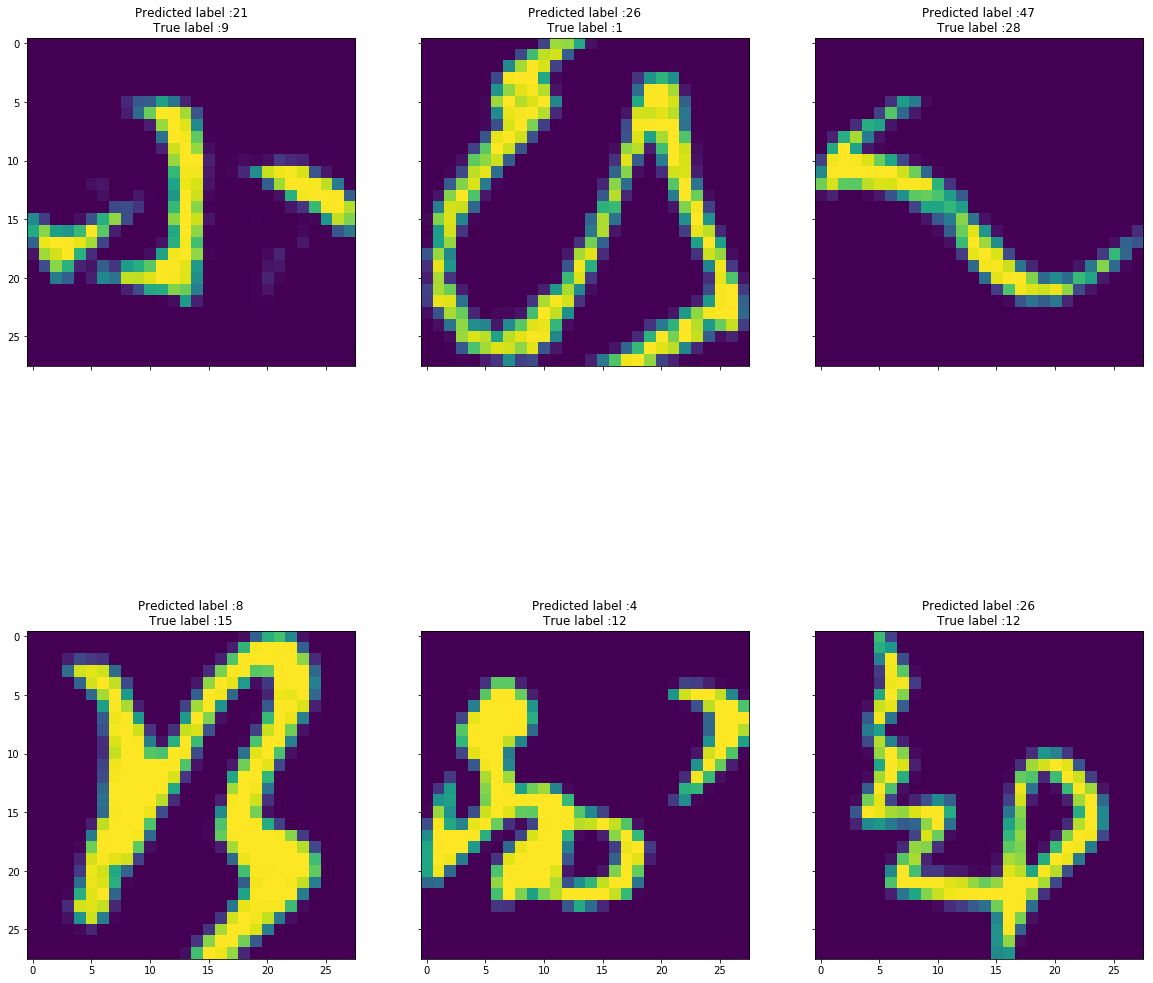

In [345]:
Y_pred = final_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
Y_true = np.argmax(y_test, axis = 1) 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    #This function shows 6 images with their predicted and real labels
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,figsize=(20,20),sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

#### Also, the individual accuracies for each label can be seen below. 

In [383]:
y_pred = final_model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
c = 0
for i in sorted(test_data['Label'].unique()):
    count = test_data[test_data['Label'] == i].shape[0]
    correct = matrix[c][c]
    print("Label: " + str(i) + " --- Accuracy: " + str(round(correct/count, 3)))
    c += 1

Label: 0 --- Accuracy: 0.98
Label: 1 --- Accuracy: 0.975
Label: 2 --- Accuracy: 0.953
Label: 3 --- Accuracy: 0.913
Label: 4 --- Accuracy: 0.968
Label: 5 --- Accuracy: 0.93
Label: 6 --- Accuracy: 0.953
Label: 7 --- Accuracy: 0.93
Label: 8 --- Accuracy: 0.973
Label: 9 --- Accuracy: 0.94
Label: 10 --- Accuracy: 0.975
Label: 11 --- Accuracy: 0.951
Label: 12 --- Accuracy: 0.956
Label: 13 --- Accuracy: 0.937
Label: 14 --- Accuracy: 0.893
Label: 15 --- Accuracy: 0.966
Label: 16 --- Accuracy: 0.978
Label: 17 --- Accuracy: 0.972
Label: 18 --- Accuracy: 0.947
Label: 19 --- Accuracy: 0.982
Label: 20 --- Accuracy: 0.927
Label: 21 --- Accuracy: 0.958
Label: 22 --- Accuracy: 0.943
Label: 23 --- Accuracy: 0.975
Label: 24 --- Accuracy: 0.969
Label: 25 --- Accuracy: 0.946
Label: 26 --- Accuracy: 0.971
Label: 27 --- Accuracy: 0.916
Label: 28 --- Accuracy: 0.923
Label: 29 --- Accuracy: 0.948
Label: 30 --- Accuracy: 0.977
Label: 31 --- Accuracy: 0.96
Label: 32 --- Accuracy: 0.918
Label: 33 --- Accuracy: 0

#### The labels with the lowest accuracies were 44 (73.5%),  48 (81.7%), and 14 (89.3%).

#### Below we can see the characters corresponding to these labels.

In [398]:
classes['char'][classes['index'] == 44].values[0]

'ゐ'

In [399]:
classes['char'][classes['index'] == 48].values[0]

'ゝ'

In [400]:
classes['char'][classes['index'] == 14].values[0]

'そ'

#### We can also see that each of these were labels with a low number of occurences as most of the labels in the training set had 6000 occurences. This could likely be one of the factors in why these labels were harder to predict.

In [392]:
train_data['Label'][train_data['Label'] == 44].value_counts()

44    417
Name: Label, dtype: int64

In [389]:
train_data['Label'][train_data['Label'] == 48].value_counts()

48    3523
Name: Label, dtype: int64

In [390]:
train_data['Label'][train_data['Label'] == 14].value_counts()

14    3867
Name: Label, dtype: int64

## Conclusion

#### Using a CNN with architecture seen below, accuracies scores of ~99.01% on the train data and ~95.46% on the test data were achieved.

<img src='final_model_chart.png'>

#### These scores are in line with the results of other public kernals on Kaggle. The dataset was designed to be similar to the MNIST digit recognition dataset with which a higher accuracy of over 99% can be achieved, but the K-MNIST dataset has 49 classes as opposed to 10 and also is a more imbalanced dataset.

## Final thoughts and future work

#### WIth more time and resources, the following could be investigated:

1) More complex architectures
    - This was a relatively simple CNN and perhaps including more convolutional layers and/or dense layers could acheive higher accuracy.

2) Data augmentation
    - Performing different transformations on the images could lead to a more robust network and better results.
    - This could also help solve the problem of class imbalance by populating more of the less common labels.
    
3) Hyperparameter tuning
    - More combinations of hyperparameters could be tested in order to improve performance

4) Feature visualization
    - The features derived from the convolutional layers as well as the dense layers could be visualized to better understand the model.
    
5) Top-5 score
    - Investigating the top-5 score for the model as well as the individual labels could prove interesting.
    
6) Testing the model using newly drawn characters
    - I would have liked to draw some of the Hiragana myself to test the accuracy of the CNN hands-on